In [1]:
# Version 1.2

import logging, os, re, datetime
from IPython.display import display
from arcgis.gis import GIS
import pandas as pd
import numpy as np

''' ********************** SCRIPT CONFIGURATION START ********************** '''

#What is the ID of the Feature Layer you want to download attachments from?
# FeatureLayerId = 'a7079d96cc1a469b910906e72a43c947'
FeatureLayerId = '2a64e75747c04d8282bef1aac3bb8c22'

#What are your ArcGIS Enterprise/ArcGIS Online credentials? This is case sensitive.
PortalUserName = 'indielyt'
PortalPassword = '$Roller1'
PortalUrl = 'http://baker.maps.arcgis.com'

#Where do you want your attachments stored?
SaveAttachmentsTo = r'C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4'
SaveLogsTo = r'C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4'

#How do you want your attachments stored? Options are GroupedFolder and IndividualFolder
#GroupedFolder - Attachments from every feature in each layer is stored in the same folder - attachments are renamed in the format OBJECTID-ATTACHMENTID-OriginalFileName
#IndividualFolder - A new folder is created for each OBJECTID, and associated attachments are stored in that folder - attachments are renamed in the format ATTACHMENTID-OriginalFileName
AttachmentStorage = 'IndividualFolder'

#Set to False if ArcGIS Enterprise cert is not valid
PortalCertVerification = True

#Setup logging - levels are DEBUG,INFO,WARNING,ERROR,CRITICAL
logging.basicConfig(level=logging.INFO)

''' ********************** SCRIPT CONFIGURATION END ********************** '''

#https://stackoverflow.com/questions/273192/how-can-i-create-a-directory-if-it-does-not-exist
def createFolder(folderPath):
    if not os.path.exists(folderPath):
        try:
            os.makedirs(folderPath)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

def renameFile(currentAttachmentPath, newAttachmentPath):
    #Rename file - ensure new attachment path does not exist already
    if not os.path.exists(newAttachmentPath):
        os.rename(currentAttachmentPath, newAttachmentPath)
        logger.info('{} being renamed as {}'.format(currentAttachmentPath, newAttachmentPath))
    else:
        logger.warning('Not able to rename {} as {} because file already exists. Removing {}'.format(currentAttachmentPath, newAttachmentPath, currentAttachmentPath))
        os.remove(currentAttachmentPath)

#Create specified folder if it does not exist already
createFolder(SaveAttachmentsTo)
createFolder(SaveLogsTo)
        
#Logging level specified in script configuration
logger = logging.getLogger(__name__)
logFileName = datetime.datetime.now().strftime('%Y-%m-%d %H-%M-%S')
fileHandler = logging.handlers.RotatingFileHandler('{}/{}.log'.format(SaveLogsTo, logFileName), maxBytes=100000, backupCount=5)
formatter = logging.Formatter('%(asctime)s %(levelname)s %(relativeCreated)d \n%(filename)s %(module)s %(funcName)s %(lineno)d \n%(message)s\n')
fileHandler.setFormatter(formatter)
logger.addHandler(fileHandler)

logger.info('Script Starting at {}'.format(str(datetime.datetime.now())))

#Connect to GIS, and get Feature Layer information
if PortalUserName == '' and PortalPassword == '':
    gis = GIS()
else:
    gis = GIS(PortalUrl, PortalUserName, PortalPassword, verify_cert=PortalCertVerification)
    
print ('log in complete')

INFO:__main__:Script Starting at 2018-01-22 08:53:35.037913


log in complete


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

INFO:__main__:Iterating through layers in Feature Layer "GI_EastRiver_Collector"


<Item title:"GI_EastRiver_Collector" type:Feature Layer Collection owner:j_stec16>
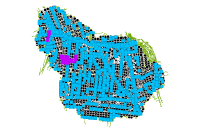

In [3]:
downloadCounter = 0
nonDownloadCounter = 0
downloadSizeCounter = 0

itemObject = gis.content.get(FeatureLayerId)


logger.info('Iterating through layers in Feature Layer "{}"'.format(itemObject.name))
display(itemObject)

In [4]:
# Create a map widget
# map1 = gis.map('Queens, NY',3)
map1 = gis.map()

# map1.center = (Queens,NY)
DataCollectionLayer = itemObject.layers[0]

# Add the itemObject layer to the map
map1.add_layer(DataCollectionLayer)

# set the map's center to Queens, NY
map1.center = [40.779, -73.8113]
map1.zoom = 14
# Display the map
map1

In [6]:
# Automatically generate a webmap, and save to content in ArcGIS Online
if False:
    from arcgis.mapping import WebMap
    wm = WebMap()
    web_map_properties={'title':'East River AGOL, test web map', 'snippet':'Field Collected Data, test web map','tags':'East River, Queens'}
    wm.add_layer(DataCollectionLayer)
    web_map_item = wm.save(item_properties=web_map_properties)
    web_map_item

<Item title:"East River AGOL, test web map" type:Web Map owner:indielyt>

In [10]:
#Loop through layers in Feature Layer, by range(1) we only inspect first layer - the DataCollection Layer
for i in range(1):
    featureLayer = itemObject.layers[i]
    print ('feature layer name= ', featureLayer.properties.name)
    
    #Skip layer if attachments are not enabled
    if featureLayer.properties.hasAttachments == True:
        #Remove any characters from feature layer name that may cause problems and ensure it's unique...
        featureLayerName = '{}-{}'.format(str(i), re.sub(r'[^A-Za-z0-9]+', '', featureLayer.properties.name))
        featureLayerFolder = SaveAttachmentsTo + r'\\' + featureLayerName
        print (featureLayerFolder)
        createFolder(featureLayerFolder)

        #Query to get list of object ids in layer
        featureObjectIds = featureLayer.query(where='1=1', return_ids_only=True)
        featureObjectIds2 = featureLayer.query(where='1=1',out_fields='GI_ID_Number,OBJECTID')
        featureObjectIds3 = featureObjectIds2.features
        
        # Create a pandas dataframe to track attribute info
        # df4 = featureObjectIds2.df  # deprecated when?  new method below
        df4 = featureObjectIds2.sdf  # updated 1/31/2019. New method from esri docs (arcgis for python) - https://developers.arcgis.com/python/guide/working-with-feature-layers-and-features/#FeatureSet-properties
        
        # Get attributes from the DataCollection Layer
        featureObjectAttributes = featureLayer.query(where='1=1', return_all_records='true')
    
        # Test for duplicates
        if True:
            df_testing_duplicates = pd.concat(g for _, g in df4.groupby("GI_ID_Number") if len(g) > 1)
            print (df_testing_duplicates)

        #Provide some updates to user...
        logger.info('Time: {}'.format(str(datetime.datetime.now())))
        logger.info('Currently looping through feature attachments in layer {} of {}: storing in folder named "{}"'.format(str(i + 1), str(len(itemObject.layers)), featureLayerName))
        logger.info('There are {} features to iterate in this layer'.format(str(len(featureObjectIds['objectIds']))))

        #Loop through features in layer, iterating by objectIds of point feature layer
        emptyAttachments = 0
        for j in range(len(df4)):
            currentObjectId = df4.iloc[j]['OBJECTID']
            currentObjectIdAttachments = featureLayer.attachments.get_list(oid=currentObjectId)
            currentGI_ID = df4.iloc[j]['GI_ID_Number']
            print (currentObjectId,currentGI_ID, currentObjectIdAttachments)

            if len(currentObjectIdAttachments) > 0:

                #Loop through feature attachments and download to appropriate folder
                for k in range(len(currentObjectIdAttachments)):
                    attachmentId = currentObjectIdAttachments[k]['id']
                    attachmentName = currentObjectIdAttachments[k]['name']
                    attachmentSize = currentObjectIdAttachments[k]['size']
                    print(attachmentId)
                    print(attachmentName)
                    
                    if AttachmentStorage == 'IndividualFolder':
                        currentFolder = featureLayerFolder + r'\\' + str(currentGI_ID)
                        
                        #Create a folder for attachments
                        createFolder(currentFolder)
                        
                        fileName = '{}_{}'.format(currentGI_ID, attachmentName)
                        newAttachmentPath = '{}\\{}'.format(currentFolder, fileName)
                        
                        if not os.path.isfile(newAttachmentPath):
                            logger.info('The size of the current attachment being downloaded is {}MB'.format((attachmentSize/1000000)))
                            currentAttachmentPath = featureLayer.attachments.download(oid=currentObjectId, attachment_id=attachmentId, save_path=currentFolder)
                            #Rename to ensure file name is unique
                            renameFile(currentAttachmentPath, newAttachmentPath)
                            downloadCounter += 1
                            downloadSizeCounter += attachmentSize
                        else:
                            logger.info('File {} already exists. Not downloading again!'.format(newAttachmentPath))
                            nonDownloadCounter += 1

                    elif AttachmentStorage == 'GroupedFolder':
                        fileName = '{}-{}-{}'.format(currentObjectId, attachmentId, attachmentName)
                        newAttachmentPath = '{}\\{}'.format(featureLayerFolder, fileName)
                        if not os.path.isfile(newAttachmentPath):
                            logger.info('The size of the current attachment being downloaded is {}MB'.format((attachmentSize/1000000)))
                            currentAttachmentPath = featureLayer.attachments.download(oid=currentObjectId, attachment_id=attachmentId, save_path=featureLayerFolder)
                            #Rename to ensure file name is unique
                            renameFile(currentAttachmentPath, newAttachmentPath)
                            downloadCounter += 1
                            downloadSizeCounter += attachmentSize
                        else:
                            logger.info('File {} already exists. Not downloading again!'.format(newAttachmentPath))
                            nonDownloadCounter += 1

                    else:
                        logger.error('AttachmentStorage option not valid: {}. Valid options are IndividualFolder and GroupedFolder'.format(AttachmentStorage))
            else:
                emptyAttachments += 1
            
        logger.info('{} of these features do not contain attachments'.format(str(emptyAttachments)))
    else:
        logger.info('Layer {} does not have attachments enabled'.format(featureLayer.properties.name))

logger.info('Summary: {} new files have been downloaded totalling {}MB in size'.format(downloadCounter, (downloadSizeCounter/1000000)))
logger.info('Summary: {} attachments already existed so were not downloaded again'.format(nonDownloadCounter))

feature layer name=  DataCollection
C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection


INFO:__main__:Time: 2018-01-08 08:15:46.314472
INFO:__main__:Currently looping through feature attachments in layer 1 of 20: storing in folder named "0-DataCollection"
INFO:__main__:There are 1175 features to iterate in this layer


     GI_ID_Number  OBJECTID                                              SHAPE
1081        1027A      1089  {'x': 1036295.5340201408, 'y': 224190.99326872...
1082        1027A      1090  {'x': 1036272.4238298597, 'y': 224193.18683503...
463         1066A       465  {'x': 1034832.1626030505, 'y': 224431.3559769839}
465         1066A       467  {'x': 1034951.8920223862, 'y': 225084.71260988...
702         1084D       707  {'x': 1035205.2091010511, 'y': 225099.8966346383}
703         1084D       708  {'x': 1035138.7187484652, 'y': 225096.96389771...
944         1106D       950  {'x': 1034557.6273909658, 'y': 225385.5423888117}
947         1106D       953  {'x': 1034532.8738315552, 'y': 225352.47290115...
394         2327A       395  {'x': 1038743.0530752242, 'y': 223601.95573289...
395         2327A       396  {'x': 1038740.5809673071, 'y': 223587.26514548...
1096        2358A      1104  {'x': 1038615.0667826384, 'y': 222326.7742281407}
1097        2358A      1105  {'x': 1038616.825309306

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000B\GS1000B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000B\GS1000B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000B\GS1000B_Photo3.jpg already exists. Not downloading again!


1 GS1000B [{'id': 1, 'globalId': '463c50f3-153f-4aa0-a192-7e2cf4b0ca45', 'parentGlobalId': '35904887-1660-4bef-b23c-219b004743ca', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 426773, 'keywords': ''}, {'id': 2, 'globalId': '81590e55-5cdc-4aed-8f80-bf6b9388d85d', 'parentGlobalId': '35904887-1660-4bef-b23c-219b004743ca', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 469812, 'keywords': ''}, {'id': 3, 'globalId': '5b0fe19d-137c-484b-b30f-6085559be229', 'parentGlobalId': '35904887-1660-4bef-b23c-219b004743ca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 707647, 'keywords': ''}]
1
Photo2.jpg
2
Photo1.jpg
3
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000C\GS1000C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000C\GS1000C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000C\GS1000C_Photo3.jpg already exists. Not downloading again!


2 GS1000C [{'id': 4, 'globalId': '57563a0f-2845-43dd-872d-c5d94cfce8a0', 'parentGlobalId': 'd98050ca-2767-4a68-8d81-329a07af86d7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 269335, 'keywords': ''}, {'id': 5, 'globalId': '3bb4fc05-f8c5-4c2c-ab7d-d8fb25403a08', 'parentGlobalId': 'd98050ca-2767-4a68-8d81-329a07af86d7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 418167, 'keywords': ''}, {'id': 6, 'globalId': '65743a1f-4d59-4adc-a039-036e5e78351e', 'parentGlobalId': 'd98050ca-2767-4a68-8d81-329a07af86d7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 635123, 'keywords': ''}]
4
Photo1.jpg
5
Photo2.jpg
6
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000D\GS1000D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000D\GS1000D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000D\GS1000D_Photo3.jpg already exists. Not downloading again!


3 GS1000D [{'id': 7, 'globalId': 'bb9ef54f-2d94-4b64-b6bd-52f6afd51884', 'parentGlobalId': '3cc7f315-eb44-462e-b902-b4643dc08954', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 389057, 'keywords': ''}, {'id': 8, 'globalId': 'f559b963-11bb-435a-903f-0b138a9570d0', 'parentGlobalId': '3cc7f315-eb44-462e-b902-b4643dc08954', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 545530, 'keywords': ''}, {'id': 9, 'globalId': 'd2347478-a0bd-42cd-baa8-6a28c8e5e9df', 'parentGlobalId': '3cc7f315-eb44-462e-b902-b4643dc08954', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 712290, 'keywords': ''}]
7
Photo2.jpg
8
Photo1.jpg
9
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000E\GS1000E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000E\GS1000E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000E\GS1000E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000E\GS1000E_Photo3.jpg already exists. Not downloading again!


4 GS1000E [{'id': 10, 'globalId': '9d1d66c3-349a-44ad-967d-86d1e7e8fa91', 'parentGlobalId': '7951f59a-525e-4aca-812e-81e386b38805', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 529528, 'keywords': ''}, {'id': 11, 'globalId': '93736e3a-2916-4e03-916d-64ef157426bb', 'parentGlobalId': '7951f59a-525e-4aca-812e-81e386b38805', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 562473, 'keywords': ''}, {'id': 12, 'globalId': '91acdb9c-2604-4c50-81b7-1ad640926009', 'parentGlobalId': '7951f59a-525e-4aca-812e-81e386b38805', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 449834, 'keywords': ''}, {'id': 13, 'globalId': '765d4812-1b53-4151-ac07-300d2be11f48', 'parentGlobalId': '7951f59a-525e-4aca-812e-81e386b38805', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 577027, 'keywords': ''}]
10
Photo1.jpg
11
Photo4.jpg
12
Photo2.jpg
13
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000F\GS1000F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000F\GS1000F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000F\GS1000F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000F\GS1000F_Photo3.jpg already exists. Not downloading again!


5 GS1000F [{'id': 14, 'globalId': '58831ef6-138c-4c92-947b-d5808930bbb0', 'parentGlobalId': '364fc823-12d1-4935-a2e2-02441f87eb79', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541789, 'keywords': ''}, {'id': 15, 'globalId': '8c7acbcf-c995-4bbc-bead-eac5111a6e6e', 'parentGlobalId': '364fc823-12d1-4935-a2e2-02441f87eb79', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 434405, 'keywords': ''}, {'id': 16, 'globalId': '83538474-d346-4224-92cb-725f3f0fd34f', 'parentGlobalId': '364fc823-12d1-4935-a2e2-02441f87eb79', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 393624, 'keywords': ''}, {'id': 17, 'globalId': 'f4562387-c305-420e-8112-0497c02b8c88', 'parentGlobalId': '364fc823-12d1-4935-a2e2-02441f87eb79', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 576916, 'keywords': ''}]
14
Photo1.jpg
15
Photo2.jpg
16
Photo4.jpg
17
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000G\GS1000G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000G\GS1000G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000G\GS1000G_Photo1.jpg already exists. Not downloading again!


6 GS1000G [{'id': 18, 'globalId': '3eb66d59-b2a3-4f7d-8d24-321c6a09fa91', 'parentGlobalId': 'c21216fb-1593-4264-a240-285380ed1648', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 342323, 'keywords': ''}, {'id': 19, 'globalId': '2e3c5169-ebb7-48e6-8da7-ecc89967f591', 'parentGlobalId': 'c21216fb-1593-4264-a240-285380ed1648', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 367561, 'keywords': ''}, {'id': 20, 'globalId': '39498df7-5743-43c3-b57f-ed3b302fa94c', 'parentGlobalId': 'c21216fb-1593-4264-a240-285380ed1648', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 527714, 'keywords': ''}]
18
Photo2.jpg
19
Photo3.jpg
20
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000H\GS1000H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000H\GS1000H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1000H\GS1000H_Photo3.jpg already exists. Not downloading again!


7 GS1000H [{'id': 21, 'globalId': 'db102527-960d-480a-9a76-545d6a802a72', 'parentGlobalId': 'aefc3925-a7e7-4a66-aea0-04e73c225312', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 265384, 'keywords': ''}, {'id': 22, 'globalId': 'c01f3530-5ae5-47c7-bcc7-40a7b5025dbb', 'parentGlobalId': 'aefc3925-a7e7-4a66-aea0-04e73c225312', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 277770, 'keywords': ''}, {'id': 23, 'globalId': 'da536d3e-885f-42e9-937e-3851db35a93e', 'parentGlobalId': 'aefc3925-a7e7-4a66-aea0-04e73c225312', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 409725, 'keywords': ''}]
21
Photo2.jpg
22
Photo1.jpg
23
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017A\GS1017A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017A\GS1017A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017A\GS1017A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017A\GS1017A_Photo1.jpg already exists. Not downloading again!


8 GS1017A [{'id': 24, 'globalId': '70caa14d-6745-46fb-bff8-1d7cc64dc072', 'parentGlobalId': '1dd966a5-b996-421d-b3ae-a33e49e5eb50', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 416486, 'keywords': ''}, {'id': 25, 'globalId': '15e52321-857c-469b-87af-7ac6b6ae6b5d', 'parentGlobalId': '1dd966a5-b996-421d-b3ae-a33e49e5eb50', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 448304, 'keywords': ''}, {'id': 26, 'globalId': 'b46a1b6b-8b2f-4553-9153-e3f1597757bf', 'parentGlobalId': '1dd966a5-b996-421d-b3ae-a33e49e5eb50', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 396500, 'keywords': ''}, {'id': 27, 'globalId': 'e5ec25d8-49b8-4599-859c-873d71adaacc', 'parentGlobalId': '1dd966a5-b996-421d-b3ae-a33e49e5eb50', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 447941, 'keywords': ''}]
24
Photo2.jpg
25
Photo3.jpg
26
Photo4.jpg
27
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017B\GS1017B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017B\GS1017B_Photo2.jpg already exists. Not downloading again!


9 GS1017B [{'id': 28, 'globalId': 'ba5f2732-388b-4ebd-9415-d901c66c72e8', 'parentGlobalId': '366cdf80-81e6-495d-b30d-44173c6a37b7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 370195, 'keywords': ''}, {'id': 29, 'globalId': 'ce963def-8704-4014-b2ad-2f1ef8e2c92b', 'parentGlobalId': '366cdf80-81e6-495d-b30d-44173c6a37b7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 501948, 'keywords': ''}]
28
Photo1.jpg
29
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017C\GS1017C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017C\GS1017C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1017C\GS1017C_Photo1.jpg already exists. Not downloading again!


10 GS1017C [{'id': 30, 'globalId': '0c5c3bfd-adc2-4bf4-934e-4a1a138760bc', 'parentGlobalId': '32f64b45-3dd9-45ce-8ba4-ee5852cd890c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 358882, 'keywords': ''}, {'id': 31, 'globalId': 'e8090070-e31e-4bc8-b0b0-9a5a5a8ade4f', 'parentGlobalId': '32f64b45-3dd9-45ce-8ba4-ee5852cd890c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 490689, 'keywords': ''}, {'id': 32, 'globalId': '6c4bf43b-7e69-4b56-9d7d-7310dbd0da88', 'parentGlobalId': '32f64b45-3dd9-45ce-8ba4-ee5852cd890c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 402828, 'keywords': ''}]
30
Photo3.jpg
31
Photo2.jpg
32
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1017D\1017D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1017D\1017D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1017D\1017D_Photo2.jpg already exists. Not downloading again!


11 1017D [{'id': 33, 'globalId': 'da1335c7-7358-4e44-afbe-a953210be4ff', 'parentGlobalId': 'fcd5636f-04c8-433a-a3bc-594a31d726c2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 360618, 'keywords': ''}, {'id': 34, 'globalId': '74e681cf-f02b-442c-886c-c71daba4b2f2', 'parentGlobalId': 'fcd5636f-04c8-433a-a3bc-594a31d726c2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 405912, 'keywords': ''}, {'id': 35, 'globalId': 'ac486129-7051-43cd-99a9-d47144389956', 'parentGlobalId': 'fcd5636f-04c8-433a-a3bc-594a31d726c2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 279469, 'keywords': ''}]
33
Photo1.jpg
34
Photo3.jpg
35
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030A\1030A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030A\1030A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030A\1030A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030A\1030A_Photo4.jpg already exists. Not downloading again!


12 1030A [{'id': 36, 'globalId': 'ceffa119-6d64-4459-8ca6-a10c84235edc', 'parentGlobalId': '49de8559-bf4f-4e6a-b7e8-5c0249fe3d26', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 537266, 'keywords': ''}, {'id': 37, 'globalId': 'c39bcb12-7ae6-4b77-8ab5-f674aeb81be7', 'parentGlobalId': '49de8559-bf4f-4e6a-b7e8-5c0249fe3d26', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 432502, 'keywords': ''}, {'id': 38, 'globalId': '3685ac0d-c309-4ba3-9eeb-232ad4f54b2f', 'parentGlobalId': '49de8559-bf4f-4e6a-b7e8-5c0249fe3d26', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 640667, 'keywords': ''}, {'id': 39, 'globalId': 'd544a37f-a81b-4dcb-8e1e-2691516a8309', 'parentGlobalId': '49de8559-bf4f-4e6a-b7e8-5c0249fe3d26', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 636962, 'keywords': ''}]
36
Photo3.jpg
37
Photo2.jpg
38
Photo1.jpg
39
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030B\1030B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030B\1030B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030B\1030B_Photo2.jpg already exists. Not downloading again!


13 1030B [{'id': 40, 'globalId': '30eef330-0a77-452a-b9d5-1d3f8472c3ef', 'parentGlobalId': '27e17bbb-13f1-49fe-8dc5-98d5c1df41e6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 606375, 'keywords': ''}, {'id': 41, 'globalId': '51ebc73f-4aa8-4dd8-ad73-db8c0dbf3bba', 'parentGlobalId': '27e17bbb-13f1-49fe-8dc5-98d5c1df41e6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 602149, 'keywords': ''}, {'id': 42, 'globalId': '9161772d-8028-4d9f-b645-559dc789702f', 'parentGlobalId': '27e17bbb-13f1-49fe-8dc5-98d5c1df41e6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 512228, 'keywords': ''}]
40
Photo1.jpg
41
Photo3.jpg
42
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030C\1030C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1030C\1030C_Photo1.jpg already exists. Not downloading again!


14 1030C [{'id': 43, 'globalId': 'e9acefaf-2238-40ed-bb4f-5cc45f048ced', 'parentGlobalId': '9d7909dd-b1b4-4c51-a55c-9dbe8fc345eb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 458530, 'keywords': ''}, {'id': 44, 'globalId': 'b9df853d-c1b4-41c4-a215-ffb955189492', 'parentGlobalId': '9d7909dd-b1b4-4c51-a55c-9dbe8fc345eb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541971, 'keywords': ''}]
43
Photo2.jpg
44
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1219A\GS1219A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1219A\GS1219A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1219A\GS1219A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1219A\GS1219A_Photo2.jpg already exists. Not downloading again!


15 GS1219A [{'id': 45, 'globalId': '7fbe175f-c49a-4590-a943-51aab1d3564b', 'parentGlobalId': 'c12ffc1e-a6aa-4d83-8568-453933c7571f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 531545, 'keywords': ''}, {'id': 46, 'globalId': 'eb11f21a-6a98-45fb-87e6-f03feb3e80ca', 'parentGlobalId': 'c12ffc1e-a6aa-4d83-8568-453933c7571f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 579967, 'keywords': ''}, {'id': 47, 'globalId': 'a51a9164-b792-4736-9916-fb4df357c8e0', 'parentGlobalId': 'c12ffc1e-a6aa-4d83-8568-453933c7571f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 572810, 'keywords': ''}, {'id': 48, 'globalId': 'a7d5e108-4d44-4c8a-83d5-46d8917a66a0', 'parentGlobalId': 'c12ffc1e-a6aa-4d83-8568-453933c7571f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 736114, 'keywords': ''}]
45
Photo4.jpg
46
Photo3.jpg
47
Photo1.jpg
48
Photo2.jpg
16 None []


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1217A\IB1217A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1217A\IB1217A_Photo2.jpg already exists. Not downloading again!


17 IB1217A [{'id': 49, 'globalId': '3c4c79ef-8c66-4f6d-bee1-651208bb7812', 'parentGlobalId': '6b5a9356-eab6-47e6-b3c6-06f9e2a7ec13', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 679776, 'keywords': ''}, {'id': 50, 'globalId': '8956750e-9103-4d60-9e80-9b639e71dff0', 'parentGlobalId': '6b5a9356-eab6-47e6-b3c6-06f9e2a7ec13', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 621836, 'keywords': ''}]
49
Photo1.jpg
50
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216A\1216A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216A\1216A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216A\1216A_Photo1.jpg already exists. Not downloading again!


18 1216A [{'id': 51, 'globalId': 'dc8b92c1-19da-41d1-86e6-3194521fb36d', 'parentGlobalId': '98fe67bf-2331-4a20-b75f-54fc888fbe87', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 576389, 'keywords': ''}, {'id': 52, 'globalId': 'd19cf369-2f1c-40c1-89f3-f07087383968', 'parentGlobalId': '98fe67bf-2331-4a20-b75f-54fc888fbe87', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 601323, 'keywords': ''}, {'id': 53, 'globalId': '12c9aed0-96fe-48f9-bae1-f3cf01778937', 'parentGlobalId': '98fe67bf-2331-4a20-b75f-54fc888fbe87', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 607137, 'keywords': ''}]
51
Photo3.jpg
52
Photo2.jpg
53
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216B\1216B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216B\1216B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216B\1216B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1216B\1216B_Photo3.jpg already exists. Not downloading again!


19 1216B [{'id': 54, 'globalId': '1e5b5cd3-c455-41b8-a602-dc8713bdb1a1', 'parentGlobalId': 'c93b7004-a671-46dc-812d-77326d14a413', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 268215, 'keywords': ''}, {'id': 55, 'globalId': 'c529fbe5-be09-4958-a0ba-a6c055c26677', 'parentGlobalId': 'c93b7004-a671-46dc-812d-77326d14a413', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 559624, 'keywords': ''}, {'id': 56, 'globalId': '31367203-8f4b-4ddc-b60f-fb69b94138ef', 'parentGlobalId': 'c93b7004-a671-46dc-812d-77326d14a413', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 574881, 'keywords': ''}, {'id': 57, 'globalId': '27e88291-ae8a-42d5-adf1-eb1dfeb0a61d', 'parentGlobalId': 'c93b7004-a671-46dc-812d-77326d14a413', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 357600, 'keywords': ''}]
54
Photo1.jpg
55
Photo4.jpg
56
Photo2.jpg
57
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002A\1002A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

20 1002A [{'id': 58, 'globalId': 'd1907645-c846-4170-a4c7-a8693e0d2b52', 'parentGlobalId': 'e0074715-4940-4c07-9864-6a83b248e1ff', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 425753, 'keywords': ''}, {'id': 59, 'globalId': '5b8ade75-5340-48e5-84b4-bc61b1de174b', 'parentGlobalId': 'e0074715-4940-4c07-9864-6a83b248e1ff', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 496861, 'keywords': ''}, {'id': 60, 'globalId': '02dbb942-aca2-4c22-bc93-64cbe2030e2a', 'parentGlobalId': 'e0074715-4940-4c07-9864-6a83b248e1ff', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 486848, 'keywords': ''}, {'id': 61, 'globalId': '09673404-f427-4257-b35f-e9c095e79c83', 'parentGlobalId': 'e0074715-4940-4c07-9864-6a83b248e1ff', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 488017, 'keywords': ''}, {'id': 62, 'globalId': '672f3b52-72d1-43f7-889b-8e657d96de92', 'parentGlobalId': 'e0074715-4940-4c07-9864-6a83b248e1ff', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001A\GS1001A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001A\GS1001A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001A\GS1001A_Photo1.jpg already exists. Not downloading again!


21 GS1001A [{'id': 66, 'globalId': '3420de09-e141-42ba-8452-ff682aa7bff7', 'parentGlobalId': 'a94930cc-dbac-4c29-b560-65cc66bec188', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 513559, 'keywords': ''}, {'id': 67, 'globalId': '17c1c825-72fa-4493-aa3c-4e8bfbcfb41e', 'parentGlobalId': 'a94930cc-dbac-4c29-b560-65cc66bec188', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479737, 'keywords': ''}, {'id': 68, 'globalId': '7e29c2ab-ef04-4950-bd34-6677bab1b50e', 'parentGlobalId': 'a94930cc-dbac-4c29-b560-65cc66bec188', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 568765, 'keywords': ''}]
66
Photo2.jpg
67
Photo3.jpg
68
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001B\GS1001B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001B\GS1001B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1001B\GS1001B_Photo1.jpg already exists. Not downloading again!


22 GS1001B [{'id': 69, 'globalId': '6fca0a26-8e06-44d1-8269-57925dcb19fd', 'parentGlobalId': '1393a1ec-32d3-454f-9912-71aafcd18d35', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 430238, 'keywords': ''}, {'id': 70, 'globalId': '6b9ab702-7af9-4f34-ab03-964e6927ae14', 'parentGlobalId': '1393a1ec-32d3-454f-9912-71aafcd18d35', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 568198, 'keywords': ''}, {'id': 71, 'globalId': 'cbfecde0-c0ff-4549-b465-a55630992246', 'parentGlobalId': '1393a1ec-32d3-454f-9912-71aafcd18d35', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541105, 'keywords': ''}]
69
Photo3.jpg
70
Photo2.jpg
71
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1002B\1002B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

23 1002B [{'id': 72, 'globalId': '5691ffcc-cdaa-48ff-ae2f-a311e5a45167', 'parentGlobalId': '844c70aa-7ec6-4054-9a1b-a2d143abb850', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 447442, 'keywords': ''}, {'id': 73, 'globalId': '42a6de19-7fc8-404c-b813-94d212ce1d6d', 'parentGlobalId': '844c70aa-7ec6-4054-9a1b-a2d143abb850', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 475571, 'keywords': ''}, {'id': 74, 'globalId': '89bd6c1c-c964-46f6-9a9a-0c7de505b71e', 'parentGlobalId': '844c70aa-7ec6-4054-9a1b-a2d143abb850', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 411111, 'keywords': ''}, {'id': 75, 'globalId': '7f52f902-f668-4c4c-8b86-6659ee7a292c', 'parentGlobalId': '844c70aa-7ec6-4054-9a1b-a2d143abb850', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 669740, 'keywords': ''}, {'id': 76, 'globalId': 'b60790a4-a494-40e4-a813-8f971883244d', 'parentGlobalId': '844c70aa-7ec6-4054-9a1b-a2d143abb850', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1220A\GS1220A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1220A\GS1220A_Photo1.jpg already exists. Not downloading again!


24 GS1220A [{'id': 80, 'globalId': '8cf130aa-354b-4435-afd3-6e7ffe23addc', 'parentGlobalId': '9757742d-32ca-4ec4-9507-ce5e61a46dd7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476237, 'keywords': ''}, {'id': 81, 'globalId': '07277c89-9fc8-4e2a-a3bd-6f17b993ecf1', 'parentGlobalId': '9757742d-32ca-4ec4-9507-ce5e61a46dd7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 489573, 'keywords': ''}]
80
Photo2.jpg
81
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003A\GS1003A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003A\GS1003A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003A\GS1003A_Photo3.jpg already exists. Not downloading again!


25 GS1003A [{'id': 82, 'globalId': '46c9b361-3577-4b73-85c5-d44f3cdb59bb', 'parentGlobalId': '96acb4b6-5921-43d4-ae6b-01b557025416', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 510734, 'keywords': ''}, {'id': 83, 'globalId': 'b0965b45-0df2-42b9-b2b2-da76092a1041', 'parentGlobalId': '96acb4b6-5921-43d4-ae6b-01b557025416', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 508673, 'keywords': ''}, {'id': 84, 'globalId': 'c3b04c54-72a5-41b2-8c78-571a5178fb17', 'parentGlobalId': '96acb4b6-5921-43d4-ae6b-01b557025416', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 462184, 'keywords': ''}]
82
Photo2.jpg
83
Photo1.jpg
84
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221A\1221A_Photo4.jpg already exists. Not downloading again!


26 1221A [{'id': 85, 'globalId': '9a96b8a9-43fb-412f-913a-7a36778e2b88', 'parentGlobalId': 'f2c9d6e6-95bd-48a7-b96c-a27163f03b7c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 483634, 'keywords': ''}, {'id': 86, 'globalId': '234a14e2-3e06-4c0a-b91b-11df50f5fc30', 'parentGlobalId': 'f2c9d6e6-95bd-48a7-b96c-a27163f03b7c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 450963, 'keywords': ''}, {'id': 87, 'globalId': 'b638a9f4-e3b2-4142-a8f1-ce577bbc85ea', 'parentGlobalId': 'f2c9d6e6-95bd-48a7-b96c-a27163f03b7c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 559361, 'keywords': ''}, {'id': 88, 'globalId': 'ad2dd7c4-4590-4bb6-a42c-26f7f5eb5bf0', 'parentGlobalId': 'f2c9d6e6-95bd-48a7-b96c-a27163f03b7c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 565838, 'keywords': ''}, {'id': 89, 'globalId': 'bd927710-e5ee-4217-bdff-3891ac3362f2', 'parentGlobalId': 'f2c9d6e6-95bd-48a7-b96c-a27163f03b7c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003B\GS1003B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003B\GS1003B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003B\GS1003B_Photo1.jpg already exists. Not downloading again!


27 GS1003B [{'id': 91, 'globalId': 'c7af5ec3-6fec-43df-bcd2-a4879ea57c00', 'parentGlobalId': '884d3981-985c-4d03-9187-64767b1da132', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 515903, 'keywords': ''}, {'id': 92, 'globalId': 'd261c561-acd1-449e-af06-d7bb6d94c589', 'parentGlobalId': '884d3981-985c-4d03-9187-64767b1da132', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 449758, 'keywords': ''}, {'id': 93, 'globalId': 'fe5d4f7d-9edf-4d0e-a6fe-78327808fef5', 'parentGlobalId': '884d3981-985c-4d03-9187-64767b1da132', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 530908, 'keywords': ''}]
91
Photo2.jpg
92
Photo3.jpg
93
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1221B\1221B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

28 1221B [{'id': 94, 'globalId': '7c3fc9a6-fb7a-410e-b0a9-24f4518d459f', 'parentGlobalId': '87a5ab12-4b16-4173-a364-034e6e151932', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 523253, 'keywords': ''}, {'id': 95, 'globalId': 'cec7488e-dcf7-4010-b49c-4a1bf7c28ae3', 'parentGlobalId': '87a5ab12-4b16-4173-a364-034e6e151932', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 490067, 'keywords': ''}, {'id': 96, 'globalId': 'be8e973b-ba67-4c31-98fd-5e7bf8a86992', 'parentGlobalId': '87a5ab12-4b16-4173-a364-034e6e151932', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 517402, 'keywords': ''}, {'id': 97, 'globalId': '3594dc49-0005-474e-b83c-2ce3561ab78f', 'parentGlobalId': '87a5ab12-4b16-4173-a364-034e6e151932', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 518722, 'keywords': ''}, {'id': 98, 'globalId': '5a47c126-c497-44a0-9058-1ce12f06c904', 'parentGlobalId': '87a5ab12-4b16-4173-a364-034e6e151932', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003C\1003C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003C\1003C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003C\1003C_Photo3.jpg already exists. Not downloading again!


29 1003C [{'id': 101, 'globalId': 'cb664708-a838-448e-a34e-ef5fa0ae6c81', 'parentGlobalId': '36219767-af97-456c-99aa-897f1009a72e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 633581, 'keywords': ''}, {'id': 102, 'globalId': '3de8ed58-77f8-4b98-b4fc-ce7485715691', 'parentGlobalId': '36219767-af97-456c-99aa-897f1009a72e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 687310, 'keywords': ''}, {'id': 103, 'globalId': '763c904f-c38c-442c-ae7d-4ba48f2eb6da', 'parentGlobalId': '36219767-af97-456c-99aa-897f1009a72e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 610439, 'keywords': ''}]
101
Photo1.jpg
102
Photo2.jpg
103
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003D\1003D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003D\1003D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1003D\1003D_Photo3.jpg already exists. Not downloading again!


30 1003D [{'id': 104, 'globalId': '42b737b1-b2e8-421c-b90c-7672457f587d', 'parentGlobalId': '529e3bcf-f29d-43f1-b629-3260d28aa50d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 567690, 'keywords': ''}, {'id': 105, 'globalId': 'c3d1e3c0-3a55-41fc-85e9-876a6e2daaab', 'parentGlobalId': '529e3bcf-f29d-43f1-b629-3260d28aa50d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 615806, 'keywords': ''}, {'id': 106, 'globalId': '7b909eec-fec4-491c-acb3-27f435b560de', 'parentGlobalId': '529e3bcf-f29d-43f1-b629-3260d28aa50d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 622872, 'keywords': ''}]
104
Photo1.jpg
105
Photo2.jpg
106
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004A\GS1004A_Photo6.jpg already exists. Not downloading again

31 GS1004A [{'id': 107, 'globalId': 'b39b1501-83d5-4885-8cb6-d4dc1d0e8fb4', 'parentGlobalId': '8883cf46-9257-4646-988f-92ed59eb2825', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 542868, 'keywords': ''}, {'id': 108, 'globalId': '44a02086-4c3c-49b9-b50e-7c50c4bbf397', 'parentGlobalId': '8883cf46-9257-4646-988f-92ed59eb2825', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 580890, 'keywords': ''}, {'id': 109, 'globalId': 'a615d905-36b1-42ba-8f6b-e37ee8d7c86e', 'parentGlobalId': '8883cf46-9257-4646-988f-92ed59eb2825', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 541899, 'keywords': ''}, {'id': 110, 'globalId': '8adb23c8-1a21-4f24-95d7-9e74b749ff6b', 'parentGlobalId': '8883cf46-9257-4646-988f-92ed59eb2825', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 584628, 'keywords': ''}, {'id': 111, 'globalId': '08a30b23-252b-4675-a270-cab066df8bfd', 'parentGlobalId': '8883cf46-9257-4646-988f-92ed59eb2825', 'name': 'Photo7.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003E\GS1003E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003E\GS1003E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003E\GS1003E_Photo2.jpg already exists. Not downloading again!


32 GS1003E [{'id': 115, 'globalId': '4da8f7bb-51b7-435f-8f98-6b0ae49c1a4f', 'parentGlobalId': '94257c25-78b1-4eb8-8961-555a4d26bec5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 485766, 'keywords': ''}, {'id': 116, 'globalId': '85635224-1b90-44da-a4e0-579685d29535', 'parentGlobalId': '94257c25-78b1-4eb8-8961-555a4d26bec5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 520883, 'keywords': ''}, {'id': 117, 'globalId': 'aabc0b8d-eb0d-486e-9c1c-a19de5fd4fbc', 'parentGlobalId': '94257c25-78b1-4eb8-8961-555a4d26bec5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 422160, 'keywords': ''}]
115
Photo1.jpg
116
Photo3.jpg
117
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003F\GS1003F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003F\GS1003F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003F\GS1003F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1003F\GS1003F_Photo2.jpg already exists. Not downloading again!


33 GS1003F [{'id': 118, 'globalId': '84773af1-1402-4716-9524-90ed486fb0cc', 'parentGlobalId': '28dbe2c2-c473-4b1f-acca-30bd8969fcf3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 456925, 'keywords': ''}, {'id': 119, 'globalId': '796cdf54-5049-48af-b7c0-dc86c54239da', 'parentGlobalId': '28dbe2c2-c473-4b1f-acca-30bd8969fcf3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440377, 'keywords': ''}, {'id': 120, 'globalId': 'adce50b1-8658-4c87-b17a-c29c4719a1f9', 'parentGlobalId': '28dbe2c2-c473-4b1f-acca-30bd8969fcf3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 458202, 'keywords': ''}, {'id': 121, 'globalId': 'ba8ab234-1086-4ecc-87c4-55e786b46152', 'parentGlobalId': '28dbe2c2-c473-4b1f-acca-30bd8969fcf3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 515349, 'keywords': ''}]
118
Photo1.jpg
119
Photo3.jpg
120
Photo4.jpg
121
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004B\GS1004B_Photo5.jpg already exists. Not downloading again

34 GS1004B [{'id': 122, 'globalId': 'fe84831a-a369-445b-aa02-fbdf7599ec1a', 'parentGlobalId': '412a9ef0-ea0a-4e09-bdaa-fd8c704e7a8e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 527987, 'keywords': ''}, {'id': 123, 'globalId': '26c2ecaa-b654-4842-9d8e-d6ae9cd29656', 'parentGlobalId': '412a9ef0-ea0a-4e09-bdaa-fd8c704e7a8e', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 575089, 'keywords': ''}, {'id': 124, 'globalId': 'b815a568-aae1-4c06-8d27-e71e06815413', 'parentGlobalId': '412a9ef0-ea0a-4e09-bdaa-fd8c704e7a8e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 564937, 'keywords': ''}, {'id': 125, 'globalId': '84b712c8-ead3-45db-8476-68e06c4536a1', 'parentGlobalId': '412a9ef0-ea0a-4e09-bdaa-fd8c704e7a8e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 571680, 'keywords': ''}, {'id': 126, 'globalId': 'd687d444-d896-47f2-ad91-a4aae50f12ad', 'parentGlobalId': '412a9ef0-ea0a-4e09-bdaa-fd8c704e7a8e', 'name': 'Photo2.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004C\GS1004C_Photo5.jpg already exists. Not downloading again

35 GS1004C [{'id': 130, 'globalId': '438f2362-c733-43e6-9e0c-dcb06d187f2b', 'parentGlobalId': 'db5689d9-6226-4ffa-b27d-56c43f5cc952', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 517162, 'keywords': ''}, {'id': 131, 'globalId': 'c439e964-c0df-461b-8577-8b16c8ecb205', 'parentGlobalId': 'db5689d9-6226-4ffa-b27d-56c43f5cc952', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 565422, 'keywords': ''}, {'id': 132, 'globalId': 'e85f1416-acd1-40c7-8f98-c50085a84248', 'parentGlobalId': 'db5689d9-6226-4ffa-b27d-56c43f5cc952', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 525636, 'keywords': ''}, {'id': 133, 'globalId': '84657a26-5e09-4289-a961-4152524ae280', 'parentGlobalId': 'db5689d9-6226-4ffa-b27d-56c43f5cc952', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 553321, 'keywords': ''}, {'id': 134, 'globalId': '00138acf-a9c7-43a0-b760-1cec37270699', 'parentGlobalId': 'db5689d9-6226-4ffa-b27d-56c43f5cc952', 'name': 'Photo7.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018A\1018A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018A\1018A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018A\1018A_Photo1.jpg already exists. Not downloading again!


36 1018A [{'id': 138, 'globalId': 'c8e734e1-014a-4e85-a5a1-e43436405541', 'parentGlobalId': '931e31b4-cf7b-455c-8364-61413c2fcd8c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 535134, 'keywords': ''}, {'id': 139, 'globalId': 'bf13401d-08c8-4e19-b542-3304627d6c56', 'parentGlobalId': '931e31b4-cf7b-455c-8364-61413c2fcd8c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 462626, 'keywords': ''}, {'id': 140, 'globalId': '0f07b079-4b73-41a5-a6a7-f9d4251523e2', 'parentGlobalId': '931e31b4-cf7b-455c-8364-61413c2fcd8c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 514304, 'keywords': ''}]
138
Photo2.jpg
139
Photo3.jpg
140
Photo1.jpg
37 1018B []


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018C\1018C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018C\1018C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018C\1018C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018C\1018C_Photo1.jpg already exists. Not downloading again!


38 1018C [{'id': 141, 'globalId': '2f212b1d-9792-4dac-8d42-292a5c9338f2', 'parentGlobalId': 'd50ba6cf-b546-49fb-b8bc-1857b93f8aa1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 361170, 'keywords': ''}, {'id': 142, 'globalId': '067132d1-30d3-4765-ae9e-e942974563cd', 'parentGlobalId': 'd50ba6cf-b546-49fb-b8bc-1857b93f8aa1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405922, 'keywords': ''}, {'id': 143, 'globalId': '1f0e4d7e-7e93-4c13-bef5-010ebff25f8c', 'parentGlobalId': 'd50ba6cf-b546-49fb-b8bc-1857b93f8aa1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 456845, 'keywords': ''}, {'id': 144, 'globalId': 'e2acaad0-3808-40a6-bc05-d51e062c329e', 'parentGlobalId': 'd50ba6cf-b546-49fb-b8bc-1857b93f8aa1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 480397, 'keywords': ''}]
141
Photo3.jpg
142
Photo2.jpg
143
Photo4.jpg
144
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004D\1004D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

39 1004D [{'id': 145, 'globalId': '901eba42-51ee-4e78-ad98-6e169b5a9995', 'parentGlobalId': 'cc99fe82-1dd8-416f-8475-3a93eb0e76ce', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 554431, 'keywords': ''}, {'id': 146, 'globalId': '17f35440-248f-4a9e-891f-2a1ada07567f', 'parentGlobalId': 'cc99fe82-1dd8-416f-8475-3a93eb0e76ce', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 454803, 'keywords': ''}, {'id': 147, 'globalId': '3ff52afb-064f-4806-8294-d7b334a7553c', 'parentGlobalId': 'cc99fe82-1dd8-416f-8475-3a93eb0e76ce', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 145579, 'keywords': ''}, {'id': 148, 'globalId': '9729a98b-e3a5-43c7-b8af-b3a195fff258', 'parentGlobalId': 'cc99fe82-1dd8-416f-8475-3a93eb0e76ce', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 510510, 'keywords': ''}, {'id': 149, 'globalId': '57b66e4c-911a-488f-8222-dc965478df72', 'parentGlobalId': 'cc99fe82-1dd8-416f-8475-3a93eb0e76ce', 'name': 'Photo1.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018D\1018D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018D\1018D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018D\1018D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1018D\1018D_Photo2.jpg already exists. Not downloading again!


40 1018D [{'id': 154, 'globalId': '0014ecdc-636c-4da6-b86d-fc972716a2e4', 'parentGlobalId': 'd5cce2de-8435-4ceb-abd4-0ff97650d014', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 557793, 'keywords': ''}, {'id': 155, 'globalId': '938c7cc0-778a-419c-be5a-abb8af423be2', 'parentGlobalId': 'd5cce2de-8435-4ceb-abd4-0ff97650d014', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 542920, 'keywords': ''}, {'id': 156, 'globalId': 'e017a015-29dd-4aa6-8ecf-a2c8d7d65e71', 'parentGlobalId': 'd5cce2de-8435-4ceb-abd4-0ff97650d014', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 459969, 'keywords': ''}, {'id': 157, 'globalId': '20fc0cb1-0da7-4436-b9ce-3a9ef1c49c45', 'parentGlobalId': 'd5cce2de-8435-4ceb-abd4-0ff97650d014', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 597366, 'keywords': ''}]
154
Photo4.jpg
155
Photo1.jpg
156
Photo3.jpg
157
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1004E\1004E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

41 1004E [{'id': 158, 'globalId': '6bf1d145-12ee-47fb-83db-4fe8f7bb2d3f', 'parentGlobalId': 'f0807b10-bf2b-4934-949b-e30cb4c49fad', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 506147, 'keywords': ''}, {'id': 159, 'globalId': '1f2ba533-260c-4a8b-953c-251c7e40f25f', 'parentGlobalId': 'f0807b10-bf2b-4934-949b-e30cb4c49fad', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 422781, 'keywords': ''}, {'id': 160, 'globalId': '3413e400-62f4-44d6-9f6f-2003956f4281', 'parentGlobalId': 'f0807b10-bf2b-4934-949b-e30cb4c49fad', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 501058, 'keywords': ''}, {'id': 161, 'globalId': '59071e04-eb4e-4d07-88ac-9aa18b65f918', 'parentGlobalId': 'f0807b10-bf2b-4934-949b-e30cb4c49fad', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 550260, 'keywords': ''}, {'id': 162, 'globalId': 'a5663c1c-7b32-4d79-b9a4-859e7abd8a29', 'parentGlobalId': 'f0807b10-bf2b-4934-949b-e30cb4c49fad', 'name': 'Photo3.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1018E\GS1018E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1018E\GS1018E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1018E\GS1018E_Photo2.jpg already exists. Not downloading again!


42 GS1018E [{'id': 166, 'globalId': 'b90af961-4439-415b-9128-fe82864699fe', 'parentGlobalId': 'ca7ee389-43da-4556-846b-ad69352be6b9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 516436, 'keywords': ''}, {'id': 167, 'globalId': 'f8aea33a-9bb6-4bd1-88eb-4b55e04ffadd', 'parentGlobalId': 'ca7ee389-43da-4556-846b-ad69352be6b9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 445745, 'keywords': ''}, {'id': 168, 'globalId': 'a6130c95-117c-4066-9587-be41e3a0eb44', 'parentGlobalId': 'ca7ee389-43da-4556-846b-ad69352be6b9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 509410, 'keywords': ''}]
166
Photo1.jpg
167
Photo3.jpg
168
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014A\1014A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014A\1014A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014A\1014A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014A\1014A_Photo2.jpg already exists. Not downloading again!


43 1014A [{'id': 169, 'globalId': '8925d595-d1dc-4582-83a3-ea4feddd7583', 'parentGlobalId': '972806b3-4182-4170-a734-31d8e291ad92', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 579266, 'keywords': ''}, {'id': 170, 'globalId': '961acd29-b41c-42a0-b4f6-5f80146bc11a', 'parentGlobalId': '972806b3-4182-4170-a734-31d8e291ad92', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 515505, 'keywords': ''}, {'id': 171, 'globalId': 'b165b80b-a901-4f1d-927e-b69e02b544b5', 'parentGlobalId': '972806b3-4182-4170-a734-31d8e291ad92', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 520488, 'keywords': ''}, {'id': 172, 'globalId': '2e1a0c54-1477-4fea-bee0-73fd05a88e7a', 'parentGlobalId': '972806b3-4182-4170-a734-31d8e291ad92', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 578613, 'keywords': ''}]
169
Photo4.jpg
170
Photo3.jpg
171
Photo1.jpg
172
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1004F\GS1004F_Photo6.jpg already exists. Not downloading again

44 GS1004F [{'id': 173, 'globalId': '6c13febd-8193-4106-ba8f-38000c62275e', 'parentGlobalId': '7ed65dbf-c3cf-4a38-afb0-e6839875b0ff', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 482474, 'keywords': ''}, {'id': 174, 'globalId': '6ba1bfc3-da84-431b-906b-debcdecf1b9b', 'parentGlobalId': '7ed65dbf-c3cf-4a38-afb0-e6839875b0ff', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 540619, 'keywords': ''}, {'id': 175, 'globalId': '03b53d0a-993e-48a4-b43f-d2fb2e2e47d8', 'parentGlobalId': '7ed65dbf-c3cf-4a38-afb0-e6839875b0ff', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 535225, 'keywords': ''}, {'id': 176, 'globalId': '5a43a279-dfa5-44c5-aa12-69e6cd36d9c1', 'parentGlobalId': '7ed65dbf-c3cf-4a38-afb0-e6839875b0ff', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 562474, 'keywords': ''}, {'id': 177, 'globalId': '32f49862-41a2-4fd5-abca-880311d032d1', 'parentGlobalId': '7ed65dbf-c3cf-4a38-afb0-e6839875b0ff', 'name': 'Photo4.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014B\1014B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014B\1014B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014B\1014B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014B\1014B_Photo2.jpg already exists. Not downloading again!


45 1014B [{'id': 181, 'globalId': 'a899b241-e53c-41b3-9f9a-635c722562b4', 'parentGlobalId': 'e007176a-5533-49fc-9597-6e6c01f502a6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 570786, 'keywords': ''}, {'id': 182, 'globalId': 'ff1599bd-dcf4-40df-8cfc-c8fc6a898564', 'parentGlobalId': 'e007176a-5533-49fc-9597-6e6c01f502a6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 526296, 'keywords': ''}, {'id': 183, 'globalId': '0c53bc09-9066-4944-aff5-cbe327b26d5f', 'parentGlobalId': 'e007176a-5533-49fc-9597-6e6c01f502a6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 528024, 'keywords': ''}, {'id': 184, 'globalId': '5f6825ec-5036-48f0-9b35-b04f46b11b60', 'parentGlobalId': 'e007176a-5533-49fc-9597-6e6c01f502a6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 576356, 'keywords': ''}]
181
Photo3.jpg
182
Photo4.jpg
183
Photo1.jpg
184
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014C\1014C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014C\1014C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1014C\1014C_Photo1.jpg already exists. Not downloading again!


46 1014C [{'id': 185, 'globalId': '3ba1fb72-b68f-4273-9d48-ea7c73041d32', 'parentGlobalId': '2dcf3cf1-847a-4212-afc9-f7c91a32d93c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 591107, 'keywords': ''}, {'id': 186, 'globalId': '50058315-0e27-4024-8597-9a077cbfb372', 'parentGlobalId': '2dcf3cf1-847a-4212-afc9-f7c91a32d93c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 570074, 'keywords': ''}, {'id': 187, 'globalId': '07e7f655-6bc1-4ab3-bca8-b642b23f15d7', 'parentGlobalId': '2dcf3cf1-847a-4212-afc9-f7c91a32d93c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519728, 'keywords': ''}]
185
Photo3.jpg
186
Photo2.jpg
187
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035A\1035A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

47 1035A [{'id': 188, 'globalId': 'f9d37ac6-36dc-4b9a-b2a2-3eada4d8b39b', 'parentGlobalId': 'b9d894fa-c6eb-46cf-84ec-f8d393de1f16', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 520011, 'keywords': ''}, {'id': 189, 'globalId': 'd15acec2-4e50-4ef1-b9c0-a7b4d1898bfd', 'parentGlobalId': 'b9d894fa-c6eb-46cf-84ec-f8d393de1f16', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 533965, 'keywords': ''}, {'id': 190, 'globalId': 'c0ba9d4b-df9b-4c63-b6f9-d2e594d3678a', 'parentGlobalId': 'b9d894fa-c6eb-46cf-84ec-f8d393de1f16', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 595535, 'keywords': ''}, {'id': 191, 'globalId': '57bd3b46-87a3-4f7c-a2e9-7a155005989f', 'parentGlobalId': 'b9d894fa-c6eb-46cf-84ec-f8d393de1f16', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 560806, 'keywords': ''}, {'id': 192, 'globalId': 'e282742d-b059-46a0-a93a-cdac496969fc', 'parentGlobalId': 'b9d894fa-c6eb-46cf-84ec-f8d393de1f16', 'name': 'Photo5.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222A\1222A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222A\1222A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222A\1222A_Photo1.jpg already exists. Not downloading again!


48 1222A [{'id': 195, 'globalId': 'b5c4f67f-152f-4e78-877f-5740e5f98354', 'parentGlobalId': 'e74b07ca-12b6-480e-8534-4ee53560e13c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 699111, 'keywords': ''}, {'id': 196, 'globalId': 'd3831167-9e10-4fa4-bbac-7a8ba6200593', 'parentGlobalId': 'e74b07ca-12b6-480e-8534-4ee53560e13c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 605832, 'keywords': ''}, {'id': 197, 'globalId': '26ce8ff9-ae33-4919-8dca-87e9ed26b012', 'parentGlobalId': 'e74b07ca-12b6-480e-8534-4ee53560e13c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 663220, 'keywords': ''}]
195
Photo2.jpg
196
Photo3.jpg
197
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222B\1222B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222B\1222B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1222B\1222B_Photo2.jpg already exists. Not downloading again!


49 1222B [{'id': 198, 'globalId': '660b6331-a241-43d4-9e87-67eb3dd33951', 'parentGlobalId': '9a4af3ca-855c-4c15-89a1-6c1b8cd4be2c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 630865, 'keywords': ''}, {'id': 199, 'globalId': '7efd88d3-e6dc-4604-8df1-a5273bca4e8a', 'parentGlobalId': '9a4af3ca-855c-4c15-89a1-6c1b8cd4be2c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 623490, 'keywords': ''}, {'id': 200, 'globalId': 'c6c4d9c5-7746-47ad-88f1-e8acb5c6d0de', 'parentGlobalId': '9a4af3ca-855c-4c15-89a1-6c1b8cd4be2c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 669369, 'keywords': ''}]
198
Photo3.jpg
199
Photo1.jpg
200
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222C\GS1222C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222C\GS1222C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222C\GS1222C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222C\GS1222C_Photo1.jpg already exists. Not downloading again!


50 GS1222C [{'id': 201, 'globalId': '5aa25825-69a2-48cc-aff0-ac3c6e8144c2', 'parentGlobalId': '61b8b674-035f-4726-8729-25ad4a9e8792', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525055, 'keywords': ''}, {'id': 202, 'globalId': '16bbccbd-5e97-4332-940e-dc5a131bc36a', 'parentGlobalId': '61b8b674-035f-4726-8729-25ad4a9e8792', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 390233, 'keywords': ''}, {'id': 203, 'globalId': '38705bb5-1951-4bcd-b02c-ea9c957e0862', 'parentGlobalId': '61b8b674-035f-4726-8729-25ad4a9e8792', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 583670, 'keywords': ''}, {'id': 204, 'globalId': '31d06a8e-7f0b-4a7f-919a-70254d38def5', 'parentGlobalId': '61b8b674-035f-4726-8729-25ad4a9e8792', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 475629, 'keywords': ''}]
201
Photo4.jpg
202
Photo3.jpg
203
Photo2.jpg
204
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1035B\1035B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

51 1035B [{'id': 205, 'globalId': '3908b2d1-390c-4f4d-8420-93e39bd886f5', 'parentGlobalId': '419beaed-3dcc-49f0-8975-0d9eb900db44', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 452826, 'keywords': ''}, {'id': 206, 'globalId': '5983daf7-ad12-4c2f-bf54-a4f1b869881d', 'parentGlobalId': '419beaed-3dcc-49f0-8975-0d9eb900db44', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 427058, 'keywords': ''}, {'id': 207, 'globalId': '76c68c24-6bb8-40e6-ac9b-b5cc6bfebb9b', 'parentGlobalId': '419beaed-3dcc-49f0-8975-0d9eb900db44', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 487018, 'keywords': ''}, {'id': 208, 'globalId': '649690c2-6986-4c43-9fe3-d8f2bb2320fc', 'parentGlobalId': '419beaed-3dcc-49f0-8975-0d9eb900db44', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 484358, 'keywords': ''}, {'id': 209, 'globalId': '585eb4aa-76a8-4c56-b5d0-f5640e7e8381', 'parentGlobalId': '419beaed-3dcc-49f0-8975-0d9eb900db44', 'name': 'Photo2.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036A\1036A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

52 1036A [{'id': 212, 'globalId': '0af3a534-4ec3-4fd5-af56-7d1556681443', 'parentGlobalId': 'fa026834-69d1-43e6-90d3-9698c6df7954', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 487481, 'keywords': ''}, {'id': 213, 'globalId': 'cc6cdb71-7549-4bbe-ab78-2ebcb5dab78e', 'parentGlobalId': 'fa026834-69d1-43e6-90d3-9698c6df7954', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 434088, 'keywords': ''}, {'id': 214, 'globalId': 'fd6b5d33-ba5e-4e7f-abea-6ff185eae403', 'parentGlobalId': 'fa026834-69d1-43e6-90d3-9698c6df7954', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 401460, 'keywords': ''}, {'id': 215, 'globalId': '0a087056-da01-4fed-b595-84187b47f4e6', 'parentGlobalId': 'fa026834-69d1-43e6-90d3-9698c6df7954', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509301, 'keywords': ''}, {'id': 216, 'globalId': 'a1974536-6776-4ce2-80a1-c8a15e0e1a83', 'parentGlobalId': 'fa026834-69d1-43e6-90d3-9698c6df7954', 'name': 'Photo7.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222D\GS1222D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222D\GS1222D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222D\GS1222D_Photo1.jpg already exists. Not downloading again!


53 GS1222D [{'id': 219, 'globalId': 'aa6c5f3f-4ae4-4ee1-8eea-d244733654c9', 'parentGlobalId': '9a048f27-9c06-4a20-b3dc-4f7bcead51d0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 506565, 'keywords': ''}, {'id': 220, 'globalId': '932cac95-8ab3-428f-a8e9-ac0aa9c59a65', 'parentGlobalId': '9a048f27-9c06-4a20-b3dc-4f7bcead51d0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 549664, 'keywords': ''}, {'id': 221, 'globalId': 'a166bb97-fc05-4cd5-8b55-3ccb1a6d7f24', 'parentGlobalId': '9a048f27-9c06-4a20-b3dc-4f7bcead51d0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 515888, 'keywords': ''}]
219
Photo3.jpg
220
Photo2.jpg
221
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1036B\1036B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

54 1036B [{'id': 225, 'globalId': '6f900150-0870-4d2a-b7bd-ea6feb79cf07', 'parentGlobalId': 'e9fe20ab-cb9d-4d8a-97a9-b49126c34638', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 460648, 'keywords': ''}, {'id': 226, 'globalId': 'df6aacb5-b82b-4e69-847a-b5fe0eac4fe3', 'parentGlobalId': 'e9fe20ab-cb9d-4d8a-97a9-b49126c34638', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525194, 'keywords': ''}, {'id': 227, 'globalId': '5d2862a0-0114-4365-872c-052cff6b1fc5', 'parentGlobalId': 'e9fe20ab-cb9d-4d8a-97a9-b49126c34638', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 500569, 'keywords': ''}, {'id': 228, 'globalId': '704a8047-80ef-43ed-88a6-90e8259e2909', 'parentGlobalId': 'e9fe20ab-cb9d-4d8a-97a9-b49126c34638', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 455437, 'keywords': ''}, {'id': 229, 'globalId': 'c512c08e-d372-482d-a5b9-b4ff41f25367', 'parentGlobalId': 'e9fe20ab-cb9d-4d8a-97a9-b49126c34638', 'name': 'Photo5.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222E\GS1222E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222E\GS1222E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1222E\GS1222E_Photo3.jpg already exists. Not downloading again!


55 GS1222E [{'id': 222, 'globalId': 'fbd47f14-34e4-41b8-8f0c-6303e0512ec0', 'parentGlobalId': '2b3d64f0-cd61-4a72-8ecd-b86edda31227', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 527137, 'keywords': ''}, {'id': 223, 'globalId': '7fc370c5-893c-4209-a2db-4264e8e07d6c', 'parentGlobalId': '2b3d64f0-cd61-4a72-8ecd-b86edda31227', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 548879, 'keywords': ''}, {'id': 224, 'globalId': 'f5657c08-4f4c-42eb-9082-60f509929c37', 'parentGlobalId': '2b3d64f0-cd61-4a72-8ecd-b86edda31227', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 558596, 'keywords': ''}]
222
Photo1.jpg
223
Photo2.jpg
224
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021A\1021A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

56 1021A [{'id': 233, 'globalId': '6b12ded5-2c03-4d7d-a2bc-a9ef894754bb', 'parentGlobalId': '7f5bc618-5126-4715-8ed1-94bfede65ceb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 537594, 'keywords': ''}, {'id': 234, 'globalId': '0ae40f64-dc39-404e-9bba-ac57cfd1c728', 'parentGlobalId': '7f5bc618-5126-4715-8ed1-94bfede65ceb', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 510195, 'keywords': ''}, {'id': 235, 'globalId': 'c2f6d815-5dff-4e4d-86dc-d5be6c03c6ff', 'parentGlobalId': '7f5bc618-5126-4715-8ed1-94bfede65ceb', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 512163, 'keywords': ''}, {'id': 236, 'globalId': '4452dea9-0e29-4438-b765-6cf6107cafb0', 'parentGlobalId': '7f5bc618-5126-4715-8ed1-94bfede65ceb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 563812, 'keywords': ''}, {'id': 237, 'globalId': 'f7af33dd-9390-4740-aacf-2e23bac472dc', 'parentGlobalId': '7f5bc618-5126-4715-8ed1-94bfede65ceb', 'name': 'Photo2.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1021B\1021B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

57 1021B [{'id': 241, 'globalId': '574e2fa3-2a51-4861-a949-b940ebf0f1c7', 'parentGlobalId': 'b86a5926-e4f4-47cc-8bed-f64e0d415233', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 429701, 'keywords': ''}, {'id': 242, 'globalId': 'a9b95dab-dfa0-4fe3-b6a5-373604e79685', 'parentGlobalId': 'b86a5926-e4f4-47cc-8bed-f64e0d415233', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 453822, 'keywords': ''}, {'id': 243, 'globalId': '3017dcde-d6e3-4406-9121-104e4d913973', 'parentGlobalId': 'b86a5926-e4f4-47cc-8bed-f64e0d415233', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 455106, 'keywords': ''}, {'id': 244, 'globalId': '3300c148-5aea-401c-9b60-80fe1f687e3d', 'parentGlobalId': 'b86a5926-e4f4-47cc-8bed-f64e0d415233', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 429423, 'keywords': ''}, {'id': 245, 'globalId': '1bc8e0f1-38f4-47b9-9c94-f9b44ecca626', 'parentGlobalId': 'b86a5926-e4f4-47cc-8bed-f64e0d415233', 'name': 'Photo1.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013A\1013A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013A\1013A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013A\1013A_Photo2.jpg already exists. Not downloading again!


58 1013A [{'id': 249, 'globalId': 'd39b24ed-1199-4387-80b2-6f3ce22d4960', 'parentGlobalId': '2d2de8e5-de31-471a-b5e1-1ccbd3ce7b3f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 360677, 'keywords': ''}, {'id': 250, 'globalId': '24fc8795-51b2-4a04-a0fe-ae8ebb3390fc', 'parentGlobalId': '2d2de8e5-de31-471a-b5e1-1ccbd3ce7b3f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 205504, 'keywords': ''}, {'id': 251, 'globalId': '88861089-ff46-4ff4-9d73-41f7aef0f076', 'parentGlobalId': '2d2de8e5-de31-471a-b5e1-1ccbd3ce7b3f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 337791, 'keywords': ''}]
249
Photo1.jpg
250
Photo3.jpg
251
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013B\1013B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013B\1013B_Photo2.jpg already exists. Not downloading again!


59 1013B [{'id': 252, 'globalId': '7cd52b28-dee2-46ef-a88d-15dfac2a8ce4', 'parentGlobalId': 'ebe23d1a-4821-4b8d-a1fe-655f3656cd3e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 403940, 'keywords': ''}, {'id': 253, 'globalId': '4d6e5d3b-6dfa-41ce-a773-dd206004f88c', 'parentGlobalId': 'ebe23d1a-4821-4b8d-a1fe-655f3656cd3e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 334996, 'keywords': ''}]
252
Photo1.jpg
253
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013C\1013C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013C\1013C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013C\1013C_Photo1.jpg already exists. Not downloading again!


60 1013C [{'id': 254, 'globalId': '50b18b58-01a6-4cb7-a4cc-4c191aef1e2c', 'parentGlobalId': '1ebb7f49-4a83-4cb2-b8bc-dc0ed8f77a0f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 294705, 'keywords': ''}, {'id': 255, 'globalId': '0c0df54a-9681-45ca-a6c3-ec4a0daee284', 'parentGlobalId': '1ebb7f49-4a83-4cb2-b8bc-dc0ed8f77a0f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 430014, 'keywords': ''}, {'id': 256, 'globalId': '80ec973b-0a0f-4402-8e79-2bf2917dbe8d', 'parentGlobalId': '1ebb7f49-4a83-4cb2-b8bc-dc0ed8f77a0f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 297962, 'keywords': ''}]
254
Photo3.jpg
255
Photo2.jpg
256
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1A\1013-1A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1A\1013-1A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1A\1013-1A_Photo3.jpg already exists. Not downloading again!


61 1013-1A [{'id': 257, 'globalId': 'cb22b56f-1263-451c-a175-79f4cd74d08b', 'parentGlobalId': 'ec550575-3358-448d-82f1-a6c3c2dfb117', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 372631, 'keywords': ''}, {'id': 258, 'globalId': '18c6c50b-2d63-4c64-ad45-95199046c5ca', 'parentGlobalId': 'ec550575-3358-448d-82f1-a6c3c2dfb117', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 436482, 'keywords': ''}, {'id': 259, 'globalId': '4d328c17-89a1-46f2-ba9d-a47fa2cb98c9', 'parentGlobalId': 'ec550575-3358-448d-82f1-a6c3c2dfb117', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 475556, 'keywords': ''}]
257
Photo1.jpg
258
Photo2.jpg
259
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1B\1013-1B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1B\1013-1B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1B\1013-1B_Photo3.jpg already exists. Not downloading again!


62 1013-1B [{'id': 260, 'globalId': 'dbcc27f9-f918-4651-b815-d4b36b7c6f08', 'parentGlobalId': '5d63cecc-b90a-404c-a1cd-8e61c07d48e2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 511564, 'keywords': ''}, {'id': 261, 'globalId': 'cb38fe92-7d62-497a-9cab-85a34c3d1bdf', 'parentGlobalId': '5d63cecc-b90a-404c-a1cd-8e61c07d48e2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 426996, 'keywords': ''}, {'id': 262, 'globalId': 'f1746f5d-14b3-4fd4-95cb-f8fe1d810a40', 'parentGlobalId': '5d63cecc-b90a-404c-a1cd-8e61c07d48e2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 534326, 'keywords': ''}]
260
Photo2.jpg
261
Photo1.jpg
262
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1C\GS1013-1C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1C\GS1013-1C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1C\GS1013-1C_Photo4.jpg already exists. Not downloading again!


63 GS1013-1C [{'id': 276, 'globalId': 'ed264226-3cfe-43a1-9939-ce3d4be6e902', 'parentGlobalId': 'a2556a7d-0fb8-440f-92a6-68a7c14554ce', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 577337, 'keywords': ''}, {'id': 277, 'globalId': '94c16028-6ce7-4e25-b861-b8b14bc9730f', 'parentGlobalId': 'a2556a7d-0fb8-440f-92a6-68a7c14554ce', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 521915, 'keywords': ''}, {'id': 278, 'globalId': 'cd11cb62-2bc1-4525-a4b9-bda85f6e827f', 'parentGlobalId': 'a2556a7d-0fb8-440f-92a6-68a7c14554ce', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 480886, 'keywords': ''}]
276
Photo5.jpg
277
Photo6.jpg
278
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1D\GS1013-1D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1D\GS1013-1D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1D\GS1013-1D_Photo1.jpg already exists. Not downloading again!


64 GS1013-1D [{'id': 273, 'globalId': 'c392d9d2-fe54-47ef-b1e7-e538eb5eb287', 'parentGlobalId': '4844a28f-5d28-4a30-9144-8427194d36ec', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 455171, 'keywords': ''}, {'id': 274, 'globalId': '3359ac65-9686-4891-8a06-bdae82eb8ba1', 'parentGlobalId': '4844a28f-5d28-4a30-9144-8427194d36ec', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 419397, 'keywords': ''}, {'id': 275, 'globalId': '69377c31-b0af-46cf-93dd-8dd903965ecc', 'parentGlobalId': '4844a28f-5d28-4a30-9144-8427194d36ec', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 415538, 'keywords': ''}]
273
Photo2.jpg
274
Photo3.jpg
275
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2284A\2284A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

65 2284A [{'id': 266, 'globalId': 'd2aabd3a-7b37-466c-8fb7-2452a2750ee8', 'parentGlobalId': 'c5108312-5cfc-432b-b45c-01eaa801c594', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 538340, 'keywords': ''}, {'id': 267, 'globalId': '758dce79-207f-4b59-b6c0-afe3ea87c74f', 'parentGlobalId': 'c5108312-5cfc-432b-b45c-01eaa801c594', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 416329, 'keywords': ''}, {'id': 268, 'globalId': '7b500799-c911-4920-9953-bcafbb57aa76', 'parentGlobalId': 'c5108312-5cfc-432b-b45c-01eaa801c594', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 464788, 'keywords': ''}, {'id': 269, 'globalId': '91756caa-e43a-4524-8e56-5e446515cd1c', 'parentGlobalId': 'c5108312-5cfc-432b-b45c-01eaa801c594', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 390652, 'keywords': ''}, {'id': 270, 'globalId': 'a37d0125-74d8-43e6-9bbd-9413e0129658', 'parentGlobalId': 'c5108312-5cfc-432b-b45c-01eaa801c594', 'name': 'Photo4.jpg', 'contentType': 'image/

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1E\1013-1E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1E\1013-1E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1E\1013-1E_Photo2.jpg already exists. Not downloading again!


66 1013-1E [{'id': 279, 'globalId': 'ff0920f4-dc18-49e4-89be-c813a743cbc4', 'parentGlobalId': 'c5f88ff5-a5cc-4f39-a032-6c44b63205f5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 370977, 'keywords': ''}, {'id': 280, 'globalId': '342330e1-62e8-4238-b589-b30f21873264', 'parentGlobalId': 'c5f88ff5-a5cc-4f39-a032-6c44b63205f5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 466187, 'keywords': ''}, {'id': 281, 'globalId': '7fcf329a-719d-4982-aebf-c2aa330e9027', 'parentGlobalId': 'c5f88ff5-a5cc-4f39-a032-6c44b63205f5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 395399, 'keywords': ''}]
279
Photo1.jpg
280
Photo3.jpg
281
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1F\1013-1F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1F\1013-1F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1013-1F\1013-1F_Photo3.jpg already exists. Not downloading again!


67 1013-1F [{'id': 282, 'globalId': '86e3d0a3-18e8-428e-b38d-fabe76e3c874', 'parentGlobalId': '30560e87-7756-4813-858f-b82300359839', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 346786, 'keywords': ''}, {'id': 283, 'globalId': 'caede0a4-264f-4fb7-9d5b-05ea090da5cc', 'parentGlobalId': '30560e87-7756-4813-858f-b82300359839', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 355775, 'keywords': ''}, {'id': 284, 'globalId': '682c3483-869c-4e19-8a9e-d154e100fed4', 'parentGlobalId': '30560e87-7756-4813-858f-b82300359839', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 365843, 'keywords': ''}]
282
Photo2.jpg
283
Photo1.jpg
284
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1G\GS1013-1G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1G\GS1013-1G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1013-1G\GS1013-1G_Photo2.jpg already exists. Not downloading again!


68 GS1013-1G [{'id': 384, 'globalId': 'b336856a-195a-409a-8800-d888da48533d', 'parentGlobalId': '13220f64-836a-4dfc-b379-80a9e92e4c0c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 566708, 'keywords': ''}, {'id': 385, 'globalId': 'c527b943-db6a-47e5-aef6-d8397eebba09', 'parentGlobalId': '13220f64-836a-4dfc-b379-80a9e92e4c0c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 653760, 'keywords': ''}, {'id': 386, 'globalId': '4946d2bc-584c-4ce8-b949-8b472f94c638', 'parentGlobalId': '13220f64-836a-4dfc-b379-80a9e92e4c0c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 562628, 'keywords': ''}]
384
Photo3.jpg
385
Photo1.jpg
386
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281A\IB2281A_Photo4.jpg already exists. Not downloading again

69 IB2281A [{'id': 285, 'globalId': '920f22d1-6e0e-43c7-bdd1-7307b912c48b', 'parentGlobalId': '97fa0632-e033-4812-8af0-8212ab6ba9f4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 460424, 'keywords': ''}, {'id': 286, 'globalId': '04ab2dd0-f23d-4d8e-a3c6-e383ca963a29', 'parentGlobalId': '97fa0632-e033-4812-8af0-8212ab6ba9f4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 413889, 'keywords': ''}, {'id': 287, 'globalId': '2baafda4-81b0-4f80-9a4e-7e8b059dbb31', 'parentGlobalId': '97fa0632-e033-4812-8af0-8212ab6ba9f4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 376912, 'keywords': ''}, {'id': 288, 'globalId': 'bbe85c19-1b3e-4f26-bb92-ea83ed783519', 'parentGlobalId': '97fa0632-e033-4812-8af0-8212ab6ba9f4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 500858, 'keywords': ''}, {'id': 289, 'globalId': 'c667714a-642e-43af-bb10-5e359bfc8a28', 'parentGlobalId': '97fa0632-e033-4812-8af0-8212ab6ba9f4', 'name': 'Photo5.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281B\IB2281B_Photo5.jpg already exists. Not downloading again

70 IB2281B [{'id': 291, 'globalId': '0c10cb3c-c72a-4038-8deb-94ce1277be36', 'parentGlobalId': 'ee3073e5-03b6-4d21-9c19-6601ab44fc8d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 372081, 'keywords': ''}, {'id': 292, 'globalId': '38d0a743-febf-48d9-bc03-6b5834b28a71', 'parentGlobalId': 'ee3073e5-03b6-4d21-9c19-6601ab44fc8d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 486073, 'keywords': ''}, {'id': 293, 'globalId': 'ecdebcb3-5dd5-4676-8553-267a9975a532', 'parentGlobalId': 'ee3073e5-03b6-4d21-9c19-6601ab44fc8d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 550864, 'keywords': ''}, {'id': 294, 'globalId': 'eeb1bb83-638d-4588-80b4-72036b65269a', 'parentGlobalId': 'ee3073e5-03b6-4d21-9c19-6601ab44fc8d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 474322, 'keywords': ''}, {'id': 295, 'globalId': '7195e526-af0a-47f2-9d81-801d92124acd', 'parentGlobalId': 'ee3073e5-03b6-4d21-9c19-6601ab44fc8d', 'name': 'Photo4.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2281C\IB2281C_Photo3.jpg already exists. Not downloading again

71 IB2281C [{'id': 297, 'globalId': '0bf81389-4e0e-443e-af83-96279d6f09e2', 'parentGlobalId': '145cec4f-ba71-4f7f-92a2-8fa8eda095bf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 498656, 'keywords': ''}, {'id': 298, 'globalId': 'ff147219-9022-4103-89a8-22e5ed4c0fcd', 'parentGlobalId': '145cec4f-ba71-4f7f-92a2-8fa8eda095bf', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 379567, 'keywords': ''}, {'id': 299, 'globalId': 'e6dde2fd-32d0-4816-b2a6-da688190ce08', 'parentGlobalId': '145cec4f-ba71-4f7f-92a2-8fa8eda095bf', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 509164, 'keywords': ''}, {'id': 300, 'globalId': 'c646155d-217a-43f1-bf32-c51a9de4055a', 'parentGlobalId': '145cec4f-ba71-4f7f-92a2-8fa8eda095bf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 482622, 'keywords': ''}, {'id': 301, 'globalId': 'c39ac18f-4d87-49c5-a4ba-d534329e68bb', 'parentGlobalId': '145cec4f-ba71-4f7f-92a2-8fa8eda095bf', 'name': 'Photo1.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019A\1019A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019A\1019A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019A\1019A_Photo3.jpg already exists. Not downloading again!


72 1019A [{'id': 307, 'globalId': 'cb101f4d-58af-47a4-9352-b779688c3127', 'parentGlobalId': 'ae0fc905-7fe0-43c6-8b64-0f3260308b5e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 423865, 'keywords': ''}, {'id': 308, 'globalId': '9baed48e-d2a7-4ea4-86f2-19ca4f0c5207', 'parentGlobalId': 'ae0fc905-7fe0-43c6-8b64-0f3260308b5e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 441186, 'keywords': ''}, {'id': 309, 'globalId': 'f8292d64-babc-40b8-8c4b-a434b68d2534', 'parentGlobalId': 'ae0fc905-7fe0-43c6-8b64-0f3260308b5e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 314599, 'keywords': ''}]
307
Photo2.jpg
308
Photo1.jpg
309
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019B\1019B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019B\1019B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019B\1019B_Photo3.jpg already exists. Not downloading again!


73 1019B [{'id': 310, 'globalId': '386bc731-6fbc-4569-a369-f7cda9894386', 'parentGlobalId': 'd4cb6541-bd5f-4c76-a746-daad60558b6b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 466111, 'keywords': ''}, {'id': 311, 'globalId': 'e365d12e-fcf0-4733-bd9d-74036ab9b4f3', 'parentGlobalId': 'd4cb6541-bd5f-4c76-a746-daad60558b6b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 459048, 'keywords': ''}, {'id': 312, 'globalId': 'fa798d33-e739-47a4-b445-5e1b951345de', 'parentGlobalId': 'd4cb6541-bd5f-4c76-a746-daad60558b6b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 303268, 'keywords': ''}]
310
Photo2.jpg
311
Photo1.jpg
312
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019C\1019C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019C\1019C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019C\1019C_Photo1.jpg already exists. Not downloading again!


74 1019C [{'id': 313, 'globalId': '4a9f721b-8a22-4ae3-b639-a811810e7024', 'parentGlobalId': 'b1f28b4f-92b6-40c4-834c-33bc26638560', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 376486, 'keywords': ''}, {'id': 314, 'globalId': '72288b3c-0fdd-4631-a30f-a52fc852237b', 'parentGlobalId': 'b1f28b4f-92b6-40c4-834c-33bc26638560', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 479179, 'keywords': ''}, {'id': 315, 'globalId': '9ef09bbb-b594-4b49-a347-69b9921508c7', 'parentGlobalId': 'b1f28b4f-92b6-40c4-834c-33bc26638560', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 482261, 'keywords': ''}]
313
Photo3.jpg
314
Photo2.jpg
315
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019D\1019D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019D\1019D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019D\1019D_Photo2.jpg already exists. Not downloading again!


75 1019D [{'id': 316, 'globalId': '42cc4aed-c8fb-4829-8597-e0b879a87456', 'parentGlobalId': '60593e0d-7cae-47c2-81c4-11fbe1362f97', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 422178, 'keywords': ''}, {'id': 317, 'globalId': '54c9524c-f2a8-4182-b58e-df6ae26ae854', 'parentGlobalId': '60593e0d-7cae-47c2-81c4-11fbe1362f97', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 359857, 'keywords': ''}, {'id': 318, 'globalId': 'ed5734e8-eaab-4535-bc5e-c0b36d58d0ac', 'parentGlobalId': '60593e0d-7cae-47c2-81c4-11fbe1362f97', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 432341, 'keywords': ''}]
316
Photo1.jpg
317
Photo3.jpg
318
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019E\1019E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019E\1019E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019E\1019E_Photo1.jpg already exists. Not downloading again!


76 1019E [{'id': 319, 'globalId': '81c42433-fe2b-4e19-8b80-df2abab93a15', 'parentGlobalId': '7be3872d-c9c0-4a93-9f9c-64cbc3cbc054', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 294665, 'keywords': ''}, {'id': 320, 'globalId': '3dc48053-163d-42e5-81ff-56ce8f87ed50', 'parentGlobalId': '7be3872d-c9c0-4a93-9f9c-64cbc3cbc054', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 470244, 'keywords': ''}, {'id': 321, 'globalId': '894cfefd-ff54-4c38-a8a2-cbf3344211a5', 'parentGlobalId': '7be3872d-c9c0-4a93-9f9c-64cbc3cbc054', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 381508, 'keywords': ''}]
319
Photo3.jpg
320
Photo2.jpg
321
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019F\GS1019F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019F\GS1019F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019F\GS1019F_Photo2.jpg already exists. Not downloading again!


77 GS1019F [{'id': 327, 'globalId': 'f94fd780-3720-49c5-b9e2-30c3eac64a35', 'parentGlobalId': '77d46ff3-c477-4e8c-ab65-bd53984424a0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 402734, 'keywords': ''}, {'id': 328, 'globalId': '61de26d0-9d79-48ba-bd4c-5fa656e184b9', 'parentGlobalId': '77d46ff3-c477-4e8c-ab65-bd53984424a0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 470070, 'keywords': ''}, {'id': 329, 'globalId': '2c2059a9-2b25-4c7d-93b3-879920d60dd0', 'parentGlobalId': '77d46ff3-c477-4e8c-ab65-bd53984424a0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 427864, 'keywords': ''}]
327
Photo3.jpg
328
Photo1.jpg
329
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019G\GS1019G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019G\GS1019G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019G\GS1019G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019G\GS1019G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019G\GS1019G_Photo5.jpg already exists. Not downloading again!


78 GS1019G [{'id': 330, 'globalId': 'fb1ffa01-6590-4825-b641-70314ca536dd', 'parentGlobalId': '54bc5cd1-52ca-4dc2-9d67-a921999f509f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 243066, 'keywords': ''}, {'id': 331, 'globalId': 'b31921b1-d6f2-4756-a24d-b2c2c6921984', 'parentGlobalId': '54bc5cd1-52ca-4dc2-9d67-a921999f509f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 373284, 'keywords': ''}, {'id': 332, 'globalId': 'ba812d15-d41d-41b0-b728-4df4d7d7a8bb', 'parentGlobalId': '54bc5cd1-52ca-4dc2-9d67-a921999f509f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 319173, 'keywords': ''}, {'id': 333, 'globalId': 'cb5a67cc-1030-49d9-a383-3f6c32da093e', 'parentGlobalId': '54bc5cd1-52ca-4dc2-9d67-a921999f509f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 313559, 'keywords': ''}, {'id': 334, 'globalId': '6059d510-ac68-4135-a221-f4523f6f6297', 'parentGlobalId': '54bc5cd1-52ca-4dc2-9d67-a921999f509f', 'name': 'Photo5.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS2278\SGS2278_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS2278\SGS2278_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS2278\SGS2278_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS2278\SGS2278_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS2278\SGS2278_Photo5.jpg already exists. Not downloading again!


79 SGS2278 [{'id': 322, 'globalId': '03f172a8-c81c-48b1-a567-91dece7fc526', 'parentGlobalId': '0a392503-9c4f-4311-80ce-05d4341c8e14', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 444923, 'keywords': ''}, {'id': 323, 'globalId': 'd7498354-b055-4eb3-856c-27a3f03ad220', 'parentGlobalId': '0a392503-9c4f-4311-80ce-05d4341c8e14', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 428114, 'keywords': ''}, {'id': 324, 'globalId': '0d13fbef-5252-4841-9c4a-6de1ea963c0a', 'parentGlobalId': '0a392503-9c4f-4311-80ce-05d4341c8e14', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 383393, 'keywords': ''}, {'id': 325, 'globalId': '0dcf60b3-a617-410a-abdd-fdb7d0f49432', 'parentGlobalId': '0a392503-9c4f-4311-80ce-05d4341c8e14', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 386336, 'keywords': ''}, {'id': 326, 'globalId': '969ed30a-0642-4e33-8fdc-38cd8f8bc6da', 'parentGlobalId': '0a392503-9c4f-4311-80ce-05d4341c8e14', 'name': 'Photo5.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019H\GS1019H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019H\GS1019H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019H\GS1019H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1019H\GS1019H_Photo3.jpg already exists. Not downloading again!


80 GS1019H [{'id': 335, 'globalId': '0eacdd6b-524f-4b1f-ab0d-9d4e8b1f02cb', 'parentGlobalId': '696361f6-7543-4154-881d-930133f1cb2f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 338270, 'keywords': ''}, {'id': 336, 'globalId': '4946c4f7-7bbb-42ac-b52a-ce54f40a59a4', 'parentGlobalId': '696361f6-7543-4154-881d-930133f1cb2f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 430008, 'keywords': ''}, {'id': 337, 'globalId': '5cd233d0-6549-4d17-9395-7f21a54f7fc8', 'parentGlobalId': '696361f6-7543-4154-881d-930133f1cb2f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 393900, 'keywords': ''}, {'id': 338, 'globalId': '71663e6e-e390-452d-afee-98b5485f779b', 'parentGlobalId': '696361f6-7543-4154-881d-930133f1cb2f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 287228, 'keywords': ''}]
335
Photo1.jpg
336
Photo4.jpg
337
Photo2.jpg
338
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2276A\IB2276A_Photo1.jpg already exists. Not downloading again

81 IB2276A [{'id': 339, 'globalId': 'f77bece1-ac3a-4695-a948-817f3604dfd0', 'parentGlobalId': '69b11c88-121b-4523-9522-8905ee3465c7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 329356, 'keywords': ''}, {'id': 340, 'globalId': 'a645089f-3f1f-4097-88fb-39753042f533', 'parentGlobalId': '69b11c88-121b-4523-9522-8905ee3465c7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 319350, 'keywords': ''}, {'id': 341, 'globalId': '9f4ce271-e0ff-4bc5-8efe-6d364ecbf455', 'parentGlobalId': '69b11c88-121b-4523-9522-8905ee3465c7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 463728, 'keywords': ''}, {'id': 342, 'globalId': '4f506a24-ae5a-467a-9310-ef71926128e0', 'parentGlobalId': '69b11c88-121b-4523-9522-8905ee3465c7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480602, 'keywords': ''}, {'id': 343, 'globalId': '88520859-51ec-46ea-906c-080ab1fcf671', 'parentGlobalId': '69b11c88-121b-4523-9522-8905ee3465c7', 'name': 'Photo6.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019I\1019I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019I\1019I_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019I\1019I_Photo2.jpg already exists. Not downloading again!


82 1019I [{'id': 345, 'globalId': '7080a4c9-78db-4946-aae5-6b47770a6d40', 'parentGlobalId': '3ddf65c0-8c3a-41de-aa3c-a41e3d69a57e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 286860, 'keywords': ''}, {'id': 346, 'globalId': 'b64f3a68-eb8b-460e-ae16-e30f0dd618c9', 'parentGlobalId': '3ddf65c0-8c3a-41de-aa3c-a41e3d69a57e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 367105, 'keywords': ''}, {'id': 347, 'globalId': '30ca3cf9-ad6f-4075-a02f-f496ff9c9d61', 'parentGlobalId': '3ddf65c0-8c3a-41de-aa3c-a41e3d69a57e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 423858, 'keywords': ''}]
345
Photo3.jpg
346
Photo1.jpg
347
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019J\1019J_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019J\1019J_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019J\1019J_Photo2.jpg already exists. Not downloading again!


83 1019J [{'id': 354, 'globalId': 'c57dd6ca-94ea-4cb7-8ee5-924ee47d721c', 'parentGlobalId': 'c71697d0-ef58-4b5b-b4dc-16191e5a80f0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 390978, 'keywords': ''}, {'id': 355, 'globalId': '0f1c04b4-e342-4324-a75e-d229a26680f1', 'parentGlobalId': 'c71697d0-ef58-4b5b-b4dc-16191e5a80f0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 322130, 'keywords': ''}, {'id': 356, 'globalId': 'b327c119-c99a-4d83-a1f7-01aabaf712b9', 'parentGlobalId': 'c71697d0-ef58-4b5b-b4dc-16191e5a80f0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 387678, 'keywords': ''}]
354
Photo1.jpg
355
Photo3.jpg
356
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2275A\IB2275A_Photo5.jpg already exists. Not downloading again

84 IB2275A [{'id': 348, 'globalId': '1782bea7-7843-423f-8158-d44c7cdd109d', 'parentGlobalId': '209e7c3a-cad4-45dd-ba3b-fc09f08f7dee', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 335775, 'keywords': ''}, {'id': 349, 'globalId': 'e2f0bf70-8f97-4e9e-949e-501d232e7a8c', 'parentGlobalId': '209e7c3a-cad4-45dd-ba3b-fc09f08f7dee', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 355704, 'keywords': ''}, {'id': 350, 'globalId': '3573be74-48f6-47fd-bdfd-674838aaa2e7', 'parentGlobalId': '209e7c3a-cad4-45dd-ba3b-fc09f08f7dee', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 393278, 'keywords': ''}, {'id': 351, 'globalId': '5a8c3119-b55f-47d4-8048-540ed4224257', 'parentGlobalId': '209e7c3a-cad4-45dd-ba3b-fc09f08f7dee', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 368715, 'keywords': ''}, {'id': 352, 'globalId': '13007792-0b41-4947-a4e7-719ebb8878db', 'parentGlobalId': '209e7c3a-cad4-45dd-ba3b-fc09f08f7dee', 'name': 'Photo6.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019K\1019K_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019K\1019K_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019K\1019K_Photo2.jpg already exists. Not downloading again!


85 1019K [{'id': 363, 'globalId': '3e98321b-4807-49b9-b7ff-02dec2faa8d0', 'parentGlobalId': 'bd95ecb2-9790-48a0-a486-691334446ffc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 266050, 'keywords': ''}, {'id': 364, 'globalId': 'c526eb73-f2c4-4534-ae9e-9c46f8c828af', 'parentGlobalId': 'bd95ecb2-9790-48a0-a486-691334446ffc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391409, 'keywords': ''}, {'id': 365, 'globalId': 'fb7b765e-6ad1-4228-b7d1-745f7b36aef8', 'parentGlobalId': 'bd95ecb2-9790-48a0-a486-691334446ffc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 470232, 'keywords': ''}]
363
Photo3.jpg
364
Photo1.jpg
365
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2277A\IB2277A_Photo1.jpg already exists. Not downloading again

86 IB2277A [{'id': 357, 'globalId': '1efd384d-3559-4684-8cae-d04e8d13004d', 'parentGlobalId': 'fe175bab-6c1b-4f79-86ee-e529cbd60c91', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 392061, 'keywords': ''}, {'id': 358, 'globalId': 'db7e4e65-db54-4d2d-bb61-61349e7c3fad', 'parentGlobalId': 'fe175bab-6c1b-4f79-86ee-e529cbd60c91', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440089, 'keywords': ''}, {'id': 359, 'globalId': '3a10e2cc-d8b0-4b55-b40c-34a68f2fe946', 'parentGlobalId': 'fe175bab-6c1b-4f79-86ee-e529cbd60c91', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 376311, 'keywords': ''}, {'id': 360, 'globalId': '27357921-5f65-4a15-a3d6-05fda940c3af', 'parentGlobalId': 'fe175bab-6c1b-4f79-86ee-e529cbd60c91', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 370015, 'keywords': ''}, {'id': 361, 'globalId': '924a69ec-3de9-411f-bdbf-b13bb1a822e5', 'parentGlobalId': 'fe175bab-6c1b-4f79-86ee-e529cbd60c91', 'name': 'Photo2.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS\SGS_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desk

87 SGS [{'id': 366, 'globalId': '08cf1baf-38ff-4c46-9596-a3398aae39d3', 'parentGlobalId': '82054aeb-7e65-4b2b-98f7-7cb7593d001e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 562685, 'keywords': ''}, {'id': 367, 'globalId': '1ac63c0d-2207-489d-912c-1cf71bc24392', 'parentGlobalId': '82054aeb-7e65-4b2b-98f7-7cb7593d001e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 350290, 'keywords': ''}, {'id': 368, 'globalId': 'b0667d0b-8ebb-47cd-a6e7-01d5ea5664e6', 'parentGlobalId': '82054aeb-7e65-4b2b-98f7-7cb7593d001e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 605927, 'keywords': ''}, {'id': 369, 'globalId': '15b01cca-6237-4bed-9f24-aa8ec395b335', 'parentGlobalId': '82054aeb-7e65-4b2b-98f7-7cb7593d001e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 486126, 'keywords': ''}, {'id': 370, 'globalId': 'e891cbbc-c0a2-486f-88e3-d17747f0af92', 'parentGlobalId': '82054aeb-7e65-4b2b-98f7-7cb7593d001e', 'name': 'Photo4.jpg', 'contentType': 'image/jp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019L\1019L_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019L\1019L_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019L\1019L_Photo3.jpg already exists. Not downloading again!


88 1019L [{'id': 373, 'globalId': 'd0a3cacf-b3f8-4f96-96a4-ff4f3939830d', 'parentGlobalId': '55feb00a-0296-4f4b-b213-f5b2d69f23d2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 472838, 'keywords': ''}, {'id': 374, 'globalId': 'ed36f5ca-62c2-48e7-91e9-319287df9840', 'parentGlobalId': '55feb00a-0296-4f4b-b213-f5b2d69f23d2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 381446, 'keywords': ''}, {'id': 375, 'globalId': '53a4ade1-8b4d-4be8-9219-0c4528f379e0', 'parentGlobalId': '55feb00a-0296-4f4b-b213-f5b2d69f23d2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 519879, 'keywords': ''}]
373
Photo4.jpg
374
Photo2.jpg
375
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019M\1019M_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1019M\1019M_Photo3.jpg already exists. Not downloading again!


89 1019M [{'id': 376, 'globalId': '3ab907dc-5dd5-411c-9f65-ccd6c666beb1', 'parentGlobalId': 'ccaaa941-48b6-45b6-ba1a-b453475eb538', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 478512, 'keywords': ''}, {'id': 377, 'globalId': 'f4e1e175-a10a-4b3c-935d-0e7010ebf640', 'parentGlobalId': 'ccaaa941-48b6-45b6-ba1a-b453475eb538', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 562653, 'keywords': ''}]
376
Photo1.jpg
377
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2272A\IB2272A_Photo1.jpg already exists. Not downloading again

90 IB2272A [{'id': 378, 'globalId': 'aa4568bf-cd2d-40f3-afbf-c24b0ffc01ff', 'parentGlobalId': '08d7b65b-50f0-42ef-8d6a-39723071483a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 238488, 'keywords': ''}, {'id': 379, 'globalId': '2f2ac93d-a827-4d8b-85b5-ad99627a2141', 'parentGlobalId': '08d7b65b-50f0-42ef-8d6a-39723071483a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 381892, 'keywords': ''}, {'id': 380, 'globalId': '0abf2b9f-be4e-436e-8470-5949aa455431', 'parentGlobalId': '08d7b65b-50f0-42ef-8d6a-39723071483a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 513197, 'keywords': ''}, {'id': 381, 'globalId': '43ad1a51-654d-4323-8530-59bcc61f3998', 'parentGlobalId': '08d7b65b-50f0-42ef-8d6a-39723071483a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 378012, 'keywords': ''}, {'id': 382, 'globalId': '883ffc50-21a6-433f-9a0b-170ab3c5d3ec', 'parentGlobalId': '08d7b65b-50f0-42ef-8d6a-39723071483a', 'name': 'Photo6.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2271A\GS2271A_Photo5.jpg already exists. Not downloading again

91 GS2271A [{'id': 387, 'globalId': '5d4a4de9-c0ad-4024-8351-aa269c0a0cd9', 'parentGlobalId': 'ab8049a3-b491-4665-91dd-1ebe45a24d3e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 477388, 'keywords': ''}, {'id': 388, 'globalId': '975e541c-78e7-4853-b913-05262bb7983a', 'parentGlobalId': 'ab8049a3-b491-4665-91dd-1ebe45a24d3e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 549681, 'keywords': ''}, {'id': 389, 'globalId': 'a7239262-1344-4f98-9604-98d8b493c3ed', 'parentGlobalId': 'ab8049a3-b491-4665-91dd-1ebe45a24d3e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 387462, 'keywords': ''}, {'id': 390, 'globalId': '3f413e89-5781-4fef-bfb3-02b5cce9cbbd', 'parentGlobalId': 'ab8049a3-b491-4665-91dd-1ebe45a24d3e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 445513, 'keywords': ''}, {'id': 391, 'globalId': 'be56c079-30af-42d2-a055-d2a624b4d308', 'parentGlobalId': 'ab8049a3-b491-4665-91dd-1ebe45a24d3e', 'name': 'Photo6.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270A\IB2270A_Photo1.jpg already exists. Not downloading again

93 IB2270A [{'id': 393, 'globalId': '72c46052-c92f-4a58-8be4-381f35048aeb', 'parentGlobalId': '18c00d5f-0289-48b3-90d4-ebb1ed354c54', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 438757, 'keywords': ''}, {'id': 394, 'globalId': '17706be6-ff20-4bea-bce1-4014f4a40180', 'parentGlobalId': '18c00d5f-0289-48b3-90d4-ebb1ed354c54', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 572826, 'keywords': ''}, {'id': 395, 'globalId': '9b24f073-175d-426d-9b06-61cb1535647e', 'parentGlobalId': '18c00d5f-0289-48b3-90d4-ebb1ed354c54', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 395598, 'keywords': ''}, {'id': 396, 'globalId': '2cf9b8cf-2bbe-4b1f-8801-de139e4a7792', 'parentGlobalId': '18c00d5f-0289-48b3-90d4-ebb1ed354c54', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 544362, 'keywords': ''}, {'id': 397, 'globalId': 'aafcfed4-b605-486a-a9fb-134d9a32cee5', 'parentGlobalId': '18c00d5f-0289-48b3-90d4-ebb1ed354c54', 'name': 'Photo3.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270B\IB2270B_Photo5.jpg already exists. Not downloading again

94 IB2270B [{'id': 399, 'globalId': '69aeb66d-1513-41b2-b561-b0b5ee49eee6', 'parentGlobalId': 'a7be3492-608a-4023-b1ca-c1413af56851', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 548058, 'keywords': ''}, {'id': 400, 'globalId': '321bd718-14ec-4aca-a2d6-79139cbdf345', 'parentGlobalId': 'a7be3492-608a-4023-b1ca-c1413af56851', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 526575, 'keywords': ''}, {'id': 401, 'globalId': '096c1023-01e7-41ab-aec8-fff6a7269f0e', 'parentGlobalId': 'a7be3492-608a-4023-b1ca-c1413af56851', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 479983, 'keywords': ''}, {'id': 402, 'globalId': '7b82e753-84c6-4a92-93a7-10894e7e5e70', 'parentGlobalId': 'a7be3492-608a-4023-b1ca-c1413af56851', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 629540, 'keywords': ''}, {'id': 403, 'globalId': '5e0f7e4d-7d2e-439a-b42b-937914acc454', 'parentGlobalId': 'a7be3492-608a-4023-b1ca-c1413af56851', 'name': 'Photo6.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270C\IB2270C_Photo5.jpg already exists. Not downloading again

95 IB2270C [{'id': 405, 'globalId': 'a606ae36-9521-4196-8bff-005d3455d316', 'parentGlobalId': '650e7eef-5254-44ba-8f15-0cb254abfaa5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 478923, 'keywords': ''}, {'id': 406, 'globalId': 'f90f947e-615e-4c3b-974c-5c62325a7d87', 'parentGlobalId': '650e7eef-5254-44ba-8f15-0cb254abfaa5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 494312, 'keywords': ''}, {'id': 407, 'globalId': '84ab84d0-c018-4139-af50-42896df48e57', 'parentGlobalId': '650e7eef-5254-44ba-8f15-0cb254abfaa5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 561543, 'keywords': ''}, {'id': 408, 'globalId': 'b67e4278-8978-43e5-b188-e75ee64b1ea4', 'parentGlobalId': '650e7eef-5254-44ba-8f15-0cb254abfaa5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 570574, 'keywords': ''}, {'id': 409, 'globalId': '05164512-2bf6-4feb-aa60-1d087754f30b', 'parentGlobalId': '650e7eef-5254-44ba-8f15-0cb254abfaa5', 'name': 'Photo3.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270D\IB2270D_Photo6.jpg already exists. Not downloading again

96 IB2270D [{'id': 411, 'globalId': '0d2345a8-356b-43d4-942f-426722fb7138', 'parentGlobalId': 'bb70cbb7-3fbc-442b-8f51-2453d8bb73e6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 386928, 'keywords': ''}, {'id': 412, 'globalId': 'c522711a-8a78-453b-988d-10e3b62a6a79', 'parentGlobalId': 'bb70cbb7-3fbc-442b-8f51-2453d8bb73e6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 337733, 'keywords': ''}, {'id': 413, 'globalId': 'fa592c96-b5af-4152-b337-b099944fc5f5', 'parentGlobalId': 'bb70cbb7-3fbc-442b-8f51-2453d8bb73e6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 355325, 'keywords': ''}, {'id': 414, 'globalId': '2f899945-451c-433d-9707-6cfdac52186b', 'parentGlobalId': 'bb70cbb7-3fbc-442b-8f51-2453d8bb73e6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 419422, 'keywords': ''}, {'id': 415, 'globalId': '7144d060-f1bd-4f06-9001-ddcdf51af42c', 'parentGlobalId': 'bb70cbb7-3fbc-442b-8f51-2453d8bb73e6', 'name': 'Photo3.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2270E\IB2270E_Photo3.jpg already exists. Not downloading again

97 IB2270E [{'id': 418, 'globalId': 'e491ad69-d512-4baa-93e3-f71c2d4f7bd9', 'parentGlobalId': '3043855f-6378-4224-af7a-2538ae993e33', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 358799, 'keywords': ''}, {'id': 419, 'globalId': 'e0f5d961-bab7-4cf1-a039-1dc41e8dcb84', 'parentGlobalId': '3043855f-6378-4224-af7a-2538ae993e33', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 394640, 'keywords': ''}, {'id': 420, 'globalId': 'd24db897-9598-4441-86f0-7782f6e0b303', 'parentGlobalId': '3043855f-6378-4224-af7a-2538ae993e33', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 340032, 'keywords': ''}, {'id': 421, 'globalId': '88a4b4cb-7d7c-4c88-ba5c-67287ee71d91', 'parentGlobalId': '3043855f-6378-4224-af7a-2538ae993e33', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 354158, 'keywords': ''}, {'id': 422, 'globalId': '2b07a166-cec2-4086-924f-772504363b1f', 'parentGlobalId': '3043855f-6378-4224-af7a-2538ae993e33', 'name': 'Photo4.jpg', 'contentType': 'imag

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1034A\1034A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1034A\1034A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1034A\1034A_Photo2.jpg already exists. Not downloading again!


99 1034A [{'id': 424, 'globalId': 'b1812d65-f46d-4181-b969-9002d7d480e8', 'parentGlobalId': '39e00eae-c56e-4074-a99d-dc6b15aa689e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 467239, 'keywords': ''}, {'id': 425, 'globalId': '627d56a3-8275-4a86-b11e-4ada3f792b11', 'parentGlobalId': '39e00eae-c56e-4074-a99d-dc6b15aa689e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 261327, 'keywords': ''}, {'id': 426, 'globalId': '893b39b2-af73-459f-ac81-dc2cc007e49b', 'parentGlobalId': '39e00eae-c56e-4074-a99d-dc6b15aa689e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405717, 'keywords': ''}]
424
Photo1.jpg
425
Photo3.jpg
426
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1028A\GS1028A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1028A\GS1028A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1028A\GS1028A_Photo3.jpg already exists. Not downloading again!


100 GS1028A [{'id': 427, 'globalId': 'dd45c8b9-5435-4b6a-9d33-8b4fb1f40a5a', 'parentGlobalId': '9e0947af-1cf3-4ffe-9500-91f8d0f61278', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 522366, 'keywords': ''}, {'id': 428, 'globalId': '5c6271ff-fe8d-4c5d-9309-e15191588031', 'parentGlobalId': '9e0947af-1cf3-4ffe-9500-91f8d0f61278', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 525815, 'keywords': ''}, {'id': 429, 'globalId': 'b7c9810f-8a9a-4e2b-a072-83ef0407f42c', 'parentGlobalId': '9e0947af-1cf3-4ffe-9500-91f8d0f61278', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 404628, 'keywords': ''}]
427
Photo1.jpg
428
Photo2.jpg
429
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028B\1028B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028B\1028B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028B\1028B_Photo1.jpg already exists. Not downloading again!


101 1028B [{'id': 430, 'globalId': '1f21b59e-b721-4be0-9fbd-8e9a69136be2', 'parentGlobalId': 'f2451b2d-9b31-4b70-8af4-2feab2392cc9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 468356, 'keywords': ''}, {'id': 431, 'globalId': '8be19cde-d1a2-42db-8924-aec85648dbcd', 'parentGlobalId': 'f2451b2d-9b31-4b70-8af4-2feab2392cc9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 493355, 'keywords': ''}, {'id': 432, 'globalId': '6c60b2a0-faee-4be2-a559-7c63b2d44abc', 'parentGlobalId': 'f2451b2d-9b31-4b70-8af4-2feab2392cc9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 451614, 'keywords': ''}]
430
Photo3.jpg
431
Photo2.jpg
432
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304A\2304A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

102 2304A [{'id': 433, 'globalId': '677c380b-8c7c-45a3-98a5-f19e8f361380', 'parentGlobalId': '1112168e-362c-4e8b-9ba0-eadb708dbcde', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 381140, 'keywords': ''}, {'id': 434, 'globalId': '294fc67e-0399-45d6-977d-1eaf6d2e8ab8', 'parentGlobalId': '1112168e-362c-4e8b-9ba0-eadb708dbcde', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 395054, 'keywords': ''}, {'id': 435, 'globalId': '79411ab6-48de-40f5-a91b-d979f490ece2', 'parentGlobalId': '1112168e-362c-4e8b-9ba0-eadb708dbcde', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 354968, 'keywords': ''}, {'id': 436, 'globalId': '8763cb52-c8eb-485e-a8be-d64eaa538c22', 'parentGlobalId': '1112168e-362c-4e8b-9ba0-eadb708dbcde', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 406587, 'keywords': ''}, {'id': 437, 'globalId': 'a6840ff2-5119-4e31-a811-1e1af736dcf5', 'parentGlobalId': '1112168e-362c-4e8b-9ba0-eadb708dbcde', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2304B\2304B_Photo6.jpg already exists. Not downloading again!


103 2304B [{'id': 442, 'globalId': '5cf98c85-ea0b-43d7-973b-3f125b45fb62', 'parentGlobalId': 'a23583ab-9cd9-4472-bd67-639624366574', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 354277, 'keywords': ''}, {'id': 443, 'globalId': 'a2ab1cf0-024c-4bf7-af17-e28536a22628', 'parentGlobalId': 'a23583ab-9cd9-4472-bd67-639624366574', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 383361, 'keywords': ''}, {'id': 444, 'globalId': '35835e4d-c7de-4311-a32d-557123acc01f', 'parentGlobalId': 'a23583ab-9cd9-4472-bd67-639624366574', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 398692, 'keywords': ''}, {'id': 445, 'globalId': '5466445a-b3c6-4254-b4cc-b66a5cc79be2', 'parentGlobalId': 'a23583ab-9cd9-4472-bd67-639624366574', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 344051, 'keywords': ''}, {'id': 446, 'globalId': '36975c5c-3bcc-47fb-a4fa-c4bf825ae134', 'parentGlobalId': 'a23583ab-9cd9-4472-bd67-639624366574', 'name': 'Photo1.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1A\1028-1A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1A\1028-1A_Photo1.jpg already exists. Not downloading again!


104 1028-1A [{'id': 440, 'globalId': 'fb1893f3-1743-466d-901d-2dfa38e2d1f5', 'parentGlobalId': 'e03a15c7-8157-4cc8-87d1-0f0ff397dd36', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 415888, 'keywords': ''}, {'id': 441, 'globalId': 'be680aed-7ada-43c7-a05c-c795598d5760', 'parentGlobalId': 'e03a15c7-8157-4cc8-87d1-0f0ff397dd36', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 454963, 'keywords': ''}]
440
Photo2.jpg
441
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1B\1028-1B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1B\1028-1B_Photo1.jpg already exists. Not downloading again!


105 1028-1B [{'id': 448, 'globalId': '0731e34d-0209-405a-bc62-0446c9f013fe', 'parentGlobalId': 'c676b4a3-d032-4396-9b37-704dd5ad19ad', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 345191, 'keywords': ''}, {'id': 449, 'globalId': '62eee4ae-b143-4bbb-9d42-6a4cc915ee77', 'parentGlobalId': 'c676b4a3-d032-4396-9b37-704dd5ad19ad', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 439088, 'keywords': ''}]
448
Photo2.jpg
449
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1C\1028-1C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1C\1028-1C_Photo1.jpg already exists. Not downloading again!


106 1028-1C [{'id': 450, 'globalId': '7d96fa8a-644f-4180-bb5e-c8d5e4ad1aeb', 'parentGlobalId': 'b86f865c-922c-43a3-8ec0-f8ae8af2f88d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 427175, 'keywords': ''}, {'id': 451, 'globalId': 'cf2237de-30ad-4632-940f-ea78f9437efb', 'parentGlobalId': 'b86f865c-922c-43a3-8ec0-f8ae8af2f88d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 399169, 'keywords': ''}]
450
Photo2.jpg
451
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1D\1028-1D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1D\1028-1D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1D\1028-1D_Photo3.jpg already exists. Not downloading again!


107 1028-1D [{'id': 452, 'globalId': '4e60d496-1858-47a1-91c0-a76dda0764fb', 'parentGlobalId': '6404728a-d3b3-4ea2-8586-197cb7843662', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 325302, 'keywords': ''}, {'id': 453, 'globalId': '5294e66a-36b8-4c9b-9a4c-ce0ac1fdee8b', 'parentGlobalId': '6404728a-d3b3-4ea2-8586-197cb7843662', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 441785, 'keywords': ''}, {'id': 454, 'globalId': 'f90d127c-9efc-4bba-9735-433fe0f0e6d3', 'parentGlobalId': '6404728a-d3b3-4ea2-8586-197cb7843662', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 399215, 'keywords': ''}]
452
Photo2.jpg
453
Photo1.jpg
454
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286A\GS2286A_Photo6.jpg already exists. Not downloading again

108 GS2286A [{'id': 461, 'globalId': 'fa1e5d75-89ff-4425-9b77-08c03c3cc4e4', 'parentGlobalId': 'f6799aa3-89a8-46b0-a921-717bee52675a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 404871, 'keywords': ''}, {'id': 462, 'globalId': '3b4686e2-a89b-4d19-b291-d8f6fa8a0449', 'parentGlobalId': 'f6799aa3-89a8-46b0-a921-717bee52675a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 428570, 'keywords': ''}, {'id': 463, 'globalId': '5a02d050-061b-4f71-9d24-55d586c76697', 'parentGlobalId': 'f6799aa3-89a8-46b0-a921-717bee52675a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 435380, 'keywords': ''}, {'id': 464, 'globalId': 'c53dbaba-fdff-43b9-a5ed-925c082ac3b6', 'parentGlobalId': 'f6799aa3-89a8-46b0-a921-717bee52675a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 514045, 'keywords': ''}, {'id': 465, 'globalId': '77d42b88-8c63-477f-a194-0444ee3917b9', 'parentGlobalId': 'f6799aa3-89a8-46b0-a921-717bee52675a', 'name': 'Photo5.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286B\GS2286B_Photo5.jpg already exists. Not downloading again

109 GS2286B [{'id': 455, 'globalId': 'dd46b86c-557a-4e9a-be33-e3fe424d5473', 'parentGlobalId': '44bfffd7-2d0c-4608-9a1c-0d7bfb61f7e9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 519500, 'keywords': ''}, {'id': 456, 'globalId': '850a7cd8-f5c8-43f5-92b5-c9d1d1fa5c74', 'parentGlobalId': '44bfffd7-2d0c-4608-9a1c-0d7bfb61f7e9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 453738, 'keywords': ''}, {'id': 457, 'globalId': 'e79e168e-01f4-431e-ba11-2e6e55139d7c', 'parentGlobalId': '44bfffd7-2d0c-4608-9a1c-0d7bfb61f7e9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 459724, 'keywords': ''}, {'id': 458, 'globalId': 'e407d792-fd32-4c1b-9f95-e83c5919fbc7', 'parentGlobalId': '44bfffd7-2d0c-4608-9a1c-0d7bfb61f7e9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 435484, 'keywords': ''}, {'id': 459, 'globalId': 'dbe6a116-0049-420d-b4ff-dcabc66ea41d', 'parentGlobalId': '44bfffd7-2d0c-4608-9a1c-0d7bfb61f7e9', 'name': 'Photo4.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1E\1028-1E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1E\1028-1E_Photo1.jpg already exists. Not downloading again!


110 1028-1E [{'id': 467, 'globalId': '4af9723f-e6ac-463d-9c8f-45892e3e75dd', 'parentGlobalId': 'ce2517b7-378e-4a54-8144-dfc500fa22c3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 408788, 'keywords': ''}, {'id': 468, 'globalId': '4cd06698-aed9-4506-9a97-d5aa72ce874e', 'parentGlobalId': 'ce2517b7-378e-4a54-8144-dfc500fa22c3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 537833, 'keywords': ''}]
467
Photo2.jpg
468
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2286C\GS2286C_Photo4.jpg already exists. Not downloading again

111 GS2286C [{'id': 469, 'globalId': '700a1a86-2eed-4c6a-bc43-21691be7a528', 'parentGlobalId': '73aebfa0-9c4c-47e6-8184-f1ff64c5411b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 472693, 'keywords': ''}, {'id': 470, 'globalId': '210f49d5-f45d-4d5b-906b-e0a5fd57aa6c', 'parentGlobalId': '73aebfa0-9c4c-47e6-8184-f1ff64c5411b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 578672, 'keywords': ''}, {'id': 471, 'globalId': '64ccb4a3-2b34-4a73-9348-51dfd4c3855b', 'parentGlobalId': '73aebfa0-9c4c-47e6-8184-f1ff64c5411b', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 318364, 'keywords': ''}, {'id': 472, 'globalId': '9d7f7846-4968-4171-b674-9c84ced3a27b', 'parentGlobalId': '73aebfa0-9c4c-47e6-8184-f1ff64c5411b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 467348, 'keywords': ''}, {'id': 473, 'globalId': 'cd194777-4ac1-48f0-b651-225003fde018', 'parentGlobalId': '73aebfa0-9c4c-47e6-8184-f1ff64c5411b', 'name': 'Photo1.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1F\1028-1F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1F\1028-1F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1F\1028-1F_Photo2.jpg already exists. Not downloading again!


112 1028-1F [{'id': 477, 'globalId': '1201acd4-942a-48bd-9daf-3007be29c6be', 'parentGlobalId': 'd949382c-9f58-4ac6-abfa-29c7b1b56e38', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 416023, 'keywords': ''}, {'id': 478, 'globalId': 'ffa815e9-9e02-4c46-8bad-1c930200664b', 'parentGlobalId': 'd949382c-9f58-4ac6-abfa-29c7b1b56e38', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 360606, 'keywords': ''}, {'id': 479, 'globalId': '3cc2154c-ea76-4663-a21e-7de322df2bae', 'parentGlobalId': 'd949382c-9f58-4ac6-abfa-29c7b1b56e38', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 434428, 'keywords': ''}]
477
Photo1.jpg
478
Photo3.jpg
479
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291A\2291A_Photo3.jpg already exists. Not downloading again!


113 2291A [{'id': 480, 'globalId': 'd4828c32-5fd6-411e-b292-533869c167b0', 'parentGlobalId': '89c528d2-dd16-455c-a419-41c400e9d504', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 425445, 'keywords': ''}, {'id': 481, 'globalId': '7512b9d1-a2c3-4457-895d-106a819b0be5', 'parentGlobalId': '89c528d2-dd16-455c-a419-41c400e9d504', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 442402, 'keywords': ''}, {'id': 482, 'globalId': '8394b118-e98a-46cc-a850-f12c593d50a8', 'parentGlobalId': '89c528d2-dd16-455c-a419-41c400e9d504', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 503331, 'keywords': ''}, {'id': 483, 'globalId': '1cce3650-f299-4712-8618-0be8b1073abf', 'parentGlobalId': '89c528d2-dd16-455c-a419-41c400e9d504', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 480773, 'keywords': ''}, {'id': 484, 'globalId': 'c1908978-75b0-4177-bc10-8cbf953013c4', 'parentGlobalId': '89c528d2-dd16-455c-a419-41c400e9d504', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1G\1028-1G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1G\1028-1G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1028-1G\1028-1G_Photo3.jpg already exists. Not downloading again!


114 1028-1G [{'id': 492, 'globalId': 'f2f9bcf5-8575-4022-9d94-705ca198e6ac', 'parentGlobalId': '86b2d78b-703a-436d-88e1-0ca105827850', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 419780, 'keywords': ''}, {'id': 493, 'globalId': 'c637924f-39f3-4cb7-8483-78100b06d597', 'parentGlobalId': '86b2d78b-703a-436d-88e1-0ca105827850', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 383072, 'keywords': ''}, {'id': 494, 'globalId': 'c8d6c65e-d113-45ae-a986-7baada2da37f', 'parentGlobalId': '86b2d78b-703a-436d-88e1-0ca105827850', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 338366, 'keywords': ''}]
492
Photo2.jpg
493
Photo1.jpg
494
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291B\2291B_Photo3.jpg already exists. Not downloading again!


115 2291B [{'id': 486, 'globalId': '48bd6fe9-27a1-470d-8fde-67af53df7137', 'parentGlobalId': '42347775-6042-4ea5-ba7d-365358024bf0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 482954, 'keywords': ''}, {'id': 487, 'globalId': '86796bd2-b022-4d48-b544-f1d35d14f7ab', 'parentGlobalId': '42347775-6042-4ea5-ba7d-365358024bf0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 505383, 'keywords': ''}, {'id': 488, 'globalId': '3d218bd5-5760-4390-a8be-a4010709c47d', 'parentGlobalId': '42347775-6042-4ea5-ba7d-365358024bf0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 619637, 'keywords': ''}, {'id': 489, 'globalId': 'c74646b3-5e4a-4e84-9154-841508da13fd', 'parentGlobalId': '42347775-6042-4ea5-ba7d-365358024bf0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 478869, 'keywords': ''}, {'id': 490, 'globalId': '6d3ebca2-cfce-4ecc-8be6-1290c3ec5c35', 'parentGlobalId': '42347775-6042-4ea5-ba7d-365358024bf0', 'name': 'Photo1.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2291C\2291C_Photo4.jpg already exists. Not downloading again!


116 2291C [{'id': 495, 'globalId': '1c09a4c0-c451-4cff-80f6-24b8445cd08a', 'parentGlobalId': '481a51da-f8fd-433b-aa66-82960a81117a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 480650, 'keywords': ''}, {'id': 496, 'globalId': 'f912da3f-e35e-4c87-9744-466e7fca9479', 'parentGlobalId': '481a51da-f8fd-433b-aa66-82960a81117a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 501943, 'keywords': ''}, {'id': 497, 'globalId': 'fb2ea87a-470f-45e6-894e-c664cd666dfe', 'parentGlobalId': '481a51da-f8fd-433b-aa66-82960a81117a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 627760, 'keywords': ''}, {'id': 498, 'globalId': '719c5279-5a05-4121-9216-a4edd9abdd50', 'parentGlobalId': '481a51da-f8fd-433b-aa66-82960a81117a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 571801, 'keywords': ''}, {'id': 499, 'globalId': 'd89061cd-5473-440d-be65-1d70fd3133bf', 'parentGlobalId': '481a51da-f8fd-433b-aa66-82960a81117a', 'name': 'Photo5.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2288A\IB2288A_Photo1.jpg already exists. Not downloading again

117 IB2288A [{'id': 501, 'globalId': 'f3ca85d1-df97-4c89-a98e-802440915c32', 'parentGlobalId': 'd9441fd7-3354-4b3d-9845-64d1d9830db1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 304406, 'keywords': ''}, {'id': 502, 'globalId': 'b1f11aec-abb7-480e-8ca0-e4bc3d3ec9ab', 'parentGlobalId': 'd9441fd7-3354-4b3d-9845-64d1d9830db1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 311585, 'keywords': ''}, {'id': 503, 'globalId': '3a983254-d6b1-4ae0-ac6a-050dd5019660', 'parentGlobalId': 'd9441fd7-3354-4b3d-9845-64d1d9830db1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 255569, 'keywords': ''}, {'id': 504, 'globalId': 'f88360c2-49a1-46cc-a94b-afe965727d10', 'parentGlobalId': 'd9441fd7-3354-4b3d-9845-64d1d9830db1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 401057, 'keywords': ''}, {'id': 505, 'globalId': '44996333-48e5-4b1c-a946-a50053e09c88', 'parentGlobalId': 'd9441fd7-3354-4b3d-9845-64d1d9830db1', 'name': 'Photo4.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295A\2295A_Photo6.jpg already exists. Not downloading again!


118 2295A [{'id': 508, 'globalId': '1bc7972d-8461-44d9-a5bf-07787383dc07', 'parentGlobalId': 'fccc12c6-4d27-4eeb-b43a-1628ca5d283f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 502198, 'keywords': ''}, {'id': 509, 'globalId': 'c378e8ee-2516-49c7-9f80-f720698e3ab1', 'parentGlobalId': 'fccc12c6-4d27-4eeb-b43a-1628ca5d283f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 499385, 'keywords': ''}, {'id': 510, 'globalId': 'c81bb5cb-da3d-4b1d-a0fa-343ca6f7bf26', 'parentGlobalId': 'fccc12c6-4d27-4eeb-b43a-1628ca5d283f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438811, 'keywords': ''}, {'id': 511, 'globalId': 'dbe46ae2-5d9a-475d-afdf-15f79e01635d', 'parentGlobalId': 'fccc12c6-4d27-4eeb-b43a-1628ca5d283f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 609779, 'keywords': ''}, {'id': 512, 'globalId': '869c966a-5812-40bd-b864-a6799115fe66', 'parentGlobalId': 'fccc12c6-4d27-4eeb-b43a-1628ca5d283f', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295B\2295B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

119 2295B [{'id': 514, 'globalId': '346eabb7-febb-45f3-bc06-86d41de55d0f', 'parentGlobalId': '51efec3f-c396-4cf4-89bc-deee3c8d3a07', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 522593, 'keywords': ''}, {'id': 515, 'globalId': 'dc4763a2-a511-4800-8038-39dc0666a8e5', 'parentGlobalId': '51efec3f-c396-4cf4-89bc-deee3c8d3a07', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 503676, 'keywords': ''}, {'id': 516, 'globalId': 'c6a8dcb3-5f65-400b-a40a-cfd63222c951', 'parentGlobalId': '51efec3f-c396-4cf4-89bc-deee3c8d3a07', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 462694, 'keywords': ''}, {'id': 517, 'globalId': '2538f6fc-ec90-47d1-a749-ae328d0d80a3', 'parentGlobalId': '51efec3f-c396-4cf4-89bc-deee3c8d3a07', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 544065, 'keywords': ''}, {'id': 518, 'globalId': '6a8b3322-4ebb-448c-991a-69a84a6e02e5', 'parentGlobalId': '51efec3f-c396-4cf4-89bc-deee3c8d3a07', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2295C\2295C_Photo6.jpg already exists. Not downloading again!


120 2295C [{'id': 521, 'globalId': '90977610-09e0-4e29-969c-d0cd84cc0f52', 'parentGlobalId': '05f7904b-6bf1-4799-9b15-94d3bf303e19', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 563133, 'keywords': ''}, {'id': 522, 'globalId': 'fbb67157-03a2-4a46-89b0-f25d97eed4f0', 'parentGlobalId': '05f7904b-6bf1-4799-9b15-94d3bf303e19', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 475941, 'keywords': ''}, {'id': 523, 'globalId': 'b94d687f-68f3-4c57-af37-094791da2e01', 'parentGlobalId': '05f7904b-6bf1-4799-9b15-94d3bf303e19', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 458027, 'keywords': ''}, {'id': 524, 'globalId': '129279cb-c5a0-4d18-a276-e0f252135efa', 'parentGlobalId': '05f7904b-6bf1-4799-9b15-94d3bf303e19', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 603694, 'keywords': ''}, {'id': 525, 'globalId': '63733f36-ec15-4579-83f9-0e8d02f9d31b', 'parentGlobalId': '05f7904b-6bf1-4799-9b15-94d3bf303e19', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2268A\2268A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

121 2268A [{'id': 527, 'globalId': '1aedcdbf-1227-47aa-994f-5236e2a55b86', 'parentGlobalId': '3c243d81-05b0-4451-97dd-7c371413cdb8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 349510, 'keywords': ''}, {'id': 528, 'globalId': 'a0824015-bd99-4fee-8ea1-7929269207f2', 'parentGlobalId': '3c243d81-05b0-4451-97dd-7c371413cdb8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 475314, 'keywords': ''}, {'id': 529, 'globalId': '93552dc6-563f-4921-843d-735f1f7576cf', 'parentGlobalId': '3c243d81-05b0-4451-97dd-7c371413cdb8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 391879, 'keywords': ''}, {'id': 530, 'globalId': '4e977c6e-a334-48d4-ab1c-947507d5f760', 'parentGlobalId': '3c243d81-05b0-4451-97dd-7c371413cdb8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 406058, 'keywords': ''}, {'id': 531, 'globalId': '095f22ec-44fd-441c-995e-1e2d1ca231e3', 'parentGlobalId': '3c243d81-05b0-4451-97dd-7c371413cdb8', 'name': 'Photo2.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306B\2306B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

122 2306B [{'id': 534, 'globalId': 'cf78ef87-9da3-4e2a-a755-eff688f3c3d5', 'parentGlobalId': 'd78c4f97-bbba-46eb-8cdd-3d44d69986a3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 492519, 'keywords': ''}, {'id': 535, 'globalId': '2ff527e2-fabb-4c39-97d9-7b27b8317f66', 'parentGlobalId': 'd78c4f97-bbba-46eb-8cdd-3d44d69986a3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 490572, 'keywords': ''}, {'id': 536, 'globalId': '6fd790b0-79a9-4e65-b66d-97b074870888', 'parentGlobalId': 'd78c4f97-bbba-46eb-8cdd-3d44d69986a3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 528307, 'keywords': ''}, {'id': 537, 'globalId': '08271d50-2527-44cc-b463-ffe713b8762e', 'parentGlobalId': 'd78c4f97-bbba-46eb-8cdd-3d44d69986a3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 599616, 'keywords': ''}, {'id': 538, 'globalId': 'e1631652-82ad-4582-a1c6-feeaa93233bf', 'parentGlobalId': 'd78c4f97-bbba-46eb-8cdd-3d44d69986a3', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306A\2306A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

123 2306A [{'id': 542, 'globalId': '2ae4c83e-5db2-4afc-88c6-b38cc3ff7c44', 'parentGlobalId': '695782cf-d8fb-42c8-b347-3f10639f1a65', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 445693, 'keywords': ''}, {'id': 543, 'globalId': 'ad685908-45f1-4dfe-84d1-f22357c4e6d3', 'parentGlobalId': '695782cf-d8fb-42c8-b347-3f10639f1a65', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 418989, 'keywords': ''}, {'id': 544, 'globalId': 'f5896647-6efa-47fb-8c57-90d70d4a7794', 'parentGlobalId': '695782cf-d8fb-42c8-b347-3f10639f1a65', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 414425, 'keywords': ''}, {'id': 545, 'globalId': 'bc43c1b7-b84a-432f-92f0-03df4b38ba34', 'parentGlobalId': '695782cf-d8fb-42c8-b347-3f10639f1a65', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 565881, 'keywords': ''}, {'id': 546, 'globalId': 'cbc6739a-627c-449c-9f97-36b22caa2959', 'parentGlobalId': '695782cf-d8fb-42c8-b347-3f10639f1a65', 'name': 'Photo7.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306C\2306C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

124 2306C [{'id': 550, 'globalId': '1d479600-6b78-4435-be89-2227e3931354', 'parentGlobalId': 'a894a2db-3e1a-464b-bb97-77cd8202cba1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 519626, 'keywords': ''}, {'id': 551, 'globalId': '7dc8228e-8f0b-4a9e-8926-54829671d078', 'parentGlobalId': 'a894a2db-3e1a-464b-bb97-77cd8202cba1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 422440, 'keywords': ''}, {'id': 552, 'globalId': 'dece5601-b30d-41f8-8a25-cbc8389e5137', 'parentGlobalId': 'a894a2db-3e1a-464b-bb97-77cd8202cba1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 453881, 'keywords': ''}, {'id': 553, 'globalId': '53287275-2f92-4f9a-b38c-ec0b968df22a', 'parentGlobalId': 'a894a2db-3e1a-464b-bb97-77cd8202cba1', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 444208, 'keywords': ''}, {'id': 554, 'globalId': '080f215f-3cf1-449c-83e1-c71a5e29e39d', 'parentGlobalId': 'a894a2db-3e1a-464b-bb97-77cd8202cba1', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306D\2306D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

125 2306D [{'id': 558, 'globalId': 'ad6528ac-b225-4953-9448-d775dd2f4527', 'parentGlobalId': '5a6730a7-32bc-453d-a96e-2078f7a1c7ff', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 422847, 'keywords': ''}, {'id': 559, 'globalId': '9ca8a03c-e6d6-46bb-bbc9-1a68cebd545a', 'parentGlobalId': '5a6730a7-32bc-453d-a96e-2078f7a1c7ff', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 534006, 'keywords': ''}, {'id': 560, 'globalId': '05717fab-1d4b-470a-9f98-1aac8ef26246', 'parentGlobalId': '5a6730a7-32bc-453d-a96e-2078f7a1c7ff', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 451539, 'keywords': ''}, {'id': 561, 'globalId': '870cfa08-9b72-4937-8bbe-0c09ad33f00a', 'parentGlobalId': '5a6730a7-32bc-453d-a96e-2078f7a1c7ff', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 530524, 'keywords': ''}, {'id': 562, 'globalId': 'e647610b-b18a-4d10-880e-809010efc849', 'parentGlobalId': '5a6730a7-32bc-453d-a96e-2078f7a1c7ff', 'name': 'Photo2.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2306E\2306E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

126 2306E [{'id': 566, 'globalId': '3d946c42-5759-4114-871f-52eefca32f39', 'parentGlobalId': 'e94d02c2-c54d-4657-961a-f43bccec9e37', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 486593, 'keywords': ''}, {'id': 567, 'globalId': '4f2e2069-b55c-4e31-8c02-56330b9390d4', 'parentGlobalId': 'e94d02c2-c54d-4657-961a-f43bccec9e37', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 495802, 'keywords': ''}, {'id': 568, 'globalId': 'd1a6b273-662d-473b-a087-158bad37c0e0', 'parentGlobalId': 'e94d02c2-c54d-4657-961a-f43bccec9e37', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 478929, 'keywords': ''}, {'id': 569, 'globalId': 'fe02067d-2555-4965-950e-e5853e03df47', 'parentGlobalId': 'e94d02c2-c54d-4657-961a-f43bccec9e37', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 462682, 'keywords': ''}, {'id': 570, 'globalId': 'e1f8b111-9f83-4d53-8e7f-4b1cd6cd6fcb', 'parentGlobalId': 'e94d02c2-c54d-4657-961a-f43bccec9e37', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2513A\2513A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

127 2513A [{'id': 575, 'globalId': '2956e481-f2ec-4ede-baa8-54dc18bdabfe', 'parentGlobalId': '9c411978-dc2d-4b29-9e4e-b2c9686140bd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 570606, 'keywords': ''}, {'id': 576, 'globalId': '18bcb94a-01cd-40c2-8022-87f0bd78eeed', 'parentGlobalId': '9c411978-dc2d-4b29-9e4e-b2c9686140bd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 342465, 'keywords': ''}, {'id': 577, 'globalId': '2bf47ec8-a5d4-47a5-a4c1-23db2c5054e4', 'parentGlobalId': '9c411978-dc2d-4b29-9e4e-b2c9686140bd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 485142, 'keywords': ''}, {'id': 578, 'globalId': '8c2f79cb-30a1-4e90-9023-bd84de362ee2', 'parentGlobalId': '9c411978-dc2d-4b29-9e4e-b2c9686140bd', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 499651, 'keywords': ''}, {'id': 579, 'globalId': '31671493-856e-4bf5-947d-26f1355f1871', 'parentGlobalId': '9c411978-dc2d-4b29-9e4e-b2c9686140bd', 'name': 'Photo7.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512A\2512A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

128 2512A [{'id': 585, 'globalId': 'f1a88cb2-d11e-48f7-a9d1-078462ce8269', 'parentGlobalId': 'c9650f6e-0e17-4757-9adf-63e248a8e4f6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 583191, 'keywords': ''}, {'id': 586, 'globalId': '0860fd67-fb4a-4df8-bd03-3038701fa7f6', 'parentGlobalId': 'c9650f6e-0e17-4757-9adf-63e248a8e4f6', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 586536, 'keywords': ''}, {'id': 587, 'globalId': '81d52244-b4c4-44a4-b325-5a29c983d0f9', 'parentGlobalId': 'c9650f6e-0e17-4757-9adf-63e248a8e4f6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 554670, 'keywords': ''}, {'id': 588, 'globalId': 'c8c5d1cc-9ee8-405c-8c0f-ffc051d6e96f', 'parentGlobalId': 'c9650f6e-0e17-4757-9adf-63e248a8e4f6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 527401, 'keywords': ''}, {'id': 589, 'globalId': '4ef37303-e8d4-4a4b-a56d-52f50d663c05', 'parentGlobalId': 'c9650f6e-0e17-4757-9adf-63e248a8e4f6', 'name': 'Photo5.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2512B\2512B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

129 2512B [{'id': 592, 'globalId': 'cab60480-5db4-4d76-be0b-10f8f999f6e3', 'parentGlobalId': 'ecaf56ec-0f65-4cfd-a02b-b7d91c8c152e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 641785, 'keywords': ''}, {'id': 593, 'globalId': 'f89b12b1-11ac-4b21-82c1-d0bbb7b46f71', 'parentGlobalId': 'ecaf56ec-0f65-4cfd-a02b-b7d91c8c152e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 547497, 'keywords': ''}, {'id': 594, 'globalId': 'b1b9836d-0284-476d-b217-d393e7bc5149', 'parentGlobalId': 'ecaf56ec-0f65-4cfd-a02b-b7d91c8c152e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 664564, 'keywords': ''}, {'id': 595, 'globalId': '460884f0-3b27-4197-8475-a0e7bc5b3fd5', 'parentGlobalId': 'ecaf56ec-0f65-4cfd-a02b-b7d91c8c152e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 585772, 'keywords': ''}, {'id': 596, 'globalId': '6c79cf45-165a-4156-a6ed-32f7692b32a7', 'parentGlobalId': 'ecaf56ec-0f65-4cfd-a02b-b7d91c8c152e', 'name': 'Photo2.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515B\2515B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

131 2515B [{'id': 599, 'globalId': '71bcb6a2-12e7-4101-afe2-4188a921c0e8', 'parentGlobalId': '58aded72-257d-4cf2-8040-7b8396a6744b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 477463, 'keywords': ''}, {'id': 600, 'globalId': 'e2b3551d-256c-4394-a058-a1b8a4cf9e6d', 'parentGlobalId': '58aded72-257d-4cf2-8040-7b8396a6744b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 500492, 'keywords': ''}, {'id': 601, 'globalId': '9abeb4dd-a789-4e24-8bac-3016021b01a4', 'parentGlobalId': '58aded72-257d-4cf2-8040-7b8396a6744b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 474009, 'keywords': ''}, {'id': 602, 'globalId': '65c849b4-193e-4f01-aed3-fd4696fe12ce', 'parentGlobalId': '58aded72-257d-4cf2-8040-7b8396a6744b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 502739, 'keywords': ''}, {'id': 603, 'globalId': '0d56a6a9-bca9-4090-b8b8-937f7f0e7d8b', 'parentGlobalId': '58aded72-257d-4cf2-8040-7b8396a6744b', 'name': 'Photo8.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515C\2515C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

132 2515C [{'id': 607, 'globalId': '8ddd844d-1c8a-4ffb-a9ff-0b896a5881d4', 'parentGlobalId': 'ef9ee4fb-a0f7-4657-9b77-d75caf8ab96a', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 445928, 'keywords': ''}, {'id': 608, 'globalId': '0c96a516-18dc-4302-a897-a79b20ed633a', 'parentGlobalId': 'ef9ee4fb-a0f7-4657-9b77-d75caf8ab96a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 411509, 'keywords': ''}, {'id': 609, 'globalId': '2dc6ded0-39a2-4107-ae00-39ec65976ba4', 'parentGlobalId': 'ef9ee4fb-a0f7-4657-9b77-d75caf8ab96a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 436144, 'keywords': ''}, {'id': 610, 'globalId': 'dc1ec9f9-3955-480d-8a10-d7e6357f6aec', 'parentGlobalId': 'ef9ee4fb-a0f7-4657-9b77-d75caf8ab96a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 358842, 'keywords': ''}, {'id': 611, 'globalId': '46a4dd4b-96f9-4281-9584-0710a116646a', 'parentGlobalId': 'ef9ee4fb-a0f7-4657-9b77-d75caf8ab96a', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515D\2515D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

133 2515D [{'id': 615, 'globalId': '0f673f36-38bb-4642-bdac-eef253d95bfe', 'parentGlobalId': 'd9cd5319-1e68-454c-9046-b72374e81e52', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 425755, 'keywords': ''}, {'id': 616, 'globalId': 'db179d4d-b93b-4df1-88d7-98fb76e39bcf', 'parentGlobalId': 'd9cd5319-1e68-454c-9046-b72374e81e52', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438337, 'keywords': ''}, {'id': 617, 'globalId': '22095fe0-1e91-4c66-9227-0de1af7c4a22', 'parentGlobalId': 'd9cd5319-1e68-454c-9046-b72374e81e52', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 387713, 'keywords': ''}, {'id': 618, 'globalId': '1c7744d6-1381-40f0-bb5f-06dab7fb411d', 'parentGlobalId': 'd9cd5319-1e68-454c-9046-b72374e81e52', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 350634, 'keywords': ''}, {'id': 619, 'globalId': 'f3c5c7b3-c662-41f4-a635-0e1d47a042c6', 'parentGlobalId': 'd9cd5319-1e68-454c-9046-b72374e81e52', 'name': 'Photo5.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515E\2515E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

134 2515E [{'id': 624, 'globalId': 'a9233099-fed6-4192-a273-e36361036983', 'parentGlobalId': 'a839dd24-269c-4e53-bb26-9b18be4c8bf8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 329279, 'keywords': ''}, {'id': 625, 'globalId': '46b429ab-151c-4284-9bc7-ab7da7fe66e4', 'parentGlobalId': 'a839dd24-269c-4e53-bb26-9b18be4c8bf8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 434207, 'keywords': ''}, {'id': 626, 'globalId': '7cc48561-24ea-4402-b4d8-2797046aa7a7', 'parentGlobalId': 'a839dd24-269c-4e53-bb26-9b18be4c8bf8', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 392445, 'keywords': ''}, {'id': 627, 'globalId': '9ce7208a-b68c-42db-bc1b-e31acc14dc25', 'parentGlobalId': 'a839dd24-269c-4e53-bb26-9b18be4c8bf8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 395950, 'keywords': ''}, {'id': 628, 'globalId': '4bde3cb1-e261-4147-8845-b144d6ff4e88', 'parentGlobalId': 'a839dd24-269c-4e53-bb26-9b18be4c8bf8', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515F\2515F_Photo4.jpg already exists. Not downloading again!


135 2515F [{'id': 633, 'globalId': '0c2eabe4-2a5c-4879-a01f-e118a1bf6474', 'parentGlobalId': '48d8c866-23d3-4f1b-b599-2761e9d20355', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2622980, 'keywords': ''}, {'id': 634, 'globalId': '183b563e-3a2f-4c56-9bef-7b52821ec87d', 'parentGlobalId': '48d8c866-23d3-4f1b-b599-2761e9d20355', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2969062, 'keywords': ''}, {'id': 635, 'globalId': '005ffee0-8a88-4d64-ac15-c93a45783a8c', 'parentGlobalId': '48d8c866-23d3-4f1b-b599-2761e9d20355', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3296267, 'keywords': ''}, {'id': 636, 'globalId': 'eb38b64b-c605-41b2-8cb3-d2079d24569b', 'parentGlobalId': '48d8c866-23d3-4f1b-b599-2761e9d20355', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2976507, 'keywords': ''}, {'id': 637, 'globalId': 'e161fb6a-4ffd-411b-a209-bedb702e2c3c', 'parentGlobalId': '48d8c866-23d3-4f1b-b599-2761e9d20355', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515G\2515G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

136 2515G [{'id': 639, 'globalId': '60ba2c62-fc57-419f-86a9-83ba9c30932b', 'parentGlobalId': '72485dc1-b91b-46d7-8993-b069f5841336', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 564617, 'keywords': ''}, {'id': 640, 'globalId': '86bc2aa2-3afa-4d0e-b29d-de7233f18fc7', 'parentGlobalId': '72485dc1-b91b-46d7-8993-b069f5841336', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 458398, 'keywords': ''}, {'id': 641, 'globalId': '88549746-bd36-44c3-bfde-a47f26109f67', 'parentGlobalId': '72485dc1-b91b-46d7-8993-b069f5841336', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 495400, 'keywords': ''}, {'id': 642, 'globalId': '9bc276b7-7992-490c-8c1a-8ffe9209fee1', 'parentGlobalId': '72485dc1-b91b-46d7-8993-b069f5841336', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 494579, 'keywords': ''}, {'id': 643, 'globalId': 'a440cb04-f882-470b-800c-3bb633a5b653', 'parentGlobalId': '72485dc1-b91b-46d7-8993-b069f5841336', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515H\2515H_Photo1.jpg already exists. Not downloading again!


137 2515H [{'id': 647, 'globalId': '4471fdaf-c1e0-4056-a863-a42a53350dd8', 'parentGlobalId': '05f6bb83-f9b1-440e-9acf-3be855761aa0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2333675, 'keywords': ''}, {'id': 648, 'globalId': 'a3e852e9-b6aa-475e-8d50-8f280e47cba9', 'parentGlobalId': '05f6bb83-f9b1-440e-9acf-3be855761aa0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2153210, 'keywords': ''}, {'id': 649, 'globalId': 'db300ee1-a8ec-4445-bea0-aa9b54d61a9f', 'parentGlobalId': '05f6bb83-f9b1-440e-9acf-3be855761aa0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2793953, 'keywords': ''}, {'id': 650, 'globalId': '4b40f698-7a77-467a-8c44-3301d8c5317b', 'parentGlobalId': '05f6bb83-f9b1-440e-9acf-3be855761aa0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3216807, 'keywords': ''}, {'id': 651, 'globalId': '56395cdc-aa2d-4978-a9f1-b87e334b07a3', 'parentGlobalId': '05f6bb83-f9b1-440e-9acf-3be855761aa0', 'name': 'Photo6.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2515I\2515I_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

138 2515I [{'id': 653, 'globalId': '01c2dff8-143f-411d-89ff-ac35323e5ab2', 'parentGlobalId': 'b888b034-c685-4601-b07e-26655febdbca', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 608534, 'keywords': ''}, {'id': 654, 'globalId': '2711553f-c7aa-427d-b018-9d21d74aaf76', 'parentGlobalId': 'b888b034-c685-4601-b07e-26655febdbca', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 575060, 'keywords': ''}, {'id': 655, 'globalId': '15f7a139-7f4e-4d73-834b-1388c2e38708', 'parentGlobalId': 'b888b034-c685-4601-b07e-26655febdbca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 505410, 'keywords': ''}, {'id': 656, 'globalId': '9d971ab6-cfc9-4007-99a2-e82854888822', 'parentGlobalId': 'b888b034-c685-4601-b07e-26655febdbca', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 548237, 'keywords': ''}, {'id': 657, 'globalId': '7e980901-a34a-4f61-8240-aec4674d31f5', 'parentGlobalId': 'b888b034-c685-4601-b07e-26655febdbca', 'name': 'Photo1.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516A\2516A_Photo2.jpg already exists. Not downloading again!


139 2516A [{'id': 661, 'globalId': 'c435a244-935a-4622-b933-a4fdf9b25575', 'parentGlobalId': '40dbc7f5-d73e-4835-88fc-6653c64ec7a6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2519751, 'keywords': ''}, {'id': 662, 'globalId': '0dde7a6e-75d3-412c-b996-ccb812de8cd4', 'parentGlobalId': '40dbc7f5-d73e-4835-88fc-6653c64ec7a6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3105571, 'keywords': ''}, {'id': 663, 'globalId': 'ab3a7eca-954d-4f4f-9484-cd19168b9dad', 'parentGlobalId': '40dbc7f5-d73e-4835-88fc-6653c64ec7a6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2818131, 'keywords': ''}, {'id': 664, 'globalId': 'e478ca42-5615-478b-b492-6770845717f5', 'parentGlobalId': '40dbc7f5-d73e-4835-88fc-6653c64ec7a6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2796284, 'keywords': ''}, {'id': 665, 'globalId': 'd1ebd918-184c-4312-b039-23bc5add7830', 'parentGlobalId': '40dbc7f5-d73e-4835-88fc-6653c64ec7a6', 'name': 'Photo5.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2516B\2516B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

140 2516B [{'id': 667, 'globalId': '2d7d6b3e-e554-4831-9827-944b094100ac', 'parentGlobalId': '3850a650-21eb-410f-a8c9-43f8b21e1bba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 422836, 'keywords': ''}, {'id': 668, 'globalId': '1ad00c5a-e82f-467f-af30-03cdf2db43a5', 'parentGlobalId': '3850a650-21eb-410f-a8c9-43f8b21e1bba', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 475781, 'keywords': ''}, {'id': 669, 'globalId': '9e45f1ba-b96e-4aca-8b4d-463571d4dad0', 'parentGlobalId': '3850a650-21eb-410f-a8c9-43f8b21e1bba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 450538, 'keywords': ''}, {'id': 670, 'globalId': '4093aaee-172e-432e-9176-4369f1436a1c', 'parentGlobalId': '3850a650-21eb-410f-a8c9-43f8b21e1bba', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 568549, 'keywords': ''}, {'id': 671, 'globalId': '3f900568-c0ef-47da-98ba-abd156a4e4c3', 'parentGlobalId': '3850a650-21eb-410f-a8c9-43f8b21e1bba', 'name': 'Photo7.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525A\2525A_Photo2.jpg already exists. Not downloading again!


141 2525A [{'id': 675, 'globalId': '2fd988c0-d567-4b69-86ae-694e38feb713', 'parentGlobalId': '563e36de-7e27-4027-aea4-076055ebe763', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2790725, 'keywords': ''}, {'id': 676, 'globalId': 'b5115744-e9a5-470c-b787-fdaaf240cf78', 'parentGlobalId': '563e36de-7e27-4027-aea4-076055ebe763', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2994914, 'keywords': ''}, {'id': 677, 'globalId': '05b52b68-0b2f-4ed3-9e1f-b5bef4ba29d5', 'parentGlobalId': '563e36de-7e27-4027-aea4-076055ebe763', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2878384, 'keywords': ''}, {'id': 678, 'globalId': '8bfbf3be-9ba6-4ac3-ad31-4fa902369f35', 'parentGlobalId': '563e36de-7e27-4027-aea4-076055ebe763', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2751357, 'keywords': ''}, {'id': 679, 'globalId': 'b64afea1-8c0e-4a11-8204-6c9ff39ee423', 'parentGlobalId': '563e36de-7e27-4027-aea4-076055ebe763', 'name': 'Photo4.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525B\2525B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

142 2525B [{'id': 681, 'globalId': '72c0256c-9b04-4e1b-9943-b4c60df60554', 'parentGlobalId': '071654ac-1917-464f-a6c6-59f9f826303f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501473, 'keywords': ''}, {'id': 682, 'globalId': 'da026191-9770-4623-b731-67e90d09df56', 'parentGlobalId': '071654ac-1917-464f-a6c6-59f9f826303f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 476927, 'keywords': ''}, {'id': 683, 'globalId': '0b0bdfa2-d7fc-4781-bd28-a518eb43b0e4', 'parentGlobalId': '071654ac-1917-464f-a6c6-59f9f826303f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 431721, 'keywords': ''}, {'id': 684, 'globalId': '9efc8b46-fbb9-4e61-b163-8f60916abc68', 'parentGlobalId': '071654ac-1917-464f-a6c6-59f9f826303f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 519631, 'keywords': ''}, {'id': 685, 'globalId': '043b1ee3-3b84-4181-a73a-adb139ee7272', 'parentGlobalId': '071654ac-1917-464f-a6c6-59f9f826303f', 'name': 'Photo8.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2525C\2525C_Photo3.jpg already exists. Not downloading again!


143 2525C [{'id': 689, 'globalId': 'd6cd9954-b204-4149-8703-bd956c878a38', 'parentGlobalId': 'd0dd8d67-18c7-4c2b-810e-84c82c14ef7e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2241977, 'keywords': ''}, {'id': 690, 'globalId': 'b59afa24-0269-48df-8959-40aca80c673f', 'parentGlobalId': 'd0dd8d67-18c7-4c2b-810e-84c82c14ef7e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2296982, 'keywords': ''}, {'id': 691, 'globalId': '681881c2-2da4-4da9-8ac0-b2b472646a61', 'parentGlobalId': 'd0dd8d67-18c7-4c2b-810e-84c82c14ef7e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2627389, 'keywords': ''}, {'id': 692, 'globalId': '891a399a-fb0f-4522-97de-5a5915b05846', 'parentGlobalId': 'd0dd8d67-18c7-4c2b-810e-84c82c14ef7e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2521276, 'keywords': ''}, {'id': 693, 'globalId': '3f46ed82-338b-4c89-9788-b507f219c2f5', 'parentGlobalId': 'd0dd8d67-18c7-4c2b-810e-84c82c14ef7e', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524A\2524A_Photo5.jpg already exists. Not downloading again!


144 2524A [{'id': 695, 'globalId': '19e21959-76e6-47f2-b06a-c672b2791456', 'parentGlobalId': '922e28ae-6a70-4150-925f-60b8d0499d10', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3190167, 'keywords': ''}, {'id': 696, 'globalId': 'ec5c044a-10d5-4d95-b1fb-a14fa4aee9cd', 'parentGlobalId': '922e28ae-6a70-4150-925f-60b8d0499d10', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2763426, 'keywords': ''}, {'id': 697, 'globalId': '6729898c-566f-4f43-96c3-694596181161', 'parentGlobalId': '922e28ae-6a70-4150-925f-60b8d0499d10', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3043640, 'keywords': ''}, {'id': 698, 'globalId': '285a93ac-a9ac-43e9-93d2-d208104bffcd', 'parentGlobalId': '922e28ae-6a70-4150-925f-60b8d0499d10', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3052564, 'keywords': ''}, {'id': 699, 'globalId': 'ec7f53cd-c41d-4025-8701-742e08fd9ed0', 'parentGlobalId': '922e28ae-6a70-4150-925f-60b8d0499d10', 'name': 'Photo3.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524B\2524B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

145 2524B [{'id': 701, 'globalId': '62ea9495-3573-40c8-8008-254752ff9655', 'parentGlobalId': 'aa61bdbe-f5b3-435d-bea7-c4a52c5d76d6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 685771, 'keywords': ''}, {'id': 702, 'globalId': 'f4f4f86a-76e6-44d8-a1c7-ea5a86994816', 'parentGlobalId': 'aa61bdbe-f5b3-435d-bea7-c4a52c5d76d6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 605980, 'keywords': ''}, {'id': 703, 'globalId': 'fedb22ca-0ae3-45d2-8390-70b61831ed6f', 'parentGlobalId': 'aa61bdbe-f5b3-435d-bea7-c4a52c5d76d6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 577735, 'keywords': ''}, {'id': 704, 'globalId': '82b12f52-19f6-4d06-a2b7-7b25b039b2c3', 'parentGlobalId': 'aa61bdbe-f5b3-435d-bea7-c4a52c5d76d6', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 589906, 'keywords': ''}, {'id': 705, 'globalId': '2b6d4f7c-8f06-489a-9b3e-8de01c3b9292', 'parentGlobalId': 'aa61bdbe-f5b3-435d-bea7-c4a52c5d76d6', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524C\2524C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

146 2524C [{'id': 709, 'globalId': 'fddb8a5b-6041-4b91-a41c-578adbd7d98b', 'parentGlobalId': '21562534-a3fb-490a-9700-21b6606c3bfb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2718568, 'keywords': ''}, {'id': 710, 'globalId': '05cbd0cd-8b27-4f1c-8b7c-cd0d1011fa43', 'parentGlobalId': '21562534-a3fb-490a-9700-21b6606c3bfb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2826975, 'keywords': ''}, {'id': 711, 'globalId': 'f713665f-d045-44d0-8a51-070f34446354', 'parentGlobalId': '21562534-a3fb-490a-9700-21b6606c3bfb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3144615, 'keywords': ''}, {'id': 712, 'globalId': '87d2054a-35ae-4f9c-804e-641be9a81f0b', 'parentGlobalId': '21562534-a3fb-490a-9700-21b6606c3bfb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3035274, 'keywords': ''}, {'id': 713, 'globalId': '84c2a908-2baf-4f3c-8586-1f23b82b9668', 'parentGlobalId': '21562534-a3fb-490a-9700-21b6606c3bfb', 'name': 'Photo7.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524D\2524D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

147 2524D [{'id': 716, 'globalId': '435eeef4-5f9b-476f-80f2-0066682b4342', 'parentGlobalId': 'abe33356-eee6-4c44-b810-027e62fb7376', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 622722, 'keywords': ''}, {'id': 717, 'globalId': '6693b8da-4312-47f5-91fe-b549880f5155', 'parentGlobalId': 'abe33356-eee6-4c44-b810-027e62fb7376', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 681364, 'keywords': ''}, {'id': 718, 'globalId': '25ddb266-b198-4adb-86f2-20f8190dc8fd', 'parentGlobalId': 'abe33356-eee6-4c44-b810-027e62fb7376', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 638692, 'keywords': ''}, {'id': 719, 'globalId': '759287a5-a47e-4c74-9768-b1b750a3aadb', 'parentGlobalId': 'abe33356-eee6-4c44-b810-027e62fb7376', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 638905, 'keywords': ''}, {'id': 720, 'globalId': 'fbbdd90f-8cb5-4400-a93a-5288ae91fd22', 'parentGlobalId': 'abe33356-eee6-4c44-b810-027e62fb7376', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521A\2521A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

148 2521A [{'id': 724, 'globalId': '04f0b40c-354d-4e74-b83c-9ac3d3a78d7b', 'parentGlobalId': 'f110664f-e85f-46f4-b28d-d7a1c1b9732a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2563505, 'keywords': ''}, {'id': 725, 'globalId': '64f1f47d-dcf1-478c-8291-5ff20266c66e', 'parentGlobalId': 'f110664f-e85f-46f4-b28d-d7a1c1b9732a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2884802, 'keywords': ''}, {'id': 726, 'globalId': '5f852688-d616-4049-b474-b0b13e92469e', 'parentGlobalId': 'f110664f-e85f-46f4-b28d-d7a1c1b9732a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3324637, 'keywords': ''}, {'id': 727, 'globalId': 'c5d63153-f215-4e7c-967b-e7881e18b478', 'parentGlobalId': 'f110664f-e85f-46f4-b28d-d7a1c1b9732a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1970574, 'keywords': ''}, {'id': 728, 'globalId': '7f6178be-d971-41b0-995e-54d6d526e998', 'parentGlobalId': 'f110664f-e85f-46f4-b28d-d7a1c1b9732a', 'name': 'Photo3.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521B\2521B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

149 2521B [{'id': 731, 'globalId': '29c747c0-1e67-4a0d-8e8e-f59c1c96b6a3', 'parentGlobalId': 'f4fc7329-d2f9-4ac4-a4a6-0bcf304d532f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 441008, 'keywords': ''}, {'id': 732, 'globalId': '70ea5a83-9b60-499b-8e50-a76573b9224d', 'parentGlobalId': 'f4fc7329-d2f9-4ac4-a4a6-0bcf304d532f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 464490, 'keywords': ''}, {'id': 733, 'globalId': '59f1e397-167d-4f1b-9be3-331441b96a21', 'parentGlobalId': 'f4fc7329-d2f9-4ac4-a4a6-0bcf304d532f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 571291, 'keywords': ''}, {'id': 734, 'globalId': 'b2dd3720-ebd5-472b-a5fe-4ca823b837c2', 'parentGlobalId': 'f4fc7329-d2f9-4ac4-a4a6-0bcf304d532f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 511469, 'keywords': ''}, {'id': 735, 'globalId': 'cb9f0cd0-84c1-470d-a8f2-a377651f7090', 'parentGlobalId': 'f4fc7329-d2f9-4ac4-a4a6-0bcf304d532f', 'name': 'Photo2.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2521C\2521C_Photo4.jpg already exists. Not downloading again!


150 2521C [{'id': 739, 'globalId': '56cb9a14-cbc8-490b-be60-f5c8756e2b4a', 'parentGlobalId': '8b6f8b2c-5f0c-4f21-96dc-7e9250fc31a3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2998467, 'keywords': ''}, {'id': 740, 'globalId': 'b0ae500a-994b-4901-8c42-27fa22dfc533', 'parentGlobalId': '8b6f8b2c-5f0c-4f21-96dc-7e9250fc31a3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2922009, 'keywords': ''}, {'id': 741, 'globalId': 'ed7cd101-5885-463f-9657-9445b289e18e', 'parentGlobalId': '8b6f8b2c-5f0c-4f21-96dc-7e9250fc31a3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2386316, 'keywords': ''}, {'id': 742, 'globalId': '379aab0b-ac1d-4af7-804c-013cb0367ca2', 'parentGlobalId': '8b6f8b2c-5f0c-4f21-96dc-7e9250fc31a3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2828501, 'keywords': ''}, {'id': 743, 'globalId': '999bce4b-315f-48a9-aecf-8f127f5a0972', 'parentGlobalId': '8b6f8b2c-5f0c-4f21-96dc-7e9250fc31a3', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2524E\2524E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

151 2524E [{'id': 745, 'globalId': '315ef830-a667-47e1-bb47-14df01f9da45', 'parentGlobalId': '4e810956-8038-4be4-9bbe-eff2af79221b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 468632, 'keywords': ''}, {'id': 746, 'globalId': '06556d34-e2de-4dbb-be4e-a26d022e34bb', 'parentGlobalId': '4e810956-8038-4be4-9bbe-eff2af79221b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 501002, 'keywords': ''}, {'id': 747, 'globalId': '2121e415-5d4a-4e34-8d86-2cd24f63f689', 'parentGlobalId': '4e810956-8038-4be4-9bbe-eff2af79221b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 529214, 'keywords': ''}, {'id': 748, 'globalId': 'be139602-38fa-476c-b917-5f39c1d46266', 'parentGlobalId': '4e810956-8038-4be4-9bbe-eff2af79221b', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 501919, 'keywords': ''}, {'id': 749, 'globalId': '93ce0883-8326-4e54-946e-2384211f5a67', 'parentGlobalId': '4e810956-8038-4be4-9bbe-eff2af79221b', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523A\2523A_Photo5.jpg already exists. Not downloading again!


152 2523A [{'id': 753, 'globalId': '617a4173-be0a-4e91-a259-ad48d9cff2e1', 'parentGlobalId': '5c9c1c7d-4b1b-4144-8444-30027dba4a10', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2926701, 'keywords': ''}, {'id': 754, 'globalId': '18f46b34-449f-4298-b6e6-0f5e998157b7', 'parentGlobalId': '5c9c1c7d-4b1b-4144-8444-30027dba4a10', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2611307, 'keywords': ''}, {'id': 755, 'globalId': '85eefff9-7aba-47a1-89a7-18c555b3c660', 'parentGlobalId': '5c9c1c7d-4b1b-4144-8444-30027dba4a10', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3354974, 'keywords': ''}, {'id': 756, 'globalId': '800826f6-477b-490d-818e-bfab7268f6f6', 'parentGlobalId': '5c9c1c7d-4b1b-4144-8444-30027dba4a10', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2463669, 'keywords': ''}, {'id': 757, 'globalId': '98579b79-9818-4d27-ab06-b764f3593cd0', 'parentGlobalId': '5c9c1c7d-4b1b-4144-8444-30027dba4a10', 'name': 'Photo6.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523B\2523B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

153 2523B [{'id': 759, 'globalId': 'bada3f66-6853-44c0-8263-39ea48adf805', 'parentGlobalId': '7150009b-a306-4460-a0d5-ffa8ebb9589c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 411024, 'keywords': ''}, {'id': 760, 'globalId': 'eb2d1e2d-beed-4ff3-883f-5852d67068c4', 'parentGlobalId': '7150009b-a306-4460-a0d5-ffa8ebb9589c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 555407, 'keywords': ''}, {'id': 761, 'globalId': '7ffe0af6-bcfe-41b0-92df-cde9c45d2709', 'parentGlobalId': '7150009b-a306-4460-a0d5-ffa8ebb9589c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 361632, 'keywords': ''}, {'id': 762, 'globalId': 'e1e06f94-2cac-4002-b46d-50c9556235c7', 'parentGlobalId': '7150009b-a306-4460-a0d5-ffa8ebb9589c', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 442737, 'keywords': ''}, {'id': 763, 'globalId': '4e4e1c51-76f3-4a4b-beef-45d203ad5704', 'parentGlobalId': '7150009b-a306-4460-a0d5-ffa8ebb9589c', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523C\2523C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

154 2523C [{'id': 767, 'globalId': '83f28ae0-d753-420d-9534-5dc5f1a9a590', 'parentGlobalId': '91a9ca3f-8cd0-4605-8f9e-d7cf748933ec', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3059059, 'keywords': ''}, {'id': 768, 'globalId': 'a7bc38c5-a766-42ef-a0d1-a3d07f48fe1d', 'parentGlobalId': '91a9ca3f-8cd0-4605-8f9e-d7cf748933ec', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2020634, 'keywords': ''}, {'id': 769, 'globalId': '77090033-335c-40ee-a995-daffd21705e6', 'parentGlobalId': '91a9ca3f-8cd0-4605-8f9e-d7cf748933ec', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2037041, 'keywords': ''}, {'id': 770, 'globalId': '87ea5c8c-40d8-4947-9d5f-145fce4a1751', 'parentGlobalId': '91a9ca3f-8cd0-4605-8f9e-d7cf748933ec', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1651980, 'keywords': ''}, {'id': 771, 'globalId': '7e2c7676-c9e2-4ca6-9014-bb51008fd648', 'parentGlobalId': '91a9ca3f-8cd0-4605-8f9e-d7cf748933ec', 'name': 'Photo9.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2523D\2523D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

155 2523D [{'id': 776, 'globalId': '778d474d-53f5-447f-95f9-80581556ceab', 'parentGlobalId': '8fdeaa34-95a2-40d3-b9a4-a4104e7a8f07', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 418645, 'keywords': ''}, {'id': 777, 'globalId': 'd829e2f9-b9a0-4f60-a381-6738a0233fe5', 'parentGlobalId': '8fdeaa34-95a2-40d3-b9a4-a4104e7a8f07', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 475673, 'keywords': ''}, {'id': 778, 'globalId': '7fa2e80c-c855-4d1a-b326-ebb11e79b8a3', 'parentGlobalId': '8fdeaa34-95a2-40d3-b9a4-a4104e7a8f07', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 476339, 'keywords': ''}, {'id': 779, 'globalId': 'dfd93db4-1bda-4327-a2ef-dd1f9c564fcf', 'parentGlobalId': '8fdeaa34-95a2-40d3-b9a4-a4104e7a8f07', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 501853, 'keywords': ''}, {'id': 780, 'globalId': '6e024882-f370-4d02-8108-e86a986e1ddb', 'parentGlobalId': '8fdeaa34-95a2-40d3-b9a4-a4104e7a8f07', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522A\2522A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

156 2522A [{'id': 784, 'globalId': 'deabf109-cc22-4480-9f54-f988584f3eaa', 'parentGlobalId': '98dd031e-548a-4e1f-b6a2-a1c83b5c12cc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1513960, 'keywords': ''}, {'id': 785, 'globalId': 'c0d8692a-1e27-4e93-934a-b9b719f8136a', 'parentGlobalId': '98dd031e-548a-4e1f-b6a2-a1c83b5c12cc', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 1541828, 'keywords': ''}, {'id': 786, 'globalId': 'f090f313-8087-4bc5-bbb6-76704459b4be', 'parentGlobalId': '98dd031e-548a-4e1f-b6a2-a1c83b5c12cc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2585173, 'keywords': ''}, {'id': 787, 'globalId': '3da68aef-75b1-4c96-9db7-1758cdd8b63a', 'parentGlobalId': '98dd031e-548a-4e1f-b6a2-a1c83b5c12cc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1983414, 'keywords': ''}, {'id': 788, 'globalId': '63327a19-ebb6-4418-84ae-14617bfbf0a8', 'parentGlobalId': '98dd031e-548a-4e1f-b6a2-a1c83b5c12cc', 'name': 'Photo2.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520A\2520A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

157 2520A [{'id': 792, 'globalId': 'f490b382-732a-4692-9832-14d4531dc68c', 'parentGlobalId': '4bd03d7f-42ca-4702-bea4-4f863a745094', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 346781, 'keywords': ''}, {'id': 793, 'globalId': '67f8ebd8-7fbc-487e-9590-1d898a195642', 'parentGlobalId': '4bd03d7f-42ca-4702-bea4-4f863a745094', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 440510, 'keywords': ''}, {'id': 794, 'globalId': 'dab53ab0-2cde-4668-ad28-b41c471b8503', 'parentGlobalId': '4bd03d7f-42ca-4702-bea4-4f863a745094', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 400622, 'keywords': ''}, {'id': 795, 'globalId': '70aca396-6e15-455f-966e-da8219cd116f', 'parentGlobalId': '4bd03d7f-42ca-4702-bea4-4f863a745094', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 383329, 'keywords': ''}, {'id': 796, 'globalId': '5d7a2a4b-ed7d-499b-b402-b7189eac5ad3', 'parentGlobalId': '4bd03d7f-42ca-4702-bea4-4f863a745094', 'name': 'Photo1.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520B\2520B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

158 2520B [{'id': 801, 'globalId': '48dca789-d903-43d0-b829-8a2f3cb9b08a', 'parentGlobalId': 'a3e910f0-98d3-43ee-ade2-d53ddfc48350', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2100557, 'keywords': ''}, {'id': 802, 'globalId': '8942a293-a556-427a-805d-301e0a785217', 'parentGlobalId': 'a3e910f0-98d3-43ee-ade2-d53ddfc48350', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2266797, 'keywords': ''}, {'id': 803, 'globalId': '8383e86c-acad-4d09-88a0-e31ed3552e57', 'parentGlobalId': 'a3e910f0-98d3-43ee-ade2-d53ddfc48350', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2214583, 'keywords': ''}, {'id': 804, 'globalId': '82e7723b-300d-43e2-ba39-a5d121bba877', 'parentGlobalId': 'a3e910f0-98d3-43ee-ade2-d53ddfc48350', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2133447, 'keywords': ''}, {'id': 805, 'globalId': 'e245f619-5db9-496c-bdf8-3810aae94a4d', 'parentGlobalId': 'a3e910f0-98d3-43ee-ade2-d53ddfc48350', 'name': 'Photo3.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2522B\GS2522B_Photo3.jpg already exists. Not downloading again

159 GS2522B [{'id': 808, 'globalId': 'd763f936-5ef6-4eae-bdd4-0322ae6dd663', 'parentGlobalId': '35e2ae40-0569-41c8-a245-190aa0d65682', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 477077, 'keywords': ''}, {'id': 809, 'globalId': '67160ae6-a274-4625-b553-0fd7739a3ed1', 'parentGlobalId': '35e2ae40-0569-41c8-a245-190aa0d65682', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 444592, 'keywords': ''}, {'id': 810, 'globalId': '97851520-2ec0-4d60-baba-47ec07602dfb', 'parentGlobalId': '35e2ae40-0569-41c8-a245-190aa0d65682', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 389917, 'keywords': ''}, {'id': 811, 'globalId': '321c6ef5-2f1d-4d81-bc6a-9838f3033e70', 'parentGlobalId': '35e2ae40-0569-41c8-a245-190aa0d65682', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 345947, 'keywords': ''}, {'id': 812, 'globalId': '8d472232-cdeb-4ff2-b497-4a6f418d477e', 'parentGlobalId': '35e2ae40-0569-41c8-a245-190aa0d65682', 'name': 'Photo2.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2522C\2522C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

160 2522C [{'id': 817, 'globalId': '71e56c3f-94aa-4132-b68a-2b0892b5523a', 'parentGlobalId': 'f09ada41-fd6a-43e0-95ba-19e75d4c6cab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1691787, 'keywords': ''}, {'id': 818, 'globalId': 'e206579d-5512-4e0c-867a-57c2a85cb516', 'parentGlobalId': 'f09ada41-fd6a-43e0-95ba-19e75d4c6cab', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2011633, 'keywords': ''}, {'id': 819, 'globalId': '0a163624-af14-4cbb-82e1-4dc2f32cdbef', 'parentGlobalId': 'f09ada41-fd6a-43e0-95ba-19e75d4c6cab', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2164403, 'keywords': ''}, {'id': 820, 'globalId': 'a643b81b-79dd-457e-a763-22fd0542729c', 'parentGlobalId': 'f09ada41-fd6a-43e0-95ba-19e75d4c6cab', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2453608, 'keywords': ''}, {'id': 821, 'globalId': 'e06739e4-a082-4819-b227-5428559f3719', 'parentGlobalId': 'f09ada41-fd6a-43e0-95ba-19e75d4c6cab', 'name': 'Photo5.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520C\2520C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

161 2520C [{'id': 825, 'globalId': '5647a240-3a00-40d5-82d7-fcd286677e58', 'parentGlobalId': '4f3579e7-36b7-4ae9-a769-887b3b046dee', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 360652, 'keywords': ''}, {'id': 826, 'globalId': 'f824e8ff-72f3-4680-b3b6-34997d03e925', 'parentGlobalId': '4f3579e7-36b7-4ae9-a769-887b3b046dee', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 395557, 'keywords': ''}, {'id': 827, 'globalId': '1ffbdab8-a453-469f-91f0-bc118480feb6', 'parentGlobalId': '4f3579e7-36b7-4ae9-a769-887b3b046dee', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 377290, 'keywords': ''}, {'id': 828, 'globalId': '8b0c579f-1d48-477d-a3d4-78b2cbf54fab', 'parentGlobalId': '4f3579e7-36b7-4ae9-a769-887b3b046dee', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 498836, 'keywords': ''}, {'id': 829, 'globalId': 'bc733d92-8df9-42c6-b4f1-de0fe21b46f0', 'parentGlobalId': '4f3579e7-36b7-4ae9-a769-887b3b046dee', 'name': 'Photo1.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2520D\2520D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

162 2520D [{'id': 834, 'globalId': 'f866c750-b05c-4f35-8d30-fdafc41ee576', 'parentGlobalId': 'e7fbd52e-16f5-464a-8626-2bd86801c33a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2210309, 'keywords': ''}, {'id': 835, 'globalId': 'be24188a-120c-4f5e-bb84-5159c6991adc', 'parentGlobalId': 'e7fbd52e-16f5-464a-8626-2bd86801c33a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2021644, 'keywords': ''}, {'id': 836, 'globalId': 'd4b1ee84-8967-416f-9f02-b1c1e3e50078', 'parentGlobalId': 'e7fbd52e-16f5-464a-8626-2bd86801c33a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2536518, 'keywords': ''}, {'id': 837, 'globalId': '22cd2b3f-ecc5-465a-96c9-3af633c3a0e0', 'parentGlobalId': 'e7fbd52e-16f5-464a-8626-2bd86801c33a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2398144, 'keywords': ''}, {'id': 838, 'globalId': '7f665dfe-def7-4d0d-95b0-9a71a7aae35d', 'parentGlobalId': 'e7fbd52e-16f5-464a-8626-2bd86801c33a', 'name': 'Photo2.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2526A\2526A_Photo1.jpg already exists. Not downloading again!


163 2526A [{'id': 841, 'globalId': '6f0167ba-d43c-463c-9313-d5bb2d4e8947', 'parentGlobalId': '3dc318e5-5c1a-4632-a156-8ff2086be14c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2212425, 'keywords': ''}, {'id': 842, 'globalId': '1c787c8a-668f-400b-b4e9-e01f17799003', 'parentGlobalId': '3dc318e5-5c1a-4632-a156-8ff2086be14c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2187158, 'keywords': ''}, {'id': 843, 'globalId': '23a1fa70-9e1f-4ce7-bea0-acd0b374aa4e', 'parentGlobalId': '3dc318e5-5c1a-4632-a156-8ff2086be14c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2376395, 'keywords': ''}, {'id': 844, 'globalId': 'ba04aaf7-0d1b-4c5d-896c-b17ed47414ae', 'parentGlobalId': '3dc318e5-5c1a-4632-a156-8ff2086be14c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2044455, 'keywords': ''}, {'id': 845, 'globalId': 'e971d8ce-1ae9-41c5-b9ec-70682706beb0', 'parentGlobalId': '3dc318e5-5c1a-4632-a156-8ff2086be14c', 'name': 'Photo6.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2527A\2527A_Photo4.jpg already exists. Not downloading again!


164 2527A [{'id': 847, 'globalId': '2d5b1b32-182f-46a1-93e1-636af720ded2', 'parentGlobalId': '1562302e-5562-45c4-a57f-fd3f8238b919', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2428060, 'keywords': ''}, {'id': 848, 'globalId': 'a1e4875c-934e-4ca1-940e-708909600f54', 'parentGlobalId': '1562302e-5562-45c4-a57f-fd3f8238b919', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2038446, 'keywords': ''}, {'id': 849, 'globalId': '152f1454-6514-439a-8bcb-0f53d773e1dd', 'parentGlobalId': '1562302e-5562-45c4-a57f-fd3f8238b919', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2095735, 'keywords': ''}, {'id': 850, 'globalId': '3cabca30-4f04-428c-bc4a-843cb7b5c12f', 'parentGlobalId': '1562302e-5562-45c4-a57f-fd3f8238b919', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2339033, 'keywords': ''}, {'id': 851, 'globalId': 'b3cca2e8-0671-4dda-a83d-4896384d308b', 'parentGlobalId': '1562302e-5562-45c4-a57f-fd3f8238b919', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041a\1041a_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041a\1041a_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041a\1041a_Photo1.jpg already exists. Not downloading again!


165 1041a [{'id': 853, 'globalId': '76a0adbc-b4f4-43e9-b02a-f3c135ce5184', 'parentGlobalId': '7588063e-c72e-4990-9d28-fe6aff7ab61e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 472236, 'keywords': ''}, {'id': 854, 'globalId': '5867e807-84e8-48cc-9fb9-9e40c6f926cb', 'parentGlobalId': '7588063e-c72e-4990-9d28-fe6aff7ab61e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 504897, 'keywords': ''}, {'id': 855, 'globalId': 'f9599bdf-ceba-41a7-9ed1-74d300b008f6', 'parentGlobalId': '7588063e-c72e-4990-9d28-fe6aff7ab61e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 464949, 'keywords': ''}]
853
Photo3.jpg
854
Photo2.jpg
855
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041B\1041B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041B\1041B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041B\1041B_Photo1.jpg already exists. Not downloading again!


166 1041B [{'id': 856, 'globalId': '0806a265-6d59-4ae8-a23b-a2a2e035bb1f', 'parentGlobalId': '3c3a6783-37b7-4464-b0dd-288d50c5f474', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 350586, 'keywords': ''}, {'id': 857, 'globalId': 'a45cffdf-1979-4b39-8acc-3a828e5223cd', 'parentGlobalId': '3c3a6783-37b7-4464-b0dd-288d50c5f474', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 531998, 'keywords': ''}, {'id': 858, 'globalId': '88e6cf72-083b-4713-b469-518108aa03b5', 'parentGlobalId': '3c3a6783-37b7-4464-b0dd-288d50c5f474', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 512377, 'keywords': ''}]
856
Photo3.jpg
857
Photo2.jpg
858
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041C\1041C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041C\1041C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041C\1041C_Photo1.jpg already exists. Not downloading again!


167 1041C [{'id': 859, 'globalId': '6f1817e7-f91a-4a7c-bffd-87024027add0', 'parentGlobalId': '913d2c68-5885-4c85-ba20-9b985cb8f5a7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 392857, 'keywords': ''}, {'id': 860, 'globalId': 'a8220cc1-f829-44ea-a56a-67472ebd3393', 'parentGlobalId': '913d2c68-5885-4c85-ba20-9b985cb8f5a7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 506946, 'keywords': ''}, {'id': 861, 'globalId': '8562cacd-8753-4e80-8112-d62005c25712', 'parentGlobalId': '913d2c68-5885-4c85-ba20-9b985cb8f5a7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 509968, 'keywords': ''}]
859
Photo3.jpg
860
Photo2.jpg
861
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559A\2559A_Photo3.jpg already exists. Not downloading again!


168 2559A [{'id': 862, 'globalId': 'd8e5e4b4-7863-42ac-990c-62da7544c6ec', 'parentGlobalId': '3c589bbd-b35c-411e-976f-d429547c7504', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 436266, 'keywords': ''}, {'id': 863, 'globalId': 'b6311246-61e4-4d40-acc5-fe2f2bb552f7', 'parentGlobalId': '3c589bbd-b35c-411e-976f-d429547c7504', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 462211, 'keywords': ''}, {'id': 864, 'globalId': '00fa0d59-15fc-422e-9111-2c911c1221bf', 'parentGlobalId': '3c589bbd-b35c-411e-976f-d429547c7504', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 470195, 'keywords': ''}, {'id': 865, 'globalId': 'b3dc6927-752b-40f4-8b13-770f5244bb20', 'parentGlobalId': '3c589bbd-b35c-411e-976f-d429547c7504', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 452000, 'keywords': ''}, {'id': 866, 'globalId': '6c2ce406-441b-4485-88e2-04f2b70ebb1f', 'parentGlobalId': '3c589bbd-b35c-411e-976f-d429547c7504', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041D\1041D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041D\1041D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041D\1041D_Photo2.jpg already exists. Not downloading again!


169 1041D [{'id': 868, 'globalId': 'a703ed84-f133-4396-9956-9480d28c09c5', 'parentGlobalId': 'dd0959c8-7228-4c79-b69f-2f36b470b4e9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 563642, 'keywords': ''}, {'id': 869, 'globalId': '94d1a89d-23c0-4c5c-9241-5f65b797829d', 'parentGlobalId': 'dd0959c8-7228-4c79-b69f-2f36b470b4e9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 586098, 'keywords': ''}, {'id': 870, 'globalId': 'b527f99e-7519-4ea7-b4e2-f45e0378dbb0', 'parentGlobalId': 'dd0959c8-7228-4c79-b69f-2f36b470b4e9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405236, 'keywords': ''}]
868
Photo3.jpg
869
Photo1.jpg
870
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553A\2553A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

170 2553A [{'id': 871, 'globalId': '4188b8ed-19b9-41a9-90f9-f0fc2adfad72', 'parentGlobalId': 'ad22fe67-a200-489a-bce7-dac93c27e922', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2784456, 'keywords': ''}, {'id': 872, 'globalId': 'f026adf3-8623-4e8f-9230-eb3306a94c74', 'parentGlobalId': 'ad22fe67-a200-489a-bce7-dac93c27e922', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2653705, 'keywords': ''}, {'id': 873, 'globalId': 'f047dea4-e7b7-4357-af2d-3572bbfb86b1', 'parentGlobalId': 'ad22fe67-a200-489a-bce7-dac93c27e922', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3586614, 'keywords': ''}, {'id': 874, 'globalId': '316e76bd-dfde-4b39-8dea-cee1522b79be', 'parentGlobalId': 'ad22fe67-a200-489a-bce7-dac93c27e922', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3273891, 'keywords': ''}, {'id': 875, 'globalId': 'f4e7be6b-aec1-47cc-a18e-237bdcad8c2a', 'parentGlobalId': 'ad22fe67-a200-489a-bce7-dac93c27e922', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559B\2559B_Photo1.jpg already exists. Not downloading again!


171 2559B [{'id': 879, 'globalId': '1969f80b-2328-44b9-9596-7d8754348d38', 'parentGlobalId': 'da8fafeb-a0e2-48c9-b9c6-01730d66a819', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 534971, 'keywords': ''}, {'id': 880, 'globalId': 'e9d90342-853a-4dfa-9859-2587761bb714', 'parentGlobalId': 'da8fafeb-a0e2-48c9-b9c6-01730d66a819', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 571363, 'keywords': ''}, {'id': 881, 'globalId': 'eb1afa88-6f0c-4620-933c-b1308c68cd42', 'parentGlobalId': 'da8fafeb-a0e2-48c9-b9c6-01730d66a819', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 533276, 'keywords': ''}, {'id': 882, 'globalId': '3b6082f7-bf5c-4049-8d60-e90ba702b85a', 'parentGlobalId': 'da8fafeb-a0e2-48c9-b9c6-01730d66a819', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 486987, 'keywords': ''}, {'id': 883, 'globalId': 'ebf6920a-49a7-4bb7-9dc0-5281cfdfb899', 'parentGlobalId': 'da8fafeb-a0e2-48c9-b9c6-01730d66a819', 'name': 'Photo5.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041E\1041E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041E\1041E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041E\1041E_Photo1.jpg already exists. Not downloading again!


172 1041E [{'id': 885, 'globalId': 'fac87e48-87d6-4ee8-88bd-af273c1ca81e', 'parentGlobalId': '18694eab-168a-45cc-b942-60a64fdae04e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 442389, 'keywords': ''}, {'id': 886, 'globalId': 'a35c7fcd-d8c4-4344-b2c3-5c6670a19fbb', 'parentGlobalId': '18694eab-168a-45cc-b942-60a64fdae04e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 508227, 'keywords': ''}, {'id': 887, 'globalId': '1bd5d8bf-7293-4af0-9011-6557a29fb03c', 'parentGlobalId': '18694eab-168a-45cc-b942-60a64fdae04e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 550161, 'keywords': ''}]
885
Photo2.jpg
886
Photo3.jpg
887
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559C\2559C_Photo1.jpg already exists. Not downloading again!


173 2559C [{'id': 888, 'globalId': '16da289a-d311-48a1-a634-5c7f30d80ae8', 'parentGlobalId': '93dbccb4-79ec-4440-8d03-1b6d999fc1b7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 605192, 'keywords': ''}, {'id': 889, 'globalId': 'a02f8049-e918-46f5-8913-5a31642064b3', 'parentGlobalId': '93dbccb4-79ec-4440-8d03-1b6d999fc1b7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 568750, 'keywords': ''}, {'id': 890, 'globalId': 'ee9b2870-cac8-4ec8-bb77-6f2d9a477c79', 'parentGlobalId': '93dbccb4-79ec-4440-8d03-1b6d999fc1b7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 566653, 'keywords': ''}, {'id': 891, 'globalId': 'd45cb137-7305-4187-bbf7-71d14546ebbe', 'parentGlobalId': '93dbccb4-79ec-4440-8d03-1b6d999fc1b7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 568350, 'keywords': ''}, {'id': 892, 'globalId': '0f327c19-b30f-42bd-a99c-52ab3005c7b5', 'parentGlobalId': '93dbccb4-79ec-4440-8d03-1b6d999fc1b7', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041F\1041F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041F\1041F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041F\1041F_Photo1.jpg already exists. Not downloading again!


174 1041F [{'id': 894, 'globalId': '86568e53-10d4-45e7-8832-81b2697a565f', 'parentGlobalId': 'd4387ada-3ac5-4b1a-9668-0313076ce9cd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 403561, 'keywords': ''}, {'id': 895, 'globalId': 'fc3fd944-1280-4d61-bde8-54b594df11c7', 'parentGlobalId': 'd4387ada-3ac5-4b1a-9668-0313076ce9cd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 391557, 'keywords': ''}, {'id': 896, 'globalId': 'b864ecc0-4eb2-4942-96bb-fd498b326617', 'parentGlobalId': 'd4387ada-3ac5-4b1a-9668-0313076ce9cd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 479992, 'keywords': ''}]
894
Photo3.jpg
895
Photo2.jpg
896
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559D\2559D_Photo1.jpg already exists. Not downloading again!


175 2559D [{'id': 897, 'globalId': '87e9f8bb-c925-4229-90e4-1906c7df5c8d', 'parentGlobalId': '0ac7ed93-1cb3-4a34-b1e6-1421223a5a38', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 449468, 'keywords': ''}, {'id': 898, 'globalId': '7639d668-f78a-4fa7-b4d9-d43dbf8a22b7', 'parentGlobalId': '0ac7ed93-1cb3-4a34-b1e6-1421223a5a38', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 456611, 'keywords': ''}, {'id': 899, 'globalId': 'a1a71693-ddbd-4792-a17b-e16a7e74c9d8', 'parentGlobalId': '0ac7ed93-1cb3-4a34-b1e6-1421223a5a38', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 586414, 'keywords': ''}, {'id': 900, 'globalId': '25a163dc-e0d6-4af0-9c2d-6ead3f26ec2c', 'parentGlobalId': '0ac7ed93-1cb3-4a34-b1e6-1421223a5a38', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 489478, 'keywords': ''}, {'id': 901, 'globalId': '101f1b8a-cec4-4ae3-9e6f-5fd325724a04', 'parentGlobalId': '0ac7ed93-1cb3-4a34-b1e6-1421223a5a38', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553C\2553C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

176 2553C [{'id': 903, 'globalId': '8d814cb3-1418-4e60-97bc-3548326dac14', 'parentGlobalId': '503a8a71-bf88-45f6-adca-b9383a03d326', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2981648, 'keywords': ''}, {'id': 904, 'globalId': '6f55cb1b-07b1-4a1c-b314-8779d7c11ec7', 'parentGlobalId': '503a8a71-bf88-45f6-adca-b9383a03d326', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3191079, 'keywords': ''}, {'id': 905, 'globalId': '50191c83-ce63-4186-9497-dc66da94e1c1', 'parentGlobalId': '503a8a71-bf88-45f6-adca-b9383a03d326', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2785402, 'keywords': ''}, {'id': 906, 'globalId': 'bc41d185-9c77-42e2-a522-3ffd58787156', 'parentGlobalId': '503a8a71-bf88-45f6-adca-b9383a03d326', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2850802, 'keywords': ''}, {'id': 907, 'globalId': 'd0a4d2cd-f609-41a7-ad78-b67592dbb852', 'parentGlobalId': '503a8a71-bf88-45f6-adca-b9383a03d326', 'name': 'Photo8.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041G\1041G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041G\1041G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041G\1041G_Photo2.jpg already exists. Not downloading again!


177 1041G [{'id': 911, 'globalId': 'cdb2bd03-b4a8-4e9e-bd00-99a673c72def', 'parentGlobalId': '06f1a3a6-3299-434b-823a-49cfebb4acba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 499686, 'keywords': ''}, {'id': 912, 'globalId': '9e5ad80b-a046-4adf-881e-3307d6803132', 'parentGlobalId': '06f1a3a6-3299-434b-823a-49cfebb4acba', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 500848, 'keywords': ''}, {'id': 913, 'globalId': '5485c60e-e622-49aa-9692-5150c2d8682e', 'parentGlobalId': '06f1a3a6-3299-434b-823a-49cfebb4acba', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 513524, 'keywords': ''}]
911
Photo3.jpg
912
Photo1.jpg
913
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2553D\2553D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

178 2553D [{'id': 914, 'globalId': '006ededb-62f6-4b0f-b4e1-0c3e571bf2dd', 'parentGlobalId': '548d9c5e-f8e8-4f1a-83dd-43af23dca042', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3251050, 'keywords': ''}, {'id': 915, 'globalId': 'e87dbf6c-3618-4567-81ec-c77d63d93a48', 'parentGlobalId': '548d9c5e-f8e8-4f1a-83dd-43af23dca042', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3907376, 'keywords': ''}, {'id': 916, 'globalId': 'd36b78b8-1360-4362-95ca-289eb15a57c5', 'parentGlobalId': '548d9c5e-f8e8-4f1a-83dd-43af23dca042', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3124876, 'keywords': ''}, {'id': 917, 'globalId': 'cb3c5abf-a1ee-4e4c-a961-b7a9c23f76a3', 'parentGlobalId': '548d9c5e-f8e8-4f1a-83dd-43af23dca042', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2885703, 'keywords': ''}, {'id': 918, 'globalId': 'f2d3b296-d4f0-42d2-8aec-322028ba1aba', 'parentGlobalId': '548d9c5e-f8e8-4f1a-83dd-43af23dca042', 'name': 'Photo1.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559E\2559E_Photo2.jpg already exists. Not downloading again!


179 2559E [{'id': 922, 'globalId': '2de210a8-a064-465e-80d5-0f907eb4549a', 'parentGlobalId': 'dc33b8aa-3166-4d04-a3f9-85e3e3113335', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 547714, 'keywords': ''}, {'id': 923, 'globalId': '87a4cb76-a053-47ba-abe8-274a88283ee1', 'parentGlobalId': 'dc33b8aa-3166-4d04-a3f9-85e3e3113335', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 554470, 'keywords': ''}, {'id': 924, 'globalId': '16375e5b-3f36-49d9-bc7b-30c5a6803e32', 'parentGlobalId': 'dc33b8aa-3166-4d04-a3f9-85e3e3113335', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 514263, 'keywords': ''}, {'id': 925, 'globalId': '37a87437-d7c6-4edf-ac7b-4d8cb976415b', 'parentGlobalId': 'dc33b8aa-3166-4d04-a3f9-85e3e3113335', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 561647, 'keywords': ''}, {'id': 926, 'globalId': '518d25fd-c962-4bba-91f7-6b245a3c35d8', 'parentGlobalId': 'dc33b8aa-3166-4d04-a3f9-85e3e3113335', 'name': 'Photo3.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2559F\2559F_Photo3.jpg already exists. Not downloading again!


180 2559F [{'id': 928, 'globalId': 'c893817d-ca10-4128-ab97-7c7bcdd78933', 'parentGlobalId': '27e0bdb0-d330-4e48-a716-fb8157733c12', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 536532, 'keywords': ''}, {'id': 929, 'globalId': 'c1c3032b-55d1-4039-8245-907bf4b812d6', 'parentGlobalId': '27e0bdb0-d330-4e48-a716-fb8157733c12', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 503309, 'keywords': ''}, {'id': 930, 'globalId': '496cfa7d-b29b-4b5e-aec4-b273006d4894', 'parentGlobalId': '27e0bdb0-d330-4e48-a716-fb8157733c12', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 557231, 'keywords': ''}, {'id': 931, 'globalId': 'a47fe18b-c099-4038-8707-376cc3d49688', 'parentGlobalId': '27e0bdb0-d330-4e48-a716-fb8157733c12', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 469773, 'keywords': ''}, {'id': 932, 'globalId': '350285f5-3fd4-4852-97de-d7fafeef28c0', 'parentGlobalId': '27e0bdb0-d330-4e48-a716-fb8157733c12', 'name': 'Photo4.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041H\1041H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041H\1041H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1041H\1041H_Photo1.jpg already exists. Not downloading again!


181 1041H [{'id': 934, 'globalId': '1f177f5b-fb25-4698-bf04-4f2c396dc5ad', 'parentGlobalId': 'c17966b1-3421-45e7-ab5b-dd3b3a99498b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 424927, 'keywords': ''}, {'id': 935, 'globalId': 'c2dc240d-9371-4e7c-a427-fbc6c8b77b30', 'parentGlobalId': 'c17966b1-3421-45e7-ab5b-dd3b3a99498b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480614, 'keywords': ''}, {'id': 936, 'globalId': '614a0213-f217-48f7-96f7-15f861648d86', 'parentGlobalId': 'c17966b1-3421-45e7-ab5b-dd3b3a99498b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 570095, 'keywords': ''}]
934
Photo2.jpg
935
Photo3.jpg
936
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2557A\2557A_Photo2.jpg already exists. Not downloading again!


182 2557A [{'id': 937, 'globalId': '3b5e65a8-f9a2-4afd-91a5-216805d4c522', 'parentGlobalId': '2aa5dd72-597c-43e3-aa0d-0acc93675a38', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 237639, 'keywords': ''}, {'id': 938, 'globalId': '056bb26c-0bf5-4c73-9635-47c40c22749d', 'parentGlobalId': '2aa5dd72-597c-43e3-aa0d-0acc93675a38', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 458755, 'keywords': ''}, {'id': 939, 'globalId': '60cab79f-b0a4-47ec-b51f-1f0be4b9089d', 'parentGlobalId': '2aa5dd72-597c-43e3-aa0d-0acc93675a38', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 364350, 'keywords': ''}, {'id': 940, 'globalId': '98c21698-1d24-491e-9464-24e295eb88e8', 'parentGlobalId': '2aa5dd72-597c-43e3-aa0d-0acc93675a38', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 500433, 'keywords': ''}, {'id': 941, 'globalId': '54ae5033-9c5f-4cdc-b18d-428923f03b48', 'parentGlobalId': '2aa5dd72-597c-43e3-aa0d-0acc93675a38', 'name': 'Photo6.jpg', 'contentType': 'image

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2552A\2552A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

183 2552A [{'id': 943, 'globalId': 'e0ed58a1-72ab-4682-af4a-1ae38d361e40', 'parentGlobalId': '1e3c9355-2308-46b7-ab44-b77f830feadb', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2703787, 'keywords': ''}, {'id': 944, 'globalId': 'ac79c1a0-db5e-4681-8a21-82cd32a1d834', 'parentGlobalId': '1e3c9355-2308-46b7-ab44-b77f830feadb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3212509, 'keywords': ''}, {'id': 945, 'globalId': 'a7b770c9-1f07-4da4-8f88-292cd2e1f8de', 'parentGlobalId': '1e3c9355-2308-46b7-ab44-b77f830feadb', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2846253, 'keywords': ''}, {'id': 946, 'globalId': '201fb4a8-bb24-456b-b617-d446438874ed', 'parentGlobalId': '1e3c9355-2308-46b7-ab44-b77f830feadb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3191161, 'keywords': ''}, {'id': 947, 'globalId': '85fcf0ef-2726-4509-9bb4-4dfea2e1e70a', 'parentGlobalId': '1e3c9355-2308-46b7-ab44-b77f830feadb', 'name': 'Photo5.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548A\GS2548A_Photo5.jpg already exists. Not downloading again

184 GS2548A [{'id': 951, 'globalId': '22643c56-48e7-41ec-a743-37db4f89e16f', 'parentGlobalId': '1eb3148e-350b-4175-8366-06405ad9f4af', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 526479, 'keywords': ''}, {'id': 952, 'globalId': '9bd8aa79-680f-444f-9b79-bd0919da1cf2', 'parentGlobalId': '1eb3148e-350b-4175-8366-06405ad9f4af', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 482484, 'keywords': ''}, {'id': 953, 'globalId': '7e93a92d-8e2d-4634-8284-4aca634e7748', 'parentGlobalId': '1eb3148e-350b-4175-8366-06405ad9f4af', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 538107, 'keywords': ''}, {'id': 954, 'globalId': 'ff61ab30-3e76-41f6-a80e-0e1f3f064e69', 'parentGlobalId': '1eb3148e-350b-4175-8366-06405ad9f4af', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 552036, 'keywords': ''}, {'id': 955, 'globalId': 'dcef9de7-7624-4ff7-952c-e6ec1502cfdb', 'parentGlobalId': '1eb3148e-350b-4175-8366-06405ad9f4af', 'name': 'Photo2.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047A\1047A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047A\1047A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047A\1047A_Photo2.jpg already exists. Not downloading again!


185 1047A [{'id': 958, 'globalId': 'a56be7a8-179f-4e9f-8650-52c70d4a9dac', 'parentGlobalId': '54576232-271d-4139-a4ab-6ce62e6e533b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 490761, 'keywords': ''}, {'id': 959, 'globalId': '8b002068-dff5-4afe-ae85-008f94c2f496', 'parentGlobalId': '54576232-271d-4139-a4ab-6ce62e6e533b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 464310, 'keywords': ''}, {'id': 960, 'globalId': 'abd3e7cb-5fe2-411e-88ca-35cb41662890', 'parentGlobalId': '54576232-271d-4139-a4ab-6ce62e6e533b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 371872, 'keywords': ''}]
958
Photo3.jpg
959
Photo1.jpg
960
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556A\2556A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

186 2556A [{'id': 961, 'globalId': 'ac48d7a2-762c-4c2f-838e-45336117bb97', 'parentGlobalId': 'ec7a3515-1e2f-4b05-a9b9-f13ab42f0da0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3458036, 'keywords': ''}, {'id': 962, 'globalId': 'e78323fc-bd74-49eb-bcab-897aa9c06a80', 'parentGlobalId': 'ec7a3515-1e2f-4b05-a9b9-f13ab42f0da0', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3414157, 'keywords': ''}, {'id': 963, 'globalId': 'ff8d3cb8-043c-4b23-ba73-ea0037b273c4', 'parentGlobalId': 'ec7a3515-1e2f-4b05-a9b9-f13ab42f0da0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3601400, 'keywords': ''}, {'id': 964, 'globalId': '4c56c1fe-a6eb-4c23-87af-07990cd83f4e', 'parentGlobalId': 'ec7a3515-1e2f-4b05-a9b9-f13ab42f0da0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3409750, 'keywords': ''}, {'id': 965, 'globalId': '70ef65d5-99bb-4e2f-8ceb-051d78426536', 'parentGlobalId': 'ec7a3515-1e2f-4b05-a9b9-f13ab42f0da0', 'name': 'Photo3.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2548B\GS2548B_Photo3.jpg already exists. Not downloading again

187 GS2548B [{'id': 969, 'globalId': 'a51bdb6b-7f8e-4155-b301-5b54d2198813', 'parentGlobalId': '13970c7d-b6dd-478d-9172-ac0f50fededc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 429168, 'keywords': ''}, {'id': 970, 'globalId': '16d9ad3c-60df-4222-a539-14fce01257a9', 'parentGlobalId': '13970c7d-b6dd-478d-9172-ac0f50fededc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 521073, 'keywords': ''}, {'id': 971, 'globalId': '0712a38f-b3cd-4dca-8fca-a2ac05ce0156', 'parentGlobalId': '13970c7d-b6dd-478d-9172-ac0f50fededc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 533680, 'keywords': ''}, {'id': 972, 'globalId': '525ffa3b-2fa8-4e7b-8cca-8f55f2747854', 'parentGlobalId': '13970c7d-b6dd-478d-9172-ac0f50fededc', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 529621, 'keywords': ''}, {'id': 973, 'globalId': '02f12e1f-9a47-4234-ab2a-b77f61751700', 'parentGlobalId': '13970c7d-b6dd-478d-9172-ac0f50fededc', 'name': 'Photo1.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047B\1047B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047B\1047B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047B\1047B_Photo3.jpg already exists. Not downloading again!


188 1047B [{'id': 976, 'globalId': 'ec74fe19-ef75-42dd-9219-4cac2eaf5c37', 'parentGlobalId': 'f60b8557-0f3b-4f57-8dec-5ce6770797c0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 441105, 'keywords': ''}, {'id': 977, 'globalId': 'b8798d49-6723-4ddc-a1fb-98a3f6ba6214', 'parentGlobalId': 'f60b8557-0f3b-4f57-8dec-5ce6770797c0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 257920, 'keywords': ''}, {'id': 978, 'globalId': 'fb7f2c59-525b-4cd9-95ff-9014abca48e4', 'parentGlobalId': 'f60b8557-0f3b-4f57-8dec-5ce6770797c0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 466331, 'keywords': ''}]
976
Photo1.jpg
977
Photo2.jpg
978
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556B\2556B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

189 2556B [{'id': 979, 'globalId': 'd946496a-92a9-42ef-9f26-b64cff0f4584', 'parentGlobalId': '1ab8f4a4-b118-4499-ae6c-e604d1b65618', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2584365, 'keywords': ''}, {'id': 980, 'globalId': '73d989ae-38cb-4664-9e6d-7480c3727940', 'parentGlobalId': '1ab8f4a4-b118-4499-ae6c-e604d1b65618', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2426687, 'keywords': ''}, {'id': 981, 'globalId': '61519754-23f8-4965-a4c5-9fefb52732c6', 'parentGlobalId': '1ab8f4a4-b118-4499-ae6c-e604d1b65618', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2912267, 'keywords': ''}, {'id': 982, 'globalId': 'fd6d4617-1468-41ea-aa55-4132b866989a', 'parentGlobalId': '1ab8f4a4-b118-4499-ae6c-e604d1b65618', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2877503, 'keywords': ''}, {'id': 983, 'globalId': '9f1cdb59-e753-4e08-911c-49279b37c452', 'parentGlobalId': '1ab8f4a4-b118-4499-ae6c-e604d1b65618', 'name': 'Photo3.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556C\2556C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

190 2556C [{'id': 987, 'globalId': 'cf914c8f-2db0-4215-b62d-2765f631fb31', 'parentGlobalId': 'b5f7bc70-2801-4023-abac-95dfa57ee2ac', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2833456, 'keywords': ''}, {'id': 988, 'globalId': '9efddda0-067e-4dfb-9603-b212bcf91846', 'parentGlobalId': 'b5f7bc70-2801-4023-abac-95dfa57ee2ac', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2910853, 'keywords': ''}, {'id': 989, 'globalId': '4827cce5-9094-4171-8348-9c06cc80b311', 'parentGlobalId': 'b5f7bc70-2801-4023-abac-95dfa57ee2ac', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3117336, 'keywords': ''}, {'id': 990, 'globalId': '2af9b629-339a-4a36-ae89-8a288dfd7706', 'parentGlobalId': 'b5f7bc70-2801-4023-abac-95dfa57ee2ac', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2330372, 'keywords': ''}, {'id': 991, 'globalId': 'dedd7fc2-dcdb-4292-aecd-877313dc40c8', 'parentGlobalId': 'b5f7bc70-2801-4023-abac-95dfa57ee2ac', 'name': 'Photo4.jpg', 'contentType': 'i

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546A\GS2546A_Photo3.jpg already exists. Not downloading again

191 GS2546A [{'id': 995, 'globalId': '071978e4-a90f-468e-8e9f-d72c64fd399f', 'parentGlobalId': '1b65096c-fab6-4efb-b63e-0fb5fe302c89', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 487636, 'keywords': ''}, {'id': 996, 'globalId': '6922d5f4-38b2-48a9-b48f-7a3bfe12dbeb', 'parentGlobalId': '1b65096c-fab6-4efb-b63e-0fb5fe302c89', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 498685, 'keywords': ''}, {'id': 997, 'globalId': 'f9df9f1e-d180-4e62-820b-16f5c409fb46', 'parentGlobalId': '1b65096c-fab6-4efb-b63e-0fb5fe302c89', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 453548, 'keywords': ''}, {'id': 998, 'globalId': '4d33dc1d-0a8e-49c6-a89a-0db3788e68d9', 'parentGlobalId': '1b65096c-fab6-4efb-b63e-0fb5fe302c89', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 517302, 'keywords': ''}, {'id': 999, 'globalId': 'ae110ca2-d308-4ebf-ae4c-5599dad9ec23', 'parentGlobalId': '1b65096c-fab6-4efb-b63e-0fb5fe302c89', 'name': 'Photo5.jpg', 'contentType': 'ima

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047C\1047C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047C\1047C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047C\1047C_Photo1.jpg already exists. Not downloading again!


192 1047C [{'id': 1001, 'globalId': '3c45bf6b-6aa7-4780-8f31-8696723a0345', 'parentGlobalId': 'bfc8d4f6-1251-411a-b213-e67ed3b96172', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468591, 'keywords': ''}, {'id': 1002, 'globalId': '117ae016-37df-4937-a91e-159d437237fe', 'parentGlobalId': 'bfc8d4f6-1251-411a-b213-e67ed3b96172', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 278572, 'keywords': ''}, {'id': 1003, 'globalId': 'f633f425-cc20-4f71-8574-2bdc5b555b02', 'parentGlobalId': 'bfc8d4f6-1251-411a-b213-e67ed3b96172', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 489113, 'keywords': ''}]
1001
Photo2.jpg
1002
Photo3.jpg
1003
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556D\2556D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

193 2556D [{'id': 1004, 'globalId': '37a0fedb-d4de-4781-bf8c-cda1cc278313', 'parentGlobalId': 'fec16710-6050-4bf4-b038-ba6dbf7f29c8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3149060, 'keywords': ''}, {'id': 1005, 'globalId': 'c198d9b4-066b-4b99-9762-b2b641068dab', 'parentGlobalId': 'fec16710-6050-4bf4-b038-ba6dbf7f29c8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2821560, 'keywords': ''}, {'id': 1006, 'globalId': '8a031613-68d2-4376-b5b4-f1f91751d4b1', 'parentGlobalId': 'fec16710-6050-4bf4-b038-ba6dbf7f29c8', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2726230, 'keywords': ''}, {'id': 1007, 'globalId': '44dc1562-fd00-4d4c-b0bc-f261f39b9a2e', 'parentGlobalId': 'fec16710-6050-4bf4-b038-ba6dbf7f29c8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3029026, 'keywords': ''}, {'id': 1008, 'globalId': 'b474e049-c0e2-4df0-b8a4-9a9083cb4c1f', 'parentGlobalId': 'fec16710-6050-4bf4-b038-ba6dbf7f29c8', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2546B\GS2546B_Photo3.jpg already exists. Not downloading again

194 GS2546B [{'id': 1012, 'globalId': '53654900-c3c6-4586-ac29-fa40e91c60b2', 'parentGlobalId': '238bf41c-d008-4871-9505-1df466819f22', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 471009, 'keywords': ''}, {'id': 1013, 'globalId': '21c1b55c-dd9d-4918-943a-e60ae71e317b', 'parentGlobalId': '238bf41c-d008-4871-9505-1df466819f22', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 542482, 'keywords': ''}, {'id': 1014, 'globalId': 'fc989b5e-6f5c-4b00-9ed3-f0d9437132c3', 'parentGlobalId': '238bf41c-d008-4871-9505-1df466819f22', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 534361, 'keywords': ''}, {'id': 1015, 'globalId': '04a56a64-306b-4dcb-88f8-0dabb994c183', 'parentGlobalId': '238bf41c-d008-4871-9505-1df466819f22', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 516649, 'keywords': ''}, {'id': 1016, 'globalId': '09d35702-1aad-4bf1-b198-0b57ee5a30e4', 'parentGlobalId': '238bf41c-d008-4871-9505-1df466819f22', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2556E\2556E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

195 2556E [{'id': 1018, 'globalId': '7c864e28-4687-4a4e-8dd0-71a4028c6016', 'parentGlobalId': '20bb647b-d3d0-42d7-a348-969776afb513', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2689418, 'keywords': ''}, {'id': 1019, 'globalId': 'be7bfdcd-9bb1-480a-a0fa-cccd9d085bc6', 'parentGlobalId': '20bb647b-d3d0-42d7-a348-969776afb513', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3373140, 'keywords': ''}, {'id': 1020, 'globalId': '4a19f4b2-721d-4749-a5b7-4715e1dd9897', 'parentGlobalId': '20bb647b-d3d0-42d7-a348-969776afb513', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2755536, 'keywords': ''}, {'id': 1021, 'globalId': '07c99f87-fda2-4cf5-bac1-fd05eb55538e', 'parentGlobalId': '20bb647b-d3d0-42d7-a348-969776afb513', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3141831, 'keywords': ''}, {'id': 1022, 'globalId': 'ac9440e3-b82a-47d7-bb43-c876c6b025e0', 'parentGlobalId': '20bb647b-d3d0-42d7-a348-969776afb513', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047D\1047D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047D\1047D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047D\1047D_Photo3.jpg already exists. Not downloading again!


196 1047D [{'id': 1026, 'globalId': '17be0a79-8836-4cda-ac97-821576225650', 'parentGlobalId': 'c094f5cb-b82a-4cf9-ac87-9c036b842c1d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 427058, 'keywords': ''}, {'id': 1027, 'globalId': '7ad5cfa5-9fbf-489e-86d3-71db21e0fe5c', 'parentGlobalId': 'c094f5cb-b82a-4cf9-ac87-9c036b842c1d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483631, 'keywords': ''}, {'id': 1028, 'globalId': 'd244e208-b4f0-4456-85de-7373431a5ecd', 'parentGlobalId': 'c094f5cb-b82a-4cf9-ac87-9c036b842c1d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 287732, 'keywords': ''}]
1026
Photo2.jpg
1027
Photo1.jpg
1028
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734A\2734A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

197 2734A [{'id': 1029, 'globalId': '8289c719-1c44-4f09-bfb0-29915fe50199', 'parentGlobalId': 'b0dcaceb-df8f-41aa-8c11-7da9370dbe84', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 519800, 'keywords': ''}, {'id': 1030, 'globalId': '206670e8-cad1-4d81-99ad-250b5758ccc9', 'parentGlobalId': 'b0dcaceb-df8f-41aa-8c11-7da9370dbe84', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 366900, 'keywords': ''}, {'id': 1031, 'globalId': '7c3b1d50-fb55-499b-9523-65a02c7fced2', 'parentGlobalId': 'b0dcaceb-df8f-41aa-8c11-7da9370dbe84', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 424213, 'keywords': ''}, {'id': 1032, 'globalId': '593268fd-0afa-4953-a9a0-2555eb4dd077', 'parentGlobalId': 'b0dcaceb-df8f-41aa-8c11-7da9370dbe84', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 362827, 'keywords': ''}, {'id': 1033, 'globalId': '72d216d7-417a-4cbf-908f-4ecf6c0777b9', 'parentGlobalId': 'b0dcaceb-df8f-41aa-8c11-7da9370dbe84', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047E\1047E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047E\1047E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047E\1047E_Photo2.jpg already exists. Not downloading again!


198 1047E [{'id': 1036, 'globalId': '94c3a61a-0c4e-41b4-9361-c039807aff11', 'parentGlobalId': '5880eea9-67b2-446a-8216-ae33272b275a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 233884, 'keywords': ''}, {'id': 1037, 'globalId': '1e1953b9-1e1d-4d56-bf27-3f300f6d6c2d', 'parentGlobalId': '5880eea9-67b2-446a-8216-ae33272b275a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 425654, 'keywords': ''}, {'id': 1038, 'globalId': '2f2035d4-5d2b-4642-bd7a-ae4a02058539', 'parentGlobalId': '5880eea9-67b2-446a-8216-ae33272b275a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 455171, 'keywords': ''}]
1036
Photo3.jpg
1037
Photo1.jpg
1038
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550A\IB2550A_Photo5.jpg already exists. Not downloading again

199 IB2550A [{'id': 1039, 'globalId': 'ee7dcabd-e972-462e-9115-d7174c391389', 'parentGlobalId': '86cdf793-47ca-4aef-9c9d-3aac3b541ab3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3930050, 'keywords': ''}, {'id': 1040, 'globalId': '38ad6990-5eaf-478e-b4e9-b4b2f65dd950', 'parentGlobalId': '86cdf793-47ca-4aef-9c9d-3aac3b541ab3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2973978, 'keywords': ''}, {'id': 1041, 'globalId': '2dd14291-85a2-450d-8437-953bbbedc122', 'parentGlobalId': '86cdf793-47ca-4aef-9c9d-3aac3b541ab3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3483924, 'keywords': ''}, {'id': 1042, 'globalId': 'f5b78e3b-86b5-4a47-a6a8-3d7336373591', 'parentGlobalId': '86cdf793-47ca-4aef-9c9d-3aac3b541ab3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3131519, 'keywords': ''}, {'id': 1043, 'globalId': '47ee46b5-6a19-49e1-896e-e1f910175737', 'parentGlobalId': '86cdf793-47ca-4aef-9c9d-3aac3b541ab3', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734B\2734B_Photo3.jpg already exists. Not downloading again!


200 2734B [{'id': 1047, 'globalId': '6d087855-0f8a-44e5-a735-4f2005d9ca9d', 'parentGlobalId': '235ccf96-e32a-4a5b-ad5f-82c3e12bbddd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 395030, 'keywords': ''}, {'id': 1048, 'globalId': '9ab96589-c949-4894-ac1a-18cf2e43aeb0', 'parentGlobalId': '235ccf96-e32a-4a5b-ad5f-82c3e12bbddd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 404851, 'keywords': ''}, {'id': 1049, 'globalId': 'a28c6e34-12fe-49b5-b0d7-5ff94ae0d349', 'parentGlobalId': '235ccf96-e32a-4a5b-ad5f-82c3e12bbddd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 510983, 'keywords': ''}, {'id': 1050, 'globalId': 'f2cd833f-b456-4882-81f6-68ce3998afbf', 'parentGlobalId': '235ccf96-e32a-4a5b-ad5f-82c3e12bbddd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 479095, 'keywords': ''}, {'id': 1051, 'globalId': '7b056771-3686-4f8d-9824-2de66c831958', 'parentGlobalId': '235ccf96-e32a-4a5b-ad5f-82c3e12bbddd', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550B\IB2550B_Photo7.jpg already exists. Not downloading again

201 IB2550B [{'id': 1053, 'globalId': '55d6cc68-b91b-4723-979d-a3d9d3767743', 'parentGlobalId': '1317535a-7cf4-4d4b-9804-7010619e5849', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2858029, 'keywords': ''}, {'id': 1054, 'globalId': '46b4b8b6-7717-4c0b-8fad-ca3d320e3c83', 'parentGlobalId': '1317535a-7cf4-4d4b-9804-7010619e5849', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2353360, 'keywords': ''}, {'id': 1055, 'globalId': '619d8435-8b21-4f29-92b8-87a83f5a0ffc', 'parentGlobalId': '1317535a-7cf4-4d4b-9804-7010619e5849', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3097750, 'keywords': ''}, {'id': 1056, 'globalId': 'cda4c2d3-db13-4dfd-907c-adc793ff6aed', 'parentGlobalId': '1317535a-7cf4-4d4b-9804-7010619e5849', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2059229, 'keywords': ''}, {'id': 1057, 'globalId': '66cd9d61-f45c-4d68-8e5b-6be79ed05e47', 'parentGlobalId': '1317535a-7cf4-4d4b-9804-7010619e5849', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734C\2734C_Photo4.jpg already exists. Not downloading again!


202 2734C [{'id': 1061, 'globalId': 'b456db75-a6b7-418e-ba5e-ebceb8ab361b', 'parentGlobalId': '72c914de-1fa9-4ab5-ba07-2c8afc15302f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 368691, 'keywords': ''}, {'id': 1062, 'globalId': '85cc6a51-7748-467c-9555-a2cb7e88ffb7', 'parentGlobalId': '72c914de-1fa9-4ab5-ba07-2c8afc15302f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 335918, 'keywords': ''}, {'id': 1063, 'globalId': 'a6301f55-dd8e-42d8-b1bf-2f0573adc7c3', 'parentGlobalId': '72c914de-1fa9-4ab5-ba07-2c8afc15302f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 461696, 'keywords': ''}, {'id': 1064, 'globalId': 'a1cbeb2e-a788-499d-9550-e51d04f596e2', 'parentGlobalId': '72c914de-1fa9-4ab5-ba07-2c8afc15302f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 465265, 'keywords': ''}, {'id': 1065, 'globalId': '2fdf8f53-6039-4fbb-93fb-913ff362bd7a', 'parentGlobalId': '72c914de-1fa9-4ab5-ba07-2c8afc15302f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047F\1047F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047F\1047F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1047F\1047F_Photo3.jpg already exists. Not downloading again!


203 1047F [{'id': 1067, 'globalId': 'be5f77d6-d6d8-44b5-a72d-6c3d891c3e02', 'parentGlobalId': '1b8a26f7-391e-4bc1-bbf8-8cca2ea0a9b4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 410631, 'keywords': ''}, {'id': 1068, 'globalId': '0a1b7e20-e52f-4c66-8cdb-baae83315fb9', 'parentGlobalId': '1b8a26f7-391e-4bc1-bbf8-8cca2ea0a9b4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 230676, 'keywords': ''}, {'id': 1069, 'globalId': '368f88c8-f67e-4283-8836-a87e30ff1ff8', 'parentGlobalId': '1b8a26f7-391e-4bc1-bbf8-8cca2ea0a9b4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 363380, 'keywords': ''}]
1067
Photo1.jpg
1068
Photo2.jpg
1069
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550C\IB2550C_Photo5.jpg already exists. Not downloading again

204 IB2550C [{'id': 1070, 'globalId': '3ebd68e6-1ed2-4eea-9c69-bd9054b351b5', 'parentGlobalId': 'ede56377-1d43-4464-bccf-399f6bc3a365', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2457093, 'keywords': ''}, {'id': 1071, 'globalId': '24964e0f-9696-461d-b872-99273b6078e9', 'parentGlobalId': 'ede56377-1d43-4464-bccf-399f6bc3a365', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2238834, 'keywords': ''}, {'id': 1072, 'globalId': '8bb292b2-08c0-4ab6-8162-5746a80fbd48', 'parentGlobalId': 'ede56377-1d43-4464-bccf-399f6bc3a365', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2341550, 'keywords': ''}, {'id': 1073, 'globalId': '2e279806-4d2e-4b57-b346-64daccfdfb17', 'parentGlobalId': 'ede56377-1d43-4464-bccf-399f6bc3a365', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2871752, 'keywords': ''}, {'id': 1074, 'globalId': 'b0d8cd2d-502d-4965-92cd-b16aff7b0e2c', 'parentGlobalId': 'ede56377-1d43-4464-bccf-399f6bc3a365', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2734D\2734D_Photo6.jpg already exists. Not downloading again!


205 2734D [{'id': 1078, 'globalId': '12fc5c60-2180-4956-8254-8d6fe004875e', 'parentGlobalId': '3cf9e298-142a-4110-813f-2118aabd8484', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 384679, 'keywords': ''}, {'id': 1079, 'globalId': '94a9b2f9-cd42-4a53-b5ef-75abdbe573b9', 'parentGlobalId': '3cf9e298-142a-4110-813f-2118aabd8484', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 370821, 'keywords': ''}, {'id': 1080, 'globalId': '2260ea5b-0132-4e20-9310-81f947044fc8', 'parentGlobalId': '3cf9e298-142a-4110-813f-2118aabd8484', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 401801, 'keywords': ''}, {'id': 1081, 'globalId': '06257a54-e4f4-4b6a-92b4-a65545a5937a', 'parentGlobalId': '3cf9e298-142a-4110-813f-2118aabd8484', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 473432, 'keywords': ''}, {'id': 1082, 'globalId': '0c4a2fc5-f8b2-496b-baaf-340ce9a4018b', 'parentGlobalId': '3cf9e298-142a-4110-813f-2118aabd8484', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2735A\2735A_Photo2.jpg already exists. Not downloading again!


206 2735A [{'id': 1084, 'globalId': '9fb5569f-6df6-4dc3-be96-c6fc6d819604', 'parentGlobalId': '28cc15ac-5556-49d5-a2ff-cd90c2dc146d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 437315, 'keywords': ''}, {'id': 1085, 'globalId': '89eb648a-2e40-4057-8cd1-b94822ebd1eb', 'parentGlobalId': '28cc15ac-5556-49d5-a2ff-cd90c2dc146d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 497064, 'keywords': ''}, {'id': 1086, 'globalId': '99ca08e0-c01e-4779-9736-bbc60b7b3f4a', 'parentGlobalId': '28cc15ac-5556-49d5-a2ff-cd90c2dc146d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 441555, 'keywords': ''}, {'id': 1087, 'globalId': 'def2abe7-e0d7-4635-9e4b-52a6602446f1', 'parentGlobalId': '28cc15ac-5556-49d5-a2ff-cd90c2dc146d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 580001, 'keywords': ''}, {'id': 1088, 'globalId': '2120f899-390c-4c8a-bcde-6f297dd246d4', 'parentGlobalId': '28cc15ac-5556-49d5-a2ff-cd90c2dc146d', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1046A\GS1046A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1046A\GS1046A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1046A\GS1046A_Photo3.jpg already exists. Not downloading again!


207 GS1046A [{'id': 1090, 'globalId': '26fb95dd-9ff1-45b4-aa4f-6a06e9dceb35', 'parentGlobalId': '06f5a9cd-3d33-426c-8468-43b4dac2469e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 477664, 'keywords': ''}, {'id': 1091, 'globalId': '32431167-1710-4e2e-aa6e-b6d7b8fa05b6', 'parentGlobalId': '06f5a9cd-3d33-426c-8468-43b4dac2469e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 401683, 'keywords': ''}, {'id': 1092, 'globalId': '9cf4e41c-29e8-43c6-849d-2ad543b07cee', 'parentGlobalId': '06f5a9cd-3d33-426c-8468-43b4dac2469e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 393308, 'keywords': ''}]
1090
Photo2.jpg
1091
Photo1.jpg
1092
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550D\IB2550D_Photo6.jpg already exists. Not downloading again

208 IB2550D [{'id': 1093, 'globalId': 'ec520542-69a1-4efd-a431-a09af66b65c1', 'parentGlobalId': 'fea10f78-7234-4baf-b6da-3d3b64265688', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2558994, 'keywords': ''}, {'id': 1094, 'globalId': '46397313-09a6-4c14-9acb-5aabcead20bc', 'parentGlobalId': 'fea10f78-7234-4baf-b6da-3d3b64265688', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2659280, 'keywords': ''}, {'id': 1095, 'globalId': '2d03a0b8-e287-4ebb-8fc2-cb2d8cd463ef', 'parentGlobalId': 'fea10f78-7234-4baf-b6da-3d3b64265688', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2024354, 'keywords': ''}, {'id': 1096, 'globalId': '71a46d2b-0c4f-499e-b22f-e0bc40e9df6d', 'parentGlobalId': 'fea10f78-7234-4baf-b6da-3d3b64265688', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2196934, 'keywords': ''}, {'id': 1097, 'globalId': '01deb280-9308-4032-9bb8-11c2f5e931a9', 'parentGlobalId': 'fea10f78-7234-4baf-b6da-3d3b64265688', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046B\1046B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046B\1046B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046B\1046B_Photo1.jpg already exists. Not downloading again!


209 1046B [{'id': 1101, 'globalId': '164ee66a-70aa-49ef-a9c2-90835a0b2b5f', 'parentGlobalId': '1e51516c-4d57-4584-b627-25930bd67021', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 353052, 'keywords': ''}, {'id': 1102, 'globalId': '05807597-767a-4da2-9f31-4885cf0bcb33', 'parentGlobalId': '1e51516c-4d57-4584-b627-25930bd67021', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 470828, 'keywords': ''}, {'id': 1103, 'globalId': 'c157b812-f902-4faf-ac8c-1a73553ba807', 'parentGlobalId': '1e51516c-4d57-4584-b627-25930bd67021', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 420099, 'keywords': ''}]
1101
Photo3.jpg
1102
Photo2.jpg
1103
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550E\IB2550E_Photo6.jpg already exists. Not downloading again

210 IB2550E [{'id': 1104, 'globalId': 'c6cd97a8-734d-445a-b5f1-c21f3edae8c2', 'parentGlobalId': '133e53ae-2e11-4d64-a08d-f964e5a48450', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2194855, 'keywords': ''}, {'id': 1105, 'globalId': '5e7d5be7-bd6a-4d6f-9637-2b0b7064f3c0', 'parentGlobalId': '133e53ae-2e11-4d64-a08d-f964e5a48450', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2067571, 'keywords': ''}, {'id': 1106, 'globalId': '909015f3-2947-4ba1-94b8-b775c3b13cd8', 'parentGlobalId': '133e53ae-2e11-4d64-a08d-f964e5a48450', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2283331, 'keywords': ''}, {'id': 1107, 'globalId': '682190c6-deb7-48fb-9433-477ef5a988e6', 'parentGlobalId': '133e53ae-2e11-4d64-a08d-f964e5a48450', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2149298, 'keywords': ''}, {'id': 1108, 'globalId': 'dace821a-2844-4d32-a1af-6330721edb73', 'parentGlobalId': '133e53ae-2e11-4d64-a08d-f964e5a48450', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046C\1046C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046C\1046C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1046C\1046C_Photo1.jpg already exists. Not downloading again!


211 1046C [{'id': 1112, 'globalId': '8dec464a-e075-4c55-a913-1966f28e08e0', 'parentGlobalId': '077528c8-4d6f-4fde-a214-2b7411792096', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 485507, 'keywords': ''}, {'id': 1113, 'globalId': '7d177664-1643-43de-853d-be902c11d9ca', 'parentGlobalId': '077528c8-4d6f-4fde-a214-2b7411792096', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 444782, 'keywords': ''}, {'id': 1114, 'globalId': 'de4a40e7-d4f6-4fe7-8deb-5fed8e96ec26', 'parentGlobalId': '077528c8-4d6f-4fde-a214-2b7411792096', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 440422, 'keywords': ''}]
1112
Photo3.jpg
1113
Photo2.jpg
1114
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550F\IB2550F_Photo2.jpg already exists. Not downloading again

212 IB2550F [{'id': 1115, 'globalId': '0bdd9414-9fb6-4a63-a8e0-8841df6df8df', 'parentGlobalId': '3f8db2bd-2c8e-4fea-89be-d35414660136', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2629388, 'keywords': ''}, {'id': 1116, 'globalId': '41daec09-da6b-4be9-828e-e0dde592e4a6', 'parentGlobalId': '3f8db2bd-2c8e-4fea-89be-d35414660136', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2363913, 'keywords': ''}, {'id': 1117, 'globalId': '96fbb6bc-d912-47a7-ab34-b5e9b628f80f', 'parentGlobalId': '3f8db2bd-2c8e-4fea-89be-d35414660136', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2553972, 'keywords': ''}, {'id': 1118, 'globalId': 'd4dc3259-bbf5-410c-9d83-b68c072ab06a', 'parentGlobalId': '3f8db2bd-2c8e-4fea-89be-d35414660136', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1660035, 'keywords': ''}, {'id': 1119, 'globalId': '9b5b948e-6c27-421f-ad17-28e16d2dce2a', 'parentGlobalId': '3f8db2bd-2c8e-4fea-89be-d35414660136', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2550G\IB2550G_Photo6.jpg already exists. Not downloading again

213 IB2550G [{'id': 1123, 'globalId': '2cfeb05d-f5a3-42f8-a67c-e9317916416f', 'parentGlobalId': '9069cc6f-97e6-4019-a13c-f4bbcbe70107', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2257570, 'keywords': ''}, {'id': 1124, 'globalId': '5e6fd27b-14fe-406a-8d80-d00e27d4b105', 'parentGlobalId': '9069cc6f-97e6-4019-a13c-f4bbcbe70107', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2216142, 'keywords': ''}, {'id': 1125, 'globalId': 'ed63a373-0110-4101-86f7-290257b87f4a', 'parentGlobalId': '9069cc6f-97e6-4019-a13c-f4bbcbe70107', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2364939, 'keywords': ''}, {'id': 1126, 'globalId': '6eb75af9-42fb-4cc8-84ab-1b4269343206', 'parentGlobalId': '9069cc6f-97e6-4019-a13c-f4bbcbe70107', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2518761, 'keywords': ''}, {'id': 1127, 'globalId': '04d06900-c0e4-4e4e-b1e0-828509d2bdad', 'parentGlobalId': '9069cc6f-97e6-4019-a13c-f4bbcbe70107', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2732A\GS2732A_Photo3.jpg already exists. Not downloading again

214 GS2732A [{'id': 1130, 'globalId': '243c2068-2425-4041-8198-b4e5c700c691', 'parentGlobalId': '39c53ac6-cd6e-4ec3-9e03-18606be7a110', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 392578, 'keywords': ''}, {'id': 1131, 'globalId': '220fd7f3-2f67-4dde-b23f-f6e7594cb14f', 'parentGlobalId': '39c53ac6-cd6e-4ec3-9e03-18606be7a110', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 315399, 'keywords': ''}, {'id': 1132, 'globalId': '162f93e6-6c07-4162-9352-807424069f07', 'parentGlobalId': '39c53ac6-cd6e-4ec3-9e03-18606be7a110', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 410091, 'keywords': ''}, {'id': 1133, 'globalId': '753c4efe-586f-447b-8b42-5abca1c0ff86', 'parentGlobalId': '39c53ac6-cd6e-4ec3-9e03-18606be7a110', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 405476, 'keywords': ''}, {'id': 1134, 'globalId': '3d925ec8-73b9-452c-b46d-35ebb4c6d584', 'parentGlobalId': '39c53ac6-cd6e-4ec3-9e03-18606be7a110', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730A\GS2730A_Photo6.jpg already exists. Not downloading again

215 GS2730A [{'id': 1137, 'globalId': 'fda5f5e8-f734-4c89-8124-1d8d76debef2', 'parentGlobalId': '583ead8a-7ad2-4a7b-b55c-4de3627880bc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 375562, 'keywords': ''}, {'id': 1138, 'globalId': 'f80237a7-cc10-4018-8374-b8db4a9792d0', 'parentGlobalId': '583ead8a-7ad2-4a7b-b55c-4de3627880bc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 392216, 'keywords': ''}, {'id': 1139, 'globalId': 'f8a1e74f-cd24-4cf4-99c5-1f4079b23642', 'parentGlobalId': '583ead8a-7ad2-4a7b-b55c-4de3627880bc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 380234, 'keywords': ''}, {'id': 1140, 'globalId': '98e95ac8-dc29-4679-b7c6-9d6668c56a62', 'parentGlobalId': '583ead8a-7ad2-4a7b-b55c-4de3627880bc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 454741, 'keywords': ''}, {'id': 1141, 'globalId': '31cc4fa4-716b-458c-bbb7-b6b7ed91e99b', 'parentGlobalId': '583ead8a-7ad2-4a7b-b55c-4de3627880bc', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2730B\GS2730B_Photo5.jpg already exists. Not downloading again

216 GS2730B [{'id': 1143, 'globalId': 'e77b618f-3dbe-40cd-aba6-c4c5b872705a', 'parentGlobalId': '664a8151-c894-4490-98c8-6f397bc7f822', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 317659, 'keywords': ''}, {'id': 1144, 'globalId': '048b363b-874f-48ea-985e-56acd9b4a88f', 'parentGlobalId': '664a8151-c894-4490-98c8-6f397bc7f822', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 361411, 'keywords': ''}, {'id': 1145, 'globalId': '7a2415c9-2e24-426a-ab99-d46ab2f18b44', 'parentGlobalId': '664a8151-c894-4490-98c8-6f397bc7f822', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 448714, 'keywords': ''}, {'id': 1146, 'globalId': '176eedc4-6cd3-41c8-86e3-9851e85663f1', 'parentGlobalId': '664a8151-c894-4490-98c8-6f397bc7f822', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 305310, 'keywords': ''}, {'id': 1147, 'globalId': 'b20f85a2-f604-47a5-a30b-8038daa6e019', 'parentGlobalId': '664a8151-c894-4490-98c8-6f397bc7f822', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo16.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535D\2535D_Photo11.jpg already exists. Not downloading again!
INFO:__main__:Fi

217 2535D [{'id': 1205, 'globalId': 'b6753b6f-21a1-4146-949b-94dd4a5cd336', 'parentGlobalId': '225747a6-6893-4202-9bdf-c56f485bab15', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 3095576, 'keywords': ''}, {'id': 1206, 'globalId': '5ec94933-6aca-4bc6-9848-26d04ba0bddf', 'parentGlobalId': '225747a6-6893-4202-9bdf-c56f485bab15', 'name': 'Photo14.jpg', 'contentType': 'image/jpeg', 'size': 3524934, 'keywords': ''}, {'id': 1207, 'globalId': '02fa1a82-74b7-4016-826c-309f912fe6b7', 'parentGlobalId': '225747a6-6893-4202-9bdf-c56f485bab15', 'name': 'Photo16.jpg', 'contentType': 'image/jpeg', 'size': 3585222, 'keywords': ''}, {'id': 1208, 'globalId': '327140b1-97ce-4fe3-ae84-8bba9c0c12e0', 'parentGlobalId': '225747a6-6893-4202-9bdf-c56f485bab15', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 3329748, 'keywords': ''}, {'id': 1209, 'globalId': '75a7f725-bcea-49f7-a8e0-594340d4fce4', 'parentGlobalId': '225747a6-6893-4202-9bdf-c56f485bab15', 'name': 'Photo12.jpg', 'conten

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2561A\2561A_Photo2.jpg already exists. Not downloading again!


218 2561A [{'id': 1157, 'globalId': '4bbf0366-e0cf-4a10-ab00-a3c9b3817d7c', 'parentGlobalId': '9ab80d54-40d7-42eb-9c46-bb6ddfb2a746', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 552143, 'keywords': ''}, {'id': 1158, 'globalId': '70fb508c-c36b-4c5c-b932-4ee653997173', 'parentGlobalId': '9ab80d54-40d7-42eb-9c46-bb6ddfb2a746', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 496201, 'keywords': ''}, {'id': 1159, 'globalId': 'c79da32d-51ce-4e96-b851-44d0165ed04d', 'parentGlobalId': '9ab80d54-40d7-42eb-9c46-bb6ddfb2a746', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 586893, 'keywords': ''}, {'id': 1160, 'globalId': 'eb254a7c-d504-49e8-b155-4929da6d7339', 'parentGlobalId': '9ab80d54-40d7-42eb-9c46-bb6ddfb2a746', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 526144, 'keywords': ''}, {'id': 1161, 'globalId': '62d248b6-d9a6-4f50-a389-4704b996fb24', 'parentGlobalId': '9ab80d54-40d7-42eb-9c46-bb6ddfb2a746', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo13.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535C\2535C_Photo14.jpg already exists. Not downloading again!
INFO:__main__:Fil

219 2535C [{'id': 1191, 'globalId': '26282fd8-a6be-4424-b0c9-139c782aa1a3', 'parentGlobalId': '2161a590-3c81-4b09-9637-2cb344d2f9d4', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 3497341, 'keywords': ''}, {'id': 1192, 'globalId': 'baa6824f-bf9d-4cda-93f1-e82382e6b875', 'parentGlobalId': '2161a590-3c81-4b09-9637-2cb344d2f9d4', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 2818789, 'keywords': ''}, {'id': 1193, 'globalId': 'a2c14404-aaa1-46ba-94a0-933eb4d8b10a', 'parentGlobalId': '2161a590-3c81-4b09-9637-2cb344d2f9d4', 'name': 'Photo13.jpg', 'contentType': 'image/jpeg', 'size': 3314477, 'keywords': ''}, {'id': 1194, 'globalId': '942088f8-2426-4b2a-ba3d-f08d61d79337', 'parentGlobalId': '2161a590-3c81-4b09-9637-2cb344d2f9d4', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 3523456, 'keywords': ''}, {'id': 1195, 'globalId': 'bdaa64fa-f28e-44bd-b346-084cdf4e8a83', 'parentGlobalId': '2161a590-3c81-4b09-9637-2cb344d2f9d4', 'name': 'Photo11.jpg', 'content

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535A\2535A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

220 2535A [{'id': 1169, 'globalId': '60d0dbd0-1ef2-4e66-a3c4-77cc2cc2697a', 'parentGlobalId': '711b6515-82f1-4999-afcd-683ef59e1828', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2741478, 'keywords': ''}, {'id': 1170, 'globalId': '041b02d6-012b-4355-8110-d75b310e95ad', 'parentGlobalId': '711b6515-82f1-4999-afcd-683ef59e1828', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2988912, 'keywords': ''}, {'id': 1171, 'globalId': '55b214a9-3ddb-42f5-aef2-47151a41e658', 'parentGlobalId': '711b6515-82f1-4999-afcd-683ef59e1828', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3234388, 'keywords': ''}, {'id': 1172, 'globalId': '7b8070f5-4ee7-48d9-9047-947cf9450f3a', 'parentGlobalId': '711b6515-82f1-4999-afcd-683ef59e1828', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2713943, 'keywords': ''}, {'id': 1173, 'globalId': 'd472e88b-2a86-4c73-b155-d1f5ff12b95d', 'parentGlobalId': '711b6515-82f1-4999-afcd-683ef59e1828', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725A\GS2725A_Photo4.jpg already exists. Not downloading again

221 GS2725A [{'id': 1177, 'globalId': '25edd3f5-44fb-465a-8c9c-a6bbb559c437', 'parentGlobalId': 'd2cdb970-7b22-405e-880d-8fb14aa46ce0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 437057, 'keywords': ''}, {'id': 1178, 'globalId': 'b0ff17fb-708f-4042-b941-710f6260c295', 'parentGlobalId': 'd2cdb970-7b22-405e-880d-8fb14aa46ce0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 474972, 'keywords': ''}, {'id': 1179, 'globalId': 'c07aab40-a4d6-4e3e-a528-8ca13dc04b6b', 'parentGlobalId': 'd2cdb970-7b22-405e-880d-8fb14aa46ce0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 482643, 'keywords': ''}, {'id': 1180, 'globalId': '6ab1ef95-c4a2-4021-84e2-15f1027b4fe2', 'parentGlobalId': 'd2cdb970-7b22-405e-880d-8fb14aa46ce0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 508982, 'keywords': ''}, {'id': 1181, 'globalId': 'cc4e3f49-1a55-4522-af1e-31fe72ee9330', 'parentGlobalId': 'd2cdb970-7b22-405e-880d-8fb14aa46ce0', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2535B\2535B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

222 2535B [{'id': 1183, 'globalId': 'd037c00f-99c4-4963-8476-bbee3df4aea8', 'parentGlobalId': '2ea8b223-6025-407a-853e-95ac0117d99c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2621823, 'keywords': ''}, {'id': 1184, 'globalId': 'bd99c40e-2a16-4ae0-9d75-d08ca3c6297e', 'parentGlobalId': '2ea8b223-6025-407a-853e-95ac0117d99c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2993634, 'keywords': ''}, {'id': 1185, 'globalId': '57c816a7-2097-43af-ac5f-dd5c1f136086', 'parentGlobalId': '2ea8b223-6025-407a-853e-95ac0117d99c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2783717, 'keywords': ''}, {'id': 1186, 'globalId': '484124e2-729d-4619-8711-f87249838f6b', 'parentGlobalId': '2ea8b223-6025-407a-853e-95ac0117d99c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2956795, 'keywords': ''}, {'id': 1187, 'globalId': '2bdb72ec-75b6-42b0-9b9b-6807c72938a6', 'parentGlobalId': '2ea8b223-6025-407a-853e-95ac0117d99c', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725B\GS2725B_Photo6.jpg already exists. Not downloading again

223 GS2725B [{'id': 1199, 'globalId': '690d6294-8a14-49de-aa23-c9b52df291bc', 'parentGlobalId': '08261c57-fba6-4547-ab14-4eae3b9ada4f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 534989, 'keywords': ''}, {'id': 1200, 'globalId': '51b46edf-fc4c-4210-b11c-a78eeb884408', 'parentGlobalId': '08261c57-fba6-4547-ab14-4eae3b9ada4f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 547258, 'keywords': ''}, {'id': 1201, 'globalId': 'f44e640c-7423-4173-9579-7a8d00897699', 'parentGlobalId': '08261c57-fba6-4547-ab14-4eae3b9ada4f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 550557, 'keywords': ''}, {'id': 1202, 'globalId': 'cfd044f0-8e8d-4cae-8086-01db65a96256', 'parentGlobalId': '08261c57-fba6-4547-ab14-4eae3b9ada4f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 487105, 'keywords': ''}, {'id': 1203, 'globalId': '5cea9788-19a5-4e48-8c5e-d7f0eb0f5c5c', 'parentGlobalId': '08261c57-fba6-4547-ab14-4eae3b9ada4f', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725C\GS2725C_Photo3.jpg already exists. Not downloading again

224 GS2725C [{'id': 1213, 'globalId': '84baae08-f84d-4633-947b-a57f3a9aa516', 'parentGlobalId': '85b9a661-51e9-4cc1-9fe9-dcade900d7a3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 573364, 'keywords': ''}, {'id': 1214, 'globalId': 'e3224f95-9619-405c-aa6e-52117bcf9def', 'parentGlobalId': '85b9a661-51e9-4cc1-9fe9-dcade900d7a3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 552696, 'keywords': ''}, {'id': 1215, 'globalId': 'a8c90f7c-415a-44e0-bfe2-c44ed683194a', 'parentGlobalId': '85b9a661-51e9-4cc1-9fe9-dcade900d7a3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 592281, 'keywords': ''}, {'id': 1216, 'globalId': '4a45cc7d-f612-4dc4-8e82-7ac96af0e0eb', 'parentGlobalId': '85b9a661-51e9-4cc1-9fe9-dcade900d7a3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 435065, 'keywords': ''}, {'id': 1217, 'globalId': '4bcc19a3-c7d5-4bc0-898f-6c60e022e1b9', 'parentGlobalId': '85b9a661-51e9-4cc1-9fe9-dcade900d7a3', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725D\GS2725D_Photo6.jpg already exists. Not downloading again

225 GS2725D [{'id': 1219, 'globalId': '86904a0d-4558-45b0-be33-679757dbb48e', 'parentGlobalId': '9a9d34a5-5671-4b2b-b5bc-f8f45ec35554', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 489049, 'keywords': ''}, {'id': 1220, 'globalId': '485cf583-1a83-48eb-8e27-9838d4efcc71', 'parentGlobalId': '9a9d34a5-5671-4b2b-b5bc-f8f45ec35554', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 506201, 'keywords': ''}, {'id': 1221, 'globalId': '387850ac-8bd5-4454-9610-dc2ad0aa88e9', 'parentGlobalId': '9a9d34a5-5671-4b2b-b5bc-f8f45ec35554', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 641082, 'keywords': ''}, {'id': 1222, 'globalId': '897d4d3c-a026-4fa9-8d9e-02021662d3f0', 'parentGlobalId': '9a9d34a5-5671-4b2b-b5bc-f8f45ec35554', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 644943, 'keywords': ''}, {'id': 1223, 'globalId': '75e3fa8f-a5a8-4458-a349-57e98b867c9d', 'parentGlobalId': '9a9d34a5-5671-4b2b-b5bc-f8f45ec35554', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2725E\GS2725E_Photo6.jpg already exists. Not downloading again

226 GS2725E [{'id': 1225, 'globalId': 'dfa59b91-a141-4331-a754-fe3256724c6e', 'parentGlobalId': 'cdd94c6b-fd68-454d-bd84-cfe4c846a3a8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 422228, 'keywords': ''}, {'id': 1226, 'globalId': '9969b432-326a-4ab9-b3f9-dcac5ee77ea0', 'parentGlobalId': 'cdd94c6b-fd68-454d-bd84-cfe4c846a3a8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 492510, 'keywords': ''}, {'id': 1227, 'globalId': '2054f0a4-b3d8-47b5-93ec-49b0558139b2', 'parentGlobalId': 'cdd94c6b-fd68-454d-bd84-cfe4c846a3a8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 617936, 'keywords': ''}, {'id': 1228, 'globalId': 'd8648113-8126-48a2-b0ba-d71fa068e00b', 'parentGlobalId': 'cdd94c6b-fd68-454d-bd84-cfe4c846a3a8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 545815, 'keywords': ''}, {'id': 1229, 'globalId': 'b18b3fae-7d29-4b75-bc68-12b6260b51d5', 'parentGlobalId': 'cdd94c6b-fd68-454d-bd84-cfe4c846a3a8', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533A\2533A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

227 2533A [{'id': 1231, 'globalId': 'e3ca9177-2ad4-4f81-8cca-e2e42649dd05', 'parentGlobalId': '78122c3f-a785-42d3-a797-1332bc266181', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3110583, 'keywords': ''}, {'id': 1232, 'globalId': '0f8e7476-683c-46a2-bc62-8be48741056c', 'parentGlobalId': '78122c3f-a785-42d3-a797-1332bc266181', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3034011, 'keywords': ''}, {'id': 1233, 'globalId': 'c644b75f-348f-4bcb-b408-8ba7c528f4ee', 'parentGlobalId': '78122c3f-a785-42d3-a797-1332bc266181', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2643627, 'keywords': ''}, {'id': 1234, 'globalId': 'c8a6c841-b456-4e7f-aa2b-973aed84fade', 'parentGlobalId': '78122c3f-a785-42d3-a797-1332bc266181', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1891247, 'keywords': ''}, {'id': 1235, 'globalId': 'b622d9c3-d896-4556-8d27-6e73589c99a9', 'parentGlobalId': '78122c3f-a785-42d3-a797-1332bc266181', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2562A\2562A_Photo1.jpg already exists. Not downloading again!


228 2562A [{'id': 1240, 'globalId': 'da5d003c-197e-414e-8297-e0572664eeda', 'parentGlobalId': '40e711fe-5606-444f-b673-6542715cc3c7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 491407, 'keywords': ''}, {'id': 1241, 'globalId': '784f6ee2-57b3-429d-a125-7aa0c9f2743b', 'parentGlobalId': '40e711fe-5606-444f-b673-6542715cc3c7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 557851, 'keywords': ''}, {'id': 1242, 'globalId': 'da61c7b8-bee5-4aa0-8fa4-fad4343dc652', 'parentGlobalId': '40e711fe-5606-444f-b673-6542715cc3c7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 597689, 'keywords': ''}, {'id': 1243, 'globalId': '98d3c87f-1b10-4aa9-89da-2439770c371a', 'parentGlobalId': '40e711fe-5606-444f-b673-6542715cc3c7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 637068, 'keywords': ''}, {'id': 1244, 'globalId': '4d3b9da3-f139-41c3-aeac-1f4b7fc7bfea', 'parentGlobalId': '40e711fe-5606-444f-b673-6542715cc3c7', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2533B\2533B_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:

229 2533B [{'id': 1246, 'globalId': '38aa6991-4939-437e-8487-98c85ff99a02', 'parentGlobalId': '6c98f593-ee6a-4ce1-87ef-b67f367f615f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2950417, 'keywords': ''}, {'id': 1247, 'globalId': '11e22948-6634-4c39-b166-7b73f6de2405', 'parentGlobalId': '6c98f593-ee6a-4ce1-87ef-b67f367f615f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3174780, 'keywords': ''}, {'id': 1248, 'globalId': 'bf760fe2-2a5d-43b1-b68f-2fe439a99cef', 'parentGlobalId': '6c98f593-ee6a-4ce1-87ef-b67f367f615f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3088822, 'keywords': ''}, {'id': 1249, 'globalId': '1cd09595-1bc9-4974-8a6f-b540cb83d8c4', 'parentGlobalId': '6c98f593-ee6a-4ce1-87ef-b67f367f615f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3077234, 'keywords': ''}, {'id': 1250, 'globalId': '69a6fd11-c7d6-454b-84fd-45e97f12372f', 'parentGlobalId': '6c98f593-ee6a-4ce1-87ef-b67f367f615f', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1049A\1049A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1049A\1049A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1049A\1049A_Photo3.jpg already exists. Not downloading again!


230 1049A [{'id': 1256, 'globalId': '2fcbf6ff-eeb9-4790-9087-e4ae09ff4553', 'parentGlobalId': '3c869575-644a-4fe2-b4d0-8ef5dcc5a4bb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 408250, 'keywords': ''}, {'id': 1257, 'globalId': '2e43c0f5-0971-4967-9fc2-47b08585cffb', 'parentGlobalId': '3c869575-644a-4fe2-b4d0-8ef5dcc5a4bb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 502909, 'keywords': ''}, {'id': 1258, 'globalId': '694e0169-4cfd-4850-8b2e-7bc3450d6b3c', 'parentGlobalId': '3c869575-644a-4fe2-b4d0-8ef5dcc5a4bb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 368335, 'keywords': ''}]
1256
Photo2.jpg
1257
Photo1.jpg
1258
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060A\1060A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060A\1060A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060A\1060A_Photo1.jpg already exists. Not downloading again!


231 1060A [{'id': 1259, 'globalId': '9302ec39-9e8b-46a4-9a1d-5d800a386c29', 'parentGlobalId': 'fa35a625-ed24-4b05-b41c-46f7ce67d7c8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 325840, 'keywords': ''}, {'id': 1260, 'globalId': '88588180-13ad-4555-b6a8-15092dabfb4b', 'parentGlobalId': 'fa35a625-ed24-4b05-b41c-46f7ce67d7c8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 490331, 'keywords': ''}, {'id': 1261, 'globalId': 'ade9cb5b-29cf-4667-98ff-fb2e412b39ae', 'parentGlobalId': 'fa35a625-ed24-4b05-b41c-46f7ce67d7c8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483133, 'keywords': ''}]
1259
Photo2.jpg
1260
Photo3.jpg
1261
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060B\1060B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060B\1060B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060B\1060B_Photo2.jpg already exists. Not downloading again!


232 1060B [{'id': 1262, 'globalId': 'e483a2ef-795e-4a0d-98de-9bc8312a9a1e', 'parentGlobalId': '5bf610c8-c211-4a24-9c65-c1b7f5844937', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479251, 'keywords': ''}, {'id': 1263, 'globalId': '919d31d0-7940-4c90-8c65-3e1075b0e521', 'parentGlobalId': '5bf610c8-c211-4a24-9c65-c1b7f5844937', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 488584, 'keywords': ''}, {'id': 1264, 'globalId': '491ec31a-d226-4022-9a7e-12a9c5470242', 'parentGlobalId': '5bf610c8-c211-4a24-9c65-c1b7f5844937', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 380023, 'keywords': ''}]
1262
Photo3.jpg
1263
Photo1.jpg
1264
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060C\1060C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060C\1060C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060C\1060C_Photo1.jpg already exists. Not downloading again!


233 1060C [{'id': 1265, 'globalId': 'd8bdf672-d9d7-4396-8f0a-b72a707d312f', 'parentGlobalId': '1642a89a-b4c7-4d23-8c30-947ea5a9aa99', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 399168, 'keywords': ''}, {'id': 1266, 'globalId': 'f6348fcc-c64f-42c4-b107-5cb6338a854b', 'parentGlobalId': '1642a89a-b4c7-4d23-8c30-947ea5a9aa99', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 388143, 'keywords': ''}, {'id': 1267, 'globalId': 'b4b3b1cf-edcd-4df6-b7a8-4f29ece0eea9', 'parentGlobalId': '1642a89a-b4c7-4d23-8c30-947ea5a9aa99', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 435394, 'keywords': ''}]
1265
Photo3.jpg
1266
Photo2.jpg
1267
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060D\1060D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060D\1060D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060D\1060D_Photo2.jpg already exists. Not downloading again!


234 1060D [{'id': 1268, 'globalId': 'ba65b975-8185-470c-98b6-2f5cac270050', 'parentGlobalId': '2c65a4fd-069e-433d-8cc4-ad21a44c2eed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 427067, 'keywords': ''}, {'id': 1269, 'globalId': '80b0076b-9d9f-410b-bb81-32ed340436d4', 'parentGlobalId': '2c65a4fd-069e-433d-8cc4-ad21a44c2eed', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 407121, 'keywords': ''}, {'id': 1270, 'globalId': '6b10e74a-b5d9-43ea-aec0-f49090ed0924', 'parentGlobalId': '2c65a4fd-069e-433d-8cc4-ad21a44c2eed', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 332199, 'keywords': ''}]
1268
Photo3.jpg
1269
Photo1.jpg
1270
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060E\1060E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060E\1060E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060E\1060E_Photo1.jpg already exists. Not downloading again!


235 1060E [{'id': 1271, 'globalId': '95694d38-18ed-4448-99a0-8f7c7e11dd8d', 'parentGlobalId': 'd9837abf-677c-4b0f-b65d-5faeb58ab003', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 373549, 'keywords': ''}, {'id': 1272, 'globalId': '388c42a9-0f46-4933-a34f-1a23c7a181fc', 'parentGlobalId': 'd9837abf-677c-4b0f-b65d-5faeb58ab003', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 469835, 'keywords': ''}, {'id': 1273, 'globalId': '449a6217-35bb-4450-a5f4-6fd10f6b14b9', 'parentGlobalId': 'd9837abf-677c-4b0f-b65d-5faeb58ab003', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 406137, 'keywords': ''}]
1271
Photo2.jpg
1272
Photo3.jpg
1273
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060F\1060F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060F\1060F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060F\1060F_Photo2.jpg already exists. Not downloading again!


236 1060F [{'id': 1274, 'globalId': '05bd0a19-fc73-4bf9-a80c-f2e7e11529af', 'parentGlobalId': '10881826-2b22-4806-b504-c42bc9980cae', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 374207, 'keywords': ''}, {'id': 1275, 'globalId': 'c7bb4aa2-926d-4fb5-8900-7b13f6434282', 'parentGlobalId': '10881826-2b22-4806-b504-c42bc9980cae', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 345809, 'keywords': ''}, {'id': 1276, 'globalId': 'e823ad93-7a23-47e1-8b45-1fed79af18fc', 'parentGlobalId': '10881826-2b22-4806-b504-c42bc9980cae', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 299817, 'keywords': ''}]
1274
Photo1.jpg
1275
Photo3.jpg
1276
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060G\1060G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060G\1060G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1060G\1060G_Photo2.jpg already exists. Not downloading again!


237 1060G [{'id': 1277, 'globalId': 'a20fcf59-07aa-47bb-8015-efc9dd983c5b', 'parentGlobalId': '819a162a-7f2d-4f08-a1b4-10f9ff5de3eb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 366631, 'keywords': ''}, {'id': 1278, 'globalId': 'c76551af-253a-4671-83fa-47ee2c5ed996', 'parentGlobalId': '819a162a-7f2d-4f08-a1b4-10f9ff5de3eb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 439494, 'keywords': ''}, {'id': 1279, 'globalId': '92be1746-97b5-49a7-a5d2-7e316e4f5ac2', 'parentGlobalId': '819a162a-7f2d-4f08-a1b4-10f9ff5de3eb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 303803, 'keywords': ''}]
1277
Photo3.jpg
1278
Photo1.jpg
1279
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718A\2718A_Photo6.jpg already exists. Not downloading again!


238 2718A [{'id': 1280, 'globalId': '9499c99b-4b93-45b4-932d-ad9a49feb94c', 'parentGlobalId': '4f855da0-f4c9-4841-b31e-3f0413702d4b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 464958, 'keywords': ''}, {'id': 1281, 'globalId': '2f90bb3f-fba2-47b1-905d-3409a4aac17d', 'parentGlobalId': '4f855da0-f4c9-4841-b31e-3f0413702d4b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525928, 'keywords': ''}, {'id': 1282, 'globalId': '64eae652-811b-4cf6-af21-ce0ac6dfdb2f', 'parentGlobalId': '4f855da0-f4c9-4841-b31e-3f0413702d4b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 530512, 'keywords': ''}, {'id': 1283, 'globalId': 'ac98d678-c93f-4b1f-8a73-b0abed1fcc5c', 'parentGlobalId': '4f855da0-f4c9-4841-b31e-3f0413702d4b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 544629, 'keywords': ''}, {'id': 1284, 'globalId': '7a54af46-4c41-47ad-a494-e378bff359fb', 'parentGlobalId': '4f855da0-f4c9-4841-b31e-3f0413702d4b', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1070A\1070A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1070A\1070A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1070A\1070A_Photo2.jpg already exists. Not downloading again!


239 1070A [{'id': 1286, 'globalId': 'cc326cf3-66df-482b-8a74-68bab9201ee8', 'parentGlobalId': '684e9321-150f-4157-849d-6700496888b3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 394256, 'keywords': ''}, {'id': 1287, 'globalId': 'ef374472-be87-4454-a483-fc7ec3d8033b', 'parentGlobalId': '684e9321-150f-4157-849d-6700496888b3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 431238, 'keywords': ''}, {'id': 1288, 'globalId': '87407672-5b58-4a9f-9abf-f44a18dd4807', 'parentGlobalId': '684e9321-150f-4157-849d-6700496888b3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 338430, 'keywords': ''}]
1286
Photo3.jpg
1287
Photo1.jpg
1288
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718B\2718B_Photo4.jpg already exists. Not downloading again!


240 2718B [{'id': 1289, 'globalId': '905fc8e6-ea33-4cb5-ba46-f1d7962a58f6', 'parentGlobalId': '454bc820-1af2-40c2-8495-22d63e6e2e4e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 481146, 'keywords': ''}, {'id': 1290, 'globalId': '8715bc9e-1e32-4b3b-9892-bf11cf2371c8', 'parentGlobalId': '454bc820-1af2-40c2-8495-22d63e6e2e4e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 578641, 'keywords': ''}, {'id': 1291, 'globalId': '74e14a52-d34c-49a4-adf1-f3ac11d91a60', 'parentGlobalId': '454bc820-1af2-40c2-8495-22d63e6e2e4e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 581209, 'keywords': ''}, {'id': 1292, 'globalId': 'c3d21051-9d59-4cc6-9b2d-cf4e6012063e', 'parentGlobalId': '454bc820-1af2-40c2-8495-22d63e6e2e4e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 609728, 'keywords': ''}, {'id': 1293, 'globalId': '7e465510-5540-4374-a737-e3af09e17e9d', 'parentGlobalId': '454bc820-1af2-40c2-8495-22d63e6e2e4e', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2718C\2718C_Photo2.jpg already exists. Not downloading again!


241 2718C [{'id': 1295, 'globalId': '5d2382ea-e169-4db8-bfc7-fc8278a1a3b8', 'parentGlobalId': '2afbee58-05b7-4060-b5cd-4d17966c0a30', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 521954, 'keywords': ''}, {'id': 1296, 'globalId': '02c011cb-aac4-499b-8925-b09c0c48d0c4', 'parentGlobalId': '2afbee58-05b7-4060-b5cd-4d17966c0a30', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 639037, 'keywords': ''}, {'id': 1297, 'globalId': '8c3df393-dd98-4b27-bdb3-6961571addb8', 'parentGlobalId': '2afbee58-05b7-4060-b5cd-4d17966c0a30', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 639838, 'keywords': ''}, {'id': 1298, 'globalId': '2714d0f5-0817-41b2-b4f8-815caddff8ea', 'parentGlobalId': '2afbee58-05b7-4060-b5cd-4d17966c0a30', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 590638, 'keywords': ''}, {'id': 1299, 'globalId': '9342b6fa-5516-42a0-b47c-53acfc76a2ba', 'parentGlobalId': '2afbee58-05b7-4060-b5cd-4d17966c0a30', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529A\2529A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

242 2529A [{'id': 1301, 'globalId': 'a7b58e87-c9bd-4874-a368-2768b4684d71', 'parentGlobalId': '547ed823-312d-4a75-8e17-c033cdc36050', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 524067, 'keywords': ''}, {'id': 1302, 'globalId': '59189e66-1cff-4089-9fe0-bd00a4ae85c8', 'parentGlobalId': '547ed823-312d-4a75-8e17-c033cdc36050', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 470975, 'keywords': ''}, {'id': 1303, 'globalId': 'fdf22371-891b-4d27-9009-c9f8912eb37f', 'parentGlobalId': '547ed823-312d-4a75-8e17-c033cdc36050', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477198, 'keywords': ''}, {'id': 1304, 'globalId': '57b73b1d-2cd7-49b7-b26c-3bb6131abe86', 'parentGlobalId': '547ed823-312d-4a75-8e17-c033cdc36050', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 484042, 'keywords': ''}, {'id': 1305, 'globalId': 'd9bfb03d-968f-44b0-b14f-49b1377b22ff', 'parentGlobalId': '547ed823-312d-4a75-8e17-c033cdc36050', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2529B\2529B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

244 2529B [{'id': 1309, 'globalId': '254f5d42-08db-453d-ba1a-b6f547c10887', 'parentGlobalId': '93c680ec-d525-45ad-8987-3a68da3f8211', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 445748, 'keywords': ''}, {'id': 1310, 'globalId': 'f084adf4-9f3a-4d27-a6b9-8aefc8393898', 'parentGlobalId': '93c680ec-d525-45ad-8987-3a68da3f8211', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 549859, 'keywords': ''}, {'id': 1311, 'globalId': 'aead8a77-0986-4030-91e2-18abd9a275fa', 'parentGlobalId': '93c680ec-d525-45ad-8987-3a68da3f8211', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 492809, 'keywords': ''}, {'id': 1312, 'globalId': '61de12ba-f532-4dec-81d9-c113efb0225e', 'parentGlobalId': '93c680ec-d525-45ad-8987-3a68da3f8211', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 521141, 'keywords': ''}, {'id': 1313, 'globalId': 'a71c391e-e230-4e2a-9f75-c45039f100c7', 'parentGlobalId': '93c680ec-d525-45ad-8987-3a68da3f8211', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718D\IB2718D_Photo3.jpg already exists. Not downloading again

245 IB2718D [{'id': 1317, 'globalId': '4913beb7-2e9f-447f-aad0-40a990eac285', 'parentGlobalId': 'ee6862cc-658b-4f99-b7e2-853cdaee0df7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 499732, 'keywords': ''}, {'id': 1318, 'globalId': 'bef4132a-e150-4314-a981-cfc2936e3ce6', 'parentGlobalId': 'ee6862cc-658b-4f99-b7e2-853cdaee0df7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 453928, 'keywords': ''}, {'id': 1319, 'globalId': 'a27f6efc-84ad-4040-9d23-3d205653bab5', 'parentGlobalId': 'ee6862cc-658b-4f99-b7e2-853cdaee0df7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 457993, 'keywords': ''}, {'id': 1320, 'globalId': '1fabeda4-14d7-4214-a34a-2b0fe4694b44', 'parentGlobalId': 'ee6862cc-658b-4f99-b7e2-853cdaee0df7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 520761, 'keywords': ''}, {'id': 1321, 'globalId': '1c300497-2bd2-4844-92e6-a076a8eaddee', 'parentGlobalId': 'ee6862cc-658b-4f99-b7e2-853cdaee0df7', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069B\1069B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069B\1069B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069B\1069B_Photo1.jpg already exists. Not downloading again!


246 1069B [{'id': 1323, 'globalId': '70983923-fd99-4637-9e31-200c3d57f2d8', 'parentGlobalId': '1b646e3a-9cee-44ad-92a1-cb5381071c92', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 279571, 'keywords': ''}, {'id': 1324, 'globalId': '541fab54-5086-4aab-880f-f1a177ae1a12', 'parentGlobalId': '1b646e3a-9cee-44ad-92a1-cb5381071c92', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 311976, 'keywords': ''}, {'id': 1325, 'globalId': '90a0c321-02e9-43a8-ad82-43a13c4649b2', 'parentGlobalId': '1b646e3a-9cee-44ad-92a1-cb5381071c92', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 355929, 'keywords': ''}]
1323
Photo2.jpg
1324
Photo3.jpg
1325
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718E\IB2718E_Photo1.jpg already exists. Not downloading again

247 IB2718E [{'id': 1326, 'globalId': '4a081776-2f25-4e3f-a206-32ea15bdcd0f', 'parentGlobalId': '02d41ab3-72df-4f31-9386-7e97845f0d90', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 439782, 'keywords': ''}, {'id': 1327, 'globalId': '0b0d67af-7ca2-4531-a6ae-ed6d5d3d0826', 'parentGlobalId': '02d41ab3-72df-4f31-9386-7e97845f0d90', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 545899, 'keywords': ''}, {'id': 1328, 'globalId': '5f6bcd26-164c-48dd-9502-5c0b081740ef', 'parentGlobalId': '02d41ab3-72df-4f31-9386-7e97845f0d90', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 524269, 'keywords': ''}, {'id': 1329, 'globalId': '700c6af7-2906-408e-a4c6-2bd4fffa588f', 'parentGlobalId': '02d41ab3-72df-4f31-9386-7e97845f0d90', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 588704, 'keywords': ''}, {'id': 1330, 'globalId': '85c6b951-f133-4b82-af18-50f598e3561f', 'parentGlobalId': '02d41ab3-72df-4f31-9386-7e97845f0d90', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530A\2530A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

248 2530A [{'id': 1343, 'globalId': 'c2f54a48-a12c-4283-bf42-c566f28f64d5', 'parentGlobalId': '8b77770d-a3a8-4034-a708-04db49a2fc61', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 448491, 'keywords': ''}, {'id': 1344, 'globalId': '84f51785-b24a-4555-8cef-fe1a21bf3c99', 'parentGlobalId': '8b77770d-a3a8-4034-a708-04db49a2fc61', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 500330, 'keywords': ''}, {'id': 1345, 'globalId': 'c6d75067-a337-40e2-bf4c-ca0cefb8d985', 'parentGlobalId': '8b77770d-a3a8-4034-a708-04db49a2fc61', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 540649, 'keywords': ''}, {'id': 1346, 'globalId': 'e43af522-b630-4e60-971e-c7dfce85a63f', 'parentGlobalId': '8b77770d-a3a8-4034-a708-04db49a2fc61', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 510738, 'keywords': ''}, {'id': 1347, 'globalId': 'd078dd72-134c-4f0b-93a9-93d0c8fdf2a9', 'parentGlobalId': '8b77770d-a3a8-4034-a708-04db49a2fc61', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069C\1069C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069C\1069C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1069C\1069C_Photo2.jpg already exists. Not downloading again!


249 1069C [{'id': 1332, 'globalId': '4a656f4f-eedd-4346-bb38-541f238d5c31', 'parentGlobalId': '7f102293-b9d4-4107-ac06-3d1be2bb2731', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 320560, 'keywords': ''}, {'id': 1333, 'globalId': '69a7d9fa-5c85-4273-94f4-0ddaa203790e', 'parentGlobalId': '7f102293-b9d4-4107-ac06-3d1be2bb2731', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 395155, 'keywords': ''}, {'id': 1334, 'globalId': '8715f16d-030e-4bc9-a792-842aba76b7f5', 'parentGlobalId': '7f102293-b9d4-4107-ac06-3d1be2bb2731', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 261287, 'keywords': ''}]
1332
Photo3.jpg
1333
Photo1.jpg
1334
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530B\2530B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

250 2530B [{'id': 1335, 'globalId': '1165a458-c723-4f9b-8d26-1a818d2c3fbe', 'parentGlobalId': '4d1013f6-f570-4774-856b-e9164b316ec4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476698, 'keywords': ''}, {'id': 1336, 'globalId': 'db943a4c-1d8e-49e8-8369-19eb1d961c34', 'parentGlobalId': '4d1013f6-f570-4774-856b-e9164b316ec4', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 501748, 'keywords': ''}, {'id': 1337, 'globalId': 'e81013d7-3258-4446-ba8b-e5b10d33e13c', 'parentGlobalId': '4d1013f6-f570-4774-856b-e9164b316ec4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 477115, 'keywords': ''}, {'id': 1338, 'globalId': '80ea22b1-72ab-49f4-b59e-bca4d8514266', 'parentGlobalId': '4d1013f6-f570-4774-856b-e9164b316ec4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 569666, 'keywords': ''}, {'id': 1339, 'globalId': '44d3c24b-6893-4b09-8af1-6b0181e54d8d', 'parentGlobalId': '4d1013f6-f570-4774-856b-e9164b316ec4', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2718F\IB2718F_Photo4.jpg already exists. Not downloading again

251 IB2718F [{'id': 1351, 'globalId': '9d603f87-f47d-4f53-962f-328be68db556', 'parentGlobalId': 'cdac3eac-c563-46a6-9b30-c0629efc8e5a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 541770, 'keywords': ''}, {'id': 1352, 'globalId': '72b89d5c-072a-43dd-8ec1-3936da3041a1', 'parentGlobalId': 'cdac3eac-c563-46a6-9b30-c0629efc8e5a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 581091, 'keywords': ''}, {'id': 1353, 'globalId': '762057fb-7d31-4a16-b4f6-1c5bc9210429', 'parentGlobalId': 'cdac3eac-c563-46a6-9b30-c0629efc8e5a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 520747, 'keywords': ''}, {'id': 1354, 'globalId': '826b7d6a-28ef-4fa3-965f-9d91b56b22aa', 'parentGlobalId': 'cdac3eac-c563-46a6-9b30-c0629efc8e5a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 512519, 'keywords': ''}, {'id': 1355, 'globalId': '2eb9314c-0805-4f50-8f2b-8a3beb9a8d7d', 'parentGlobalId': 'cdac3eac-c563-46a6-9b30-c0629efc8e5a', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530C\2530C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

252 2530C [{'id': 1357, 'globalId': '1ab9ec73-d126-4948-b0dd-1f22de8fba4f', 'parentGlobalId': 'eeec2cd6-291d-46b9-972f-32c62ee6980c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 473871, 'keywords': ''}, {'id': 1358, 'globalId': 'a8d4903a-579e-498f-863c-90fa17bf64f0', 'parentGlobalId': 'eeec2cd6-291d-46b9-972f-32c62ee6980c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 402765, 'keywords': ''}, {'id': 1359, 'globalId': '146eaf48-7813-48e2-831b-3c422dfbf639', 'parentGlobalId': 'eeec2cd6-291d-46b9-972f-32c62ee6980c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 471222, 'keywords': ''}, {'id': 1360, 'globalId': '7d103f07-a53c-4f43-ba47-7ca15843b93f', 'parentGlobalId': 'eeec2cd6-291d-46b9-972f-32c62ee6980c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 444794, 'keywords': ''}, {'id': 1361, 'globalId': '73cb3316-05e3-4b54-a30d-4c1b49e54254', 'parentGlobalId': 'eeec2cd6-291d-46b9-972f-32c62ee6980c', 'name': 'Photo8.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2717A\IB2717A_Photo3.jpg already exists. Not downloading again

253 IB2717A [{'id': 1368, 'globalId': '0e778e21-afcc-44a9-ba40-9924f634b484', 'parentGlobalId': '5e6a6fdf-dc75-435a-8113-9ff651cc0442', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 536683, 'keywords': ''}, {'id': 1369, 'globalId': 'b96e9f8d-e012-43d1-905b-273cae47845a', 'parentGlobalId': '5e6a6fdf-dc75-435a-8113-9ff651cc0442', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 500645, 'keywords': ''}, {'id': 1370, 'globalId': '0790137b-53ce-4aec-9f43-d56cbb0a8278', 'parentGlobalId': '5e6a6fdf-dc75-435a-8113-9ff651cc0442', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 488385, 'keywords': ''}, {'id': 1371, 'globalId': 'd02eda47-b3c2-478c-a99c-60b3f45e9fd6', 'parentGlobalId': '5e6a6fdf-dc75-435a-8113-9ff651cc0442', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 575343, 'keywords': ''}, {'id': 1372, 'globalId': '47c100d7-415f-4e82-bffe-4aef20081531', 'parentGlobalId': '5e6a6fdf-dc75-435a-8113-9ff651cc0442', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068A\1068A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068A\1068A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068A\1068A_Photo2.jpg already exists. Not downloading again!


254 1068A [{'id': 1365, 'globalId': 'b979e404-f0d4-4c71-b94d-49762dc570d3', 'parentGlobalId': 'b8850e5f-5fd1-43d3-8be8-a0df4a7c1c6e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 462691, 'keywords': ''}, {'id': 1366, 'globalId': 'd9d492da-e9f6-4771-8cb7-799bda13e83a', 'parentGlobalId': 'b8850e5f-5fd1-43d3-8be8-a0df4a7c1c6e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 379750, 'keywords': ''}, {'id': 1367, 'globalId': '62e5dca5-6de1-4be9-bdc5-e02338a13137', 'parentGlobalId': 'b8850e5f-5fd1-43d3-8be8-a0df4a7c1c6e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 466199, 'keywords': ''}]
1365
Photo1.jpg
1366
Photo3.jpg
1367
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2530D\2530D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

255 2530D [{'id': 1374, 'globalId': '0ce734fd-8a0d-4e1a-8d07-9dcd17cb2dda', 'parentGlobalId': '503ce97d-ceb1-42cd-b825-5b787452d894', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 526912, 'keywords': ''}, {'id': 1375, 'globalId': 'c9a88647-f18f-4faf-9b6d-7f75cb3b0949', 'parentGlobalId': '503ce97d-ceb1-42cd-b825-5b787452d894', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 410923, 'keywords': ''}, {'id': 1376, 'globalId': '0c82b5f7-53c7-40e8-96e4-86eb7b1bcb97', 'parentGlobalId': '503ce97d-ceb1-42cd-b825-5b787452d894', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 348505, 'keywords': ''}, {'id': 1377, 'globalId': 'cdf5aebe-7776-4505-a6b5-b8d3dbddfaed', 'parentGlobalId': '503ce97d-ceb1-42cd-b825-5b787452d894', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 486243, 'keywords': ''}, {'id': 1378, 'globalId': '57d72d8d-7207-4f90-a3ac-5564adb34afa', 'parentGlobalId': '503ce97d-ceb1-42cd-b825-5b787452d894', 'name': 'Photo8.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068B\1068B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068B\1068B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068B\1068B_Photo3.jpg already exists. Not downloading again!


256 1068B [{'id': 1382, 'globalId': '71cc136a-0a6e-4229-9775-1b18bde0c3ca', 'parentGlobalId': '3d09682c-decb-43e5-822c-f19289f23076', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 349914, 'keywords': ''}, {'id': 1383, 'globalId': '6c648a3a-5f39-4a5f-b52c-2de8894d8cad', 'parentGlobalId': '3d09682c-decb-43e5-822c-f19289f23076', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 376135, 'keywords': ''}, {'id': 1384, 'globalId': '8ee431cd-6716-4e76-aaf5-59d333b51803', 'parentGlobalId': '3d09682c-decb-43e5-822c-f19289f23076', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 340503, 'keywords': ''}]
1382
Photo2.jpg
1383
Photo1.jpg
1384
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2720A\2720A_Photo1.jpg already exists. Not downloading again!


257 2720A [{'id': 1385, 'globalId': '57386031-6a46-49bf-9521-76214db73653', 'parentGlobalId': '35e51eee-3bdc-46f6-8fd3-020a478eb529', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1811872, 'keywords': ''}, {'id': 1386, 'globalId': 'de3c3519-92ff-49c7-8abc-c91ec3977f6d', 'parentGlobalId': '35e51eee-3bdc-46f6-8fd3-020a478eb529', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2460446, 'keywords': ''}, {'id': 1387, 'globalId': 'df0c0f4c-d12e-4735-9e23-94468093bf40', 'parentGlobalId': '35e51eee-3bdc-46f6-8fd3-020a478eb529', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2152436, 'keywords': ''}, {'id': 1388, 'globalId': '80a65c56-90d6-4046-9579-4f8e712e2af9', 'parentGlobalId': '35e51eee-3bdc-46f6-8fd3-020a478eb529', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1857912, 'keywords': ''}, {'id': 1389, 'globalId': 'd151de51-b7b4-42eb-add7-3d34a91f4e36', 'parentGlobalId': '35e51eee-3bdc-46f6-8fd3-020a478eb529', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068C\1068C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068C\1068C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068C\1068C_Photo2.jpg already exists. Not downloading again!


258 1068C [{'id': 1391, 'globalId': '39545f02-d8eb-4f36-959f-a0799184fd97', 'parentGlobalId': '8b614227-5d26-42b2-96b6-9c87c13b7ea2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 337239, 'keywords': ''}, {'id': 1392, 'globalId': '018bb460-c06f-422d-bb86-4c419f9f7927', 'parentGlobalId': '8b614227-5d26-42b2-96b6-9c87c13b7ea2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 400488, 'keywords': ''}, {'id': 1393, 'globalId': '6ed4682a-960c-410e-af34-75440bf0e56b', 'parentGlobalId': '8b614227-5d26-42b2-96b6-9c87c13b7ea2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 368286, 'keywords': ''}]
1391
Photo3.jpg
1392
Photo1.jpg
1393
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531A\2531A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:

259 2531A [{'id': 1394, 'globalId': '1c015f8f-69be-490d-927f-d0ee8646f280', 'parentGlobalId': 'c377657e-4fb6-4fbb-ba33-3a4961691b10', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 478411, 'keywords': ''}, {'id': 1395, 'globalId': '980964c9-9a5c-40e8-b2f6-fc61ce325efb', 'parentGlobalId': 'c377657e-4fb6-4fbb-ba33-3a4961691b10', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 412157, 'keywords': ''}, {'id': 1396, 'globalId': '48ac205f-5e2a-49e1-82da-b83c19b07146', 'parentGlobalId': 'c377657e-4fb6-4fbb-ba33-3a4961691b10', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 504995, 'keywords': ''}, {'id': 1397, 'globalId': 'ba6ea461-1fb9-475e-aa92-f1019adecbff', 'parentGlobalId': 'c377657e-4fb6-4fbb-ba33-3a4961691b10', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 498125, 'keywords': ''}, {'id': 1398, 'globalId': '4f6a7f2b-0152-472b-82e1-2246a44781f1', 'parentGlobalId': 'c377657e-4fb6-4fbb-ba33-3a4961691b10', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531B\2531B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:

260 2531B [{'id': 1404, 'globalId': '4c303b4f-4646-4312-8e1f-78e4b95a371c', 'parentGlobalId': '473f69b2-ea2e-43ec-be57-9c135eb2e687', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 478778, 'keywords': ''}, {'id': 1405, 'globalId': '9a3ad6dd-5be6-41da-a93f-e0b051e86dbb', 'parentGlobalId': '473f69b2-ea2e-43ec-be57-9c135eb2e687', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 355758, 'keywords': ''}, {'id': 1406, 'globalId': 'b9741a55-e7c1-4de3-a31a-d342168b6629', 'parentGlobalId': '473f69b2-ea2e-43ec-be57-9c135eb2e687', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 374210, 'keywords': ''}, {'id': 1407, 'globalId': '6b7759e7-1361-44b7-a1fa-b72d4bba9834', 'parentGlobalId': '473f69b2-ea2e-43ec-be57-9c135eb2e687', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483201, 'keywords': ''}, {'id': 1408, 'globalId': '3ae8b17a-8453-434a-9e04-fec0cf46fb85', 'parentGlobalId': '473f69b2-ea2e-43ec-be57-9c135eb2e687', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068D\1068D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068D\1068D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068D\1068D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068D\1068D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1068D\1068D_Photo5.jpg already exists. Not downloading again!


261 1068D [{'id': 1414, 'globalId': 'd7e4e043-dc1e-47f1-8958-0af1c1ef7118', 'parentGlobalId': 'bde019b8-411e-4fc6-ac10-3f202156e6d9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 374452, 'keywords': ''}, {'id': 1415, 'globalId': '4d4c3b67-1088-480f-b895-e24a56e453f9', 'parentGlobalId': 'bde019b8-411e-4fc6-ac10-3f202156e6d9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 370107, 'keywords': ''}, {'id': 1416, 'globalId': '5654d1f2-0ceb-4e5b-b76c-da1af6272b24', 'parentGlobalId': 'bde019b8-411e-4fc6-ac10-3f202156e6d9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 365577, 'keywords': ''}, {'id': 1417, 'globalId': '112034af-7f48-498e-877e-5fe6ea85f9de', 'parentGlobalId': 'bde019b8-411e-4fc6-ac10-3f202156e6d9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 367205, 'keywords': ''}, {'id': 1418, 'globalId': 'dd701b72-dcb0-41bd-a26a-53cbe2fffe55', 'parentGlobalId': 'bde019b8-411e-4fc6-ac10-3f202156e6d9', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722A\GS2722A_Photo1.jpg already exists. Not downloading again

262 GS2722A [{'id': 1433, 'globalId': '3122523e-92dc-41a0-9a4c-b221dad0ba76', 'parentGlobalId': '31e18551-4ad5-4ad7-a796-30e904d8a0ad', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2872175, 'keywords': ''}, {'id': 1434, 'globalId': '29620c56-c1bf-4f8c-9b0d-2180e7333593', 'parentGlobalId': '31e18551-4ad5-4ad7-a796-30e904d8a0ad', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2129390, 'keywords': ''}, {'id': 1435, 'globalId': 'b3ac5cc1-6b67-4b42-9368-6ae14d0552f3', 'parentGlobalId': '31e18551-4ad5-4ad7-a796-30e904d8a0ad', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2337205, 'keywords': ''}, {'id': 1436, 'globalId': '4ad1bfca-728b-4cc9-88e6-1f2f3a608f05', 'parentGlobalId': '31e18551-4ad5-4ad7-a796-30e904d8a0ad', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2031765, 'keywords': ''}, {'id': 1437, 'globalId': 'f992562f-fdcb-4d86-8a18-b25dc95e79bc', 'parentGlobalId': '31e18551-4ad5-4ad7-a796-30e904d8a0ad', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722B\GS2722B_Photo6.jpg already exists. Not downloading again

263 GS2722B [{'id': 1439, 'globalId': '2d42b4fc-3a7e-4d36-8d0a-692b90d22b0d', 'parentGlobalId': '83a4e652-a00b-419e-9476-58b4418e5cae', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2043621, 'keywords': ''}, {'id': 1440, 'globalId': '0eb8e719-a601-46aa-ad42-298e35df33dd', 'parentGlobalId': '83a4e652-a00b-419e-9476-58b4418e5cae', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1720132, 'keywords': ''}, {'id': 1441, 'globalId': 'ca3d58b1-fc12-46c8-a860-aaefac5aebe2', 'parentGlobalId': '83a4e652-a00b-419e-9476-58b4418e5cae', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3037065, 'keywords': ''}, {'id': 1442, 'globalId': '4e8da89d-e8a2-4139-a7b9-cf0a8d51807d', 'parentGlobalId': '83a4e652-a00b-419e-9476-58b4418e5cae', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2039900, 'keywords': ''}, {'id': 1443, 'globalId': '03c76f22-db56-431e-8af9-fb1ceaa3b147', 'parentGlobalId': '83a4e652-a00b-419e-9476-58b4418e5cae', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2532A\2532A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

264 2532A [{'id': 1419, 'globalId': '5d4b4269-5c7d-416b-b856-3c1c9d4dd227', 'parentGlobalId': '69848da7-cbca-486c-9830-c09aa8cd203f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 553103, 'keywords': ''}, {'id': 1420, 'globalId': '7cc70c3f-175d-418b-ab6b-d5fd649ea417', 'parentGlobalId': '69848da7-cbca-486c-9830-c09aa8cd203f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 476960, 'keywords': ''}, {'id': 1421, 'globalId': '16580338-e30d-40d0-b1bf-fc2523f214fb', 'parentGlobalId': '69848da7-cbca-486c-9830-c09aa8cd203f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 570646, 'keywords': ''}, {'id': 1422, 'globalId': '498e6de1-5850-428f-80a4-7a23d65021c4', 'parentGlobalId': '69848da7-cbca-486c-9830-c09aa8cd203f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 517787, 'keywords': ''}, {'id': 1423, 'globalId': '407d0182-9a58-456b-bf92-1af48e6c97a3', 'parentGlobalId': '69848da7-cbca-486c-9830-c09aa8cd203f', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722C\GS2722C_Photo6.jpg already exists. Not downloading again

265 GS2722C [{'id': 1427, 'globalId': 'a2bdcd45-1d1a-4a2e-a434-0e9911832fef', 'parentGlobalId': '6f6c97ae-6a7a-4ed9-b3e0-bbec396c2420', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2306200, 'keywords': ''}, {'id': 1428, 'globalId': '1b9f683b-097c-43f6-9266-90c69a4759ed', 'parentGlobalId': '6f6c97ae-6a7a-4ed9-b3e0-bbec396c2420', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1682850, 'keywords': ''}, {'id': 1429, 'globalId': '228dba20-0838-48c5-8860-1dc6f03f7ce1', 'parentGlobalId': '6f6c97ae-6a7a-4ed9-b3e0-bbec396c2420', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2260448, 'keywords': ''}, {'id': 1430, 'globalId': 'ea26fc16-506a-4015-aa34-45a86e1fc525', 'parentGlobalId': '6f6c97ae-6a7a-4ed9-b3e0-bbec396c2420', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2314905, 'keywords': ''}, {'id': 1431, 'globalId': 'fe644ac7-07c1-4f1e-b564-3580ed5d4373', 'parentGlobalId': '6f6c97ae-6a7a-4ed9-b3e0-bbec396c2420', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531C\2531C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

266 2531C [{'id': 1445, 'globalId': '1227fa4e-bde5-4d47-bde4-4d5a7daf1575', 'parentGlobalId': '195490e8-ca71-4a0c-896a-7832b8dc6443', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 438417, 'keywords': ''}, {'id': 1446, 'globalId': '31f95cb1-645c-474b-bafb-0abef95526df', 'parentGlobalId': '195490e8-ca71-4a0c-896a-7832b8dc6443', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 408872, 'keywords': ''}, {'id': 1447, 'globalId': '5eecfa5d-4f41-4f4c-a106-17ddc127315a', 'parentGlobalId': '195490e8-ca71-4a0c-896a-7832b8dc6443', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 506364, 'keywords': ''}, {'id': 1448, 'globalId': '7d492a55-40ff-4279-a113-49fd0b5c843f', 'parentGlobalId': '195490e8-ca71-4a0c-896a-7832b8dc6443', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 406292, 'keywords': ''}, {'id': 1449, 'globalId': '2ac31347-e02d-4236-96b5-eba776a91615', 'parentGlobalId': '195490e8-ca71-4a0c-896a-7832b8dc6443', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071A\1071A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071A\1071A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071A\1071A_Photo3.jpg already exists. Not downloading again!


267 1071A [{'id': 1453, 'globalId': 'f27a1559-d0dc-4901-9677-856e12ddcd82', 'parentGlobalId': 'a55c6085-ea13-41c0-87c6-d19d687fbebb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 479120, 'keywords': ''}, {'id': 1454, 'globalId': 'd684a0d4-4764-4cb3-ac2c-d9266d703d48', 'parentGlobalId': 'a55c6085-ea13-41c0-87c6-d19d687fbebb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 304499, 'keywords': ''}, {'id': 1455, 'globalId': '6ef61b56-d38a-484f-837d-7bd1c34ae63b', 'parentGlobalId': 'a55c6085-ea13-41c0-87c6-d19d687fbebb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 351020, 'keywords': ''}]
1453
Photo2.jpg
1454
Photo1.jpg
1455
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2531D\2531D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

268 2531D [{'id': 1456, 'globalId': '7a5d3f79-9f66-4d70-affc-329c40ebab40', 'parentGlobalId': '6c1211c2-07ba-4888-922b-3d9195615363', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433881, 'keywords': ''}, {'id': 1457, 'globalId': '0fbee503-7e95-4a49-a850-cf9338841a82', 'parentGlobalId': '6c1211c2-07ba-4888-922b-3d9195615363', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 500719, 'keywords': ''}, {'id': 1458, 'globalId': 'be8ccd7a-afc8-4038-890b-597be70e14f4', 'parentGlobalId': '6c1211c2-07ba-4888-922b-3d9195615363', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 436415, 'keywords': ''}, {'id': 1459, 'globalId': '25bd994c-7d86-430e-8285-53b93e72d034', 'parentGlobalId': '6c1211c2-07ba-4888-922b-3d9195615363', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 493961, 'keywords': ''}, {'id': 1460, 'globalId': '8d5491ce-686b-49d6-88be-f6856cf1123c', 'parentGlobalId': '6c1211c2-07ba-4888-922b-3d9195615363', 'name': 'Photo8.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071B\1071B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071B\1071B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071B\1071B_Photo1.jpg already exists. Not downloading again!


269 1071B [{'id': 1464, 'globalId': '7a0c5ef8-be76-4d22-ac2e-df376fdacd59', 'parentGlobalId': 'f1bce0e7-bd2b-4281-94e1-3fa8a5a81262', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 302282, 'keywords': ''}, {'id': 1465, 'globalId': 'cfd1ff37-ea7d-4cf4-b9a7-ef463450d753', 'parentGlobalId': 'f1bce0e7-bd2b-4281-94e1-3fa8a5a81262', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 313680, 'keywords': ''}, {'id': 1466, 'globalId': '8c034c46-4b3f-4298-9fd3-45bae046bce4', 'parentGlobalId': 'f1bce0e7-bd2b-4281-94e1-3fa8a5a81262', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 458966, 'keywords': ''}]
1464
Photo3.jpg
1465
Photo2.jpg
1466
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071C\1071C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071C\1071C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071C\1071C_Photo3.jpg already exists. Not downloading again!


270 1071C [{'id': 1467, 'globalId': '58874bf4-49f2-4673-85c8-bd6442cf5f44', 'parentGlobalId': '9a03d8de-9ae6-4995-8093-78f921dfb8d2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 299709, 'keywords': ''}, {'id': 1468, 'globalId': '3397aa53-6e59-4c7c-8a72-1bafd3552231', 'parentGlobalId': '9a03d8de-9ae6-4995-8093-78f921dfb8d2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 379633, 'keywords': ''}, {'id': 1469, 'globalId': '8f8cd111-518c-449f-a7ec-117f881c68bb', 'parentGlobalId': '9a03d8de-9ae6-4995-8093-78f921dfb8d2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 434994, 'keywords': ''}]
1467
Photo2.jpg
1468
Photo1.jpg
1469
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071D\1071D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071D\1071D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1071D\1071D_Photo2.jpg already exists. Not downloading again!


271 1071D [{'id': 1470, 'globalId': '03c823b2-6e8b-4d7a-9f8b-c7d6832c0d18', 'parentGlobalId': 'c06af739-42a3-41bc-8be1-1d87e679b1a9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 435501, 'keywords': ''}, {'id': 1471, 'globalId': 'a24f2d88-f878-4a5a-816a-7decdc52f23e', 'parentGlobalId': 'c06af739-42a3-41bc-8be1-1d87e679b1a9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 331829, 'keywords': ''}, {'id': 1472, 'globalId': '52ab42d0-ecae-42a7-bbd3-1b03087e4e31', 'parentGlobalId': 'c06af739-42a3-41bc-8be1-1d87e679b1a9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 324485, 'keywords': ''}]
1470
Photo1.jpg
1471
Photo3.jpg
1472
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1048A\1048A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1048A\1048A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1048A\1048A_Photo2.jpg already exists. Not downloading again!


272 1048A [{'id': 1473, 'globalId': '77d6ed3c-413e-4980-ad72-64391f3f0c19', 'parentGlobalId': '32791855-531e-429e-ab40-0011ac1794ab', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 335382, 'keywords': ''}, {'id': 1474, 'globalId': 'f68f3e13-bf8e-46ea-bf2d-d938cd59c8b3', 'parentGlobalId': '32791855-531e-429e-ab40-0011ac1794ab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 442324, 'keywords': ''}, {'id': 1475, 'globalId': '73911133-5951-4c43-8e9d-3cc70471b0c8', 'parentGlobalId': '32791855-531e-429e-ab40-0011ac1794ab', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 362296, 'keywords': ''}]
1473
Photo3.jpg
1474
Photo1.jpg
1475
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722D\2722D_Photo3.jpg already exists. Not downloading again!


273 2722D [{'id': 1476, 'globalId': '84eacab3-041a-4d6b-8338-f0647207354d', 'parentGlobalId': '4ce84673-0dc7-4b2a-ae65-a39e9ef5d95a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 433494, 'keywords': ''}, {'id': 1477, 'globalId': '3e688ad5-560d-4392-b5fb-5d1e21367d21', 'parentGlobalId': '4ce84673-0dc7-4b2a-ae65-a39e9ef5d95a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 468769, 'keywords': ''}, {'id': 1478, 'globalId': '1b7ca9f1-43e5-4aa7-bee0-403ffa5b3fd1', 'parentGlobalId': '4ce84673-0dc7-4b2a-ae65-a39e9ef5d95a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 457162, 'keywords': ''}, {'id': 1479, 'globalId': '2e63f595-1452-461d-b34a-c8494f17a133', 'parentGlobalId': '4ce84673-0dc7-4b2a-ae65-a39e9ef5d95a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 469015, 'keywords': ''}, {'id': 1480, 'globalId': '497863f3-b4f5-4433-a436-e80fc922a31d', 'parentGlobalId': '4ce84673-0dc7-4b2a-ae65-a39e9ef5d95a', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545A\2545A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

274 2545A [{'id': 1482, 'globalId': '3b356a0d-88f1-4ad1-a282-907c2750e977', 'parentGlobalId': '5c0c6b91-db27-4da9-a447-ab6d79159ed3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2558481, 'keywords': ''}, {'id': 1483, 'globalId': 'ec9cd364-8420-4e79-b62f-9e28f5b46778', 'parentGlobalId': '5c0c6b91-db27-4da9-a447-ab6d79159ed3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2499920, 'keywords': ''}, {'id': 1484, 'globalId': '2bdcff4a-ede6-48a7-816f-ef6db015aa45', 'parentGlobalId': '5c0c6b91-db27-4da9-a447-ab6d79159ed3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2449468, 'keywords': ''}, {'id': 1485, 'globalId': 'b0fcfe1e-c6d0-4845-98c7-f2ed273d7d6e', 'parentGlobalId': '5c0c6b91-db27-4da9-a447-ab6d79159ed3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2731531, 'keywords': ''}, {'id': 1486, 'globalId': '02baffcf-d933-4f71-b015-0c96b9e3a8b5', 'parentGlobalId': '5c0c6b91-db27-4da9-a447-ab6d79159ed3', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722E\2722E_Photo4.jpg already exists. Not downloading again!


275 2722E [{'id': 1490, 'globalId': '2877e051-92c7-4068-90da-ebdff9b2d7aa', 'parentGlobalId': '4b81ff44-0202-4a5d-afc5-9168b1d2c3f0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 426264, 'keywords': ''}, {'id': 1491, 'globalId': '3b2cf291-af73-44dd-8d47-c2a3b39acf1c', 'parentGlobalId': '4b81ff44-0202-4a5d-afc5-9168b1d2c3f0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 462367, 'keywords': ''}, {'id': 1492, 'globalId': '6a22d73e-1fd9-4dcd-97ae-de7a77c45e9f', 'parentGlobalId': '4b81ff44-0202-4a5d-afc5-9168b1d2c3f0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 429799, 'keywords': ''}, {'id': 1493, 'globalId': '22e15c3e-8192-4a58-b192-7c15d26f4cbf', 'parentGlobalId': '4b81ff44-0202-4a5d-afc5-9168b1d2c3f0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 407369, 'keywords': ''}, {'id': 1494, 'globalId': 'daca14db-d6c6-4577-a974-b0e9420b36dd', 'parentGlobalId': '4b81ff44-0202-4a5d-afc5-9168b1d2c3f0', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2545B\2545B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

276 2545B [{'id': 1496, 'globalId': '641ae836-f940-478d-87ff-7e45318be1a8', 'parentGlobalId': 'f9ebcc3c-9ce3-4fa8-a9f7-3a8e3bb0eb5d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2682131, 'keywords': ''}, {'id': 1497, 'globalId': '0e030d6c-ef8a-4912-8973-5c84cf3d79b3', 'parentGlobalId': 'f9ebcc3c-9ce3-4fa8-a9f7-3a8e3bb0eb5d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2524817, 'keywords': ''}, {'id': 1498, 'globalId': 'e2162e04-422e-4bdd-9c0f-d2024db3942b', 'parentGlobalId': 'f9ebcc3c-9ce3-4fa8-a9f7-3a8e3bb0eb5d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2637565, 'keywords': ''}, {'id': 1499, 'globalId': '2ed3f23b-7b6c-4666-9f81-e989232af7df', 'parentGlobalId': 'f9ebcc3c-9ce3-4fa8-a9f7-3a8e3bb0eb5d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2602418, 'keywords': ''}, {'id': 1500, 'globalId': '0cdfd45a-bcf1-4001-91ea-2b019f35ef1c', 'parentGlobalId': 'f9ebcc3c-9ce3-4fa8-a9f7-3a8e3bb0eb5d', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2722F\GS2722F_Photo5.jpg already exists. Not downloading again

277 GS2722F [{'id': 1504, 'globalId': '4ada967f-0ac6-498c-ab46-cc911f584bbb', 'parentGlobalId': 'bf0b2334-c081-48ea-9a60-f86eb7c26351', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433753, 'keywords': ''}, {'id': 1505, 'globalId': 'f2574909-cc66-4f70-9a24-6f51d63fa630', 'parentGlobalId': 'bf0b2334-c081-48ea-9a60-f86eb7c26351', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 440344, 'keywords': ''}, {'id': 1506, 'globalId': 'a413f536-78bf-4b6a-be1c-d83902a7100f', 'parentGlobalId': 'bf0b2334-c081-48ea-9a60-f86eb7c26351', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 448822, 'keywords': ''}, {'id': 1507, 'globalId': '9e06322e-a730-4a6b-a07e-51bcff7d57ae', 'parentGlobalId': 'bf0b2334-c081-48ea-9a60-f86eb7c26351', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 513342, 'keywords': ''}, {'id': 1508, 'globalId': 'ea0f521e-cd0b-43a4-95b1-397199d4615d', 'parentGlobalId': 'bf0b2334-c081-48ea-9a60-f86eb7c26351', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2722G\2722G_Photo2.jpg already exists. Not downloading again!


278 2722G [{'id': 1511, 'globalId': '6a3808ca-f337-4d65-ac64-96704c37ffd5', 'parentGlobalId': 'c0ab7ed9-ec3c-4969-8fb8-10955ec2bb83', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 511061, 'keywords': ''}, {'id': 1512, 'globalId': '740480f0-5aab-4ac3-9e27-d0d1887e9caf', 'parentGlobalId': 'c0ab7ed9-ec3c-4969-8fb8-10955ec2bb83', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 550270, 'keywords': ''}, {'id': 1513, 'globalId': '0d490f7d-c1ec-4c1b-9030-a588dcb2b1b3', 'parentGlobalId': 'c0ab7ed9-ec3c-4969-8fb8-10955ec2bb83', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 604077, 'keywords': ''}, {'id': 1514, 'globalId': '350a9601-0bde-4f63-9977-a2de2058fe93', 'parentGlobalId': 'c0ab7ed9-ec3c-4969-8fb8-10955ec2bb83', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 703093, 'keywords': ''}, {'id': 1515, 'globalId': '9cf60ef6-a754-4f4d-a652-9fa0f3eabc82', 'parentGlobalId': 'c0ab7ed9-ec3c-4969-8fb8-10955ec2bb83', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2541A\2541A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

279 2541A [{'id': 1517, 'globalId': 'ce6473f1-281d-4c31-abdf-0e2cb0a053c7', 'parentGlobalId': 'ff276caf-e69f-43af-a000-c2798db8e660', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3087868, 'keywords': ''}, {'id': 1518, 'globalId': '2d04e1a9-9931-426d-8c1c-019a50cb14ae', 'parentGlobalId': 'ff276caf-e69f-43af-a000-c2798db8e660', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2675598, 'keywords': ''}, {'id': 1519, 'globalId': '99ab3217-42c1-4090-8e69-c2699dc2b00a', 'parentGlobalId': 'ff276caf-e69f-43af-a000-c2798db8e660', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3134458, 'keywords': ''}, {'id': 1520, 'globalId': 'aba08a9d-0283-49d4-8a81-74285346b332', 'parentGlobalId': 'ff276caf-e69f-43af-a000-c2798db8e660', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3157092, 'keywords': ''}, {'id': 1521, 'globalId': '75c92e24-7bd2-49c4-afae-db914b2fc8ab', 'parentGlobalId': 'ff276caf-e69f-43af-a000-c2798db8e660', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721A\2721A_Photo5.jpg already exists. Not downloading again!


280 2721A [{'id': 1525, 'globalId': '8bf97e94-edb7-4448-ad88-bf61a8784d93', 'parentGlobalId': '723b099a-ca31-4b6a-a004-23d7ee4d2a47', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 324171, 'keywords': ''}, {'id': 1526, 'globalId': '7e66df02-ee5f-4788-aa1b-b162f6f42bf3', 'parentGlobalId': '723b099a-ca31-4b6a-a004-23d7ee4d2a47', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 389563, 'keywords': ''}, {'id': 1527, 'globalId': '6a1c4c6c-6136-43ea-91b3-9fef7fba6b25', 'parentGlobalId': '723b099a-ca31-4b6a-a004-23d7ee4d2a47', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 476675, 'keywords': ''}, {'id': 1528, 'globalId': 'c9c82878-3d34-4758-a22d-cd5e5b336742', 'parentGlobalId': '723b099a-ca31-4b6a-a004-23d7ee4d2a47', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 494214, 'keywords': ''}, {'id': 1529, 'globalId': 'feb8b6a4-dc57-443b-9441-981f9b4a66be', 'parentGlobalId': '723b099a-ca31-4b6a-a004-23d7ee4d2a47', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721B\2721B_Photo1.jpg already exists. Not downloading again!


281 2721B [{'id': 1531, 'globalId': 'dcdc21d7-faf9-41b9-8a22-b98931b06ce9', 'parentGlobalId': 'f924ed73-303a-4a4c-bae3-834048f87e69', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 455631, 'keywords': ''}, {'id': 1532, 'globalId': '6bd51f70-fc1e-4e84-8674-891f5cdb206c', 'parentGlobalId': 'f924ed73-303a-4a4c-bae3-834048f87e69', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 450387, 'keywords': ''}, {'id': 1533, 'globalId': 'ce0d4808-1446-4dc8-8a0b-28d775e248a3', 'parentGlobalId': 'f924ed73-303a-4a4c-bae3-834048f87e69', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 519776, 'keywords': ''}, {'id': 1534, 'globalId': 'f8273c6e-fe1e-4f57-8f62-9687a3d9336a', 'parentGlobalId': 'f924ed73-303a-4a4c-bae3-834048f87e69', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 423350, 'keywords': ''}, {'id': 1535, 'globalId': '384d8299-1c18-4ee6-aeab-a17d4ce8af92', 'parentGlobalId': 'f924ed73-303a-4a4c-bae3-834048f87e69', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2721C\2721C_Photo2.jpg already exists. Not downloading again!


282 2721C [{'id': 1537, 'globalId': '6e699e45-fa5f-45c6-b11f-5940193cd13a', 'parentGlobalId': 'dda90cbb-099b-4828-86dd-df03d3c0001c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 434835, 'keywords': ''}, {'id': 1538, 'globalId': 'f2aea9a0-2318-45d9-9415-804baf4c86d6', 'parentGlobalId': 'dda90cbb-099b-4828-86dd-df03d3c0001c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 514289, 'keywords': ''}, {'id': 1539, 'globalId': 'e322a415-f64f-4b42-95ab-a50c3833c59f', 'parentGlobalId': 'dda90cbb-099b-4828-86dd-df03d3c0001c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 415108, 'keywords': ''}, {'id': 1540, 'globalId': '8551a478-684b-4001-b91e-f77acbc3eff3', 'parentGlobalId': 'dda90cbb-099b-4828-86dd-df03d3c0001c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 555131, 'keywords': ''}, {'id': 1541, 'globalId': 'bc8f9061-c950-46cd-8a19-14b7a89617c4', 'parentGlobalId': 'dda90cbb-099b-4828-86dd-df03d3c0001c', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2439A\2439A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

283 2439A [{'id': 1543, 'globalId': '104bdde4-baed-4298-8704-bf49b944a822', 'parentGlobalId': '596f192a-74c1-46ae-914b-328774985493', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2427296, 'keywords': ''}, {'id': 1544, 'globalId': '05d65c57-7263-42f9-8a4c-dee2fdde5cba', 'parentGlobalId': '596f192a-74c1-46ae-914b-328774985493', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2425455, 'keywords': ''}, {'id': 1545, 'globalId': '96be0094-47bf-4bbd-82dd-7dd249f0c332', 'parentGlobalId': '596f192a-74c1-46ae-914b-328774985493', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2417752, 'keywords': ''}, {'id': 1546, 'globalId': '32efc782-bd18-4449-b300-d5f77dba0db2', 'parentGlobalId': '596f192a-74c1-46ae-914b-328774985493', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2145161, 'keywords': ''}, {'id': 1547, 'globalId': '3086b2d8-7819-4ef7-831a-9c63d3a0a5e2', 'parentGlobalId': '596f192a-74c1-46ae-914b-328774985493', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537A\2537A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

284 2537A [{'id': 1551, 'globalId': '96488b1e-28a5-42a6-b153-d2c7d4e33267', 'parentGlobalId': '2aa5b937-a92e-4209-a75f-68ce09734b97', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3319058, 'keywords': ''}, {'id': 1552, 'globalId': 'e6b527a3-95ff-4edb-b75e-4768a6ad5af4', 'parentGlobalId': '2aa5b937-a92e-4209-a75f-68ce09734b97', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2700169, 'keywords': ''}, {'id': 1553, 'globalId': '9afed1e5-0ae0-4c3f-b3c0-e28f3d91a3e1', 'parentGlobalId': '2aa5b937-a92e-4209-a75f-68ce09734b97', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3569233, 'keywords': ''}, {'id': 1554, 'globalId': '36cecfbc-c06b-4b6a-b3dd-8f25afd73c10', 'parentGlobalId': '2aa5b937-a92e-4209-a75f-68ce09734b97', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2988463, 'keywords': ''}, {'id': 1555, 'globalId': '57c35ca8-da3e-44e0-ac56-262125eda9df', 'parentGlobalId': '2aa5b937-a92e-4209-a75f-68ce09734b97', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859A\2859A_Photo1.jpg already exists. Not downloading again!


285 2859A [{'id': 1559, 'globalId': '8c397b18-0f88-4ae2-83b1-d0905bd14c4e', 'parentGlobalId': 'a5f4e7a6-5791-44f2-b348-ae973710331c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 498105, 'keywords': ''}, {'id': 1560, 'globalId': '81100500-4de7-47e5-9b0a-b1181fa3d5a5', 'parentGlobalId': 'a5f4e7a6-5791-44f2-b348-ae973710331c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 430046, 'keywords': ''}, {'id': 1561, 'globalId': '4a631917-eb45-491c-ac96-0faa25745d44', 'parentGlobalId': 'a5f4e7a6-5791-44f2-b348-ae973710331c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 482442, 'keywords': ''}, {'id': 1562, 'globalId': '60dac8ad-cd04-4e6d-bdb6-b6a6bba31502', 'parentGlobalId': 'a5f4e7a6-5791-44f2-b348-ae973710331c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 491556, 'keywords': ''}, {'id': 1563, 'globalId': 'd2ea43c4-fbdd-4355-859c-aad94b834363', 'parentGlobalId': 'a5f4e7a6-5791-44f2-b348-ae973710331c', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537B\2537B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

286 2537B [{'id': 1565, 'globalId': 'dbf0e1a6-3ce4-4b44-ba81-64588a6240c8', 'parentGlobalId': '61496f95-bf79-4183-814c-623f243f2ca8', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3257645, 'keywords': ''}, {'id': 1566, 'globalId': 'd186fb63-abc5-485b-8d37-82d51e2ef3c1', 'parentGlobalId': '61496f95-bf79-4183-814c-623f243f2ca8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3254233, 'keywords': ''}, {'id': 1567, 'globalId': '4fd23b35-2d85-479e-924d-4dfe777640bf', 'parentGlobalId': '61496f95-bf79-4183-814c-623f243f2ca8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3505430, 'keywords': ''}, {'id': 1568, 'globalId': 'f40ece02-afe7-4381-839f-62b9f9c1018e', 'parentGlobalId': '61496f95-bf79-4183-814c-623f243f2ca8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3781471, 'keywords': ''}, {'id': 1569, 'globalId': '9c2c5eac-1020-464a-9978-ae4c7e52579f', 'parentGlobalId': '61496f95-bf79-4183-814c-623f243f2ca8', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2537C\2537C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

287 2537C [{'id': 1573, 'globalId': 'b4b2ee02-379e-4d55-a588-cee7576c1adb', 'parentGlobalId': 'db74cd05-06dd-45ee-9e1f-37b5d8811be1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3148822, 'keywords': ''}, {'id': 1574, 'globalId': 'e4a1d417-a233-4df6-be4d-bf54854552ad', 'parentGlobalId': 'db74cd05-06dd-45ee-9e1f-37b5d8811be1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3016261, 'keywords': ''}, {'id': 1575, 'globalId': 'dae9ec59-3797-4147-9f38-a3adf75c9383', 'parentGlobalId': 'db74cd05-06dd-45ee-9e1f-37b5d8811be1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2616732, 'keywords': ''}, {'id': 1576, 'globalId': 'a716f757-7f4f-4991-af30-9a83280fa599', 'parentGlobalId': 'db74cd05-06dd-45ee-9e1f-37b5d8811be1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2641739, 'keywords': ''}, {'id': 1577, 'globalId': '9d903465-609a-4a74-b35b-755c6baf50c0', 'parentGlobalId': 'db74cd05-06dd-45ee-9e1f-37b5d8811be1', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2859B\GS2859B_Photo1.jpg already exists. Not downloading again

288 GS2859B [{'id': 1581, 'globalId': 'f4259bc9-33e6-4e2c-a382-573e72f4775d', 'parentGlobalId': 'a5686d24-dfcb-400f-9c1f-1af7715ce076', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 516874, 'keywords': ''}, {'id': 1582, 'globalId': '99c68f32-1941-4978-a648-2e60fd4506dd', 'parentGlobalId': 'a5686d24-dfcb-400f-9c1f-1af7715ce076', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 575303, 'keywords': ''}, {'id': 1583, 'globalId': '6074d83e-2221-4d85-a5fb-ed174a224465', 'parentGlobalId': 'a5686d24-dfcb-400f-9c1f-1af7715ce076', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501941, 'keywords': ''}, {'id': 1584, 'globalId': '2ad58ff0-0e54-4859-b7f9-e7893b76c82a', 'parentGlobalId': 'a5686d24-dfcb-400f-9c1f-1af7715ce076', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 523041, 'keywords': ''}, {'id': 1585, 'globalId': 'd7b2c95f-7bd7-4829-a8b1-8eb8edbc580a', 'parentGlobalId': 'a5686d24-dfcb-400f-9c1f-1af7715ce076', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536A\2536A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

289 2536A [{'id': 1587, 'globalId': '4fabf9f8-8820-4964-a3b3-07b1ec0d6973', 'parentGlobalId': '27bd4d22-552a-43b9-b7dd-0be5dc23886f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3119453, 'keywords': ''}, {'id': 1588, 'globalId': '93dbaa2f-42e6-425b-ba87-a4c50b24a94c', 'parentGlobalId': '27bd4d22-552a-43b9-b7dd-0be5dc23886f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3114207, 'keywords': ''}, {'id': 1589, 'globalId': 'c6be6fd1-22e2-4c19-a8be-d7255bb16701', 'parentGlobalId': '27bd4d22-552a-43b9-b7dd-0be5dc23886f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3527413, 'keywords': ''}, {'id': 1590, 'globalId': '28e0be5c-a767-4bbe-b9e5-2a7fed250488', 'parentGlobalId': '27bd4d22-552a-43b9-b7dd-0be5dc23886f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3066679, 'keywords': ''}, {'id': 1591, 'globalId': 'b8aca82f-58e8-48ec-9619-bfa73d779f4a', 'parentGlobalId': '27bd4d22-552a-43b9-b7dd-0be5dc23886f', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859C\2859C_Photo6.jpg already exists. Not downloading again!


290 2859C [{'id': 1601, 'globalId': '2973822c-a009-4576-a2a6-ab0dbcdb15dc', 'parentGlobalId': '164abc5e-37c5-417e-8cff-d7babab84f2a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 441079, 'keywords': ''}, {'id': 1602, 'globalId': 'dabc13c8-21b0-43d2-9277-89029390cc6b', 'parentGlobalId': '164abc5e-37c5-417e-8cff-d7babab84f2a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 504454, 'keywords': ''}, {'id': 1603, 'globalId': '9b6c18eb-1c2f-4352-9335-111188d98970', 'parentGlobalId': '164abc5e-37c5-417e-8cff-d7babab84f2a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 613457, 'keywords': ''}, {'id': 1604, 'globalId': '64dc4da2-8212-45dd-8c50-4ae2a16d0bdb', 'parentGlobalId': '164abc5e-37c5-417e-8cff-d7babab84f2a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 554165, 'keywords': ''}, {'id': 1605, 'globalId': '92ecac13-e246-45dc-afe0-1930b9a81d1d', 'parentGlobalId': '164abc5e-37c5-417e-8cff-d7babab84f2a', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859D\2859D_Photo1.jpg already exists. Not downloading again!


291 2859D [{'id': 1595, 'globalId': 'b05e9104-74c7-4329-bb46-f8c75c18c46b', 'parentGlobalId': '97c3efad-1f50-416a-a65a-7835382b2d27', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 511412, 'keywords': ''}, {'id': 1596, 'globalId': '2f57127c-96a2-4c8f-b230-b68386db425b', 'parentGlobalId': '97c3efad-1f50-416a-a65a-7835382b2d27', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 553878, 'keywords': ''}, {'id': 1597, 'globalId': 'f08195e6-4d92-4cd4-95bc-93f08523e05f', 'parentGlobalId': '97c3efad-1f50-416a-a65a-7835382b2d27', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 510591, 'keywords': ''}, {'id': 1598, 'globalId': 'ce212742-f6d5-489f-ac83-de86b44ea633', 'parentGlobalId': '97c3efad-1f50-416a-a65a-7835382b2d27', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 666649, 'keywords': ''}, {'id': 1599, 'globalId': '7f522d87-6285-4866-bdf7-966d4d6f4813', 'parentGlobalId': '97c3efad-1f50-416a-a65a-7835382b2d27', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2536B\2536B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\

292 2536B [{'id': 1607, 'globalId': '43b067de-9a35-43b9-975d-ea0211abe926', 'parentGlobalId': '5d785730-05c2-479d-8821-c356f2fd6e7b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2212211, 'keywords': ''}, {'id': 1608, 'globalId': 'd2bf8444-28dc-4e50-9930-6d37c6d0dcdc', 'parentGlobalId': '5d785730-05c2-479d-8821-c356f2fd6e7b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3018172, 'keywords': ''}, {'id': 1609, 'globalId': 'ba6250e0-4b3e-4e94-9dc6-b57ea3cd5eda', 'parentGlobalId': '5d785730-05c2-479d-8821-c356f2fd6e7b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3233046, 'keywords': ''}, {'id': 1610, 'globalId': '47025d23-8afd-406a-ba6f-e64d103546bf', 'parentGlobalId': '5d785730-05c2-479d-8821-c356f2fd6e7b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3636161, 'keywords': ''}, {'id': 1611, 'globalId': '895d7f72-5030-4947-91ef-2ff8e8c106bf', 'parentGlobalId': '5d785730-05c2-479d-8821-c356f2fd6e7b', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859E\2859E_Photo2.jpg already exists. Not downloading again!


293 2859E [{'id': 1617, 'globalId': 'f5830b01-a00f-47ae-95be-c7fd6884d0ec', 'parentGlobalId': '20c3e620-e480-45cd-8132-7e4b23245dbb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 413532, 'keywords': ''}, {'id': 1618, 'globalId': 'bf61cacf-ad16-44a5-8c08-d203aa8fa2ae', 'parentGlobalId': '20c3e620-e480-45cd-8132-7e4b23245dbb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 506905, 'keywords': ''}, {'id': 1619, 'globalId': '2cc6afbd-7070-4cac-811e-af2bd49def7c', 'parentGlobalId': '20c3e620-e480-45cd-8132-7e4b23245dbb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 416783, 'keywords': ''}, {'id': 1620, 'globalId': '2d665701-b371-4467-b4cf-771b0f0f7ea0', 'parentGlobalId': '20c3e620-e480-45cd-8132-7e4b23245dbb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 450399, 'keywords': ''}, {'id': 1621, 'globalId': '9fc6fef4-f5b4-4dfd-8f8b-655ed4035c13', 'parentGlobalId': '20c3e620-e480-45cd-8132-7e4b23245dbb', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2860A\2860A_Photo2.jpg already exists. Not downloading again!


294 2860A [{'id': 1623, 'globalId': '879782b4-5b3b-4b35-90c9-9fa7bb2bb32f', 'parentGlobalId': '03b013e9-9ae4-474d-978d-9d70f78612cf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 423767, 'keywords': ''}, {'id': 1624, 'globalId': '135677fb-682a-4021-95c6-44b2cb8ab955', 'parentGlobalId': '03b013e9-9ae4-474d-978d-9d70f78612cf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 484461, 'keywords': ''}, {'id': 1625, 'globalId': '69b849ed-faff-4839-8c06-152e0d98e06e', 'parentGlobalId': '03b013e9-9ae4-474d-978d-9d70f78612cf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438246, 'keywords': ''}, {'id': 1626, 'globalId': '0c0ec511-edf6-41ac-8854-c185ec185ecb', 'parentGlobalId': '03b013e9-9ae4-474d-978d-9d70f78612cf', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 552959, 'keywords': ''}, {'id': 1627, 'globalId': '1f1690b4-05b1-4371-a6a2-40b1dc6918bb', 'parentGlobalId': '03b013e9-9ae4-474d-978d-9d70f78612cf', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544A\2544A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

295 2544A [{'id': 1629, 'globalId': 'b03efb55-96f1-4448-ab01-82ed183d8c5b', 'parentGlobalId': 'd697eb64-7632-4a79-9748-17873019dafe', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3747530, 'keywords': ''}, {'id': 1630, 'globalId': '238280e5-2989-4f89-a205-79bf70136e72', 'parentGlobalId': 'd697eb64-7632-4a79-9748-17873019dafe', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3410508, 'keywords': ''}, {'id': 1631, 'globalId': '8e512f39-4472-4d90-a49f-32cce021e581', 'parentGlobalId': 'd697eb64-7632-4a79-9748-17873019dafe', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3031478, 'keywords': ''}, {'id': 1632, 'globalId': '7fde40be-a853-4af6-88a9-11a26f6e3ca5', 'parentGlobalId': 'd697eb64-7632-4a79-9748-17873019dafe', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3993952, 'keywords': ''}, {'id': 1633, 'globalId': '2953c31a-2103-492b-9926-095496e8235b', 'parentGlobalId': 'd697eb64-7632-4a79-9748-17873019dafe', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544B\2544B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

296 2544B [{'id': 1637, 'globalId': '831e5f19-5e77-4e59-b5a8-ac1dba82884b', 'parentGlobalId': 'dedd5d9e-20e7-4db8-985b-a71f01134bc9', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3285615, 'keywords': ''}, {'id': 1638, 'globalId': 'c8919f4d-7944-4cac-989d-a2b5837ef0e3', 'parentGlobalId': 'dedd5d9e-20e7-4db8-985b-a71f01134bc9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3554868, 'keywords': ''}, {'id': 1639, 'globalId': 'ba0cca35-605c-4efc-b99a-0a18d0a18f00', 'parentGlobalId': 'dedd5d9e-20e7-4db8-985b-a71f01134bc9', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3520411, 'keywords': ''}, {'id': 1640, 'globalId': 'c0018f3f-791f-458e-8d32-edc376aa55a3', 'parentGlobalId': 'dedd5d9e-20e7-4db8-985b-a71f01134bc9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3909454, 'keywords': ''}, {'id': 1641, 'globalId': '8bd99214-39fc-411c-9e88-75ca687479ac', 'parentGlobalId': 'dedd5d9e-20e7-4db8-985b-a71f01134bc9', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2544C\2544C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

297 2544C [{'id': 1645, 'globalId': 'c6866a7a-8e45-4058-a21e-536c2f175001', 'parentGlobalId': '1b310ad3-2995-4f92-8521-26f1e50fce62', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2632967, 'keywords': ''}, {'id': 1646, 'globalId': '9b5b1acd-6c9f-4599-9f2d-0e69681100c0', 'parentGlobalId': '1b310ad3-2995-4f92-8521-26f1e50fce62', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3403557, 'keywords': ''}, {'id': 1647, 'globalId': '5756e198-0649-4eae-b2de-3a68b87ad3b4', 'parentGlobalId': '1b310ad3-2995-4f92-8521-26f1e50fce62', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3462426, 'keywords': ''}, {'id': 1648, 'globalId': '4aefec09-dc23-4e3c-a0df-a5b57b41da6e', 'parentGlobalId': '1b310ad3-2995-4f92-8521-26f1e50fce62', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3354628, 'keywords': ''}, {'id': 1649, 'globalId': '2520ebed-314d-47d7-9b52-f876702f845b', 'parentGlobalId': '1b310ad3-2995-4f92-8521-26f1e50fce62', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859F\2859F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

298 2859F [{'id': 1653, 'globalId': 'e40bd005-19f4-433f-af04-dc03d683bb44', 'parentGlobalId': '770ff1b7-9431-414c-8c8f-7c2bd7e81a1a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 463280, 'keywords': ''}, {'id': 1654, 'globalId': '380ff3b2-c2b9-4c1e-acd4-a69f9a0d8905', 'parentGlobalId': '770ff1b7-9431-414c-8c8f-7c2bd7e81a1a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 435036, 'keywords': ''}, {'id': 1655, 'globalId': 'd7f16f2d-7f41-451d-a7cb-6ff8dc346398', 'parentGlobalId': '770ff1b7-9431-414c-8c8f-7c2bd7e81a1a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 483336, 'keywords': ''}, {'id': 1656, 'globalId': 'c52a428e-cf62-4dc1-b96b-6984be470cc1', 'parentGlobalId': '770ff1b7-9431-414c-8c8f-7c2bd7e81a1a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 475512, 'keywords': ''}, {'id': 1657, 'globalId': 'b8588747-ceb1-447a-90f8-38ebfe4c2bf3', 'parentGlobalId': '770ff1b7-9431-414c-8c8f-7c2bd7e81a1a', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2859G\2859G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

299 2859G [{'id': 1660, 'globalId': 'f6bfcb58-b652-4fb9-bd7d-e134d9767d07', 'parentGlobalId': '9f5884ac-34a7-4d6d-9261-b5c4de1571b7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 506102, 'keywords': ''}, {'id': 1661, 'globalId': 'ce9e4106-73cc-4d08-84d5-c1204f1500ae', 'parentGlobalId': '9f5884ac-34a7-4d6d-9261-b5c4de1571b7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 518763, 'keywords': ''}, {'id': 1662, 'globalId': 'bdc7278b-13e5-44fd-8bf1-2a31500cfd02', 'parentGlobalId': '9f5884ac-34a7-4d6d-9261-b5c4de1571b7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 520545, 'keywords': ''}, {'id': 1663, 'globalId': '672f9cc1-a92f-4557-bd1f-2a971f5a9952', 'parentGlobalId': '9f5884ac-34a7-4d6d-9261-b5c4de1571b7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 506213, 'keywords': ''}, {'id': 1664, 'globalId': '8e95d071-a4b2-49c3-afea-22c069b19d2b', 'parentGlobalId': '9f5884ac-34a7-4d6d-9261-b5c4de1571b7', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542A\2542A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

300 2542A [{'id': 1667, 'globalId': '30ee61c8-5d0f-41fb-a6bb-3bb8266757db', 'parentGlobalId': 'ada27ef0-711a-4ac9-8e79-0237190bb863', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2642295, 'keywords': ''}, {'id': 1668, 'globalId': '00e96238-b543-4a17-8b22-37a95c7f2684', 'parentGlobalId': 'ada27ef0-711a-4ac9-8e79-0237190bb863', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2535954, 'keywords': ''}, {'id': 1669, 'globalId': 'c8766e6e-731d-4e4a-a481-be71e82471e6', 'parentGlobalId': 'ada27ef0-711a-4ac9-8e79-0237190bb863', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2364175, 'keywords': ''}, {'id': 1670, 'globalId': '2eb79158-e1f3-473e-8e82-df5aa2b7bf98', 'parentGlobalId': 'ada27ef0-711a-4ac9-8e79-0237190bb863', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2576196, 'keywords': ''}, {'id': 1671, 'globalId': '542058fc-5b09-41df-8b73-614f6f75b632', 'parentGlobalId': 'ada27ef0-711a-4ac9-8e79-0237190bb863', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858A\2858A_Photo2.jpg already exists. Not downloading again!


301 2858A [{'id': 1677, 'globalId': '331fbbe2-e0e3-49ad-9e2d-d93846e04032', 'parentGlobalId': '4829badf-32d4-42f5-b3ae-4b50bb665297', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 523129, 'keywords': ''}, {'id': 1678, 'globalId': '660d5565-ae96-4a87-ad1a-8439c21fb078', 'parentGlobalId': '4829badf-32d4-42f5-b3ae-4b50bb665297', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 572155, 'keywords': ''}, {'id': 1679, 'globalId': '2957ebb7-4f54-4d35-9914-31e09f6f9fcd', 'parentGlobalId': '4829badf-32d4-42f5-b3ae-4b50bb665297', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 579139, 'keywords': ''}, {'id': 1680, 'globalId': '096d8b8f-092a-41f9-aea3-114d69a558cd', 'parentGlobalId': '4829badf-32d4-42f5-b3ae-4b50bb665297', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 518355, 'keywords': ''}, {'id': 1681, 'globalId': 'b32a5489-54f3-4ff5-ae4b-11fb9e4434c9', 'parentGlobalId': '4829badf-32d4-42f5-b3ae-4b50bb665297', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2542B\2542B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:

302 2542B [{'id': 1683, 'globalId': 'c8506d90-7f57-4f32-a290-3bd4db313465', 'parentGlobalId': 'b857b185-3899-4419-9f95-b787bc35b773', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2361679, 'keywords': ''}, {'id': 1684, 'globalId': 'e47acbaf-857f-4d34-96e5-845e33861e97', 'parentGlobalId': 'b857b185-3899-4419-9f95-b787bc35b773', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2452715, 'keywords': ''}, {'id': 1685, 'globalId': '20008466-8297-4381-9028-7d5c20652666', 'parentGlobalId': 'b857b185-3899-4419-9f95-b787bc35b773', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2851990, 'keywords': ''}, {'id': 1686, 'globalId': 'fb9636e1-6d92-402e-aac7-ce7f97dade8f', 'parentGlobalId': 'b857b185-3899-4419-9f95-b787bc35b773', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 2327598, 'keywords': ''}, {'id': 1687, 'globalId': 'c58a25a6-1545-4311-a232-0f1c2b550487', 'parentGlobalId': 'b857b185-3899-4419-9f95-b787bc35b773', 'name': 'Photo9.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858B\2858B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

303 2858B [{'id': 1699, 'globalId': '0b0e4ec3-d22b-4bc6-9665-3061bf4a401e', 'parentGlobalId': '8c4c36ad-625a-4323-a712-324090734c97', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509585, 'keywords': ''}, {'id': 1700, 'globalId': 'b891ce97-f9da-4311-ac02-8dff3aa94c52', 'parentGlobalId': '8c4c36ad-625a-4323-a712-324090734c97', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 445317, 'keywords': ''}, {'id': 1701, 'globalId': '459af5d7-7fb5-49b8-bdcc-48d943ed2ea5', 'parentGlobalId': '8c4c36ad-625a-4323-a712-324090734c97', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 516067, 'keywords': ''}, {'id': 1702, 'globalId': '79329236-07b3-4588-bc8b-1f1dd0cd82e6', 'parentGlobalId': '8c4c36ad-625a-4323-a712-324090734c97', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 563732, 'keywords': ''}, {'id': 1703, 'globalId': '98c8ee44-51fc-4e92-a117-da62210dd638', 'parentGlobalId': '8c4c36ad-625a-4323-a712-324090734c97', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858C\2858C_Photo1.jpg already exists. Not downloading again!


304 2858C [{'id': 1706, 'globalId': 'bbedb8eb-2466-4a4b-b863-5a5c0f52b5b7', 'parentGlobalId': 'd4922827-66f5-483b-abfd-4b72b88d3e75', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 556773, 'keywords': ''}, {'id': 1707, 'globalId': '8a69c258-6b5d-4968-b832-7a0f69c93598', 'parentGlobalId': 'd4922827-66f5-483b-abfd-4b72b88d3e75', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 562795, 'keywords': ''}, {'id': 1708, 'globalId': 'cb89dd11-6516-471d-b0e5-4d9a9f52b038', 'parentGlobalId': 'd4922827-66f5-483b-abfd-4b72b88d3e75', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 512448, 'keywords': ''}, {'id': 1709, 'globalId': '47518e3b-0c60-4e6e-b1c4-bb342bccdc84', 'parentGlobalId': 'd4922827-66f5-483b-abfd-4b72b88d3e75', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 548525, 'keywords': ''}, {'id': 1710, 'globalId': '9d75e42f-c834-42b9-96d3-af3df176ce9d', 'parentGlobalId': 'd4922827-66f5-483b-abfd-4b72b88d3e75', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858D\2858D_Photo3.jpg already exists. Not downloading again!


305 2858D [{'id': 1693, 'globalId': '823a688a-c213-4f2d-a802-db1c62151a69', 'parentGlobalId': '20c86a1b-1aef-43c7-b22d-24d31c69b4b1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 464458, 'keywords': ''}, {'id': 1694, 'globalId': 'c80519ef-ef52-47b3-a64a-3841428d365a', 'parentGlobalId': '20c86a1b-1aef-43c7-b22d-24d31c69b4b1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 525144, 'keywords': ''}, {'id': 1695, 'globalId': '2c9bd1f9-0969-4e3f-992a-10eeae432d33', 'parentGlobalId': '20c86a1b-1aef-43c7-b22d-24d31c69b4b1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477236, 'keywords': ''}, {'id': 1696, 'globalId': '24b5527c-38bd-461f-b25b-561b70b8cd1b', 'parentGlobalId': '20c86a1b-1aef-43c7-b22d-24d31c69b4b1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 440974, 'keywords': ''}, {'id': 1697, 'globalId': 'abfa37fe-9883-4507-9994-2a5347131afe', 'parentGlobalId': '20c86a1b-1aef-43c7-b22d-24d31c69b4b1', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858E\2858E_Photo3.jpg already exists. Not downloading again!


306 2858E [{'id': 1712, 'globalId': 'b9dfe485-f5c2-4cbe-8aa5-03d0b7221aac', 'parentGlobalId': '97bafc3e-4f71-4cd7-bb0d-61d0ee5c1302', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 488325, 'keywords': ''}, {'id': 1713, 'globalId': 'b13dde2e-d61e-4b3b-a1bc-11e0f7b89757', 'parentGlobalId': '97bafc3e-4f71-4cd7-bb0d-61d0ee5c1302', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 486677, 'keywords': ''}, {'id': 1714, 'globalId': '17d11b25-2064-40e2-b286-15e6e19c070f', 'parentGlobalId': '97bafc3e-4f71-4cd7-bb0d-61d0ee5c1302', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 509742, 'keywords': ''}, {'id': 1715, 'globalId': 'c284d40c-a025-41de-b3ab-00d124e79d7e', 'parentGlobalId': '97bafc3e-4f71-4cd7-bb0d-61d0ee5c1302', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 562142, 'keywords': ''}, {'id': 1716, 'globalId': 'c8d79125-a83c-4cd9-ade3-912a2d582d63', 'parentGlobalId': '97bafc3e-4f71-4cd7-bb0d-61d0ee5c1302', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869A\2869A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

307 2869A [{'id': 1718, 'globalId': 'ff7af9ac-91bc-46db-94f3-55cb18876667', 'parentGlobalId': 'e44716ef-903c-405c-8406-79b2239b554f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2917270, 'keywords': ''}, {'id': 1719, 'globalId': 'adfcbc78-b7f4-4b96-a92d-0ed65481361e', 'parentGlobalId': 'e44716ef-903c-405c-8406-79b2239b554f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3000692, 'keywords': ''}, {'id': 1720, 'globalId': 'ded07698-99e3-4e1e-81a7-03d8a420050c', 'parentGlobalId': 'e44716ef-903c-405c-8406-79b2239b554f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2773068, 'keywords': ''}, {'id': 1721, 'globalId': 'af41fb59-df44-4566-8bcf-97c47634269d', 'parentGlobalId': 'e44716ef-903c-405c-8406-79b2239b554f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2715742, 'keywords': ''}, {'id': 1722, 'globalId': '56bc8185-2534-4224-9f43-c895fa0e5c48', 'parentGlobalId': 'e44716ef-903c-405c-8406-79b2239b554f', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858F\2858F_Photo6.jpg already exists. Not downloading again!


308 2858F [{'id': 1735, 'globalId': '88212592-3043-4186-9e72-4750cacd87c2', 'parentGlobalId': 'd6848859-4c6e-41eb-b3ab-4772861b585b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 586828, 'keywords': ''}, {'id': 1736, 'globalId': '574f93b8-bcf3-41ba-939f-e70d4620475c', 'parentGlobalId': 'd6848859-4c6e-41eb-b3ab-4772861b585b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 584025, 'keywords': ''}, {'id': 1737, 'globalId': 'f624c950-b52e-40d8-b452-b2b2104e8652', 'parentGlobalId': 'd6848859-4c6e-41eb-b3ab-4772861b585b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 633865, 'keywords': ''}, {'id': 1738, 'globalId': '8a6ab576-076e-454b-891a-0fbc698e2388', 'parentGlobalId': 'd6848859-4c6e-41eb-b3ab-4772861b585b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 569083, 'keywords': ''}, {'id': 1739, 'globalId': 'af98de5a-129d-4595-98c6-5cb18edb69dd', 'parentGlobalId': 'd6848859-4c6e-41eb-b3ab-4772861b585b', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2858G\2858G_Photo5.jpg already exists. Not downloading again!


309 2858G [{'id': 1741, 'globalId': '5664c9af-02b5-4f37-b871-ed667b561e91', 'parentGlobalId': '22514358-cac0-4685-820e-df1e0fb4906b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 516586, 'keywords': ''}, {'id': 1742, 'globalId': 'c67bc3b2-2fef-4b6b-b038-4954e689b9fb', 'parentGlobalId': '22514358-cac0-4685-820e-df1e0fb4906b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 586363, 'keywords': ''}, {'id': 1743, 'globalId': '7db612f6-3085-421a-bf09-ac783dc50fc0', 'parentGlobalId': '22514358-cac0-4685-820e-df1e0fb4906b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 613647, 'keywords': ''}, {'id': 1744, 'globalId': 'f7ad9870-2995-4340-b09c-96de853c558e', 'parentGlobalId': '22514358-cac0-4685-820e-df1e0fb4906b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 609992, 'keywords': ''}, {'id': 1745, 'globalId': '524aec19-9542-4b9d-94ec-e23c032fa4f4', 'parentGlobalId': '22514358-cac0-4685-820e-df1e0fb4906b', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2869B\2869B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

310 2869B [{'id': 1726, 'globalId': 'aa62c9c1-e8ff-4957-a0bc-f4cc765a4dff', 'parentGlobalId': '08a168eb-26b7-4161-a0ea-bb51879a0ea3', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 2818573, 'keywords': ''}, {'id': 1727, 'globalId': 'b46bd6d9-f07a-40dd-9ad6-58bf1541b5b8', 'parentGlobalId': '08a168eb-26b7-4161-a0ea-bb51879a0ea3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3312230, 'keywords': ''}, {'id': 1728, 'globalId': '8ebc5f79-03e7-4f5b-bc43-28deb91f1aff', 'parentGlobalId': '08a168eb-26b7-4161-a0ea-bb51879a0ea3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3455860, 'keywords': ''}, {'id': 1729, 'globalId': '290a0a46-b4de-448a-8529-cd3577164530', 'parentGlobalId': '08a168eb-26b7-4161-a0ea-bb51879a0ea3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3614227, 'keywords': ''}, {'id': 1730, 'globalId': 'e9c77ad9-c225-47b8-bb63-c9bd8229a7a1', 'parentGlobalId': '08a168eb-26b7-4161-a0ea-bb51879a0ea3', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2867A\2867A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

311 2867A [{'id': 1747, 'globalId': 'eb50e8b1-116e-4f32-99fc-12480979bac1', 'parentGlobalId': 'b84e80cf-0e2c-4cfe-a993-c639bc8e4790', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2211512, 'keywords': ''}, {'id': 1748, 'globalId': '11296413-af4e-483e-ba93-677fa4864d37', 'parentGlobalId': 'b84e80cf-0e2c-4cfe-a993-c639bc8e4790', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2411871, 'keywords': ''}, {'id': 1749, 'globalId': 'e578d253-37af-443b-91bf-09e68949ac59', 'parentGlobalId': 'b84e80cf-0e2c-4cfe-a993-c639bc8e4790', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2539187, 'keywords': ''}, {'id': 1750, 'globalId': 'cf038579-3506-48a4-8320-0c04ab6b60bb', 'parentGlobalId': 'b84e80cf-0e2c-4cfe-a993-c639bc8e4790', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2276068, 'keywords': ''}, {'id': 1751, 'globalId': 'ab3fb416-605e-4f6b-9495-92cb68b572a7', 'parentGlobalId': 'b84e80cf-0e2c-4cfe-a993-c639bc8e4790', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861A\2861A_Photo4.jpg already exists. Not downloading again!


312 2861A [{'id': 1769, 'globalId': '515685bd-d47d-44ed-a537-f020630c2169', 'parentGlobalId': '0661b889-cec4-46ce-b305-fcf343464238', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 479344, 'keywords': ''}, {'id': 1770, 'globalId': '8e620862-b902-4db9-893a-2a4fe11a6545', 'parentGlobalId': '0661b889-cec4-46ce-b305-fcf343464238', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421298, 'keywords': ''}, {'id': 1771, 'globalId': '39856b95-22db-4730-90e1-ef007b99a78d', 'parentGlobalId': '0661b889-cec4-46ce-b305-fcf343464238', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 448473, 'keywords': ''}, {'id': 1772, 'globalId': 'cdd0032e-1c79-4ff7-89a6-8be5fe79e326', 'parentGlobalId': '0661b889-cec4-46ce-b305-fcf343464238', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 434893, 'keywords': ''}, {'id': 1773, 'globalId': 'aaea5e27-c9df-47f0-b28b-012094d6a677', 'parentGlobalId': '0661b889-cec4-46ce-b305-fcf343464238', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863A\2863A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

313 2863A [{'id': 1755, 'globalId': 'c02b1e35-37de-468d-ab04-81dd5f93c6ff', 'parentGlobalId': '2d168d4a-f00a-427d-8cde-6d8e428561a5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3885149, 'keywords': ''}, {'id': 1756, 'globalId': 'c1582330-df6c-4f4a-9c22-3376909ee1fd', 'parentGlobalId': '2d168d4a-f00a-427d-8cde-6d8e428561a5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 4208189, 'keywords': ''}, {'id': 1757, 'globalId': '76ee217a-0ffe-444f-9ab7-f5ef753194f9', 'parentGlobalId': '2d168d4a-f00a-427d-8cde-6d8e428561a5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3296209, 'keywords': ''}, {'id': 1758, 'globalId': '48bacb13-0fd8-4ed5-a025-4a8d88878d6e', 'parentGlobalId': '2d168d4a-f00a-427d-8cde-6d8e428561a5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 4068039, 'keywords': ''}, {'id': 1759, 'globalId': '509ec593-cee6-4d09-9e97-7fc5c5c3866d', 'parentGlobalId': '2d168d4a-f00a-427d-8cde-6d8e428561a5', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861B\2861B_Photo1.jpg already exists. Not downloading again!


314 2861B [{'id': 1760, 'globalId': '17f5ce9b-a469-434f-8317-42d70da61d7d', 'parentGlobalId': '5aa74bb8-9be9-464c-a147-6c56d3393538', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 495929, 'keywords': ''}, {'id': 1761, 'globalId': '403700ee-08f4-4a13-8a44-b21c11aac81a', 'parentGlobalId': '5aa74bb8-9be9-464c-a147-6c56d3393538', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 488789, 'keywords': ''}, {'id': 1762, 'globalId': 'fbfbe85a-3a43-488d-910e-7f1e68324af4', 'parentGlobalId': '5aa74bb8-9be9-464c-a147-6c56d3393538', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 450182, 'keywords': ''}, {'id': 1763, 'globalId': '0fe10d22-1c79-4552-af85-2b506a704af2', 'parentGlobalId': '5aa74bb8-9be9-464c-a147-6c56d3393538', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 416070, 'keywords': ''}, {'id': 1764, 'globalId': 'c6b9f87f-650b-4b43-a45e-ad9832853d60', 'parentGlobalId': '5aa74bb8-9be9-464c-a147-6c56d3393538', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2861C\2861C_Photo1.jpg already exists. Not downloading again!


315 2861C [{'id': 1775, 'globalId': 'd56ab6f0-538c-4b55-a45e-3b80b119f27f', 'parentGlobalId': '0a3b0065-9892-4519-85a2-e1d03c453e35', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 475833, 'keywords': ''}, {'id': 1776, 'globalId': '5b9a7791-1a77-4a21-8969-b4eec491af7c', 'parentGlobalId': '0a3b0065-9892-4519-85a2-e1d03c453e35', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 533695, 'keywords': ''}, {'id': 1777, 'globalId': '2a9b7aba-f39f-49cb-b3fa-5f4d1a56b348', 'parentGlobalId': '0a3b0065-9892-4519-85a2-e1d03c453e35', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 532719, 'keywords': ''}, {'id': 1778, 'globalId': 'adebe244-08ae-448f-b3f7-bf0bd3126efe', 'parentGlobalId': '0a3b0065-9892-4519-85a2-e1d03c453e35', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 552889, 'keywords': ''}, {'id': 1779, 'globalId': '809c7239-467f-4807-80af-fb33b63176f7', 'parentGlobalId': '0a3b0065-9892-4519-85a2-e1d03c453e35', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872A\2872A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

316 2872A [{'id': 1781, 'globalId': 'a0096255-2903-466d-9261-6e7404286d5e', 'parentGlobalId': '982009d0-b9f6-441d-8f3d-25c16aee52e4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3006884, 'keywords': ''}, {'id': 1782, 'globalId': 'd2b71ccf-1478-41dc-ad99-30827c69f8f0', 'parentGlobalId': '982009d0-b9f6-441d-8f3d-25c16aee52e4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3109474, 'keywords': ''}, {'id': 1783, 'globalId': '9bb2a8aa-8711-40a7-b9ab-a6bb59aca542', 'parentGlobalId': '982009d0-b9f6-441d-8f3d-25c16aee52e4', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2865178, 'keywords': ''}, {'id': 1784, 'globalId': 'b5f80edb-688a-4a26-94d0-21807d22ab5a', 'parentGlobalId': '982009d0-b9f6-441d-8f3d-25c16aee52e4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3434165, 'keywords': ''}, {'id': 1785, 'globalId': '8ad0aa58-9e4f-4fce-8571-ca74f8f7b84a', 'parentGlobalId': '982009d0-b9f6-441d-8f3d-25c16aee52e4', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872B\2872B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

317 2872B [{'id': 1789, 'globalId': 'bc3640ac-bb5a-464e-939d-a9570cd747d3', 'parentGlobalId': 'f40f3eb5-6d4e-4d4e-80c2-5a0e12010abb', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2838963, 'keywords': ''}, {'id': 1790, 'globalId': '0df1eb48-a6a5-4423-b21d-6ce341f53707', 'parentGlobalId': 'f40f3eb5-6d4e-4d4e-80c2-5a0e12010abb', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 2879663, 'keywords': ''}, {'id': 1791, 'globalId': '7753ae26-0cf1-401b-ac41-56736f9716f5', 'parentGlobalId': 'f40f3eb5-6d4e-4d4e-80c2-5a0e12010abb', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2280959, 'keywords': ''}, {'id': 1792, 'globalId': '94169475-16d3-4bda-a078-c908fa783813', 'parentGlobalId': 'f40f3eb5-6d4e-4d4e-80c2-5a0e12010abb', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2571893, 'keywords': ''}, {'id': 1793, 'globalId': '00018b3c-1b56-4baf-9c8a-aac52d552351', 'parentGlobalId': 'f40f3eb5-6d4e-4d4e-80c2-5a0e12010abb', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872C\2872C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

318 2872C [{'id': 1798, 'globalId': 'fa7af0bb-1d08-4842-b037-2b653492026f', 'parentGlobalId': '49b379b4-a42f-42b6-807e-338f72a1c02f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2772077, 'keywords': ''}, {'id': 1799, 'globalId': '2d27ae39-36de-468e-8eed-71af523018df', 'parentGlobalId': '49b379b4-a42f-42b6-807e-338f72a1c02f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2898322, 'keywords': ''}, {'id': 1800, 'globalId': 'c12773fe-75f4-4788-8cdd-3588eb414f39', 'parentGlobalId': '49b379b4-a42f-42b6-807e-338f72a1c02f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2791289, 'keywords': ''}, {'id': 1801, 'globalId': 'd14fe8cc-b3c5-4e57-9229-cb236d53806f', 'parentGlobalId': '49b379b4-a42f-42b6-807e-338f72a1c02f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3403075, 'keywords': ''}, {'id': 1802, 'globalId': '9a555d29-9a3a-4f65-bee9-e0acb276ab66', 'parentGlobalId': '49b379b4-a42f-42b6-807e-338f72a1c02f', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872D\2872D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

319 2872D [{'id': 1806, 'globalId': '46018ced-5724-4631-8b20-f6c4f07fd1d1', 'parentGlobalId': '91930746-3c48-4355-9823-9487fe9681bd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2909309, 'keywords': ''}, {'id': 1807, 'globalId': 'c1c40c41-41f2-40d9-9e13-9ea6fa535ce9', 'parentGlobalId': '91930746-3c48-4355-9823-9487fe9681bd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3353434, 'keywords': ''}, {'id': 1808, 'globalId': '69b46655-b208-4e52-93b9-af50b4c229fb', 'parentGlobalId': '91930746-3c48-4355-9823-9487fe9681bd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3177365, 'keywords': ''}, {'id': 1814, 'globalId': '43c30443-257a-48a3-ae99-d45b7f3f435d', 'parentGlobalId': '91930746-3c48-4355-9823-9487fe9681bd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3101414, 'keywords': ''}, {'id': 1815, 'globalId': '6370b053-13c0-4fdd-8c93-c81f9f25bc62', 'parentGlobalId': '91930746-3c48-4355-9823-9487fe9681bd', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2871A\2871A_Photo6.jpg already exists. Not downloading again!


320 2871A [{'id': 1809, 'globalId': '21879d16-7cb2-46e9-88b2-65b50ab41ca2', 'parentGlobalId': 'cda46f9a-471f-4057-a3c6-30bff2bf5cd0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 345382, 'keywords': ''}, {'id': 1810, 'globalId': 'e7edd89e-7fba-4f9c-adab-c222c19167fb', 'parentGlobalId': 'cda46f9a-471f-4057-a3c6-30bff2bf5cd0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 382047, 'keywords': ''}, {'id': 1811, 'globalId': '2a7d079f-0cb3-4727-836d-78b60110895a', 'parentGlobalId': 'cda46f9a-471f-4057-a3c6-30bff2bf5cd0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 462788, 'keywords': ''}, {'id': 1812, 'globalId': '5911dee8-fd8f-4a0d-9c05-495cf3118c29', 'parentGlobalId': 'cda46f9a-471f-4057-a3c6-30bff2bf5cd0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 568248, 'keywords': ''}, {'id': 1813, 'globalId': '14e5e663-6ef0-4ba8-9fe1-b0a3b432c7e7', 'parentGlobalId': 'cda46f9a-471f-4057-a3c6-30bff2bf5cd0', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870A\2870A_Photo3.jpg already exists. Not downloading again!


321 2870A [{'id': 1820, 'globalId': 'ec975f7f-8836-4f36-af84-50cb7f7876f6', 'parentGlobalId': '7c75f375-f6c9-49a9-badd-0457c33c1547', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 717264, 'keywords': ''}, {'id': 1821, 'globalId': 'c6ca72a4-3193-4ef8-8771-fb12d6a9bcd2', 'parentGlobalId': '7c75f375-f6c9-49a9-badd-0457c33c1547', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 610521, 'keywords': ''}, {'id': 1822, 'globalId': 'b2a381de-8afd-4a87-9635-2d7aa6b5a237', 'parentGlobalId': '7c75f375-f6c9-49a9-badd-0457c33c1547', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 496009, 'keywords': ''}, {'id': 1823, 'globalId': '4d88cf3c-ccb0-4570-92c6-8ccd5e4eaac6', 'parentGlobalId': '7c75f375-f6c9-49a9-badd-0457c33c1547', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 577161, 'keywords': ''}, {'id': 1824, 'globalId': '0028c511-26c1-4e89-8eb8-d9acd473bd37', 'parentGlobalId': '7c75f375-f6c9-49a9-badd-0457c33c1547', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872E\2872E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

322 2872E [{'id': 1826, 'globalId': '6239876f-7856-403e-a47d-7f55c36a8c9a', 'parentGlobalId': 'a6515cfa-c6dd-4472-9af7-60a493b0ef63', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2479861, 'keywords': ''}, {'id': 1827, 'globalId': 'b676e65e-7f3a-408b-8e41-6eac5c1dce67', 'parentGlobalId': 'a6515cfa-c6dd-4472-9af7-60a493b0ef63', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3232153, 'keywords': ''}, {'id': 1828, 'globalId': 'da7bb24e-723f-4687-a1ba-20d5bdbfb842', 'parentGlobalId': 'a6515cfa-c6dd-4472-9af7-60a493b0ef63', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2773516, 'keywords': ''}, {'id': 1829, 'globalId': '5a5d4f25-eddd-4f7c-88be-a36800e639df', 'parentGlobalId': 'a6515cfa-c6dd-4472-9af7-60a493b0ef63', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2305152, 'keywords': ''}, {'id': 1830, 'globalId': 'a657fed5-6d91-4610-addb-4ac2e64c21f6', 'parentGlobalId': 'a6515cfa-c6dd-4472-9af7-60a493b0ef63', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872F\2872F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

323 2872F [{'id': 1834, 'globalId': 'dbfc119d-eed0-40f2-b67a-1c5e344f9396', 'parentGlobalId': '5ff81327-e619-471d-89d2-7d2ead34930c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2872924, 'keywords': ''}, {'id': 1835, 'globalId': '4d370468-fdcd-4a39-83f2-7cad7973f69b', 'parentGlobalId': '5ff81327-e619-471d-89d2-7d2ead34930c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3699916, 'keywords': ''}, {'id': 1836, 'globalId': '108c8b1c-302b-4eab-988f-2dfa1ec7f004', 'parentGlobalId': '5ff81327-e619-471d-89d2-7d2ead34930c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2556146, 'keywords': ''}, {'id': 1837, 'globalId': 'bc578bda-15f8-4684-a00c-1df0ee78d8aa', 'parentGlobalId': '5ff81327-e619-471d-89d2-7d2ead34930c', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2781901, 'keywords': ''}, {'id': 1838, 'globalId': 'e084a2bb-c1fa-4dab-907c-c75248d33039', 'parentGlobalId': '5ff81327-e619-471d-89d2-7d2ead34930c', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2872G\2872G_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

324 2872G [{'id': 1848, 'globalId': '9aca9554-031f-43c4-9dfc-d98926165170', 'parentGlobalId': '444f4cf2-bd3f-4857-8220-45abd902dc3c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3096891, 'keywords': ''}, {'id': 1849, 'globalId': 'c72eb530-7f8f-41fa-a195-0ce47ce0ce2b', 'parentGlobalId': '444f4cf2-bd3f-4857-8220-45abd902dc3c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3350904, 'keywords': ''}, {'id': 1850, 'globalId': 'cc86542f-8394-4692-b465-0ed499f9f5fc', 'parentGlobalId': '444f4cf2-bd3f-4857-8220-45abd902dc3c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2632152, 'keywords': ''}, {'id': 1851, 'globalId': '789353e6-3f83-4c22-87c4-52f39fdb27be', 'parentGlobalId': '444f4cf2-bd3f-4857-8220-45abd902dc3c', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3062843, 'keywords': ''}, {'id': 1852, 'globalId': '1cf9e1e0-263e-48b4-aa69-b81e02a0e96c', 'parentGlobalId': '444f4cf2-bd3f-4857-8220-45abd902dc3c', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870B\2870B_Photo1.jpg already exists. Not downloading again!


325 2870B [{'id': 1842, 'globalId': '8be26e5d-3860-432c-8da4-efe225e2dc51', 'parentGlobalId': '1e461c7a-3fb4-4bfa-9e42-35ef7daf64da', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 467657, 'keywords': ''}, {'id': 1843, 'globalId': 'a217e4d0-b422-4861-9d75-0a0b974ab17d', 'parentGlobalId': '1e461c7a-3fb4-4bfa-9e42-35ef7daf64da', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 581811, 'keywords': ''}, {'id': 1844, 'globalId': '18c41b47-7c09-4223-b62e-034f3b2d026a', 'parentGlobalId': '1e461c7a-3fb4-4bfa-9e42-35ef7daf64da', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 543363, 'keywords': ''}, {'id': 1845, 'globalId': 'e57f30ba-a1c8-465a-9997-64feaea69b6e', 'parentGlobalId': '1e461c7a-3fb4-4bfa-9e42-35ef7daf64da', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 466520, 'keywords': ''}, {'id': 1846, 'globalId': 'abf10457-bb20-4fdf-ad7c-f1d6620a5cd7', 'parentGlobalId': '1e461c7a-3fb4-4bfa-9e42-35ef7daf64da', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2870C\2870C_Photo6.jpg already exists. Not downloading again!


326 2870C [{'id': 1856, 'globalId': '826a2bab-338c-450e-988e-927c18939bbe', 'parentGlobalId': '8daa7a9e-6e01-4304-b0cc-b04560f68d83', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 326341, 'keywords': ''}, {'id': 1857, 'globalId': '0e5f70b6-5a53-49b0-abf2-d70857a5a996', 'parentGlobalId': '8daa7a9e-6e01-4304-b0cc-b04560f68d83', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 485651, 'keywords': ''}, {'id': 1858, 'globalId': '452cf43d-44e4-42b2-8c89-cf66602a2773', 'parentGlobalId': '8daa7a9e-6e01-4304-b0cc-b04560f68d83', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 531455, 'keywords': ''}, {'id': 1859, 'globalId': 'b242460b-3dfa-47f5-8f44-dbb74513b12f', 'parentGlobalId': '8daa7a9e-6e01-4304-b0cc-b04560f68d83', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 462110, 'keywords': ''}, {'id': 1860, 'globalId': '706f097c-9f31-46ea-b8f5-8a6e61776dda', 'parentGlobalId': '8daa7a9e-6e01-4304-b0cc-b04560f68d83', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2863B\2863B_Photo2.jpg already exists. Not downloading again!


327 2863B [{'id': 1862, 'globalId': 'd4b9fa4a-70d3-4497-a768-c1be8c5b2538', 'parentGlobalId': '62746fb9-1bc4-4d48-b16a-b5282d78cebe', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 433237, 'keywords': ''}, {'id': 1863, 'globalId': '4a4934ad-a08d-444b-887c-e5452f301dc5', 'parentGlobalId': '62746fb9-1bc4-4d48-b16a-b5282d78cebe', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 479732, 'keywords': ''}, {'id': 1864, 'globalId': '1f6ba19e-0ab9-408a-a13d-91349da2641c', 'parentGlobalId': '62746fb9-1bc4-4d48-b16a-b5282d78cebe', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 528538, 'keywords': ''}, {'id': 1865, 'globalId': '8f41516f-9d52-4236-8910-4544e332d0ee', 'parentGlobalId': '62746fb9-1bc4-4d48-b16a-b5282d78cebe', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 620409, 'keywords': ''}, {'id': 1866, 'globalId': '90297e5a-3432-4df7-b2dd-c5ec37029863', 'parentGlobalId': '62746fb9-1bc4-4d48-b16a-b5282d78cebe', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123A\2123A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

328 2123A [{'id': 1876, 'globalId': 'baa28133-b994-4481-a8a7-acaf189d1e4e', 'parentGlobalId': '53f64d15-cdf3-43b7-97df-1fed6567ebc1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3027957, 'keywords': ''}, {'id': 1877, 'globalId': '093a3b78-d9bd-4cfb-9929-38340439529d', 'parentGlobalId': '53f64d15-cdf3-43b7-97df-1fed6567ebc1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3118850, 'keywords': ''}, {'id': 1878, 'globalId': '211a7539-de4e-455c-aff0-a19e0785aff3', 'parentGlobalId': '53f64d15-cdf3-43b7-97df-1fed6567ebc1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3466655, 'keywords': ''}, {'id': 1879, 'globalId': 'df2db1fd-b8d7-4a4b-b750-a0861ff514b0', 'parentGlobalId': '53f64d15-cdf3-43b7-97df-1fed6567ebc1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3028195, 'keywords': ''}, {'id': 1880, 'globalId': 'b5689dca-63d6-4186-a4b9-0fac038829d6', 'parentGlobalId': '53f64d15-cdf3-43b7-97df-1fed6567ebc1', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123B\2123B_Photo2.jpg already exists. Not downloading again!


329 2123B [{'id': 1891, 'globalId': '35ef3d3a-7f52-4920-9457-a28d01f4c5e2', 'parentGlobalId': 'a808afac-24c3-48f6-8ae1-ce0544b266ed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3082648, 'keywords': ''}, {'id': 1892, 'globalId': '790e26e5-eb1a-42f6-9652-677d239d2789', 'parentGlobalId': 'a808afac-24c3-48f6-8ae1-ce0544b266ed', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3590833, 'keywords': ''}, {'id': 1893, 'globalId': '5a1b7d27-6ea7-4990-b5ba-efab383e67e8', 'parentGlobalId': 'a808afac-24c3-48f6-8ae1-ce0544b266ed', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3488587, 'keywords': ''}, {'id': 1894, 'globalId': 'ea5989a6-ef29-4370-83c7-b9c6e626b751', 'parentGlobalId': 'a808afac-24c3-48f6-8ae1-ce0544b266ed', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3690286, 'keywords': ''}, {'id': 1895, 'globalId': '35fe2d34-2c3c-4994-a7ae-98f7ae379b07', 'parentGlobalId': 'a808afac-24c3-48f6-8ae1-ce0544b266ed', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123C\2123C_Photo5.jpg already exists. Not downloading again!


330 2123C [{'id': 1897, 'globalId': '36026d2f-7645-4739-acc3-87ca671171a3', 'parentGlobalId': 'f8513f1c-52f4-4901-8bb3-2b6afa0e7646', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2502303, 'keywords': ''}, {'id': 1898, 'globalId': '385f612c-f3f8-4e1e-9cc0-e29ed1e3d185', 'parentGlobalId': 'f8513f1c-52f4-4901-8bb3-2b6afa0e7646', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2763401, 'keywords': ''}, {'id': 1899, 'globalId': '9cdafcf2-77ae-486f-9674-c7e84cfcb467', 'parentGlobalId': 'f8513f1c-52f4-4901-8bb3-2b6afa0e7646', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2182253, 'keywords': ''}, {'id': 1900, 'globalId': '14b77c4c-d39f-43c0-a26a-d6c0950a0de0', 'parentGlobalId': 'f8513f1c-52f4-4901-8bb3-2b6afa0e7646', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2538279, 'keywords': ''}, {'id': 1901, 'globalId': '9af8bb17-677b-44a5-9125-efe39c392788', 'parentGlobalId': 'f8513f1c-52f4-4901-8bb3-2b6afa0e7646', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112A\2112A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

331 2112A [{'id': 1868, 'globalId': 'b2d271a3-f975-4965-9227-8250bea86f8d', 'parentGlobalId': '72da9439-ce7e-4c1c-bc6b-52741a73b6fa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 381393, 'keywords': ''}, {'id': 1869, 'globalId': 'd1d2b922-d99a-449f-8ec8-0133cc149f9e', 'parentGlobalId': '72da9439-ce7e-4c1c-bc6b-52741a73b6fa', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 449314, 'keywords': ''}, {'id': 1870, 'globalId': '88949a76-f2fa-48f4-8d06-205f2ebf8a97', 'parentGlobalId': '72da9439-ce7e-4c1c-bc6b-52741a73b6fa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 420431, 'keywords': ''}, {'id': 1871, 'globalId': '2413b58f-be3f-4f02-bc39-10b936ee4cbc', 'parentGlobalId': '72da9439-ce7e-4c1c-bc6b-52741a73b6fa', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 479913, 'keywords': ''}, {'id': 1872, 'globalId': '0d4a3086-8614-48e1-bd86-180762a9887d', 'parentGlobalId': '72da9439-ce7e-4c1c-bc6b-52741a73b6fa', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2112B\2112B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

332 2112B [{'id': 1883, 'globalId': 'eb19cb73-9993-4e01-a237-1c68f31ab17c', 'parentGlobalId': 'e4ac8d1d-49d7-450a-9818-20fce105a01d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 491040, 'keywords': ''}, {'id': 1884, 'globalId': 'cec5fdcd-61c9-4799-af02-50cde7d92684', 'parentGlobalId': 'e4ac8d1d-49d7-450a-9818-20fce105a01d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 416951, 'keywords': ''}, {'id': 1885, 'globalId': 'ed1cb2fc-0c17-4fed-9b28-30428f6c60dc', 'parentGlobalId': 'e4ac8d1d-49d7-450a-9818-20fce105a01d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 562603, 'keywords': ''}, {'id': 1886, 'globalId': '6625cd0e-3b8c-4ab5-a556-1a00e8f5ce01', 'parentGlobalId': 'e4ac8d1d-49d7-450a-9818-20fce105a01d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 433896, 'keywords': ''}, {'id': 1887, 'globalId': 'e74299aa-598a-478d-94fe-7c50d01f19df', 'parentGlobalId': 'e4ac8d1d-49d7-450a-9818-20fce105a01d', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2123D\2123D_Photo7.jpg already exists. Not downloading again!


333 2123D [{'id': 1903, 'globalId': 'd9226c64-8e09-4021-9d2a-a0209c832830', 'parentGlobalId': 'af6f977b-b3da-4801-b4ed-0ead6d655628', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2937364, 'keywords': ''}, {'id': 1904, 'globalId': '6293ff17-b3e9-4798-8d0b-7343ffbe9e05', 'parentGlobalId': 'af6f977b-b3da-4801-b4ed-0ead6d655628', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2101419, 'keywords': ''}, {'id': 1906, 'globalId': '53977d95-05cd-43d7-8063-2e970ec983f7', 'parentGlobalId': 'af6f977b-b3da-4801-b4ed-0ead6d655628', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3115999, 'keywords': ''}, {'id': 1908, 'globalId': 'cf5b5370-0757-4d8d-9e9b-4297376ee5b4', 'parentGlobalId': 'af6f977b-b3da-4801-b4ed-0ead6d655628', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2313339, 'keywords': ''}, {'id': 1909, 'globalId': '7929c40a-b142-4aec-8850-3b44051ffc8d', 'parentGlobalId': 'af6f977b-b3da-4801-b4ed-0ead6d655628', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111A\2111A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

334 2111A [{'id': 1911, 'globalId': '7fd2693b-32c1-4443-9fde-d1c33e0988c6', 'parentGlobalId': '10ce6805-db67-4c7e-a742-adb0631e6271', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 512547, 'keywords': ''}, {'id': 1912, 'globalId': '651080d3-48cf-4e13-bd91-18b16aa78aac', 'parentGlobalId': '10ce6805-db67-4c7e-a742-adb0631e6271', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 463941, 'keywords': ''}, {'id': 1913, 'globalId': 'c962d344-1b9e-4759-8fa6-3ef7453b4a24', 'parentGlobalId': '10ce6805-db67-4c7e-a742-adb0631e6271', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 545091, 'keywords': ''}, {'id': 1914, 'globalId': '6c6c0990-3815-4d92-a7d0-bcb33761524e', 'parentGlobalId': '10ce6805-db67-4c7e-a742-adb0631e6271', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 639157, 'keywords': ''}, {'id': 1915, 'globalId': 'b21ab196-ecda-4c0e-a704-21978a7f5bea', 'parentGlobalId': '10ce6805-db67-4c7e-a742-adb0631e6271', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2111B\2111B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

335 2111B [{'id': 1921, 'globalId': '18f92f1d-054e-492e-ba58-3e8231d9b115', 'parentGlobalId': 'da58ce3e-5a7b-4125-afff-8c2820807e1e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 705565, 'keywords': ''}, {'id': 1922, 'globalId': '69e71173-c845-4f9f-a721-f412378aef94', 'parentGlobalId': 'da58ce3e-5a7b-4125-afff-8c2820807e1e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 701014, 'keywords': ''}, {'id': 1923, 'globalId': '9a374874-b535-4379-b735-c3d429efabc1', 'parentGlobalId': 'da58ce3e-5a7b-4125-afff-8c2820807e1e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 670568, 'keywords': ''}, {'id': 1924, 'globalId': '4cb8ae3a-e8da-4b26-859c-4ecaef18fd38', 'parentGlobalId': 'da58ce3e-5a7b-4125-afff-8c2820807e1e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 767369, 'keywords': ''}, {'id': 1925, 'globalId': 'ab308bc1-d1f3-452c-a866-a6efe3449b7f', 'parentGlobalId': 'da58ce3e-5a7b-4125-afff-8c2820807e1e', 'name': 'Photo8.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124A\2124A_Photo3.jpg already exists. Not downloading again!


336 2124A [{'id': 1929, 'globalId': 'dc966301-b164-475b-bf49-37351e7a14f7', 'parentGlobalId': '074f86b1-cb09-43b8-b596-3d40ef109924', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2560587, 'keywords': ''}, {'id': 1930, 'globalId': 'c25615e2-40f2-4d21-9671-ee22c58a2b49', 'parentGlobalId': '074f86b1-cb09-43b8-b596-3d40ef109924', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2656965, 'keywords': ''}, {'id': 1931, 'globalId': 'f73a2aaf-186b-4a1e-b970-fb60d9b3091b', 'parentGlobalId': '074f86b1-cb09-43b8-b596-3d40ef109924', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3560512, 'keywords': ''}, {'id': 1932, 'globalId': '4df1d4a7-511d-4b29-b569-63741a2c4c67', 'parentGlobalId': '074f86b1-cb09-43b8-b596-3d40ef109924', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3521908, 'keywords': ''}, {'id': 1933, 'globalId': '72e7673a-e512-4d0c-a943-bd5293831861', 'parentGlobalId': '074f86b1-cb09-43b8-b596-3d40ef109924', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2124B\2124B_Photo2.jpg already exists. Not downloading again!


337 2124B [{'id': 1935, 'globalId': '86e89c2f-0aae-45e2-9e22-1970c683f9b6', 'parentGlobalId': 'dae3e6f1-6f23-4ae0-bbd9-f2c16f7a5c4f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3748256, 'keywords': ''}, {'id': 1936, 'globalId': '19ec47e6-61d0-43f0-b635-db17a5adb5e5', 'parentGlobalId': 'dae3e6f1-6f23-4ae0-bbd9-f2c16f7a5c4f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2358904, 'keywords': ''}, {'id': 1937, 'globalId': '5c4cb463-49ea-47c8-b8b7-430ca2ef85aa', 'parentGlobalId': 'dae3e6f1-6f23-4ae0-bbd9-f2c16f7a5c4f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2421970, 'keywords': ''}, {'id': 1938, 'globalId': '4055f499-cdc9-4f50-aed5-afeab89cfc8c', 'parentGlobalId': 'dae3e6f1-6f23-4ae0-bbd9-f2c16f7a5c4f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3035975, 'keywords': ''}, {'id': 1939, 'globalId': '8f7b3c3c-bfa4-4ddc-9e63-5303a91cdf51', 'parentGlobalId': 'dae3e6f1-6f23-4ae0-bbd9-f2c16f7a5c4f', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113A\2113A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

338 2113A [{'id': 1941, 'globalId': '594df480-0077-4f2b-b63c-d60c72f8ce63', 'parentGlobalId': 'ddee3a29-06dd-442a-b763-e9a8e77a534d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 370666, 'keywords': ''}, {'id': 1942, 'globalId': '1f6affa4-1898-4921-ab68-0663804d4ee3', 'parentGlobalId': 'ddee3a29-06dd-442a-b763-e9a8e77a534d', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 451742, 'keywords': ''}, {'id': 1943, 'globalId': '190a139f-97b0-455c-9253-a67de0e93243', 'parentGlobalId': 'ddee3a29-06dd-442a-b763-e9a8e77a534d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 455879, 'keywords': ''}, {'id': 1944, 'globalId': 'ece9774c-ce92-4c02-bbf7-5b2720153253', 'parentGlobalId': 'ddee3a29-06dd-442a-b763-e9a8e77a534d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 478080, 'keywords': ''}, {'id': 1945, 'globalId': '7d7f9998-a5be-45f8-928e-3fe39f754f98', 'parentGlobalId': 'ddee3a29-06dd-442a-b763-e9a8e77a534d', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122A\GS2122A_Photo5.jpg already exists. Not downloading again

339 GS2122A [{'id': 1958, 'globalId': '122d9d92-3a2d-4148-87d8-64f46ca82669', 'parentGlobalId': 'd88d265f-49c0-460c-b4d1-79614c7072ab', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1428200, 'keywords': ''}, {'id': 1959, 'globalId': '68445088-6ab4-4e99-b6a2-bfbfa3a20831', 'parentGlobalId': 'd88d265f-49c0-460c-b4d1-79614c7072ab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3266878, 'keywords': ''}, {'id': 1960, 'globalId': '2a70f9c6-48f4-4875-8d2e-52233420e10f', 'parentGlobalId': 'd88d265f-49c0-460c-b4d1-79614c7072ab', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2754960, 'keywords': ''}, {'id': 1961, 'globalId': '4a3dedb1-7e3b-4264-bb64-b46c95841fc7', 'parentGlobalId': 'd88d265f-49c0-460c-b4d1-79614c7072ab', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2536146, 'keywords': ''}, {'id': 1962, 'globalId': 'df5372bd-97de-4b1e-9be6-d05714abea6f', 'parentGlobalId': 'd88d265f-49c0-460c-b4d1-79614c7072ab', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122B\GS2122B_Photo2.jpg already exists. Not downloading again

340 GS2122B [{'id': 1964, 'globalId': '7eb692db-49a3-4745-8c6e-91cef901f81e', 'parentGlobalId': '511b3fbb-3061-431e-bd30-04929e897cb6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2645040, 'keywords': ''}, {'id': 1965, 'globalId': '109bf8ec-2642-4306-b6b4-9463c334be39', 'parentGlobalId': '511b3fbb-3061-431e-bd30-04929e897cb6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2451356, 'keywords': ''}, {'id': 1966, 'globalId': 'e8a485b5-b924-48cb-8aef-bfbdae9999c0', 'parentGlobalId': '511b3fbb-3061-431e-bd30-04929e897cb6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2519663, 'keywords': ''}, {'id': 1967, 'globalId': 'a4cca4c4-989b-409b-ae3e-76b001a5a825', 'parentGlobalId': '511b3fbb-3061-431e-bd30-04929e897cb6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2599059, 'keywords': ''}, {'id': 1968, 'globalId': '89a93dba-7db6-43fe-8d62-e3163be4b499', 'parentGlobalId': '511b3fbb-3061-431e-bd30-04929e897cb6', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2113B\2113B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

341 2113B [{'id': 1949, 'globalId': 'bd37ccfb-db35-44ab-97e1-c7eb42fbd7a0', 'parentGlobalId': 'a348cfa6-e191-4aba-9e16-1e113eef1380', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 450331, 'keywords': ''}, {'id': 1950, 'globalId': '1b5211ad-ac6f-43b1-88e6-db05c4c1e042', 'parentGlobalId': 'a348cfa6-e191-4aba-9e16-1e113eef1380', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 436601, 'keywords': ''}, {'id': 1951, 'globalId': 'af02b1e9-b93f-4c40-9e9e-9aeda6e190f1', 'parentGlobalId': 'a348cfa6-e191-4aba-9e16-1e113eef1380', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 469600, 'keywords': ''}, {'id': 1952, 'globalId': '5b6f49e4-f04b-451e-979a-983a5a424802', 'parentGlobalId': 'a348cfa6-e191-4aba-9e16-1e113eef1380', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 453305, 'keywords': ''}, {'id': 1953, 'globalId': '0a776cb3-c6e4-441d-b8e5-0ad6321bff5e', 'parentGlobalId': 'a348cfa6-e191-4aba-9e16-1e113eef1380', 'name': 'Photo9.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122C\GS2122C_Photo5.jpg already exists. Not downloading again

342 GS2122C [{'id': 1970, 'globalId': '2760978e-8d9c-4280-b24a-5e772db70edd', 'parentGlobalId': 'e99b1dd2-8e38-4773-a83c-1fde12824783', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2060579, 'keywords': ''}, {'id': 1971, 'globalId': 'fee46178-832e-4d5d-822f-d12f758f548d', 'parentGlobalId': 'e99b1dd2-8e38-4773-a83c-1fde12824783', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2479804, 'keywords': ''}, {'id': 1972, 'globalId': '25a9e40f-2de9-4991-9ae5-250f349e6e93', 'parentGlobalId': 'e99b1dd2-8e38-4773-a83c-1fde12824783', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2596114, 'keywords': ''}, {'id': 1973, 'globalId': '2359090f-a958-43ea-bd17-c341f82244a0', 'parentGlobalId': 'e99b1dd2-8e38-4773-a83c-1fde12824783', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2598081, 'keywords': ''}, {'id': 1974, 'globalId': '7f321edc-5e4e-4273-b4f4-1b09855299b7', 'parentGlobalId': 'e99b1dd2-8e38-4773-a83c-1fde12824783', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921A\2921A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

343 2921A [{'id': 1976, 'globalId': '7258d2c2-6656-485c-a1ea-a0db25f9b83c', 'parentGlobalId': 'bb8e7444-cee8-45ba-bffd-7313ed12b0fb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 540745, 'keywords': ''}, {'id': 1977, 'globalId': 'cd757a8c-b6d4-42bc-84fa-26234142a97d', 'parentGlobalId': 'bb8e7444-cee8-45ba-bffd-7313ed12b0fb', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 449553, 'keywords': ''}, {'id': 1978, 'globalId': '3307abd2-e443-4861-86c0-21c51563b7e9', 'parentGlobalId': 'bb8e7444-cee8-45ba-bffd-7313ed12b0fb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 499254, 'keywords': ''}, {'id': 1979, 'globalId': '00a8ebed-0453-447f-b859-64e67c4cf510', 'parentGlobalId': 'bb8e7444-cee8-45ba-bffd-7313ed12b0fb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 500965, 'keywords': ''}, {'id': 1980, 'globalId': 'c3c8d275-ed2f-421c-82af-2c53ac050a34', 'parentGlobalId': 'bb8e7444-cee8-45ba-bffd-7313ed12b0fb', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2122D\GS2122D_Photo2.jpg already exists. Not downloading again

344 GS2122D [{'id': 1984, 'globalId': 'f6a51a08-d1d5-45c0-86f9-5cbee0d3732a', 'parentGlobalId': '182cc12e-b6aa-405e-99cf-a6adafb519f4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1376829, 'keywords': ''}, {'id': 1985, 'globalId': '50048f7d-ef45-467c-b31c-b894b3cdc9de', 'parentGlobalId': '182cc12e-b6aa-405e-99cf-a6adafb519f4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2406733, 'keywords': ''}, {'id': 1986, 'globalId': '8da32e87-318e-4dee-b3d6-eefb2c7fa4c7', 'parentGlobalId': '182cc12e-b6aa-405e-99cf-a6adafb519f4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2728779, 'keywords': ''}, {'id': 1987, 'globalId': 'bfe53c7f-45a1-4369-a512-c9a85da4399b', 'parentGlobalId': '182cc12e-b6aa-405e-99cf-a6adafb519f4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3402232, 'keywords': ''}, {'id': 1988, 'globalId': '16b464fa-4051-45fe-b374-3d5464746c10', 'parentGlobalId': '182cc12e-b6aa-405e-99cf-a6adafb519f4', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921B\2921B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

345 2921B [{'id': 1990, 'globalId': 'edbca380-f836-4172-a110-cda41a3cc69d', 'parentGlobalId': 'd7743bdb-792a-491d-8796-2775d63abf8f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 397997, 'keywords': ''}, {'id': 1991, 'globalId': 'ec015870-92f8-4b92-9bbe-0dd9937e1bb1', 'parentGlobalId': 'd7743bdb-792a-491d-8796-2775d63abf8f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 573319, 'keywords': ''}, {'id': 1992, 'globalId': 'f6a40696-2f98-4897-8af8-f591457cf689', 'parentGlobalId': 'd7743bdb-792a-491d-8796-2775d63abf8f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 624219, 'keywords': ''}, {'id': 1993, 'globalId': '49739176-0c1c-40e7-8e04-d6b67a78d1d0', 'parentGlobalId': 'd7743bdb-792a-491d-8796-2775d63abf8f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 634610, 'keywords': ''}, {'id': 1994, 'globalId': '5a3f594e-7f62-4edf-b4e6-fa757f29e9df', 'parentGlobalId': 'd7743bdb-792a-491d-8796-2775d63abf8f', 'name': 'Photo8.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2921C\2921C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

346 2921C [{'id': 1998, 'globalId': '5e511c8b-33f7-444b-9f72-3d78b2f99f8d', 'parentGlobalId': '71c79ef8-1c1d-45d8-a79e-14c8be4b664f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391551, 'keywords': ''}, {'id': 1999, 'globalId': '6b9e41f7-7889-4493-9b39-ecbbd405ca93', 'parentGlobalId': '71c79ef8-1c1d-45d8-a79e-14c8be4b664f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 358150, 'keywords': ''}, {'id': 2000, 'globalId': '5fcfed47-c477-4870-b7d7-57eed159badd', 'parentGlobalId': '71c79ef8-1c1d-45d8-a79e-14c8be4b664f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 368193, 'keywords': ''}, {'id': 2001, 'globalId': '40da266f-0ba6-42d9-9a6d-ea76a2f0a2e9', 'parentGlobalId': '71c79ef8-1c1d-45d8-a79e-14c8be4b664f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 498231, 'keywords': ''}, {'id': 2002, 'globalId': 'f0b23f88-ad36-4df5-a98c-fae16857ade5', 'parentGlobalId': '71c79ef8-1c1d-45d8-a79e-14c8be4b664f', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121A\2121A_Photo4.jpg already exists. Not downloading again!


347 2121A [{'id': 2012, 'globalId': '8b46c6f9-b4a3-4abb-a4b8-453b4838b28a', 'parentGlobalId': '5cc90d58-4831-402f-a11f-c45d902efb73', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2365477, 'keywords': ''}, {'id': 2013, 'globalId': 'b324718e-a612-4b1b-bd51-0a5f219d9f5c', 'parentGlobalId': '5cc90d58-4831-402f-a11f-c45d902efb73', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2128354, 'keywords': ''}, {'id': 2014, 'globalId': '3cae6874-9d61-4d93-9d12-123b764a7101', 'parentGlobalId': '5cc90d58-4831-402f-a11f-c45d902efb73', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3050138, 'keywords': ''}, {'id': 2015, 'globalId': '142e0e75-d2d2-433e-a150-e8fa4bc4a9e7', 'parentGlobalId': '5cc90d58-4831-402f-a11f-c45d902efb73', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2868648, 'keywords': ''}, {'id': 2016, 'globalId': '7d18fa3f-6805-4cc8-98a9-bbf07c9c7c17', 'parentGlobalId': '5cc90d58-4831-402f-a11f-c45d902efb73', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121B\2121B_Photo3.jpg already exists. Not downloading again!


348 2121B [{'id': 2006, 'globalId': '74e8f927-5591-4dc5-8723-f69f19f5a13d', 'parentGlobalId': 'c68da4be-c2f0-47fb-b861-77604f991c9c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2386498, 'keywords': ''}, {'id': 2007, 'globalId': 'a53a0690-016e-42ad-8eda-cb2af4af9e3f', 'parentGlobalId': 'c68da4be-c2f0-47fb-b861-77604f991c9c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2479769, 'keywords': ''}, {'id': 2008, 'globalId': '41277390-e3b8-4c4c-9deb-38fe2c459f16', 'parentGlobalId': 'c68da4be-c2f0-47fb-b861-77604f991c9c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3105510, 'keywords': ''}, {'id': 2009, 'globalId': '18f82615-8462-4d46-a634-2eac7295b6d9', 'parentGlobalId': 'c68da4be-c2f0-47fb-b861-77604f991c9c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2227115, 'keywords': ''}, {'id': 2010, 'globalId': '72ac56af-b4b2-450f-994b-904eb5b906b2', 'parentGlobalId': 'c68da4be-c2f0-47fb-b861-77604f991c9c', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121C\2121C_Photo2.jpg already exists. Not downloading again!


349 2121C [{'id': 2018, 'globalId': 'c98e97f2-ef30-460b-800b-26ed05ff8e3e', 'parentGlobalId': '22b98f47-bd7e-4acf-93f6-28d0c184f6f1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2368319, 'keywords': ''}, {'id': 2019, 'globalId': '1b65bedc-0b12-4a4c-8a4d-a5ececd1f411', 'parentGlobalId': '22b98f47-bd7e-4acf-93f6-28d0c184f6f1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2595029, 'keywords': ''}, {'id': 2020, 'globalId': '51e4144d-99e2-4425-a7e1-368e413c328a', 'parentGlobalId': '22b98f47-bd7e-4acf-93f6-28d0c184f6f1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2352907, 'keywords': ''}, {'id': 2021, 'globalId': 'f3a3b8c8-ae1d-40bc-9e9f-c644b1b682d2', 'parentGlobalId': '22b98f47-bd7e-4acf-93f6-28d0c184f6f1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2420853, 'keywords': ''}, {'id': 2022, 'globalId': '63775b86-6c41-40a2-ae4f-3a2b89de145f', 'parentGlobalId': '22b98f47-bd7e-4acf-93f6-28d0c184f6f1', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920A\2920A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:

350 2920A [{'id': 2024, 'globalId': '1aa9728d-ca72-4afe-866b-15556821ccee', 'parentGlobalId': '1ee06535-e07d-4752-9073-61911bbe299a', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 446349, 'keywords': ''}, {'id': 2025, 'globalId': 'b103e709-a664-4a0c-a634-89cc266a11a6', 'parentGlobalId': '1ee06535-e07d-4752-9073-61911bbe299a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 585296, 'keywords': ''}, {'id': 2026, 'globalId': 'd67fe08b-ee82-40eb-9f3a-0388f3474b80', 'parentGlobalId': '1ee06535-e07d-4752-9073-61911bbe299a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 484901, 'keywords': ''}, {'id': 2027, 'globalId': 'c8db8f61-84ed-47d7-aca4-4878156c8425', 'parentGlobalId': '1ee06535-e07d-4752-9073-61911bbe299a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 553932, 'keywords': ''}, {'id': 2028, 'globalId': '6f108ead-d0c1-498b-988f-b18f554c96b1', 'parentGlobalId': '1ee06535-e07d-4752-9073-61911bbe299a', 'name': 'Photo10.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2121D\2121D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

351 2121D [{'id': 2034, 'globalId': '2a9e2223-c836-4e66-9250-2cd90a71e847', 'parentGlobalId': '634b07ac-3820-41c6-9747-a94cddad776a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1723523, 'keywords': ''}, {'id': 2035, 'globalId': '784d4e30-ce07-4452-942a-4b95866e67bb', 'parentGlobalId': '634b07ac-3820-41c6-9747-a94cddad776a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1875918, 'keywords': ''}, {'id': 2036, 'globalId': 'e87f6389-fd6e-4dd2-b1ce-13499ced0762', 'parentGlobalId': '634b07ac-3820-41c6-9747-a94cddad776a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1879954, 'keywords': ''}, {'id': 2037, 'globalId': 'debf24ce-1705-4581-b8f8-0d8535c1e315', 'parentGlobalId': '634b07ac-3820-41c6-9747-a94cddad776a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2085118, 'keywords': ''}, {'id': 2038, 'globalId': '99566ce6-89a7-4a07-9e21-8507a2ef5f8b', 'parentGlobalId': '634b07ac-3820-41c6-9747-a94cddad776a', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920B\2920B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

352 2920B [{'id': 2041, 'globalId': '3a5c29c6-d048-4853-a40e-c0ce5a9c6964', 'parentGlobalId': '33845e7b-c167-4e8b-a408-be5b5721b5c5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 522671, 'keywords': ''}, {'id': 2042, 'globalId': '76de6f2e-0628-49e3-a6df-9746ab2dc6d7', 'parentGlobalId': '33845e7b-c167-4e8b-a408-be5b5721b5c5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 441104, 'keywords': ''}, {'id': 2043, 'globalId': '0be6fb73-2df7-444c-bc5f-6c3579f8bb4e', 'parentGlobalId': '33845e7b-c167-4e8b-a408-be5b5721b5c5', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 582871, 'keywords': ''}, {'id': 2044, 'globalId': 'ba59d1f5-a2c4-4885-b07e-9df45d6d1ea1', 'parentGlobalId': '33845e7b-c167-4e8b-a408-be5b5721b5c5', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 517099, 'keywords': ''}, {'id': 2045, 'globalId': 'dd61be57-54d2-4a36-9983-ed55dfe3af34', 'parentGlobalId': '33845e7b-c167-4e8b-a408-be5b5721b5c5', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120A\2120A_Photo4.jpg already exists. Not downloading again!


353 2120A [{'id': 2050, 'globalId': '9a8ad1bc-b0fd-4430-9b9c-f553e22cb949', 'parentGlobalId': 'efc92d19-4747-44a7-8d0b-31d622d153e5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 404108, 'keywords': ''}, {'id': 2051, 'globalId': '88c8e990-ff36-4e4b-89d0-865672dd7c8e', 'parentGlobalId': 'efc92d19-4747-44a7-8d0b-31d622d153e5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 414694, 'keywords': ''}, {'id': 2052, 'globalId': '4313fffc-948d-4b85-a089-d905b2913527', 'parentGlobalId': 'efc92d19-4747-44a7-8d0b-31d622d153e5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 475787, 'keywords': ''}, {'id': 2053, 'globalId': 'e71ad89c-fefd-476c-8131-8bbc200f3b26', 'parentGlobalId': 'efc92d19-4747-44a7-8d0b-31d622d153e5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541976, 'keywords': ''}, {'id': 2054, 'globalId': '3fa96545-ee27-47b4-aede-440884d96b6a', 'parentGlobalId': 'efc92d19-4747-44a7-8d0b-31d622d153e5', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920C\2920C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

354 2920C [{'id': 2056, 'globalId': '96eb85c6-2db0-47f8-891e-e2d9a7037e74', 'parentGlobalId': 'f3ad322b-b11f-4f27-bce4-8943d50c7d85', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 522874, 'keywords': ''}, {'id': 2057, 'globalId': '6ceb8933-4948-4183-9efc-d2ab5571e1c4', 'parentGlobalId': 'f3ad322b-b11f-4f27-bce4-8943d50c7d85', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 499329, 'keywords': ''}, {'id': 2058, 'globalId': '5d7c9066-593e-4309-a93c-971b3177b581', 'parentGlobalId': 'f3ad322b-b11f-4f27-bce4-8943d50c7d85', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 382177, 'keywords': ''}, {'id': 2059, 'globalId': '420b0b19-7c0c-4d73-ba03-2673427a4dbc', 'parentGlobalId': 'f3ad322b-b11f-4f27-bce4-8943d50c7d85', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 395796, 'keywords': ''}, {'id': 2060, 'globalId': '2a8d433e-8971-40e6-bec8-53944ac680b0', 'parentGlobalId': 'f3ad322b-b11f-4f27-bce4-8943d50c7d85', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2120B\2120B_Photo4.jpg already exists. Not downloading again!


355 2120B [{'id': 2064, 'globalId': 'a2b9eb6d-d270-4fc4-a670-b1f797ab1207', 'parentGlobalId': 'a22491ab-a4e1-42e3-8329-e1f7344190ed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 445849, 'keywords': ''}, {'id': 2065, 'globalId': 'f6aa4025-f07d-4324-9d80-1cf911f02e3a', 'parentGlobalId': 'a22491ab-a4e1-42e3-8329-e1f7344190ed', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 469234, 'keywords': ''}, {'id': 2066, 'globalId': '8ef050fa-b1f9-4b37-8908-407d6c7e233c', 'parentGlobalId': 'a22491ab-a4e1-42e3-8329-e1f7344190ed', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 620647, 'keywords': ''}, {'id': 2067, 'globalId': 'd49b9875-ad02-4a9e-afeb-a36dcf64e21a', 'parentGlobalId': 'a22491ab-a4e1-42e3-8329-e1f7344190ed', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 541213, 'keywords': ''}, {'id': 2068, 'globalId': '013e0fc5-4b1c-4a5f-b344-f3672c10ace9', 'parentGlobalId': 'a22491ab-a4e1-42e3-8329-e1f7344190ed', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2920D\2920D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

356 2920D [{'id': 2070, 'globalId': '3d117758-a331-41f7-877d-4ff1650620b7', 'parentGlobalId': 'b9e32915-737b-4cbe-ae42-dbab0612539d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 315553, 'keywords': ''}, {'id': 2071, 'globalId': '7f6d68fa-0d14-4dea-89d8-1b31b60c1b2f', 'parentGlobalId': 'b9e32915-737b-4cbe-ae42-dbab0612539d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 343628, 'keywords': ''}, {'id': 2072, 'globalId': 'e2e0ceb0-7aff-400c-a142-532be4eb3527', 'parentGlobalId': 'b9e32915-737b-4cbe-ae42-dbab0612539d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 337468, 'keywords': ''}, {'id': 2073, 'globalId': '50acbf1a-5390-443f-b061-8319464c3f1f', 'parentGlobalId': 'b9e32915-737b-4cbe-ae42-dbab0612539d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 376406, 'keywords': ''}, {'id': 2074, 'globalId': '9ed253a3-406f-4b92-ab19-64dafbdf0ad0', 'parentGlobalId': 'b9e32915-737b-4cbe-ae42-dbab0612539d', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2119A\2119A_Photo6.jpg already exists. Not downloading again!


357 2119A [{'id': 2078, 'globalId': '36fc7d7e-5899-4ebe-b3e7-5c20722c6e65', 'parentGlobalId': 'f2a74be2-6544-4c83-b4cd-0e1583bf71ff', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 354801, 'keywords': ''}, {'id': 2079, 'globalId': 'b3e10ab2-c21d-42cd-a956-0e76454eae3c', 'parentGlobalId': 'f2a74be2-6544-4c83-b4cd-0e1583bf71ff', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 407301, 'keywords': ''}, {'id': 2080, 'globalId': '992354be-ebd2-4d85-9b7b-e0fbbe0d5d0f', 'parentGlobalId': 'f2a74be2-6544-4c83-b4cd-0e1583bf71ff', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 376629, 'keywords': ''}, {'id': 2081, 'globalId': 'f78cf2ce-3bdf-4247-a394-bb6676755269', 'parentGlobalId': 'f2a74be2-6544-4c83-b4cd-0e1583bf71ff', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 401210, 'keywords': ''}, {'id': 2082, 'globalId': '9b03a415-ced1-484e-8e15-71d9ec181fdb', 'parentGlobalId': 'f2a74be2-6544-4c83-b4cd-0e1583bf71ff', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2118A\2118A_Photo5.jpg already exists. Not downloading again!


358 2118A [{'id': 2084, 'globalId': '623c1e63-6db0-4da7-bd15-1e95171b0645', 'parentGlobalId': '824d079c-41a8-4bfa-88b8-20fd6fa15343', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 571057, 'keywords': ''}, {'id': 2085, 'globalId': '811b8694-c1f5-4c7f-a1dc-5efae048b5f4', 'parentGlobalId': '824d079c-41a8-4bfa-88b8-20fd6fa15343', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 517218, 'keywords': ''}, {'id': 2086, 'globalId': '050dd638-56b8-4893-be43-fca13cba77f9', 'parentGlobalId': '824d079c-41a8-4bfa-88b8-20fd6fa15343', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 498484, 'keywords': ''}, {'id': 2087, 'globalId': '257f8f8c-3207-4442-9a97-3c15807669ff', 'parentGlobalId': '824d079c-41a8-4bfa-88b8-20fd6fa15343', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 578388, 'keywords': ''}, {'id': 2088, 'globalId': '0f999644-fd19-4e5c-9f05-3ba7bbe72b87', 'parentGlobalId': '824d079c-41a8-4bfa-88b8-20fd6fa15343', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2115A\GS2115A_Photo6.jpg already exists. Not downloading again

359 GS2115A [{'id': 2090, 'globalId': 'ec3b36f6-64a5-472b-a8a8-181d4fb37d65', 'parentGlobalId': '41d8d0ad-16c7-4b52-890a-cb3e8e2d2762', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 695966, 'keywords': ''}, {'id': 2091, 'globalId': '6472ab0a-da98-496c-87c8-957ed3892020', 'parentGlobalId': '41d8d0ad-16c7-4b52-890a-cb3e8e2d2762', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 551973, 'keywords': ''}, {'id': 2092, 'globalId': '20671c28-be0a-4ba5-8578-091e75da1fd6', 'parentGlobalId': '41d8d0ad-16c7-4b52-890a-cb3e8e2d2762', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 580012, 'keywords': ''}, {'id': 2093, 'globalId': 'a0808bbf-d9bf-4e29-bd56-14d4542e0165', 'parentGlobalId': '41d8d0ad-16c7-4b52-890a-cb3e8e2d2762', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 517319, 'keywords': ''}, {'id': 2094, 'globalId': '22ea1212-258b-435e-9153-6029570b0a83', 'parentGlobalId': '41d8d0ad-16c7-4b52-890a-cb3e8e2d2762', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2117A\2117A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

360 2117A [{'id': 2096, 'globalId': '869c4e2f-ffec-4250-8315-7cc79ce3336c', 'parentGlobalId': '38a14a37-7914-4f28-b761-9a97ba1a2400', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 486442, 'keywords': ''}, {'id': 2097, 'globalId': 'fb02c756-ba12-4dcd-a192-760d5f46719a', 'parentGlobalId': '38a14a37-7914-4f28-b761-9a97ba1a2400', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 515675, 'keywords': ''}, {'id': 2098, 'globalId': '6d99ddf6-98e0-4cf1-a794-79804547bd9b', 'parentGlobalId': '38a14a37-7914-4f28-b761-9a97ba1a2400', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 517107, 'keywords': ''}, {'id': 2099, 'globalId': '0e54e77b-767f-4d77-8b97-602defe6b91a', 'parentGlobalId': '38a14a37-7914-4f28-b761-9a97ba1a2400', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 527130, 'keywords': ''}, {'id': 2100, 'globalId': '90edbae5-b64b-47c7-9bfd-0ac579a868f3', 'parentGlobalId': '38a14a37-7914-4f28-b761-9a97ba1a2400', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2116A\2116A_Photo6.jpg already exists. Not downloading again!


361 2116A [{'id': 2103, 'globalId': 'f5ef9f18-307f-426e-af99-43ff74f9b2e8', 'parentGlobalId': '1b286798-b900-4e59-ac97-74439be629e0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 468605, 'keywords': ''}, {'id': 2104, 'globalId': 'ba4bfa2e-bc2d-4fe2-8222-d6cdd839fa19', 'parentGlobalId': '1b286798-b900-4e59-ac97-74439be629e0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 490224, 'keywords': ''}, {'id': 2105, 'globalId': '025206a5-faa4-4b49-997c-9feedefc5a4e', 'parentGlobalId': '1b286798-b900-4e59-ac97-74439be629e0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 469000, 'keywords': ''}, {'id': 2106, 'globalId': 'd2a50815-8e6e-4417-a9d0-79d530c78631', 'parentGlobalId': '1b286798-b900-4e59-ac97-74439be629e0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 473242, 'keywords': ''}, {'id': 2107, 'globalId': '3c431d94-8ecd-4fd0-a97f-0a9e0839fc17', 'parentGlobalId': '1b286798-b900-4e59-ac97-74439be629e0', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264A\2264A_Photo3.jpg already exists. Not downloading again!


362 2264A [{'id': 2109, 'globalId': '96960b6d-2985-4682-ba99-834bc37ccf27', 'parentGlobalId': '04856684-6b1c-47a3-8bfe-5f9be8c3daa9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 554706, 'keywords': ''}, {'id': 2110, 'globalId': 'd3cce9af-85f7-4297-aae9-1555f70d6f56', 'parentGlobalId': '04856684-6b1c-47a3-8bfe-5f9be8c3daa9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 581121, 'keywords': ''}, {'id': 2111, 'globalId': '48a75129-6f6d-42c0-b62f-90a06db22bb8', 'parentGlobalId': '04856684-6b1c-47a3-8bfe-5f9be8c3daa9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 590289, 'keywords': ''}, {'id': 2112, 'globalId': 'b3b38ce0-9135-43b2-ad35-153071d6521d', 'parentGlobalId': '04856684-6b1c-47a3-8bfe-5f9be8c3daa9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 549808, 'keywords': ''}, {'id': 2113, 'globalId': 'bcf201b8-f6aa-4359-97e4-fb5fee79231a', 'parentGlobalId': '04856684-6b1c-47a3-8bfe-5f9be8c3daa9', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264B\2264B_Photo5.jpg already exists. Not downloading again!


363 2264B [{'id': 2115, 'globalId': 'e1bf8e80-2bd3-4efb-9271-ed347e482baf', 'parentGlobalId': '16644811-d696-455a-9bed-4d88113f0ff8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 462020, 'keywords': ''}, {'id': 2116, 'globalId': '89c4bfeb-70dc-4b6a-83c5-79f2cd2828af', 'parentGlobalId': '16644811-d696-455a-9bed-4d88113f0ff8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 579597, 'keywords': ''}, {'id': 2117, 'globalId': '915b8929-1162-492e-84b3-1803e1a9e687', 'parentGlobalId': '16644811-d696-455a-9bed-4d88113f0ff8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 526146, 'keywords': ''}, {'id': 2118, 'globalId': '7a05f465-d42a-49cd-b079-dcc52d15fe6f', 'parentGlobalId': '16644811-d696-455a-9bed-4d88113f0ff8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 538001, 'keywords': ''}, {'id': 2119, 'globalId': 'e91bbf1a-fe24-4a70-afbf-d6e6818c5264', 'parentGlobalId': '16644811-d696-455a-9bed-4d88113f0ff8', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2264C\2264C_Photo5.jpg already exists. Not downloading again!


364 2264C [{'id': 2121, 'globalId': 'e1981237-e50b-4591-835e-30c4a5989b1d', 'parentGlobalId': 'dc95fed4-df52-4a0e-af95-a0bb451d89c6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 446726, 'keywords': ''}, {'id': 2122, 'globalId': '65836308-d1e6-4528-b1c2-5b49b13a2b85', 'parentGlobalId': 'dc95fed4-df52-4a0e-af95-a0bb451d89c6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 582926, 'keywords': ''}, {'id': 2123, 'globalId': '54cd4c6b-de29-4c9c-83b4-11b28ecccaf1', 'parentGlobalId': 'dc95fed4-df52-4a0e-af95-a0bb451d89c6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 418633, 'keywords': ''}, {'id': 2124, 'globalId': '5e13c4a7-4a8f-407f-996d-5fe3c7eb7c2b', 'parentGlobalId': 'dc95fed4-df52-4a0e-af95-a0bb451d89c6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 527840, 'keywords': ''}, {'id': 2125, 'globalId': '028dacd0-2e55-4846-a5e5-96f9cfada1b4', 'parentGlobalId': 'dc95fed4-df52-4a0e-af95-a0bb451d89c6', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261A\2261A_Photo5.jpg already exists. Not downloading again!


365 2261A [{'id': 2127, 'globalId': '87ff6597-5408-4872-8d9e-7109e03ed270', 'parentGlobalId': 'd60f4a42-2e98-4af7-ad72-74fc40431dfd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 584736, 'keywords': ''}, {'id': 2128, 'globalId': '0c8ba04d-e353-4b62-834d-4ee7a367cfe3', 'parentGlobalId': 'd60f4a42-2e98-4af7-ad72-74fc40431dfd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 547757, 'keywords': ''}, {'id': 2129, 'globalId': 'b244fc82-5a07-4218-a35d-9763820596c7', 'parentGlobalId': 'd60f4a42-2e98-4af7-ad72-74fc40431dfd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 563427, 'keywords': ''}, {'id': 2130, 'globalId': '6f5aee5f-c8cb-492f-bd12-a4a36baba5d1', 'parentGlobalId': 'd60f4a42-2e98-4af7-ad72-74fc40431dfd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 600118, 'keywords': ''}, {'id': 2131, 'globalId': '5d5a075b-cfbb-4ea1-95f9-ca8da054ba6e', 'parentGlobalId': 'd60f4a42-2e98-4af7-ad72-74fc40431dfd', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2261B\2261B_Photo5.jpg already exists. Not downloading again!


366 2261B [{'id': 2133, 'globalId': 'e434ee61-b7e2-4944-af58-5eea3c9d7d7f', 'parentGlobalId': 'a8538fda-21b9-4632-99b8-67ac794abac3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 543008, 'keywords': ''}, {'id': 2134, 'globalId': '2074dd79-5a34-4395-826b-5e12a5f231f7', 'parentGlobalId': 'a8538fda-21b9-4632-99b8-67ac794abac3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 610932, 'keywords': ''}, {'id': 2135, 'globalId': '7b9fe3da-fcbd-4512-b0a5-dfcf53451479', 'parentGlobalId': 'a8538fda-21b9-4632-99b8-67ac794abac3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 637897, 'keywords': ''}, {'id': 2136, 'globalId': 'b506d387-a253-455f-b56c-35441dbbf0e4', 'parentGlobalId': 'a8538fda-21b9-4632-99b8-67ac794abac3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 618558, 'keywords': ''}, {'id': 2137, 'globalId': '65f8cf90-4a5a-4d7a-93ed-1801b0737f74', 'parentGlobalId': 'a8538fda-21b9-4632-99b8-67ac794abac3', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260A\2260A_Photo6.jpg already exists. Not downloading again!


367 2260A [{'id': 2139, 'globalId': '0ce32462-4312-414d-9f76-b57b24111c20', 'parentGlobalId': '503dfc63-2b5f-4900-9c90-aebb3b00dc06', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 533655, 'keywords': ''}, {'id': 2140, 'globalId': 'caa8f929-fddf-429e-80b2-67344016d11a', 'parentGlobalId': '503dfc63-2b5f-4900-9c90-aebb3b00dc06', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 575596, 'keywords': ''}, {'id': 2141, 'globalId': '859b450a-143a-4573-8bee-27b920501bd3', 'parentGlobalId': '503dfc63-2b5f-4900-9c90-aebb3b00dc06', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 602817, 'keywords': ''}, {'id': 2142, 'globalId': '15bcd89b-79c4-4381-80be-c868d3d28cf8', 'parentGlobalId': '503dfc63-2b5f-4900-9c90-aebb3b00dc06', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 581641, 'keywords': ''}, {'id': 2143, 'globalId': 'a354a023-af49-4f56-86da-e6835f03c774', 'parentGlobalId': '503dfc63-2b5f-4900-9c90-aebb3b00dc06', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2260B\2260B_Photo6.jpg already exists. Not downloading again!


368 2260B [{'id': 2145, 'globalId': '8eab4e07-413a-49de-a2cc-c0bf7e9528e6', 'parentGlobalId': '085b4fa9-45e2-4185-a52c-b1ca9baa48e2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 460068, 'keywords': ''}, {'id': 2146, 'globalId': '81d1cda5-ec55-4789-93fa-3337a047eb8d', 'parentGlobalId': '085b4fa9-45e2-4185-a52c-b1ca9baa48e2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 507084, 'keywords': ''}, {'id': 2147, 'globalId': 'bfccadb0-e31e-4f39-94a6-60fed37a023f', 'parentGlobalId': '085b4fa9-45e2-4185-a52c-b1ca9baa48e2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 514889, 'keywords': ''}, {'id': 2148, 'globalId': '70ab0cb3-97ef-4098-beb3-5510663dad91', 'parentGlobalId': '085b4fa9-45e2-4185-a52c-b1ca9baa48e2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 514136, 'keywords': ''}, {'id': 2149, 'globalId': '26a00530-d58f-4665-be73-4007b9bd04e3', 'parentGlobalId': '085b4fa9-45e2-4185-a52c-b1ca9baa48e2', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2258A\2258A_Photo6.jpg already exists. Not downloading again!


369 2258A [{'id': 2151, 'globalId': 'b13d685a-b939-4278-948f-ad913d380328', 'parentGlobalId': '50979e6d-4d91-4ab9-968e-911fce6251ab', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 482253, 'keywords': ''}, {'id': 2152, 'globalId': '969b2fee-1dff-4103-8b42-e82931ed4d52', 'parentGlobalId': '50979e6d-4d91-4ab9-968e-911fce6251ab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 464130, 'keywords': ''}, {'id': 2153, 'globalId': '758e3edf-d5a6-45fd-8030-9f6f392a12c0', 'parentGlobalId': '50979e6d-4d91-4ab9-968e-911fce6251ab', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 419916, 'keywords': ''}, {'id': 2154, 'globalId': '7ca4612a-b6d2-4d6d-8376-2122cc812434', 'parentGlobalId': '50979e6d-4d91-4ab9-968e-911fce6251ab', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 465135, 'keywords': ''}, {'id': 2155, 'globalId': 'a98d7cc4-13eb-46b7-92e8-89a0e49b80cb', 'parentGlobalId': '50979e6d-4d91-4ab9-968e-911fce6251ab', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2257A\2257A_Photo1.jpg already exists. Not downloading again!


370 2257A [{'id': 2157, 'globalId': 'a6a60d00-1256-4c91-ac91-76629c5e4e0e', 'parentGlobalId': '14071854-fce1-4f58-a645-dd270cdd18b9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 576071, 'keywords': ''}, {'id': 2158, 'globalId': '47d6deeb-d219-44de-9adf-2f859e3344f1', 'parentGlobalId': '14071854-fce1-4f58-a645-dd270cdd18b9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 555281, 'keywords': ''}, {'id': 2159, 'globalId': '366f5530-18e6-4462-94cb-0ae09370f02e', 'parentGlobalId': '14071854-fce1-4f58-a645-dd270cdd18b9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 577956, 'keywords': ''}, {'id': 2160, 'globalId': '82fbd15c-4139-45eb-b632-3465601437a5', 'parentGlobalId': '14071854-fce1-4f58-a645-dd270cdd18b9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 605336, 'keywords': ''}, {'id': 2161, 'globalId': '85f1de52-59a2-4b54-9811-1d3c584aa0da', 'parentGlobalId': '14071854-fce1-4f58-a645-dd270cdd18b9', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2922A\2922A_Photo6.jpg already exists. Not downloading again!


371 2922A [{'id': 2163, 'globalId': 'e8093925-54d9-4f66-ba17-9cac7bdab14b', 'parentGlobalId': '74cb6508-7c1b-4d8f-8839-f21afa4bb267', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 625994, 'keywords': ''}, {'id': 2164, 'globalId': 'd62e1f70-b3d4-48a8-9976-f0b2878662e8', 'parentGlobalId': '74cb6508-7c1b-4d8f-8839-f21afa4bb267', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 535313, 'keywords': ''}, {'id': 2165, 'globalId': 'dcd02797-7176-4fa3-a429-8dfb31b8c81a', 'parentGlobalId': '74cb6508-7c1b-4d8f-8839-f21afa4bb267', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 642356, 'keywords': ''}, {'id': 2166, 'globalId': '698e3ec4-d773-4024-b2f1-59bd9191b33f', 'parentGlobalId': '74cb6508-7c1b-4d8f-8839-f21afa4bb267', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 574224, 'keywords': ''}, {'id': 2167, 'globalId': 'acfb0d2e-fec1-4dd9-915b-e4d21e9dfca3', 'parentGlobalId': '74cb6508-7c1b-4d8f-8839-f21afa4bb267', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2256A\2256A_Photo1.jpg already exists. Not downloading again!


372 2256A [{'id': 2169, 'globalId': 'a0976c16-bec7-4508-8119-8aff672ea4e0', 'parentGlobalId': '07b8acd5-dafe-4508-a66d-998eb8f94f09', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 535827, 'keywords': ''}, {'id': 2170, 'globalId': 'f7c0ed1c-0c21-4bb7-94d2-f132ea977bb0', 'parentGlobalId': '07b8acd5-dafe-4508-a66d-998eb8f94f09', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 558181, 'keywords': ''}, {'id': 2171, 'globalId': 'cd4c8a09-11f9-43c2-89c8-cdb34e78b41a', 'parentGlobalId': '07b8acd5-dafe-4508-a66d-998eb8f94f09', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 539083, 'keywords': ''}, {'id': 2172, 'globalId': '913ce831-5d46-48e8-bafa-1054b545cef4', 'parentGlobalId': '07b8acd5-dafe-4508-a66d-998eb8f94f09', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 576461, 'keywords': ''}, {'id': 2173, 'globalId': 'b6786eee-e454-4da6-a69a-f666061b1034', 'parentGlobalId': '07b8acd5-dafe-4508-a66d-998eb8f94f09', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2255A\2255A_Photo3.jpg already exists. Not downloading again!


373 2255A [{'id': 2175, 'globalId': '8a41820a-5086-4e0a-bd34-56e88a077846', 'parentGlobalId': '81a0f11d-0199-4c66-b91d-9ae221c7b7da', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 573368, 'keywords': ''}, {'id': 2176, 'globalId': '138cba62-b7a5-40a3-b17f-f8c3771c03bc', 'parentGlobalId': '81a0f11d-0199-4c66-b91d-9ae221c7b7da', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 559443, 'keywords': ''}, {'id': 2177, 'globalId': '99fb2e0b-9ef9-493e-8b2e-24ea6ea9c2bc', 'parentGlobalId': '81a0f11d-0199-4c66-b91d-9ae221c7b7da', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 516096, 'keywords': ''}, {'id': 2178, 'globalId': '8f485cf4-fa6e-4b3f-986e-588cfc0ff340', 'parentGlobalId': '81a0f11d-0199-4c66-b91d-9ae221c7b7da', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 538170, 'keywords': ''}, {'id': 2179, 'globalId': '8446500f-acf0-4554-bb38-ce3602a41d2c', 'parentGlobalId': '81a0f11d-0199-4c66-b91d-9ae221c7b7da', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254A\2254A_Photo2.jpg already exists. Not downloading again!


374 2254A [{'id': 2181, 'globalId': '48fe186e-46f2-4994-97a2-077f2f2a3a4c', 'parentGlobalId': 'e3017807-abc7-43b1-9433-0b41e190f812', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 543407, 'keywords': ''}, {'id': 2182, 'globalId': '7ddd7296-b505-4800-b877-29d4d4fe3755', 'parentGlobalId': 'e3017807-abc7-43b1-9433-0b41e190f812', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 523949, 'keywords': ''}, {'id': 2183, 'globalId': '516bf4ac-384f-424d-b41a-3d107e777fc5', 'parentGlobalId': 'e3017807-abc7-43b1-9433-0b41e190f812', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 518946, 'keywords': ''}, {'id': 2184, 'globalId': '2da04a7c-5781-40bf-8b53-ee6b99bf93cd', 'parentGlobalId': 'e3017807-abc7-43b1-9433-0b41e190f812', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 585814, 'keywords': ''}, {'id': 2185, 'globalId': '8879750b-371f-4b55-92d7-029f6eb6887e', 'parentGlobalId': 'e3017807-abc7-43b1-9433-0b41e190f812', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2254B\2254B_Photo4.jpg already exists. Not downloading again!


375 2254B [{'id': 2187, 'globalId': 'c323c74b-f6de-4291-a20f-b90bbfc4faec', 'parentGlobalId': 'd7aebad2-6e28-45b5-b406-71131b1cd847', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 524665, 'keywords': ''}, {'id': 2188, 'globalId': '06ac2433-80f6-4121-941b-2a7376fd6205', 'parentGlobalId': 'd7aebad2-6e28-45b5-b406-71131b1cd847', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 544672, 'keywords': ''}, {'id': 2189, 'globalId': '365a0c04-4f27-4ca8-98f6-fb8807adb76e', 'parentGlobalId': 'd7aebad2-6e28-45b5-b406-71131b1cd847', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 550746, 'keywords': ''}, {'id': 2190, 'globalId': '44be45bc-85c6-4350-8568-6a73f6e55908', 'parentGlobalId': 'd7aebad2-6e28-45b5-b406-71131b1cd847', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 623221, 'keywords': ''}, {'id': 2191, 'globalId': 'cd486618-6dfa-4be7-9e9f-cbfe55d84a26', 'parentGlobalId': 'd7aebad2-6e28-45b5-b406-71131b1cd847', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2254C\GS2254C_Photo5.jpg already exists. Not downloading again

376 GS2254C [{'id': 2193, 'globalId': 'bc55654f-9c02-4fa9-a24c-4d588bdd74d2', 'parentGlobalId': '578cb9c2-9e03-4484-bcbc-54ec9a055441', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 484451, 'keywords': ''}, {'id': 2194, 'globalId': '995d20bb-b195-4f10-b365-d34241370f81', 'parentGlobalId': '578cb9c2-9e03-4484-bcbc-54ec9a055441', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 447281, 'keywords': ''}, {'id': 2195, 'globalId': 'c8f2faec-31cc-405a-bed2-bf2f2b7f11e3', 'parentGlobalId': '578cb9c2-9e03-4484-bcbc-54ec9a055441', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 488679, 'keywords': ''}, {'id': 2196, 'globalId': 'b98daa60-5a2a-4fde-b2f8-2fd254cb61e5', 'parentGlobalId': '578cb9c2-9e03-4484-bcbc-54ec9a055441', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 449256, 'keywords': ''}, {'id': 2197, 'globalId': 'b73f5ff1-8747-4d8e-bf37-018d73154532', 'parentGlobalId': '578cb9c2-9e03-4484-bcbc-54ec9a055441', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2250A\2250A_Photo5.jpg already exists. Not downloading again!


377 2250A [{'id': 2199, 'globalId': '991c2ee4-48fa-4e75-9557-b8532ee619e7', 'parentGlobalId': '7d432f12-b3c9-46b3-89b5-d37362d660ae', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 555829, 'keywords': ''}, {'id': 2200, 'globalId': '3bf92467-bd11-4fef-ad23-3a45d33e4845', 'parentGlobalId': '7d432f12-b3c9-46b3-89b5-d37362d660ae', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 569246, 'keywords': ''}, {'id': 2201, 'globalId': '42f559f4-3394-4ad0-ac28-32708a9d3f17', 'parentGlobalId': '7d432f12-b3c9-46b3-89b5-d37362d660ae', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 535616, 'keywords': ''}, {'id': 2202, 'globalId': 'd6f93292-36f5-4347-8ccc-a5d8d7e39bce', 'parentGlobalId': '7d432f12-b3c9-46b3-89b5-d37362d660ae', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 680940, 'keywords': ''}, {'id': 2203, 'globalId': '07cb3f7a-c75e-43d4-b2d1-76b45e85805d', 'parentGlobalId': '7d432f12-b3c9-46b3-89b5-d37362d660ae', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251A\2251A_Photo6.jpg already exists. Not downloading again!


378 2251A [{'id': 2205, 'globalId': '62aa22db-06a1-459f-a30c-6ca1d51ce420', 'parentGlobalId': '4f25ce7b-5044-4060-8624-606b43b6b2c9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480676, 'keywords': ''}, {'id': 2206, 'globalId': 'fb0a9f6e-7620-4a30-b17c-9b3ac02f3948', 'parentGlobalId': '4f25ce7b-5044-4060-8624-606b43b6b2c9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 479837, 'keywords': ''}, {'id': 2207, 'globalId': '13f3edfb-589b-46c8-a163-85ae1b988e97', 'parentGlobalId': '4f25ce7b-5044-4060-8624-606b43b6b2c9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 501989, 'keywords': ''}, {'id': 2208, 'globalId': 'ce290017-61fd-44b7-8fdf-339eeab8c64a', 'parentGlobalId': '4f25ce7b-5044-4060-8624-606b43b6b2c9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 525554, 'keywords': ''}, {'id': 2209, 'globalId': '333c6252-20ea-4f07-ba47-ba72fb88154b', 'parentGlobalId': '4f25ce7b-5044-4060-8624-606b43b6b2c9', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251B\2251B_Photo3.jpg already exists. Not downloading again!


379 2251B [{'id': 2211, 'globalId': 'e2b74c3a-376b-4024-a49e-2ac3a117f4d1', 'parentGlobalId': '703b4b15-db3e-48cd-bd7b-9f5cfca6cf8d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 535590, 'keywords': ''}, {'id': 2212, 'globalId': '1ceed283-3a73-4680-8452-9205e65fd57c', 'parentGlobalId': '703b4b15-db3e-48cd-bd7b-9f5cfca6cf8d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 567370, 'keywords': ''}, {'id': 2213, 'globalId': '4610ad23-c2c6-4796-ab2e-24f689f406de', 'parentGlobalId': '703b4b15-db3e-48cd-bd7b-9f5cfca6cf8d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 594252, 'keywords': ''}, {'id': 2214, 'globalId': '75cde018-9bd4-491d-a173-21fb5a28808a', 'parentGlobalId': '703b4b15-db3e-48cd-bd7b-9f5cfca6cf8d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 555740, 'keywords': ''}, {'id': 2215, 'globalId': '154392d6-95a7-4b5e-a96a-61cac1ae804f', 'parentGlobalId': '703b4b15-db3e-48cd-bd7b-9f5cfca6cf8d', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2251C\2251C_Photo1.jpg already exists. Not downloading again!


380 2251C [{'id': 2217, 'globalId': 'ca5c7ec8-447f-4b7d-b9b4-b7828e31cc02', 'parentGlobalId': '0c757b19-ff2a-4119-a353-1a6d09b070c3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 615408, 'keywords': ''}, {'id': 2218, 'globalId': 'a813c65b-983e-4b37-ba95-d07c5a5644a3', 'parentGlobalId': '0c757b19-ff2a-4119-a353-1a6d09b070c3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 579660, 'keywords': ''}, {'id': 2219, 'globalId': '2a7c10dd-a63d-4e85-a9c7-81b930d5cfee', 'parentGlobalId': '0c757b19-ff2a-4119-a353-1a6d09b070c3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 573020, 'keywords': ''}, {'id': 2220, 'globalId': '8f5b6fec-c37f-4d76-9081-e3cf2f6d2a5a', 'parentGlobalId': '0c757b19-ff2a-4119-a353-1a6d09b070c3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 554069, 'keywords': ''}, {'id': 2221, 'globalId': 'e8306b55-5aa8-41f8-9975-81702ccf05a1', 'parentGlobalId': '0c757b19-ff2a-4119-a353-1a6d09b070c3', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330A\IB2330A_Photo5.jpg already exists. Not downloading again

381 IB2330A [{'id': 2223, 'globalId': '11b66fcd-b822-4cfc-830e-96a7c53feda4', 'parentGlobalId': '4ca07d10-561b-4d46-895d-5a82f946a950', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 521158, 'keywords': ''}, {'id': 2224, 'globalId': '17fd846d-b7be-439a-82aa-9203a74b81ce', 'parentGlobalId': '4ca07d10-561b-4d46-895d-5a82f946a950', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 458471, 'keywords': ''}, {'id': 2225, 'globalId': '94cda2e1-eca0-451c-8d67-a3fe3e8a7d6b', 'parentGlobalId': '4ca07d10-561b-4d46-895d-5a82f946a950', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 479037, 'keywords': ''}, {'id': 2226, 'globalId': 'd3ebc840-07e0-4034-9dd7-7e29a638df15', 'parentGlobalId': '4ca07d10-561b-4d46-895d-5a82f946a950', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 435585, 'keywords': ''}, {'id': 2227, 'globalId': '24262162-31d3-41b8-96a9-48348fc9c254', 'parentGlobalId': '4ca07d10-561b-4d46-895d-5a82f946a950', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2330B\IB2330B_Photo6.jpg already exists. Not downloading again

382 IB2330B [{'id': 2229, 'globalId': 'ceb6b8ea-4128-4eca-89b7-1f16d3558220', 'parentGlobalId': '19abbdc3-ca4f-467f-8fd8-0b835270b62e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 567663, 'keywords': ''}, {'id': 2230, 'globalId': '5e5c92ac-31e7-4baa-826a-edfb7e8d8e61', 'parentGlobalId': '19abbdc3-ca4f-467f-8fd8-0b835270b62e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 569183, 'keywords': ''}, {'id': 2231, 'globalId': '7589fbb6-c3ff-440f-b9b6-eee3763be4c6', 'parentGlobalId': '19abbdc3-ca4f-467f-8fd8-0b835270b62e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 649885, 'keywords': ''}, {'id': 2232, 'globalId': 'fcc548a4-c244-46eb-bb23-27ab8acd90a2', 'parentGlobalId': '19abbdc3-ca4f-467f-8fd8-0b835270b62e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 615709, 'keywords': ''}, {'id': 2233, 'globalId': 'f38c0426-269c-47aa-bb0d-e3f4d8da0067', 'parentGlobalId': '19abbdc3-ca4f-467f-8fd8-0b835270b62e', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329A\2329A_Photo2.jpg already exists. Not downloading again!


383 2329A [{'id': 2235, 'globalId': '61dfdd22-4290-40dd-82f9-fd80fe01b72c', 'parentGlobalId': 'aeba4d40-77d2-4082-8aa7-4f9c92e82972', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 397466, 'keywords': ''}, {'id': 2236, 'globalId': 'ac865211-2514-40de-bed9-6f150a8d8c02', 'parentGlobalId': 'aeba4d40-77d2-4082-8aa7-4f9c92e82972', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 420026, 'keywords': ''}, {'id': 2237, 'globalId': '1a943d6d-1156-48ce-acdf-942183ac6b1d', 'parentGlobalId': 'aeba4d40-77d2-4082-8aa7-4f9c92e82972', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 455583, 'keywords': ''}, {'id': 2238, 'globalId': '7b6fc21c-f1e0-4e3f-b1f4-14ac35ae6457', 'parentGlobalId': 'aeba4d40-77d2-4082-8aa7-4f9c92e82972', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 429441, 'keywords': ''}, {'id': 2239, 'globalId': 'cd42d0e9-8005-4f4b-936a-4b307105b736', 'parentGlobalId': 'aeba4d40-77d2-4082-8aa7-4f9c92e82972', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329B\2329B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

384 2329B [{'id': 2241, 'globalId': 'b75cf744-7edc-453a-9c28-55e017aae6eb', 'parentGlobalId': '16d1ce85-db72-4413-89fb-b27f63b5265c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 460227, 'keywords': ''}, {'id': 2242, 'globalId': 'd8bc02aa-6bff-47d0-9d99-38341d8a5746', 'parentGlobalId': '16d1ce85-db72-4413-89fb-b27f63b5265c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 456906, 'keywords': ''}, {'id': 2243, 'globalId': '32b7ba22-1f1c-4f66-b2fe-2d96525ec410', 'parentGlobalId': '16d1ce85-db72-4413-89fb-b27f63b5265c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 456552, 'keywords': ''}, {'id': 2244, 'globalId': '9dc917e2-3c65-4e69-8120-f69935e03532', 'parentGlobalId': '16d1ce85-db72-4413-89fb-b27f63b5265c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 385293, 'keywords': ''}, {'id': 2245, 'globalId': '44ea33f8-3a85-4371-affc-408fda1dea9b', 'parentGlobalId': '16d1ce85-db72-4413-89fb-b27f63b5265c', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329C\GS2329C_Photo5.jpg already exists. Not downloading again

385 GS2329C [{'id': 2248, 'globalId': '5aecdeb4-9aca-4c1d-b979-d2b4594f8b8e', 'parentGlobalId': 'c5014c24-d6c9-4012-9cfe-7dd6c15085a1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 484106, 'keywords': ''}, {'id': 2249, 'globalId': 'c6cd9d25-5ad8-4fba-9bd6-8bca182bee8e', 'parentGlobalId': 'c5014c24-d6c9-4012-9cfe-7dd6c15085a1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 477317, 'keywords': ''}, {'id': 2250, 'globalId': '9192d39e-37f8-4095-b092-9a6dc84274f5', 'parentGlobalId': 'c5014c24-d6c9-4012-9cfe-7dd6c15085a1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 502255, 'keywords': ''}, {'id': 2251, 'globalId': '59af1de3-abfd-474e-9240-a1b8bef53c51', 'parentGlobalId': 'c5014c24-d6c9-4012-9cfe-7dd6c15085a1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 552541, 'keywords': ''}, {'id': 2252, 'globalId': '22d0edbd-dec4-47f3-88e3-da391188528d', 'parentGlobalId': 'c5014c24-d6c9-4012-9cfe-7dd6c15085a1', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329D\2329D_Photo2.jpg already exists. Not downloading again!


386 2329D [{'id': 2254, 'globalId': '89cb79c7-aa41-45cf-bd82-b2ce1781a5aa', 'parentGlobalId': 'feb4f316-c4eb-434f-abe7-b0431715bad0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 428162, 'keywords': ''}, {'id': 2255, 'globalId': 'e6d45b8c-353f-485a-b8de-c0d622918183', 'parentGlobalId': 'feb4f316-c4eb-434f-abe7-b0431715bad0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 421560, 'keywords': ''}, {'id': 2256, 'globalId': 'd0a2097e-f839-423b-a22e-90562f2745ab', 'parentGlobalId': 'feb4f316-c4eb-434f-abe7-b0431715bad0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 444418, 'keywords': ''}, {'id': 2257, 'globalId': 'cd588ef7-155d-4e5e-b02e-0c54dae7d5be', 'parentGlobalId': 'feb4f316-c4eb-434f-abe7-b0431715bad0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 440017, 'keywords': ''}, {'id': 2258, 'globalId': '4352d056-a490-4a01-bb75-b3a933ea97c9', 'parentGlobalId': 'feb4f316-c4eb-434f-abe7-b0431715bad0', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2329E\GS2329E_Photo5.jpg already exists. Not downloading again

387 GS2329E [{'id': 2260, 'globalId': '4c1a793f-95cc-42e5-b6a2-8b4599ee509f', 'parentGlobalId': '4aaf45a0-bed8-4616-be69-c288f4f27044', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 450521, 'keywords': ''}, {'id': 2261, 'globalId': 'b779f79c-fb1d-452c-a483-0cfd8a5cf6fb', 'parentGlobalId': '4aaf45a0-bed8-4616-be69-c288f4f27044', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483572, 'keywords': ''}, {'id': 2262, 'globalId': 'ccb7be32-89d0-4df9-804d-8eebec04e77c', 'parentGlobalId': '4aaf45a0-bed8-4616-be69-c288f4f27044', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 433082, 'keywords': ''}, {'id': 2263, 'globalId': '6e7b4a28-2d40-4d4a-96ca-bbe10f129a43', 'parentGlobalId': '4aaf45a0-bed8-4616-be69-c288f4f27044', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 484579, 'keywords': ''}, {'id': 2264, 'globalId': '17c0e8b0-4c80-484b-9bfe-3f2e2ba1c372', 'parentGlobalId': '4aaf45a0-bed8-4616-be69-c288f4f27044', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2329F\2329F_Photo4.jpg already exists. Not downloading again!


388 2329F [{'id': 2266, 'globalId': 'cba23857-d86b-43be-b75c-4cebff56b0ee', 'parentGlobalId': '02fb98f6-c5f5-418f-a383-ed746012fa0a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 395681, 'keywords': ''}, {'id': 2267, 'globalId': '03389972-94ef-4176-aac7-4cadd40fe94e', 'parentGlobalId': '02fb98f6-c5f5-418f-a383-ed746012fa0a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 446285, 'keywords': ''}, {'id': 2268, 'globalId': '8707f780-73d4-464f-ae94-5b62a720e652', 'parentGlobalId': '02fb98f6-c5f5-418f-a383-ed746012fa0a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 530727, 'keywords': ''}, {'id': 2269, 'globalId': '17b2e1ec-b4c8-4d9b-ae14-b2d03d336b88', 'parentGlobalId': '02fb98f6-c5f5-418f-a383-ed746012fa0a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476030, 'keywords': ''}, {'id': 2270, 'globalId': '629ce06f-31d6-48b1-b5b8-f0ee31b63f60', 'parentGlobalId': '02fb98f6-c5f5-418f-a383-ed746012fa0a', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2328A\2328A_Photo3.jpg already exists. Not downloading again!


389 2328A [{'id': 2272, 'globalId': '8dd9fbc9-fb7c-466a-be41-b5857eccae93', 'parentGlobalId': '6fcb878c-f8aa-40bc-9b08-d824193ace92', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 575942, 'keywords': ''}, {'id': 2273, 'globalId': '0b3aa493-3556-4302-a5cf-5717fc15267c', 'parentGlobalId': '6fcb878c-f8aa-40bc-9b08-d824193ace92', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 641052, 'keywords': ''}, {'id': 2274, 'globalId': '9cf098b0-8316-4de0-ac22-973ba1f8524c', 'parentGlobalId': '6fcb878c-f8aa-40bc-9b08-d824193ace92', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 494469, 'keywords': ''}, {'id': 2275, 'globalId': 'ca2eddd1-9391-4e9d-940c-f1f902030fd1', 'parentGlobalId': '6fcb878c-f8aa-40bc-9b08-d824193ace92', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 546324, 'keywords': ''}, {'id': 2276, 'globalId': '89079885-a32f-402f-a17d-fe9936d43e0a', 'parentGlobalId': '6fcb878c-f8aa-40bc-9b08-d824193ace92', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315A\IB2315A_Photo4.jpg already exists. Not downloading again

390 IB2315A [{'id': 2278, 'globalId': 'f43ae313-98c3-4816-8f15-ccc6e62195e4', 'parentGlobalId': '7f7055a2-f616-48ba-b41b-fe1d93104295', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 489562, 'keywords': ''}, {'id': 2279, 'globalId': '8f478290-ac84-4089-ac41-d03151124a4e', 'parentGlobalId': '7f7055a2-f616-48ba-b41b-fe1d93104295', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501138, 'keywords': ''}, {'id': 2280, 'globalId': '694b5d12-0513-4d55-80e4-68a46a91b3bf', 'parentGlobalId': '7f7055a2-f616-48ba-b41b-fe1d93104295', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 571587, 'keywords': ''}, {'id': 2281, 'globalId': 'a2a52821-a50a-4444-88d0-be9b342c9c80', 'parentGlobalId': '7f7055a2-f616-48ba-b41b-fe1d93104295', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 586025, 'keywords': ''}, {'id': 2282, 'globalId': '17fc9472-e69e-486d-b9d3-d67f96cb6eef', 'parentGlobalId': '7f7055a2-f616-48ba-b41b-fe1d93104295', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2315B\IB2315B_Photo5.jpg already exists. Not downloading again

391 IB2315B [{'id': 2284, 'globalId': '10aa0f2a-432a-4651-98b8-b1bfb741001b', 'parentGlobalId': '5bc1726e-c203-4767-aaa4-4d4d1a4367d6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 422515, 'keywords': ''}, {'id': 2285, 'globalId': '4ae5be17-48b3-4519-8c36-b45455356518', 'parentGlobalId': '5bc1726e-c203-4767-aaa4-4d4d1a4367d6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 446973, 'keywords': ''}, {'id': 2286, 'globalId': 'd8f8fff1-aae3-4669-8ce1-46bc7baf3437', 'parentGlobalId': '5bc1726e-c203-4767-aaa4-4d4d1a4367d6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 511321, 'keywords': ''}, {'id': 2287, 'globalId': '3af4f8f2-159b-4598-b7cc-d8facd9ffb6c', 'parentGlobalId': '5bc1726e-c203-4767-aaa4-4d4d1a4367d6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 569872, 'keywords': ''}, {'id': 2288, 'globalId': '8488fabf-6e9d-4f48-99e9-402e0e55e9fb', 'parentGlobalId': '5bc1726e-c203-4767-aaa4-4d4d1a4367d6', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314A\2314A_Photo4.jpg already exists. Not downloading again!


392 2314A [{'id': 2290, 'globalId': '7c401009-9dd6-4778-9d5f-2a8bdcb1d010', 'parentGlobalId': '71b78741-6ab1-4d58-af08-2c5151c74bff', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 442726, 'keywords': ''}, {'id': 2291, 'globalId': 'b545b067-bae6-41b5-ba83-0a5a5b19a2c9', 'parentGlobalId': '71b78741-6ab1-4d58-af08-2c5151c74bff', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 413083, 'keywords': ''}, {'id': 2292, 'globalId': 'bd67bfb1-6d1a-43c2-a171-7582e985db28', 'parentGlobalId': '71b78741-6ab1-4d58-af08-2c5151c74bff', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 454522, 'keywords': ''}, {'id': 2293, 'globalId': '4c6dd615-270e-438e-aea8-88b6aec13c9d', 'parentGlobalId': '71b78741-6ab1-4d58-af08-2c5151c74bff', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 493915, 'keywords': ''}, {'id': 2294, 'globalId': 'ed1e0b45-1bfc-46ed-93da-7e7d1d341b6c', 'parentGlobalId': '71b78741-6ab1-4d58-af08-2c5151c74bff', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2314B\2314B_Photo4.jpg already exists. Not downloading again!


393 2314B [{'id': 2296, 'globalId': '454b7ba6-dd94-4fc1-93c0-ca768cf38dfc', 'parentGlobalId': '48be774d-27d0-49e2-bf45-12e80e8cac5f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 441252, 'keywords': ''}, {'id': 2297, 'globalId': '470a5c13-65b7-46d1-a17a-a455b93fb215', 'parentGlobalId': '48be774d-27d0-49e2-bf45-12e80e8cac5f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532985, 'keywords': ''}, {'id': 2298, 'globalId': '110d64c7-22f7-456c-956a-3a632298e5f4', 'parentGlobalId': '48be774d-27d0-49e2-bf45-12e80e8cac5f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 440191, 'keywords': ''}, {'id': 2299, 'globalId': 'bf59be56-a005-4664-ad6c-bc14ed4e8154', 'parentGlobalId': '48be774d-27d0-49e2-bf45-12e80e8cac5f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 373457, 'keywords': ''}, {'id': 2300, 'globalId': 'cf60bace-cc11-4354-abff-7c7b52442db0', 'parentGlobalId': '48be774d-27d0-49e2-bf45-12e80e8cac5f', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo2.jpg already exists. Not downloading again!


395 2327A [{'id': 2302, 'globalId': '13c9143a-48da-4377-abfa-b162b12b7e1d', 'parentGlobalId': '7f245e2f-b0ef-4b93-b2e4-df8d59127f20', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 526058, 'keywords': ''}, {'id': 2303, 'globalId': '0c832d3a-1a2b-4122-8261-f5f805bb24f6', 'parentGlobalId': '7f245e2f-b0ef-4b93-b2e4-df8d59127f20', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 532973, 'keywords': ''}, {'id': 2304, 'globalId': '94d70a98-09f8-40be-aa9f-3ba22a90c150', 'parentGlobalId': '7f245e2f-b0ef-4b93-b2e4-df8d59127f20', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 427651, 'keywords': ''}, {'id': 2305, 'globalId': '4cfa23c4-f648-4a53-aeb4-e403e4d1f673', 'parentGlobalId': '7f245e2f-b0ef-4b93-b2e4-df8d59127f20', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 359517, 'keywords': ''}, {'id': 2306, 'globalId': 'be32af17-179d-4e92-a880-f5816d11e047', 'parentGlobalId': '7f245e2f-b0ef-4b93-b2e4-df8d59127f20', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2327A\2327A_Photo1.jpg already exists. Not downloading again!


396 2327A [{'id': 2308, 'globalId': 'b1cbd071-e31a-43a5-8621-decf2737974f', 'parentGlobalId': '7298a3d0-604e-4eea-baec-6a932145f6ef', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 366562, 'keywords': ''}, {'id': 2309, 'globalId': '5d7e49df-8abd-450b-bd22-391782b91bbb', 'parentGlobalId': '7298a3d0-604e-4eea-baec-6a932145f6ef', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 552808, 'keywords': ''}, {'id': 2310, 'globalId': '668b1d66-bff9-4005-89a5-26f215fbd214', 'parentGlobalId': '7298a3d0-604e-4eea-baec-6a932145f6ef', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 438992, 'keywords': ''}, {'id': 2311, 'globalId': 'ad610f50-c2c9-4484-b50b-37dafa8f4fb9', 'parentGlobalId': '7298a3d0-604e-4eea-baec-6a932145f6ef', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 561109, 'keywords': ''}, {'id': 2312, 'globalId': 'b125962e-13ac-4641-9b2b-b04bb64a38f0', 'parentGlobalId': '7298a3d0-604e-4eea-baec-6a932145f6ef', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317A\2317A_Photo6.jpg already exists. Not downloading again!


397 2317A [{'id': 2314, 'globalId': 'ea8834d5-07f8-4746-9457-762bbcdb541a', 'parentGlobalId': 'b7c50f7c-505a-44bf-9e7b-e783f8b789d2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 436873, 'keywords': ''}, {'id': 2315, 'globalId': '66ec1203-c7b2-494e-a0b6-0c946bbc407c', 'parentGlobalId': 'b7c50f7c-505a-44bf-9e7b-e783f8b789d2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477475, 'keywords': ''}, {'id': 2316, 'globalId': 'eb0ffe73-fc40-4e5c-8b81-c2d03e0ced9e', 'parentGlobalId': 'b7c50f7c-505a-44bf-9e7b-e783f8b789d2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 544607, 'keywords': ''}, {'id': 2317, 'globalId': '06df5f06-fe1f-429c-98a5-b430fbd8682e', 'parentGlobalId': 'b7c50f7c-505a-44bf-9e7b-e783f8b789d2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 586586, 'keywords': ''}, {'id': 2318, 'globalId': '2c4bb1ad-595f-463c-ab90-1a43e0a97b2c', 'parentGlobalId': 'b7c50f7c-505a-44bf-9e7b-e783f8b789d2', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316A\2316A_Photo4.jpg already exists. Not downloading again!


398 2316A [{'id': 2320, 'globalId': 'c76dd50c-6ce1-4af4-a85b-5992424c272f', 'parentGlobalId': '511213c5-2ca5-4a96-8ad4-5c7e26a43091', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 334657, 'keywords': ''}, {'id': 2321, 'globalId': 'b3f3a579-cea3-4a54-8012-3c9968038f16', 'parentGlobalId': '511213c5-2ca5-4a96-8ad4-5c7e26a43091', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501406, 'keywords': ''}, {'id': 2322, 'globalId': 'd53c4010-84d6-426b-8094-4ca43f89bf51', 'parentGlobalId': '511213c5-2ca5-4a96-8ad4-5c7e26a43091', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 398069, 'keywords': ''}, {'id': 2323, 'globalId': '6964ac76-ca69-4a8d-b13e-51d6ae8d24df', 'parentGlobalId': '511213c5-2ca5-4a96-8ad4-5c7e26a43091', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 584666, 'keywords': ''}, {'id': 2324, 'globalId': 'feed3923-3550-40df-a77c-155ac056df32', 'parentGlobalId': '511213c5-2ca5-4a96-8ad4-5c7e26a43091', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317B\2317B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

399 2317B [{'id': 2326, 'globalId': 'e1f7413d-2592-4054-b6d0-accb20eb3b0f', 'parentGlobalId': '524541b1-732a-4518-a523-d89bf653e9bd', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 530627, 'keywords': ''}, {'id': 2327, 'globalId': '3bbd8d76-9754-4b1c-91e5-8246cc5d469e', 'parentGlobalId': '524541b1-732a-4518-a523-d89bf653e9bd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 613960, 'keywords': ''}, {'id': 2328, 'globalId': 'a0434432-8a2f-42a1-b3a9-dbbfb985a4bb', 'parentGlobalId': '524541b1-732a-4518-a523-d89bf653e9bd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 542888, 'keywords': ''}, {'id': 2329, 'globalId': 'eca29d21-e2dc-4f5a-b930-e6ecdf017d10', 'parentGlobalId': '524541b1-732a-4518-a523-d89bf653e9bd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 539622, 'keywords': ''}, {'id': 2330, 'globalId': 'c65cddd0-4f20-488a-938d-091209fd8b07', 'parentGlobalId': '524541b1-732a-4518-a523-d89bf653e9bd', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316B\2316B_Photo4.jpg already exists. Not downloading again!


400 2316B [{'id': 2333, 'globalId': '142b6940-d588-4895-bb38-79c7831d21b8', 'parentGlobalId': '5ee30f78-7f1d-4e46-897d-55f84dfa58f0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 500052, 'keywords': ''}, {'id': 2334, 'globalId': 'bd79b2d8-ce2e-4ffc-84ea-bd9ba2978e60', 'parentGlobalId': '5ee30f78-7f1d-4e46-897d-55f84dfa58f0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 416395, 'keywords': ''}, {'id': 2335, 'globalId': '320cfaef-c6fb-47c7-b1e1-788f4e7c8f51', 'parentGlobalId': '5ee30f78-7f1d-4e46-897d-55f84dfa58f0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 368551, 'keywords': ''}, {'id': 2336, 'globalId': '0c8b2cf8-e13a-4371-8240-8826605f9f3d', 'parentGlobalId': '5ee30f78-7f1d-4e46-897d-55f84dfa58f0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 473870, 'keywords': ''}, {'id': 2337, 'globalId': 'b5108e73-4a0c-4f3c-976d-8d8a522ef78d', 'parentGlobalId': '5ee30f78-7f1d-4e46-897d-55f84dfa58f0', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317C\2317C_Photo2.jpg already exists. Not downloading again!


401 2317C [{'id': 2339, 'globalId': 'bdca210c-c021-471d-ab60-628f660fc4c8', 'parentGlobalId': 'a8a67620-da11-4497-824f-299f9a2e055e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 466585, 'keywords': ''}, {'id': 2340, 'globalId': '03b04280-63b7-4066-8772-813ccadab0a5', 'parentGlobalId': 'a8a67620-da11-4497-824f-299f9a2e055e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 513041, 'keywords': ''}, {'id': 2341, 'globalId': 'ad6e195e-5927-470b-bc41-1263e3b347df', 'parentGlobalId': 'a8a67620-da11-4497-824f-299f9a2e055e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 565674, 'keywords': ''}, {'id': 2342, 'globalId': '42b8798a-30fb-4e3e-9c76-63165d0c1f47', 'parentGlobalId': 'a8a67620-da11-4497-824f-299f9a2e055e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 537668, 'keywords': ''}, {'id': 2343, 'globalId': 'a39efc6c-5542-42db-b089-3eeccaf4eded', 'parentGlobalId': 'a8a67620-da11-4497-824f-299f9a2e055e', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317D\2317D_Photo1.jpg already exists. Not downloading again!


402 2317D [{'id': 2345, 'globalId': '862fb017-6064-4ed3-860b-f9d5fd47d520', 'parentGlobalId': '3f8fc833-2a9d-4156-960d-7eb17320486a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 616874, 'keywords': ''}, {'id': 2346, 'globalId': 'dbb32e96-6ad8-432a-9c45-35eea4515eec', 'parentGlobalId': '3f8fc833-2a9d-4156-960d-7eb17320486a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 592945, 'keywords': ''}, {'id': 2347, 'globalId': 'd1a624e1-dbb9-4b64-bedc-b91ea612cc4a', 'parentGlobalId': '3f8fc833-2a9d-4156-960d-7eb17320486a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 560063, 'keywords': ''}, {'id': 2348, 'globalId': '3f926bc6-0976-4ab6-b1af-beb7914b6bde', 'parentGlobalId': '3f8fc833-2a9d-4156-960d-7eb17320486a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 586869, 'keywords': ''}, {'id': 2349, 'globalId': '8b0e4da7-050f-4720-a641-6cd861450e5d', 'parentGlobalId': '3f8fc833-2a9d-4156-960d-7eb17320486a', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2316C\2316C_Photo5.jpg already exists. Not downloading again!


403 2316C [{'id': 2351, 'globalId': '1deb0a40-33be-42bb-ae8c-d326568ff679', 'parentGlobalId': 'cadd6a25-e9ad-4c43-937d-085272ab0435', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 489738, 'keywords': ''}, {'id': 2352, 'globalId': '38908ba3-e75a-45b7-953b-4c2514ab224a', 'parentGlobalId': 'cadd6a25-e9ad-4c43-937d-085272ab0435', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 502883, 'keywords': ''}, {'id': 2353, 'globalId': '4fdce20f-56d4-4c38-a89d-5f6ec58e86ee', 'parentGlobalId': 'cadd6a25-e9ad-4c43-937d-085272ab0435', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 740497, 'keywords': ''}, {'id': 2354, 'globalId': '11fc072c-d703-4c48-bbe6-6abafc9567be', 'parentGlobalId': 'cadd6a25-e9ad-4c43-937d-085272ab0435', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479020, 'keywords': ''}, {'id': 2355, 'globalId': '95d3a357-166a-4443-b1ba-8f94700eec49', 'parentGlobalId': 'cadd6a25-e9ad-4c43-937d-085272ab0435', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317E\2317E_Photo2.jpg already exists. Not downloading again!


404 2317E [{'id': 2357, 'globalId': '364040a2-227c-4bf4-aa8d-68a2250c6bb7', 'parentGlobalId': '1e5a62d9-d2c1-4c3b-8914-894cc89f3cd8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501684, 'keywords': ''}, {'id': 2358, 'globalId': '619476aa-89d8-4899-a747-5cc645fd722c', 'parentGlobalId': '1e5a62d9-d2c1-4c3b-8914-894cc89f3cd8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 518991, 'keywords': ''}, {'id': 2359, 'globalId': 'e246f9c4-e892-42e4-a224-9c884d8bbed9', 'parentGlobalId': '1e5a62d9-d2c1-4c3b-8914-894cc89f3cd8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 542177, 'keywords': ''}, {'id': 2360, 'globalId': '8a487c40-be62-4758-9d46-3cb599bbd6e0', 'parentGlobalId': '1e5a62d9-d2c1-4c3b-8914-894cc89f3cd8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 593656, 'keywords': ''}, {'id': 2361, 'globalId': '2ad57078-a0fd-406e-84c4-9eff00a85ee3', 'parentGlobalId': '1e5a62d9-d2c1-4c3b-8914-894cc89f3cd8', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317F\2317F_Photo4.jpg already exists. Not downloading again!


405 2317F [{'id': 2363, 'globalId': 'cef6ea6e-370a-4541-beb1-0da359a8980f', 'parentGlobalId': 'b301e7a1-db55-49ea-82c3-93c3020649d0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 420709, 'keywords': ''}, {'id': 2364, 'globalId': '9ad6adc2-5f89-4138-8549-364b064715b9', 'parentGlobalId': 'b301e7a1-db55-49ea-82c3-93c3020649d0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 378726, 'keywords': ''}, {'id': 2365, 'globalId': '143f9dd3-491b-4751-b954-513df5ac4ecc', 'parentGlobalId': 'b301e7a1-db55-49ea-82c3-93c3020649d0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 524924, 'keywords': ''}, {'id': 2366, 'globalId': '6a37c46b-46e7-457e-8f1f-0616030a67e5', 'parentGlobalId': 'b301e7a1-db55-49ea-82c3-93c3020649d0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 396754, 'keywords': ''}, {'id': 2367, 'globalId': '6b19ab60-2f9c-40a7-a3f1-544a2afff8bb', 'parentGlobalId': 'b301e7a1-db55-49ea-82c3-93c3020649d0', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2317G\2317G_Photo5.jpg already exists. Not downloading again!


406 2317G [{'id': 2369, 'globalId': '00fbd5a9-76e6-4d4e-9ffe-9fdde2b1131f', 'parentGlobalId': '8fbc4d9c-1916-41b8-b692-74a6188d1f6f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421823, 'keywords': ''}, {'id': 2370, 'globalId': '838eb3b9-62ff-4a3c-b955-3a1096f844e0', 'parentGlobalId': '8fbc4d9c-1916-41b8-b692-74a6188d1f6f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 441304, 'keywords': ''}, {'id': 2371, 'globalId': 'b9fb9732-15b3-4216-b22f-2358470856cd', 'parentGlobalId': '8fbc4d9c-1916-41b8-b692-74a6188d1f6f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 553964, 'keywords': ''}, {'id': 2372, 'globalId': 'b35a39b5-b8f2-4a81-b477-db47375159c3', 'parentGlobalId': '8fbc4d9c-1916-41b8-b692-74a6188d1f6f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 508757, 'keywords': ''}, {'id': 2373, 'globalId': 'a157f759-b834-4782-bc27-ce51a5124a66', 'parentGlobalId': '8fbc4d9c-1916-41b8-b692-74a6188d1f6f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319A\2319A_Photo3.jpg already exists. Not downloading again!


407 2319A [{'id': 2375, 'globalId': '305f74c6-2966-4dd8-9cb7-7d405a17910c', 'parentGlobalId': '58e916d3-e9fa-4eca-994b-2d3f5f442fc8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 602649, 'keywords': ''}, {'id': 2376, 'globalId': '1a14e0b2-eef9-418b-91a1-c7f5d3d079de', 'parentGlobalId': '58e916d3-e9fa-4eca-994b-2d3f5f442fc8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 595240, 'keywords': ''}, {'id': 2377, 'globalId': 'af2cbe78-cb42-4f4d-ab48-05a823080c79', 'parentGlobalId': '58e916d3-e9fa-4eca-994b-2d3f5f442fc8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 696670, 'keywords': ''}, {'id': 2378, 'globalId': 'd0ec8261-d0c7-4ae9-8071-04b80a804e11', 'parentGlobalId': '58e916d3-e9fa-4eca-994b-2d3f5f442fc8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 673599, 'keywords': ''}, {'id': 2379, 'globalId': '76a8b0bc-096a-44c7-a3c4-2aac7c33419b', 'parentGlobalId': '58e916d3-e9fa-4eca-994b-2d3f5f442fc8', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318A\2318A_Photo1.jpg already exists. Not downloading again!


408 2318A [{'id': 2381, 'globalId': '79210907-0ac8-44e8-832c-bfe9d7f1adef', 'parentGlobalId': '7649808e-ff2f-428b-8ae3-7e4177cc0cdf', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 475380, 'keywords': ''}, {'id': 2382, 'globalId': 'ca5ac999-38d1-48c4-b777-65aed4127217', 'parentGlobalId': '7649808e-ff2f-428b-8ae3-7e4177cc0cdf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 534269, 'keywords': ''}, {'id': 2383, 'globalId': '6739e94d-303f-4a2e-8126-856a3dfea12b', 'parentGlobalId': '7649808e-ff2f-428b-8ae3-7e4177cc0cdf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 440737, 'keywords': ''}, {'id': 2384, 'globalId': '15894577-8922-453a-a2a4-99a03bd65c8c', 'parentGlobalId': '7649808e-ff2f-428b-8ae3-7e4177cc0cdf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 427534, 'keywords': ''}, {'id': 2385, 'globalId': '403e2529-2173-4ddb-86a0-f02dfdca9f04', 'parentGlobalId': '7649808e-ff2f-428b-8ae3-7e4177cc0cdf', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2319B\2319B_Photo3.jpg already exists. Not downloading again!


409 2319B [{'id': 2387, 'globalId': 'c8b8c90c-2ce4-456b-9b3e-15ee88f0a2cd', 'parentGlobalId': '2b0a63d5-16b9-41aa-a9f2-0699ed76b5e6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 516689, 'keywords': ''}, {'id': 2388, 'globalId': '208acc94-2190-45b4-8531-a69e77eaea71', 'parentGlobalId': '2b0a63d5-16b9-41aa-a9f2-0699ed76b5e6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 379855, 'keywords': ''}, {'id': 2389, 'globalId': 'ff1c02a5-d097-4b78-b5ad-7775e808ce36', 'parentGlobalId': '2b0a63d5-16b9-41aa-a9f2-0699ed76b5e6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532309, 'keywords': ''}, {'id': 2390, 'globalId': '11535640-23c7-44cb-acaa-736646ad3102', 'parentGlobalId': '2b0a63d5-16b9-41aa-a9f2-0699ed76b5e6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 441317, 'keywords': ''}, {'id': 2391, 'globalId': '8c65ceb6-a712-44fe-806c-240bd4703d81', 'parentGlobalId': '2b0a63d5-16b9-41aa-a9f2-0699ed76b5e6', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2318B\2318B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

410 2318B [{'id': 2393, 'globalId': 'a8bbc887-0a07-4242-94fe-18b52a3b22ee', 'parentGlobalId': '19582f26-9eb4-418b-b697-a56354f75723', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 495398, 'keywords': ''}, {'id': 2394, 'globalId': 'ca82abdb-e64f-4be1-9a30-ef3f1d499190', 'parentGlobalId': '19582f26-9eb4-418b-b697-a56354f75723', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 435185, 'keywords': ''}, {'id': 2395, 'globalId': 'dea7b477-3344-490c-800a-77ff391a00c8', 'parentGlobalId': '19582f26-9eb4-418b-b697-a56354f75723', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 506688, 'keywords': ''}, {'id': 2396, 'globalId': '8054012e-e80c-4961-b4e1-b911d051972a', 'parentGlobalId': '19582f26-9eb4-418b-b697-a56354f75723', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 460873, 'keywords': ''}, {'id': 2397, 'globalId': '4451c7bc-e1ff-477d-bfe4-8d2e06bc0f8e', 'parentGlobalId': '19582f26-9eb4-418b-b697-a56354f75723', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508A\2508A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

411 2508A [{'id': 2400, 'globalId': '861bb11c-32f4-4ed6-a484-c1d8901114b3', 'parentGlobalId': '27250a42-b555-4cb4-868f-ad3688d919bd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440721, 'keywords': ''}, {'id': 2401, 'globalId': '7bb5b39e-e3bb-4a63-987c-e166647da501', 'parentGlobalId': '27250a42-b555-4cb4-868f-ad3688d919bd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 368336, 'keywords': ''}, {'id': 2402, 'globalId': '1530f7f4-8704-4b77-b5ea-df4cae6efbc4', 'parentGlobalId': '27250a42-b555-4cb4-868f-ad3688d919bd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 513714, 'keywords': ''}, {'id': 2403, 'globalId': 'fd0d89ca-c18c-4ab6-8666-05f61f11ba15', 'parentGlobalId': '27250a42-b555-4cb4-868f-ad3688d919bd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 531055, 'keywords': ''}, {'id': 2404, 'globalId': '4c6f84bf-cec4-4295-a40f-0d2d6cdf83b3', 'parentGlobalId': '27250a42-b555-4cb4-868f-ad3688d919bd', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2508B\2508B_Photo7.jpg already exists. Not downloading again!


412 2508B [{'id': 2407, 'globalId': 'ea269260-8c58-432f-a6af-cfbdb727afa7', 'parentGlobalId': 'b2defd31-2e80-4f43-aa25-7306665d7f3e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 445227, 'keywords': ''}, {'id': 2408, 'globalId': 'b3a49d60-e16b-47f2-bd1b-77f1466695fe', 'parentGlobalId': 'b2defd31-2e80-4f43-aa25-7306665d7f3e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 480251, 'keywords': ''}, {'id': 2409, 'globalId': '3d819447-969c-4c89-8f62-89cc61454f64', 'parentGlobalId': 'b2defd31-2e80-4f43-aa25-7306665d7f3e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 442375, 'keywords': ''}, {'id': 2410, 'globalId': '3422fa94-f36a-436d-8c84-b713ed8d3394', 'parentGlobalId': 'b2defd31-2e80-4f43-aa25-7306665d7f3e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 426043, 'keywords': ''}, {'id': 2411, 'globalId': '3518b3d5-e857-4c1e-a185-0dd9ae926787', 'parentGlobalId': 'b2defd31-2e80-4f43-aa25-7306665d7f3e', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322A\2322A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

413 2322A [{'id': 2413, 'globalId': '5e7d85e5-e720-4cb4-a334-3e8dca609283', 'parentGlobalId': '5dea6638-2642-4436-b24a-52bf2da5a0a1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457237, 'keywords': ''}, {'id': 2414, 'globalId': '8267a3db-0de7-4f25-96d7-47394cf6dcdc', 'parentGlobalId': '5dea6638-2642-4436-b24a-52bf2da5a0a1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 459658, 'keywords': ''}, {'id': 2415, 'globalId': '5e124ed3-e3e2-4b4c-a1be-1beb6d16402d', 'parentGlobalId': '5dea6638-2642-4436-b24a-52bf2da5a0a1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 494952, 'keywords': ''}, {'id': 2416, 'globalId': '5be74591-d332-4859-88fb-4b004f6363fa', 'parentGlobalId': '5dea6638-2642-4436-b24a-52bf2da5a0a1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 450596, 'keywords': ''}, {'id': 2417, 'globalId': 'f75a5ca4-7d13-47b7-a2ba-f056f9b464c3', 'parentGlobalId': '5dea6638-2642-4436-b24a-52bf2da5a0a1', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322B\2322B_Photo6.jpg already exists. Not downloading again!


414 2322B [{'id': 2420, 'globalId': '87acb70d-e0fa-4b6a-9688-86f85ddf0563', 'parentGlobalId': '4fd52d44-2ee8-4036-b534-56320437f0c3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 470493, 'keywords': ''}, {'id': 2421, 'globalId': 'd0788a88-f45c-4d18-9fc4-3a957059a7ec', 'parentGlobalId': '4fd52d44-2ee8-4036-b534-56320437f0c3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 444333, 'keywords': ''}, {'id': 2422, 'globalId': '0fbc1b3c-9d48-4cd7-8e62-ad9c7188e952', 'parentGlobalId': '4fd52d44-2ee8-4036-b534-56320437f0c3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 513968, 'keywords': ''}, {'id': 2423, 'globalId': 'ad3dcfba-c732-4273-b557-6de2ed575b0e', 'parentGlobalId': '4fd52d44-2ee8-4036-b534-56320437f0c3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 459304, 'keywords': ''}, {'id': 2424, 'globalId': 'fc03b315-0349-4a2c-b4ec-b37868139280', 'parentGlobalId': '4fd52d44-2ee8-4036-b534-56320437f0c3', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322C\2322C_Photo3.jpg already exists. Not downloading again!


415 2322C [{'id': 2426, 'globalId': '1a34dd88-464c-47c7-9b31-c711fb76ec23', 'parentGlobalId': '239f4dc0-a6be-42e7-bc69-170afca4f917', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 414215, 'keywords': ''}, {'id': 2427, 'globalId': 'fb51e9ff-e39f-41fe-9937-b6fd64ff58a3', 'parentGlobalId': '239f4dc0-a6be-42e7-bc69-170afca4f917', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 432629, 'keywords': ''}, {'id': 2428, 'globalId': '33c616b2-158e-4ce8-8fd8-63cc363852ff', 'parentGlobalId': '239f4dc0-a6be-42e7-bc69-170afca4f917', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 380254, 'keywords': ''}, {'id': 2429, 'globalId': '4b369ea6-3c0f-4226-a55f-b3101a52cf49', 'parentGlobalId': '239f4dc0-a6be-42e7-bc69-170afca4f917', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 462634, 'keywords': ''}, {'id': 2430, 'globalId': 'a2cc3a26-192d-45bd-a8ba-54d8a3abde2e', 'parentGlobalId': '239f4dc0-a6be-42e7-bc69-170afca4f917', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322D\2322D_Photo3.jpg already exists. Not downloading again!


416 2322D [{'id': 2432, 'globalId': '11125801-bcd0-445c-8b51-f0faaa83ffc2', 'parentGlobalId': 'f6a11c1b-f907-4bf3-a0d0-34e6ee1750f5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 445463, 'keywords': ''}, {'id': 2433, 'globalId': '17f71d48-ac96-4b94-93d6-f30688309534', 'parentGlobalId': 'f6a11c1b-f907-4bf3-a0d0-34e6ee1750f5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 429996, 'keywords': ''}, {'id': 2434, 'globalId': 'aad885fd-6e64-4eaf-8861-8f29344d01a8', 'parentGlobalId': 'f6a11c1b-f907-4bf3-a0d0-34e6ee1750f5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 476396, 'keywords': ''}, {'id': 2435, 'globalId': '6b783aff-5c89-4fbb-b9d4-3e0b15aa2489', 'parentGlobalId': 'f6a11c1b-f907-4bf3-a0d0-34e6ee1750f5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532569, 'keywords': ''}, {'id': 2436, 'globalId': 'e1f0f1ab-1fde-469d-88cd-0d38d39ec9a8', 'parentGlobalId': 'f6a11c1b-f907-4bf3-a0d0-34e6ee1750f5', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2322E\2322E_Photo1.jpg already exists. Not downloading again!


417 2322E [{'id': 2438, 'globalId': '7246ae26-fa30-4376-8a21-5f4ee1b14497', 'parentGlobalId': '8280e6e9-bd71-4d15-a37b-a9326705c0e4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 418431, 'keywords': ''}, {'id': 2439, 'globalId': '6425e498-67a8-40ba-8cd9-561c693daf24', 'parentGlobalId': '8280e6e9-bd71-4d15-a37b-a9326705c0e4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477429, 'keywords': ''}, {'id': 2440, 'globalId': '98759aaf-548d-461a-868f-7fa85b0c9793', 'parentGlobalId': '8280e6e9-bd71-4d15-a37b-a9326705c0e4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 469540, 'keywords': ''}, {'id': 2441, 'globalId': '0eadfb9e-b695-4b3c-9586-351acb5e150e', 'parentGlobalId': '8280e6e9-bd71-4d15-a37b-a9326705c0e4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 423166, 'keywords': ''}, {'id': 2442, 'globalId': 'e0a38585-eed2-44f6-a811-0a8a8d861960', 'parentGlobalId': '8280e6e9-bd71-4d15-a37b-a9326705c0e4', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2321A\2321A_Photo3.jpg already exists. Not downloading again!


418 2321A [{'id': 2444, 'globalId': 'eaeeb300-a4e4-4d7d-98a1-b2b2b7fe6d6d', 'parentGlobalId': 'a68f38ec-5270-48f0-bcd4-47ee69c0d135', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 384883, 'keywords': ''}, {'id': 2445, 'globalId': '444babda-920a-450f-a395-db6bd7c169c0', 'parentGlobalId': 'a68f38ec-5270-48f0-bcd4-47ee69c0d135', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 370367, 'keywords': ''}, {'id': 2446, 'globalId': '0fa33c25-c8d7-46b8-a8b5-63e9bf6e51a3', 'parentGlobalId': 'a68f38ec-5270-48f0-bcd4-47ee69c0d135', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 366518, 'keywords': ''}, {'id': 2447, 'globalId': 'dc58553b-76c3-4e94-b3e4-4ba34a6ad9f3', 'parentGlobalId': 'a68f38ec-5270-48f0-bcd4-47ee69c0d135', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 349630, 'keywords': ''}, {'id': 2448, 'globalId': 'f3e968d2-5cbc-48a9-af70-af12deb83d0a', 'parentGlobalId': 'a68f38ec-5270-48f0-bcd4-47ee69c0d135', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309A\IB2309A_Photo2.jpg already exists. Not downloading again

419 IB2309A [{'id': 2450, 'globalId': '6c7058ce-5e60-4c48-a907-d81b39859e1b', 'parentGlobalId': 'd9d16c58-b43c-4ed9-acda-ea287c5d9f34', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 392213, 'keywords': ''}, {'id': 2451, 'globalId': '96e9098c-0cfa-43a4-b4e4-202d44687984', 'parentGlobalId': 'd9d16c58-b43c-4ed9-acda-ea287c5d9f34', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 535856, 'keywords': ''}, {'id': 2452, 'globalId': '3d851c56-12e8-4dca-a8a1-f18cfc4720ad', 'parentGlobalId': 'd9d16c58-b43c-4ed9-acda-ea287c5d9f34', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 497712, 'keywords': ''}, {'id': 2453, 'globalId': '94d19144-168a-4043-a388-cc678e059e15', 'parentGlobalId': 'd9d16c58-b43c-4ed9-acda-ea287c5d9f34', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 431883, 'keywords': ''}, {'id': 2454, 'globalId': 'a8761436-b347-4b83-b032-5b9403c350fe', 'parentGlobalId': 'd9d16c58-b43c-4ed9-acda-ea287c5d9f34', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2309B\IB2309B_Photo1.jpg already exists. Not downloading again

420 IB2309B [{'id': 2456, 'globalId': 'e5079e1d-56eb-49d8-b430-74f09f48baf5', 'parentGlobalId': '430209ed-8ff3-4d41-8727-b2b07c08845c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 447721, 'keywords': ''}, {'id': 2457, 'globalId': 'a6beb791-e1ab-4dbe-bf48-36b532d2b5a3', 'parentGlobalId': '430209ed-8ff3-4d41-8727-b2b07c08845c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 397744, 'keywords': ''}, {'id': 2458, 'globalId': 'ac6a9e8c-d883-470b-bb8c-a2cb7abc8e6a', 'parentGlobalId': '430209ed-8ff3-4d41-8727-b2b07c08845c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 515632, 'keywords': ''}, {'id': 2459, 'globalId': 'ed1f2280-46e4-4612-af27-5d07dd007b81', 'parentGlobalId': '430209ed-8ff3-4d41-8727-b2b07c08845c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 460261, 'keywords': ''}, {'id': 2460, 'globalId': '73cb41c6-7340-4acb-b2b0-50e8fb9ddb61', 'parentGlobalId': '430209ed-8ff3-4d41-8727-b2b07c08845c', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310A\2310A_Photo5.jpg already exists. Not downloading again!


421 2310A [{'id': 2462, 'globalId': '5336e87d-92c6-4fb2-bf67-7b16b14fb375', 'parentGlobalId': '0152aa8a-1b61-49f0-a51a-f78f35a78166', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 467333, 'keywords': ''}, {'id': 2463, 'globalId': 'ce915ef9-580f-4946-b731-d65a1c7a61b7', 'parentGlobalId': '0152aa8a-1b61-49f0-a51a-f78f35a78166', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 470197, 'keywords': ''}, {'id': 2464, 'globalId': 'a25a88f8-00e4-4005-ac3d-5bd51e35f4ef', 'parentGlobalId': '0152aa8a-1b61-49f0-a51a-f78f35a78166', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 428456, 'keywords': ''}, {'id': 2465, 'globalId': '3c78a0b1-3f8e-45ab-97e1-746094437d95', 'parentGlobalId': '0152aa8a-1b61-49f0-a51a-f78f35a78166', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 664796, 'keywords': ''}, {'id': 2466, 'globalId': 'c859d13b-f3c7-44b1-b630-34d29004c34e', 'parentGlobalId': '0152aa8a-1b61-49f0-a51a-f78f35a78166', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2310B\2310B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

422 2310B [{'id': 2468, 'globalId': 'e6cc02b1-be30-42e0-baa2-74dec97566eb', 'parentGlobalId': '818bf17d-4641-43d2-8df9-9369f8e67b8c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 620767, 'keywords': ''}, {'id': 2469, 'globalId': '836d90d8-ebec-42e7-99f1-8ab791d62ef3', 'parentGlobalId': '818bf17d-4641-43d2-8df9-9369f8e67b8c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 403392, 'keywords': ''}, {'id': 2470, 'globalId': 'f8f83082-e557-438c-8b57-aced18d9417b', 'parentGlobalId': '818bf17d-4641-43d2-8df9-9369f8e67b8c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 436741, 'keywords': ''}, {'id': 2471, 'globalId': '307bc395-904d-4e3d-8d40-cb1a89bf9784', 'parentGlobalId': '818bf17d-4641-43d2-8df9-9369f8e67b8c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 443769, 'keywords': ''}, {'id': 2472, 'globalId': '869078e9-bea7-49ff-85b3-a3c7acc442ca', 'parentGlobalId': '818bf17d-4641-43d2-8df9-9369f8e67b8c', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2509A\2509A_Photo3.jpg already exists. Not downloading again!


423 2509A [{'id': 2475, 'globalId': '55475d49-c632-4cbe-b0c5-253460a7fb5b', 'parentGlobalId': '8d6c7034-88a3-4976-bb75-157d5efb9fb3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 530792, 'keywords': ''}, {'id': 2476, 'globalId': '4433f32a-06ea-4b28-97de-b826b23e74c3', 'parentGlobalId': '8d6c7034-88a3-4976-bb75-157d5efb9fb3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 446962, 'keywords': ''}, {'id': 2477, 'globalId': '37675569-16de-4b5a-b77f-c7744c4ab1d7', 'parentGlobalId': '8d6c7034-88a3-4976-bb75-157d5efb9fb3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 544349, 'keywords': ''}, {'id': 2478, 'globalId': '02f03abd-cb68-4bd3-af46-d81510329f0b', 'parentGlobalId': '8d6c7034-88a3-4976-bb75-157d5efb9fb3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 420292, 'keywords': ''}, {'id': 2479, 'globalId': 'a5c4af12-3e29-44e4-9c15-894f193768d4', 'parentGlobalId': '8d6c7034-88a3-4976-bb75-157d5efb9fb3', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2511A\2511A_Photo4.jpg already exists. Not downloading again!


424 2511A [{'id': 2481, 'globalId': '1515ad24-8fca-4914-91a4-d5b429a084cd', 'parentGlobalId': '76c32524-fb09-4540-9fc3-b1600513d32d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457514, 'keywords': ''}, {'id': 2482, 'globalId': 'd1cd2a03-b112-4855-82b4-3125a9dc3156', 'parentGlobalId': '76c32524-fb09-4540-9fc3-b1600513d32d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 547257, 'keywords': ''}, {'id': 2483, 'globalId': 'e0d985d1-1291-4d0d-b361-0a80983ad8b4', 'parentGlobalId': '76c32524-fb09-4540-9fc3-b1600513d32d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 635989, 'keywords': ''}, {'id': 2484, 'globalId': 'f724f99d-df90-40c3-94ad-7ac72d88a63f', 'parentGlobalId': '76c32524-fb09-4540-9fc3-b1600513d32d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 544913, 'keywords': ''}, {'id': 2485, 'globalId': '36d4e06b-ffed-476f-baa8-c92dc495fb44', 'parentGlobalId': '76c32524-fb09-4540-9fc3-b1600513d32d', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510A\2510A_Photo1.jpg already exists. Not downloading again!


425 2510A [{'id': 2487, 'globalId': '44043c25-6224-413b-ae3e-880452894349', 'parentGlobalId': 'c30675c7-f53f-4c12-9a3e-63ba8a6df455', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 579256, 'keywords': ''}, {'id': 2488, 'globalId': '43f26391-3370-46b0-afc0-e088f6b27a6a', 'parentGlobalId': 'c30675c7-f53f-4c12-9a3e-63ba8a6df455', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 652754, 'keywords': ''}, {'id': 2489, 'globalId': '010393d4-09b6-4a9d-b079-8c8482125f25', 'parentGlobalId': 'c30675c7-f53f-4c12-9a3e-63ba8a6df455', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 636777, 'keywords': ''}, {'id': 2490, 'globalId': '5e822857-ad38-4dcc-be34-e142916c050c', 'parentGlobalId': 'c30675c7-f53f-4c12-9a3e-63ba8a6df455', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 590047, 'keywords': ''}, {'id': 2491, 'globalId': '3292dd67-e394-43ab-8b45-1c33d6cad635', 'parentGlobalId': 'c30675c7-f53f-4c12-9a3e-63ba8a6df455', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510B\2510B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510B\2510B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510B\2510B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510B\2510B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2510B\2510B_Photo1.jpg already exists. Not downloading again!


426 2510B [{'id': 2493, 'globalId': 'dbc5f102-6cfb-4cf9-b7a0-9814fb54a2db', 'parentGlobalId': 'd8e613e6-0c76-47c7-a7da-88c58c349958', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 656244, 'keywords': ''}, {'id': 2494, 'globalId': '190a6f3d-8406-4c44-a901-b9279e2338f3', 'parentGlobalId': 'd8e613e6-0c76-47c7-a7da-88c58c349958', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 698391, 'keywords': ''}, {'id': 2495, 'globalId': '4b88b3ce-441e-40de-8880-9bdc094c513d', 'parentGlobalId': 'd8e613e6-0c76-47c7-a7da-88c58c349958', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 600199, 'keywords': ''}, {'id': 2496, 'globalId': 'f730aa97-8756-4b65-bd78-c33921e68be7', 'parentGlobalId': 'd8e613e6-0c76-47c7-a7da-88c58c349958', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 601230, 'keywords': ''}, {'id': 2497, 'globalId': '02c04152-1ec2-4070-83a5-3901ad6ae0ce', 'parentGlobalId': 'd8e613e6-0c76-47c7-a7da-88c58c349958', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494A\2494A_Photo1.jpg already exists. Not downloading again!


427 2494A [{'id': 2498, 'globalId': '90ed36f4-6afb-4c64-b16b-27ea4938f6ad', 'parentGlobalId': 'b2a49df3-16a9-4e59-ab8c-07bb2d8e7bad', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 268872, 'keywords': ''}, {'id': 2499, 'globalId': '2afcf23d-d031-4859-9eef-6cf06a05e190', 'parentGlobalId': 'b2a49df3-16a9-4e59-ab8c-07bb2d8e7bad', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 339563, 'keywords': ''}, {'id': 2500, 'globalId': 'e89b3faf-5a3e-47ed-9a47-adf6c8ff0287', 'parentGlobalId': 'b2a49df3-16a9-4e59-ab8c-07bb2d8e7bad', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 312058, 'keywords': ''}, {'id': 2501, 'globalId': '3a0eb215-cc6c-49f7-8153-1e6ff1c4a588', 'parentGlobalId': 'b2a49df3-16a9-4e59-ab8c-07bb2d8e7bad', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 268090, 'keywords': ''}, {'id': 2502, 'globalId': '93501197-c5db-43da-ada3-32646037414d', 'parentGlobalId': 'b2a49df3-16a9-4e59-ab8c-07bb2d8e7bad', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494B\2494B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

428 2494B [{'id': 2504, 'globalId': 'a774cfee-1d7f-4343-8cda-d91789db8b3b', 'parentGlobalId': 'd96ae507-ce06-48a3-9212-7ea1996b9417', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 294503, 'keywords': ''}, {'id': 2505, 'globalId': '65b8c693-d1a7-44ce-95a0-fcefa0a7b0cf', 'parentGlobalId': 'd96ae507-ce06-48a3-9212-7ea1996b9417', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 320314, 'keywords': ''}, {'id': 2506, 'globalId': '968741f4-6594-4f35-9264-6a66edcf71db', 'parentGlobalId': 'd96ae507-ce06-48a3-9212-7ea1996b9417', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 315382, 'keywords': ''}, {'id': 2507, 'globalId': 'f569ba73-bb83-498e-8c8e-5bc72e8e08b0', 'parentGlobalId': 'd96ae507-ce06-48a3-9212-7ea1996b9417', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 253522, 'keywords': ''}, {'id': 2508, 'globalId': '5e7e3516-3b89-4292-bfa0-aa5b6e625ec2', 'parentGlobalId': 'd96ae507-ce06-48a3-9212-7ea1996b9417', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2494C\2494C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

429 2494C [{'id': 2512, 'globalId': 'f3e4ba5a-715d-4a8d-a9d3-a48c88f14da5', 'parentGlobalId': '200fbb6b-a1bf-4905-9e91-e931e1eec0d5', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 225520, 'keywords': ''}, {'id': 2513, 'globalId': '6fe16d36-acf2-4988-b756-9ad380099bf3', 'parentGlobalId': '200fbb6b-a1bf-4905-9e91-e931e1eec0d5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 237084, 'keywords': ''}, {'id': 2514, 'globalId': '6d6d6dd1-97d5-4f50-9128-66b3ed2f2370', 'parentGlobalId': '200fbb6b-a1bf-4905-9e91-e931e1eec0d5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 304899, 'keywords': ''}, {'id': 2515, 'globalId': '224a5b31-eca3-4463-a4fe-9a14a463a215', 'parentGlobalId': '200fbb6b-a1bf-4905-9e91-e931e1eec0d5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 352244, 'keywords': ''}, {'id': 2516, 'globalId': '5da1cbaa-588d-45f7-9475-414b1397eab2', 'parentGlobalId': '200fbb6b-a1bf-4905-9e91-e931e1eec0d5', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495B\2495B_Photo5.jpg already exists. Not downloading again!


430 2495B [{'id': 2526, 'globalId': 'b10d01c0-605b-481d-9962-43d7795b380b', 'parentGlobalId': 'd1652c48-521a-4453-a0bb-a35de7ec5433', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 524479, 'keywords': ''}, {'id': 2527, 'globalId': 'f64d98de-264c-4675-90e4-1a6e4486acc2', 'parentGlobalId': 'd1652c48-521a-4453-a0bb-a35de7ec5433', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 503882, 'keywords': ''}, {'id': 2528, 'globalId': '50c14f4a-cb88-48e7-aa38-3938e3e55e06', 'parentGlobalId': 'd1652c48-521a-4453-a0bb-a35de7ec5433', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 521405, 'keywords': ''}, {'id': 2529, 'globalId': '3ef5b14b-d428-44a3-aeec-48488e350177', 'parentGlobalId': 'd1652c48-521a-4453-a0bb-a35de7ec5433', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 541146, 'keywords': ''}, {'id': 2530, 'globalId': '58bbfbfb-e87e-469d-a0f3-fbfd6a037b92', 'parentGlobalId': 'd1652c48-521a-4453-a0bb-a35de7ec5433', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2495A\2495A_Photo6.jpg already exists. Not downloading again!


431 2495A [{'id': 2520, 'globalId': '56353abf-1926-4c8b-bd1c-5c5d0b8b3159', 'parentGlobalId': '7c097e6a-adea-4595-993f-649374f06ed3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 491884, 'keywords': ''}, {'id': 2521, 'globalId': 'd0a3717a-9329-49e7-9199-b58fb30b7dd2', 'parentGlobalId': '7c097e6a-adea-4595-993f-649374f06ed3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 517390, 'keywords': ''}, {'id': 2522, 'globalId': '8f426aa0-b263-4447-abb4-3063281fa60d', 'parentGlobalId': '7c097e6a-adea-4595-993f-649374f06ed3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 545883, 'keywords': ''}, {'id': 2523, 'globalId': 'c917e2c6-44bd-47ce-b87b-96d82977726a', 'parentGlobalId': '7c097e6a-adea-4595-993f-649374f06ed3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 480816, 'keywords': ''}, {'id': 2524, 'globalId': 'e401df41-72e7-42f9-8dc3-6237a50ce83b', 'parentGlobalId': '7c097e6a-adea-4595-993f-649374f06ed3', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2499A\2499A_Photo1.jpg already exists. Not downloading again!


432 2499A [{'id': 2532, 'globalId': 'b46701ac-9526-4f2e-ad62-64a39eeedb65', 'parentGlobalId': '30d7d98a-0e26-417a-a9a5-4e50d077dcd1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 431635, 'keywords': ''}, {'id': 2533, 'globalId': '0324b1d1-e9b2-4ba7-893d-38fcd4b6ed13', 'parentGlobalId': '30d7d98a-0e26-417a-a9a5-4e50d077dcd1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 519682, 'keywords': ''}, {'id': 2534, 'globalId': 'ab367099-4ed1-4731-aa6a-f58553aacba7', 'parentGlobalId': '30d7d98a-0e26-417a-a9a5-4e50d077dcd1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 497007, 'keywords': ''}, {'id': 2535, 'globalId': 'a12edd48-2ad0-49ea-95a3-e0fd8e415d4c', 'parentGlobalId': '30d7d98a-0e26-417a-a9a5-4e50d077dcd1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 541412, 'keywords': ''}, {'id': 2536, 'globalId': '123d91c5-e9a7-40cd-9178-38030ff133d0', 'parentGlobalId': '30d7d98a-0e26-417a-a9a5-4e50d077dcd1', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2496A\2496A_Photo3.jpg already exists. Not downloading again!


433 2496A [{'id': 2538, 'globalId': 'e63af89f-0c3c-4b6e-b753-f2459ee34d5a', 'parentGlobalId': '77e09d6d-ffc1-4c0a-85fd-06f6db573f32', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 376392, 'keywords': ''}, {'id': 2539, 'globalId': '47d54c18-53bd-4d0d-b4f2-5ab0e81fdb19', 'parentGlobalId': '77e09d6d-ffc1-4c0a-85fd-06f6db573f32', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 417049, 'keywords': ''}, {'id': 2540, 'globalId': 'ea999c99-e019-4a90-bb9a-61004f57c627', 'parentGlobalId': '77e09d6d-ffc1-4c0a-85fd-06f6db573f32', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 430124, 'keywords': ''}, {'id': 2541, 'globalId': 'bbdc2029-4065-4ae0-9e1d-7def7437e6fe', 'parentGlobalId': '77e09d6d-ffc1-4c0a-85fd-06f6db573f32', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 548725, 'keywords': ''}, {'id': 2542, 'globalId': '29892496-ead4-46a2-a2d2-e7d9590bd821', 'parentGlobalId': '77e09d6d-ffc1-4c0a-85fd-06f6db573f32', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498A\2498A_Photo2.jpg already exists. Not downloading again!


434 2498A [{'id': 2544, 'globalId': 'c14646b7-be1e-4be7-a314-1232b3219a65', 'parentGlobalId': '9ff49bc6-f4b1-48d1-8d07-53e2f0926647', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 482416, 'keywords': ''}, {'id': 2545, 'globalId': '496c46bb-118f-41e0-a6aa-3cc0d2b7099c', 'parentGlobalId': '9ff49bc6-f4b1-48d1-8d07-53e2f0926647', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 516396, 'keywords': ''}, {'id': 2546, 'globalId': '85a0b379-e4ef-4f57-8948-bbc531b86144', 'parentGlobalId': '9ff49bc6-f4b1-48d1-8d07-53e2f0926647', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 506358, 'keywords': ''}, {'id': 2547, 'globalId': '0690b6ec-9153-494c-a2d9-f1087d9431dd', 'parentGlobalId': '9ff49bc6-f4b1-48d1-8d07-53e2f0926647', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 556254, 'keywords': ''}, {'id': 2548, 'globalId': '609d332c-a7cd-4548-a170-13e2b7bc8b82', 'parentGlobalId': '9ff49bc6-f4b1-48d1-8d07-53e2f0926647', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2498B\2498B_Photo3.jpg already exists. Not downloading again!


435 2498B [{'id': 2550, 'globalId': '3f1029f8-1729-400e-9490-027039587977', 'parentGlobalId': '124bfdb6-f3c1-473e-8900-ee7c03726a3e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 499996, 'keywords': ''}, {'id': 2551, 'globalId': '67f400ac-db32-4315-ac05-aaedfc54895d', 'parentGlobalId': '124bfdb6-f3c1-473e-8900-ee7c03726a3e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 516394, 'keywords': ''}, {'id': 2552, 'globalId': 'c3368260-240d-4545-b177-4b97422b44fe', 'parentGlobalId': '124bfdb6-f3c1-473e-8900-ee7c03726a3e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 591958, 'keywords': ''}, {'id': 2553, 'globalId': '871179c2-8eb4-4451-ac09-8f25f7dd1699', 'parentGlobalId': '124bfdb6-f3c1-473e-8900-ee7c03726a3e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 541117, 'keywords': ''}, {'id': 2554, 'globalId': '3ba8306d-b042-4de5-8d15-414614034c8a', 'parentGlobalId': '124bfdb6-f3c1-473e-8900-ee7c03726a3e', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497A\2497A_Photo3.jpg already exists. Not downloading again!


436 2497A [{'id': 2556, 'globalId': '5d567a2a-0fe4-44ea-a11a-9466cbdc804d', 'parentGlobalId': '03eefd53-3099-48e3-9c8a-3a07b8e04f63', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 566215, 'keywords': ''}, {'id': 2557, 'globalId': '33a2c5ab-90ff-41f0-b125-d2bd06cbc9aa', 'parentGlobalId': '03eefd53-3099-48e3-9c8a-3a07b8e04f63', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 431524, 'keywords': ''}, {'id': 2558, 'globalId': 'b237005a-97b9-4efe-9cbb-866e76867424', 'parentGlobalId': '03eefd53-3099-48e3-9c8a-3a07b8e04f63', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 478315, 'keywords': ''}, {'id': 2559, 'globalId': '2d747388-3ee3-4dcf-8b45-99d359ed29d8', 'parentGlobalId': '03eefd53-3099-48e3-9c8a-3a07b8e04f63', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 576091, 'keywords': ''}, {'id': 2560, 'globalId': 'cec073f9-c017-4bc7-b823-69c57532e22e', 'parentGlobalId': '03eefd53-3099-48e3-9c8a-3a07b8e04f63', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497B\2497B_Photo1.jpg already exists. Not downloading again!


437 2497B [{'id': 2562, 'globalId': '7e238dac-846f-4416-a52d-05ab165ea90d', 'parentGlobalId': '3e21abb2-3c5d-4ed7-a4f8-585c8b04f2bb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 450752, 'keywords': ''}, {'id': 2563, 'globalId': 'a5941254-217a-44b8-bb69-b6fdaf742907', 'parentGlobalId': '3e21abb2-3c5d-4ed7-a4f8-585c8b04f2bb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 424637, 'keywords': ''}, {'id': 2564, 'globalId': 'f10d0d02-1751-4657-b4f5-3f3b3c4030e2', 'parentGlobalId': '3e21abb2-3c5d-4ed7-a4f8-585c8b04f2bb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 470334, 'keywords': ''}, {'id': 2565, 'globalId': 'fde0c4b7-9869-4806-add8-c787df863304', 'parentGlobalId': '3e21abb2-3c5d-4ed7-a4f8-585c8b04f2bb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 499071, 'keywords': ''}, {'id': 2566, 'globalId': '66921ad7-5422-489d-892d-1e7f78db47e8', 'parentGlobalId': '3e21abb2-3c5d-4ed7-a4f8-585c8b04f2bb', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497C\2497C_Photo5.jpg already exists. Not downloading again!


438 2497C [{'id': 2568, 'globalId': '1cd012d6-405e-47de-a29e-356947109e9f', 'parentGlobalId': '8b57ed5b-9d02-4c02-af01-b4e3a798ceca', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 580343, 'keywords': ''}, {'id': 2569, 'globalId': '293f1c5b-a897-4883-863d-b82e480fc61d', 'parentGlobalId': '8b57ed5b-9d02-4c02-af01-b4e3a798ceca', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 440826, 'keywords': ''}, {'id': 2570, 'globalId': '2201807b-f555-48ac-9d61-6b6385191630', 'parentGlobalId': '8b57ed5b-9d02-4c02-af01-b4e3a798ceca', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 513223, 'keywords': ''}, {'id': 2571, 'globalId': '55f1b6f8-547e-4d5c-ae09-6be604e101ea', 'parentGlobalId': '8b57ed5b-9d02-4c02-af01-b4e3a798ceca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 452419, 'keywords': ''}, {'id': 2572, 'globalId': '6f8f92c7-a1d0-46cf-a126-5a0e12427f96', 'parentGlobalId': '8b57ed5b-9d02-4c02-af01-b4e3a798ceca', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497D\2497D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

439 2497D [{'id': 2574, 'globalId': 'ba342646-d284-46d9-8e0a-d6d24836099d', 'parentGlobalId': '043b72db-fcca-4c08-8dd9-96e354f26c49', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 429766, 'keywords': ''}, {'id': 2575, 'globalId': '5b9c1642-8e1e-405f-ab7e-eb4f4325a55a', 'parentGlobalId': '043b72db-fcca-4c08-8dd9-96e354f26c49', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 493037, 'keywords': ''}, {'id': 2576, 'globalId': 'c66cfd45-9f25-467a-962b-c3189dee0322', 'parentGlobalId': '043b72db-fcca-4c08-8dd9-96e354f26c49', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 497435, 'keywords': ''}, {'id': 2577, 'globalId': 'c2507814-3c66-426b-b2cf-6872210724a1', 'parentGlobalId': '043b72db-fcca-4c08-8dd9-96e354f26c49', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 560477, 'keywords': ''}, {'id': 2578, 'globalId': '4e6b91bc-3278-4665-a57b-fd9256e87ebb', 'parentGlobalId': '043b72db-fcca-4c08-8dd9-96e354f26c49', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497E\2497E_Photo6.jpg already exists. Not downloading again!


440 2497E [{'id': 2581, 'globalId': '63381946-1932-40ff-8afd-e46d60aac45e', 'parentGlobalId': 'e14fb1ae-be70-489d-a394-c4c4cb3cc18e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 431126, 'keywords': ''}, {'id': 2582, 'globalId': '4913cf54-edbe-48ae-a203-f823aea86542', 'parentGlobalId': 'e14fb1ae-be70-489d-a394-c4c4cb3cc18e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 451405, 'keywords': ''}, {'id': 2583, 'globalId': '709e3084-16c0-48d1-b50f-2ccac1b98e64', 'parentGlobalId': 'e14fb1ae-be70-489d-a394-c4c4cb3cc18e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 497839, 'keywords': ''}, {'id': 2584, 'globalId': '0394ffa3-954a-4312-b786-bd8ca5da63eb', 'parentGlobalId': 'e14fb1ae-be70-489d-a394-c4c4cb3cc18e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 498182, 'keywords': ''}, {'id': 2585, 'globalId': 'f6bd041e-41db-4a00-afd2-3290bc4e97de', 'parentGlobalId': 'e14fb1ae-be70-489d-a394-c4c4cb3cc18e', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2497F\2497F_Photo6.jpg already exists. Not downloading again!


441 2497F [{'id': 2587, 'globalId': '5fd011f8-7798-4522-8099-b1133ba1f85c', 'parentGlobalId': 'b3b73b2e-40ad-4159-b056-f1d5baa423a5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 401130, 'keywords': ''}, {'id': 2588, 'globalId': '8d8b79d8-eace-4cf8-81f0-d95531fbeefe', 'parentGlobalId': 'b3b73b2e-40ad-4159-b056-f1d5baa423a5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 466615, 'keywords': ''}, {'id': 2589, 'globalId': '36e8e9c8-dc4b-4b87-9d8f-63a4a6ad5386', 'parentGlobalId': 'b3b73b2e-40ad-4159-b056-f1d5baa423a5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 456384, 'keywords': ''}, {'id': 2590, 'globalId': '7226a55f-1507-4783-aca5-6c762021dd07', 'parentGlobalId': 'b3b73b2e-40ad-4159-b056-f1d5baa423a5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 517373, 'keywords': ''}, {'id': 2591, 'globalId': '91c59c53-1766-41da-adf9-77c0c34ca613', 'parentGlobalId': 'b3b73b2e-40ad-4159-b056-f1d5baa423a5', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534A\2534A_Photo1.jpg already exists. Not downloading again!


442 2534A [{'id': 2593, 'globalId': 'a5f57993-337d-4a48-a62f-603fbce1b000', 'parentGlobalId': '6d1982ca-c58f-4f8e-a24d-d9a5c6915603', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 446869, 'keywords': ''}, {'id': 2594, 'globalId': '994fb693-07f0-4a83-9797-171078a3f057', 'parentGlobalId': '6d1982ca-c58f-4f8e-a24d-d9a5c6915603', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 458573, 'keywords': ''}, {'id': 2595, 'globalId': '0052e658-886b-4e20-b0e6-ac83d7c71a59', 'parentGlobalId': '6d1982ca-c58f-4f8e-a24d-d9a5c6915603', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 525612, 'keywords': ''}, {'id': 2596, 'globalId': '9f925138-b28a-45a8-861d-74595a66451a', 'parentGlobalId': '6d1982ca-c58f-4f8e-a24d-d9a5c6915603', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525405, 'keywords': ''}, {'id': 2597, 'globalId': 'c0c5589d-6310-47f8-8bc1-21cef4ea1d46', 'parentGlobalId': '6d1982ca-c58f-4f8e-a24d-d9a5c6915603', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534B\2534B_Photo6.jpg already exists. Not downloading again!


443 2534B [{'id': 2599, 'globalId': '713f7960-6c2e-4bd2-9762-9f927583e002', 'parentGlobalId': 'dfb716a6-d590-41e0-945a-c566ce926713', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 395778, 'keywords': ''}, {'id': 2600, 'globalId': 'c3baa451-dbb2-4fde-b438-5b3f9f208d12', 'parentGlobalId': 'dfb716a6-d590-41e0-945a-c566ce926713', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 507032, 'keywords': ''}, {'id': 2601, 'globalId': '446eaf4e-f7bd-4661-adb0-c577be0c839f', 'parentGlobalId': 'dfb716a6-d590-41e0-945a-c566ce926713', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 438556, 'keywords': ''}, {'id': 2602, 'globalId': 'dc91d97b-a748-4b61-ae97-31703b1b99cb', 'parentGlobalId': 'dfb716a6-d590-41e0-945a-c566ce926713', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 505411, 'keywords': ''}, {'id': 2603, 'globalId': 'de64bb84-872f-4cb6-90fb-b47053a45d22', 'parentGlobalId': 'dfb716a6-d590-41e0-945a-c566ce926713', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534C\2534C_Photo2.jpg already exists. Not downloading again!


444 2534C [{'id': 2605, 'globalId': 'fef5955b-a66e-451f-8d7f-c57cfbcbf1b3', 'parentGlobalId': '599405bc-8642-4c48-a769-26cc05a43273', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 543988, 'keywords': ''}, {'id': 2606, 'globalId': 'adcd13e5-b520-41f2-bdf0-6437bfa7bb38', 'parentGlobalId': '599405bc-8642-4c48-a769-26cc05a43273', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 495529, 'keywords': ''}, {'id': 2607, 'globalId': 'c0445d85-c9c2-4403-b3a0-2f8cc37d2914', 'parentGlobalId': '599405bc-8642-4c48-a769-26cc05a43273', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 513903, 'keywords': ''}, {'id': 2608, 'globalId': 'ccb6d7e0-5b5d-40d5-97f0-1d04ef5b31c2', 'parentGlobalId': '599405bc-8642-4c48-a769-26cc05a43273', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 540634, 'keywords': ''}, {'id': 2609, 'globalId': 'c5b56998-6bcf-404a-81ea-375e870bc7ed', 'parentGlobalId': '599405bc-8642-4c48-a769-26cc05a43273', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534D\2534D_Photo6.jpg already exists. Not downloading again!


445 2534D [{'id': 2611, 'globalId': '855793e5-09c2-4e74-83a9-8be9b2ee86a2', 'parentGlobalId': 'dbc80897-361b-4274-8088-1fd83d8d8168', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 432760, 'keywords': ''}, {'id': 2612, 'globalId': '06de8374-92d9-4792-9fa4-b4c8dae250ea', 'parentGlobalId': 'dbc80897-361b-4274-8088-1fd83d8d8168', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 434560, 'keywords': ''}, {'id': 2613, 'globalId': '39d44a18-4969-41d3-ae2f-981a827a9dfb', 'parentGlobalId': 'dbc80897-361b-4274-8088-1fd83d8d8168', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 406861, 'keywords': ''}, {'id': 2614, 'globalId': 'd0715621-3a93-45c2-bf81-9d0a1ceb55ed', 'parentGlobalId': 'dbc80897-361b-4274-8088-1fd83d8d8168', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 524649, 'keywords': ''}, {'id': 2615, 'globalId': '868a9d70-a336-4b79-b976-b6ee97fb30e0', 'parentGlobalId': 'dbc80897-361b-4274-8088-1fd83d8d8168', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2534E\2534E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

446 2534E [{'id': 2617, 'globalId': '05b1821f-1573-47d1-b8ad-03d30bec4628', 'parentGlobalId': 'ebb73fbc-ec1e-4b5f-811f-6f7117465fe6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 427787, 'keywords': ''}, {'id': 2618, 'globalId': '7ac69e57-8595-4981-a5b3-4dd058e14eee', 'parentGlobalId': 'ebb73fbc-ec1e-4b5f-811f-6f7117465fe6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 424079, 'keywords': ''}, {'id': 2619, 'globalId': '2758f7fe-e1d7-46e4-8032-309d19f21981', 'parentGlobalId': 'ebb73fbc-ec1e-4b5f-811f-6f7117465fe6', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 451817, 'keywords': ''}, {'id': 2620, 'globalId': 'f2a34a69-bac7-42c1-98a9-99d14d8147fe', 'parentGlobalId': 'ebb73fbc-ec1e-4b5f-811f-6f7117465fe6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 486421, 'keywords': ''}, {'id': 2621, 'globalId': '3cd074e6-815e-4f10-bf5e-d57964aafbd3', 'parentGlobalId': 'ebb73fbc-ec1e-4b5f-811f-6f7117465fe6', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2480B\2480B_Photo2.jpg already exists. Not downloading again!


449 2480B [{'id': 2629, 'globalId': '5b215450-51c4-4a7e-92d0-4568547e7e90', 'parentGlobalId': 'e8813e4d-8167-4683-8afc-6ffcb1390454', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 768333, 'keywords': ''}, {'id': 2630, 'globalId': '86a553c4-3ae9-4676-948e-19970455fd82', 'parentGlobalId': 'e8813e4d-8167-4683-8afc-6ffcb1390454', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 592220, 'keywords': ''}, {'id': 2631, 'globalId': '3798201e-6171-441a-b942-b7368908d695', 'parentGlobalId': 'e8813e4d-8167-4683-8afc-6ffcb1390454', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 591232, 'keywords': ''}, {'id': 2632, 'globalId': '7f3bc8e9-41f7-4ab6-bd4a-668e00200205', 'parentGlobalId': 'e8813e4d-8167-4683-8afc-6ffcb1390454', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 638377, 'keywords': ''}, {'id': 2633, 'globalId': 'f626e4f0-8e1b-4767-81ef-9b73bdd3eaeb', 'parentGlobalId': 'e8813e4d-8167-4683-8afc-6ffcb1390454', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481A\2481A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481A\2481A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481A\2481A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481A\2481A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481A\2481A_Photo4.jpg already exists. Not downloading again!


450 2481A [{'id': 2635, 'globalId': '6c93ec70-7c00-406f-8e81-178c2cb23a97', 'parentGlobalId': '56305ddf-150f-4da8-9b4d-96696995df17', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 451166, 'keywords': ''}, {'id': 2636, 'globalId': 'e5035308-c95f-4279-a83a-4503aeb978bd', 'parentGlobalId': '56305ddf-150f-4da8-9b4d-96696995df17', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 641918, 'keywords': ''}, {'id': 2637, 'globalId': '116b7428-1c2a-465a-b754-e9f7cd751dc8', 'parentGlobalId': '56305ddf-150f-4da8-9b4d-96696995df17', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 449386, 'keywords': ''}, {'id': 2638, 'globalId': '047d6445-3a39-4d2a-92ab-5b31341a272b', 'parentGlobalId': '56305ddf-150f-4da8-9b4d-96696995df17', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 474455, 'keywords': ''}, {'id': 2639, 'globalId': 'e4d82873-bdca-425e-89e6-3d2f26d072f3', 'parentGlobalId': '56305ddf-150f-4da8-9b4d-96696995df17', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2481B\2481B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

451 2481B [{'id': 2640, 'globalId': '5b3b9761-7c78-4082-ad13-39ec0134bf39', 'parentGlobalId': 'd290d93d-239e-4ccc-9417-0f7245fdc63d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 492103, 'keywords': ''}, {'id': 2641, 'globalId': 'b20de200-c7f0-4f77-b10b-255014849881', 'parentGlobalId': 'd290d93d-239e-4ccc-9417-0f7245fdc63d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 452946, 'keywords': ''}, {'id': 2642, 'globalId': 'aace3524-9cc6-49aa-8001-54ffe14a2caa', 'parentGlobalId': 'd290d93d-239e-4ccc-9417-0f7245fdc63d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 476949, 'keywords': ''}, {'id': 2643, 'globalId': 'e805883e-5f48-437c-9f97-ce52f8172f6b', 'parentGlobalId': 'd290d93d-239e-4ccc-9417-0f7245fdc63d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 560443, 'keywords': ''}, {'id': 2644, 'globalId': '3fdd8e61-7c88-447e-803f-77fd5150acf6', 'parentGlobalId': 'd290d93d-239e-4ccc-9417-0f7245fdc63d', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475A\2475A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475A\2475A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475A\2475A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475A\2475A_Photo6.jpg already exists. Not downloading again!


452 2475A [{'id': 2647, 'globalId': 'ed5239ea-71d1-4650-a3cd-47af8ec8a605', 'parentGlobalId': '50e31ce0-3529-441b-bb07-c2d4cf975c1b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 614414, 'keywords': ''}, {'id': 2648, 'globalId': '078265a3-bfa9-485f-be7a-e6c3d8515954', 'parentGlobalId': '50e31ce0-3529-441b-bb07-c2d4cf975c1b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 514166, 'keywords': ''}, {'id': 2649, 'globalId': '2a87a3f4-3a23-4870-be0c-85b3dd349e20', 'parentGlobalId': '50e31ce0-3529-441b-bb07-c2d4cf975c1b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 590673, 'keywords': ''}, {'id': 2650, 'globalId': '7d9d395f-536f-4a6f-b420-6792069a0607', 'parentGlobalId': '50e31ce0-3529-441b-bb07-c2d4cf975c1b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 514529, 'keywords': ''}]
2647
Photo4.jpg
2648
Photo5.jpg
2649
Photo2.jpg
2650
Photo6.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2475B\2475B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

453 2475B [{'id': 2651, 'globalId': 'e04f9664-73c1-49a6-a53f-686d52217a32', 'parentGlobalId': '2369211d-2b2a-4130-bb29-ee6d1cea1082', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 553998, 'keywords': ''}, {'id': 2652, 'globalId': 'a979efbe-3c5e-4332-ab48-1ab2127ec316', 'parentGlobalId': '2369211d-2b2a-4130-bb29-ee6d1cea1082', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 525537, 'keywords': ''}, {'id': 2653, 'globalId': '09236401-6008-4b07-985a-3a64a48ef9ed', 'parentGlobalId': '2369211d-2b2a-4130-bb29-ee6d1cea1082', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 689319, 'keywords': ''}, {'id': 2654, 'globalId': 'e016114f-538a-472a-8f46-ef29a63c37f9', 'parentGlobalId': '2369211d-2b2a-4130-bb29-ee6d1cea1082', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 515386, 'keywords': ''}, {'id': 2655, 'globalId': '1faf5b4d-d7c1-4edb-81cd-293f0f840e12', 'parentGlobalId': '2369211d-2b2a-4130-bb29-ee6d1cea1082', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2476A\2476A_Photo5.jpg already exists. Not downloading again!


454 2476A [{'id': 2658, 'globalId': '77f48f82-edfe-4f5e-aedc-8a381d622d96', 'parentGlobalId': 'e45069d2-7fb6-4d93-9dd1-30905efca5ca', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 462557, 'keywords': ''}, {'id': 2659, 'globalId': 'ef5d9b2b-6974-4fbd-bb79-7d0198606100', 'parentGlobalId': 'e45069d2-7fb6-4d93-9dd1-30905efca5ca', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 487585, 'keywords': ''}, {'id': 2660, 'globalId': '8805828f-3a2d-48a9-b64e-e3cdbe85be2a', 'parentGlobalId': 'e45069d2-7fb6-4d93-9dd1-30905efca5ca', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 559044, 'keywords': ''}, {'id': 2661, 'globalId': 'ee18c003-e5e5-46f1-b16c-8881d87e3f4c', 'parentGlobalId': 'e45069d2-7fb6-4d93-9dd1-30905efca5ca', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 478909, 'keywords': ''}, {'id': 2662, 'globalId': '61ce3c08-87c7-41e3-afc2-a7a9ff8765a0', 'parentGlobalId': 'e45069d2-7fb6-4d93-9dd1-30905efca5ca', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477A\2477A_Photo2.jpg already exists. Not downloading again!


455 2477A [{'id': 2664, 'globalId': 'c6ab1b61-51ce-404c-83b8-8b336a95367c', 'parentGlobalId': '2baf95d4-f428-49b2-b6d5-dc0f3fff8076', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 478467, 'keywords': ''}, {'id': 2665, 'globalId': '14c79f73-b4c7-4b28-9f80-eb7eb35d2dc6', 'parentGlobalId': '2baf95d4-f428-49b2-b6d5-dc0f3fff8076', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 505286, 'keywords': ''}, {'id': 2666, 'globalId': '709ffb90-fc0e-41e0-ac6c-ff5076a11d45', 'parentGlobalId': '2baf95d4-f428-49b2-b6d5-dc0f3fff8076', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 472518, 'keywords': ''}, {'id': 2667, 'globalId': 'f76bb66a-ea6c-41ce-9dc5-76edc2392b00', 'parentGlobalId': '2baf95d4-f428-49b2-b6d5-dc0f3fff8076', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 461291, 'keywords': ''}, {'id': 2668, 'globalId': '3f95d16c-6928-4cce-8c32-cf8e4c5aa208', 'parentGlobalId': '2baf95d4-f428-49b2-b6d5-dc0f3fff8076', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477B\2477B_Photo5.jpg already exists. Not downloading again!


456 2477B [{'id': 2670, 'globalId': 'cbdea459-72c8-4f76-8506-5962847b18f0', 'parentGlobalId': '8b32a062-dee6-45f0-a796-24c2ef6a618a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 503567, 'keywords': ''}, {'id': 2671, 'globalId': '0375cc64-eff6-4b48-a3a6-6c7fe41446dd', 'parentGlobalId': '8b32a062-dee6-45f0-a796-24c2ef6a618a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 450620, 'keywords': ''}, {'id': 2672, 'globalId': '9bcd4a7f-1220-4037-9de7-37345dffab93', 'parentGlobalId': '8b32a062-dee6-45f0-a796-24c2ef6a618a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 505348, 'keywords': ''}, {'id': 2673, 'globalId': 'a2f7a557-df9d-4a39-85ad-d9b88a3d0cf8', 'parentGlobalId': '8b32a062-dee6-45f0-a796-24c2ef6a618a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 611807, 'keywords': ''}, {'id': 2674, 'globalId': '2442ae3b-967b-46eb-97fb-f58450fe602c', 'parentGlobalId': '8b32a062-dee6-45f0-a796-24c2ef6a618a', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2477C\2477C_Photo3.jpg already exists. Not downloading again!


457 2477C [{'id': 2676, 'globalId': 'fc2047a9-b9f2-4674-ad98-d57652fdd612', 'parentGlobalId': '03365d2e-f701-4132-af31-9e9074d6d24f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 264064, 'keywords': ''}, {'id': 2677, 'globalId': '554f02bf-1258-42d2-8d9e-e36e1baa87d9', 'parentGlobalId': '03365d2e-f701-4132-af31-9e9074d6d24f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 228087, 'keywords': ''}, {'id': 2678, 'globalId': 'f2cd6c75-a9e9-4c6f-901f-5986c01eb289', 'parentGlobalId': '03365d2e-f701-4132-af31-9e9074d6d24f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 464131, 'keywords': ''}, {'id': 2679, 'globalId': 'c6758afc-c197-4a34-afc8-4828e5c3c37f', 'parentGlobalId': '03365d2e-f701-4132-af31-9e9074d6d24f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 383579, 'keywords': ''}, {'id': 2680, 'globalId': 'cbe67290-d466-4379-a916-f773984719ec', 'parentGlobalId': '03365d2e-f701-4132-af31-9e9074d6d24f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486A\2486A_Photo4.jpg already exists. Not downloading again!


459 2486A [{'id': 2682, 'globalId': '34364969-be5d-44f2-98e1-4cc6437b8480', 'parentGlobalId': '9e8a2ec5-d37e-478b-b062-2fbf6eb4c25e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 301831, 'keywords': ''}, {'id': 2683, 'globalId': '5f3be188-d36d-4000-bb59-d8f9c2ec4761', 'parentGlobalId': '9e8a2ec5-d37e-478b-b062-2fbf6eb4c25e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 327874, 'keywords': ''}, {'id': 2684, 'globalId': 'ff86ca21-eb29-4b33-8f27-f601387488a5', 'parentGlobalId': '9e8a2ec5-d37e-478b-b062-2fbf6eb4c25e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 358434, 'keywords': ''}, {'id': 2685, 'globalId': '3f554bb1-16ab-40d4-a5df-362286e367bb', 'parentGlobalId': '9e8a2ec5-d37e-478b-b062-2fbf6eb4c25e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 345571, 'keywords': ''}, {'id': 2686, 'globalId': '8269b63e-054e-4651-ac4d-e094db4966f6', 'parentGlobalId': '9e8a2ec5-d37e-478b-b062-2fbf6eb4c25e', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486B\2486B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486B\2486B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486B\2486B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486B\2486B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2486B\2486B_Photo1.jpg already exists. Not downloading again!


460 2486B [{'id': 2688, 'globalId': 'a8a21f5d-4e4b-4e77-b484-7a9d2b8be132', 'parentGlobalId': '02f81d9b-34bd-416b-a47d-d57d612dac56', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 431036, 'keywords': ''}, {'id': 2689, 'globalId': 'd1e04cb0-af06-440b-ab23-73a2eea792db', 'parentGlobalId': '02f81d9b-34bd-416b-a47d-d57d612dac56', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 447661, 'keywords': ''}, {'id': 2690, 'globalId': 'daef54f5-ba56-475f-99ce-2262206c4d4a', 'parentGlobalId': '02f81d9b-34bd-416b-a47d-d57d612dac56', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 424806, 'keywords': ''}, {'id': 2691, 'globalId': '26be05d9-81aa-4207-b06a-df3191785cc2', 'parentGlobalId': '02f81d9b-34bd-416b-a47d-d57d612dac56', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 487131, 'keywords': ''}, {'id': 2692, 'globalId': '00abc87a-db94-48b7-ab41-0815b59ce27d', 'parentGlobalId': '02f81d9b-34bd-416b-a47d-d57d612dac56', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487A\2487A_Photo5.jpg already exists. Not downloading again!


461 2487A [{'id': 2693, 'globalId': '5ed90768-82bd-45c0-aa73-954b4c9a9cdf', 'parentGlobalId': '01db0756-5ed3-4f6a-a540-21b593c5bb9e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 288964, 'keywords': ''}, {'id': 2694, 'globalId': '63364ab5-f380-4a20-8eb1-54f377e8d83f', 'parentGlobalId': '01db0756-5ed3-4f6a-a540-21b593c5bb9e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 463925, 'keywords': ''}, {'id': 2695, 'globalId': '7fb3f71b-0186-4f4c-a526-f6bf7f8575f1', 'parentGlobalId': '01db0756-5ed3-4f6a-a540-21b593c5bb9e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 521185, 'keywords': ''}, {'id': 2696, 'globalId': '526c1d1d-aeae-4b4f-bdd4-ea4153dd97b6', 'parentGlobalId': '01db0756-5ed3-4f6a-a540-21b593c5bb9e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 526013, 'keywords': ''}, {'id': 2697, 'globalId': '9fdcb963-fb89-45f0-badb-f4604ad79f1d', 'parentGlobalId': '01db0756-5ed3-4f6a-a540-21b593c5bb9e', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487B\2487B_Photo2.jpg already exists. Not downloading again!


462 2487B [{'id': 2699, 'globalId': 'cc097222-bcf8-4c3b-ba76-21d982f7dc35', 'parentGlobalId': '1b1b8cb3-7a07-480f-9d23-456c9de1867d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 584465, 'keywords': ''}, {'id': 2700, 'globalId': '798bfc2d-e1c5-4ba7-a890-6e90527a3ada', 'parentGlobalId': '1b1b8cb3-7a07-480f-9d23-456c9de1867d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 439677, 'keywords': ''}, {'id': 2701, 'globalId': 'bb1daf2e-4fa2-4bdd-b892-cddc142f50b8', 'parentGlobalId': '1b1b8cb3-7a07-480f-9d23-456c9de1867d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 456668, 'keywords': ''}, {'id': 2702, 'globalId': '8d5adaaa-ed08-41fc-9fc4-a21f7db85e17', 'parentGlobalId': '1b1b8cb3-7a07-480f-9d23-456c9de1867d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 469381, 'keywords': ''}, {'id': 2703, 'globalId': 'bf5db22d-a6ba-426b-bce3-88eab6933bb6', 'parentGlobalId': '1b1b8cb3-7a07-480f-9d23-456c9de1867d', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487C\2487C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487C\2487C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487C\2487C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487C\2487C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2487C\2487C_Photo1.jpg already exists. Not downloading again!


463 2487C [{'id': 2705, 'globalId': '0ab1fd90-1819-4a49-86b6-1e033c5df4d2', 'parentGlobalId': '786a3c85-75b3-48b4-8b89-9d7e977d2740', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 481516, 'keywords': ''}, {'id': 2706, 'globalId': '5f2b1ec6-4085-4c22-b6d9-d8b698e5da29', 'parentGlobalId': '786a3c85-75b3-48b4-8b89-9d7e977d2740', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 475310, 'keywords': ''}, {'id': 2707, 'globalId': '8c043f85-a1ab-4b99-bbd2-ec53d00f1b41', 'parentGlobalId': '786a3c85-75b3-48b4-8b89-9d7e977d2740', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 519729, 'keywords': ''}, {'id': 2708, 'globalId': '311f7715-e605-4409-9098-6891d1893b3e', 'parentGlobalId': '786a3c85-75b3-48b4-8b89-9d7e977d2740', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 581767, 'keywords': ''}, {'id': 2709, 'globalId': 'e9e346a9-75a5-4624-89c0-ba44b764521b', 'parentGlobalId': '786a3c85-75b3-48b4-8b89-9d7e977d2740', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo1.jpg already exists. Not downloading again!


465 1066A [{'id': 2710, 'globalId': '0c211d38-e2cf-4533-85bd-396373cc9482', 'parentGlobalId': '6762b405-24a2-445d-8c86-4af2c11852ea', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 313693, 'keywords': ''}, {'id': 2711, 'globalId': '75487668-7850-44d3-bee5-eff3944ee152', 'parentGlobalId': '6762b405-24a2-445d-8c86-4af2c11852ea', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 408831, 'keywords': ''}, {'id': 2712, 'globalId': 'f09e472b-aad1-4fce-8c0d-54129164f78c', 'parentGlobalId': '6762b405-24a2-445d-8c86-4af2c11852ea', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 432618, 'keywords': ''}]
2710
Photo3.jpg
2711
Photo2.jpg
2712
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066B\1066B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066B\1066B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066B\1066B_Photo2.jpg already exists. Not downloading again!


466 1066B [{'id': 2713, 'globalId': '2abd3e9b-dfb7-493f-afb0-ae8882adc72a', 'parentGlobalId': '065d9eae-b6f4-4cb8-a747-e9459ba2c20e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 322142, 'keywords': ''}, {'id': 2714, 'globalId': 'a4748751-16d6-4453-bc0d-a3e54820655d', 'parentGlobalId': '065d9eae-b6f4-4cb8-a747-e9459ba2c20e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 321105, 'keywords': ''}, {'id': 2715, 'globalId': 'a0c83ade-9aa0-475d-a8f2-2401b2faa1cd', 'parentGlobalId': '065d9eae-b6f4-4cb8-a747-e9459ba2c20e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 427963, 'keywords': ''}]
2713
Photo1.jpg
2714
Photo3.jpg
2715
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066A\1066A_Photo2.jpg already exists. Not downloading again!


467 1066A [{'id': 2716, 'globalId': 'ab878210-5935-4ad9-aa9c-dc944a7c82c5', 'parentGlobalId': '3c869f84-c2c2-4e56-870f-a9506830cd0d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 405726, 'keywords': ''}, {'id': 2717, 'globalId': 'f2ca54b0-85ae-45ce-852a-c5193c233eea', 'parentGlobalId': '3c869f84-c2c2-4e56-870f-a9506830cd0d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 355191, 'keywords': ''}, {'id': 2718, 'globalId': '1c8f07e3-f620-4ad9-8dbf-164aac0be0f6', 'parentGlobalId': '3c869f84-c2c2-4e56-870f-a9506830cd0d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 327986, 'keywords': ''}]
2716
Photo1.jpg
2717
Photo3.jpg
2718
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066C\1066C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066C\1066C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066C\1066C_Photo2.jpg already exists. Not downloading again!


468 1066C [{'id': 2719, 'globalId': '5cd7e0bf-d98c-482d-9c76-80365d64b6c8', 'parentGlobalId': '4311e379-2fec-40f5-a0d3-d77fbc887f4a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 423977, 'keywords': ''}, {'id': 2720, 'globalId': '4e020d66-011f-4b94-9071-29bbc106acab', 'parentGlobalId': '4311e379-2fec-40f5-a0d3-d77fbc887f4a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 343202, 'keywords': ''}, {'id': 2721, 'globalId': '4d6f3457-5403-40ca-a56d-a8cba81400f5', 'parentGlobalId': '4311e379-2fec-40f5-a0d3-d77fbc887f4a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433641, 'keywords': ''}]
2719
Photo3.jpg
2720
Photo1.jpg
2721
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066D\1066D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066D\1066D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1066D\1066D_Photo2.jpg already exists. Not downloading again!


469 1066D [{'id': 2722, 'globalId': '8574eee8-afe4-48c7-97a3-84ac1f27a307', 'parentGlobalId': '67290b07-9eb5-4cba-937f-47fac533815c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 433935, 'keywords': ''}, {'id': 2723, 'globalId': '96ee19de-4635-4bd1-b13e-c6d7e76f749c', 'parentGlobalId': '67290b07-9eb5-4cba-937f-47fac533815c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 281964, 'keywords': ''}, {'id': 2724, 'globalId': 'f6312105-0d40-4311-bfc7-46208e501a52', 'parentGlobalId': '67290b07-9eb5-4cba-937f-47fac533815c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 424314, 'keywords': ''}]
2722
Photo1.jpg
2723
Photo3.jpg
2724
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1064A\1064A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1064A\1064A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1064A\1064A_Photo1.jpg already exists. Not downloading again!


470 1064A [{'id': 2725, 'globalId': '8005a850-83a3-466a-b205-831b99ea2941', 'parentGlobalId': '6fc1cff8-4c61-445b-9871-bf3e5c023107', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 442151, 'keywords': ''}, {'id': 2726, 'globalId': '49183783-2cad-495c-a04a-e51c1edce0cf', 'parentGlobalId': '6fc1cff8-4c61-445b-9871-bf3e5c023107', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 299764, 'keywords': ''}, {'id': 2727, 'globalId': 'ac07efa6-74b3-4afa-abfe-6850579e7e7c', 'parentGlobalId': '6fc1cff8-4c61-445b-9871-bf3e5c023107', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 448839, 'keywords': ''}]
2725
Photo2.jpg
2726
Photo3.jpg
2727
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1063A\1063A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1063A\1063A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1063A\1063A_Photo1.jpg already exists. Not downloading again!


471 1063A [{'id': 2728, 'globalId': '037581bd-99b5-4e3b-8de5-ec289f55d774', 'parentGlobalId': '04c42782-d152-4781-b494-fc6233f3a473', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 445751, 'keywords': ''}, {'id': 2729, 'globalId': '7b205af2-8c0a-4caa-b715-c4a06c918cbc', 'parentGlobalId': '04c42782-d152-4781-b494-fc6233f3a473', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 323336, 'keywords': ''}, {'id': 2730, 'globalId': '1ed69d9f-4f45-43cc-819f-b611708148d8', 'parentGlobalId': '04c42782-d152-4781-b494-fc6233f3a473', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 476522, 'keywords': ''}]
2728
Photo2.jpg
2729
Photo3.jpg
2730
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061A\1061A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061A\1061A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061A\1061A_Photo3.jpg already exists. Not downloading again!


472 1061A [{'id': 2731, 'globalId': 'f80955d3-87c6-4f11-a932-ef126f471db1', 'parentGlobalId': 'b18aa2fd-5d78-4d1b-aed4-87d0744a3ced', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 464956, 'keywords': ''}, {'id': 2732, 'globalId': 'c0dc5744-bfde-4ddf-9841-30ba89fb3a56', 'parentGlobalId': 'b18aa2fd-5d78-4d1b-aed4-87d0744a3ced', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 490022, 'keywords': ''}, {'id': 2733, 'globalId': 'f71f8d64-aafa-4131-aea1-041ac813b4a7', 'parentGlobalId': 'b18aa2fd-5d78-4d1b-aed4-87d0744a3ced', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 443287, 'keywords': ''}]
2731
Photo2.jpg
2732
Photo1.jpg
2733
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061B\1061B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061B\1061B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061B\1061B_Photo2.jpg already exists. Not downloading again!


473 1061B [{'id': 2734, 'globalId': '604b5488-abe9-49e8-abc7-7e05ca6d8c03', 'parentGlobalId': '078fe46f-81ac-4564-8b4e-66f5a6158747', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 380487, 'keywords': ''}, {'id': 2735, 'globalId': 'f31ef295-9d29-4e11-8942-713e16791347', 'parentGlobalId': '078fe46f-81ac-4564-8b4e-66f5a6158747', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 377643, 'keywords': ''}, {'id': 2736, 'globalId': 'd48c65c3-b2eb-4774-885c-1cfaf51736d5', 'parentGlobalId': '078fe46f-81ac-4564-8b4e-66f5a6158747', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 291466, 'keywords': ''}]
2734
Photo1.jpg
2735
Photo3.jpg
2736
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061C\1061C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061C\1061C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061C\1061C_Photo1.jpg already exists. Not downloading again!


474 1061C [{'id': 2737, 'globalId': '354ce01b-ac9f-4837-bb73-79855e07dec3', 'parentGlobalId': '54fe693f-da2e-4962-af1f-077b0f37ca42', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 283042, 'keywords': ''}, {'id': 2738, 'globalId': '5137efeb-6e72-4c6d-a698-8b9bdb0c774c', 'parentGlobalId': '54fe693f-da2e-4962-af1f-077b0f37ca42', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 372033, 'keywords': ''}, {'id': 2739, 'globalId': '0a6f9fa0-223e-4e27-9bfa-9de7df4fe29e', 'parentGlobalId': '54fe693f-da2e-4962-af1f-077b0f37ca42', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 375404, 'keywords': ''}]
2737
Photo3.jpg
2738
Photo2.jpg
2739
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061D\1061D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061D\1061D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1061D\1061D_Photo1.jpg already exists. Not downloading again!


475 1061D [{'id': 2740, 'globalId': '99dc8dcb-2c16-45c5-9693-63f36ea98f0b', 'parentGlobalId': '484e5219-86e5-47d1-982a-f0b0fe168033', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 399709, 'keywords': ''}, {'id': 2741, 'globalId': '7fa0d2ca-b43c-4dfa-a9e4-343e41f2becf', 'parentGlobalId': '484e5219-86e5-47d1-982a-f0b0fe168033', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 537370, 'keywords': ''}, {'id': 2742, 'globalId': 'afd3e3bd-f084-4cbd-a17f-8e242184dec3', 'parentGlobalId': '484e5219-86e5-47d1-982a-f0b0fe168033', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 598436, 'keywords': ''}]
2740
Photo3.jpg
2741
Photo2.jpg
2742
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067A\1067A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067A\1067A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067A\1067A_Photo2.jpg already exists. Not downloading again!


476 1067A [{'id': 2743, 'globalId': '4afbd7b4-8542-4e1e-a79d-e59a25e7bbf8', 'parentGlobalId': 'a0b88581-defc-4deb-96d2-d39694ceae10', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 534934, 'keywords': ''}, {'id': 2744, 'globalId': '50900d09-cedc-483e-a06f-d05a5736a6c2', 'parentGlobalId': 'a0b88581-defc-4deb-96d2-d39694ceae10', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 502612, 'keywords': ''}, {'id': 2745, 'globalId': '4f80e6c7-b1ca-42ef-b487-b9fed0cbd2aa', 'parentGlobalId': 'a0b88581-defc-4deb-96d2-d39694ceae10', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 553232, 'keywords': ''}]
2743
Photo3.jpg
2744
Photo1.jpg
2745
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067B\1067B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067B\1067B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1067B\1067B_Photo2.jpg already exists. Not downloading again!


477 1067B [{'id': 2746, 'globalId': '648e3a0b-0792-4c3d-9d8b-a3635998de0d', 'parentGlobalId': '37d7f883-1fad-4a34-8aa9-3a7a93490f71', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 359488, 'keywords': ''}, {'id': 2747, 'globalId': '34fa52fb-d79c-4583-a589-602e1d16aa89', 'parentGlobalId': '37d7f883-1fad-4a34-8aa9-3a7a93490f71', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 388929, 'keywords': ''}, {'id': 2748, 'globalId': 'b8d9b38a-87e7-4eca-b4bd-b0457b01a3d0', 'parentGlobalId': '37d7f883-1fad-4a34-8aa9-3a7a93490f71', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 415244, 'keywords': ''}]
2746
Photo1.jpg
2747
Photo3.jpg
2748
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045A\1045A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045A\1045A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045A\1045A_Photo4.jpg already exists. Not downloading again!


478 1045A [{'id': 2749, 'globalId': 'd9dddc9e-7609-4224-9873-bf2d8bbc6c51', 'parentGlobalId': 'd5fc2ec5-6f47-4467-951b-a59b2e455e4e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 328905, 'keywords': ''}, {'id': 2750, 'globalId': 'ced808ca-ef9c-42b8-a16e-31cdcd258da2', 'parentGlobalId': 'd5fc2ec5-6f47-4467-951b-a59b2e455e4e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 458063, 'keywords': ''}, {'id': 2751, 'globalId': '5d636bbb-32ac-490c-a568-2bbf5d25d90a', 'parentGlobalId': 'd5fc2ec5-6f47-4467-951b-a59b2e455e4e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 490721, 'keywords': ''}]
2749
Photo2.jpg
2750
Photo1.jpg
2751
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045B\1045B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045B\1045B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045B\1045B_Photo3.jpg already exists. Not downloading again!


479 1045B [{'id': 2752, 'globalId': 'f1b5f556-eeac-48a3-9ec2-a7ad535930c4', 'parentGlobalId': 'f8e8378d-cf15-41dc-8bef-d0bd4738530a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 488560, 'keywords': ''}, {'id': 2753, 'globalId': 'ff92bcb3-ccf8-42bb-a99a-52b903a036d3', 'parentGlobalId': 'f8e8378d-cf15-41dc-8bef-d0bd4738530a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 441134, 'keywords': ''}, {'id': 2754, 'globalId': 'bf6ece3d-a617-4e2b-b255-578787d53c82', 'parentGlobalId': 'f8e8378d-cf15-41dc-8bef-d0bd4738530a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 526799, 'keywords': ''}]
2752
Photo1.jpg
2753
Photo2.jpg
2754
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045C\1045C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045C\1045C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045C\1045C_Photo1.jpg already exists. Not downloading again!


480 1045C [{'id': 2755, 'globalId': '58d2909b-8b93-4e85-b49d-6e4f6b414ec2', 'parentGlobalId': 'fe082e7d-9947-4154-ad4a-20c9a3f9e1b1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 427429, 'keywords': ''}, {'id': 2756, 'globalId': '64badc6f-0d75-4273-b088-c7567c04dd2a', 'parentGlobalId': 'fe082e7d-9947-4154-ad4a-20c9a3f9e1b1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 524151, 'keywords': ''}, {'id': 2757, 'globalId': 'fbfe60ee-82b4-49d2-bcfd-16e8c4fcbec1', 'parentGlobalId': 'fe082e7d-9947-4154-ad4a-20c9a3f9e1b1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 492953, 'keywords': ''}]
2755
Photo3.jpg
2756
Photo2.jpg
2757
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045D\1045D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045D\1045D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045D\1045D_Photo2.jpg already exists. Not downloading again!


481 1045D [{'id': 2758, 'globalId': '2bde72eb-743a-48ed-913c-d02be3ef01f8', 'parentGlobalId': '55c6ec6a-e590-4905-ae8b-cc1091cb4a99', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 354602, 'keywords': ''}, {'id': 2759, 'globalId': 'b3f2f05b-b8b2-4a2a-a9bb-14140f8bf2ef', 'parentGlobalId': '55c6ec6a-e590-4905-ae8b-cc1091cb4a99', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 490919, 'keywords': ''}, {'id': 2760, 'globalId': '42ca1042-1d32-4ec3-8181-c57bf688f56e', 'parentGlobalId': '55c6ec6a-e590-4905-ae8b-cc1091cb4a99', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 483475, 'keywords': ''}]
2758
Photo3.jpg
2759
Photo1.jpg
2760
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045E\1045E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045E\1045E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045E\1045E_Photo1.jpg already exists. Not downloading again!


482 1045E [{'id': 2761, 'globalId': '5d48a33c-229b-4e6d-8479-0cbf71291058', 'parentGlobalId': 'f6bb90cb-31ff-40c2-a2d3-0f22aab82ec4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 282128, 'keywords': ''}, {'id': 2762, 'globalId': 'dd7ecb16-6ae5-4ced-bdd3-ba6a435e3d9f', 'parentGlobalId': 'f6bb90cb-31ff-40c2-a2d3-0f22aab82ec4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 438824, 'keywords': ''}, {'id': 2763, 'globalId': 'f45c0daa-a390-4e6e-8d8b-151c36e1c29f', 'parentGlobalId': 'f6bb90cb-31ff-40c2-a2d3-0f22aab82ec4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 456302, 'keywords': ''}]
2761
Photo3.jpg
2762
Photo2.jpg
2763
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045F\1045F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045F\1045F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1045F\1045F_Photo2.jpg already exists. Not downloading again!


483 1045F [{'id': 2764, 'globalId': 'd2b6f010-d4a5-4732-9390-836d1ba78799', 'parentGlobalId': 'ee749ee4-88ae-4780-8e2a-2e3efd513a3a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 385075, 'keywords': ''}, {'id': 2765, 'globalId': '741812a0-0422-4062-9322-52b630b098e1', 'parentGlobalId': 'ee749ee4-88ae-4780-8e2a-2e3efd513a3a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440849, 'keywords': ''}, {'id': 2766, 'globalId': 'a74edf77-c19f-4424-b413-807406d110f3', 'parentGlobalId': 'ee749ee4-88ae-4780-8e2a-2e3efd513a3a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 383654, 'keywords': ''}]
2764
Photo1.jpg
2765
Photo3.jpg
2766
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042A\1042A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042A\1042A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042A\1042A_Photo2.jpg already exists. Not downloading again!


484 1042A [{'id': 2767, 'globalId': 'b1049b3c-600e-43eb-a551-8206e697e2cd', 'parentGlobalId': '38067656-7efe-43b4-b2d9-64a11c71826e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 475367, 'keywords': ''}, {'id': 2768, 'globalId': 'a290d031-1274-4662-858a-e3d26f4005ce', 'parentGlobalId': '38067656-7efe-43b4-b2d9-64a11c71826e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 432626, 'keywords': ''}, {'id': 2769, 'globalId': '9c450fbd-aa04-4106-ad11-34c2c5172db8', 'parentGlobalId': '38067656-7efe-43b4-b2d9-64a11c71826e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 491105, 'keywords': ''}]
2767
Photo3.jpg
2768
Photo1.jpg
2769
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042B\1042B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042B\1042B_Photo1.jpg already exists. Not downloading again!


485 1042B [{'id': 2770, 'globalId': '51cd0b9a-4691-4fdd-9b0a-a34e036a6e6c', 'parentGlobalId': '293a57ad-1dd7-4a0e-8837-9d190df5b4eb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 490703, 'keywords': ''}, {'id': 2771, 'globalId': '3052b815-abe0-46a6-a37d-7fa5eda84295', 'parentGlobalId': '293a57ad-1dd7-4a0e-8837-9d190df5b4eb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 400900, 'keywords': ''}]
2770
Photo2.jpg
2771
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042C\1042C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042C\1042C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042C\1042C_Photo2.jpg already exists. Not downloading again!


486 1042C [{'id': 2772, 'globalId': '178b0ea1-d691-4719-aa56-2c4c21c8c7be', 'parentGlobalId': 'cd30764c-6d0a-4368-84f4-3ef1987c6f47', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 413422, 'keywords': ''}, {'id': 2773, 'globalId': '3753ddbf-306c-4235-915b-ee60e8d19a1b', 'parentGlobalId': 'cd30764c-6d0a-4368-84f4-3ef1987c6f47', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 390248, 'keywords': ''}, {'id': 2774, 'globalId': '9637d952-d8c1-4062-9fc2-205795c133b5', 'parentGlobalId': 'cd30764c-6d0a-4368-84f4-3ef1987c6f47', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 509534, 'keywords': ''}]
2772
Photo3.jpg
2773
Photo1.jpg
2774
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042D\1042D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042D\1042D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042D\1042D_Photo2.jpg already exists. Not downloading again!


487 1042D [{'id': 2775, 'globalId': 'a94a7aee-7d73-41c4-83a3-cad166d1395f', 'parentGlobalId': 'b73b747f-bc90-430e-9fa8-05c6cd467eb1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 426723, 'keywords': ''}, {'id': 2776, 'globalId': '71325327-f521-4ae5-bc3c-07b68af052db', 'parentGlobalId': 'b73b747f-bc90-430e-9fa8-05c6cd467eb1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 381608, 'keywords': ''}, {'id': 2777, 'globalId': 'cf7dd5df-4dd1-49ab-80f9-36efd7008bdc', 'parentGlobalId': 'b73b747f-bc90-430e-9fa8-05c6cd467eb1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 414733, 'keywords': ''}]
2775
Photo3.jpg
2776
Photo1.jpg
2777
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042E\1042E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042E\1042E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042E\1042E_Photo4.jpg already exists. Not downloading again!


488 1042E [{'id': 2778, 'globalId': 'b887e780-521f-4a75-a7c8-7d0c308ad803', 'parentGlobalId': '0c7ffb69-edc0-4fdb-a776-82af92ebc3a4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 212235, 'keywords': ''}, {'id': 2779, 'globalId': '928d60ad-8dc8-4bbf-ab57-70690ad1283f', 'parentGlobalId': '0c7ffb69-edc0-4fdb-a776-82af92ebc3a4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 391181, 'keywords': ''}, {'id': 2780, 'globalId': 'a28b3402-1ab9-47fa-afcb-30d719e2b665', 'parentGlobalId': '0c7ffb69-edc0-4fdb-a776-82af92ebc3a4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 430350, 'keywords': ''}]
2778
Photo1.jpg
2779
Photo2.jpg
2780
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042F\1042F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042F\1042F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042F\1042F_Photo1.jpg already exists. Not downloading again!


489 1042F [{'id': 2781, 'globalId': '35a2d347-f360-43d9-b5a7-2ad6b4105b98', 'parentGlobalId': 'e6258839-dce8-464a-9979-2ad7bc8087c2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 340701, 'keywords': ''}, {'id': 2782, 'globalId': 'c58b289c-c532-4a8f-8c00-5240172a9d88', 'parentGlobalId': 'e6258839-dce8-464a-9979-2ad7bc8087c2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 396007, 'keywords': ''}, {'id': 2783, 'globalId': 'f1422195-e3aa-4d91-b858-ace14097c04f', 'parentGlobalId': 'e6258839-dce8-464a-9979-2ad7bc8087c2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 407432, 'keywords': ''}]
2781
Photo3.jpg
2782
Photo2.jpg
2783
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042G\1042G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042G\1042G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042G\1042G_Photo2.jpg already exists. Not downloading again!


490 1042G [{'id': 2784, 'globalId': 'b23f9a4d-3cdd-4ada-bba1-2f7c1de1450d', 'parentGlobalId': 'e188eddd-08a1-4f05-b769-b23c2161a3d6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 345983, 'keywords': ''}, {'id': 2785, 'globalId': '07af6b8c-fae9-4718-ba28-d27a0d100ff4', 'parentGlobalId': 'e188eddd-08a1-4f05-b769-b23c2161a3d6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 378834, 'keywords': ''}, {'id': 2786, 'globalId': 'f0829768-b0c5-46cc-9ee2-dff8877464dd', 'parentGlobalId': 'e188eddd-08a1-4f05-b769-b23c2161a3d6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 377721, 'keywords': ''}]
2784
Photo1.jpg
2785
Photo3.jpg
2786
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042H\1042H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042H\1042H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042H\1042H_Photo3.jpg already exists. Not downloading again!


491 1042H [{'id': 2787, 'globalId': 'b12c9cea-e18c-4d40-b419-dfa79e1f7e27', 'parentGlobalId': '1585e73a-3cde-4d76-99e9-ab78751d3aaf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 332349, 'keywords': ''}, {'id': 2788, 'globalId': 'bfad26c3-3c8e-4940-8c7c-1e2f12db5725', 'parentGlobalId': '1585e73a-3cde-4d76-99e9-ab78751d3aaf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 377698, 'keywords': ''}, {'id': 2789, 'globalId': '4aa5d676-195e-41fb-94b4-80f6e34d9148', 'parentGlobalId': '1585e73a-3cde-4d76-99e9-ab78751d3aaf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 429207, 'keywords': ''}]
2787
Photo1.jpg
2788
Photo2.jpg
2789
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042I\1042I_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042I\1042I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042I\1042I_Photo1.jpg already exists. Not downloading again!


492 1042I [{'id': 2790, 'globalId': '10a82f5b-ba41-4991-b83e-375840695cea', 'parentGlobalId': 'a77ff55d-57b5-4afa-bd4a-62d4a60ab97d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 334185, 'keywords': ''}, {'id': 2791, 'globalId': '7b942dcb-3651-4f9f-8f47-26f9371e1c51', 'parentGlobalId': 'a77ff55d-57b5-4afa-bd4a-62d4a60ab97d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 408322, 'keywords': ''}, {'id': 2792, 'globalId': '3f57cc5a-4270-43f5-9575-914c39652597', 'parentGlobalId': 'a77ff55d-57b5-4afa-bd4a-62d4a60ab97d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 412161, 'keywords': ''}]
2790
Photo2.jpg
2791
Photo3.jpg
2792
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042J\1042J_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042J\1042J_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042J\1042J_Photo2.jpg already exists. Not downloading again!


493 1042J [{'id': 2793, 'globalId': '5664e6d1-3a92-47fe-8ae4-f34a77d73288', 'parentGlobalId': 'd96c80a2-f32f-43af-b5b9-278536e3d6d0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483337, 'keywords': ''}, {'id': 2794, 'globalId': '8e162cc9-d35b-411f-8a24-5e8bf74fb820', 'parentGlobalId': 'd96c80a2-f32f-43af-b5b9-278536e3d6d0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 391596, 'keywords': ''}, {'id': 2795, 'globalId': 'a5abe415-46bc-4493-8f11-95e63c0d8268', 'parentGlobalId': 'd96c80a2-f32f-43af-b5b9-278536e3d6d0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 392100, 'keywords': ''}]
2793
Photo1.jpg
2794
Photo3.jpg
2795
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042K\1042K_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042K\1042K_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042K\1042K_Photo2.jpg already exists. Not downloading again!


494 1042K [{'id': 2796, 'globalId': '96ec7806-9cd0-4588-96b1-15f1081d6131', 'parentGlobalId': '55166094-7474-43f0-8a18-86a240ace3db', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 473782, 'keywords': ''}, {'id': 2797, 'globalId': '05b5d6eb-df1f-4fa4-93f2-5dca50783ff5', 'parentGlobalId': '55166094-7474-43f0-8a18-86a240ace3db', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 563887, 'keywords': ''}, {'id': 2798, 'globalId': 'a98b20d1-b18d-49c9-914a-c356275c9cb0', 'parentGlobalId': '55166094-7474-43f0-8a18-86a240ace3db', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 402853, 'keywords': ''}]
2796
Photo3.jpg
2797
Photo1.jpg
2798
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042L\1042L_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042L\1042L_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1042L\1042L_Photo3.jpg already exists. Not downloading again!


495 1042L [{'id': 2799, 'globalId': '16aa68e4-faf9-4d92-aad0-8c1a3099c493', 'parentGlobalId': '4dc1f524-c455-466d-87b8-d4ba95922144', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 599210, 'keywords': ''}, {'id': 2800, 'globalId': '9ca8c3aa-ea4a-48a7-b0b5-4316acd18adf', 'parentGlobalId': '4dc1f524-c455-466d-87b8-d4ba95922144', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 443870, 'keywords': ''}, {'id': 2801, 'globalId': '35942474-8974-4521-a7de-a0afbd842289', 'parentGlobalId': '4dc1f524-c455-466d-87b8-d4ba95922144', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 599749, 'keywords': ''}]
2799
Photo1.jpg
2800
Photo2.jpg
2801
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033A\1033A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033A\1033A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033A\1033A_Photo1.jpg already exists. Not downloading again!


496 1033A [{'id': 2802, 'globalId': '13ca2a60-b1b8-4686-bfe1-ef4202539218', 'parentGlobalId': 'cbe0695b-05a9-443d-a759-e48a5e6f6f30', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 399769, 'keywords': ''}, {'id': 2803, 'globalId': '76cec31e-4396-4431-8234-8079c1df0ecf', 'parentGlobalId': 'cbe0695b-05a9-443d-a759-e48a5e6f6f30', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 496917, 'keywords': ''}, {'id': 2804, 'globalId': '71c30828-41e0-416b-979b-2b6d02726ae8', 'parentGlobalId': 'cbe0695b-05a9-443d-a759-e48a5e6f6f30', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417440, 'keywords': ''}]
2802
Photo2.jpg
2803
Photo3.jpg
2804
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033B\1033B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033B\1033B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033B\1033B_Photo1.jpg already exists. Not downloading again!


497 1033B [{'id': 2805, 'globalId': 'fe2d0e65-4869-4c6c-b029-29baa9757c9a', 'parentGlobalId': 'f92b19fb-3938-4e1c-bbe3-b43df77b76b1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 511594, 'keywords': ''}, {'id': 2806, 'globalId': '4b506513-929f-495e-bd6a-b33122862c83', 'parentGlobalId': 'f92b19fb-3938-4e1c-bbe3-b43df77b76b1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 376750, 'keywords': ''}, {'id': 2807, 'globalId': '6303869f-46d3-4fc8-a915-c118fd01b199', 'parentGlobalId': 'f92b19fb-3938-4e1c-bbe3-b43df77b76b1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 533361, 'keywords': ''}]
2805
Photo3.jpg
2806
Photo2.jpg
2807
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033C\1033C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033C\1033C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033C\1033C_Photo1.jpg already exists. Not downloading again!


498 1033C [{'id': 2808, 'globalId': '18c3e0ce-c2f8-4971-bf68-dcd2acfb50a3', 'parentGlobalId': 'ae60c0da-1730-4128-9cd5-31b0b800afc8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 254591, 'keywords': ''}, {'id': 2809, 'globalId': 'b190ed61-b26d-4675-98a9-f8dfcce047f3', 'parentGlobalId': 'ae60c0da-1730-4128-9cd5-31b0b800afc8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 541121, 'keywords': ''}, {'id': 2810, 'globalId': '57a271a5-d083-4d0d-9320-37a05a76628c', 'parentGlobalId': 'ae60c0da-1730-4128-9cd5-31b0b800afc8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 503068, 'keywords': ''}]
2808
Photo2.jpg
2809
Photo3.jpg
2810
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033D\1033D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033D\1033D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033D\1033D_Photo1.jpg already exists. Not downloading again!


499 1033D [{'id': 2811, 'globalId': 'b85165ed-5742-4616-9269-24dd8f71e519', 'parentGlobalId': 'cacffb7c-9418-4240-b14f-fc5bb0646f6b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 272931, 'keywords': ''}, {'id': 2812, 'globalId': '273b608e-335f-4cca-9230-0768ab203ad4', 'parentGlobalId': 'cacffb7c-9418-4240-b14f-fc5bb0646f6b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 482220, 'keywords': ''}, {'id': 2813, 'globalId': 'fe0c577e-f5a0-4359-9802-8acb3cbc6123', 'parentGlobalId': 'cacffb7c-9418-4240-b14f-fc5bb0646f6b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 414653, 'keywords': ''}]
2811
Photo2.jpg
2812
Photo3.jpg
2813
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033E\1033E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033E\1033E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033E\1033E_Photo2.jpg already exists. Not downloading again!


500 1033E [{'id': 2814, 'globalId': '2b922f6a-5e03-4dc9-8cee-ed04890b94a9', 'parentGlobalId': 'dc75629a-94a6-4c73-8e1b-2a5a57a4f092', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 505989, 'keywords': ''}, {'id': 2815, 'globalId': '56eedba8-1c71-4675-b38f-f8947589c5eb', 'parentGlobalId': 'dc75629a-94a6-4c73-8e1b-2a5a57a4f092', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 293789, 'keywords': ''}, {'id': 2816, 'globalId': '9924230f-404f-4425-9f24-0a2ee4a52702', 'parentGlobalId': 'dc75629a-94a6-4c73-8e1b-2a5a57a4f092', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 522214, 'keywords': ''}]
2814
Photo1.jpg
2815
Photo3.jpg
2816
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033F\1033F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033F\1033F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033F\1033F_Photo3.jpg already exists. Not downloading again!


501 1033F [{'id': 2817, 'globalId': '4371c024-f660-4ef7-8ea9-526e78404e39', 'parentGlobalId': 'b5b71bd8-785c-4688-8803-889970071ebd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 279094, 'keywords': ''}, {'id': 2818, 'globalId': '23302a7e-51d8-4fc8-bff3-03624f9ef230', 'parentGlobalId': 'b5b71bd8-785c-4688-8803-889970071ebd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 459156, 'keywords': ''}, {'id': 2819, 'globalId': '42bc90ad-114f-4b54-9945-9e141cf76b86', 'parentGlobalId': 'b5b71bd8-785c-4688-8803-889970071ebd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 413445, 'keywords': ''}]
2817
Photo2.jpg
2818
Photo1.jpg
2819
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033G\1033G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033G\1033G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033G\1033G_Photo3.jpg already exists. Not downloading again!


502 1033G [{'id': 2820, 'globalId': '0c4a78b1-7496-4dd7-b9b7-fa4d5e9f9bbb', 'parentGlobalId': '670fa0d2-3508-4416-8095-651a352403c0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 473216, 'keywords': ''}, {'id': 2821, 'globalId': '44a2d894-05ac-4619-9f88-4da1b8d17026', 'parentGlobalId': '670fa0d2-3508-4416-8095-651a352403c0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 437552, 'keywords': ''}, {'id': 2822, 'globalId': '294287d7-93a4-47d4-aad6-30a564e73247', 'parentGlobalId': '670fa0d2-3508-4416-8095-651a352403c0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457505, 'keywords': ''}]
2820
Photo1.jpg
2821
Photo2.jpg
2822
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033H\1033H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033H\1033H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033H\1033H_Photo3.jpg already exists. Not downloading again!


503 1033H [{'id': 2823, 'globalId': '16469150-faa3-4e81-bc6f-5bab7193607d', 'parentGlobalId': '06c8217e-9835-4010-bbc7-e90bbdde6b5f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 365496, 'keywords': ''}, {'id': 2824, 'globalId': 'b642f32a-8aa5-4989-8de6-c3f14809ea1a', 'parentGlobalId': '06c8217e-9835-4010-bbc7-e90bbdde6b5f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 467339, 'keywords': ''}, {'id': 2825, 'globalId': '93ddd0f8-9341-4d68-8079-29cdd1f74b6a', 'parentGlobalId': '06c8217e-9835-4010-bbc7-e90bbdde6b5f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 517986, 'keywords': ''}]
2823
Photo2.jpg
2824
Photo1.jpg
2825
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033I\1033I_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033I\1033I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033I\1033I_Photo1.jpg already exists. Not downloading again!


504 1033I [{'id': 2826, 'globalId': 'cd5d5c13-976d-4211-9bfc-735617ab3a3f', 'parentGlobalId': 'bdd798ec-b4a3-4dce-b9ac-e25bdfb431cf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 362331, 'keywords': ''}, {'id': 2827, 'globalId': '254ce3a7-304c-41af-9d78-ebc66429911c', 'parentGlobalId': 'bdd798ec-b4a3-4dce-b9ac-e25bdfb431cf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 530050, 'keywords': ''}, {'id': 2828, 'globalId': '2d23faf2-d96f-4fa7-9402-fb9a4a139331', 'parentGlobalId': 'bdd798ec-b4a3-4dce-b9ac-e25bdfb431cf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 540994, 'keywords': ''}]
2826
Photo2.jpg
2827
Photo3.jpg
2828
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033J\1033J_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033J\1033J_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1033J\1033J_Photo2.jpg already exists. Not downloading again!


505 1033J [{'id': 2829, 'globalId': 'fe4a481b-d5d6-4b69-b3a9-bf566a8e51fa', 'parentGlobalId': '8e0ca009-c00f-4e9c-a176-f73ccc01ba4e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 524368, 'keywords': ''}, {'id': 2830, 'globalId': '546ab91e-b64e-4fea-b037-8367fbb1c767', 'parentGlobalId': '8e0ca009-c00f-4e9c-a176-f73ccc01ba4e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 560663, 'keywords': ''}, {'id': 2831, 'globalId': '2c9565d6-8cad-425c-b400-ab9e4f719fec', 'parentGlobalId': '8e0ca009-c00f-4e9c-a176-f73ccc01ba4e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 482029, 'keywords': ''}]
2829
Photo1.jpg
2830
Photo3.jpg
2831
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029A\1029A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029A\1029A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029A\1029A_Photo1.jpg already exists. Not downloading again!


506 1029A [{'id': 2832, 'globalId': 'bda241c3-85aa-4ab7-bed8-33f582c9de89', 'parentGlobalId': 'd411532b-0459-4797-b3df-711d358c7f1b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 493093, 'keywords': ''}, {'id': 2833, 'globalId': '75f3e16f-ff42-48d1-b04e-a08214f50355', 'parentGlobalId': 'd411532b-0459-4797-b3df-711d358c7f1b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 356787, 'keywords': ''}, {'id': 2834, 'globalId': 'fc74b1fb-4ca3-406a-8bd2-a6538fe23280', 'parentGlobalId': 'd411532b-0459-4797-b3df-711d358c7f1b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 524429, 'keywords': ''}]
2832
Photo3.jpg
2833
Photo2.jpg
2834
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029B\1029B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029B\1029B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029B\1029B_Photo2.jpg already exists. Not downloading again!


507 1029B [{'id': 2835, 'globalId': '9c74f9fa-6477-4639-ad2f-bb2abe19ffc7', 'parentGlobalId': '4b3ec628-ff93-4084-b36c-e5549c06308d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541036, 'keywords': ''}, {'id': 2836, 'globalId': '18b20ab2-5576-4508-8092-a670d315913c', 'parentGlobalId': '4b3ec628-ff93-4084-b36c-e5549c06308d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439811, 'keywords': ''}, {'id': 2837, 'globalId': 'd1001bdc-ef47-41d6-9a90-6514882ab64f', 'parentGlobalId': '4b3ec628-ff93-4084-b36c-e5549c06308d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 420200, 'keywords': ''}]
2835
Photo1.jpg
2836
Photo3.jpg
2837
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029C\1029C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029C\1029C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029C\1029C_Photo1.jpg already exists. Not downloading again!


508 1029C [{'id': 2838, 'globalId': 'a62dde76-e920-45c1-841b-5c1608ede5bd', 'parentGlobalId': '44657e13-7c0a-4b1c-a986-2aefb1295c7a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 340750, 'keywords': ''}, {'id': 2839, 'globalId': 'd40202a3-ad6e-4dd0-8863-4d07795cb653', 'parentGlobalId': '44657e13-7c0a-4b1c-a986-2aefb1295c7a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 471995, 'keywords': ''}, {'id': 2840, 'globalId': '41f7e438-00d1-4319-8e51-60e5c8524871', 'parentGlobalId': '44657e13-7c0a-4b1c-a986-2aefb1295c7a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 425442, 'keywords': ''}]
2838
Photo2.jpg
2839
Photo3.jpg
2840
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1A\1029-1A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1A\1029-1A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1A\1029-1A_Photo1.jpg already exists. Not downloading again!


509 1029-1A [{'id': 2841, 'globalId': '58023f3a-ce7d-4c20-839e-c9e20f236925', 'parentGlobalId': '784530db-8a32-4429-9b92-60c59ec9dd1c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 488977, 'keywords': ''}, {'id': 2842, 'globalId': '967ef4d8-c015-4cf1-881f-97e5d20e6d5f', 'parentGlobalId': '784530db-8a32-4429-9b92-60c59ec9dd1c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457021, 'keywords': ''}, {'id': 2843, 'globalId': '3fc8cdfb-f2c4-40fb-afc0-6385b11642cf', 'parentGlobalId': '784530db-8a32-4429-9b92-60c59ec9dd1c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 489951, 'keywords': ''}]
2841
Photo2.jpg
2842
Photo3.jpg
2843
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1B\1029-1B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1B\1029-1B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1B\1029-1B_Photo3.jpg already exists. Not downloading again!


510 1029-1B [{'id': 2844, 'globalId': '116e7042-1396-4753-85f3-ffb010514a7c', 'parentGlobalId': '15a27a15-2481-47dd-810d-cca846289688', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 453467, 'keywords': ''}, {'id': 2845, 'globalId': 'ac006ee0-000a-465f-86fa-4e4c7c4e04a2', 'parentGlobalId': '15a27a15-2481-47dd-810d-cca846289688', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 497838, 'keywords': ''}, {'id': 2846, 'globalId': 'dfd07167-57dd-4552-9675-999157dcf97b', 'parentGlobalId': '15a27a15-2481-47dd-810d-cca846289688', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 478555, 'keywords': ''}]
2844
Photo2.jpg
2845
Photo1.jpg
2846
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1C\1029-1C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1C\1029-1C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1C\1029-1C_Photo1.jpg already exists. Not downloading again!


511 1029-1C [{'id': 2847, 'globalId': 'f305d576-090e-42ff-99ac-b2b60157719c', 'parentGlobalId': 'cb38aad3-edc8-4a8e-8cad-445bc6f7ac26', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468502, 'keywords': ''}, {'id': 2848, 'globalId': '437aea4d-536a-4380-81dc-2cc159989dd4', 'parentGlobalId': 'cb38aad3-edc8-4a8e-8cad-445bc6f7ac26', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 513102, 'keywords': ''}, {'id': 2849, 'globalId': 'b83d6bcc-1d41-4943-90f7-d0d4321a030f', 'parentGlobalId': 'cb38aad3-edc8-4a8e-8cad-445bc6f7ac26', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 506817, 'keywords': ''}]
2847
Photo2.jpg
2848
Photo3.jpg
2849
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1D\1029-1D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1D\1029-1D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1029-1D\1029-1D_Photo2.jpg already exists. Not downloading again!


512 1029-1D [{'id': 2850, 'globalId': '66848c3b-2fad-4d9a-9df8-d3edf3ffadb3', 'parentGlobalId': '164f152d-67fa-479e-be96-f97dacd5906f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 401257, 'keywords': ''}, {'id': 2851, 'globalId': '22d9ad39-b102-4dc8-80b4-efc20a236190', 'parentGlobalId': '164f152d-67fa-479e-be96-f97dacd5906f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 486540, 'keywords': ''}, {'id': 2852, 'globalId': '9e92dab4-c902-4864-b3e7-38f23c855cc5', 'parentGlobalId': '164f152d-67fa-479e-be96-f97dacd5906f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 435010, 'keywords': ''}]
2850
Photo1.jpg
2851
Photo3.jpg
2852
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1032A\1032A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1032A\1032A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1032A\1032A_Photo1.jpg already exists. Not downloading again!


513 1032A [{'id': 2853, 'globalId': '89065a8f-3451-4ead-8ab9-52ff660d66d9', 'parentGlobalId': '7a508f0d-6dd5-4d34-9325-1662fa0e36ff', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476410, 'keywords': ''}, {'id': 2854, 'globalId': 'f6b098f3-49eb-4c7c-896f-298251cd071e', 'parentGlobalId': '7a508f0d-6dd5-4d34-9325-1662fa0e36ff', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 496562, 'keywords': ''}, {'id': 2855, 'globalId': '40a1ee6b-b1c4-4544-9aa5-5c9b5d0aec32', 'parentGlobalId': '7a508f0d-6dd5-4d34-9325-1662fa0e36ff', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 582184, 'keywords': ''}]
2853
Photo2.jpg
2854
Photo3.jpg
2855
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS1032\SGS1032_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS1032\SGS1032_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\SGS1032\SGS1032_Photo2.jpg already exists. Not downloading again!


514 SGS1032 [{'id': 2856, 'globalId': '5f578040-1491-44ad-bc3f-21d40af9c6bb', 'parentGlobalId': '22c2135d-c2b5-4715-b849-d2c343f95837', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 611096, 'keywords': ''}, {'id': 2857, 'globalId': '18b545cd-7ea6-4b3e-8c1f-b2977b05524f', 'parentGlobalId': '22c2135d-c2b5-4715-b849-d2c343f95837', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 580818, 'keywords': ''}, {'id': 2858, 'globalId': '54355c43-3636-43db-a28d-d4af46b6076d', 'parentGlobalId': '22c2135d-c2b5-4715-b849-d2c343f95837', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 646172, 'keywords': ''}]
2856
Photo3.jpg
2857
Photo1.jpg
2858
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031A\1031A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031A\1031A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031A\1031A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031A\1031A_Photo4.jpg already exists. Not downloading again!


515 1031A [{'id': 2859, 'globalId': '9e5967ee-0157-4a78-bd48-b37fc183146a', 'parentGlobalId': 'c5122cfa-44fa-4c19-acbb-abe08c876709', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 572505, 'keywords': ''}, {'id': 2860, 'globalId': 'f1265078-a6d1-4037-b6e5-cae59543c27c', 'parentGlobalId': 'c5122cfa-44fa-4c19-acbb-abe08c876709', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 521388, 'keywords': ''}, {'id': 2861, 'globalId': '81179bd0-c4e7-419a-9003-60056d292d88', 'parentGlobalId': 'c5122cfa-44fa-4c19-acbb-abe08c876709', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 542303, 'keywords': ''}, {'id': 2862, 'globalId': '48581bb2-a2ac-4cb7-9bcc-2c087debfc69', 'parentGlobalId': 'c5122cfa-44fa-4c19-acbb-abe08c876709', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 546850, 'keywords': ''}]
2859
Photo2.jpg
2860
Photo3.jpg
2861
Photo1.jpg
2862
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031B\1031B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031B\1031B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031B\1031B_Photo2.jpg already exists. Not downloading again!


516 1031B [{'id': 2863, 'globalId': 'be903605-e3e0-4699-abf4-a0c0443a62f4', 'parentGlobalId': 'fe9aeb19-7dc3-4443-8871-bf2ff4fab804', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 481173, 'keywords': ''}, {'id': 2864, 'globalId': 'c4e68522-26cf-45c4-ae64-bd7329ef4add', 'parentGlobalId': 'fe9aeb19-7dc3-4443-8871-bf2ff4fab804', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 552365, 'keywords': ''}, {'id': 2865, 'globalId': '5267f06d-aade-4b49-8fe3-eaa6374b2c95', 'parentGlobalId': 'fe9aeb19-7dc3-4443-8871-bf2ff4fab804', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 552920, 'keywords': ''}]
2863
Photo3.jpg
2864
Photo1.jpg
2865
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491A\2491A_Photo4.jpg already exists. Not downloading again!


517 2491A [{'id': 2866, 'globalId': 'a4b605e6-814f-4714-a1cb-87e28c49cf17', 'parentGlobalId': 'ebeed0de-846c-48af-9f4e-58d91cffd1b0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 538611, 'keywords': ''}, {'id': 2867, 'globalId': '51f4dd8b-094f-427d-a6f6-af5a91b40288', 'parentGlobalId': 'ebeed0de-846c-48af-9f4e-58d91cffd1b0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 515625, 'keywords': ''}, {'id': 2868, 'globalId': '2fe2e496-586e-4e52-99ed-e552558cb43e', 'parentGlobalId': 'ebeed0de-846c-48af-9f4e-58d91cffd1b0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 523767, 'keywords': ''}, {'id': 2869, 'globalId': '3a392fcd-9689-403e-be85-9329d62d9254', 'parentGlobalId': 'ebeed0de-846c-48af-9f4e-58d91cffd1b0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 554434, 'keywords': ''}, {'id': 2870, 'globalId': 'df0c7c21-31e6-400b-8b0a-07da3e2ccf5a', 'parentGlobalId': 'ebeed0de-846c-48af-9f4e-58d91cffd1b0', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031C\1031C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031C\1031C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031C\1031C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031C\1031C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1031C\1031C_Photo1.jpg already exists. Not downloading again!


518 1031C [{'id': 2872, 'globalId': '5f9746e8-9de2-4d78-8dc4-4b5bf2af62a1', 'parentGlobalId': '8acc1ca7-c272-44a0-85a2-9c48033aab42', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 285927, 'keywords': ''}, {'id': 2873, 'globalId': '6cd65ebe-2dcd-45f8-b04e-618b30487242', 'parentGlobalId': '8acc1ca7-c272-44a0-85a2-9c48033aab42', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 327729, 'keywords': ''}, {'id': 2874, 'globalId': '5fbd9293-a7d5-4e78-89ae-441fe4cbd7d8', 'parentGlobalId': '8acc1ca7-c272-44a0-85a2-9c48033aab42', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 543290, 'keywords': ''}, {'id': 2875, 'globalId': '45a227d0-fb1b-404d-8ab8-57ba3a860314', 'parentGlobalId': '8acc1ca7-c272-44a0-85a2-9c48033aab42', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 609132, 'keywords': ''}, {'id': 2876, 'globalId': '543a9912-9201-47cf-a495-94eb13064730', 'parentGlobalId': '8acc1ca7-c272-44a0-85a2-9c48033aab42', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2491B\2491B_Photo1.jpg already exists. Not downloading again!


519 2491B [{'id': 2877, 'globalId': '0d198bb7-a0ae-4afc-a798-ff71653a1d1a', 'parentGlobalId': '6a23c2d1-5da9-473f-a4d8-8ae7560b7a27', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 538741, 'keywords': ''}, {'id': 2878, 'globalId': '92e9eefc-d2f4-4fef-89e0-beca61d3d1fe', 'parentGlobalId': '6a23c2d1-5da9-473f-a4d8-8ae7560b7a27', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421002, 'keywords': ''}, {'id': 2879, 'globalId': 'd0a06aad-a693-46f0-9e5c-6dd1654920bc', 'parentGlobalId': '6a23c2d1-5da9-473f-a4d8-8ae7560b7a27', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 443609, 'keywords': ''}, {'id': 2880, 'globalId': '48b7f9df-992c-460c-a9f0-c32c91e0938a', 'parentGlobalId': '6a23c2d1-5da9-473f-a4d8-8ae7560b7a27', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 515634, 'keywords': ''}, {'id': 2881, 'globalId': '3b26ff0a-da72-4164-b805-8bea683dfe76', 'parentGlobalId': '6a23c2d1-5da9-473f-a4d8-8ae7560b7a27', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492A\2492A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

520 2492A [{'id': 2883, 'globalId': 'e723d82a-c4e6-4a7b-a007-04a2a1a63cf4', 'parentGlobalId': '6222a55c-8350-46a1-ae55-4ea0469efef6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 518770, 'keywords': ''}, {'id': 2884, 'globalId': '7983817d-7408-49a9-9b62-fc6aa1519ef4', 'parentGlobalId': '6222a55c-8350-46a1-ae55-4ea0469efef6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 528652, 'keywords': ''}, {'id': 2885, 'globalId': '23e2c2c9-6e02-41bd-aae5-4e2cc728589b', 'parentGlobalId': '6222a55c-8350-46a1-ae55-4ea0469efef6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 566666, 'keywords': ''}, {'id': 2886, 'globalId': 'c73bf41f-2597-4353-8ac5-9e98606d0ab2', 'parentGlobalId': '6222a55c-8350-46a1-ae55-4ea0469efef6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 479522, 'keywords': ''}, {'id': 2887, 'globalId': '43189bac-9520-42e5-b935-e84645a733a5', 'parentGlobalId': '6222a55c-8350-46a1-ae55-4ea0469efef6', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043A\1043A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043A\1043A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043A\1043A_Photo3.jpg already exists. Not downloading again!


521 1043A [{'id': 2890, 'globalId': 'c5cb9167-c8d9-4a4a-b244-c26a38ebfef6', 'parentGlobalId': 'f103f8f0-6ffa-4f3c-bf50-cc0e2bf04445', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 461222, 'keywords': ''}, {'id': 2891, 'globalId': '32261af9-6965-4767-9885-1cea70ba66af', 'parentGlobalId': 'f103f8f0-6ffa-4f3c-bf50-cc0e2bf04445', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 473674, 'keywords': ''}, {'id': 2892, 'globalId': '2c933b23-8ed3-4fe4-825c-c11c1340c0b0', 'parentGlobalId': 'f103f8f0-6ffa-4f3c-bf50-cc0e2bf04445', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 564145, 'keywords': ''}]
2890
Photo1.jpg
2891
Photo2.jpg
2892
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2492B\2492B_Photo3.jpg already exists. Not downloading again!


522 2492B [{'id': 2893, 'globalId': 'be58fd2c-087f-460e-be09-6e3263fe97eb', 'parentGlobalId': '46762c8e-5442-406f-8cc3-d0aabdd46495', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 580245, 'keywords': ''}, {'id': 2894, 'globalId': '47f16826-050b-474f-811a-239069314520', 'parentGlobalId': '46762c8e-5442-406f-8cc3-d0aabdd46495', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 568408, 'keywords': ''}, {'id': 2895, 'globalId': '329ae20f-6a70-4e29-b0ba-9ec6a5dbab29', 'parentGlobalId': '46762c8e-5442-406f-8cc3-d0aabdd46495', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 577928, 'keywords': ''}, {'id': 2896, 'globalId': '4e801b47-80f6-4fb9-a923-e046bab985e6', 'parentGlobalId': '46762c8e-5442-406f-8cc3-d0aabdd46495', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 487644, 'keywords': ''}, {'id': 2897, 'globalId': '476d82e2-fd46-4fdf-acb2-575a2fb74452', 'parentGlobalId': '46762c8e-5442-406f-8cc3-d0aabdd46495', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043B\1043B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043B\1043B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1043B\1043B_Photo3.jpg already exists. Not downloading again!


523 1043B [{'id': 2899, 'globalId': 'f7dad160-69e7-4321-afaa-6f34ae8d047d', 'parentGlobalId': '60924ab6-e6f4-4d2c-8462-8f17f8ae01ac', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 619275, 'keywords': ''}, {'id': 2900, 'globalId': '7535fcf2-424d-4313-ad82-ea62c7bf0a6e', 'parentGlobalId': '60924ab6-e6f4-4d2c-8462-8f17f8ae01ac', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 677873, 'keywords': ''}, {'id': 2901, 'globalId': 'fe102666-3078-4493-af3c-95c8d55e0b70', 'parentGlobalId': '60924ab6-e6f4-4d2c-8462-8f17f8ae01ac', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 635371, 'keywords': ''}]
2899
Photo1.jpg
2900
Photo2.jpg
2901
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2570A\2570A_Photo4.jpg already exists. Not downloading again!


524 2570A [{'id': 2902, 'globalId': '708bd409-b369-4d66-a07d-edc09a0058a9', 'parentGlobalId': 'eb3630ef-4742-4679-88c5-70e1e22861f0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 387483, 'keywords': ''}, {'id': 2903, 'globalId': 'ac1fe7f4-4380-4849-b6a2-08e9c526dee3', 'parentGlobalId': 'eb3630ef-4742-4679-88c5-70e1e22861f0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 382332, 'keywords': ''}, {'id': 2904, 'globalId': 'ff7fa3cc-03a7-4366-b8f2-1e833606528a', 'parentGlobalId': 'eb3630ef-4742-4679-88c5-70e1e22861f0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 400401, 'keywords': ''}, {'id': 2905, 'globalId': '768888e1-9ea9-4a56-972d-8bb8c03b2f8f', 'parentGlobalId': 'eb3630ef-4742-4679-88c5-70e1e22861f0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 579304, 'keywords': ''}, {'id': 2906, 'globalId': 'a4535f32-1287-4718-b991-0fbf76491e08', 'parentGlobalId': 'eb3630ef-4742-4679-88c5-70e1e22861f0', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490A\2490A_Photo6.jpg already exists. Not downloading again!


525 2490A [{'id': 2908, 'globalId': '3eccf31c-134c-4217-9743-b6eefa21d092', 'parentGlobalId': '5c4e5afd-36de-4709-9fb9-875cfd3c3894', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 441541, 'keywords': ''}, {'id': 2909, 'globalId': '8afebf75-d4a4-41f5-a408-1af09b340f9c', 'parentGlobalId': '5c4e5afd-36de-4709-9fb9-875cfd3c3894', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 452265, 'keywords': ''}, {'id': 2910, 'globalId': '2eda1838-e071-47cf-917f-8d60f03a9160', 'parentGlobalId': '5c4e5afd-36de-4709-9fb9-875cfd3c3894', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 484113, 'keywords': ''}, {'id': 2911, 'globalId': 'ac0eacc8-1c03-4984-86cd-33ffe0317915', 'parentGlobalId': '5c4e5afd-36de-4709-9fb9-875cfd3c3894', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 605404, 'keywords': ''}, {'id': 2912, 'globalId': '7cc18e2c-f0ee-4d79-be63-f3cbab790f92', 'parentGlobalId': '5c4e5afd-36de-4709-9fb9-875cfd3c3894', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044A\1044A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044A\1044A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044A\1044A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044A\1044A_Photo1.jpg already exists. Not downloading again!


526 1044A [{'id': 2914, 'globalId': 'cd13b4a5-cf60-4703-8c9c-a93a854f247a', 'parentGlobalId': 'c81addc8-7848-448a-a9d3-2e620a5c9a28', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 636467, 'keywords': ''}, {'id': 2915, 'globalId': 'b3ce4bb1-16fa-49ea-8ca1-ff3477fa0ec0', 'parentGlobalId': 'c81addc8-7848-448a-a9d3-2e620a5c9a28', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 588605, 'keywords': ''}, {'id': 2916, 'globalId': 'a8a3b788-be82-48fe-b8f3-d9a37c5662ec', 'parentGlobalId': 'c81addc8-7848-448a-a9d3-2e620a5c9a28', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 638710, 'keywords': ''}, {'id': 2917, 'globalId': 'd66dab40-21bd-4e6b-984f-c96129c56e6c', 'parentGlobalId': 'c81addc8-7848-448a-a9d3-2e620a5c9a28', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 626171, 'keywords': ''}]
2914
Photo2.jpg
2915
Photo3.jpg
2916
Photo4.jpg
2917
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2490B\2490B_Photo5.jpg already exists. Not downloading again!


527 2490B [{'id': 2918, 'globalId': 'a0dab1fd-777a-49ff-92c0-4a7925aefff3', 'parentGlobalId': '041ce69d-4173-44c0-98cf-6a747e0e1ec8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 382002, 'keywords': ''}, {'id': 2919, 'globalId': 'df9dd8cd-aa98-4de6-9602-11f6c96df0c3', 'parentGlobalId': '041ce69d-4173-44c0-98cf-6a747e0e1ec8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 475002, 'keywords': ''}, {'id': 2920, 'globalId': '907085dc-0e7a-440e-b75e-5b79cb8646af', 'parentGlobalId': '041ce69d-4173-44c0-98cf-6a747e0e1ec8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 574145, 'keywords': ''}, {'id': 2921, 'globalId': '20f81cdf-6528-4043-a11b-1989c4a34875', 'parentGlobalId': '041ce69d-4173-44c0-98cf-6a747e0e1ec8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 450488, 'keywords': ''}, {'id': 2922, 'globalId': '1d22e2d2-f8d7-4bd5-89ae-32e350ebaf79', 'parentGlobalId': '041ce69d-4173-44c0-98cf-6a747e0e1ec8', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044C\1044C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044C\1044C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044C\1044C_Photo6.jpg already exists. Not downloading again!


528 1044C [{'id': 2927, 'globalId': 'c89333c2-0a4e-4f9e-86c5-7922e727f61e', 'parentGlobalId': '1962759e-5e63-4a9b-9738-c6d3c7de0465', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 610758, 'keywords': ''}, {'id': 2928, 'globalId': '7990b0eb-f65f-470d-a62c-2fd476581f8d', 'parentGlobalId': '1962759e-5e63-4a9b-9738-c6d3c7de0465', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 633185, 'keywords': ''}, {'id': 2929, 'globalId': '03b0e046-9f75-41f9-91b5-5aa1395146e2', 'parentGlobalId': '1962759e-5e63-4a9b-9738-c6d3c7de0465', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 601514, 'keywords': ''}]
2927
Photo4.jpg
2928
Photo5.jpg
2929
Photo6.jpg
529 1044B []


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044D\1044D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044D\1044D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044D\1044D_Photo2.jpg already exists. Not downloading again!


530 1044D [{'id': 2930, 'globalId': '6ad9f33a-827a-4b96-9bde-9cfb42dbe9f5', 'parentGlobalId': '2b6b0aa6-769f-4584-a351-b44a8e93a3aa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 577424, 'keywords': ''}, {'id': 2931, 'globalId': '9a54db35-7776-44b9-82df-7efd75d9ee48', 'parentGlobalId': '2b6b0aa6-769f-4584-a351-b44a8e93a3aa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 617984, 'keywords': ''}, {'id': 2932, 'globalId': 'fc0bb786-14ac-442c-ab41-1873e5e0e074', 'parentGlobalId': '2b6b0aa6-769f-4584-a351-b44a8e93a3aa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 600417, 'keywords': ''}]
2930
Photo3.jpg
2931
Photo1.jpg
2932
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489A\2489A_Photo5.jpg already exists. Not downloading again!


531 2489A [{'id': 2933, 'globalId': '9d862cb8-72eb-421a-a513-fde04ee6ca46', 'parentGlobalId': 'd6000765-40b7-4aee-b086-c353421d4f71', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 329707, 'keywords': ''}, {'id': 2934, 'globalId': 'decd60b0-bfe7-4079-990c-3a183b50ec23', 'parentGlobalId': 'd6000765-40b7-4aee-b086-c353421d4f71', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 314842, 'keywords': ''}, {'id': 2935, 'globalId': '7441f002-5dbc-409b-90cf-8272431d722a', 'parentGlobalId': 'd6000765-40b7-4aee-b086-c353421d4f71', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 375825, 'keywords': ''}, {'id': 2936, 'globalId': 'f7936415-8731-4b4c-b0bd-1a020ab930d1', 'parentGlobalId': 'd6000765-40b7-4aee-b086-c353421d4f71', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 425579, 'keywords': ''}, {'id': 2937, 'globalId': '754763a4-3da0-4538-b8f8-6f1dd8ef6228', 'parentGlobalId': 'd6000765-40b7-4aee-b086-c353421d4f71', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489B\2489B_Photo1.jpg already exists. Not downloading again!


532 2489B [{'id': 2939, 'globalId': '8449fa6f-9098-469a-8fc9-a8a90fcc5242', 'parentGlobalId': 'dd4fdcee-7691-4af6-9d84-e4f3c548b355', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 320525, 'keywords': ''}, {'id': 2940, 'globalId': '0b64fc9a-bc4c-478d-aff9-156933b2f9d0', 'parentGlobalId': 'dd4fdcee-7691-4af6-9d84-e4f3c548b355', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 284791, 'keywords': ''}, {'id': 2941, 'globalId': '35ddb213-9aa6-4630-8e49-144e69d03763', 'parentGlobalId': 'dd4fdcee-7691-4af6-9d84-e4f3c548b355', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 331338, 'keywords': ''}, {'id': 2942, 'globalId': '2b79fa3f-5758-487a-a5c0-0283b5dcc3a3', 'parentGlobalId': 'dd4fdcee-7691-4af6-9d84-e4f3c548b355', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 345316, 'keywords': ''}, {'id': 2943, 'globalId': '279e96fb-8fe4-45fd-a964-ae8cba2b576d', 'parentGlobalId': 'dd4fdcee-7691-4af6-9d84-e4f3c548b355', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489C\2489C_Photo3.jpg already exists. Not downloading again!


533 2489C [{'id': 2945, 'globalId': 'a0f9b741-cddd-4349-9f0d-4d76dfc6690d', 'parentGlobalId': 'd933900f-fcbb-4457-ba1f-dfc652b466c4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 336151, 'keywords': ''}, {'id': 2946, 'globalId': '242eaf1a-d83a-43fc-b772-f5c3b2374652', 'parentGlobalId': 'd933900f-fcbb-4457-ba1f-dfc652b466c4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 341929, 'keywords': ''}, {'id': 2947, 'globalId': '50f5e7ce-e532-4e41-a116-8dcf4056367e', 'parentGlobalId': 'd933900f-fcbb-4457-ba1f-dfc652b466c4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 315602, 'keywords': ''}, {'id': 2948, 'globalId': '20ab29fc-3b37-4a46-ad17-6fb8145be680', 'parentGlobalId': 'd933900f-fcbb-4457-ba1f-dfc652b466c4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483863, 'keywords': ''}, {'id': 2949, 'globalId': 'cf242ad1-ee38-49f5-a51a-48dd2bafcf38', 'parentGlobalId': 'd933900f-fcbb-4457-ba1f-dfc652b466c4', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044E\1044E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044E\1044E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044E\1044E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1044E\1044E_Photo2.jpg already exists. Not downloading again!


534 1044E [{'id': 2951, 'globalId': '7875ba4d-924e-4c0a-bf41-c247b785bf66', 'parentGlobalId': '1157d116-b129-470c-a1f9-516b4ad4d6b8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 375396, 'keywords': ''}, {'id': 2952, 'globalId': 'a2f14cd7-a16d-4838-bbbc-064f5e479929', 'parentGlobalId': '1157d116-b129-470c-a1f9-516b4ad4d6b8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 620965, 'keywords': ''}, {'id': 2953, 'globalId': 'ac8baff4-b4d3-4e99-86b6-e24ca4d9aabc', 'parentGlobalId': '1157d116-b129-470c-a1f9-516b4ad4d6b8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 639151, 'keywords': ''}, {'id': 2954, 'globalId': '73180a0d-a2e9-456c-8f90-93fdd4e82e79', 'parentGlobalId': '1157d116-b129-470c-a1f9-516b4ad4d6b8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 639954, 'keywords': ''}]
2951
Photo4.jpg
2952
Photo3.jpg
2953
Photo1.jpg
2954
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2489D\2489D_Photo6.jpg already exists. Not downloading again!


535 2489D [{'id': 2955, 'globalId': '4f193049-cae4-4a09-a1c0-0e9a4ebad2fb', 'parentGlobalId': '59485c33-3837-49ef-8f98-fa223fc357cc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 473476, 'keywords': ''}, {'id': 2956, 'globalId': 'ee4dbdb6-2486-481f-ba24-8c8748d4ba96', 'parentGlobalId': '59485c33-3837-49ef-8f98-fa223fc357cc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 571648, 'keywords': ''}, {'id': 2957, 'globalId': '2f671507-e4ba-4f92-b449-b3bca6cd23e1', 'parentGlobalId': '59485c33-3837-49ef-8f98-fa223fc357cc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 546284, 'keywords': ''}, {'id': 2958, 'globalId': 'b61c9089-facc-49f5-9994-d50ae37ef092', 'parentGlobalId': '59485c33-3837-49ef-8f98-fa223fc357cc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 494350, 'keywords': ''}, {'id': 2959, 'globalId': '71075caa-d035-4aee-8e8a-0bff8730c79f', 'parentGlobalId': '59485c33-3837-49ef-8f98-fa223fc357cc', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062A\1062A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062A\1062A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062A\1062A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062A\1062A_Photo3.jpg already exists. Not downloading again!


536 1062A [{'id': 2961, 'globalId': 'fef8eee6-c658-4a0a-940f-df3113069968', 'parentGlobalId': '05d3a8b0-8596-4fd1-9619-e30b85969bc6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 401125, 'keywords': ''}, {'id': 2962, 'globalId': 'a7b91b96-c2be-4dd5-aa0e-1f07da7241e0', 'parentGlobalId': '05d3a8b0-8596-4fd1-9619-e30b85969bc6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 661031, 'keywords': ''}, {'id': 2963, 'globalId': '30ea3699-75e8-4ce5-a146-0c195d6c578d', 'parentGlobalId': '05d3a8b0-8596-4fd1-9619-e30b85969bc6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 640995, 'keywords': ''}, {'id': 2964, 'globalId': 'cc99f829-1e47-4690-9643-095dda7bf2c7', 'parentGlobalId': '05d3a8b0-8596-4fd1-9619-e30b85969bc6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 626502, 'keywords': ''}]
2961
Photo4.jpg
2962
Photo2.jpg
2963
Photo1.jpg
2964
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573A\2573A_Photo1.jpg already exists. Not downloading again!


537 2573A [{'id': 2965, 'globalId': 'bee0dc52-1b9b-43a5-a091-132f6aac6303', 'parentGlobalId': 'f3db6490-dde2-4c67-b05b-8815fd346e2e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 492779, 'keywords': ''}, {'id': 2966, 'globalId': '6e48d430-1a75-4e9b-8e58-0baff0380b53', 'parentGlobalId': 'f3db6490-dde2-4c67-b05b-8815fd346e2e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 506428, 'keywords': ''}, {'id': 2967, 'globalId': '673c9d07-2bae-4823-922d-e5816437dd03', 'parentGlobalId': 'f3db6490-dde2-4c67-b05b-8815fd346e2e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 510996, 'keywords': ''}, {'id': 2968, 'globalId': 'f2bcf748-38ad-4814-8c32-eb3644b39fee', 'parentGlobalId': 'f3db6490-dde2-4c67-b05b-8815fd346e2e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 423177, 'keywords': ''}, {'id': 2969, 'globalId': '1b715f2d-410b-4329-8812-64118ec82b7a', 'parentGlobalId': 'f3db6490-dde2-4c67-b05b-8815fd346e2e', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062B\1062B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062B\1062B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062B\1062B_Photo2.jpg already exists. Not downloading again!


538 1062B [{'id': 2971, 'globalId': '3995ebe1-2784-48a0-8358-599b48a77472', 'parentGlobalId': '61564601-f1c4-43cc-b7b6-4184d02c7a9a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 552198, 'keywords': ''}, {'id': 2972, 'globalId': '26142735-fb1b-41c1-905a-335f73fdb6c4', 'parentGlobalId': '61564601-f1c4-43cc-b7b6-4184d02c7a9a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 650165, 'keywords': ''}, {'id': 2973, 'globalId': 'dae81d0d-9b30-4825-8326-8e7e6e054f23', 'parentGlobalId': '61564601-f1c4-43cc-b7b6-4184d02c7a9a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 610923, 'keywords': ''}]
2971
Photo3.jpg
2972
Photo1.jpg
2973
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2573B\2573B_Photo3.jpg already exists. Not downloading again!


539 2573B [{'id': 2974, 'globalId': '75d6d12c-0cbb-4639-8d28-e73044214daf', 'parentGlobalId': '4c8a4193-bb75-4624-9292-9953844fa11c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 474073, 'keywords': ''}, {'id': 2975, 'globalId': '61b3b26f-fd76-41bc-b8c4-fa851344647a', 'parentGlobalId': '4c8a4193-bb75-4624-9292-9953844fa11c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 499573, 'keywords': ''}, {'id': 2976, 'globalId': '79a9acea-e7ce-4e24-b045-36b56597188a', 'parentGlobalId': '4c8a4193-bb75-4624-9292-9953844fa11c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 454838, 'keywords': ''}, {'id': 2977, 'globalId': 'e12a8445-255c-4e08-8b25-ca52b756fb42', 'parentGlobalId': '4c8a4193-bb75-4624-9292-9953844fa11c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 519706, 'keywords': ''}, {'id': 2978, 'globalId': '45285949-0a08-47b9-aef0-4fa5282eb3c3', 'parentGlobalId': '4c8a4193-bb75-4624-9292-9953844fa11c', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062C\1062C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062C\1062C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062C\1062C_Photo1.jpg already exists. Not downloading again!


540 1062C [{'id': 2980, 'globalId': '81c7a9cf-6804-4292-bd2b-b0fc1eddbe57', 'parentGlobalId': 'ef322820-841d-45ca-a825-90916d1c2e7f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 564812, 'keywords': ''}, {'id': 2981, 'globalId': 'c6e4a8c8-9fbe-4c34-af92-5a65f0450c90', 'parentGlobalId': 'ef322820-841d-45ca-a825-90916d1c2e7f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 626261, 'keywords': ''}, {'id': 2982, 'globalId': '888b944d-4f85-4d72-9b0c-7f6801f04d47', 'parentGlobalId': 'ef322820-841d-45ca-a825-90916d1c2e7f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 553419, 'keywords': ''}]
2980
Photo3.jpg
2981
Photo2.jpg
2982
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062D\1062D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062D\1062D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1062D\1062D_Photo2.jpg already exists. Not downloading again!


541 1062D [{'id': 2983, 'globalId': '050d7744-4bd2-4cdd-a009-c9219c810a74', 'parentGlobalId': 'bb864b4a-48e2-4d43-b7bf-dd0733c33744', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 651169, 'keywords': ''}, {'id': 2984, 'globalId': 'fecd036e-c4c5-4db2-9240-fec355430331', 'parentGlobalId': 'bb864b4a-48e2-4d43-b7bf-dd0733c33744', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 634807, 'keywords': ''}, {'id': 2985, 'globalId': 'd0c2afeb-77b4-416f-b9c5-d972eb7bc66e', 'parentGlobalId': 'bb864b4a-48e2-4d43-b7bf-dd0733c33744', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 708335, 'keywords': ''}]
2983
Photo1.jpg
2984
Photo3.jpg
2985
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577A\2577A_Photo6.jpg already exists. Not downloading again!


542 2577A [{'id': 2986, 'globalId': 'c856cd68-7bde-45e8-b74e-115dc866836d', 'parentGlobalId': '09258bdf-7712-4bc1-8b57-962c1645e9b5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 408852, 'keywords': ''}, {'id': 2987, 'globalId': 'eb4168cf-9c3c-4142-abdc-db6387341be5', 'parentGlobalId': '09258bdf-7712-4bc1-8b57-962c1645e9b5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 446998, 'keywords': ''}, {'id': 2988, 'globalId': '11228ee7-6f27-4190-b67f-bf36a0128bb4', 'parentGlobalId': '09258bdf-7712-4bc1-8b57-962c1645e9b5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 490129, 'keywords': ''}, {'id': 2989, 'globalId': '7d956612-c673-4a74-b8f7-722bed0478d3', 'parentGlobalId': '09258bdf-7712-4bc1-8b57-962c1645e9b5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 431657, 'keywords': ''}, {'id': 2990, 'globalId': 'a2558fa3-e497-4b69-9110-a52d690b69a2', 'parentGlobalId': '09258bdf-7712-4bc1-8b57-962c1645e9b5', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577B\2577B_Photo4.jpg already exists. Not downloading again!


543 2577B [{'id': 2992, 'globalId': '7c7b9e84-123e-4201-9499-a98c5a50fdaa', 'parentGlobalId': '5ff8a6ca-9c4d-46b4-9331-e1488eb06d07', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 499705, 'keywords': ''}, {'id': 2993, 'globalId': '179a23e4-ae5d-4eb5-a18d-86576a3a5e0c', 'parentGlobalId': '5ff8a6ca-9c4d-46b4-9331-e1488eb06d07', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 559641, 'keywords': ''}, {'id': 2994, 'globalId': '73921cf1-726e-4ef4-9b27-ae307a574f49', 'parentGlobalId': '5ff8a6ca-9c4d-46b4-9331-e1488eb06d07', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 430528, 'keywords': ''}, {'id': 2995, 'globalId': 'ab304da4-a504-4c5a-9296-f4f0f6dc7b9a', 'parentGlobalId': '5ff8a6ca-9c4d-46b4-9331-e1488eb06d07', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 525906, 'keywords': ''}, {'id': 2996, 'globalId': '4a46a2ed-510e-4bf5-9076-183d011aba80', 'parentGlobalId': '5ff8a6ca-9c4d-46b4-9331-e1488eb06d07', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577C\2577C_Photo6.jpg already exists. Not downloading again!


545 2577C [{'id': 2998, 'globalId': '65ff3cbd-2ad6-4f7e-8d40-caa46cc03f87', 'parentGlobalId': '4846d29b-9ac1-487d-a3ba-39442baeb252', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 492102, 'keywords': ''}, {'id': 2999, 'globalId': '26a56999-60bd-41e9-9518-cedcbe15c174', 'parentGlobalId': '4846d29b-9ac1-487d-a3ba-39442baeb252', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 500116, 'keywords': ''}, {'id': 3000, 'globalId': '7ce48156-3e8d-4872-945d-4fb0d248079f', 'parentGlobalId': '4846d29b-9ac1-487d-a3ba-39442baeb252', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 506021, 'keywords': ''}, {'id': 3001, 'globalId': 'fdd6c514-001b-4616-ac25-7f18e93cd9fe', 'parentGlobalId': '4846d29b-9ac1-487d-a3ba-39442baeb252', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 528981, 'keywords': ''}, {'id': 3002, 'globalId': '1daeb9d1-7187-441b-af01-43d577867046', 'parentGlobalId': '4846d29b-9ac1-487d-a3ba-39442baeb252', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2577D\2577D_Photo6.jpg already exists. Not downloading again!


546 2577D [{'id': 3004, 'globalId': 'd462444a-8437-4d6c-a2ce-15fa3aa8caec', 'parentGlobalId': '2ec3a920-065f-425b-bc26-9725861c1491', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 501006, 'keywords': ''}, {'id': 3005, 'globalId': 'fae7268e-7a1d-4b32-a79d-991c4ca266a4', 'parentGlobalId': '2ec3a920-065f-425b-bc26-9725861c1491', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 488566, 'keywords': ''}, {'id': 3006, 'globalId': '4bc07879-1fa0-42ed-8a00-6c31f7532f07', 'parentGlobalId': '2ec3a920-065f-425b-bc26-9725861c1491', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 623730, 'keywords': ''}, {'id': 3007, 'globalId': '12e3770a-1627-4a3a-ae68-e29c1a52c8dc', 'parentGlobalId': '2ec3a920-065f-425b-bc26-9725861c1491', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532593, 'keywords': ''}, {'id': 3008, 'globalId': '4123901f-4f01-401b-9753-89812e0855a3', 'parentGlobalId': '2ec3a920-065f-425b-bc26-9725861c1491', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087A\1087A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087A\1087A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087A\1087A_Photo2.jpg already exists. Not downloading again!


547 1087A [{'id': 3010, 'globalId': 'a768780f-14e7-4db5-a0eb-2876c36f4d1c', 'parentGlobalId': '32226f13-52c3-4e3d-80ff-b96adec2ea95', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 471687, 'keywords': ''}, {'id': 3011, 'globalId': 'daa62bd9-9a43-4c34-a4d9-9872ad8cd706', 'parentGlobalId': '32226f13-52c3-4e3d-80ff-b96adec2ea95', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519293, 'keywords': ''}, {'id': 3012, 'globalId': 'a49f579b-5554-4ec8-a2f6-4d0ccb794ebf', 'parentGlobalId': '32226f13-52c3-4e3d-80ff-b96adec2ea95', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 581379, 'keywords': ''}]
3010
Photo3.jpg
3011
Photo1.jpg
3012
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087B\1087B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087B\1087B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087B\1087B_Photo3.jpg already exists. Not downloading again!


548 1087B [{'id': 3013, 'globalId': 'b8b2bdcd-ad29-439b-8866-a949bbeee53b', 'parentGlobalId': 'ccb0176b-874a-408e-9eef-110c6f84b291', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 526261, 'keywords': ''}, {'id': 3014, 'globalId': '51c021b3-3db7-4589-b64f-3aa2710f91d3', 'parentGlobalId': 'ccb0176b-874a-408e-9eef-110c6f84b291', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 460563, 'keywords': ''}, {'id': 3015, 'globalId': '91a860a9-f287-412d-82a5-95f9c051f7cf', 'parentGlobalId': 'ccb0176b-874a-408e-9eef-110c6f84b291', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 482460, 'keywords': ''}]
3013
Photo1.jpg
3014
Photo2.jpg
3015
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087C\1087C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087C\1087C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087C\1087C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087C\1087C_Photo3.jpg already exists. Not downloading again!


549 1087C [{'id': 3016, 'globalId': '7049c0a9-09d2-4aed-9228-ce9969aadb89', 'parentGlobalId': '108bf849-8388-455c-a79b-b13581e7717a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 380594, 'keywords': ''}, {'id': 3017, 'globalId': 'e1d4386c-cdbd-46e4-87b8-f74b835af46a', 'parentGlobalId': '108bf849-8388-455c-a79b-b13581e7717a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 621830, 'keywords': ''}, {'id': 3018, 'globalId': '90fa2d85-fee5-4059-9ca5-b5c88261e31c', 'parentGlobalId': '108bf849-8388-455c-a79b-b13581e7717a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 628103, 'keywords': ''}, {'id': 3019, 'globalId': 'f42ae474-2491-4e65-a9c1-4041e3562766', 'parentGlobalId': '108bf849-8388-455c-a79b-b13581e7717a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 644222, 'keywords': ''}]
3016
Photo5.jpg
3017
Photo4.jpg
3018
Photo2.jpg
3019
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575A\2575A_Photo6.jpg already exists. Not downloading again!


550 2575A [{'id': 3020, 'globalId': '4a35efdd-1c33-4a8f-a9b9-68776ee0ca73', 'parentGlobalId': 'a44b850c-9b2e-43c9-83d0-1adf21bc1365', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 579435, 'keywords': ''}, {'id': 3021, 'globalId': '46f14274-7697-47ee-86de-74515e720e9c', 'parentGlobalId': 'a44b850c-9b2e-43c9-83d0-1adf21bc1365', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 715497, 'keywords': ''}, {'id': 3022, 'globalId': '77a72d4b-69dd-4f1f-986a-1e4519d81cc8', 'parentGlobalId': 'a44b850c-9b2e-43c9-83d0-1adf21bc1365', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 456538, 'keywords': ''}, {'id': 3023, 'globalId': 'e7d0d006-8138-4bf7-9df1-bb765f6df39e', 'parentGlobalId': 'a44b850c-9b2e-43c9-83d0-1adf21bc1365', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 688053, 'keywords': ''}, {'id': 3024, 'globalId': 'df37aba6-c239-4ada-90b7-e1e57b242a74', 'parentGlobalId': 'a44b850c-9b2e-43c9-83d0-1adf21bc1365', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087D\1087D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087D\1087D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087D\1087D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1087D\1087D_Photo2.jpg already exists. Not downloading again!


552 1087D [{'id': 3026, 'globalId': 'a00f42a3-df95-4f41-8dd7-eb60c1329861', 'parentGlobalId': '766b15ee-fa99-4885-a8f4-f309659bcb4d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 442555, 'keywords': ''}, {'id': 3027, 'globalId': '9cd35776-cc97-4aa8-983b-1c3e3ebc2c00', 'parentGlobalId': '766b15ee-fa99-4885-a8f4-f309659bcb4d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 575206, 'keywords': ''}, {'id': 3028, 'globalId': 'b3251040-af03-47c3-9681-c3261432080a', 'parentGlobalId': '766b15ee-fa99-4885-a8f4-f309659bcb4d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 553661, 'keywords': ''}, {'id': 3029, 'globalId': 'b7883ad4-ee9b-40c7-89dc-81cdc9d577da', 'parentGlobalId': '766b15ee-fa99-4885-a8f4-f309659bcb4d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 603618, 'keywords': ''}]
3026
Photo4.jpg
3027
Photo3.jpg
3028
Photo1.jpg
3029
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575B\2575B_Photo4.jpg already exists. Not downloading again!


553 2575B [{'id': 3030, 'globalId': 'f119d565-7fc3-40b7-b114-eb555d102bc5', 'parentGlobalId': '77263f85-b488-42fc-98ee-2f0c0429d065', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 543882, 'keywords': ''}, {'id': 3031, 'globalId': '5dcc9fd4-1007-4155-b32b-b5807672a6f7', 'parentGlobalId': '77263f85-b488-42fc-98ee-2f0c0429d065', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 561633, 'keywords': ''}, {'id': 3032, 'globalId': '3fa76705-ed2a-45df-b386-2981c3a42f66', 'parentGlobalId': '77263f85-b488-42fc-98ee-2f0c0429d065', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 589238, 'keywords': ''}, {'id': 3033, 'globalId': 'f830fc64-717e-488a-a8dd-ad42173f5858', 'parentGlobalId': '77263f85-b488-42fc-98ee-2f0c0429d065', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 556612, 'keywords': ''}, {'id': 3034, 'globalId': '96c0f0da-9b67-4e27-a32d-9b1db856b68e', 'parentGlobalId': '77263f85-b488-42fc-98ee-2f0c0429d065', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2575C\2575C_Photo5.jpg already exists. Not downloading again!


554 2575C [{'id': 3036, 'globalId': '52050c48-2151-44c5-9f24-990bd1f69c41', 'parentGlobalId': 'a1d0f88e-3782-450e-bfa2-564e4857e490', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 568439, 'keywords': ''}, {'id': 3037, 'globalId': 'eb431224-f919-433f-8c53-ffce1397c1b2', 'parentGlobalId': 'a1d0f88e-3782-450e-bfa2-564e4857e490', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 608480, 'keywords': ''}, {'id': 3038, 'globalId': 'e1902063-836d-44cd-84a2-4d8c3e09b562', 'parentGlobalId': 'a1d0f88e-3782-450e-bfa2-564e4857e490', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 520886, 'keywords': ''}, {'id': 3039, 'globalId': '4d4f17a1-e4aa-4a71-9bb1-5b9aac888734', 'parentGlobalId': 'a1d0f88e-3782-450e-bfa2-564e4857e490', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 663801, 'keywords': ''}, {'id': 3040, 'globalId': 'ac9c12b6-5e92-42a9-8d19-94bc67be5327', 'parentGlobalId': 'a1d0f88e-3782-450e-bfa2-564e4857e490', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698A\2698A_Photo6.jpg already exists. Not downloading again!


555 2698A [{'id': 3042, 'globalId': '9b39e645-d50d-4493-b864-6a9a179b7ab4', 'parentGlobalId': '8859bc90-07b5-4ef4-bdf9-f30024033356', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 445095, 'keywords': ''}, {'id': 3043, 'globalId': '39d81b39-dd21-4f06-961e-8a7e33250cad', 'parentGlobalId': '8859bc90-07b5-4ef4-bdf9-f30024033356', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 474042, 'keywords': ''}, {'id': 3044, 'globalId': '8e9e8f71-3955-4c7b-931e-a6d9a84364a9', 'parentGlobalId': '8859bc90-07b5-4ef4-bdf9-f30024033356', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 499959, 'keywords': ''}, {'id': 3045, 'globalId': 'f340ef9e-ca54-43e4-8717-d2c45ddca25f', 'parentGlobalId': '8859bc90-07b5-4ef4-bdf9-f30024033356', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 466654, 'keywords': ''}, {'id': 3046, 'globalId': 'b1937549-75a4-4565-86af-41a1b2ebf4ff', 'parentGlobalId': '8859bc90-07b5-4ef4-bdf9-f30024033356', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2698B\2698B_Photo1.jpg already exists. Not downloading again!


556 2698B [{'id': 3048, 'globalId': '5d8fdf18-b5db-409e-aa3c-a66d2982b02a', 'parentGlobalId': 'ceb8ff19-9995-4607-b2f9-89694b19bdba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 505354, 'keywords': ''}, {'id': 3049, 'globalId': 'df3096c2-3edd-4e78-b9d6-e412d3d1e1df', 'parentGlobalId': 'ceb8ff19-9995-4607-b2f9-89694b19bdba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 481722, 'keywords': ''}, {'id': 3050, 'globalId': 'b62423e9-6582-4278-8e0b-c476f5c2d4db', 'parentGlobalId': 'ceb8ff19-9995-4607-b2f9-89694b19bdba', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433659, 'keywords': ''}, {'id': 3051, 'globalId': 'f514108d-c541-4ad2-a094-04a431ba03c9', 'parentGlobalId': 'ceb8ff19-9995-4607-b2f9-89694b19bdba', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 450270, 'keywords': ''}, {'id': 3052, 'globalId': 'b3aff947-c9ec-4fde-904b-1aee8ec8d3e3', 'parentGlobalId': 'ceb8ff19-9995-4607-b2f9-89694b19bdba', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088A\1088A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088A\1088A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088A\1088A_Photo3.jpg already exists. Not downloading again!


557 1088A [{'id': 3054, 'globalId': 'ab41b591-ce0c-42d4-8df4-75f48a8ae75f', 'parentGlobalId': 'ce9aa566-ca6f-46c6-ab7d-20f9a0ef6baa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 504082, 'keywords': ''}, {'id': 3055, 'globalId': '409552df-30cb-45b2-924d-835c0b7a1ce7', 'parentGlobalId': 'ce9aa566-ca6f-46c6-ab7d-20f9a0ef6baa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 606448, 'keywords': ''}, {'id': 3056, 'globalId': 'de3c0a16-df8c-493d-ac43-334d8f694095', 'parentGlobalId': 'ce9aa566-ca6f-46c6-ab7d-20f9a0ef6baa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 559909, 'keywords': ''}]
3054
Photo2.jpg
3055
Photo1.jpg
3056
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2572A\2572A_Photo3.jpg already exists. Not downloading again!


558 2572A [{'id': 3057, 'globalId': 'f1732041-64c9-4c5d-b782-cae6e251e258', 'parentGlobalId': '6c00fd7b-bc97-42a7-9baf-522caddbf0e5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 301847, 'keywords': ''}, {'id': 3058, 'globalId': 'ce0f2117-7800-4181-86bf-3b0782baa795', 'parentGlobalId': '6c00fd7b-bc97-42a7-9baf-522caddbf0e5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 379390, 'keywords': ''}, {'id': 3059, 'globalId': 'eb3960f9-76cb-4f6f-a80f-0fa7892cd473', 'parentGlobalId': '6c00fd7b-bc97-42a7-9baf-522caddbf0e5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 376288, 'keywords': ''}, {'id': 3060, 'globalId': 'f7708faa-bfe7-4f12-b8ad-83c3394b6378', 'parentGlobalId': '6c00fd7b-bc97-42a7-9baf-522caddbf0e5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 627184, 'keywords': ''}, {'id': 3061, 'globalId': 'c7ce30cc-bcd0-4e77-8014-9fbd37e564dd', 'parentGlobalId': '6c00fd7b-bc97-42a7-9baf-522caddbf0e5', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088B\1088B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088B\1088B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088B\1088B_Photo1.jpg already exists. Not downloading again!


559 1088B [{'id': 3063, 'globalId': '3f6c4dba-ad14-4ad8-b2f1-0e69ca90796b', 'parentGlobalId': 'b320b34d-5bee-4bc1-ad09-3f8943e1c5e4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 667308, 'keywords': ''}, {'id': 3064, 'globalId': 'fccf87f2-7979-4aa2-8c65-35ffef05e4e0', 'parentGlobalId': 'b320b34d-5bee-4bc1-ad09-3f8943e1c5e4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 740617, 'keywords': ''}, {'id': 3065, 'globalId': '3ddca69a-6d95-43ab-b21d-d88d465b04b2', 'parentGlobalId': 'b320b34d-5bee-4bc1-ad09-3f8943e1c5e4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 627881, 'keywords': ''}]
3063
Photo3.jpg
3064
Photo2.jpg
3065
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088C\1088C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088C\1088C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1088C\1088C_Photo2.jpg already exists. Not downloading again!


560 1088C [{'id': 3066, 'globalId': '9eb94ba5-f66a-40c7-a932-f26cee58073f', 'parentGlobalId': 'a61af9f8-b5fe-4f31-940f-093061ecee9c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 648274, 'keywords': ''}, {'id': 3067, 'globalId': '68f799a7-31bd-419a-9f68-3134dd1ebfe8', 'parentGlobalId': 'a61af9f8-b5fe-4f31-940f-093061ecee9c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 662961, 'keywords': ''}, {'id': 3068, 'globalId': '225f687a-b648-4221-989c-c01b07c97233', 'parentGlobalId': 'a61af9f8-b5fe-4f31-940f-093061ecee9c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 741284, 'keywords': ''}]
3066
Photo1.jpg
3067
Photo3.jpg
3068
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2572B\GS2572B_Photo4.jpg already exists. Not downloading again

561 GS2572B [{'id': 3069, 'globalId': '98bb1c00-484e-4996-a0f8-88f13d789787', 'parentGlobalId': 'b0d828b3-c22b-4f39-99ca-fc2499e5b098', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 519864, 'keywords': ''}, {'id': 3070, 'globalId': 'b0b0ca3f-2e07-4a8b-a7fb-968b39da784a', 'parentGlobalId': 'b0d828b3-c22b-4f39-99ca-fc2499e5b098', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 592488, 'keywords': ''}, {'id': 3071, 'globalId': '3361774e-f453-4eeb-98d6-1b39b67875b3', 'parentGlobalId': 'b0d828b3-c22b-4f39-99ca-fc2499e5b098', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 461271, 'keywords': ''}, {'id': 3072, 'globalId': '46b751fe-9f1a-4477-9862-5fc392df750c', 'parentGlobalId': 'b0d828b3-c22b-4f39-99ca-fc2499e5b098', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 601193, 'keywords': ''}, {'id': 3073, 'globalId': '895911ca-dc9c-4d7b-a35e-f91ea35f19a5', 'parentGlobalId': 'b0d828b3-c22b-4f39-99ca-fc2499e5b098', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1089A\1089A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1089A\1089A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1089A\1089A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1089A\1089A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1089A\1089A_Photo2.jpg already exists. Not downloading again!


562 1089A [{'id': 3076, 'globalId': '68b9e0b3-196b-42be-8391-73f30198d7b5', 'parentGlobalId': '5ce5e8aa-ad1d-4e09-a7c8-eca2364e5dca', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 387484, 'keywords': ''}, {'id': 3077, 'globalId': '7feeffa6-31f1-4767-84b9-10e35ef078f8', 'parentGlobalId': '5ce5e8aa-ad1d-4e09-a7c8-eca2364e5dca', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 573974, 'keywords': ''}, {'id': 3078, 'globalId': '81b13a13-255e-49a9-8ae9-db01c483e222', 'parentGlobalId': '5ce5e8aa-ad1d-4e09-a7c8-eca2364e5dca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 570818, 'keywords': ''}, {'id': 3079, 'globalId': 'd6641cb7-c4f6-4870-b3e1-77f378180bcf', 'parentGlobalId': '5ce5e8aa-ad1d-4e09-a7c8-eca2364e5dca', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 645262, 'keywords': ''}, {'id': 3080, 'globalId': '00b0adb6-6c77-4cfd-bbf0-237cbba01a3c', 'parentGlobalId': '5ce5e8aa-ad1d-4e09-a7c8-eca2364e5dca', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569A\2569A_Photo4.jpg already exists. Not downloading again!


563 2569A [{'id': 3081, 'globalId': 'd8bc9064-b7cc-47e9-b405-cabd8724f3d5', 'parentGlobalId': '7d045da9-cdd3-4055-8cea-f72f4b602c2e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 495520, 'keywords': ''}, {'id': 3082, 'globalId': 'da2921f1-2279-479a-ac81-a9d027877dbc', 'parentGlobalId': '7d045da9-cdd3-4055-8cea-f72f4b602c2e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 442031, 'keywords': ''}, {'id': 3083, 'globalId': 'f6053d31-b140-4681-9569-8d0b121678d7', 'parentGlobalId': '7d045da9-cdd3-4055-8cea-f72f4b602c2e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 442204, 'keywords': ''}, {'id': 3084, 'globalId': '26231939-ed68-4259-ab81-f6c6ea0cf0ef', 'parentGlobalId': '7d045da9-cdd3-4055-8cea-f72f4b602c2e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 569629, 'keywords': ''}, {'id': 3085, 'globalId': 'bc47d66b-7982-46d5-950e-1343f5a53ddd', 'parentGlobalId': '7d045da9-cdd3-4055-8cea-f72f4b602c2e', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569B\2569B_Photo1.jpg already exists. Not downloading again!


564 2569B [{'id': 3087, 'globalId': '64d4345f-53fa-4643-bc15-6c4ea33f28bc', 'parentGlobalId': '83aef083-91e2-440e-a6c0-82b391cba763', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 485390, 'keywords': ''}, {'id': 3088, 'globalId': 'bafa9c66-4ba3-4fad-8f37-8b2f80777d92', 'parentGlobalId': '83aef083-91e2-440e-a6c0-82b391cba763', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 514695, 'keywords': ''}, {'id': 3089, 'globalId': 'c1140923-8fff-42be-80a9-020a2964c770', 'parentGlobalId': '83aef083-91e2-440e-a6c0-82b391cba763', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 572038, 'keywords': ''}, {'id': 3090, 'globalId': '48e9ec18-1cb6-4350-9275-1ef7ee51ab5d', 'parentGlobalId': '83aef083-91e2-440e-a6c0-82b391cba763', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 559729, 'keywords': ''}, {'id': 3091, 'globalId': '8a26e933-607e-4360-bb3e-3078b35e89d0', 'parentGlobalId': '83aef083-91e2-440e-a6c0-82b391cba763', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569C\2569C_Photo1.jpg already exists. Not downloading again!


565 2569C [{'id': 3097, 'globalId': '705c5790-32aa-485a-bb3d-77f5147bfa60', 'parentGlobalId': 'b8eecaf1-2dca-4157-88aa-16dfce681390', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 481118, 'keywords': ''}, {'id': 3098, 'globalId': 'ce178b34-d317-457d-9685-fdcef37501a4', 'parentGlobalId': 'b8eecaf1-2dca-4157-88aa-16dfce681390', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 625320, 'keywords': ''}, {'id': 3099, 'globalId': '75653be2-3626-40a4-888d-3b03e07e7bc3', 'parentGlobalId': 'b8eecaf1-2dca-4157-88aa-16dfce681390', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 601198, 'keywords': ''}, {'id': 3100, 'globalId': '564106dc-e9ea-43c0-a84b-7b632bb4dbcc', 'parentGlobalId': 'b8eecaf1-2dca-4157-88aa-16dfce681390', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 555683, 'keywords': ''}, {'id': 3101, 'globalId': 'dffeca56-f468-4f47-bd80-703a35cbc29f', 'parentGlobalId': 'b8eecaf1-2dca-4157-88aa-16dfce681390', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1086A\1086A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1086A\1086A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1086A\1086A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1086A\1086A_Photo3.jpg already exists. Not downloading again!


566 1086A [{'id': 3093, 'globalId': '6d0cff61-5eaf-49b8-bf6c-d638785074ee', 'parentGlobalId': 'b084e2bf-9659-4e01-8dd8-2c566d5a76c0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 432144, 'keywords': ''}, {'id': 3094, 'globalId': '5ab99a15-d5ee-469f-a6b0-39d600a891ea', 'parentGlobalId': 'b084e2bf-9659-4e01-8dd8-2c566d5a76c0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 672282, 'keywords': ''}, {'id': 3095, 'globalId': '0e21e463-ed38-4116-9ecf-59c1fbac78e1', 'parentGlobalId': 'b084e2bf-9659-4e01-8dd8-2c566d5a76c0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 578182, 'keywords': ''}, {'id': 3096, 'globalId': '9545bec9-de97-406e-8f2e-572910d50f28', 'parentGlobalId': 'b084e2bf-9659-4e01-8dd8-2c566d5a76c0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 643789, 'keywords': ''}]
3093
Photo4.jpg
3094
Photo1.jpg
3095
Photo2.jpg
3096
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569D\2569D_Photo4.jpg already exists. Not downloading again!


567 2569D [{'id': 3103, 'globalId': '8054eb3b-b5e4-4109-b9e4-626af97579e0', 'parentGlobalId': 'b21806b1-6e8c-477a-aba5-90b3ec185bca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 455224, 'keywords': ''}, {'id': 3104, 'globalId': '4af09671-e176-4d45-a7ca-71adfa7833c6', 'parentGlobalId': 'b21806b1-6e8c-477a-aba5-90b3ec185bca', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 542257, 'keywords': ''}, {'id': 3105, 'globalId': '4c818a44-e2b5-47da-975a-e1ee171b4168', 'parentGlobalId': 'b21806b1-6e8c-477a-aba5-90b3ec185bca', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 462473, 'keywords': ''}, {'id': 3106, 'globalId': 'c6ed7ee2-0fab-4a8d-8950-4059d6319c7a', 'parentGlobalId': 'b21806b1-6e8c-477a-aba5-90b3ec185bca', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 524712, 'keywords': ''}, {'id': 3107, 'globalId': 'bf3d39d4-0917-4e43-95ac-4acb0bd7eb95', 'parentGlobalId': 'b21806b1-6e8c-477a-aba5-90b3ec185bca', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569E\2569E_Photo5.jpg already exists. Not downloading again!


568 2569E [{'id': 3109, 'globalId': '8f42149d-9797-46f5-8058-de034edc64d0', 'parentGlobalId': 'c0bd73e5-4695-42ac-8a4f-4e93c325faa4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 507585, 'keywords': ''}, {'id': 3110, 'globalId': 'fbe7044c-f0fb-42d3-b9ab-1d6ed66f09a4', 'parentGlobalId': 'c0bd73e5-4695-42ac-8a4f-4e93c325faa4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 438586, 'keywords': ''}, {'id': 3111, 'globalId': '268ff4db-65e0-48df-aef1-85f476f341d8', 'parentGlobalId': 'c0bd73e5-4695-42ac-8a4f-4e93c325faa4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 499022, 'keywords': ''}, {'id': 3112, 'globalId': 'e2f9da9b-a6ab-4264-9780-b4ff1e52a542', 'parentGlobalId': 'c0bd73e5-4695-42ac-8a4f-4e93c325faa4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 630226, 'keywords': ''}, {'id': 3113, 'globalId': '3d066f09-887a-4d29-8121-37176637941a', 'parentGlobalId': 'c0bd73e5-4695-42ac-8a4f-4e93c325faa4', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2571A\2571A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

569 2571A [{'id': 3115, 'globalId': 'b8347fe8-20cc-4629-9638-cb1954de9e74', 'parentGlobalId': 'e57c2ac2-7458-4bc7-a7ea-fd49cde3388b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 471663, 'keywords': ''}, {'id': 3116, 'globalId': 'a8432903-f1b0-4541-a0d8-b756b419218b', 'parentGlobalId': 'e57c2ac2-7458-4bc7-a7ea-fd49cde3388b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 463317, 'keywords': ''}, {'id': 3117, 'globalId': '2bd301dd-f3e9-4eed-8ee0-39e688d36f51', 'parentGlobalId': 'e57c2ac2-7458-4bc7-a7ea-fd49cde3388b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 492374, 'keywords': ''}, {'id': 3118, 'globalId': '08f450b4-c76a-4fe7-95da-87b3a97353ae', 'parentGlobalId': 'e57c2ac2-7458-4bc7-a7ea-fd49cde3388b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 465823, 'keywords': ''}, {'id': 3119, 'globalId': '1b306b14-ae89-489d-aa9b-0b1aab6d203e', 'parentGlobalId': 'e57c2ac2-7458-4bc7-a7ea-fd49cde3388b', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2569F\2569F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

570 2569F [{'id': 3122, 'globalId': '04ef8181-4fcd-4167-a9b8-f11273b82b87', 'parentGlobalId': '2e6184e9-9f7d-4594-8f30-6c1aed61cb18', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 415827, 'keywords': ''}, {'id': 3123, 'globalId': 'f7dc5d96-8c8a-4b71-a0c0-0151f04e5fe1', 'parentGlobalId': '2e6184e9-9f7d-4594-8f30-6c1aed61cb18', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 455034, 'keywords': ''}, {'id': 3124, 'globalId': 'c6bae0ce-fa61-4fbf-a199-f80ddef4fc98', 'parentGlobalId': '2e6184e9-9f7d-4594-8f30-6c1aed61cb18', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 490300, 'keywords': ''}, {'id': 3125, 'globalId': '32006ffc-c05d-415d-803c-6755d6c06a76', 'parentGlobalId': '2e6184e9-9f7d-4594-8f30-6c1aed61cb18', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 482826, 'keywords': ''}, {'id': 3126, 'globalId': '00cb553a-a469-4704-8e85-d7e42680c5c8', 'parentGlobalId': '2e6184e9-9f7d-4594-8f30-6c1aed61cb18', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105A\1105A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105A\1105A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105A\1105A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105A\1105A_Photo1.jpg already exists. Not downloading again!


571 1105A [{'id': 3129, 'globalId': '5a3ff93b-c8a2-41e9-b3b6-6ba9e72c2783', 'parentGlobalId': '6ca17e40-82ca-4a04-97a7-afe6f8f81b52', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 757376, 'keywords': ''}, {'id': 3130, 'globalId': 'b9048bb1-a335-4619-a695-c9cc1ad7155c', 'parentGlobalId': '6ca17e40-82ca-4a04-97a7-afe6f8f81b52', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 736441, 'keywords': ''}, {'id': 3131, 'globalId': '5bf9c144-70e7-4e58-a2b6-f27eb2a2ee9e', 'parentGlobalId': '6ca17e40-82ca-4a04-97a7-afe6f8f81b52', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 601221, 'keywords': ''}, {'id': 3132, 'globalId': '00ed44b5-b0ba-4a75-8791-677a084f77da', 'parentGlobalId': '6ca17e40-82ca-4a04-97a7-afe6f8f81b52', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 612826, 'keywords': ''}]
3129
Photo2.jpg
3130
Photo3.jpg
3131
Photo4.jpg
3132
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105B\1105B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105B\1105B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105B\1105B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105B\1105B_Photo1.jpg already exists. Not downloading again!


572 1105B [{'id': 3133, 'globalId': '5a10b09b-2200-4353-afc8-2dab97e887e7', 'parentGlobalId': '9e30f1b6-f7d5-4c69-9d94-8ce8081d41e5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 590823, 'keywords': ''}, {'id': 3134, 'globalId': '9534f15a-7194-40b8-97d8-024f41ee41dc', 'parentGlobalId': '9e30f1b6-f7d5-4c69-9d94-8ce8081d41e5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 489543, 'keywords': ''}, {'id': 3135, 'globalId': '08af830f-b931-4072-897a-66ee19712b0b', 'parentGlobalId': '9e30f1b6-f7d5-4c69-9d94-8ce8081d41e5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 639923, 'keywords': ''}, {'id': 3136, 'globalId': '87f8e691-3a99-4c71-9b1e-70aca34bb496', 'parentGlobalId': '9e30f1b6-f7d5-4c69-9d94-8ce8081d41e5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 640938, 'keywords': ''}]
3133
Photo3.jpg
3134
Photo4.jpg
3135
Photo2.jpg
3136
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105C\1105C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105C\1105C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105C\1105C_Photo2.jpg already exists. Not downloading again!


573 1105C [{'id': 3137, 'globalId': 'e590df03-b963-450f-832d-87267bd1c9ed', 'parentGlobalId': 'db2efcea-9372-45b5-9b4b-3356e77633ef', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 550423, 'keywords': ''}, {'id': 3138, 'globalId': '99221b0b-d921-48ad-874f-ca7f5179ab6d', 'parentGlobalId': 'db2efcea-9372-45b5-9b4b-3356e77633ef', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 551493, 'keywords': ''}, {'id': 3139, 'globalId': '23834e1d-7862-471b-8c0d-3f37f8b88b5f', 'parentGlobalId': 'db2efcea-9372-45b5-9b4b-3356e77633ef', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 758886, 'keywords': ''}]
3137
Photo1.jpg
3138
Photo3.jpg
3139
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568A\2568A_Photo3.jpg already exists. Not downloading again!


574 2568A [{'id': 3140, 'globalId': '3be47ae6-a8f2-4406-b7d5-94311ccfcd35', 'parentGlobalId': '1a325aa2-518d-416c-b4e5-339672711959', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 336903, 'keywords': ''}, {'id': 3141, 'globalId': '87ae2614-b6ed-4ac5-b374-e6b16c36909f', 'parentGlobalId': '1a325aa2-518d-416c-b4e5-339672711959', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 583631, 'keywords': ''}, {'id': 3142, 'globalId': 'b3be6a7a-4ffc-4172-ac35-d5da9f90f514', 'parentGlobalId': '1a325aa2-518d-416c-b4e5-339672711959', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 376635, 'keywords': ''}, {'id': 3143, 'globalId': '299c0fad-94e6-441e-8d86-9c5f89d07bf6', 'parentGlobalId': '1a325aa2-518d-416c-b4e5-339672711959', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 329106, 'keywords': ''}, {'id': 3144, 'globalId': '582ac27d-c1ec-40d1-b8b0-b1b4389476b6', 'parentGlobalId': '1a325aa2-518d-416c-b4e5-339672711959', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2568B\2568B_Photo5.jpg already exists. Not downloading again!


575 2568B [{'id': 3146, 'globalId': '0276a346-472a-4d51-adfa-1726297d518f', 'parentGlobalId': '4abfd657-9123-4058-9c62-b7f70fa36519', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 314593, 'keywords': ''}, {'id': 3147, 'globalId': '28b26740-47f3-42cf-9169-b5db059cdf41', 'parentGlobalId': '4abfd657-9123-4058-9c62-b7f70fa36519', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 386163, 'keywords': ''}, {'id': 3148, 'globalId': 'd9859a91-da01-444b-baab-a7a480fd0969', 'parentGlobalId': '4abfd657-9123-4058-9c62-b7f70fa36519', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 372462, 'keywords': ''}, {'id': 3149, 'globalId': '9ef9f5dc-0ebf-4bc2-977a-fbc399d0680f', 'parentGlobalId': '4abfd657-9123-4058-9c62-b7f70fa36519', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 484817, 'keywords': ''}, {'id': 3150, 'globalId': 'e0752239-935c-4190-adf9-8e2fae3d6f41', 'parentGlobalId': '4abfd657-9123-4058-9c62-b7f70fa36519', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105D\1105D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105D\1105D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1105D\1105D_Photo2.jpg already exists. Not downloading again!


576 1105D [{'id': 3152, 'globalId': '1293ca1b-0cee-4d99-ae1f-72b021a75f22', 'parentGlobalId': '1d3ed834-e0e0-47cd-a6d5-1c7fd822ce25', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 552473, 'keywords': ''}, {'id': 3153, 'globalId': '210fc30d-0e8f-451c-a699-3f7745f78cbc', 'parentGlobalId': '1d3ed834-e0e0-47cd-a6d5-1c7fd822ce25', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 609513, 'keywords': ''}, {'id': 3154, 'globalId': '5b7e362e-f0c1-4c1b-be24-1c70b4d25663', 'parentGlobalId': '1d3ed834-e0e0-47cd-a6d5-1c7fd822ce25', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 757887, 'keywords': ''}]
3152
Photo1.jpg
3153
Photo3.jpg
3154
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566A\2566A_Photo2.jpg already exists. Not downloading again!


577 2566A [{'id': 3155, 'globalId': '61f87864-4e89-4e1f-9969-7f6bcb1b8c4c', 'parentGlobalId': 'bf7c3498-3952-48da-82df-242ac5e4abbe', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 488151, 'keywords': ''}, {'id': 3156, 'globalId': 'd3a1258a-dfec-48a9-91c6-4f669b7eb6ad', 'parentGlobalId': 'bf7c3498-3952-48da-82df-242ac5e4abbe', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 548578, 'keywords': ''}, {'id': 3157, 'globalId': 'e62ee606-3bf5-40dc-b51e-0415df54d64c', 'parentGlobalId': 'bf7c3498-3952-48da-82df-242ac5e4abbe', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 590964, 'keywords': ''}, {'id': 3158, 'globalId': 'bba1765f-977c-4f92-a993-df55f16b3065', 'parentGlobalId': 'bf7c3498-3952-48da-82df-242ac5e4abbe', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 566077, 'keywords': ''}, {'id': 3159, 'globalId': '29e03a0a-1bb9-432c-8d8d-9e47aeb294a6', 'parentGlobalId': 'bf7c3498-3952-48da-82df-242ac5e4abbe', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104A\1104A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104A\1104A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104A\1104A_Photo2.jpg already exists. Not downloading again!


578 1104A [{'id': 3161, 'globalId': '011a914f-b516-4e05-bb46-3c450dbcbf14', 'parentGlobalId': '2fc41f19-c680-4aed-9b20-d9b2788621a8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 558748, 'keywords': ''}, {'id': 3162, 'globalId': '54cc754d-a38f-4da4-9083-cb94c2548f69', 'parentGlobalId': '2fc41f19-c680-4aed-9b20-d9b2788621a8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 674502, 'keywords': ''}, {'id': 3163, 'globalId': 'ca79acaa-dfd3-4c11-b6d2-4f5ca8ef2eb9', 'parentGlobalId': '2fc41f19-c680-4aed-9b20-d9b2788621a8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 729708, 'keywords': ''}]
3161
Photo3.jpg
3162
Photo1.jpg
3163
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2566B\2566B_Photo5.jpg already exists. Not downloading again!


579 2566B [{'id': 3164, 'globalId': 'b9260ff9-cea3-44e9-bbe7-90e782dd7554', 'parentGlobalId': '79422790-9a2f-4f44-b867-6596eb19e4b0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 477674, 'keywords': ''}, {'id': 3165, 'globalId': '588c5898-9078-44eb-9062-84282374ce6f', 'parentGlobalId': '79422790-9a2f-4f44-b867-6596eb19e4b0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 536929, 'keywords': ''}, {'id': 3166, 'globalId': '5a4d43c0-e28a-4977-95fe-263ae847be03', 'parentGlobalId': '79422790-9a2f-4f44-b867-6596eb19e4b0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 361477, 'keywords': ''}, {'id': 3167, 'globalId': '4fb21d29-c576-438f-b318-3bdff754335c', 'parentGlobalId': '79422790-9a2f-4f44-b867-6596eb19e4b0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 387381, 'keywords': ''}, {'id': 3168, 'globalId': '32e50a4f-4fe1-4a93-87a6-7b035c235749', 'parentGlobalId': '79422790-9a2f-4f44-b867-6596eb19e4b0', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104B\1104B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104B\1104B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104B\1104B_Photo2.jpg already exists. Not downloading again!


580 1104B [{'id': 3169, 'globalId': '84e73dc2-eb3f-499b-bf6e-ea29265e5242', 'parentGlobalId': '96d5324b-7d18-47b2-9f36-408d26884dc9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 517364, 'keywords': ''}, {'id': 3170, 'globalId': '26172e7c-8231-464f-88d8-108994d4a701', 'parentGlobalId': '96d5324b-7d18-47b2-9f36-408d26884dc9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 682581, 'keywords': ''}, {'id': 3171, 'globalId': '7f859d0f-fa3b-45cb-9298-e3eb9c0381f1', 'parentGlobalId': '96d5324b-7d18-47b2-9f36-408d26884dc9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 681331, 'keywords': ''}]
3169
Photo3.jpg
3170
Photo1.jpg
3171
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104C\1104C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104C\1104C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104C\1104C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104C\1104C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1104C\1104C_Photo5.jpg already exists. Not downloading again!


581 1104C [{'id': 3173, 'globalId': 'd7ba6ddc-f62b-4b2a-ba16-7d334e47076a', 'parentGlobalId': 'cf4b7418-1762-4a79-83c0-96654913cc2c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 548867, 'keywords': ''}, {'id': 3174, 'globalId': '48f0fee8-0e3e-4f29-a992-1b1ac1c55911', 'parentGlobalId': 'cf4b7418-1762-4a79-83c0-96654913cc2c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 532156, 'keywords': ''}, {'id': 3175, 'globalId': '6b077d45-38f6-4886-aea2-bb9fd33f7790', 'parentGlobalId': 'cf4b7418-1762-4a79-83c0-96654913cc2c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 534515, 'keywords': ''}, {'id': 3176, 'globalId': 'e4a87451-1c52-49fb-b5ef-3a92fa7dbd05', 'parentGlobalId': 'cf4b7418-1762-4a79-83c0-96654913cc2c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 545940, 'keywords': ''}, {'id': 3177, 'globalId': '28258143-4ce1-4c5c-866e-b89e269137b3', 'parentGlobalId': 'cf4b7418-1762-4a79-83c0-96654913cc2c', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560A\2560A_Photo2.jpg already exists. Not downloading again!


582 2560A [{'id': 3178, 'globalId': '57bba477-f3c4-4c2c-a009-21fcd06a083f', 'parentGlobalId': 'b7be69cc-121a-4d74-a1a1-501d1505f9f4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 502886, 'keywords': ''}, {'id': 3179, 'globalId': '9ad3f1e8-de8a-4da0-81d5-49d978450283', 'parentGlobalId': 'b7be69cc-121a-4d74-a1a1-501d1505f9f4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 485696, 'keywords': ''}, {'id': 3180, 'globalId': 'c0aa4001-31f4-4a18-92cc-bca5970c0189', 'parentGlobalId': 'b7be69cc-121a-4d74-a1a1-501d1505f9f4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440278, 'keywords': ''}, {'id': 3181, 'globalId': '1629f52b-fab9-445a-80b9-c80197244edd', 'parentGlobalId': 'b7be69cc-121a-4d74-a1a1-501d1505f9f4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 383469, 'keywords': ''}, {'id': 3182, 'globalId': '584f5f81-bf4e-4387-9a1e-96518507998e', 'parentGlobalId': 'b7be69cc-121a-4d74-a1a1-501d1505f9f4', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560B\2560B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

583 2560B [{'id': 3184, 'globalId': '0462bdbd-6955-4c1c-a174-9ddee12f3108', 'parentGlobalId': 'fdb11eb2-3e26-461d-94a4-fdc1302afde2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 669603, 'keywords': ''}, {'id': 3185, 'globalId': 'e63841fd-c341-4dec-b5dd-661ed3060d85', 'parentGlobalId': 'fdb11eb2-3e26-461d-94a4-fdc1302afde2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 551488, 'keywords': ''}, {'id': 3186, 'globalId': '8be1c39b-70ad-42a1-a38b-0edb3231acea', 'parentGlobalId': 'fdb11eb2-3e26-461d-94a4-fdc1302afde2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 701899, 'keywords': ''}, {'id': 3187, 'globalId': 'e8f1df5f-1bc8-40e1-af68-25db9a118e25', 'parentGlobalId': 'fdb11eb2-3e26-461d-94a4-fdc1302afde2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 426599, 'keywords': ''}, {'id': 3188, 'globalId': 'e0e3ce7a-b184-46a9-9ec1-b4c433f8d94e', 'parentGlobalId': 'fdb11eb2-3e26-461d-94a4-fdc1302afde2', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143A\1143A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143A\1143A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143A\1143A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143A\1143A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143A\1143A_Photo4.jpg already exists. Not downloading again!


584 1143A [{'id': 3192, 'globalId': '678d7b97-cc49-4995-ad9e-d095cb146ec0', 'parentGlobalId': '7c2e1105-02b6-4580-9f11-6baaa2d4f5c9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 291517, 'keywords': ''}, {'id': 3193, 'globalId': '353170e6-a861-48e9-8528-7197a4dd3c3c', 'parentGlobalId': '7c2e1105-02b6-4580-9f11-6baaa2d4f5c9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 553412, 'keywords': ''}, {'id': 3194, 'globalId': '778c6356-67c0-4f09-bade-3d91ad779f5f', 'parentGlobalId': '7c2e1105-02b6-4580-9f11-6baaa2d4f5c9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 567296, 'keywords': ''}, {'id': 3195, 'globalId': 'efcac2b7-3025-480b-bf5f-6f265c666a5c', 'parentGlobalId': '7c2e1105-02b6-4580-9f11-6baaa2d4f5c9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 608489, 'keywords': ''}, {'id': 3196, 'globalId': 'ab365975-ff1b-4bb3-81e8-1627f6d69d35', 'parentGlobalId': '7c2e1105-02b6-4580-9f11-6baaa2d4f5c9', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2560C\2560C_Photo5.jpg already exists. Not downloading again!


585 2560C [{'id': 3197, 'globalId': 'b3810d6b-7ae0-42c8-a4a2-8dd54fcf1c61', 'parentGlobalId': 'b701e287-5bf9-4f9f-aa84-22592cb3c66b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 473379, 'keywords': ''}, {'id': 3198, 'globalId': 'ccb0f431-992e-42e6-b888-233f14c6321c', 'parentGlobalId': 'b701e287-5bf9-4f9f-aa84-22592cb3c66b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 491717, 'keywords': ''}, {'id': 3199, 'globalId': 'a66e0ca0-d100-4373-b4fe-6342f89da1d9', 'parentGlobalId': 'b701e287-5bf9-4f9f-aa84-22592cb3c66b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 472758, 'keywords': ''}, {'id': 3200, 'globalId': 'dbd1e4d4-ab0a-46db-8698-78e6cc142e50', 'parentGlobalId': 'b701e287-5bf9-4f9f-aa84-22592cb3c66b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 562741, 'keywords': ''}, {'id': 3201, 'globalId': '9071450d-9565-4073-8f67-41d244ab8369', 'parentGlobalId': 'b701e287-5bf9-4f9f-aa84-22592cb3c66b', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143B\1143B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143B\1143B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143B\1143B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143B\1143B_Photo3.jpg already exists. Not downloading again!


586 1143B [{'id': 3203, 'globalId': 'b90b103a-5eda-4707-9f09-de1e937af19d', 'parentGlobalId': '204a2c55-2a54-4cc5-af51-c3d437665196', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 337443, 'keywords': ''}, {'id': 3204, 'globalId': '602600ef-5052-4794-b62b-cc3a69c4f1ce', 'parentGlobalId': '204a2c55-2a54-4cc5-af51-c3d437665196', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 495168, 'keywords': ''}, {'id': 3205, 'globalId': 'adaf6a80-27b9-4adf-b588-72d64f21f6a3', 'parentGlobalId': '204a2c55-2a54-4cc5-af51-c3d437665196', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 640977, 'keywords': ''}, {'id': 3206, 'globalId': '56a07732-abd9-4ed7-9e30-6096b5400b8d', 'parentGlobalId': '204a2c55-2a54-4cc5-af51-c3d437665196', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 570627, 'keywords': ''}]
3203
Photo4.jpg
3204
Photo1.jpg
3205
Photo2.jpg
3206
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143C\1143C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143C\1143C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1143C\1143C_Photo2.jpg already exists. Not downloading again!


587 1143C [{'id': 3207, 'globalId': '3e94ae23-0437-44b1-956f-b27b4a66828b', 'parentGlobalId': 'cb7afac9-0c4f-4038-beba-14ecb1892e79', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 530263, 'keywords': ''}, {'id': 3208, 'globalId': '7750920e-75f2-4ab3-9031-416bd22aaf1b', 'parentGlobalId': 'cb7afac9-0c4f-4038-beba-14ecb1892e79', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 616601, 'keywords': ''}, {'id': 3209, 'globalId': 'e0004211-b315-4969-abcd-c089e2f1f89c', 'parentGlobalId': 'cb7afac9-0c4f-4038-beba-14ecb1892e79', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 690900, 'keywords': ''}]
3207
Photo1.jpg
3208
Photo3.jpg
3209
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715A\IB2715A_Photo6.jpg already exists. Not downloading again

588 IB2715A [{'id': 3210, 'globalId': '9c7dda85-2eb7-4326-b32e-ea6557311756', 'parentGlobalId': '29fa240d-dca3-4a87-9b09-d214a49f90ca', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405663, 'keywords': ''}, {'id': 3211, 'globalId': '89746b45-c910-4c19-b8a3-e09848df8ecf', 'parentGlobalId': '29fa240d-dca3-4a87-9b09-d214a49f90ca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 508393, 'keywords': ''}, {'id': 3212, 'globalId': '21ae1000-7997-43f4-8ec2-565a11d96ab4', 'parentGlobalId': '29fa240d-dca3-4a87-9b09-d214a49f90ca', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 378253, 'keywords': ''}, {'id': 3213, 'globalId': 'b5fee691-4cc9-482d-9c7e-a3569aeeaa37', 'parentGlobalId': '29fa240d-dca3-4a87-9b09-d214a49f90ca', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541200, 'keywords': ''}, {'id': 3214, 'globalId': '9a0e03f7-4a10-4947-8f2d-97a90b49ead0', 'parentGlobalId': '29fa240d-dca3-4a87-9b09-d214a49f90ca', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2715B\IB2715B_Photo5.jpg already exists. Not downloading again

589 IB2715B [{'id': 3216, 'globalId': '56ee12e8-2248-426c-8620-644552554932', 'parentGlobalId': '4f50c12c-65b3-40e8-abcc-bdac99d89e59', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 386717, 'keywords': ''}, {'id': 3217, 'globalId': '13aa906b-b56c-4c75-a12f-8aae211e1c8f', 'parentGlobalId': '4f50c12c-65b3-40e8-abcc-bdac99d89e59', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 483627, 'keywords': ''}, {'id': 3218, 'globalId': '635111fb-b417-49ab-9802-18fdf112c352', 'parentGlobalId': '4f50c12c-65b3-40e8-abcc-bdac99d89e59', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 481076, 'keywords': ''}, {'id': 3219, 'globalId': 'fcbfda85-7ff9-4550-b40c-42316f267034', 'parentGlobalId': '4f50c12c-65b3-40e8-abcc-bdac99d89e59', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 448624, 'keywords': ''}, {'id': 3220, 'globalId': '4fc98d20-7b9a-43c7-b921-760986813c0d', 'parentGlobalId': '4f50c12c-65b3-40e8-abcc-bdac99d89e59', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716A\IB2716A_Photo2.jpg already exists. Not downloading again

590 IB2716A [{'id': 3222, 'globalId': '5d43bb90-a394-4aa3-9901-7d3cc51026f7', 'parentGlobalId': 'f16192c7-31fa-40bb-82be-cd6ef12cc5bc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 393762, 'keywords': ''}, {'id': 3223, 'globalId': '6a921245-dba2-4181-a69f-8f1529f876ac', 'parentGlobalId': 'f16192c7-31fa-40bb-82be-cd6ef12cc5bc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 380166, 'keywords': ''}, {'id': 3224, 'globalId': 'ef5504ef-607d-4923-99cc-8fee06e19661', 'parentGlobalId': 'f16192c7-31fa-40bb-82be-cd6ef12cc5bc', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 412990, 'keywords': ''}, {'id': 3225, 'globalId': 'a42075c2-015d-406d-b775-7fd0f64c83eb', 'parentGlobalId': 'f16192c7-31fa-40bb-82be-cd6ef12cc5bc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 400150, 'keywords': ''}, {'id': 3226, 'globalId': '75ba5793-8b9b-4d02-bbaf-c2bbb49ec542', 'parentGlobalId': 'f16192c7-31fa-40bb-82be-cd6ef12cc5bc', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098A\1098A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098A\1098A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098A\1098A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098A\1098A_Photo1.jpg already exists. Not downloading again!


591 1098A [{'id': 3228, 'globalId': 'fda31628-9df1-403f-8a3e-dc8fc622a0b2', 'parentGlobalId': '67b4fb2e-3104-4530-8fc5-77ea6ada3dc7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 298310, 'keywords': ''}, {'id': 3229, 'globalId': 'f180bdc8-772e-4621-a77a-aa0d7706260b', 'parentGlobalId': '67b4fb2e-3104-4530-8fc5-77ea6ada3dc7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 537702, 'keywords': ''}, {'id': 3230, 'globalId': '514298ca-4409-4191-87f7-698e9574679f', 'parentGlobalId': '67b4fb2e-3104-4530-8fc5-77ea6ada3dc7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 677348, 'keywords': ''}, {'id': 3231, 'globalId': '7654f40b-df1f-4372-a2dd-ff26bd629d49', 'parentGlobalId': '67b4fb2e-3104-4530-8fc5-77ea6ada3dc7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 616660, 'keywords': ''}]
3228
Photo4.jpg
3229
Photo3.jpg
3230
Photo2.jpg
3231
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2716B\IB2716B_Photo3.jpg already exists. Not downloading again

592 IB2716B [{'id': 3232, 'globalId': '985781fb-f1c3-4d50-9efe-b20cf1e6e807', 'parentGlobalId': '4d8c8471-cc94-45ea-bd2a-c8fef800f80b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 437081, 'keywords': ''}, {'id': 3233, 'globalId': '031d08db-534e-4fc0-8cd0-ceb47db817a8', 'parentGlobalId': '4d8c8471-cc94-45ea-bd2a-c8fef800f80b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 403261, 'keywords': ''}, {'id': 3234, 'globalId': '7d91fdef-d115-4832-b3bc-8e6a16abfb40', 'parentGlobalId': '4d8c8471-cc94-45ea-bd2a-c8fef800f80b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 445662, 'keywords': ''}, {'id': 3235, 'globalId': 'a58019e2-0f2a-4a84-9b82-e6d3bc1949b4', 'parentGlobalId': '4d8c8471-cc94-45ea-bd2a-c8fef800f80b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438197, 'keywords': ''}, {'id': 3236, 'globalId': '103367e9-f1ed-4cd8-9efc-60ceed98d359', 'parentGlobalId': '4d8c8471-cc94-45ea-bd2a-c8fef800f80b', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098B\1098B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098B\1098B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1098B\1098B_Photo2.jpg already exists. Not downloading again!


593 1098B [{'id': 3238, 'globalId': 'e9c76870-97e8-47d8-970c-3b4e7c88f95d', 'parentGlobalId': '061e01e9-d829-42fb-90bf-449c6260df6f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 459598, 'keywords': ''}, {'id': 3239, 'globalId': '1cf53660-638f-4e33-a92e-730e182e37c1', 'parentGlobalId': '061e01e9-d829-42fb-90bf-449c6260df6f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 507331, 'keywords': ''}, {'id': 3240, 'globalId': 'aaf6a41f-7ec3-4111-8ba5-4b8066236523', 'parentGlobalId': '061e01e9-d829-42fb-90bf-449c6260df6f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 507404, 'keywords': ''}]
3238
Photo3.jpg
3239
Photo1.jpg
3240
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1093A\1093A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1093A\1093A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1093A\1093A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1093A\1093A_Photo4.jpg already exists. Not downloading again!


594 1093A [{'id': 3241, 'globalId': '3708685b-0be3-459c-b5c8-b52b2a9dfd21', 'parentGlobalId': '962859f7-598a-48f5-a9bf-91286c08b73e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 361325, 'keywords': ''}, {'id': 3242, 'globalId': '4e3a949f-0355-400c-a963-6610d78bf15d', 'parentGlobalId': '962859f7-598a-48f5-a9bf-91286c08b73e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 362355, 'keywords': ''}, {'id': 3243, 'globalId': '57a5a0ca-9a40-4e5a-994f-43208607c048', 'parentGlobalId': '962859f7-598a-48f5-a9bf-91286c08b73e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 329849, 'keywords': ''}, {'id': 3244, 'globalId': '77142d59-af2b-4b59-98bc-053234c5bfe0', 'parentGlobalId': '962859f7-598a-48f5-a9bf-91286c08b73e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 372665, 'keywords': ''}]
3241
Photo1.jpg
3242
Photo3.jpg
3243
Photo2.jpg
3244
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090A\1090A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090A\1090A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090A\1090A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090A\1090A_Photo1.jpg already exists. Not downloading again!


595 1090A [{'id': 3245, 'globalId': '0df8c7fc-9936-4af4-8235-30e4d8c6611d', 'parentGlobalId': 'e22d8600-47e0-4086-94c2-c72c75209336', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 512618, 'keywords': ''}, {'id': 3246, 'globalId': 'c00193a7-426f-48f4-90de-1c28ce9b100b', 'parentGlobalId': 'e22d8600-47e0-4086-94c2-c72c75209336', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 606149, 'keywords': ''}, {'id': 3247, 'globalId': 'b5ad7215-a312-4c5b-a52c-2cd91e6c9a40', 'parentGlobalId': 'e22d8600-47e0-4086-94c2-c72c75209336', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 504398, 'keywords': ''}, {'id': 3248, 'globalId': '55e12c76-6fa1-4abd-85fc-9529088959f9', 'parentGlobalId': 'e22d8600-47e0-4086-94c2-c72c75209336', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 570263, 'keywords': ''}]
3245
Photo3.jpg
3246
Photo2.jpg
3247
Photo4.jpg
3248
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2713A\IB2713A_Photo1.jpg already exists. Not downloading again

596 IB2713A [{'id': 3249, 'globalId': '118ddaf6-eeb2-4eed-b5b4-22d0a2f362d7', 'parentGlobalId': '03d86261-9b08-4c74-9d45-15c33077eea1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 503695, 'keywords': ''}, {'id': 3250, 'globalId': '6721036b-62c6-4136-8151-09e36ca48d02', 'parentGlobalId': '03d86261-9b08-4c74-9d45-15c33077eea1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 499882, 'keywords': ''}, {'id': 3251, 'globalId': 'f03102a5-b57a-43a1-a7ba-bd73dd4d040e', 'parentGlobalId': '03d86261-9b08-4c74-9d45-15c33077eea1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 518791, 'keywords': ''}, {'id': 3252, 'globalId': '4bc9c188-7275-4a4c-9eb3-1356b9f31448', 'parentGlobalId': '03d86261-9b08-4c74-9d45-15c33077eea1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 461270, 'keywords': ''}, {'id': 3253, 'globalId': '50a838aa-302d-4b39-b1b3-ff0fea1c4378', 'parentGlobalId': '03d86261-9b08-4c74-9d45-15c33077eea1', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2714A\GS2714A_Photo6.jpg already exists. Not downloading again

597 GS2714A [{'id': 3255, 'globalId': '62652f4e-05ea-4cc6-8e30-4407b9e13b03', 'parentGlobalId': '55d3663e-68e2-4dc8-9f04-310bec32a23e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 436446, 'keywords': ''}, {'id': 3256, 'globalId': '69417727-3e9d-4c4f-91ed-38eb4bbfbe36', 'parentGlobalId': '55d3663e-68e2-4dc8-9f04-310bec32a23e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 435469, 'keywords': ''}, {'id': 3257, 'globalId': 'fe7f9d8a-2b7f-4282-9995-2326a5642440', 'parentGlobalId': '55d3663e-68e2-4dc8-9f04-310bec32a23e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 467879, 'keywords': ''}, {'id': 3258, 'globalId': '96888e6a-9663-4083-adc1-805227042e77', 'parentGlobalId': '55d3663e-68e2-4dc8-9f04-310bec32a23e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 486620, 'keywords': ''}, {'id': 3259, 'globalId': 'c2b4083d-51e5-4c49-a4e4-b5f95c11e893', 'parentGlobalId': '55d3663e-68e2-4dc8-9f04-310bec32a23e', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090C\1090C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090C\1090C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090C\1090C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090C\1090C_Photo1.jpg already exists. Not downloading again!


599 1090C [{'id': 3261, 'globalId': '05dba498-e049-4d77-bda6-342c46dbfc48', 'parentGlobalId': '7ce31d45-be3f-45d2-9637-529676acd9a2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 502696, 'keywords': ''}, {'id': 3262, 'globalId': 'f678f763-77b8-4d1a-a9d8-188570aaba92', 'parentGlobalId': '7ce31d45-be3f-45d2-9637-529676acd9a2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525481, 'keywords': ''}, {'id': 3263, 'globalId': '462420d6-645c-4cde-ad42-451ec61c157e', 'parentGlobalId': '7ce31d45-be3f-45d2-9637-529676acd9a2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 723765, 'keywords': ''}, {'id': 3264, 'globalId': '301b44b4-2b99-4a8e-beed-8afc1b2a9b58', 'parentGlobalId': '7ce31d45-be3f-45d2-9637-529676acd9a2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 563163, 'keywords': ''}]
3261
Photo3.jpg
3262
Photo4.jpg
3263
Photo2.jpg
3264
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090D\1090D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090D\1090D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090D\1090D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1090D\1090D_Photo2.jpg already exists. Not downloading again!


600 1090D [{'id': 3265, 'globalId': '5a18a479-5e2b-48f3-85e6-497be9d616a3', 'parentGlobalId': 'f98ed7bb-3c06-4ebd-ab76-47ea98a4e040', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541384, 'keywords': ''}, {'id': 3266, 'globalId': 'c7b7837a-90dc-47ac-848f-2f3c97e8cdd2', 'parentGlobalId': 'f98ed7bb-3c06-4ebd-ab76-47ea98a4e040', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 548387, 'keywords': ''}, {'id': 3267, 'globalId': '904235cd-f6f2-4faa-91ba-2ae1e7931948', 'parentGlobalId': 'f98ed7bb-3c06-4ebd-ab76-47ea98a4e040', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 574690, 'keywords': ''}, {'id': 3268, 'globalId': '3b53df80-220e-4a3e-af16-ff0f35c5f1f9', 'parentGlobalId': 'f98ed7bb-3c06-4ebd-ab76-47ea98a4e040', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 531378, 'keywords': ''}]
3265
Photo1.jpg
3266
Photo4.jpg
3267
Photo3.jpg
3268
Photo2.jpg
601 2563A []


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563B\2563B_Photo1.jpg already exists. Not downloading again!


602 2563B [{'id': 3269, 'globalId': '5e302235-0908-44fa-a765-497135e45bcf', 'parentGlobalId': 'e6285b71-e3f3-4dd8-8dd7-aae026de8f39', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 471915, 'keywords': ''}, {'id': 3270, 'globalId': 'f374e134-f5e4-4c6e-a365-4b591956a8c6', 'parentGlobalId': 'e6285b71-e3f3-4dd8-8dd7-aae026de8f39', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 451181, 'keywords': ''}, {'id': 3271, 'globalId': '309a51d9-f0c3-4062-96c8-8b7b3404a75c', 'parentGlobalId': 'e6285b71-e3f3-4dd8-8dd7-aae026de8f39', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 477577, 'keywords': ''}, {'id': 3272, 'globalId': '385f2acf-d9e5-4f34-b352-13119a775613', 'parentGlobalId': 'e6285b71-e3f3-4dd8-8dd7-aae026de8f39', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 512424, 'keywords': ''}, {'id': 3273, 'globalId': '46f767db-631c-41c8-801a-a00cd33ee364', 'parentGlobalId': 'e6285b71-e3f3-4dd8-8dd7-aae026de8f39', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2563C\2563C_Photo6.jpg already exists. Not downloading again!


603 2563C [{'id': 3275, 'globalId': '59a41f95-b518-468b-857c-128ffe014d1b', 'parentGlobalId': 'e58e9455-9f36-475f-a474-5b5937c6467b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 502091, 'keywords': ''}, {'id': 3276, 'globalId': '53803856-17da-45c8-9620-4bc3c396093b', 'parentGlobalId': 'e58e9455-9f36-475f-a474-5b5937c6467b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 469998, 'keywords': ''}, {'id': 3277, 'globalId': '25f5fa5f-04b8-4a32-a883-5749b53c9fa3', 'parentGlobalId': 'e58e9455-9f36-475f-a474-5b5937c6467b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 524492, 'keywords': ''}, {'id': 3278, 'globalId': '86207518-3e3e-40dc-99ac-40e6c8779e8d', 'parentGlobalId': 'e58e9455-9f36-475f-a474-5b5937c6467b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 475936, 'keywords': ''}, {'id': 3279, 'globalId': 'ad682a67-d852-49ba-b88d-850526d56249', 'parentGlobalId': 'e58e9455-9f36-475f-a474-5b5937c6467b', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095A\1095A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095A\1095A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095A\1095A_Photo3.jpg already exists. Not downloading again!


604 1095A [{'id': 3281, 'globalId': 'f81c0a11-7ed6-4240-95a4-08853b67727d', 'parentGlobalId': '9854307b-8056-4513-a7a1-2d41cd4e8b24', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 499318, 'keywords': ''}, {'id': 3282, 'globalId': 'c27154e5-6ba3-44f3-9cae-015a17867b3a', 'parentGlobalId': '9854307b-8056-4513-a7a1-2d41cd4e8b24', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 617463, 'keywords': ''}, {'id': 3283, 'globalId': 'be433ae3-3ca9-4f82-aaf5-2e7098cbee2a', 'parentGlobalId': '9854307b-8056-4513-a7a1-2d41cd4e8b24', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 498803, 'keywords': ''}]
3281
Photo1.jpg
3282
Photo2.jpg
3283
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095B\1095B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095B\1095B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095B\1095B_Photo3.jpg already exists. Not downloading again!


605 1095B [{'id': 3284, 'globalId': '87e4cb28-15a3-42ae-99f9-fd95183c91c7', 'parentGlobalId': 'a004b2ca-b98c-47d5-b2ed-16736fefff67', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 528898, 'keywords': ''}, {'id': 3285, 'globalId': '4680873c-89a3-4dc6-896d-8749a87c62ae', 'parentGlobalId': 'a004b2ca-b98c-47d5-b2ed-16736fefff67', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 588839, 'keywords': ''}, {'id': 3286, 'globalId': '302ae0c6-cff4-4807-8829-6b300bd10101', 'parentGlobalId': 'a004b2ca-b98c-47d5-b2ed-16736fefff67', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 459623, 'keywords': ''}]
3284
Photo1.jpg
3285
Photo2.jpg
3286
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095C\1095C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095C\1095C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095C\1095C_Photo3.jpg already exists. Not downloading again!


606 1095C [{'id': 3287, 'globalId': '554d09ae-55a1-4158-9617-f9425a84285a', 'parentGlobalId': '57dc9d01-edce-4620-aec0-ab4bf164eb70', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 543888, 'keywords': ''}, {'id': 3288, 'globalId': 'e5228629-683c-42a9-88ef-b75e1b603935', 'parentGlobalId': '57dc9d01-edce-4620-aec0-ab4bf164eb70', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 543251, 'keywords': ''}, {'id': 3289, 'globalId': '3780017d-2813-4ffa-b58f-bc62b1bff424', 'parentGlobalId': '57dc9d01-edce-4620-aec0-ab4bf164eb70', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 543820, 'keywords': ''}]
3287
Photo1.jpg
3288
Photo2.jpg
3289
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2564A\2564A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

607 2564A [{'id': 3290, 'globalId': '0283d363-fab6-44ca-b9f2-4482d5676617', 'parentGlobalId': '944e6593-dfda-45c6-b837-174c043046b7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 431922, 'keywords': ''}, {'id': 3291, 'globalId': 'eb963cba-ca76-4906-a78d-958f7fdd19ca', 'parentGlobalId': '944e6593-dfda-45c6-b837-174c043046b7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 447706, 'keywords': ''}, {'id': 3292, 'globalId': '7ae96294-277d-45ee-b9e3-695c916b2b24', 'parentGlobalId': '944e6593-dfda-45c6-b837-174c043046b7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 533609, 'keywords': ''}, {'id': 3293, 'globalId': '966809fd-0aff-443d-8c25-dae83a669d6f', 'parentGlobalId': '944e6593-dfda-45c6-b837-174c043046b7', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 483952, 'keywords': ''}, {'id': 3294, 'globalId': 'cca2ecd6-1303-44e9-a205-5bf3161172a8', 'parentGlobalId': '944e6593-dfda-45c6-b837-174c043046b7', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2708A\2708A_Photo6.jpg already exists. Not downloading again!


608 2708A [{'id': 3298, 'globalId': 'e42bc267-1d99-49a8-8fd1-0ebb5d1c33fb', 'parentGlobalId': 'f3d40b44-fb08-45c8-96f4-2a1b067fe221', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 466989, 'keywords': ''}, {'id': 3299, 'globalId': '047da930-3022-48b5-8b9a-9e41be1b6b5a', 'parentGlobalId': 'f3d40b44-fb08-45c8-96f4-2a1b067fe221', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 486627, 'keywords': ''}, {'id': 3300, 'globalId': '668fc3bc-916a-4cba-8a2e-7e6440ac1a05', 'parentGlobalId': 'f3d40b44-fb08-45c8-96f4-2a1b067fe221', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 450016, 'keywords': ''}, {'id': 3301, 'globalId': '1365aad8-d4f6-472b-86b0-a7873118aa66', 'parentGlobalId': 'f3d40b44-fb08-45c8-96f4-2a1b067fe221', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 457174, 'keywords': ''}, {'id': 3302, 'globalId': 'f7b1df4d-626a-43fe-9780-18aab96d4441', 'parentGlobalId': 'f3d40b44-fb08-45c8-96f4-2a1b067fe221', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095D\1095D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095D\1095D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095D\1095D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1095D\1095D_Photo2.jpg already exists. Not downloading again!


609 1095D [{'id': 3303, 'globalId': '2955c805-bc2e-43ce-9391-ada45c059d11', 'parentGlobalId': 'a6818fe7-1745-4d1f-807d-1a91f2873198', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 511820, 'keywords': ''}, {'id': 3304, 'globalId': '895a0114-d0f4-4483-b469-6d509049f66f', 'parentGlobalId': 'a6818fe7-1745-4d1f-807d-1a91f2873198', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 527924, 'keywords': ''}, {'id': 3305, 'globalId': '826623de-85ce-4512-ba70-f4f7fea1e43d', 'parentGlobalId': 'a6818fe7-1745-4d1f-807d-1a91f2873198', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 562475, 'keywords': ''}, {'id': 3306, 'globalId': '65157c38-f66c-4269-af88-c797efd0f429', 'parentGlobalId': 'a6818fe7-1745-4d1f-807d-1a91f2873198', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 604014, 'keywords': ''}]
3303
Photo3.jpg
3304
Photo1.jpg
3305
Photo4.jpg
3306
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565A\2565A_Photo3.jpg already exists. Not downloading again!


610 2565A [{'id': 3308, 'globalId': '9f4c891a-cb9b-4183-85d5-574fa95eddc9', 'parentGlobalId': '5150cd81-4429-4130-b3b4-3acb58f6e0cd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 528584, 'keywords': ''}, {'id': 3309, 'globalId': '09719836-c9c1-4b85-bec7-ea3b42e912ee', 'parentGlobalId': '5150cd81-4429-4130-b3b4-3acb58f6e0cd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 537609, 'keywords': ''}, {'id': 3310, 'globalId': '0849a73e-b499-4ff0-b49f-ba5ef75090b2', 'parentGlobalId': '5150cd81-4429-4130-b3b4-3acb58f6e0cd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 486023, 'keywords': ''}, {'id': 3311, 'globalId': 'd2466e01-65f2-4f3b-902a-488f5d1047cf', 'parentGlobalId': '5150cd81-4429-4130-b3b4-3acb58f6e0cd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 464637, 'keywords': ''}, {'id': 3312, 'globalId': 'e38d31f7-abb4-47e6-a706-173354811e6b', 'parentGlobalId': '5150cd81-4429-4130-b3b4-3acb58f6e0cd', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565B\2565B_Photo1.jpg already exists. Not downloading again!


611 2565B [{'id': 3314, 'globalId': '139b44fc-e712-4910-9995-c6f58deb123d', 'parentGlobalId': '81af09b3-a418-49fd-a095-fc0b6221c933', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 488650, 'keywords': ''}, {'id': 3315, 'globalId': 'df042154-5cd4-48dc-a1d0-de983c1949d4', 'parentGlobalId': '81af09b3-a418-49fd-a095-fc0b6221c933', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 389359, 'keywords': ''}, {'id': 3316, 'globalId': 'f2ea98bd-a2aa-49eb-a5fe-b5799eca63d9', 'parentGlobalId': '81af09b3-a418-49fd-a095-fc0b6221c933', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 552500, 'keywords': ''}, {'id': 3317, 'globalId': '9773ebc0-235c-4593-9e8b-a5c23fd477cc', 'parentGlobalId': '81af09b3-a418-49fd-a095-fc0b6221c933', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 518960, 'keywords': ''}, {'id': 3318, 'globalId': '95e8cbb6-5459-4664-bfbb-d19f7873402d', 'parentGlobalId': '81af09b3-a418-49fd-a095-fc0b6221c933', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096A\1096A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096A\1096A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096A\1096A_Photo2.jpg already exists. Not downloading again!


612 1096A [{'id': 3320, 'globalId': 'b75ae68b-50a2-42f0-98df-c49f4b0df422', 'parentGlobalId': '1d36f526-98aa-40c1-a059-2c61dd5c9365', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 566405, 'keywords': ''}, {'id': 3321, 'globalId': '8b3bc420-674b-49b8-9495-e410af5b73cf', 'parentGlobalId': '1d36f526-98aa-40c1-a059-2c61dd5c9365', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 521819, 'keywords': ''}, {'id': 3322, 'globalId': 'b686ac7f-b6d6-4111-9c16-b5df98a21ec8', 'parentGlobalId': '1d36f526-98aa-40c1-a059-2c61dd5c9365', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 598618, 'keywords': ''}]
3320
Photo1.jpg
3321
Photo3.jpg
3322
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2565C\2565C_Photo1.jpg already exists. Not downloading again!


613 2565C [{'id': 3323, 'globalId': 'bbeeff68-0ef7-46dc-820a-2cc43a6bb91c', 'parentGlobalId': 'a2821f10-ca5d-456b-ad48-d721102f95d1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479249, 'keywords': ''}, {'id': 3324, 'globalId': '92ff73fa-b260-4697-a0f3-95328682d14e', 'parentGlobalId': 'a2821f10-ca5d-456b-ad48-d721102f95d1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 556628, 'keywords': ''}, {'id': 3325, 'globalId': '7b7758c3-91cc-4bf5-8baa-f110f9c061ee', 'parentGlobalId': 'a2821f10-ca5d-456b-ad48-d721102f95d1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 518377, 'keywords': ''}, {'id': 3326, 'globalId': '363282e1-fb9b-4e41-a7cf-49356344d68d', 'parentGlobalId': 'a2821f10-ca5d-456b-ad48-d721102f95d1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 520048, 'keywords': ''}, {'id': 3327, 'globalId': '4b2e92fe-ad29-4490-970d-259044fa220f', 'parentGlobalId': 'a2821f10-ca5d-456b-ad48-d721102f95d1', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096B\1096B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096B\1096B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096B\1096B_Photo2.jpg already exists. Not downloading again!


614 1096B [{'id': 3329, 'globalId': 'c0380f5a-4058-4410-a5de-d500442e14f5', 'parentGlobalId': 'e0a82e5b-71da-4546-be33-ad3bb58cdec0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 447756, 'keywords': ''}, {'id': 3330, 'globalId': 'a36224d9-7e5b-4831-9843-b7718b95ad26', 'parentGlobalId': 'e0a82e5b-71da-4546-be33-ad3bb58cdec0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 478036, 'keywords': ''}, {'id': 3331, 'globalId': '115f8d46-f949-4340-a96f-5cb77d6b6f87', 'parentGlobalId': 'e0a82e5b-71da-4546-be33-ad3bb58cdec0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 566377, 'keywords': ''}]
3329
Photo3.jpg
3330
Photo1.jpg
3331
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096C\1096C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096C\1096C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096C\1096C_Photo1.jpg already exists. Not downloading again!


615 1096C [{'id': 3332, 'globalId': '25cade33-db55-40a8-b963-9bc75af56ba2', 'parentGlobalId': '6e75191a-9b01-496a-a3f0-1128f2c79374', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 459223, 'keywords': ''}, {'id': 3333, 'globalId': 'b8a63e51-ec26-4928-a49f-2e55e8637c79', 'parentGlobalId': '6e75191a-9b01-496a-a3f0-1128f2c79374', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 446673, 'keywords': ''}, {'id': 3334, 'globalId': '08c81a00-40b0-4f7e-b2cc-ebd393449edc', 'parentGlobalId': '6e75191a-9b01-496a-a3f0-1128f2c79374', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 544292, 'keywords': ''}]
3332
Photo3.jpg
3333
Photo2.jpg
3334
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096D\1096D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096D\1096D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1096D\1096D_Photo1.jpg already exists. Not downloading again!


616 1096D [{'id': 3335, 'globalId': '7e44f856-1e06-433f-85dc-347fa389030a', 'parentGlobalId': '6df61f6c-f218-4eae-a5bc-d76ca61e71b2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 402766, 'keywords': ''}, {'id': 3336, 'globalId': 'c484773e-6267-4043-ac93-f0bd0d070433', 'parentGlobalId': '6df61f6c-f218-4eae-a5bc-d76ca61e71b2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 559594, 'keywords': ''}, {'id': 3337, 'globalId': '2a603945-6710-4912-b5f1-bccabb360432', 'parentGlobalId': '6df61f6c-f218-4eae-a5bc-d76ca61e71b2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 523134, 'keywords': ''}]
3335
Photo2.jpg
3336
Photo3.jpg
3337
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704A\2704A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

617 2704A [{'id': 3338, 'globalId': 'c33befcf-84a7-4486-9048-501763f8eadb', 'parentGlobalId': '50a6e5c1-e99b-4920-89da-4bc9be2ab33d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 332631, 'keywords': ''}, {'id': 3339, 'globalId': '9869980e-464b-4f67-99b7-ab414170dac5', 'parentGlobalId': '50a6e5c1-e99b-4920-89da-4bc9be2ab33d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 358109, 'keywords': ''}, {'id': 3340, 'globalId': 'c71937c9-ff49-4a80-812e-15c0d0ee7dce', 'parentGlobalId': '50a6e5c1-e99b-4920-89da-4bc9be2ab33d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 369698, 'keywords': ''}, {'id': 3341, 'globalId': 'fc888cf2-ba11-4a77-9dd0-d6edbc8cd237', 'parentGlobalId': '50a6e5c1-e99b-4920-89da-4bc9be2ab33d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 475965, 'keywords': ''}, {'id': 3342, 'globalId': '5cc19052-3b27-44e3-af85-682ef252e6e1', 'parentGlobalId': '50a6e5c1-e99b-4920-89da-4bc9be2ab33d', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2704B\2704B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

618 2704B [{'id': 3345, 'globalId': 'e16dc3d8-d8c8-4e98-89e6-7f9019a553d3', 'parentGlobalId': 'f64dba13-b3e1-4dbd-b737-7ae829bcc984', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2807775, 'keywords': ''}, {'id': 3346, 'globalId': '5c21aea8-054f-43eb-8bc4-249ab7d63c3d', 'parentGlobalId': 'f64dba13-b3e1-4dbd-b737-7ae829bcc984', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1996507, 'keywords': ''}, {'id': 3347, 'globalId': '0773cc86-e381-4ddf-9f43-a7c647d07ffa', 'parentGlobalId': 'f64dba13-b3e1-4dbd-b737-7ae829bcc984', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2371877, 'keywords': ''}, {'id': 3348, 'globalId': '768dfd90-1c0f-42b5-8ab5-160345533977', 'parentGlobalId': 'f64dba13-b3e1-4dbd-b737-7ae829bcc984', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1357905, 'keywords': ''}, {'id': 3349, 'globalId': '268fe609-03da-469d-b5c3-b0f879479b22', 'parentGlobalId': 'f64dba13-b3e1-4dbd-b737-7ae829bcc984', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702A\2702A_Photo6.jpg already exists. Not downloading again!


619 2702A [{'id': 3353, 'globalId': 'c0d67fd4-e230-4005-9f29-32370e2edac6', 'parentGlobalId': 'cb51e0d3-fe2e-48da-99fa-f36ed9b79c01', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 261056, 'keywords': ''}, {'id': 3354, 'globalId': '0fa617c5-0adb-4bed-8671-95bbe3bb59db', 'parentGlobalId': 'cb51e0d3-fe2e-48da-99fa-f36ed9b79c01', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 561021, 'keywords': ''}, {'id': 3355, 'globalId': '0adbdf4b-9eab-48f7-aa78-879bb918e1fa', 'parentGlobalId': 'cb51e0d3-fe2e-48da-99fa-f36ed9b79c01', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 377886, 'keywords': ''}, {'id': 3356, 'globalId': '1efc027d-9fbd-4425-88a5-71b650c62bf6', 'parentGlobalId': 'cb51e0d3-fe2e-48da-99fa-f36ed9b79c01', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 520943, 'keywords': ''}, {'id': 3357, 'globalId': '9e45ac88-c26a-4012-b94d-3604e957929c', 'parentGlobalId': 'cb51e0d3-fe2e-48da-99fa-f36ed9b79c01', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703A\2703A_Photo4.jpg already exists. Not downloading again!


620 2703A [{'id': 3359, 'globalId': '5286d7df-049e-483e-b6ad-a7f6fe3ffb83', 'parentGlobalId': '191e3020-0837-4733-b478-0e7dc967f791', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 492723, 'keywords': ''}, {'id': 3360, 'globalId': '2a383ecc-9417-47aa-bd46-906e9d01a0af', 'parentGlobalId': '191e3020-0837-4733-b478-0e7dc967f791', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 541173, 'keywords': ''}, {'id': 3361, 'globalId': '1404045c-eca1-4b46-9ecd-1679747124ad', 'parentGlobalId': '191e3020-0837-4733-b478-0e7dc967f791', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 564608, 'keywords': ''}, {'id': 3362, 'globalId': '10e4205c-79ab-4681-94d5-35ec720b29fc', 'parentGlobalId': '191e3020-0837-4733-b478-0e7dc967f791', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 551466, 'keywords': ''}, {'id': 3363, 'globalId': '3664f1ba-76ea-4c9d-ae5d-c8bcdba70286', 'parentGlobalId': '191e3020-0837-4733-b478-0e7dc967f791', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2703B\2703B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

621 2703B [{'id': 3365, 'globalId': '9251d0a6-84be-441d-80a4-94405c00ab2b', 'parentGlobalId': '4b3c2702-a8ee-47a4-b128-8f8e03dd8d69', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 566694, 'keywords': ''}, {'id': 3366, 'globalId': '8ce623c6-abd6-40d2-8dac-85e69dad5ac4', 'parentGlobalId': '4b3c2702-a8ee-47a4-b128-8f8e03dd8d69', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 619925, 'keywords': ''}, {'id': 3367, 'globalId': '4b675eb4-89ac-4bbc-be94-88802e84f9d7', 'parentGlobalId': '4b3c2702-a8ee-47a4-b128-8f8e03dd8d69', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 564264, 'keywords': ''}, {'id': 3368, 'globalId': '6cd2710d-07fc-468c-bf5a-3fa869fae68b', 'parentGlobalId': '4b3c2702-a8ee-47a4-b128-8f8e03dd8d69', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 562931, 'keywords': ''}, {'id': 3369, 'globalId': '2d96e5b7-c75d-447a-9050-21abf19227ed', 'parentGlobalId': '4b3c2702-a8ee-47a4-b128-8f8e03dd8d69', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702B\2702B_Photo5.jpg already exists. Not downloading again!


623 2702B [{'id': 3378, 'globalId': 'c6f107c7-f93c-473c-af7b-92f782379c03', 'parentGlobalId': 'cc226478-3660-4dfa-ba15-43aa41e4c025', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 484726, 'keywords': ''}, {'id': 3379, 'globalId': '3d282891-a2f6-4303-b626-f79f82c0f556', 'parentGlobalId': 'cc226478-3660-4dfa-ba15-43aa41e4c025', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 383679, 'keywords': ''}, {'id': 3380, 'globalId': 'd34305cf-e0ad-43fb-a1ff-8aafe8e889b6', 'parentGlobalId': 'cc226478-3660-4dfa-ba15-43aa41e4c025', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 535711, 'keywords': ''}, {'id': 3381, 'globalId': 'a97da884-f38c-4968-9f6b-d9e325157eeb', 'parentGlobalId': 'cc226478-3660-4dfa-ba15-43aa41e4c025', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 384388, 'keywords': ''}, {'id': 3382, 'globalId': 'e7512a43-e7b1-4ec7-9d52-c447a96b0c85', 'parentGlobalId': 'cc226478-3660-4dfa-ba15-43aa41e4c025', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2702C\GS2702C_Photo6.jpg already exists. Not downloading again

624 GS2702C [{'id': 3384, 'globalId': 'c9294975-98ec-4813-86fa-439439154988', 'parentGlobalId': '56ef9c64-36d3-4061-a991-6a93e9fde151', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2440622, 'keywords': ''}, {'id': 3385, 'globalId': 'b53a4011-469b-4414-980d-14788806a403', 'parentGlobalId': '56ef9c64-36d3-4061-a991-6a93e9fde151', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2413429, 'keywords': ''}, {'id': 3386, 'globalId': 'ed654df4-5750-464d-bdba-c6a1c08d4bca', 'parentGlobalId': '56ef9c64-36d3-4061-a991-6a93e9fde151', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2501049, 'keywords': ''}, {'id': 3387, 'globalId': '0ebceac7-0033-459d-897b-396278c76db2', 'parentGlobalId': '56ef9c64-36d3-4061-a991-6a93e9fde151', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1974669, 'keywords': ''}, {'id': 3388, 'globalId': '4e4154a7-7fc3-4853-a5e2-0557eae94459', 'parentGlobalId': '56ef9c64-36d3-4061-a991-6a93e9fde151', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702D\2702D_Photo2.jpg already exists. Not downloading again!


625 2702D [{'id': 3392, 'globalId': '79b2a2f5-e695-43b0-b87e-1a4d571ca0f3', 'parentGlobalId': 'd7806a3e-dfc0-4d56-a368-df577a66264f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 263921, 'keywords': ''}, {'id': 3393, 'globalId': '9e1fee0e-b7a6-4cdd-8dc4-7c2ff02816b9', 'parentGlobalId': 'd7806a3e-dfc0-4d56-a368-df577a66264f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 403657, 'keywords': ''}, {'id': 3394, 'globalId': 'b723d9dd-1c63-4de4-953a-ba50c382474d', 'parentGlobalId': 'd7806a3e-dfc0-4d56-a368-df577a66264f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 410391, 'keywords': ''}, {'id': 3395, 'globalId': '92305ee1-0612-4ea9-a70d-8803ce30fe66', 'parentGlobalId': 'd7806a3e-dfc0-4d56-a368-df577a66264f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 386769, 'keywords': ''}, {'id': 3396, 'globalId': 'bc16ccb6-2ebe-44eb-843d-fdec65967528', 'parentGlobalId': 'd7806a3e-dfc0-4d56-a368-df577a66264f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702E\2702E_Photo5.jpg already exists. Not downloading again!


626 2702E [{'id': 3398, 'globalId': '329e04f8-68b0-4506-9cd4-4a80702ca1c8', 'parentGlobalId': '818f1a1c-d15f-4bd3-bea3-4463cafcc225', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 329949, 'keywords': ''}, {'id': 3399, 'globalId': 'b9a8f29f-3a6a-4233-9e43-8835bcd055ab', 'parentGlobalId': '818f1a1c-d15f-4bd3-bea3-4463cafcc225', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 456243, 'keywords': ''}, {'id': 3400, 'globalId': '04f127d1-ea3c-484d-998e-e424a05c4274', 'parentGlobalId': '818f1a1c-d15f-4bd3-bea3-4463cafcc225', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 392522, 'keywords': ''}, {'id': 3401, 'globalId': '8e83c79e-93ad-42b2-882d-300d06d1a7e4', 'parentGlobalId': '818f1a1c-d15f-4bd3-bea3-4463cafcc225', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 461792, 'keywords': ''}, {'id': 3402, 'globalId': '605e3449-6605-4ac6-a374-b01267a113d0', 'parentGlobalId': '818f1a1c-d15f-4bd3-bea3-4463cafcc225', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752A\2752A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

627 2752A [{'id': 3404, 'globalId': 'cfc15566-e183-4b81-8a36-b6c37b165ba2', 'parentGlobalId': 'e98f049d-eac6-4c36-850c-1c70b2b26607', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2154018, 'keywords': ''}, {'id': 3405, 'globalId': '9649a15d-1a1d-4da3-aab2-8d67cd6f2ef3', 'parentGlobalId': 'e98f049d-eac6-4c36-850c-1c70b2b26607', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2190049, 'keywords': ''}, {'id': 3406, 'globalId': 'bf3f3939-f4cd-4053-a58a-96f0563200b2', 'parentGlobalId': 'e98f049d-eac6-4c36-850c-1c70b2b26607', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2190256, 'keywords': ''}, {'id': 3407, 'globalId': '48638824-dd3f-48f4-a595-dc42d63d77c8', 'parentGlobalId': 'e98f049d-eac6-4c36-850c-1c70b2b26607', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2031168, 'keywords': ''}, {'id': 3408, 'globalId': 'd6dfe843-a905-44c7-8b35-1654b42e5f20', 'parentGlobalId': 'e98f049d-eac6-4c36-850c-1c70b2b26607', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2752B\2752B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

628 2752B [{'id': 3411, 'globalId': 'ae917067-cb0f-46a5-ac52-e198f6453185', 'parentGlobalId': '3c03f393-283a-47fa-8163-dc0187956d02', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 392776, 'keywords': ''}, {'id': 3412, 'globalId': '4cbabbff-f300-49f9-a5b5-b6ceef33ebe5', 'parentGlobalId': '3c03f393-283a-47fa-8163-dc0187956d02', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 406348, 'keywords': ''}, {'id': 3413, 'globalId': '1aa71024-ff1d-42bf-ab0c-63ef16bb51f0', 'parentGlobalId': '3c03f393-283a-47fa-8163-dc0187956d02', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 350221, 'keywords': ''}, {'id': 3414, 'globalId': 'a6ddb8d4-048a-4d1e-984c-f20bafdea0c3', 'parentGlobalId': '3c03f393-283a-47fa-8163-dc0187956d02', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 386052, 'keywords': ''}, {'id': 3415, 'globalId': '3d0ab53a-c825-4f8d-aafb-53fe95977642', 'parentGlobalId': '3c03f393-283a-47fa-8163-dc0187956d02', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749A\2749A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

629 2749A [{'id': 3418, 'globalId': '4548b44e-b0b2-456d-9929-7c4b03b6323a', 'parentGlobalId': 'fae8a39a-1396-4dbe-aada-083bba520507', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2955147, 'keywords': ''}, {'id': 3419, 'globalId': '52e52347-e982-4981-9756-970cebac2965', 'parentGlobalId': 'fae8a39a-1396-4dbe-aada-083bba520507', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2583422, 'keywords': ''}, {'id': 3420, 'globalId': 'f5c6b5e1-f568-4f1f-93bd-34e63a8d08a9', 'parentGlobalId': 'fae8a39a-1396-4dbe-aada-083bba520507', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2832777, 'keywords': ''}, {'id': 3421, 'globalId': '2f00f1c7-ca4d-433f-a9c5-ffebae445f87', 'parentGlobalId': 'fae8a39a-1396-4dbe-aada-083bba520507', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2748214, 'keywords': ''}, {'id': 3422, 'globalId': 'f9fd1e00-4df9-4be1-b079-17edacb2c32c', 'parentGlobalId': 'fae8a39a-1396-4dbe-aada-083bba520507', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749B\2749B_Photo1.jpg already exists. Not downloading again!


630 2749B [{'id': 3425, 'globalId': 'dc1b8e4e-cf01-4673-bf37-6ec0a4732ed8', 'parentGlobalId': '1c895390-ac7b-4327-babb-7a16b2a4fffb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 486329, 'keywords': ''}, {'id': 3426, 'globalId': 'fff3b039-cae9-4488-802b-ee189e8b24ba', 'parentGlobalId': '1c895390-ac7b-4327-babb-7a16b2a4fffb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 510481, 'keywords': ''}, {'id': 3427, 'globalId': '4c5f3bae-8e28-4b94-9d7f-a23bf33bb4ea', 'parentGlobalId': '1c895390-ac7b-4327-babb-7a16b2a4fffb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 551257, 'keywords': ''}, {'id': 3428, 'globalId': '7ffbd7af-c4bb-45e6-9201-2f3b1bc444bd', 'parentGlobalId': '1c895390-ac7b-4327-babb-7a16b2a4fffb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 508595, 'keywords': ''}, {'id': 3429, 'globalId': '0f5e6483-f13e-4beb-a0f6-87000d39e1e2', 'parentGlobalId': '1c895390-ac7b-4327-babb-7a16b2a4fffb', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2749C\2749C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

631 2749C [{'id': 3431, 'globalId': '8b3c4097-9501-4246-86b7-0bc5b124f2e8', 'parentGlobalId': '084a7e3c-52f0-4344-8557-a282922d47dd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468749, 'keywords': ''}, {'id': 3432, 'globalId': 'b756837f-31f7-44bc-9100-d04f3a0108e0', 'parentGlobalId': '084a7e3c-52f0-4344-8557-a282922d47dd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 423700, 'keywords': ''}, {'id': 3433, 'globalId': 'e19a1516-0d39-4fd1-bc4e-5cf9a9133a78', 'parentGlobalId': '084a7e3c-52f0-4344-8557-a282922d47dd', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 433119, 'keywords': ''}, {'id': 3434, 'globalId': '8f35cf56-abd6-4b56-8f58-1c1bafa45581', 'parentGlobalId': '084a7e3c-52f0-4344-8557-a282922d47dd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 494928, 'keywords': ''}, {'id': 3435, 'globalId': 'd8c87931-dfe7-4f57-ad6b-59fb69f1f9de', 'parentGlobalId': '084a7e3c-52f0-4344-8557-a282922d47dd', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702F\2702F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

632 2702F [{'id': 3438, 'globalId': '1181498e-e999-4157-a431-a6efe9986dad', 'parentGlobalId': '6e4b80aa-731e-4933-bbf9-c59876d302c0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3370016, 'keywords': ''}, {'id': 3439, 'globalId': '0efa9e6a-b75f-4a31-96a6-5d81259aaf4a', 'parentGlobalId': '6e4b80aa-731e-4933-bbf9-c59876d302c0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3810173, 'keywords': ''}, {'id': 3440, 'globalId': '4ebb042f-08b0-4e73-914c-60b49f53b0e5', 'parentGlobalId': '6e4b80aa-731e-4933-bbf9-c59876d302c0', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3715155, 'keywords': ''}, {'id': 3441, 'globalId': '5697bfff-59a9-4ff0-a2b4-e4cf3415f871', 'parentGlobalId': '6e4b80aa-731e-4933-bbf9-c59876d302c0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3225937, 'keywords': ''}, {'id': 3442, 'globalId': '631855ed-34bd-409b-8650-983fe092656f', 'parentGlobalId': '6e4b80aa-731e-4933-bbf9-c59876d302c0', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702G\2702G_Photo1.jpg already exists. Not downloading again!


633 2702G [{'id': 3446, 'globalId': 'e7d2717b-a491-40be-a1f3-df53b0fb740f', 'parentGlobalId': '719493b1-e73c-4de5-99bd-e8d57ff17bef', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 477477, 'keywords': ''}, {'id': 3447, 'globalId': 'baa631a0-5435-4827-9053-88e5723754c3', 'parentGlobalId': '719493b1-e73c-4de5-99bd-e8d57ff17bef', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 467017, 'keywords': ''}, {'id': 3448, 'globalId': 'be974f3f-b568-464b-8a13-c5be651ef024', 'parentGlobalId': '719493b1-e73c-4de5-99bd-e8d57ff17bef', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 499856, 'keywords': ''}, {'id': 3449, 'globalId': 'd4e0acef-6156-4e2e-aea9-194e2b9bd06f', 'parentGlobalId': '719493b1-e73c-4de5-99bd-e8d57ff17bef', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 533205, 'keywords': ''}, {'id': 3450, 'globalId': '46501464-21bd-4d07-a0c0-ff57b2f1f608', 'parentGlobalId': '719493b1-e73c-4de5-99bd-e8d57ff17bef', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2702H\2702H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

634 2702H [{'id': 3452, 'globalId': '2e8b2395-c103-419f-bd0b-327ad8a670f6', 'parentGlobalId': '601cc993-dd81-468c-9c15-63e7897c66a3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2854686, 'keywords': ''}, {'id': 3453, 'globalId': 'ce114bc4-6e78-41b6-9993-f6a8546db9ab', 'parentGlobalId': '601cc993-dd81-468c-9c15-63e7897c66a3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2993206, 'keywords': ''}, {'id': 3454, 'globalId': '934f8c5a-3439-487a-b6a5-7258e27290b0', 'parentGlobalId': '601cc993-dd81-468c-9c15-63e7897c66a3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3580148, 'keywords': ''}, {'id': 3455, 'globalId': '5de588b8-a394-48dc-91e1-732ad2063c79', 'parentGlobalId': '601cc993-dd81-468c-9c15-63e7897c66a3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3045130, 'keywords': ''}, {'id': 3456, 'globalId': 'ad16cbf8-9322-49d1-8c8f-e4a8e9043737', 'parentGlobalId': '601cc993-dd81-468c-9c15-63e7897c66a3', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2750A\2750A_Photo1.jpg already exists. Not downloading again!


635 2750A [{'id': 3460, 'globalId': 'ab81c003-f785-44f8-96c5-ec129471c731', 'parentGlobalId': 'da033af1-ad50-408c-83ab-7c722eb1de7a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 401209, 'keywords': ''}, {'id': 3461, 'globalId': 'bdfbe615-d19f-49a5-a6af-8891b68ae17d', 'parentGlobalId': 'da033af1-ad50-408c-83ab-7c722eb1de7a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 491867, 'keywords': ''}, {'id': 3462, 'globalId': '3adeba32-8978-42a4-a170-d9124e82b24d', 'parentGlobalId': 'da033af1-ad50-408c-83ab-7c722eb1de7a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509238, 'keywords': ''}, {'id': 3463, 'globalId': 'aeed9d13-f28d-4749-9ab2-63c30d63884b', 'parentGlobalId': 'da033af1-ad50-408c-83ab-7c722eb1de7a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 518060, 'keywords': ''}, {'id': 3464, 'globalId': '9f4df8c9-b2f8-4b4e-b523-84d2adb53bcd', 'parentGlobalId': 'da033af1-ad50-408c-83ab-7c722eb1de7a', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745A\2745A_Photo1.jpg already exists. Not downloading again!


636 2745A [{'id': 3466, 'globalId': 'f87d13da-bea0-4aa5-ab5b-8691522e170a', 'parentGlobalId': '19c7cb13-8e75-4785-a537-fa844d08c698', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 520073, 'keywords': ''}, {'id': 3467, 'globalId': '997e603b-775e-40de-98c0-55eae7cb7ade', 'parentGlobalId': '19c7cb13-8e75-4785-a537-fa844d08c698', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 609188, 'keywords': ''}, {'id': 3468, 'globalId': '001dc59e-f399-4ecc-9788-4f0efee91802', 'parentGlobalId': '19c7cb13-8e75-4785-a537-fa844d08c698', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 476173, 'keywords': ''}, {'id': 3469, 'globalId': 'be1bd086-5b60-408b-80c6-4d8de84edc8b', 'parentGlobalId': '19c7cb13-8e75-4785-a537-fa844d08c698', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 640699, 'keywords': ''}, {'id': 3470, 'globalId': '915aebb2-1e40-4e15-84fe-b4ac3b3eac4c', 'parentGlobalId': '19c7cb13-8e75-4785-a537-fa844d08c698', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2745B\2745B_Photo6.jpg already exists. Not downloading again!


637 2745B [{'id': 3472, 'globalId': 'f36a0343-f0c9-4a28-ae3f-08cc77fe039f', 'parentGlobalId': '39e2dca5-9eda-4033-bfcc-b9f08d8f37da', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 542647, 'keywords': ''}, {'id': 3473, 'globalId': '01a70600-d6e6-4a0f-8c17-54d1632fbbf5', 'parentGlobalId': '39e2dca5-9eda-4033-bfcc-b9f08d8f37da', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 536783, 'keywords': ''}, {'id': 3474, 'globalId': 'f32ad482-7cb4-48ee-84ff-e16603b2ab4b', 'parentGlobalId': '39e2dca5-9eda-4033-bfcc-b9f08d8f37da', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 500042, 'keywords': ''}, {'id': 3475, 'globalId': 'c899acc9-3429-4bd2-a2d9-d58e898faccb', 'parentGlobalId': '39e2dca5-9eda-4033-bfcc-b9f08d8f37da', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 593576, 'keywords': ''}, {'id': 3476, 'globalId': 'b3552813-4a94-4d97-bdb8-a55ebb3eb450', 'parentGlobalId': '39e2dca5-9eda-4033-bfcc-b9f08d8f37da', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2737A\IB2737A_Photo2.jpg already exists. Not downloading again

638 IB2737A [{'id': 3478, 'globalId': '0ca58c81-7560-4f24-9677-23095e0566ea', 'parentGlobalId': 'dacf1dce-45be-4aa9-b929-92976828b213', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 474150, 'keywords': ''}, {'id': 3479, 'globalId': '950c3201-b36e-4e2a-83bb-672dbcaf9735', 'parentGlobalId': 'dacf1dce-45be-4aa9-b929-92976828b213', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 540419, 'keywords': ''}, {'id': 3480, 'globalId': 'cea9c705-87a0-4729-9a47-075dd9032aa5', 'parentGlobalId': 'dacf1dce-45be-4aa9-b929-92976828b213', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 468414, 'keywords': ''}, {'id': 3481, 'globalId': 'f0097629-4c94-4dcf-ae23-fe77ec7c576d', 'parentGlobalId': 'dacf1dce-45be-4aa9-b929-92976828b213', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 436995, 'keywords': ''}, {'id': 3482, 'globalId': 'c29adb1f-6b2e-4609-acb7-d256e4e594e4', 'parentGlobalId': 'dacf1dce-45be-4aa9-b929-92976828b213', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738A\IB2738A_Photo5.jpg already exists. Not downloading again

639 IB2738A [{'id': 3484, 'globalId': 'de4ef701-16f5-4938-b4dd-932cdff83caa', 'parentGlobalId': 'fbde4375-b408-406f-b978-fe0d6a2b1f66', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 443096, 'keywords': ''}, {'id': 3485, 'globalId': '99dc2449-2833-4524-ae85-811f10aaab24', 'parentGlobalId': 'fbde4375-b408-406f-b978-fe0d6a2b1f66', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 453983, 'keywords': ''}, {'id': 3486, 'globalId': '0b2122f0-8a3b-4419-81b2-d6cd4af34e9a', 'parentGlobalId': 'fbde4375-b408-406f-b978-fe0d6a2b1f66', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 558024, 'keywords': ''}, {'id': 3487, 'globalId': '8f073de8-8712-45bb-8064-4cba1e8dcfd0', 'parentGlobalId': 'fbde4375-b408-406f-b978-fe0d6a2b1f66', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 492384, 'keywords': ''}, {'id': 3488, 'globalId': '63716446-e4c7-4729-b3a9-4120af7275dc', 'parentGlobalId': 'fbde4375-b408-406f-b978-fe0d6a2b1f66', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738B\IB2738B_Photo2.jpg already exists. Not downloading again

640 IB2738B [{'id': 3490, 'globalId': 'a89495b6-8d5d-4806-8c56-8b2b1bc62a7e', 'parentGlobalId': 'bc1c54d0-2e66-4983-a35d-1a6ccb53c765', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 494679, 'keywords': ''}, {'id': 3491, 'globalId': '0f2ea79b-f4fa-44e2-a519-b70e716f3fcf', 'parentGlobalId': 'bc1c54d0-2e66-4983-a35d-1a6ccb53c765', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509800, 'keywords': ''}, {'id': 3492, 'globalId': 'f7156afc-d79c-4c0c-9768-6efb088b0700', 'parentGlobalId': 'bc1c54d0-2e66-4983-a35d-1a6ccb53c765', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 437865, 'keywords': ''}, {'id': 3493, 'globalId': '3e196456-46a4-42b2-8f60-8c5f9027436c', 'parentGlobalId': 'bc1c54d0-2e66-4983-a35d-1a6ccb53c765', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 463587, 'keywords': ''}, {'id': 3494, 'globalId': 'a073d462-4701-4f00-975d-37de12cd707a', 'parentGlobalId': 'bc1c54d0-2e66-4983-a35d-1a6ccb53c765', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738C\IB2738C_Photo1.jpg already exists. Not downloading again

641 IB2738C [{'id': 3496, 'globalId': 'cb0b6c35-b0b3-42f5-a538-f45507549752', 'parentGlobalId': 'c6f46a4b-8561-4d17-9cd9-4f0a1278f8ac', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 433904, 'keywords': ''}, {'id': 3497, 'globalId': '822265df-0a3a-47d3-b850-c49c2c6fbf37', 'parentGlobalId': 'c6f46a4b-8561-4d17-9cd9-4f0a1278f8ac', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 479442, 'keywords': ''}, {'id': 3498, 'globalId': '0c086de0-bd63-40fd-89aa-bc830a3aaa0c', 'parentGlobalId': 'c6f46a4b-8561-4d17-9cd9-4f0a1278f8ac', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 492494, 'keywords': ''}, {'id': 3499, 'globalId': 'b4547be2-08f4-4a67-a5bf-06079722c80d', 'parentGlobalId': 'c6f46a4b-8561-4d17-9cd9-4f0a1278f8ac', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457987, 'keywords': ''}, {'id': 3500, 'globalId': 'e623e18b-b5c1-419f-870f-646871760837', 'parentGlobalId': 'c6f46a4b-8561-4d17-9cd9-4f0a1278f8ac', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2738D\IB2738D_Photo2.jpg already exists. Not downloading again

642 IB2738D [{'id': 3502, 'globalId': '5916afce-aeac-4a15-afad-03692897eefb', 'parentGlobalId': '3dabe7a5-c618-43b7-abe8-39ad23817ae4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 450417, 'keywords': ''}, {'id': 3503, 'globalId': '6afafbdf-12f3-4b44-bebe-7616c5b644e2', 'parentGlobalId': '3dabe7a5-c618-43b7-abe8-39ad23817ae4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 482535, 'keywords': ''}, {'id': 3504, 'globalId': '6634edb7-c7e6-4a68-abfa-718f8d58edc9', 'parentGlobalId': '3dabe7a5-c618-43b7-abe8-39ad23817ae4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 529383, 'keywords': ''}, {'id': 3505, 'globalId': 'd6266dda-2795-4a2b-9afd-aa39479cecf3', 'parentGlobalId': '3dabe7a5-c618-43b7-abe8-39ad23817ae4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 544162, 'keywords': ''}, {'id': 3506, 'globalId': 'c6f8c867-5ea0-49e3-89bf-4443f06666e3', 'parentGlobalId': '3dabe7a5-c618-43b7-abe8-39ad23817ae4', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo6.jpg already exists. Not downloading again

643 IB2739A [{'id': 3508, 'globalId': '1f9a3edb-0fd2-491b-834b-953f09c2d6dc', 'parentGlobalId': 'c6143611-5ace-4269-94ee-879644fd9d75', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 460736, 'keywords': ''}, {'id': 3509, 'globalId': '3c5451cb-0a91-405b-b1ed-5346ce042204', 'parentGlobalId': 'c6143611-5ace-4269-94ee-879644fd9d75', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 516337, 'keywords': ''}, {'id': 3510, 'globalId': 'bfc22eaa-f611-4906-9851-5a942825a35c', 'parentGlobalId': 'c6143611-5ace-4269-94ee-879644fd9d75', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 509676, 'keywords': ''}, {'id': 3511, 'globalId': 'ee208929-8830-4d03-a301-ca0c2f71e582', 'parentGlobalId': 'c6143611-5ace-4269-94ee-879644fd9d75', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 502000, 'keywords': ''}, {'id': 3512, 'globalId': 'd1098845-8db0-491c-8078-52ed5ee92d8f', 'parentGlobalId': 'c6143611-5ace-4269-94ee-879644fd9d75', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739B\IB2739B_Photo1.jpg already exists. Not downloading again

645 IB2739B [{'id': 3514, 'globalId': 'eabe7d9d-7e38-408b-a1c8-af540569f43f', 'parentGlobalId': '8da54294-6afa-4443-9fca-775c6f393031', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 452880, 'keywords': ''}, {'id': 3515, 'globalId': 'e01c8690-a106-47e4-be3d-44591676da9c', 'parentGlobalId': '8da54294-6afa-4443-9fca-775c6f393031', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 580805, 'keywords': ''}, {'id': 3516, 'globalId': '843bba02-699c-4dc6-b90c-a4bc2f51c698', 'parentGlobalId': '8da54294-6afa-4443-9fca-775c6f393031', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 636183, 'keywords': ''}, {'id': 3517, 'globalId': '7d932e85-60ce-4c48-9203-8596fd5fe4c6', 'parentGlobalId': '8da54294-6afa-4443-9fca-775c6f393031', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 494563, 'keywords': ''}, {'id': 3518, 'globalId': 'f1c7c9ae-f13f-4213-b6fe-992fedb19b0e', 'parentGlobalId': '8da54294-6afa-4443-9fca-775c6f393031', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739C\IB2739C_Photo4.jpg already exists. Not downloading again

646 IB2739C [{'id': 3524, 'globalId': 'b35cd2b9-79cf-4965-91cf-8cfa8e09c644', 'parentGlobalId': 'db4c4e99-74ad-4bc4-b036-e8cffc2c46e3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 495051, 'keywords': ''}, {'id': 3525, 'globalId': '53d964cf-df3b-47a2-b9b9-78a05dfc44cd', 'parentGlobalId': 'db4c4e99-74ad-4bc4-b036-e8cffc2c46e3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 542616, 'keywords': ''}, {'id': 3526, 'globalId': 'd88c8764-4e1c-4f89-bf76-a1188b04c90e', 'parentGlobalId': 'db4c4e99-74ad-4bc4-b036-e8cffc2c46e3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 460613, 'keywords': ''}, {'id': 3527, 'globalId': 'bc1b901b-1ce1-4bd3-b19a-b2c36ae232de', 'parentGlobalId': 'db4c4e99-74ad-4bc4-b036-e8cffc2c46e3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439729, 'keywords': ''}, {'id': 3528, 'globalId': '1a3f0b44-e6e4-4071-ac44-4ef304f6d3ef', 'parentGlobalId': 'db4c4e99-74ad-4bc4-b036-e8cffc2c46e3', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739A\IB2739A_Photo4.jpg already exists. Not downloading again

647 IB2739A [{'id': 3531, 'globalId': 'cce266cc-63c1-4a7e-aee5-aed15ef3875d', 'parentGlobalId': '5e0df3f6-861c-4619-a37d-2b302d14f6a6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 501111, 'keywords': ''}, {'id': 3532, 'globalId': 'e05299c0-4dd5-49e0-b381-2b0979e5adfa', 'parentGlobalId': '5e0df3f6-861c-4619-a37d-2b302d14f6a6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 503297, 'keywords': ''}, {'id': 3533, 'globalId': '667753be-4b66-4c26-b8f8-02349abe2c56', 'parentGlobalId': '5e0df3f6-861c-4619-a37d-2b302d14f6a6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 607357, 'keywords': ''}, {'id': 3534, 'globalId': 'c5364259-6dd3-4535-a542-d10d9bc4f687', 'parentGlobalId': '5e0df3f6-861c-4619-a37d-2b302d14f6a6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 463181, 'keywords': ''}, {'id': 3535, 'globalId': '89e486f4-2ca8-43b0-ba7f-d533830306de', 'parentGlobalId': '5e0df3f6-861c-4619-a37d-2b302d14f6a6', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739D\IB2739D_Photo2.jpg already exists. Not downloading again

648 IB2739D [{'id': 3537, 'globalId': 'a359b0a6-5cc4-44cc-9a01-38c7d99514fe', 'parentGlobalId': 'c3274f7a-12ff-4238-ad89-fa426a9bfb18', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 415256, 'keywords': ''}, {'id': 3538, 'globalId': '4302f9c2-da91-49ae-b476-7229d1a1812d', 'parentGlobalId': 'c3274f7a-12ff-4238-ad89-fa426a9bfb18', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 355313, 'keywords': ''}, {'id': 3539, 'globalId': 'cabf33b7-74d4-4a44-8ea6-9ab140df0558', 'parentGlobalId': 'c3274f7a-12ff-4238-ad89-fa426a9bfb18', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 354404, 'keywords': ''}, {'id': 3540, 'globalId': '37fa4eb0-f270-4708-960b-db2734acda83', 'parentGlobalId': 'c3274f7a-12ff-4238-ad89-fa426a9bfb18', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 355083, 'keywords': ''}, {'id': 3541, 'globalId': '6e52c532-bd34-4d8b-8efd-76ff1b84a568', 'parentGlobalId': 'c3274f7a-12ff-4238-ad89-fa426a9bfb18', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741A\2741A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

649 2741A [{'id': 3542, 'globalId': '42cef732-c862-4a09-a439-681c6bf3abb4', 'parentGlobalId': '00ad4c06-1aeb-4b0e-ac4b-94eacc928373', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1504050, 'keywords': ''}, {'id': 3543, 'globalId': '0d9977c3-381f-4bc0-8f7a-33dc35be7a4d', 'parentGlobalId': '00ad4c06-1aeb-4b0e-ac4b-94eacc928373', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2617632, 'keywords': ''}, {'id': 3544, 'globalId': '1f525869-15fd-4f69-b3c2-420450fd29da', 'parentGlobalId': '00ad4c06-1aeb-4b0e-ac4b-94eacc928373', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2556541, 'keywords': ''}, {'id': 3545, 'globalId': 'bfc491b5-220f-406e-ba26-313efffdca4d', 'parentGlobalId': '00ad4c06-1aeb-4b0e-ac4b-94eacc928373', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2313929, 'keywords': ''}, {'id': 3546, 'globalId': '7155c156-a965-4850-8cb9-cc89d1009158', 'parentGlobalId': '00ad4c06-1aeb-4b0e-ac4b-94eacc928373', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2741B\2741B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

650 2741B [{'id': 3551, 'globalId': '9510c708-f65f-47ea-aaea-3adfb12c964d', 'parentGlobalId': 'c70e29db-4eb5-4bba-822d-2086893423ab', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2703745, 'keywords': ''}, {'id': 3553, 'globalId': 'b2db7926-0921-4b5c-b484-521dc8441dea', 'parentGlobalId': 'c70e29db-4eb5-4bba-822d-2086893423ab', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2412132, 'keywords': ''}, {'id': 3555, 'globalId': '5cccceb8-45dd-4eb3-b98f-e744e4fd83e4', 'parentGlobalId': 'c70e29db-4eb5-4bba-822d-2086893423ab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2762365, 'keywords': ''}, {'id': 3560, 'globalId': '0cc790b9-462f-4b13-a48b-a6b517543087', 'parentGlobalId': 'c70e29db-4eb5-4bba-822d-2086893423ab', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2560879, 'keywords': ''}, {'id': 3561, 'globalId': 'e2c6657b-4380-40e4-becd-1046054ca4aa', 'parentGlobalId': 'c70e29db-4eb5-4bba-822d-2086893423ab', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739E\IB2739E_Photo3.jpg already exists. Not downloading again

651 IB2739E [{'id': 3552, 'globalId': '536d262a-36a0-4bb4-a945-866598b6738b', 'parentGlobalId': '828099b0-e121-4a3e-b7da-9039b7d5f60e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 399510, 'keywords': ''}, {'id': 3554, 'globalId': '839183e3-d2dd-4226-b5e9-3cd12c3c4e6b', 'parentGlobalId': '828099b0-e121-4a3e-b7da-9039b7d5f60e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 378286, 'keywords': ''}, {'id': 3556, 'globalId': '74ca973b-ba20-47db-9a1b-2c6f8cac6fb8', 'parentGlobalId': '828099b0-e121-4a3e-b7da-9039b7d5f60e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 572494, 'keywords': ''}, {'id': 3557, 'globalId': '1d195d3d-3c23-4f06-943e-126b203f4a16', 'parentGlobalId': '828099b0-e121-4a3e-b7da-9039b7d5f60e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 393751, 'keywords': ''}, {'id': 3558, 'globalId': 'b5a6f2d4-01bf-4f61-8b70-c2aaab2cc1c8', 'parentGlobalId': '828099b0-e121-4a3e-b7da-9039b7d5f60e', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2739F\IB2739F_Photo2.jpg already exists. Not downloading again

652 IB2739F [{'id': 3565, 'globalId': 'a609b5c4-7416-4212-9372-d108149a2bde', 'parentGlobalId': 'f2b16080-9155-4543-ae3b-09785317de0c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 405294, 'keywords': ''}, {'id': 3566, 'globalId': '904f4e9b-88cb-495d-87c9-36135197f64b', 'parentGlobalId': 'f2b16080-9155-4543-ae3b-09785317de0c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 544081, 'keywords': ''}, {'id': 3567, 'globalId': '6953d4ca-f36f-4089-a0ab-159ea71eb7f2', 'parentGlobalId': 'f2b16080-9155-4543-ae3b-09785317de0c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 421505, 'keywords': ''}, {'id': 3568, 'globalId': '8375c67b-aee7-4e89-a768-58b8f9c89620', 'parentGlobalId': 'f2b16080-9155-4543-ae3b-09785317de0c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 383285, 'keywords': ''}, {'id': 3569, 'globalId': 'a584b581-f8cc-45ea-aa9a-a51f586c5128', 'parentGlobalId': 'f2b16080-9155-4543-ae3b-09785317de0c', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2754A\2754A_Photo3.jpg already exists. Not downloading again!


653 2754A [{'id': 3571, 'globalId': 'ddf0d125-ac5f-46b7-976a-ccf5e8a3f865', 'parentGlobalId': '8635b7cf-4124-4fed-ad64-898b005a8f4a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 600270, 'keywords': ''}, {'id': 3572, 'globalId': 'b3488758-d4d4-4af7-9aa1-9c58c15c922c', 'parentGlobalId': '8635b7cf-4124-4fed-ad64-898b005a8f4a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 539079, 'keywords': ''}, {'id': 3573, 'globalId': '45edad31-e4cf-440a-8445-77e7cfa7563e', 'parentGlobalId': '8635b7cf-4124-4fed-ad64-898b005a8f4a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 567999, 'keywords': ''}, {'id': 3574, 'globalId': '61238dc0-a04a-4fcd-8424-e0f81f957b72', 'parentGlobalId': '8635b7cf-4124-4fed-ad64-898b005a8f4a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 570334, 'keywords': ''}, {'id': 3575, 'globalId': '1ca83beb-3569-4512-992e-3f42f54d3aa6', 'parentGlobalId': '8635b7cf-4124-4fed-ad64-898b005a8f4a', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo4.jpg already exists. Not downloading again!


654 2701A [{'id': 3577, 'globalId': 'cc1157f2-265e-4832-ac98-796688ba10cc', 'parentGlobalId': '8e22adef-ba17-4aa3-b85b-00a7744c91f9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 611265, 'keywords': ''}, {'id': 3578, 'globalId': 'f93b67c6-1a4a-43c3-a63e-27aefa600577', 'parentGlobalId': '8e22adef-ba17-4aa3-b85b-00a7744c91f9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 473910, 'keywords': ''}, {'id': 3579, 'globalId': '54fabba6-fc58-48dd-9905-53f44fa9abfd', 'parentGlobalId': '8e22adef-ba17-4aa3-b85b-00a7744c91f9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 477394, 'keywords': ''}, {'id': 3580, 'globalId': 'f0fb4911-b5c1-4085-b2f1-fefbd8c06ad7', 'parentGlobalId': '8e22adef-ba17-4aa3-b85b-00a7744c91f9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 675177, 'keywords': ''}, {'id': 3581, 'globalId': '3ef9d711-2c72-4446-861c-efc7eb72c7c9', 'parentGlobalId': '8e22adef-ba17-4aa3-b85b-00a7744c91f9', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701B\2701B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

655 2701B [{'id': 3583, 'globalId': '3f73b1d7-1c92-42b4-b782-2f70c7adb8c9', 'parentGlobalId': '03a157f4-4440-42ca-b0c1-16fe321a739c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3431340, 'keywords': ''}, {'id': 3584, 'globalId': 'ce7ccc72-88d9-48be-ad14-33a5f1d23dbe', 'parentGlobalId': '03a157f4-4440-42ca-b0c1-16fe321a739c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2795824, 'keywords': ''}, {'id': 3585, 'globalId': 'ea98ec53-31f5-432c-bcc0-13502c5168d9', 'parentGlobalId': '03a157f4-4440-42ca-b0c1-16fe321a739c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3336793, 'keywords': ''}, {'id': 3586, 'globalId': 'cba36ced-4502-40b4-b1ca-78d052d8cf2e', 'parentGlobalId': '03a157f4-4440-42ca-b0c1-16fe321a739c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2580637, 'keywords': ''}, {'id': 3587, 'globalId': '4779b85b-8074-477c-981a-41dc31f0e7cd', 'parentGlobalId': '03a157f4-4440-42ca-b0c1-16fe321a739c', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700A\2700A_Photo5.jpg already exists. Not downloading again!


656 2700A [{'id': 3591, 'globalId': 'df83ed62-eff5-4413-a5b8-24d5499ca7da', 'parentGlobalId': 'be250169-6bf0-43cf-89a0-7ec3486d8974', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 389590, 'keywords': ''}, {'id': 3592, 'globalId': '4ace10f9-bec6-4dfc-87ed-cb0097be7e71', 'parentGlobalId': 'be250169-6bf0-43cf-89a0-7ec3486d8974', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 402343, 'keywords': ''}, {'id': 3593, 'globalId': '92db3eaa-f54b-450e-8107-3d2163ef313f', 'parentGlobalId': 'be250169-6bf0-43cf-89a0-7ec3486d8974', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 434525, 'keywords': ''}, {'id': 3594, 'globalId': 'f2f2f719-9c64-4242-ad72-f1b00c6333da', 'parentGlobalId': 'be250169-6bf0-43cf-89a0-7ec3486d8974', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 453493, 'keywords': ''}, {'id': 3595, 'globalId': 'd340f0ad-9b95-4cee-ac92-ea1adf4b0561', 'parentGlobalId': 'be250169-6bf0-43cf-89a0-7ec3486d8974', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701A\2701A_Photo2.jpg already exists. Not downloading again!


657 2701A [{'id': 3597, 'globalId': '8f25c515-50b8-4e93-84e5-30ef04fd800f', 'parentGlobalId': '75914e0d-5e62-4e22-904c-ccba48fbdd49', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 687524, 'keywords': ''}, {'id': 3598, 'globalId': '72918383-b2c5-4956-a6ce-0bb58d0371a0', 'parentGlobalId': '75914e0d-5e62-4e22-904c-ccba48fbdd49', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 513059, 'keywords': ''}, {'id': 3599, 'globalId': '1908cdfb-45ad-48c6-a60e-8064aff3cdd6', 'parentGlobalId': '75914e0d-5e62-4e22-904c-ccba48fbdd49', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 497755, 'keywords': ''}, {'id': 3600, 'globalId': '7a2a654c-8387-4579-a917-85191a3e3ab4', 'parentGlobalId': '75914e0d-5e62-4e22-904c-ccba48fbdd49', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 609281, 'keywords': ''}, {'id': 3601, 'globalId': 'd3d10bec-e33e-4144-b5c4-b836ce1c698d', 'parentGlobalId': '75914e0d-5e62-4e22-904c-ccba48fbdd49', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2701C\2701C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

658 2701C [{'id': 3603, 'globalId': '4097b3a9-8f0f-43e1-9852-60d25977ce64', 'parentGlobalId': '880023dd-e7d3-4607-ba7f-1edc883d47eb', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2830653, 'keywords': ''}, {'id': 3604, 'globalId': 'f13df376-c0b9-485a-ac36-3de6defabe92', 'parentGlobalId': '880023dd-e7d3-4607-ba7f-1edc883d47eb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2794152, 'keywords': ''}, {'id': 3605, 'globalId': 'bd8afcdd-d593-4032-af3a-24deb76ff925', 'parentGlobalId': '880023dd-e7d3-4607-ba7f-1edc883d47eb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2674232, 'keywords': ''}, {'id': 3606, 'globalId': 'e110a098-8203-4e8c-9bd4-8c33f34a52e6', 'parentGlobalId': '880023dd-e7d3-4607-ba7f-1edc883d47eb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2733464, 'keywords': ''}, {'id': 3607, 'globalId': '13e216db-ab2f-40b2-9d4f-eb7caa287142', 'parentGlobalId': '880023dd-e7d3-4607-ba7f-1edc883d47eb', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2700B\GS2700B_Photo2.jpg already exists. Not downloading again

659 GS2700B [{'id': 3611, 'globalId': '8be79e0e-3ca0-4580-8c35-3e1fd360d40a', 'parentGlobalId': 'adb205c3-fe63-4685-835c-93bd18ab20aa', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 311136, 'keywords': ''}, {'id': 3612, 'globalId': 'f88bef13-e85e-455c-b2bc-71f3828a982e', 'parentGlobalId': 'adb205c3-fe63-4685-835c-93bd18ab20aa', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 467124, 'keywords': ''}, {'id': 3613, 'globalId': 'f121b56c-7717-4e58-8d60-598836bee621', 'parentGlobalId': 'adb205c3-fe63-4685-835c-93bd18ab20aa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 606055, 'keywords': ''}, {'id': 3614, 'globalId': '4fc26a68-ef3f-40f6-9ea8-dff4e6654f93', 'parentGlobalId': 'adb205c3-fe63-4685-835c-93bd18ab20aa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 530344, 'keywords': ''}, {'id': 3615, 'globalId': 'b5f59ee4-2b8c-41f0-9f85-25d141a3287c', 'parentGlobalId': 'adb205c3-fe63-4685-835c-93bd18ab20aa', 'name': 'Photo7.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700C\2700C_Photo4.jpg already exists. Not downloading again!


660 2700C [{'id': 3618, 'globalId': '0cc2f18d-bb34-4d29-8813-009e13457723', 'parentGlobalId': '6c4042bf-7666-459e-a38e-879964167df4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 333584, 'keywords': ''}, {'id': 3619, 'globalId': 'a7aa8ecd-4ce9-4ef7-9ae8-c6febbdea286', 'parentGlobalId': '6c4042bf-7666-459e-a38e-879964167df4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 376938, 'keywords': ''}, {'id': 3620, 'globalId': '359555f6-d6b9-438b-9a8c-2c7fd1868a7e', 'parentGlobalId': '6c4042bf-7666-459e-a38e-879964167df4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 327223, 'keywords': ''}, {'id': 3621, 'globalId': 'cb5f4753-94e3-49ef-a6f8-363585c2b60d', 'parentGlobalId': '6c4042bf-7666-459e-a38e-879964167df4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 372502, 'keywords': ''}, {'id': 3622, 'globalId': '2a7b8a5c-1344-4435-ae80-52cbbf3d88b9', 'parentGlobalId': '6c4042bf-7666-459e-a38e-879964167df4', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700D\2700D_Photo2.jpg already exists. Not downloading again!


661 2700D [{'id': 3624, 'globalId': '5dae61d8-f050-4d44-b129-b034dfc41df4', 'parentGlobalId': '797dccf6-0549-427c-b641-d7514d85bf07', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 391730, 'keywords': ''}, {'id': 3625, 'globalId': 'd55a0252-ba9f-4cba-b37e-cb330061acf2', 'parentGlobalId': '797dccf6-0549-427c-b641-d7514d85bf07', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 374305, 'keywords': ''}, {'id': 3626, 'globalId': '7d320f98-6c1f-4664-ada4-c1d21efc1842', 'parentGlobalId': '797dccf6-0549-427c-b641-d7514d85bf07', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 433301, 'keywords': ''}, {'id': 3627, 'globalId': '7afed25e-9e0c-4467-b005-6ba57b4f4b05', 'parentGlobalId': '797dccf6-0549-427c-b641-d7514d85bf07', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 473940, 'keywords': ''}, {'id': 3628, 'globalId': '8334498e-9827-45ff-a7d3-e6e1d81e91a2', 'parentGlobalId': '797dccf6-0549-427c-b641-d7514d85bf07', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700E\2700E_Photo5.jpg already exists. Not downloading again!


662 2700E [{'id': 3630, 'globalId': '35ca9bf6-2343-4eac-afc6-654bb58e9be2', 'parentGlobalId': '6e2a86dc-893e-4ca0-8ef2-e8dd5b416175', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 380065, 'keywords': ''}, {'id': 3631, 'globalId': '671eda31-f261-4208-9c95-410bbac037d2', 'parentGlobalId': '6e2a86dc-893e-4ca0-8ef2-e8dd5b416175', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 623966, 'keywords': ''}, {'id': 3632, 'globalId': '5b4d6c9c-6400-41c0-9723-7df6aea98a96', 'parentGlobalId': '6e2a86dc-893e-4ca0-8ef2-e8dd5b416175', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 466306, 'keywords': ''}, {'id': 3633, 'globalId': 'dad1def4-e20e-427b-807a-b7d34fb510e7', 'parentGlobalId': '6e2a86dc-893e-4ca0-8ef2-e8dd5b416175', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 318676, 'keywords': ''}, {'id': 3634, 'globalId': 'de6a94e5-cc28-4ef3-84dd-974bf122345a', 'parentGlobalId': '6e2a86dc-893e-4ca0-8ef2-e8dd5b416175', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2700F\2700F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

663 2700F [{'id': 3636, 'globalId': '59cc9f69-398e-4fd1-9f05-f5c320d0df38', 'parentGlobalId': '18a57fa8-bcdc-4833-ad88-a19c08dcc2b9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2076089, 'keywords': ''}, {'id': 3637, 'globalId': '59e6949f-c8ae-41e6-8b6d-1bd48bca807a', 'parentGlobalId': '18a57fa8-bcdc-4833-ad88-a19c08dcc2b9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2134522, 'keywords': ''}, {'id': 3638, 'globalId': 'fb095290-a581-4c00-8364-490e5d0fee65', 'parentGlobalId': '18a57fa8-bcdc-4833-ad88-a19c08dcc2b9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2571707, 'keywords': ''}, {'id': 3639, 'globalId': 'fada0600-75c9-4a44-828a-9cff3d3e9c4c', 'parentGlobalId': '18a57fa8-bcdc-4833-ad88-a19c08dcc2b9', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2261060, 'keywords': ''}, {'id': 3640, 'globalId': '1abff5eb-b9ad-4025-96fe-fc063461c445', 'parentGlobalId': '18a57fa8-bcdc-4833-ad88-a19c08dcc2b9', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699A\GS2699A_Photo3.jpg already exists. Not downloading again

664 GS2699A [{'id': 3644, 'globalId': '96a72b00-05c8-4dcd-8b9e-7c8b82d2519d', 'parentGlobalId': '5d7ee8ab-5f31-443c-9aff-b76732e58cc7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 572971, 'keywords': ''}, {'id': 3645, 'globalId': '86effc35-409a-4196-850f-cb329d981c09', 'parentGlobalId': '5d7ee8ab-5f31-443c-9aff-b76732e58cc7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 452762, 'keywords': ''}, {'id': 3646, 'globalId': '26c5b647-9b6d-41cb-afb6-738a8271eccb', 'parentGlobalId': '5d7ee8ab-5f31-443c-9aff-b76732e58cc7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 410500, 'keywords': ''}, {'id': 3647, 'globalId': 'e02b29ef-7bce-4e29-9d90-95ee3a1db7ef', 'parentGlobalId': '5d7ee8ab-5f31-443c-9aff-b76732e58cc7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 469784, 'keywords': ''}, {'id': 3648, 'globalId': '47cd9596-b586-4412-a15e-eb58f7b68f64', 'parentGlobalId': '5d7ee8ab-5f31-443c-9aff-b76732e58cc7', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2699B\GS2699B_Photo2.jpg already exists. Not downloading again

665 GS2699B [{'id': 3650, 'globalId': 'a586f7cc-69bd-4b0b-aaca-84a20fe2ace3', 'parentGlobalId': '4f8f8716-305e-4baa-9162-23154dd045cf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 537368, 'keywords': ''}, {'id': 3651, 'globalId': '7517ce57-a11e-4097-a7c2-bef37b5d6bc3', 'parentGlobalId': '4f8f8716-305e-4baa-9162-23154dd045cf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 638947, 'keywords': ''}, {'id': 3652, 'globalId': '43e6f3e9-3e96-4753-912c-ac22b310bb72', 'parentGlobalId': '4f8f8716-305e-4baa-9162-23154dd045cf', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 516255, 'keywords': ''}, {'id': 3653, 'globalId': '316d2a08-7bbc-405a-88bd-a0889adc66c2', 'parentGlobalId': '4f8f8716-305e-4baa-9162-23154dd045cf', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 513036, 'keywords': ''}, {'id': 3654, 'globalId': 'c7f7cba9-e4b7-439e-8ae5-d54e2b219776', 'parentGlobalId': '4f8f8716-305e-4baa-9162-23154dd045cf', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854A\2854A_Photo6.jpg already exists. Not downloading again!


666 2854A [{'id': 3657, 'globalId': '25c95c6d-9381-43d0-9b48-d0e131d2e9ff', 'parentGlobalId': 'e2f665ee-f03b-4334-82d4-7798ea89eb92', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 548926, 'keywords': ''}, {'id': 3658, 'globalId': 'a1ddf7b9-6830-4f55-ade1-95fbe1459d21', 'parentGlobalId': 'e2f665ee-f03b-4334-82d4-7798ea89eb92', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 359134, 'keywords': ''}, {'id': 3659, 'globalId': 'ba7e1464-2834-482c-a4c0-09a5e4d8caad', 'parentGlobalId': 'e2f665ee-f03b-4334-82d4-7798ea89eb92', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525713, 'keywords': ''}, {'id': 3660, 'globalId': '09c41db0-0262-4526-901d-1d7ea28110d5', 'parentGlobalId': 'e2f665ee-f03b-4334-82d4-7798ea89eb92', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 485251, 'keywords': ''}, {'id': 3661, 'globalId': '197826f8-7fcf-4e2c-99b4-a73db210aec8', 'parentGlobalId': 'e2f665ee-f03b-4334-82d4-7798ea89eb92', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849A\2849A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

667 2849A [{'id': 3663, 'globalId': '0578d63e-9e10-468e-9391-f1060cc3beb1', 'parentGlobalId': 'ec3b8ad1-e443-4525-92a9-7ad644a92020', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2817778, 'keywords': ''}, {'id': 3664, 'globalId': '4f82cb1d-569a-484f-8878-c0c627b5142d', 'parentGlobalId': 'ec3b8ad1-e443-4525-92a9-7ad644a92020', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2729433, 'keywords': ''}, {'id': 3665, 'globalId': '26af20f3-8a90-4f4b-be8c-6b700d7b2d7d', 'parentGlobalId': 'ec3b8ad1-e443-4525-92a9-7ad644a92020', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2706103, 'keywords': ''}, {'id': 3666, 'globalId': '9e5d7737-6c33-495e-ae65-2fbb8edb4d0d', 'parentGlobalId': 'ec3b8ad1-e443-4525-92a9-7ad644a92020', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1961858, 'keywords': ''}, {'id': 3667, 'globalId': '60044565-effa-45c4-a8f8-0c78838561b8', 'parentGlobalId': 'ec3b8ad1-e443-4525-92a9-7ad644a92020', 'name': 'Photo8.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849B\2849B_Photo5.jpg already exists. Not downloading again!


668 2849B [{'id': 3671, 'globalId': 'fceabebd-f71e-4623-b721-65d672b671a2', 'parentGlobalId': '2cee7d0e-8731-497d-b5f4-62d1f93adf9c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 450758, 'keywords': ''}, {'id': 3672, 'globalId': '0d2059ea-ce51-41ba-9f2d-3ab1c950f1dd', 'parentGlobalId': '2cee7d0e-8731-497d-b5f4-62d1f93adf9c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 582376, 'keywords': ''}, {'id': 3673, 'globalId': '91736798-dfb5-4cd7-a280-435d01dfe7b0', 'parentGlobalId': '2cee7d0e-8731-497d-b5f4-62d1f93adf9c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 535361, 'keywords': ''}, {'id': 3674, 'globalId': '79cf8f02-c3ce-480f-a014-72fa170643bb', 'parentGlobalId': '2cee7d0e-8731-497d-b5f4-62d1f93adf9c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 556122, 'keywords': ''}, {'id': 3675, 'globalId': '672e7d1a-21bc-4305-88e6-3e6c71c0d095', 'parentGlobalId': '2cee7d0e-8731-497d-b5f4-62d1f93adf9c', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849C\2849C_Photo4.jpg already exists. Not downloading again!


669 2849C [{'id': 3677, 'globalId': '5fca8e6d-1474-47c1-b97f-58ae168d4eae', 'parentGlobalId': 'ba660125-ea65-4b6c-a88b-851ef702123a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 454854, 'keywords': ''}, {'id': 3678, 'globalId': 'e1e035e9-f57e-40cf-9d89-607ae713671c', 'parentGlobalId': 'ba660125-ea65-4b6c-a88b-851ef702123a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 455642, 'keywords': ''}, {'id': 3679, 'globalId': '3b9bfd9f-a874-43b6-8a36-e0e1fe5f10eb', 'parentGlobalId': 'ba660125-ea65-4b6c-a88b-851ef702123a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 614823, 'keywords': ''}, {'id': 3680, 'globalId': 'c82afb0a-7c2f-4ba4-b224-d8a0693c987d', 'parentGlobalId': 'ba660125-ea65-4b6c-a88b-851ef702123a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 447308, 'keywords': ''}, {'id': 3681, 'globalId': '11b801c2-036c-40b3-8699-098ebfe8bcc3', 'parentGlobalId': 'ba660125-ea65-4b6c-a88b-851ef702123a', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849D\2849D_Photo2.jpg already exists. Not downloading again!


670 2849D [{'id': 3683, 'globalId': 'ce7b7e68-b0ff-4fd0-b04a-80026bc5ee26', 'parentGlobalId': 'db7bc03e-321b-4695-acf3-6834d2afa6d7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 409927, 'keywords': ''}, {'id': 3684, 'globalId': '4e77f427-a650-458e-bd2a-9ca66a366446', 'parentGlobalId': 'db7bc03e-321b-4695-acf3-6834d2afa6d7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 445567, 'keywords': ''}, {'id': 3685, 'globalId': '34063dcd-f134-4c7a-88d4-5f11d759587c', 'parentGlobalId': 'db7bc03e-321b-4695-acf3-6834d2afa6d7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 407051, 'keywords': ''}, {'id': 3686, 'globalId': '7e0e1b82-ceba-4bf5-acda-49dd3760563a', 'parentGlobalId': 'db7bc03e-321b-4695-acf3-6834d2afa6d7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 575918, 'keywords': ''}, {'id': 3687, 'globalId': '8070376f-d2fe-4d6b-8b20-81002a3a0122', 'parentGlobalId': 'db7bc03e-321b-4695-acf3-6834d2afa6d7', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2849E\2849E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

671 2849E [{'id': 3689, 'globalId': '119f6ad4-519f-40b9-8a63-53ba3a3dcb0c', 'parentGlobalId': 'bdf342b5-6490-4f73-bb22-667ab98e660c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2455850, 'keywords': ''}, {'id': 3690, 'globalId': '442575eb-6d0b-49dd-acc6-e5afe9c3e0d8', 'parentGlobalId': 'bdf342b5-6490-4f73-bb22-667ab98e660c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2449405, 'keywords': ''}, {'id': 3691, 'globalId': '1fe372ee-36cc-469a-9213-7a88981e736f', 'parentGlobalId': 'bdf342b5-6490-4f73-bb22-667ab98e660c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2312098, 'keywords': ''}, {'id': 3692, 'globalId': '59749de3-c309-4c4d-b860-d3ba3c95cc4d', 'parentGlobalId': 'bdf342b5-6490-4f73-bb22-667ab98e660c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2617381, 'keywords': ''}, {'id': 3693, 'globalId': '677ea0a4-4152-4c35-99a4-542cecfb1718', 'parentGlobalId': 'bdf342b5-6490-4f73-bb22-667ab98e660c', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854B\2854B_Photo4.jpg already exists. Not downloading again!


672 2854B [{'id': 3697, 'globalId': 'edbd8d12-be6f-4ba5-8696-d10f8a7d638d', 'parentGlobalId': '5041448b-407d-41d3-b1ec-1f8b22789645', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 372675, 'keywords': ''}, {'id': 3698, 'globalId': '96931a98-7385-465c-8bb4-ae27a119e273', 'parentGlobalId': '5041448b-407d-41d3-b1ec-1f8b22789645', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 530705, 'keywords': ''}, {'id': 3699, 'globalId': 'da7539e7-5383-454c-a04e-d94c2947d1b3', 'parentGlobalId': '5041448b-407d-41d3-b1ec-1f8b22789645', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 502753, 'keywords': ''}, {'id': 3700, 'globalId': '12987131-9f93-4bd5-8ab4-37e7e0053077', 'parentGlobalId': '5041448b-407d-41d3-b1ec-1f8b22789645', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 563811, 'keywords': ''}, {'id': 3701, 'globalId': '5abdf2e2-ac8f-48c8-aa4b-eec95b727904', 'parentGlobalId': '5041448b-407d-41d3-b1ec-1f8b22789645', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854C\2854C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

673 2854C [{'id': 3703, 'globalId': 'ab415fd2-f65d-4c00-908c-41167cbe1f01', 'parentGlobalId': 'd6db9821-a8dd-4450-901f-2c2bda9a0d6d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 475503, 'keywords': ''}, {'id': 3704, 'globalId': '5add0126-75ed-4336-a36d-500a1223ebaa', 'parentGlobalId': 'd6db9821-a8dd-4450-901f-2c2bda9a0d6d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 405186, 'keywords': ''}, {'id': 3705, 'globalId': '4cd58ae5-9e5b-456a-b8a1-09ff6d22e42c', 'parentGlobalId': 'd6db9821-a8dd-4450-901f-2c2bda9a0d6d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532815, 'keywords': ''}, {'id': 3706, 'globalId': '3f5784b4-dc92-4cf5-950a-c2672ddb6ac7', 'parentGlobalId': 'd6db9821-a8dd-4450-901f-2c2bda9a0d6d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 558255, 'keywords': ''}, {'id': 3707, 'globalId': '1839e47f-0f5d-4073-905c-1dd15d2cacab', 'parentGlobalId': 'd6db9821-a8dd-4450-901f-2c2bda9a0d6d', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854D\2854D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

674 2854D [{'id': 3710, 'globalId': '38c1a1e4-0221-45c6-854f-c84f0474dc20', 'parentGlobalId': '76732cc7-fc06-4b6e-bb17-8b7d99522c0b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2452297, 'keywords': ''}, {'id': 3711, 'globalId': 'a6928b79-a305-42bf-9c43-7ac2b6044f48', 'parentGlobalId': '76732cc7-fc06-4b6e-bb17-8b7d99522c0b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3541221, 'keywords': ''}, {'id': 3712, 'globalId': 'bab4028f-64ca-4a56-ade0-543ea2f12c99', 'parentGlobalId': '76732cc7-fc06-4b6e-bb17-8b7d99522c0b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2473986, 'keywords': ''}, {'id': 3713, 'globalId': '9dede322-5286-4a51-a4f9-c125dfeee52c', 'parentGlobalId': '76732cc7-fc06-4b6e-bb17-8b7d99522c0b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2964035, 'keywords': ''}, {'id': 3714, 'globalId': '911be6da-04f9-46c2-91d6-38b0c412d918', 'parentGlobalId': '76732cc7-fc06-4b6e-bb17-8b7d99522c0b', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854F\2854F_Photo4.jpg already exists. Not downloading again!


675 2854F [{'id': 3718, 'globalId': '9b850aa9-9fbd-4d01-a89d-31e7475b60f0', 'parentGlobalId': '6e4c478b-9db7-4fc2-b7da-2e7a862e32cc', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 500885, 'keywords': ''}, {'id': 3719, 'globalId': 'f7d4b67a-a7f6-43b9-8485-115886047cb8', 'parentGlobalId': '6e4c478b-9db7-4fc2-b7da-2e7a862e32cc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 497883, 'keywords': ''}, {'id': 3720, 'globalId': 'bdd900f9-8fbd-441a-a5e6-bf56a6f3bb83', 'parentGlobalId': '6e4c478b-9db7-4fc2-b7da-2e7a862e32cc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 590228, 'keywords': ''}, {'id': 3721, 'globalId': '1354a501-c2e1-4301-b3ff-7d90c5c452a3', 'parentGlobalId': '6e4c478b-9db7-4fc2-b7da-2e7a862e32cc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 414720, 'keywords': ''}, {'id': 3722, 'globalId': 'd520cff8-56fd-48e9-8782-f772a24dec68', 'parentGlobalId': '6e4c478b-9db7-4fc2-b7da-2e7a862e32cc', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854E\2854E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

676 2854E [{'id': 3724, 'globalId': '61aed4d8-9c02-48f4-8226-6671398d233e', 'parentGlobalId': '0beb028e-1f24-4c70-a24c-ba3f1ecea3f5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2730418, 'keywords': ''}, {'id': 3725, 'globalId': 'e9b6ef70-a91e-4902-a6b5-c4129a043402', 'parentGlobalId': '0beb028e-1f24-4c70-a24c-ba3f1ecea3f5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2138848, 'keywords': ''}, {'id': 3726, 'globalId': '0c580da5-6a68-4eaf-a78b-8366e108d15a', 'parentGlobalId': '0beb028e-1f24-4c70-a24c-ba3f1ecea3f5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2485269, 'keywords': ''}, {'id': 3727, 'globalId': '456be3c3-c26d-4b0e-9b1a-ec339019cb47', 'parentGlobalId': '0beb028e-1f24-4c70-a24c-ba3f1ecea3f5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2822464, 'keywords': ''}, {'id': 3728, 'globalId': '0a64e32b-1830-4c9a-8e6b-39f34e72cc0f', 'parentGlobalId': '0beb028e-1f24-4c70-a24c-ba3f1ecea3f5', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854G\2854G_Photo3.jpg already exists. Not downloading again!


677 2854G [{'id': 3731, 'globalId': 'a69bdd0a-5cf5-42bb-b6a1-c9c276b420cd', 'parentGlobalId': 'd58335fc-56cd-4dcd-b06f-a0ba4cddf485', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 494031, 'keywords': ''}, {'id': 3732, 'globalId': 'a6feab0d-4c67-451e-ab76-8b4fed56de3f', 'parentGlobalId': 'd58335fc-56cd-4dcd-b06f-a0ba4cddf485', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 417309, 'keywords': ''}, {'id': 3733, 'globalId': 'ae36ab0d-2353-43a6-b115-b42db53a2303', 'parentGlobalId': 'd58335fc-56cd-4dcd-b06f-a0ba4cddf485', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 535729, 'keywords': ''}, {'id': 3734, 'globalId': '9016ef00-b024-4374-a122-0fde397c094f', 'parentGlobalId': 'd58335fc-56cd-4dcd-b06f-a0ba4cddf485', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421881, 'keywords': ''}, {'id': 3735, 'globalId': 'b96751d2-6c7c-476e-ab7c-53234c9888dc', 'parentGlobalId': 'd58335fc-56cd-4dcd-b06f-a0ba4cddf485', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2854H\2854H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

678 2854H [{'id': 3737, 'globalId': '7b1a21f0-df5f-4926-8229-92ba855061e2', 'parentGlobalId': '0c5ce21d-6a0d-46e6-a5ad-0dd6e5f7d9a0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2392572, 'keywords': ''}, {'id': 3738, 'globalId': '4fa880eb-91f1-4167-869c-a5ba76906c85', 'parentGlobalId': '0c5ce21d-6a0d-46e6-a5ad-0dd6e5f7d9a0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2142314, 'keywords': ''}, {'id': 3739, 'globalId': '1b15f95c-3b2f-4b81-9808-bcd5470f4e33', 'parentGlobalId': '0c5ce21d-6a0d-46e6-a5ad-0dd6e5f7d9a0', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2938327, 'keywords': ''}, {'id': 3740, 'globalId': 'd4776a83-c594-4039-9a31-e33419385333', 'parentGlobalId': '0c5ce21d-6a0d-46e6-a5ad-0dd6e5f7d9a0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2405181, 'keywords': ''}, {'id': 3741, 'globalId': '35fb4668-a03d-478e-bdec-68cc57d1971f', 'parentGlobalId': '0c5ce21d-6a0d-46e6-a5ad-0dd6e5f7d9a0', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118A\1118A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118A\1118A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118A\1118A_Photo3.jpg already exists. Not downloading again!


679 1118A [{'id': 3745, 'globalId': 'f5687dde-0e96-4ce5-a8f2-7e49196f7eee', 'parentGlobalId': 'a6bc9ea0-ab10-4fcd-9f44-f246898bf72d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 375441, 'keywords': ''}, {'id': 3746, 'globalId': 'ad4198ef-cf4d-4411-bc2c-57d9e3ff91ac', 'parentGlobalId': 'a6bc9ea0-ab10-4fcd-9f44-f246898bf72d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 366669, 'keywords': ''}, {'id': 3747, 'globalId': 'f1b264af-2bdd-428e-a573-c64b8ff7824a', 'parentGlobalId': 'a6bc9ea0-ab10-4fcd-9f44-f246898bf72d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 411173, 'keywords': ''}]
3745
Photo2.jpg
3746
Photo1.jpg
3747
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118B\1118B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118B\1118B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118B\1118B_Photo1.jpg already exists. Not downloading again!


680 1118B [{'id': 3748, 'globalId': '68e72a91-82e7-4eb8-8636-78555a53a812', 'parentGlobalId': '0924f457-b564-4db8-8b81-20b81658152d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 435797, 'keywords': ''}, {'id': 3749, 'globalId': 'dd8dd16c-916a-4395-b6ee-9ffb7f1871fe', 'parentGlobalId': '0924f457-b564-4db8-8b81-20b81658152d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 353996, 'keywords': ''}, {'id': 3750, 'globalId': 'ba3e84a4-e457-46c2-a75b-cd6d8ffe7f67', 'parentGlobalId': '0924f457-b564-4db8-8b81-20b81658152d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 423041, 'keywords': ''}]
3748
Photo2.jpg
3749
Photo3.jpg
3750
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118C\1118C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118C\1118C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118C\1118C_Photo3.jpg already exists. Not downloading again!


681 1118C [{'id': 3751, 'globalId': '288d34bb-18f4-4e24-b583-e4b00baf9452', 'parentGlobalId': '1d80683b-61d9-4ede-9f95-8b74c66e39dd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438531, 'keywords': ''}, {'id': 3752, 'globalId': '401a0d37-10ac-4f49-b32c-ad037834836e', 'parentGlobalId': '1d80683b-61d9-4ede-9f95-8b74c66e39dd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 555729, 'keywords': ''}, {'id': 3753, 'globalId': '84352e61-cc9e-4c11-b030-74160c6ab043', 'parentGlobalId': '1d80683b-61d9-4ede-9f95-8b74c66e39dd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 349100, 'keywords': ''}]
3751
Photo1.jpg
3752
Photo2.jpg
3753
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118D\1118D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118D\1118D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118D\1118D_Photo3.jpg already exists. Not downloading again!


682 1118D [{'id': 3754, 'globalId': '93569985-392a-48ea-a7d2-3df6b8770e87', 'parentGlobalId': '02f19e11-adcd-4c3e-97df-5a28dc1ce052', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 542374, 'keywords': ''}, {'id': 3755, 'globalId': 'dc4eb70a-1fb3-4e11-9ad2-a9b52b6c7124', 'parentGlobalId': '02f19e11-adcd-4c3e-97df-5a28dc1ce052', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 516751, 'keywords': ''}, {'id': 3756, 'globalId': '5b7fa18c-ce98-40e6-95a8-b9f509f09c90', 'parentGlobalId': '02f19e11-adcd-4c3e-97df-5a28dc1ce052', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 425505, 'keywords': ''}]
3754
Photo2.jpg
3755
Photo1.jpg
3756
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118E\1118E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118E\1118E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118E\1118E_Photo3.jpg already exists. Not downloading again!


683 1118E [{'id': 3757, 'globalId': '0471d701-e1f2-4bcb-90c6-cff3d4031310', 'parentGlobalId': '4d7e659f-44d3-4975-b72d-06727d1c3413', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 435719, 'keywords': ''}, {'id': 3758, 'globalId': '134a5414-7e8d-4dbc-a822-7cd6f3852b59', 'parentGlobalId': '4d7e659f-44d3-4975-b72d-06727d1c3413', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 489419, 'keywords': ''}, {'id': 3759, 'globalId': 'c1497639-c957-424f-b22f-c84b4918c4a6', 'parentGlobalId': '4d7e659f-44d3-4975-b72d-06727d1c3413', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 436845, 'keywords': ''}]
3757
Photo2.jpg
3758
Photo1.jpg
3759
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118F\1118F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118F\1118F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118F\1118F_Photo4.jpg already exists. Not downloading again!


684 1118F [{'id': 3760, 'globalId': '66276d51-e1df-46f5-ae26-985ec8fd8130', 'parentGlobalId': 'c88520eb-62fe-404f-a8b5-fbe353dc2479', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 363455, 'keywords': ''}, {'id': 3761, 'globalId': '8fbc6c4c-8692-43b4-a9d1-a1ad6aad2402', 'parentGlobalId': 'c88520eb-62fe-404f-a8b5-fbe353dc2479', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 377055, 'keywords': ''}, {'id': 3762, 'globalId': 'd5f580dd-2e28-4f9d-9538-3d9dfa66bc25', 'parentGlobalId': 'c88520eb-62fe-404f-a8b5-fbe353dc2479', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 392744, 'keywords': ''}]
3760
Photo2.jpg
3761
Photo3.jpg
3762
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118G\1118G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118G\1118G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118G\1118G_Photo2.jpg already exists. Not downloading again!


685 1118G [{'id': 3763, 'globalId': 'f3fe56e0-6caa-4e4f-961c-c03164ef4ac0', 'parentGlobalId': '52123458-90c1-4236-955f-f2a5cdc283bb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 401817, 'keywords': ''}, {'id': 3764, 'globalId': 'a2820d59-699c-48f0-b8a4-2a381242b490', 'parentGlobalId': '52123458-90c1-4236-955f-f2a5cdc283bb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 373216, 'keywords': ''}, {'id': 3765, 'globalId': 'eb37c998-9b14-4000-b0f6-23b518ab2dec', 'parentGlobalId': '52123458-90c1-4236-955f-f2a5cdc283bb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 461282, 'keywords': ''}]
3763
Photo1.jpg
3764
Photo3.jpg
3765
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118H\1118H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118H\1118H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118H\1118H_Photo2.jpg already exists. Not downloading again!


686 1118H [{'id': 3766, 'globalId': 'aabe658b-9605-427b-8fdd-e68cd876bf31', 'parentGlobalId': '85c40266-c911-4e76-90a2-9a11162d651f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 490034, 'keywords': ''}, {'id': 3767, 'globalId': '03077ef9-ada7-45f2-a345-83a8c1cf2f9c', 'parentGlobalId': '85c40266-c911-4e76-90a2-9a11162d651f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 576970, 'keywords': ''}, {'id': 3768, 'globalId': '2ea71a1c-dc48-4b8a-bb28-357dde7b13d7', 'parentGlobalId': '85c40266-c911-4e76-90a2-9a11162d651f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 467862, 'keywords': ''}]
3766
Photo3.jpg
3767
Photo1.jpg
3768
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118I\1118I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118I\1118I_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1118I\1118I_Photo2.jpg already exists. Not downloading again!


687 1118I [{'id': 3776, 'globalId': 'ab88302b-64ec-4e15-8c71-2defbe39b4d6', 'parentGlobalId': '75fd7c05-fb9e-4249-9b0c-fcb93cb4f517', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 351610, 'keywords': ''}, {'id': 3777, 'globalId': '70d1dbf3-6884-4623-9ed7-b2a178ef8b63', 'parentGlobalId': '75fd7c05-fb9e-4249-9b0c-fcb93cb4f517', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519705, 'keywords': ''}, {'id': 3778, 'globalId': 'eee4bc6c-2e52-4a4c-8c47-878aa52ab012', 'parentGlobalId': '75fd7c05-fb9e-4249-9b0c-fcb93cb4f517', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 487663, 'keywords': ''}]
3776
Photo3.jpg
3777
Photo1.jpg
3778
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844A\2844A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

688 2844A [{'id': 3769, 'globalId': '53c0af22-48ea-4cc9-a178-1a30ff01fdd2', 'parentGlobalId': '7dc41c7b-25aa-41a9-9e1c-9cef60dd1e03', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2658903, 'keywords': ''}, {'id': 3770, 'globalId': 'a0f7322a-9904-481e-99a0-f536c9e47293', 'parentGlobalId': '7dc41c7b-25aa-41a9-9e1c-9cef60dd1e03', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2968785, 'keywords': ''}, {'id': 3771, 'globalId': 'c9c370cc-33de-4a00-b69d-879d5fb73849', 'parentGlobalId': '7dc41c7b-25aa-41a9-9e1c-9cef60dd1e03', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3075258, 'keywords': ''}, {'id': 3772, 'globalId': '150bb677-ac7b-48f0-bc4b-e98873090fe9', 'parentGlobalId': '7dc41c7b-25aa-41a9-9e1c-9cef60dd1e03', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2721662, 'keywords': ''}, {'id': 3773, 'globalId': '68b437dd-827f-4502-bc71-36c3587742ef', 'parentGlobalId': '7dc41c7b-25aa-41a9-9e1c-9cef60dd1e03', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2844B\2844B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

689 2844B [{'id': 3779, 'globalId': '5e3b3a51-1174-4ef7-8aa8-f1be42aa1125', 'parentGlobalId': '50f88fc8-eaf1-44c4-87fc-6fce79832567', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2613879, 'keywords': ''}, {'id': 3780, 'globalId': '87a2fa00-a40f-4348-8d16-cf52a685d1bb', 'parentGlobalId': '50f88fc8-eaf1-44c4-87fc-6fce79832567', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3095320, 'keywords': ''}, {'id': 3781, 'globalId': '0e04bfc6-595e-4430-a24c-5e3a0dddc124', 'parentGlobalId': '50f88fc8-eaf1-44c4-87fc-6fce79832567', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2484162, 'keywords': ''}, {'id': 3782, 'globalId': 'e9e1b3e0-25f8-4972-b416-55709b875e08', 'parentGlobalId': '50f88fc8-eaf1-44c4-87fc-6fce79832567', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2828823, 'keywords': ''}, {'id': 3783, 'globalId': 'a4dce1d0-5234-43e7-843d-132940cb1283', 'parentGlobalId': '50f88fc8-eaf1-44c4-87fc-6fce79832567', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840A\IB2840A_Photo3.jpg already exists. Not downloading again

690 IB2840A [{'id': 3786, 'globalId': 'ba522f4f-b0b1-4d34-9f84-926a4efd9416', 'parentGlobalId': '9ae7511e-5c6a-4e38-8a92-e011f2431a68', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 400111, 'keywords': ''}, {'id': 3787, 'globalId': '7c64f490-ac30-4a23-98fe-5bdfcde67500', 'parentGlobalId': '9ae7511e-5c6a-4e38-8a92-e011f2431a68', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519097, 'keywords': ''}, {'id': 3788, 'globalId': '0fcc18da-f041-4f2a-899f-b85615661585', 'parentGlobalId': '9ae7511e-5c6a-4e38-8a92-e011f2431a68', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 474622, 'keywords': ''}, {'id': 3789, 'globalId': '11c5fc16-48d9-416f-b884-c3fb5cc00b40', 'parentGlobalId': '9ae7511e-5c6a-4e38-8a92-e011f2431a68', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 536302, 'keywords': ''}, {'id': 3790, 'globalId': '275f9d31-5473-41c2-8187-7699c30f3537', 'parentGlobalId': '9ae7511e-5c6a-4e38-8a92-e011f2431a68', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840B\IB2840B_Photo7.jpg already exists. Not downloading again

691 IB2840B [{'id': 3792, 'globalId': 'ab62bd88-89d9-4106-a18f-4c963b2a911f', 'parentGlobalId': '3276d9c8-530a-41b9-8e6d-dd19126c598a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 473215, 'keywords': ''}, {'id': 3793, 'globalId': '3ee9c2c3-aa48-4d4f-852e-791ec737ce8b', 'parentGlobalId': '3276d9c8-530a-41b9-8e6d-dd19126c598a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 457832, 'keywords': ''}, {'id': 3794, 'globalId': 'bd3b182b-69b6-4232-97e2-8ca986e4425e', 'parentGlobalId': '3276d9c8-530a-41b9-8e6d-dd19126c598a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 486100, 'keywords': ''}, {'id': 3795, 'globalId': 'f730d920-add4-4a1c-b903-bd70d90baba7', 'parentGlobalId': '3276d9c8-530a-41b9-8e6d-dd19126c598a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 418588, 'keywords': ''}, {'id': 3796, 'globalId': '80f8b353-9a8f-43bb-894a-392f2110195a', 'parentGlobalId': '3276d9c8-530a-41b9-8e6d-dd19126c598a', 'name': 'Photo8.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1108A\1108A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1108A\1108A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1108A\1108A_Photo1.jpg already exists. Not downloading again!


692 1108A [{'id': 3800, 'globalId': '5764352e-753a-494e-9314-1ebfcbccd4fa', 'parentGlobalId': '8d6b3406-c9cb-434b-8c2f-9fba83ff5f41', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 362528, 'keywords': ''}, {'id': 3801, 'globalId': '02e970b1-8885-4f6e-b0fd-a35add9bccf1', 'parentGlobalId': '8d6b3406-c9cb-434b-8c2f-9fba83ff5f41', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 385832, 'keywords': ''}, {'id': 3802, 'globalId': 'bd6e0688-8d08-4e51-b2ca-d2db8adee6d5', 'parentGlobalId': '8d6b3406-c9cb-434b-8c2f-9fba83ff5f41', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391391, 'keywords': ''}]
3800
Photo2.jpg
3801
Photo3.jpg
3802
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840C\IB2840C_Photo6.jpg already exists. Not downloading again

693 IB2840C [{'id': 3803, 'globalId': 'c5717855-589e-485b-90be-df73dc52bd85', 'parentGlobalId': 'be0f1601-93e9-4f0f-99db-4cf193ff7ea5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 624771, 'keywords': ''}, {'id': 3804, 'globalId': '763df993-1514-4ff8-89e7-7190e85b47bf', 'parentGlobalId': 'be0f1601-93e9-4f0f-99db-4cf193ff7ea5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480542, 'keywords': ''}, {'id': 3805, 'globalId': '35b1ac5a-29cc-4347-9a82-5998c59a050a', 'parentGlobalId': 'be0f1601-93e9-4f0f-99db-4cf193ff7ea5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 511062, 'keywords': ''}, {'id': 3806, 'globalId': '7a07174e-0cad-432d-a0ea-daf93e7ef937', 'parentGlobalId': 'be0f1601-93e9-4f0f-99db-4cf193ff7ea5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 563247, 'keywords': ''}, {'id': 3807, 'globalId': '98949244-f800-494f-be87-ccd0fbd5ea3c', 'parentGlobalId': 'be0f1601-93e9-4f0f-99db-4cf193ff7ea5', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842A\2842A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

694 2842A [{'id': 3809, 'globalId': 'db3558de-95df-4f97-83f7-5e877afec77a', 'parentGlobalId': 'e737d6a2-9406-4bc4-bbed-c32ef1e84982', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2682239, 'keywords': ''}, {'id': 3810, 'globalId': 'c8a5cd29-c032-4f60-b225-376bdb98d67a', 'parentGlobalId': 'e737d6a2-9406-4bc4-bbed-c32ef1e84982', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2897526, 'keywords': ''}, {'id': 3811, 'globalId': '7eb4904d-bef6-42ae-906f-a7b2edb2ad92', 'parentGlobalId': 'e737d6a2-9406-4bc4-bbed-c32ef1e84982', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2998897, 'keywords': ''}, {'id': 3812, 'globalId': '723cbd54-6e33-4888-a6b9-19b1cfa5bb5d', 'parentGlobalId': 'e737d6a2-9406-4bc4-bbed-c32ef1e84982', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2748398, 'keywords': ''}, {'id': 3813, 'globalId': 'f5febd45-24da-45af-a6b1-a90acbb91bf1', 'parentGlobalId': 'e737d6a2-9406-4bc4-bbed-c32ef1e84982', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840D\IB2840D_Photo6.jpg already exists. Not downloading again

695 IB2840D [{'id': 3817, 'globalId': '1b0599f9-5780-4ccf-b41d-2bb8eb2b97b6', 'parentGlobalId': '401e9bca-b943-4db3-9c52-89e5c2299d2d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 454274, 'keywords': ''}, {'id': 3818, 'globalId': 'f40bfd8f-0303-49b4-a9a6-b1f0f2d920f7', 'parentGlobalId': '401e9bca-b943-4db3-9c52-89e5c2299d2d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 445291, 'keywords': ''}, {'id': 3819, 'globalId': '72363df0-4353-41b5-afc3-3955689580ce', 'parentGlobalId': '401e9bca-b943-4db3-9c52-89e5c2299d2d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 545677, 'keywords': ''}, {'id': 3820, 'globalId': 'e7d3f2af-7f0d-41de-8bf9-c130debdb874', 'parentGlobalId': '401e9bca-b943-4db3-9c52-89e5c2299d2d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 544794, 'keywords': ''}, {'id': 3821, 'globalId': '787a4dae-2438-4509-b9fd-6a003c8cddfc', 'parentGlobalId': '401e9bca-b943-4db3-9c52-89e5c2299d2d', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084A\1084A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084A\1084A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084A\1084A_Photo3.jpg already exists. Not downloading again!


696 1084A [{'id': 3829, 'globalId': '5fd023ac-bc11-4d19-86cd-15bd7ed013e1', 'parentGlobalId': '1e98538e-408b-43ec-b697-97353d1ce9be', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 357183, 'keywords': ''}, {'id': 3830, 'globalId': '1dea78bc-6960-495f-8f8e-bd692096ad44', 'parentGlobalId': '1e98538e-408b-43ec-b697-97353d1ce9be', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 422509, 'keywords': ''}, {'id': 3831, 'globalId': '667a7499-2b10-466f-8907-bd37a57ce28a', 'parentGlobalId': '1e98538e-408b-43ec-b697-97353d1ce9be', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 400362, 'keywords': ''}]
3829
Photo1.jpg
3830
Photo2.jpg
3831
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2840E\IB2840E_Photo4.jpg already exists. Not downloading again

697 IB2840E [{'id': 3823, 'globalId': 'c0c041cc-ab80-46fe-ae78-960f1ba3f768', 'parentGlobalId': '3ceceabb-6342-489b-b77c-ea84d9010f30', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 525046, 'keywords': ''}, {'id': 3824, 'globalId': '5f5875d2-ab7a-4277-9346-2fbbdade8130', 'parentGlobalId': '3ceceabb-6342-489b-b77c-ea84d9010f30', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 525645, 'keywords': ''}, {'id': 3825, 'globalId': '2d900de9-f985-43fb-93b9-8e7060328e20', 'parentGlobalId': '3ceceabb-6342-489b-b77c-ea84d9010f30', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 454728, 'keywords': ''}, {'id': 3826, 'globalId': '52da8afb-8e6d-47ff-8964-f5e9591b585a', 'parentGlobalId': '3ceceabb-6342-489b-b77c-ea84d9010f30', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 488999, 'keywords': ''}, {'id': 3827, 'globalId': '36b8064e-fbef-4fda-bfce-04c574ea20d8', 'parentGlobalId': '3ceceabb-6342-489b-b77c-ea84d9010f30', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2842B\2842B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

698 2842B [{'id': 3832, 'globalId': 'f65d7372-63c6-4703-b23d-b32414f1f598', 'parentGlobalId': '7d4b7186-ead6-458b-b15a-bd74b1f77dcd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2769546, 'keywords': ''}, {'id': 3833, 'globalId': '477e2091-bdd9-40e1-a548-8ee6bff03424', 'parentGlobalId': '7d4b7186-ead6-458b-b15a-bd74b1f77dcd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3421808, 'keywords': ''}, {'id': 3834, 'globalId': '399671d9-6257-4eec-a462-dd0c66902f05', 'parentGlobalId': '7d4b7186-ead6-458b-b15a-bd74b1f77dcd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2738901, 'keywords': ''}, {'id': 3835, 'globalId': 'f5441dce-0997-46fe-a034-3aac91d3ed6f', 'parentGlobalId': '7d4b7186-ead6-458b-b15a-bd74b1f77dcd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2965503, 'keywords': ''}, {'id': 3836, 'globalId': 'bafc5094-1539-4732-aee6-4ff8744a7965', 'parentGlobalId': '7d4b7186-ead6-458b-b15a-bd74b1f77dcd', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2841A\GS2841A_Photo1.jpg already exists. Not downloading again

699 GS2841A [{'id': 3839, 'globalId': 'b1473693-7896-41bd-9827-f4e5df1c5217', 'parentGlobalId': 'a18462c3-7f62-4c3b-9533-89dd3af31519', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 458590, 'keywords': ''}, {'id': 3840, 'globalId': '6da2fcb9-02e1-43a4-9b8c-dbc89be80e53', 'parentGlobalId': 'a18462c3-7f62-4c3b-9533-89dd3af31519', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 530696, 'keywords': ''}, {'id': 3841, 'globalId': '7ff99d2d-916b-4e3f-ad8f-f3d230245ead', 'parentGlobalId': 'a18462c3-7f62-4c3b-9533-89dd3af31519', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468132, 'keywords': ''}, {'id': 3842, 'globalId': '4a8c2acf-924b-4593-9cce-e6cf4d61dbee', 'parentGlobalId': 'a18462c3-7f62-4c3b-9533-89dd3af31519', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480889, 'keywords': ''}, {'id': 3843, 'globalId': '107428bf-b2a5-4b72-90c2-087cc016633b', 'parentGlobalId': 'a18462c3-7f62-4c3b-9533-89dd3af31519', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084B\1084B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084B\1084B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084B\1084B_Photo3.jpg already exists. Not downloading again!


700 1084B [{'id': 3845, 'globalId': '0c4c4749-a6c4-48c3-9048-a98a7082c04f', 'parentGlobalId': '7d73b312-3054-44f4-8faa-09cb1f2ff434', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 383795, 'keywords': ''}, {'id': 3846, 'globalId': '3edc26b2-52e2-4d57-b857-c81f8b11edaa', 'parentGlobalId': '7d73b312-3054-44f4-8faa-09cb1f2ff434', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421420, 'keywords': ''}, {'id': 3847, 'globalId': '7c81f7ed-45c2-41e0-964a-2013173d776a', 'parentGlobalId': '7d73b312-3054-44f4-8faa-09cb1f2ff434', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 408953, 'keywords': ''}]
3845
Photo1.jpg
3846
Photo2.jpg
3847
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2873A\GS2873A_Photo7.jpg already exists. Not downloading again

701 GS2873A [{'id': 3848, 'globalId': '5daee94b-4103-4357-9cb8-b5fd2c768bf0', 'parentGlobalId': 'fd8b7fc3-2ada-4c2e-b274-cf5615dd4da8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 439468, 'keywords': ''}, {'id': 3849, 'globalId': 'd48edaf8-33e4-4ca1-b226-ca5eecf9b0f1', 'parentGlobalId': 'fd8b7fc3-2ada-4c2e-b274-cf5615dd4da8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 399815, 'keywords': ''}, {'id': 3850, 'globalId': '5c5bb139-e1d1-4478-b350-731377b052a6', 'parentGlobalId': 'fd8b7fc3-2ada-4c2e-b274-cf5615dd4da8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 467544, 'keywords': ''}, {'id': 3851, 'globalId': 'ed1454cf-b8ff-41b1-9960-9e692bcffa01', 'parentGlobalId': 'fd8b7fc3-2ada-4c2e-b274-cf5615dd4da8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 436033, 'keywords': ''}, {'id': 3852, 'globalId': '6a4a10ca-8e95-4c6c-8887-d1cbc69c4ede', 'parentGlobalId': 'fd8b7fc3-2ada-4c2e-b274-cf5615dd4da8', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850A\2850A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

702 2850A [{'id': 3855, 'globalId': '2360bb02-9521-476a-9de7-d2715db0285c', 'parentGlobalId': '56901e25-7448-4ff9-9f58-aef5f6238d88', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2641440, 'keywords': ''}, {'id': 3856, 'globalId': 'd91e9eb0-af33-4081-82ae-6651477d6d5f', 'parentGlobalId': '56901e25-7448-4ff9-9f58-aef5f6238d88', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2934905, 'keywords': ''}, {'id': 3857, 'globalId': 'd34710a5-0f0b-48b6-800f-fec2f5caf980', 'parentGlobalId': '56901e25-7448-4ff9-9f58-aef5f6238d88', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2684980, 'keywords': ''}, {'id': 3858, 'globalId': 'db97ecaa-36da-421a-9fb8-83b1b445fb0e', 'parentGlobalId': '56901e25-7448-4ff9-9f58-aef5f6238d88', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2398789, 'keywords': ''}, {'id': 3859, 'globalId': 'c78a5247-71e4-4654-b5f4-863c2628ed15', 'parentGlobalId': '56901e25-7448-4ff9-9f58-aef5f6238d88', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084C\1084C_Photo6.jpg already exists. Not downloading again!


703 1084C [{'id': 3872, 'globalId': 'f4b4c860-8571-41dc-9ca9-05191323bc20', 'parentGlobalId': '6dcce211-ceab-4e6f-ba13-a828da240590', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 479299, 'keywords': ''}, {'id': 3873, 'globalId': 'cf932e3c-ec91-4038-b37b-43427fd4f57a', 'parentGlobalId': '6dcce211-ceab-4e6f-ba13-a828da240590', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 403741, 'keywords': ''}, {'id': 3874, 'globalId': '5a853b58-1498-44c7-afdb-abf7b71daa14', 'parentGlobalId': '6dcce211-ceab-4e6f-ba13-a828da240590', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 466691, 'keywords': ''}, {'id': 3875, 'globalId': '8b0c4f34-7fc5-4a65-a459-b7d9e81ba681', 'parentGlobalId': '6dcce211-ceab-4e6f-ba13-a828da240590', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 516217, 'keywords': ''}, {'id': 3876, 'globalId': '068afe14-76a9-4cb9-80fb-2dde2ed9a60f', 'parentGlobalId': '6dcce211-ceab-4e6f-ba13-a828da240590', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Just photo\Just photo_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Just photo\Just photo_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Just photo\Just photo_Photo3.jpg already exists. Not downloading again!


704 Just photo [{'id': 3862, 'globalId': '29fad3b0-7d42-4ac5-b104-045b0182cee4', 'parentGlobalId': 'eeac1db3-b38e-4520-94d3-7757f9f79305', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 483586, 'keywords': ''}, {'id': 3863, 'globalId': 'c43b46bb-f190-43d4-929a-0ba80bb3b75a', 'parentGlobalId': 'eeac1db3-b38e-4520-94d3-7757f9f79305', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483191, 'keywords': ''}, {'id': 3871, 'globalId': '7671dc6e-1950-4259-a10a-4a4d3bfd7aff', 'parentGlobalId': 'eeac1db3-b38e-4520-94d3-7757f9f79305', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 502983, 'keywords': ''}]
3862
Photo2.jpg
3863
Photo1.jpg
3871
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850B\2850B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

705 2850B [{'id': 3864, 'globalId': 'e80e38f8-a2c6-4164-8894-7c5d989e1d3c', 'parentGlobalId': '8e5e9967-2d85-4194-b6e4-040d530b9cd1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2699428, 'keywords': ''}, {'id': 3865, 'globalId': '547582be-c75a-44e0-9fc5-f357a6175a1b', 'parentGlobalId': '8e5e9967-2d85-4194-b6e4-040d530b9cd1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2699053, 'keywords': ''}, {'id': 3866, 'globalId': 'e88b9840-d7f7-4457-9699-4d1b01d71bfa', 'parentGlobalId': '8e5e9967-2d85-4194-b6e4-040d530b9cd1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2808833, 'keywords': ''}, {'id': 3867, 'globalId': '7274952d-7a24-49b7-959a-e0236d514160', 'parentGlobalId': '8e5e9967-2d85-4194-b6e4-040d530b9cd1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2756234, 'keywords': ''}, {'id': 3868, 'globalId': '92a33801-6aba-484a-af07-c465029c8166', 'parentGlobalId': '8e5e9967-2d85-4194-b6e4-040d530b9cd1', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2850C\2850C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

706 2850C [{'id': 3878, 'globalId': 'c6fe01b5-779e-4088-a184-f654bc12a04a', 'parentGlobalId': '2d9a1d94-9ffb-472e-a18c-7a4f651a2bcc', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2731864, 'keywords': ''}, {'id': 3879, 'globalId': 'e9c42f7d-7cda-4507-ad66-4017428d9c4d', 'parentGlobalId': '2d9a1d94-9ffb-472e-a18c-7a4f651a2bcc', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2944643, 'keywords': ''}, {'id': 3880, 'globalId': 'a5688422-4367-4999-a2c4-47d70d1ecb1f', 'parentGlobalId': '2d9a1d94-9ffb-472e-a18c-7a4f651a2bcc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2182096, 'keywords': ''}, {'id': 3881, 'globalId': '4762f682-e6e5-45e0-98e1-b012fb967b6e', 'parentGlobalId': '2d9a1d94-9ffb-472e-a18c-7a4f651a2bcc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2705716, 'keywords': ''}, {'id': 3882, 'globalId': '7a934826-582f-44a3-9108-788ba96fd7de', 'parentGlobalId': '2d9a1d94-9ffb-472e-a18c-7a4f651a2bcc', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo3.jpg already exists. Not downloading again!


707 1084D [{'id': 3885, 'globalId': '1995ad2b-6770-486a-9609-082db045c1c7', 'parentGlobalId': '31a81de9-3963-4e7b-8808-650ff789c949', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 390507, 'keywords': ''}, {'id': 3886, 'globalId': '54410b10-f8d6-4571-a0be-6237f7107ac6', 'parentGlobalId': '31a81de9-3963-4e7b-8808-650ff789c949', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 377315, 'keywords': ''}, {'id': 3887, 'globalId': 'e9380aa8-655c-45c4-9a38-3d376d840ade', 'parentGlobalId': '31a81de9-3963-4e7b-8808-650ff789c949', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 534660, 'keywords': ''}]
3885
Photo2.jpg
3886
Photo1.jpg
3887
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084D\1084D_Photo2.jpg already exists. Not downloading again!


708 1084D [{'id': 3888, 'globalId': '59b38c08-d0b1-4f0c-af56-28e77a2f7fa4', 'parentGlobalId': '1e89ca96-4392-4a84-b597-b297492ee119', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 380762, 'keywords': ''}, {'id': 3889, 'globalId': '703f87fa-ed2b-41f5-a22b-503363b7b8de', 'parentGlobalId': '1e89ca96-4392-4a84-b597-b297492ee119', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 410105, 'keywords': ''}, {'id': 3890, 'globalId': 'cd582540-a3b4-409d-a99c-7ff3196ad4df', 'parentGlobalId': '1e89ca96-4392-4a84-b597-b297492ee119', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 451804, 'keywords': ''}]
3888
Photo3.jpg
3889
Photo1.jpg
3890
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2838A\IB2838A_Photo6.jpg already exists. Not downloading again

709 IB2838A [{'id': 3900, 'globalId': 'dfffa1af-c7aa-405c-b78a-199dabfe615a', 'parentGlobalId': '008d8cab-b1e6-420f-aaff-7641a79f03dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 423288, 'keywords': ''}, {'id': 3902, 'globalId': '3cb30759-65b6-492e-9612-236e11343f52', 'parentGlobalId': '008d8cab-b1e6-420f-aaff-7641a79f03dc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 568340, 'keywords': ''}, {'id': 3903, 'globalId': '012c4639-4517-4a88-85e6-2d4eb1f8f910', 'parentGlobalId': '008d8cab-b1e6-420f-aaff-7641a79f03dc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 437716, 'keywords': ''}, {'id': 3904, 'globalId': '7b3dbbe5-8989-4d50-b4f2-3dee1f931faa', 'parentGlobalId': '008d8cab-b1e6-420f-aaff-7641a79f03dc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 435260, 'keywords': ''}, {'id': 3905, 'globalId': '1c84a7ce-24f4-46d1-826f-3363dc2fd1c5', 'parentGlobalId': '008d8cab-b1e6-420f-aaff-7641a79f03dc', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084E\1084E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084E\1084E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1084E\1084E_Photo3.jpg already exists. Not downloading again!


710 1084E [{'id': 3891, 'globalId': 'fb30dcee-4a45-4afa-ab16-7d793db373bb', 'parentGlobalId': '4d655594-7019-4381-92c3-4e033babe4a2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 481802, 'keywords': ''}, {'id': 3892, 'globalId': '2f9c0e51-adcb-4b3c-9df2-026b0e399bd4', 'parentGlobalId': '4d655594-7019-4381-92c3-4e033babe4a2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 393355, 'keywords': ''}, {'id': 3893, 'globalId': 'f63c130f-096d-4caf-ad3f-aea682385c4b', 'parentGlobalId': '4d655594-7019-4381-92c3-4e033babe4a2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 466280, 'keywords': ''}]
3891
Photo2.jpg
3892
Photo1.jpg
3893
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2853A\2853A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

711 2853A [{'id': 3894, 'globalId': 'df87a791-f511-4511-b5a7-bc2171da40a4', 'parentGlobalId': '74ef5aa2-c886-43b4-8483-83fff9247ada', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2822074, 'keywords': ''}, {'id': 3895, 'globalId': 'cd5cc10e-a993-41bb-a755-0248e5cf04ba', 'parentGlobalId': '74ef5aa2-c886-43b4-8483-83fff9247ada', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3080444, 'keywords': ''}, {'id': 3896, 'globalId': '722f4195-f678-4479-990e-a1b0e548a7ce', 'parentGlobalId': '74ef5aa2-c886-43b4-8483-83fff9247ada', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3001451, 'keywords': ''}, {'id': 3897, 'globalId': '26afe52b-d50f-4d89-beaa-c2ec7a8ead5c', 'parentGlobalId': '74ef5aa2-c886-43b4-8483-83fff9247ada', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2984879, 'keywords': ''}, {'id': 3898, 'globalId': 'd07d644c-91cd-4f24-b604-29828c725cc0', 'parentGlobalId': '74ef5aa2-c886-43b4-8483-83fff9247ada', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2837A\IB2837A_Photo6.jpg already exists. Not downloading again

713 IB2837A [{'id': 3907, 'globalId': 'a95731f7-5018-4033-9be4-b0e221ed99e0', 'parentGlobalId': 'cced8672-0494-4ab1-aa3c-2887d3e3ebd2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 560795, 'keywords': ''}, {'id': 3908, 'globalId': 'cbd3d63f-b937-4431-9890-efcde7d8b760', 'parentGlobalId': 'cced8672-0494-4ab1-aa3c-2887d3e3ebd2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 480860, 'keywords': ''}, {'id': 3909, 'globalId': '97467d55-5478-45e7-80e0-c767e0003d29', 'parentGlobalId': 'cced8672-0494-4ab1-aa3c-2887d3e3ebd2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 517382, 'keywords': ''}, {'id': 3910, 'globalId': '58d2ad91-7d60-4694-bcd5-25273fa188ab', 'parentGlobalId': 'cced8672-0494-4ab1-aa3c-2887d3e3ebd2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 489196, 'keywords': ''}, {'id': 3911, 'globalId': 'bbcbc9c8-423a-4825-a24f-3215f353df8c', 'parentGlobalId': 'cced8672-0494-4ab1-aa3c-2887d3e3ebd2', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857A\2857A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

714 2857A [{'id': 3917, 'globalId': '3905c76b-12ef-4379-b988-a7b15b037307', 'parentGlobalId': '34610714-c50e-4329-9a5d-304df297141e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1901838, 'keywords': ''}, {'id': 3918, 'globalId': 'e0095e8e-f12d-491e-9ae8-8aad117f34c1', 'parentGlobalId': '34610714-c50e-4329-9a5d-304df297141e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1878801, 'keywords': ''}, {'id': 3919, 'globalId': '5ec5d6d6-0727-47e6-9e54-55228c8a343f', 'parentGlobalId': '34610714-c50e-4329-9a5d-304df297141e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1842032, 'keywords': ''}, {'id': 3920, 'globalId': 'c5a1dc83-11f8-40fb-8311-e0c5d49c84ad', 'parentGlobalId': '34610714-c50e-4329-9a5d-304df297141e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1920858, 'keywords': ''}, {'id': 3921, 'globalId': '4bc26dd3-7edd-4e30-b71a-95943ecdf1bf', 'parentGlobalId': '34610714-c50e-4329-9a5d-304df297141e', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857B\2857B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

715 2857B [{'id': 3924, 'globalId': '97db7cbd-31b4-4d5d-af8e-f09878aac04b', 'parentGlobalId': '05250ad5-d91d-40fd-9aa3-e7a795566d57', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1880828, 'keywords': ''}, {'id': 3925, 'globalId': 'af38a3a7-a68f-4685-88a2-c20704648430', 'parentGlobalId': '05250ad5-d91d-40fd-9aa3-e7a795566d57', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2135920, 'keywords': ''}, {'id': 3926, 'globalId': 'b9a78e0e-07b3-424d-bb07-bb6361e4a978', 'parentGlobalId': '05250ad5-d91d-40fd-9aa3-e7a795566d57', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1959461, 'keywords': ''}, {'id': 3927, 'globalId': 'ca990060-0cb2-4653-af41-76467185a635', 'parentGlobalId': '05250ad5-d91d-40fd-9aa3-e7a795566d57', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2049708, 'keywords': ''}, {'id': 3928, 'globalId': '121cc21d-799f-4b31-b63b-005823db1aaf', 'parentGlobalId': '05250ad5-d91d-40fd-9aa3-e7a795566d57', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857C\2857C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

716 2857C [{'id': 3931, 'globalId': 'e614ebe1-f8f3-4665-877b-3e08821571f9', 'parentGlobalId': 'f7c16575-fcc1-4969-a084-df4179fc9af7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1831411, 'keywords': ''}, {'id': 3932, 'globalId': '3a493fef-56e1-43c0-8b06-cf7fb8ed84a0', 'parentGlobalId': 'f7c16575-fcc1-4969-a084-df4179fc9af7', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 1862335, 'keywords': ''}, {'id': 3933, 'globalId': '206171b7-0c49-43b5-a776-2788d0e6e0d9', 'parentGlobalId': 'f7c16575-fcc1-4969-a084-df4179fc9af7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1757732, 'keywords': ''}, {'id': 3934, 'globalId': 'd6ba590d-e5e1-4c4e-b02e-8a5e4b2a229f', 'parentGlobalId': 'f7c16575-fcc1-4969-a084-df4179fc9af7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1913064, 'keywords': ''}, {'id': 3935, 'globalId': 'cc06cf04-de58-4723-88ad-a0281fa45b36', 'parentGlobalId': 'f7c16575-fcc1-4969-a084-df4179fc9af7', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857D\2857D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

717 2857D [{'id': 3938, 'globalId': 'b9b893b3-1504-465b-8b95-a600bd26b8c0', 'parentGlobalId': 'cd829d8e-8730-4453-a471-d7b8a9fbe714', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1777238, 'keywords': ''}, {'id': 3939, 'globalId': 'e664daf8-6567-4e4a-a1c0-b3b7e2c58147', 'parentGlobalId': 'cd829d8e-8730-4453-a471-d7b8a9fbe714', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1922644, 'keywords': ''}, {'id': 3940, 'globalId': 'cc1de19a-951c-4523-b94d-241af34229a9', 'parentGlobalId': 'cd829d8e-8730-4453-a471-d7b8a9fbe714', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1632294, 'keywords': ''}, {'id': 3941, 'globalId': 'b9322334-87d8-4e21-86d3-4fd0d93722b9', 'parentGlobalId': 'cd829d8e-8730-4453-a471-d7b8a9fbe714', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2005256, 'keywords': ''}, {'id': 3942, 'globalId': '6efbafd5-a94c-43f7-9e7c-23020f2f4561', 'parentGlobalId': 'cd829d8e-8730-4453-a471-d7b8a9fbe714', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857E\2857E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

718 2857E [{'id': 3945, 'globalId': '702ded4c-4d38-4069-a1df-6c4f7cf9cdaa', 'parentGlobalId': '0fb068af-4db8-4538-b6d2-40faa86b9e49', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2768930, 'keywords': ''}, {'id': 3946, 'globalId': 'd66955c1-df8b-4c7d-a05c-d4d7daa4ff6b', 'parentGlobalId': '0fb068af-4db8-4538-b6d2-40faa86b9e49', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2881211, 'keywords': ''}, {'id': 3947, 'globalId': '2c9c791e-48a0-40dd-b6ea-40312cdaa4e8', 'parentGlobalId': '0fb068af-4db8-4538-b6d2-40faa86b9e49', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2600630, 'keywords': ''}, {'id': 3948, 'globalId': 'a6437d69-ed29-493e-82fe-d569a5c1f71d', 'parentGlobalId': '0fb068af-4db8-4538-b6d2-40faa86b9e49', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2947224, 'keywords': ''}, {'id': 3949, 'globalId': 'b676592b-2053-4733-aba3-874d66fbad9c', 'parentGlobalId': '0fb068af-4db8-4538-b6d2-40faa86b9e49', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1083A\1083A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1083A\1083A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1083A\1083A_Photo2.jpg already exists. Not downloading again!


719 1083A [{'id': 3952, 'globalId': '2c40a18d-b07c-4213-89ea-a779c8c6ef9a', 'parentGlobalId': '49cfb035-9569-48f2-8cb9-5adbee7fd72d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 393589, 'keywords': ''}, {'id': 3953, 'globalId': '2b66eca0-b4a4-4839-88da-41f3b4d2e683', 'parentGlobalId': '49cfb035-9569-48f2-8cb9-5adbee7fd72d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 507982, 'keywords': ''}, {'id': 3954, 'globalId': 'bb64fe41-f25a-4f10-b817-f88616ea1825', 'parentGlobalId': '49cfb035-9569-48f2-8cb9-5adbee7fd72d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 515060, 'keywords': ''}]
3952
Photo3.jpg
3953
Photo1.jpg
3954
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857F\2857F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

720 2857F [{'id': 3955, 'globalId': '61375795-a0ee-4b88-abcd-f2b52435e0fb', 'parentGlobalId': '96773d39-566e-4311-8dc5-99999bb52850', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2700304, 'keywords': ''}, {'id': 3956, 'globalId': '1fb9a922-2da0-41e6-9e18-b8429588ea48', 'parentGlobalId': '96773d39-566e-4311-8dc5-99999bb52850', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2451553, 'keywords': ''}, {'id': 3957, 'globalId': '8ce959b3-04f8-4eb2-acf6-d0fb86499885', 'parentGlobalId': '96773d39-566e-4311-8dc5-99999bb52850', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3091030, 'keywords': ''}, {'id': 3958, 'globalId': '71b4bc6a-c77f-4edb-9408-1e08221c4902', 'parentGlobalId': '96773d39-566e-4311-8dc5-99999bb52850', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2611778, 'keywords': ''}, {'id': 3959, 'globalId': 'cca332a8-7af6-4604-8e56-58f3bd5565e7', 'parentGlobalId': '96773d39-566e-4311-8dc5-99999bb52850', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857G\2857G_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

721 2857G [{'id': 3962, 'globalId': '1e6ff5b7-e94f-46c3-817f-6f2284e1e5b4', 'parentGlobalId': 'cbcbfa32-8a3e-4e3e-9a96-9bcc83262608', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2533092, 'keywords': ''}, {'id': 3963, 'globalId': 'c2303f7f-88aa-493b-8114-fc8addb94672', 'parentGlobalId': 'cbcbfa32-8a3e-4e3e-9a96-9bcc83262608', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2946675, 'keywords': ''}, {'id': 3964, 'globalId': '53cd9f01-d7c4-4d39-ab9d-7b5a636d9003', 'parentGlobalId': 'cbcbfa32-8a3e-4e3e-9a96-9bcc83262608', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2673934, 'keywords': ''}, {'id': 3965, 'globalId': '9c58d728-4bc3-4fb5-ac2c-a29294fbc514', 'parentGlobalId': 'cbcbfa32-8a3e-4e3e-9a96-9bcc83262608', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2717856, 'keywords': ''}, {'id': 3966, 'globalId': '7cf1711f-eaad-4125-9642-6821f0440e84', 'parentGlobalId': 'cbcbfa32-8a3e-4e3e-9a96-9bcc83262608', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2857H\2857H_Photo1.jpg already exists. Not downloading again!


722 2857H [{'id': 3969, 'globalId': 'ff5528b5-10be-45de-acab-3c8c230eca71', 'parentGlobalId': '8b6faf14-5021-4a50-a8e7-3458c61fd131', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 436935, 'keywords': ''}, {'id': 3970, 'globalId': '329e6d98-9f9d-4932-a6bc-7c400bf5ed90', 'parentGlobalId': '8b6faf14-5021-4a50-a8e7-3458c61fd131', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 559817, 'keywords': ''}, {'id': 3971, 'globalId': '91754daf-4b23-440e-9a3e-a4e1a446168f', 'parentGlobalId': '8b6faf14-5021-4a50-a8e7-3458c61fd131', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 494306, 'keywords': ''}, {'id': 3972, 'globalId': '453b46c4-7415-4d6b-9b1f-3c0f0d2fafcb', 'parentGlobalId': '8b6faf14-5021-4a50-a8e7-3458c61fd131', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 539918, 'keywords': ''}, {'id': 3973, 'globalId': '5102f27d-c3e2-4b01-9802-cf693ee72159', 'parentGlobalId': '8b6faf14-5021-4a50-a8e7-3458c61fd131', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109A\1109A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109A\1109A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109A\1109A_Photo3.jpg already exists. Not downloading again!


723 1109A [{'id': 3975, 'globalId': 'b4d9ebcb-e62c-4aff-b8b4-461936e180cc', 'parentGlobalId': 'a99c27f8-b9b9-4140-b8cb-2be3896b2b13', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391658, 'keywords': ''}, {'id': 3976, 'globalId': '52ffbe36-4fd8-4f06-b5be-34cb541b037e', 'parentGlobalId': 'a99c27f8-b9b9-4140-b8cb-2be3896b2b13', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 446911, 'keywords': ''}, {'id': 3977, 'globalId': '7aca4f64-0423-4d38-80c7-41802cbbdb45', 'parentGlobalId': 'a99c27f8-b9b9-4140-b8cb-2be3896b2b13', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 336718, 'keywords': ''}]
3975
Photo1.jpg
3976
Photo2.jpg
3977
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109B\1109B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109B\1109B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109B\1109B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109B\1109B_Photo2.jpg already exists. Not downloading again!


724 1109B [{'id': 3978, 'globalId': '6e9b7747-1659-463d-9c47-ad040c59ef68', 'parentGlobalId': 'b8a104fa-7a76-48fe-896d-83f412a33d9f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 370624, 'keywords': ''}, {'id': 3979, 'globalId': 'a24f7acc-2409-4625-ae0b-25fd3e0dccfd', 'parentGlobalId': 'b8a104fa-7a76-48fe-896d-83f412a33d9f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 343709, 'keywords': ''}, {'id': 3980, 'globalId': '2683d4f5-dfdd-4207-b546-b80d7e237928', 'parentGlobalId': 'b8a104fa-7a76-48fe-896d-83f412a33d9f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 458933, 'keywords': ''}, {'id': 3981, 'globalId': '9fe24b23-8cfe-4157-a4f4-cee5feb0bbcd', 'parentGlobalId': 'b8a104fa-7a76-48fe-896d-83f412a33d9f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 428095, 'keywords': ''}]
3978
Photo3.jpg
3979
Photo4.jpg
3980
Photo1.jpg
3981
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109C\1109C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109C\1109C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109C\1109C_Photo1.jpg already exists. Not downloading again!


725 1109C [{'id': 3982, 'globalId': 'bf58de7e-8e8a-475b-ab31-4ee40ca17b9c', 'parentGlobalId': 'e8db75be-a351-46db-a750-105eff393cb4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 295159, 'keywords': ''}, {'id': 3983, 'globalId': 'e42db5a9-9a3d-4991-b33e-f6cf141745a2', 'parentGlobalId': 'e8db75be-a351-46db-a750-105eff393cb4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 430421, 'keywords': ''}, {'id': 3984, 'globalId': 'a5d3e0c2-ede8-4d6b-930e-5281fe78a2d7', 'parentGlobalId': 'e8db75be-a351-46db-a750-105eff393cb4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 393122, 'keywords': ''}]
3982
Photo3.jpg
3983
Photo2.jpg
3984
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109D\1109D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109D\1109D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1109D\1109D_Photo2.jpg already exists. Not downloading again!


726 1109D [{'id': 3985, 'globalId': '56ae8a33-c13b-46ca-935a-0112d55ba852', 'parentGlobalId': '60d1b961-de0f-4f83-8d25-495edab90332', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 371396, 'keywords': ''}, {'id': 3986, 'globalId': 'f823dbd3-2b3b-4216-841c-5394687f3429', 'parentGlobalId': '60d1b961-de0f-4f83-8d25-495edab90332', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417300, 'keywords': ''}, {'id': 3987, 'globalId': 'dc57de33-a8ab-437b-8f31-09f694e26b19', 'parentGlobalId': '60d1b961-de0f-4f83-8d25-495edab90332', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 455890, 'keywords': ''}]
3985
Photo3.jpg
3986
Photo1.jpg
3987
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881A\GS2881A_Photo3.jpg already exists. Not downloading again

727 GS2881A [{'id': 3988, 'globalId': '04342cdb-61c2-4a14-810b-1447565e4904', 'parentGlobalId': 'c8920847-2ffa-4094-ae4a-04d1746250df', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541530, 'keywords': ''}, {'id': 3989, 'globalId': 'c496fe9e-fc58-4959-9883-58d7955bfe6d', 'parentGlobalId': 'c8920847-2ffa-4094-ae4a-04d1746250df', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 529013, 'keywords': ''}, {'id': 3990, 'globalId': '6bd64562-d009-4eaf-9596-5570eda63680', 'parentGlobalId': 'c8920847-2ffa-4094-ae4a-04d1746250df', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 481313, 'keywords': ''}, {'id': 3991, 'globalId': 'a899c074-fb75-402e-84b5-7860a962b1eb', 'parentGlobalId': 'c8920847-2ffa-4094-ae4a-04d1746250df', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 503011, 'keywords': ''}, {'id': 3992, 'globalId': '54348030-e8e5-419c-b554-b6533bdd02b3', 'parentGlobalId': 'c8920847-2ffa-4094-ae4a-04d1746250df', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881B\GS2881B_Photo6.jpg already exists. Not downloading again

728 GS2881B [{'id': 3994, 'globalId': 'a003d0a0-e550-4a22-9fcd-198a74686ca3', 'parentGlobalId': 'eac2e3ba-6865-4d60-ae67-9c9419a31baf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 490058, 'keywords': ''}, {'id': 3995, 'globalId': '2f3f7182-b9e1-4ac6-b659-48a1124497fa', 'parentGlobalId': 'eac2e3ba-6865-4d60-ae67-9c9419a31baf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 544237, 'keywords': ''}, {'id': 3996, 'globalId': '01425273-4ea9-4a97-b7cd-207a5014271e', 'parentGlobalId': 'eac2e3ba-6865-4d60-ae67-9c9419a31baf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 494082, 'keywords': ''}, {'id': 3997, 'globalId': '5f4157b1-c121-4054-b00a-954096df9c2e', 'parentGlobalId': 'eac2e3ba-6865-4d60-ae67-9c9419a31baf', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 481715, 'keywords': ''}, {'id': 3998, 'globalId': '58024362-7fd4-41f2-a30a-f0d7fcbf6bdf', 'parentGlobalId': 'eac2e3ba-6865-4d60-ae67-9c9419a31baf', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879A\GS2879A_Photo1.jpg already exists. Not downloading again

729 GS2879A [{'id': 4000, 'globalId': 'f0b9d3af-48f3-4819-863e-93db8101e9e8', 'parentGlobalId': 'c2b2ed58-2eb2-410a-bceb-51d469577220', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2900249, 'keywords': ''}, {'id': 4001, 'globalId': 'ac4ff391-e64c-4f4a-9189-42e0de29c883', 'parentGlobalId': 'c2b2ed58-2eb2-410a-bceb-51d469577220', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2658083, 'keywords': ''}, {'id': 4002, 'globalId': '92dbc5f6-3d5a-444a-af7a-3c88f14c0b7a', 'parentGlobalId': 'c2b2ed58-2eb2-410a-bceb-51d469577220', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2595383, 'keywords': ''}, {'id': 4003, 'globalId': 'aed6ae4f-4db5-4a37-99d4-c3e4d7b66212', 'parentGlobalId': 'c2b2ed58-2eb2-410a-bceb-51d469577220', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2519172, 'keywords': ''}, {'id': 4004, 'globalId': '4e36effa-2d02-4183-b721-5f4fe7f0931b', 'parentGlobalId': 'c2b2ed58-2eb2-410a-bceb-51d469577220', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881C\GS2881C_Photo4.jpg already exists. Not downloading again

730 GS2881C [{'id': 4008, 'globalId': '49072970-190e-4892-baf9-605496b42e14', 'parentGlobalId': '13d16529-d0d6-4fd9-9416-5dc08e298008', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 521024, 'keywords': ''}, {'id': 4009, 'globalId': '9328f7f2-eb4c-45ac-b6ed-04ea49566ef2', 'parentGlobalId': '13d16529-d0d6-4fd9-9416-5dc08e298008', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501002, 'keywords': ''}, {'id': 4010, 'globalId': '699b638b-540f-4be8-93e3-bfa2c78ee691', 'parentGlobalId': '13d16529-d0d6-4fd9-9416-5dc08e298008', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 538582, 'keywords': ''}, {'id': 4011, 'globalId': 'e650779b-4159-4ba9-a4e9-0301754605ea', 'parentGlobalId': '13d16529-d0d6-4fd9-9416-5dc08e298008', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 614240, 'keywords': ''}, {'id': 4012, 'globalId': 'd11f75d7-e76f-4afa-abc0-0f9e9ca60732', 'parentGlobalId': '13d16529-d0d6-4fd9-9416-5dc08e298008', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1124A\1124A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1124A\1124A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1124A\1124A_Photo2.jpg already exists. Not downloading again!


731 1124A [{'id': 4014, 'globalId': '373faf34-8427-4386-985a-72a1cb8a6a8a', 'parentGlobalId': '2aced953-d980-420b-8e63-66dcd9f45aa9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 514130, 'keywords': ''}, {'id': 4015, 'globalId': '987d8b8f-a7fc-4949-807f-0380a25aa308', 'parentGlobalId': '2aced953-d980-420b-8e63-66dcd9f45aa9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 499752, 'keywords': ''}, {'id': 4016, 'globalId': 'b58f846a-21ee-4d99-b22d-ad0074684b48', 'parentGlobalId': '2aced953-d980-420b-8e63-66dcd9f45aa9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 467593, 'keywords': ''}]
4014
Photo1.jpg
4015
Photo3.jpg
4016
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2881D\GS2881D_Photo4.jpg already exists. Not downloading again

732 GS2881D [{'id': 4017, 'globalId': '5b20959a-d92d-4de0-a19d-72a403ffec0e', 'parentGlobalId': 'b50d0e9e-d07e-4c10-ba66-1247c49fb259', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 516471, 'keywords': ''}, {'id': 4018, 'globalId': 'bf3d5304-18ca-48e9-9faf-422af9413ce5', 'parentGlobalId': 'b50d0e9e-d07e-4c10-ba66-1247c49fb259', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 565939, 'keywords': ''}, {'id': 4019, 'globalId': '551ca3ef-5359-4b6c-a78e-bcd473f999e6', 'parentGlobalId': 'b50d0e9e-d07e-4c10-ba66-1247c49fb259', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 543604, 'keywords': ''}, {'id': 4020, 'globalId': '7fac95c9-da54-4a3f-badf-28afed4a7e99', 'parentGlobalId': 'b50d0e9e-d07e-4c10-ba66-1247c49fb259', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 516969, 'keywords': ''}, {'id': 4021, 'globalId': '981bee21-5fe9-496e-8187-dfd48873c73b', 'parentGlobalId': 'b50d0e9e-d07e-4c10-ba66-1247c49fb259', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879B\GS2879B_Photo2.jpg already exists. Not downloading again

733 GS2879B [{'id': 4023, 'globalId': 'b2434ebc-2d73-4df1-adf8-bd8ec9c28bff', 'parentGlobalId': '5dc0e6e5-8fd6-4fe7-afe7-b4c62ced817b', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3156205, 'keywords': ''}, {'id': 4024, 'globalId': '5628d008-0b4e-4fc4-a25b-0715c55f7f67', 'parentGlobalId': '5dc0e6e5-8fd6-4fe7-afe7-b4c62ced817b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2934893, 'keywords': ''}, {'id': 4025, 'globalId': 'ccb96693-5560-449f-a3e6-585fb1a7dbfe', 'parentGlobalId': '5dc0e6e5-8fd6-4fe7-afe7-b4c62ced817b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3033220, 'keywords': ''}, {'id': 4026, 'globalId': 'a8aee3cb-2b72-4ffd-b27a-6c610dabe71e', 'parentGlobalId': '5dc0e6e5-8fd6-4fe7-afe7-b4c62ced817b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3107200, 'keywords': ''}, {'id': 4027, 'globalId': 'a92baf7b-9fd9-4dea-81e4-f77d0466fafc', 'parentGlobalId': '5dc0e6e5-8fd6-4fe7-afe7-b4c62ced817b', 'name': 'Photo6.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2883A\GS2883A_Photo5.jpg already exists. Not downloading again

734 GS2883A [{'id': 4028, 'globalId': 'b0681d0a-0944-4763-857a-1ea4d2a6f0e0', 'parentGlobalId': 'd1f33b15-23f5-40eb-a87a-7c637b5a879c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 539110, 'keywords': ''}, {'id': 4029, 'globalId': '1e6e7c4b-a73d-46d0-bab3-efbbb1a0eefc', 'parentGlobalId': 'd1f33b15-23f5-40eb-a87a-7c637b5a879c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 503098, 'keywords': ''}, {'id': 4030, 'globalId': 'df00336d-f9ef-430e-823a-552cb5e7d839', 'parentGlobalId': 'd1f33b15-23f5-40eb-a87a-7c637b5a879c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 558975, 'keywords': ''}, {'id': 4031, 'globalId': '8c21987e-68c0-4520-9d99-930220cbd264', 'parentGlobalId': 'd1f33b15-23f5-40eb-a87a-7c637b5a879c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 516017, 'keywords': ''}, {'id': 4032, 'globalId': '4506f5ff-0dd0-4b1d-abc4-0ce6a973d84e', 'parentGlobalId': 'd1f33b15-23f5-40eb-a87a-7c637b5a879c', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884A\GS2884A_Photo4.jpg already exists. Not downloading again

735 GS2884A [{'id': 4037, 'globalId': '168211b4-40f1-4981-bf93-809105ac4c27', 'parentGlobalId': 'b903d729-41a1-4095-a82e-ffc3ffc19394', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 377886, 'keywords': ''}, {'id': 4038, 'globalId': 'd65cbd2a-7f0d-4049-a997-3bd7a1a2d091', 'parentGlobalId': 'b903d729-41a1-4095-a82e-ffc3ffc19394', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 440857, 'keywords': ''}, {'id': 4039, 'globalId': '51ad0ed3-bb08-4cc6-8d07-4a2730c7facc', 'parentGlobalId': 'b903d729-41a1-4095-a82e-ffc3ffc19394', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 400932, 'keywords': ''}, {'id': 4040, 'globalId': 'e74ff364-2536-4f3c-8376-da34fc6517ba', 'parentGlobalId': 'b903d729-41a1-4095-a82e-ffc3ffc19394', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 394065, 'keywords': ''}, {'id': 4041, 'globalId': '3e8f81aa-688f-4968-afe8-446a3452e8e3', 'parentGlobalId': 'b903d729-41a1-4095-a82e-ffc3ffc19394', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879C\GS2879C_Photo7.jpg already exists. Not downloading again

736 GS2879C [{'id': 4043, 'globalId': '4fdafe1d-9f08-4aa4-b5e1-357e582533dc', 'parentGlobalId': 'de23899b-6b2d-4ca1-84e5-54f963a72cd7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3238763, 'keywords': ''}, {'id': 4044, 'globalId': 'da980617-79f9-4e65-b469-759e99d65194', 'parentGlobalId': 'de23899b-6b2d-4ca1-84e5-54f963a72cd7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3239693, 'keywords': ''}, {'id': 4045, 'globalId': 'f2451912-1075-4491-9f03-054bdfad3fc5', 'parentGlobalId': 'de23899b-6b2d-4ca1-84e5-54f963a72cd7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2771328, 'keywords': ''}, {'id': 4046, 'globalId': 'eced9657-8ba6-46d1-bff4-377b4121761f', 'parentGlobalId': 'de23899b-6b2d-4ca1-84e5-54f963a72cd7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2461213, 'keywords': ''}, {'id': 4047, 'globalId': 'ef728fad-f418-41ff-8857-3726206b0a08', 'parentGlobalId': 'de23899b-6b2d-4ca1-84e5-54f963a72cd7', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884B\GS2884B_Photo6.jpg already exists. Not downloading again

737 GS2884B [{'id': 4050, 'globalId': 'afd4b7f2-6c84-416b-867a-d294d236cd7d', 'parentGlobalId': '8d280ae9-ea19-4277-aa8d-83f7015a8d99', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 514728, 'keywords': ''}, {'id': 4051, 'globalId': 'd96b1136-c1d8-45fe-851d-e7119f72812c', 'parentGlobalId': '8d280ae9-ea19-4277-aa8d-83f7015a8d99', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 580241, 'keywords': ''}, {'id': 4052, 'globalId': 'fcaf84b5-bd7c-41f1-9a63-53a6692a6031', 'parentGlobalId': '8d280ae9-ea19-4277-aa8d-83f7015a8d99', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 513040, 'keywords': ''}, {'id': 4053, 'globalId': 'c89a5d5e-e96c-4a5c-bbb5-b16948a3203f', 'parentGlobalId': '8d280ae9-ea19-4277-aa8d-83f7015a8d99', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 482005, 'keywords': ''}, {'id': 4054, 'globalId': '9a51ac82-ad82-40b1-b02b-e245ed0b4a0b', 'parentGlobalId': '8d280ae9-ea19-4277-aa8d-83f7015a8d99', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125A\1125A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125A\1125A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125A\1125A_Photo3.jpg already exists. Not downloading again!


738 1125A [{'id': 4071, 'globalId': '9b0d00f8-faff-4335-9af7-a4c4baf83966', 'parentGlobalId': '6215990c-849c-476c-bef8-a7b884bede41', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 450907, 'keywords': ''}, {'id': 4072, 'globalId': 'a6e5eee4-de60-4a09-8f6a-42f7f58d73a6', 'parentGlobalId': '6215990c-849c-476c-bef8-a7b884bede41', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 426160, 'keywords': ''}, {'id': 4073, 'globalId': '373c763d-e703-40b7-a9fa-c017e9a8f7ca', 'parentGlobalId': '6215990c-849c-476c-bef8-a7b884bede41', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 443686, 'keywords': ''}]
4071
Photo2.jpg
4072
Photo1.jpg
4073
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2880A\GS2880A_Photo7.jpg already exists. Not downloading again

739 GS2880A [{'id': 4056, 'globalId': 'e9e2dc73-d8d1-4c7d-8706-a5c8a75bbbf4', 'parentGlobalId': '5921193f-fa20-41b2-9349-0c7cfd7933b8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2393737, 'keywords': ''}, {'id': 4057, 'globalId': 'e2c65e4e-0989-4b4f-80c6-2ed498e5373a', 'parentGlobalId': '5921193f-fa20-41b2-9349-0c7cfd7933b8', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2375433, 'keywords': ''}, {'id': 4058, 'globalId': 'ceb0867e-1fbf-4ebd-b204-c6a230d81400', 'parentGlobalId': '5921193f-fa20-41b2-9349-0c7cfd7933b8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2571051, 'keywords': ''}, {'id': 4059, 'globalId': '7ca7a747-7d6c-4f04-87fa-22991d205a61', 'parentGlobalId': '5921193f-fa20-41b2-9349-0c7cfd7933b8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2678984, 'keywords': ''}, {'id': 4060, 'globalId': '720480e5-ffbf-4cab-a9ec-30d5c7a4687e', 'parentGlobalId': '5921193f-fa20-41b2-9349-0c7cfd7933b8', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884C\GS2884C_Photo1.jpg already exists. Not downloading again

740 GS2884C [{'id': 4064, 'globalId': '0cc8dc46-bec9-448d-90c7-d32c03eadabf', 'parentGlobalId': '1816a847-828f-4ec0-add5-3286e05c80fa', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 504393, 'keywords': ''}, {'id': 4065, 'globalId': '3dcad945-c63b-42be-a5e3-355493262539', 'parentGlobalId': '1816a847-828f-4ec0-add5-3286e05c80fa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 459788, 'keywords': ''}, {'id': 4066, 'globalId': '69167b75-a3c4-414a-a7b6-392a198844db', 'parentGlobalId': '1816a847-828f-4ec0-add5-3286e05c80fa', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 460906, 'keywords': ''}, {'id': 4067, 'globalId': 'bb3baaea-a41e-4065-8f8f-b99bd56536c1', 'parentGlobalId': '1816a847-828f-4ec0-add5-3286e05c80fa', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 432501, 'keywords': ''}, {'id': 4068, 'globalId': '7eb5ee42-6aee-455d-bf2d-91f7d81cacca', 'parentGlobalId': '1816a847-828f-4ec0-add5-3286e05c80fa', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125B\1125B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125B\1125B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1125B\1125B_Photo1.jpg already exists. Not downloading again!


741 1125B [{'id': 4074, 'globalId': 'd26a52d6-d7ce-498d-beba-7e167e154059', 'parentGlobalId': '688e6fdc-eee3-4507-9bf7-a8801210341e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 394319, 'keywords': ''}, {'id': 4075, 'globalId': 'c8773f25-3dfb-4473-9b99-823e0361c542', 'parentGlobalId': '688e6fdc-eee3-4507-9bf7-a8801210341e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 277288, 'keywords': ''}, {'id': 4076, 'globalId': '4d727098-77d5-4511-b69f-ad528432c5ba', 'parentGlobalId': '688e6fdc-eee3-4507-9bf7-a8801210341e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 412561, 'keywords': ''}]
4074
Photo2.jpg
4075
Photo3.jpg
4076
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879D\GS2879D_Photo2.jpg already exists. Not downloading again

742 GS2879D [{'id': 4077, 'globalId': '7a28fde3-c9fb-408f-927e-92d4a9010a1e', 'parentGlobalId': '0ea0e399-3642-40a2-bdd0-b57365c10eb9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2403885, 'keywords': ''}, {'id': 4078, 'globalId': 'ba9f93c0-dcb7-4fb9-8880-adee69763328', 'parentGlobalId': '0ea0e399-3642-40a2-bdd0-b57365c10eb9', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2420937, 'keywords': ''}, {'id': 4079, 'globalId': '6ff9da73-c58f-4537-8985-d046f2cc9922', 'parentGlobalId': '0ea0e399-3642-40a2-bdd0-b57365c10eb9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2934281, 'keywords': ''}, {'id': 4080, 'globalId': 'a044b06e-52f3-4bed-9112-1b97d169b981', 'parentGlobalId': '0ea0e399-3642-40a2-bdd0-b57365c10eb9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2427598, 'keywords': ''}, {'id': 4081, 'globalId': '93ed04a7-3f35-4383-ad97-6c14ba523fd9', 'parentGlobalId': '0ea0e399-3642-40a2-bdd0-b57365c10eb9', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884D\GS2884D_Photo4.jpg already exists. Not downloading again

743 GS2884D [{'id': 4085, 'globalId': 'ca4c0b8a-b40e-4eb5-a567-c458fbf83fa6', 'parentGlobalId': '0e144c71-61f2-4577-9046-deaf37557604', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439625, 'keywords': ''}, {'id': 4086, 'globalId': '90e77b85-d61e-4adf-b5e1-ef1d6b668f67', 'parentGlobalId': '0e144c71-61f2-4577-9046-deaf37557604', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 451155, 'keywords': ''}, {'id': 4087, 'globalId': '35927db0-2ede-46a9-adfa-d5401db0aa25', 'parentGlobalId': '0e144c71-61f2-4577-9046-deaf37557604', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 405209, 'keywords': ''}, {'id': 4088, 'globalId': '768823e0-986a-423c-bbe6-d9479761e242', 'parentGlobalId': '0e144c71-61f2-4577-9046-deaf37557604', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 382125, 'keywords': ''}, {'id': 4089, 'globalId': '559405a6-1d45-4b54-af82-faa13d4192c6', 'parentGlobalId': '0e144c71-61f2-4577-9046-deaf37557604', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2879E\GS2879E_Photo5.jpg already exists. Not downloading again

744 GS2879E [{'id': 4096, 'globalId': 'db11f5dc-fa13-4e29-aa1d-9bad29189d4d', 'parentGlobalId': '3b02c42c-1834-472c-b6b3-7dd4a3ba8dfb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2388672, 'keywords': ''}, {'id': 4097, 'globalId': '0f6b1331-9e07-40df-a1ff-dc0b5b117ff6', 'parentGlobalId': '3b02c42c-1834-472c-b6b3-7dd4a3ba8dfb', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2893011, 'keywords': ''}, {'id': 4098, 'globalId': '8af2492c-3408-49d8-95fa-04f74bfe856d', 'parentGlobalId': '3b02c42c-1834-472c-b6b3-7dd4a3ba8dfb', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2489252, 'keywords': ''}, {'id': 4099, 'globalId': 'a2654ced-30ae-404c-94b7-4404f3078266', 'parentGlobalId': '3b02c42c-1834-472c-b6b3-7dd4a3ba8dfb', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2563028, 'keywords': ''}, {'id': 4100, 'globalId': '2235342a-7b53-4086-9a60-4c007b37b4f8', 'parentGlobalId': '3b02c42c-1834-472c-b6b3-7dd4a3ba8dfb', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884E\GS2884E_Photo4.jpg already exists. Not downloading again

745 GS2884E [{'id': 4091, 'globalId': 'ef3934b8-bdd4-4669-8b8b-9ff13503059e', 'parentGlobalId': '00113f4f-698f-4416-821b-5ba46b19507d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 428297, 'keywords': ''}, {'id': 4092, 'globalId': '67913304-1690-4eda-a29a-c70c2fbf38f9', 'parentGlobalId': '00113f4f-698f-4416-821b-5ba46b19507d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 467231, 'keywords': ''}, {'id': 4093, 'globalId': '9d1fd851-8bf3-4ca9-be63-6ffa187938e9', 'parentGlobalId': '00113f4f-698f-4416-821b-5ba46b19507d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 485919, 'keywords': ''}, {'id': 4094, 'globalId': '3c775b92-7500-4c86-ac7b-805ce7fde8e3', 'parentGlobalId': '00113f4f-698f-4416-821b-5ba46b19507d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 398523, 'keywords': ''}, {'id': 4095, 'globalId': 'ecee98dd-5700-4f80-a4d3-81229d74d40f', 'parentGlobalId': '00113f4f-698f-4416-821b-5ba46b19507d', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2884F\GS2884F_Photo2.jpg already exists. Not downloading again

746 GS2884F [{'id': 4106, 'globalId': '629350a5-2713-4920-af0d-63b7906d3332', 'parentGlobalId': 'f8c2b195-c30f-4bbd-ac99-daf766eb4df6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 458567, 'keywords': ''}, {'id': 4107, 'globalId': '42179ec2-15eb-45f1-aea2-86a71cbb1335', 'parentGlobalId': 'f8c2b195-c30f-4bbd-ac99-daf766eb4df6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 431250, 'keywords': ''}, {'id': 4108, 'globalId': '76ac5534-bf51-4869-a5fd-417f23c701fb', 'parentGlobalId': 'f8c2b195-c30f-4bbd-ac99-daf766eb4df6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 529022, 'keywords': ''}, {'id': 4109, 'globalId': 'a00fc7d0-8fd7-48d8-9ba2-c6363ad88bc6', 'parentGlobalId': 'f8c2b195-c30f-4bbd-ac99-daf766eb4df6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 431959, 'keywords': ''}, {'id': 4110, 'globalId': '55817b21-2f8f-46a6-92ef-fe5b36391dd2', 'parentGlobalId': 'f8c2b195-c30f-4bbd-ac99-daf766eb4df6', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877A\GS2877A_Photo6.jpg already exists. Not downloading again

747 GS2877A [{'id': 4112, 'globalId': 'e1fbf229-b301-440e-9821-c6b50ff8500e', 'parentGlobalId': '0aa20161-1036-4595-b160-d9116d4a32d3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2460467, 'keywords': ''}, {'id': 4113, 'globalId': '908d3286-e074-4b95-97a8-690a56d3a405', 'parentGlobalId': '0aa20161-1036-4595-b160-d9116d4a32d3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2457452, 'keywords': ''}, {'id': 4114, 'globalId': 'eadb1cfa-c16f-40ac-827a-0741acb6ee83', 'parentGlobalId': '0aa20161-1036-4595-b160-d9116d4a32d3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3123545, 'keywords': ''}, {'id': 4115, 'globalId': '868f680f-24d4-4b0e-a81f-0e00f78a89a7', 'parentGlobalId': '0aa20161-1036-4595-b160-d9116d4a32d3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3375912, 'keywords': ''}, {'id': 4116, 'globalId': '3feba55e-01e3-4210-8ba7-d4be1b336095', 'parentGlobalId': '0aa20161-1036-4595-b160-d9116d4a32d3', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2877B\GS2877B_Photo4.jpg already exists. Not downloading again

748 GS2877B [{'id': 4119, 'globalId': '0cb723fb-dbde-4625-8174-abba446a9986', 'parentGlobalId': '85cd0e81-baae-434f-aec1-91e1d2980daa', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2780433, 'keywords': ''}, {'id': 4120, 'globalId': '68a81306-d99b-405b-87d3-0262b47758fe', 'parentGlobalId': '85cd0e81-baae-434f-aec1-91e1d2980daa', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2910716, 'keywords': ''}, {'id': 4121, 'globalId': 'b5a7f5bc-2a24-46c1-b00b-8ccd3f43ea8f', 'parentGlobalId': '85cd0e81-baae-434f-aec1-91e1d2980daa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2110431, 'keywords': ''}, {'id': 4122, 'globalId': '3a8bbcc1-f640-4e8b-b7ad-07b2da3c3d9a', 'parentGlobalId': '85cd0e81-baae-434f-aec1-91e1d2980daa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2880990, 'keywords': ''}, {'id': 4123, 'globalId': '75f6e63f-272e-41d1-9002-381c2659c73d', 'parentGlobalId': '85cd0e81-baae-434f-aec1-91e1d2980daa', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887A\GS2887A_Photo6.jpg already exists. Not downloading again

749 GS2887A [{'id': 4126, 'globalId': '8c88d063-fa93-41a9-8328-b633ceba99ea', 'parentGlobalId': '95fb8d00-d0d8-47df-a2d5-b9bd15f9ba9e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 421155, 'keywords': ''}, {'id': 4127, 'globalId': '0ed7b416-ea71-412e-85b1-a99ddb8a05ce', 'parentGlobalId': '95fb8d00-d0d8-47df-a2d5-b9bd15f9ba9e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 416145, 'keywords': ''}, {'id': 4128, 'globalId': '8a5252a4-4962-4b68-804f-56e401dcaf44', 'parentGlobalId': '95fb8d00-d0d8-47df-a2d5-b9bd15f9ba9e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 593076, 'keywords': ''}, {'id': 4129, 'globalId': 'b32deac1-d2e3-4b66-a391-5425b874b831', 'parentGlobalId': '95fb8d00-d0d8-47df-a2d5-b9bd15f9ba9e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 437047, 'keywords': ''}, {'id': 4130, 'globalId': 'f965240f-64be-4dc9-937b-4e9027b03d82', 'parentGlobalId': '95fb8d00-d0d8-47df-a2d5-b9bd15f9ba9e', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876A\GS2876A_Photo7.jpg already exists. Not downloading again

750 GS2876A [{'id': 4132, 'globalId': '66165ef1-2e5a-47ce-b66f-59220a00920e', 'parentGlobalId': 'e275bcd0-39cf-4887-97f3-cd03a1af062d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2494882, 'keywords': ''}, {'id': 4133, 'globalId': '3127e851-3c71-4346-887e-14e9e21611d1', 'parentGlobalId': 'e275bcd0-39cf-4887-97f3-cd03a1af062d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3045632, 'keywords': ''}, {'id': 4134, 'globalId': '44b3b010-77ce-4e69-a03c-bee9592a8b42', 'parentGlobalId': 'e275bcd0-39cf-4887-97f3-cd03a1af062d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3132621, 'keywords': ''}, {'id': 4135, 'globalId': '0eb1c8fb-0531-4103-8d7a-b380c9f629fd', 'parentGlobalId': 'e275bcd0-39cf-4887-97f3-cd03a1af062d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3346096, 'keywords': ''}, {'id': 4136, 'globalId': '0232bc20-cdab-4086-a392-d87e597ca334', 'parentGlobalId': 'e275bcd0-39cf-4887-97f3-cd03a1af062d', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2894A\GS2894A_Photo5.jpg already exists. Not downloading again

751 GS2894A [{'id': 4140, 'globalId': 'd2178c0d-847c-4c8f-9a71-41f2e75b9dd3', 'parentGlobalId': '6cabb47c-095c-4ea3-932c-49a584b0cab6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 476950, 'keywords': ''}, {'id': 4141, 'globalId': 'fd9903e9-c0f5-45d3-a21d-b6a2c0b391a8', 'parentGlobalId': '6cabb47c-095c-4ea3-932c-49a584b0cab6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 518148, 'keywords': ''}, {'id': 4142, 'globalId': '244a9a12-3eab-4572-9092-75a3c7e22c5f', 'parentGlobalId': '6cabb47c-095c-4ea3-932c-49a584b0cab6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 554585, 'keywords': ''}, {'id': 4143, 'globalId': '98cd1252-1193-4a90-ae88-bb36c8a585aa', 'parentGlobalId': '6cabb47c-095c-4ea3-932c-49a584b0cab6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 505184, 'keywords': ''}, {'id': 4144, 'globalId': '59df7a43-9832-4ec4-bebe-c4d4e645b2f4', 'parentGlobalId': '6cabb47c-095c-4ea3-932c-49a584b0cab6', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2887B\GS2887B_Photo2.jpg already exists. Not downloading again

752 GS2887B [{'id': 4146, 'globalId': '8314a7fb-dd58-4b48-9e25-c4f6a352238a', 'parentGlobalId': '53599a33-548d-4c3a-853c-0d431fc9386d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 357153, 'keywords': ''}, {'id': 4147, 'globalId': '22f8da09-06fd-4532-a6fb-9e093e54c706', 'parentGlobalId': '53599a33-548d-4c3a-853c-0d431fc9386d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 389530, 'keywords': ''}, {'id': 4148, 'globalId': '76d94542-57e0-4f85-a287-8b4fc1d35717', 'parentGlobalId': '53599a33-548d-4c3a-853c-0d431fc9386d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 332018, 'keywords': ''}, {'id': 4149, 'globalId': '4f0fecd9-e07f-454b-97c5-b3d96d53d651', 'parentGlobalId': '53599a33-548d-4c3a-853c-0d431fc9386d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 378638, 'keywords': ''}, {'id': 4150, 'globalId': '28a5f8da-111e-48e1-b051-c0b5d29060c5', 'parentGlobalId': '53599a33-548d-4c3a-853c-0d431fc9386d', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2875A\GS2875A_Photo2.jpg already exists. Not downloading again

753 GS2875A [{'id': 4152, 'globalId': '1dc0afbf-81a6-40f1-b9ce-21759e60e426', 'parentGlobalId': 'ee3b233c-88b4-48d3-a792-d4fcd4e7d399', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2810401, 'keywords': ''}, {'id': 4153, 'globalId': '8de6a544-d896-4cf3-923b-378bd7fcbb2a', 'parentGlobalId': 'ee3b233c-88b4-48d3-a792-d4fcd4e7d399', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2199271, 'keywords': ''}, {'id': 4154, 'globalId': 'd809aee3-ce8c-4e36-bcce-a41814717772', 'parentGlobalId': 'ee3b233c-88b4-48d3-a792-d4fcd4e7d399', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2895682, 'keywords': ''}, {'id': 4155, 'globalId': 'fe2801e3-7c4f-4eae-b28a-af9e6d3f9165', 'parentGlobalId': 'ee3b233c-88b4-48d3-a792-d4fcd4e7d399', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2464385, 'keywords': ''}, {'id': 4156, 'globalId': 'f3a47778-e4aa-4bdf-b771-c1fd4d9cfac4', 'parentGlobalId': 'ee3b233c-88b4-48d3-a792-d4fcd4e7d399', 'name': 'Photo6.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2876B\GS2876B_Photo6.jpg already exists. Not downloading again

754 GS2876B [{'id': 4159, 'globalId': 'bae00955-171d-4733-988c-9aae080f61ec', 'parentGlobalId': '63c911f3-51d8-4ef7-a88d-dd3acab822f5', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2846192, 'keywords': ''}, {'id': 4160, 'globalId': '623c2f4f-a591-4998-a479-b49e7126aed5', 'parentGlobalId': '63c911f3-51d8-4ef7-a88d-dd3acab822f5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2714964, 'keywords': ''}, {'id': 4161, 'globalId': '7662003c-c096-4e7f-934c-0d50c6c16741', 'parentGlobalId': '63c911f3-51d8-4ef7-a88d-dd3acab822f5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2746578, 'keywords': ''}, {'id': 4162, 'globalId': '782959c9-892c-4090-a463-c06e4c3cfd8e', 'parentGlobalId': '63c911f3-51d8-4ef7-a88d-dd3acab822f5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2921007, 'keywords': ''}, {'id': 4163, 'globalId': '00d5f2f7-cfc8-426c-86c3-ed40344732ed', 'parentGlobalId': '63c911f3-51d8-4ef7-a88d-dd3acab822f5', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890A\GS2890A_Photo6.jpg already exists. Not downloading again

755 GS2890A [{'id': 4167, 'globalId': '682590a9-baac-4b81-b911-1ace47314d00', 'parentGlobalId': '1e798819-703d-4203-adb5-c8deaef64ee1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 496959, 'keywords': ''}, {'id': 4168, 'globalId': 'a180f36a-0481-4ef7-b812-eeca68e8a298', 'parentGlobalId': '1e798819-703d-4203-adb5-c8deaef64ee1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 470499, 'keywords': ''}, {'id': 4169, 'globalId': '43ac7821-d6f2-4f8b-9383-dda4346046ca', 'parentGlobalId': '1e798819-703d-4203-adb5-c8deaef64ee1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 495731, 'keywords': ''}, {'id': 4170, 'globalId': '6c81663b-ab79-4950-ad98-243d610be99b', 'parentGlobalId': '1e798819-703d-4203-adb5-c8deaef64ee1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 456991, 'keywords': ''}, {'id': 4171, 'globalId': '2d8157bb-8b31-422b-8aac-61b07d4e77fc', 'parentGlobalId': '1e798819-703d-4203-adb5-c8deaef64ee1', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889A\GS2889A_Photo4.jpg already exists. Not downloading again

756 GS2889A [{'id': 4173, 'globalId': '5792be32-dc76-4c0a-a75b-ac699d2436eb', 'parentGlobalId': 'e8bb8b7e-9026-4861-9ce5-950fc62956f5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 409232, 'keywords': ''}, {'id': 4174, 'globalId': '9d08279c-5995-417d-8c07-0a44b4b1358e', 'parentGlobalId': 'e8bb8b7e-9026-4861-9ce5-950fc62956f5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 498222, 'keywords': ''}, {'id': 4175, 'globalId': '953c8bf6-2468-4bd7-9487-e8ed9835cf99', 'parentGlobalId': 'e8bb8b7e-9026-4861-9ce5-950fc62956f5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 484136, 'keywords': ''}, {'id': 4176, 'globalId': '24558dfe-db43-424b-a580-e07191bd09b8', 'parentGlobalId': 'e8bb8b7e-9026-4861-9ce5-950fc62956f5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 484772, 'keywords': ''}, {'id': 4177, 'globalId': 'b4594f85-2821-417a-8e4d-20f8f5a3d8d7', 'parentGlobalId': 'e8bb8b7e-9026-4861-9ce5-950fc62956f5', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821A\GS2821A_Photo6.jpg already exists. Not downloading again

758 GS2821A [{'id': 4179, 'globalId': '11e684f5-e167-4d3b-b20c-43f7968ecf76', 'parentGlobalId': 'f6e78cb2-b966-4840-994b-1136d5968889', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3123610, 'keywords': ''}, {'id': 4180, 'globalId': '4f3e66ce-3675-4035-8003-5d13b75af20f', 'parentGlobalId': 'f6e78cb2-b966-4840-994b-1136d5968889', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3256396, 'keywords': ''}, {'id': 4181, 'globalId': 'b5b10d20-07a9-41ee-8637-779f96a147d8', 'parentGlobalId': 'f6e78cb2-b966-4840-994b-1136d5968889', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2364737, 'keywords': ''}, {'id': 4182, 'globalId': 'bc63472b-66c9-498a-a2f6-06493ec71eb6', 'parentGlobalId': 'f6e78cb2-b966-4840-994b-1136d5968889', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2948107, 'keywords': ''}, {'id': 4183, 'globalId': '9f7a33cf-d34d-4fbb-92bf-c6551c60bb05', 'parentGlobalId': 'f6e78cb2-b966-4840-994b-1136d5968889', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889C\GS2889C_Photo2.jpg already exists. Not downloading again

759 GS2889C [{'id': 4186, 'globalId': 'a5141294-b406-4f2d-8a97-f2f6538654e6', 'parentGlobalId': '50c095b4-639d-409b-adb6-b40d9b79ab33', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 444036, 'keywords': ''}, {'id': 4187, 'globalId': '9ab7ee68-989b-4576-9dc9-12ee1f9e72e4', 'parentGlobalId': '50c095b4-639d-409b-adb6-b40d9b79ab33', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 413070, 'keywords': ''}, {'id': 4188, 'globalId': '8508644d-d1db-46ef-bb45-61457cda8bee', 'parentGlobalId': '50c095b4-639d-409b-adb6-b40d9b79ab33', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 522969, 'keywords': ''}, {'id': 4189, 'globalId': '81abf486-8af8-47d3-9305-14e6d5074bb6', 'parentGlobalId': '50c095b4-639d-409b-adb6-b40d9b79ab33', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 584954, 'keywords': ''}, {'id': 4190, 'globalId': 'd2c487f9-84f1-4106-ac8a-054b32e01394', 'parentGlobalId': '50c095b4-639d-409b-adb6-b40d9b79ab33', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821B\GS2821B_Photo2.jpg already exists. Not downloading again

760 GS2821B [{'id': 4192, 'globalId': '58577ff1-348a-43ae-8339-bf4b86dbc50d', 'parentGlobalId': 'dbfdac65-524c-4e9e-8170-43641ac5e966', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2875669, 'keywords': ''}, {'id': 4193, 'globalId': '5845e9d7-b1c2-4411-918d-b37db11e58ad', 'parentGlobalId': 'dbfdac65-524c-4e9e-8170-43641ac5e966', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2372858, 'keywords': ''}, {'id': 4194, 'globalId': 'c741758e-6a1b-4c0b-b189-73f7053b8892', 'parentGlobalId': 'dbfdac65-524c-4e9e-8170-43641ac5e966', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2515725, 'keywords': ''}, {'id': 4195, 'globalId': 'ee50be48-0f58-44b9-b3d0-d809ece9ea0f', 'parentGlobalId': 'dbfdac65-524c-4e9e-8170-43641ac5e966', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2739524, 'keywords': ''}, {'id': 4196, 'globalId': '9200afc0-eaf2-4e02-bf11-46da77ccddf9', 'parentGlobalId': 'dbfdac65-524c-4e9e-8170-43641ac5e966', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890B\GS2890B_Photo2.jpg already exists. Not downloading again

761 GS2890B [{'id': 4200, 'globalId': 'd59bf13f-7705-4420-a585-97fa90762ce1', 'parentGlobalId': '6f19052c-6545-4b58-bf84-1bc2c99e4e64', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 499106, 'keywords': ''}, {'id': 4201, 'globalId': 'b094a1eb-455a-470b-a2c5-4c8483ad3125', 'parentGlobalId': '6f19052c-6545-4b58-bf84-1bc2c99e4e64', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 416696, 'keywords': ''}, {'id': 4202, 'globalId': '30004ccb-8ca0-42ab-9af1-c4eb6b15d3be', 'parentGlobalId': '6f19052c-6545-4b58-bf84-1bc2c99e4e64', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519669, 'keywords': ''}, {'id': 4203, 'globalId': 'fad0aee5-76e9-47b5-b277-9097da737fdc', 'parentGlobalId': '6f19052c-6545-4b58-bf84-1bc2c99e4e64', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 420630, 'keywords': ''}, {'id': 4204, 'globalId': '35db7ce7-5ff7-4756-85fd-81e44a8edff2', 'parentGlobalId': '6f19052c-6545-4b58-bf84-1bc2c99e4e64', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821C\GS2821C_Photo6.jpg already exists. Not downloading again

762 GS2821C [{'id': 4206, 'globalId': 'c9a89af1-1560-4542-8947-667e1ce03fd3', 'parentGlobalId': '1a406563-7349-4e97-8faf-ad781c87b05c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2641343, 'keywords': ''}, {'id': 4207, 'globalId': '02ace1e1-6338-4363-aa56-05b2f3f8866c', 'parentGlobalId': '1a406563-7349-4e97-8faf-ad781c87b05c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2674176, 'keywords': ''}, {'id': 4208, 'globalId': 'e24d1a04-eb28-48af-b2d0-6155ef4dfb9d', 'parentGlobalId': '1a406563-7349-4e97-8faf-ad781c87b05c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2176552, 'keywords': ''}, {'id': 4209, 'globalId': 'e98c062c-3797-4b1a-a7c5-ef3c48df3a18', 'parentGlobalId': '1a406563-7349-4e97-8faf-ad781c87b05c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2783468, 'keywords': ''}, {'id': 4210, 'globalId': 'd1b0963a-918b-4610-8230-910a92b64f12', 'parentGlobalId': '1a406563-7349-4e97-8faf-ad781c87b05c', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821D\GS2821D_Photo3.jpg already exists. Not downloading again

763 GS2821D [{'id': 4214, 'globalId': '46c7ad0e-30d4-41f3-8668-5c1aa2a0ea20', 'parentGlobalId': '8a0dca80-a759-4fea-9f29-b5606a329160', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2429280, 'keywords': ''}, {'id': 4215, 'globalId': 'f741e924-88ac-47d3-9c1b-b5321088a9ed', 'parentGlobalId': '8a0dca80-a759-4fea-9f29-b5606a329160', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2873986, 'keywords': ''}, {'id': 4216, 'globalId': '3275af3f-3994-4592-beee-38742421cb1d', 'parentGlobalId': '8a0dca80-a759-4fea-9f29-b5606a329160', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2842753, 'keywords': ''}, {'id': 4217, 'globalId': 'db922b96-000f-4b63-955a-7756caaa4822', 'parentGlobalId': '8a0dca80-a759-4fea-9f29-b5606a329160', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2617482, 'keywords': ''}, {'id': 4218, 'globalId': 'dc63073d-dddb-4033-b2af-eec5c346b538', 'parentGlobalId': '8a0dca80-a759-4fea-9f29-b5606a329160', 'name': 'Photo8.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889D\GS2889D_Photo6.jpg already exists. Not downloading again

764 GS2889D [{'id': 4222, 'globalId': 'cf4d11d9-16d7-4c55-bee6-19c8b7324af3', 'parentGlobalId': 'dfe0efb8-80ac-40ab-af07-72bba521d744', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 449867, 'keywords': ''}, {'id': 4223, 'globalId': '09896ea5-3c0a-451a-84df-f476e22b07a6', 'parentGlobalId': 'dfe0efb8-80ac-40ab-af07-72bba521d744', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 476947, 'keywords': ''}, {'id': 4224, 'globalId': 'd152206f-cc74-410e-9a0c-dd9410fde7e9', 'parentGlobalId': 'dfe0efb8-80ac-40ab-af07-72bba521d744', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 553502, 'keywords': ''}, {'id': 4225, 'globalId': '742dc19a-278f-48d4-8f70-dda09296e965', 'parentGlobalId': 'dfe0efb8-80ac-40ab-af07-72bba521d744', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 452395, 'keywords': ''}, {'id': 4226, 'globalId': '3a59c9ae-6ff5-4b41-bd55-d365db16d1b2', 'parentGlobalId': 'dfe0efb8-80ac-40ab-af07-72bba521d744', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2821E\GS2821E_Photo5.jpg already exists. Not downloading again

765 GS2821E [{'id': 4228, 'globalId': 'abad93cc-2a3b-467b-b72d-e51c9ce93fb8', 'parentGlobalId': 'dc676be9-7222-4139-802e-f86b36cb2e21', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2835821, 'keywords': ''}, {'id': 4229, 'globalId': 'ff8c0db3-3c52-4a25-932a-5a48f228a11e', 'parentGlobalId': 'dc676be9-7222-4139-802e-f86b36cb2e21', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3016919, 'keywords': ''}, {'id': 4230, 'globalId': '470d8648-8693-4507-b2b2-ebd4732d2221', 'parentGlobalId': 'dc676be9-7222-4139-802e-f86b36cb2e21', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2729979, 'keywords': ''}, {'id': 4231, 'globalId': '3c9c262f-96e8-4578-8275-40860c1d8ca3', 'parentGlobalId': 'dc676be9-7222-4139-802e-f86b36cb2e21', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2932685, 'keywords': ''}, {'id': 4232, 'globalId': '6c7867bf-1a03-474b-bce0-b38576757c1b', 'parentGlobalId': 'dc676be9-7222-4139-802e-f86b36cb2e21', 'name': 'Photo6.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889E\GS2889E_Photo4.jpg already exists. Not downloading again

766 GS2889E [{'id': 4236, 'globalId': '01e1cdf6-6424-4e70-93dc-0c2469bb44af', 'parentGlobalId': 'ab5b2998-3b1d-47d4-89e8-62dc68765a6d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 385996, 'keywords': ''}, {'id': 4237, 'globalId': '6c2ec0b8-bdba-403a-b29b-e2b044588816', 'parentGlobalId': 'ab5b2998-3b1d-47d4-89e8-62dc68765a6d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 393148, 'keywords': ''}, {'id': 4238, 'globalId': '542644f7-4ca9-42a6-8ab7-eddcd00208b2', 'parentGlobalId': 'ab5b2998-3b1d-47d4-89e8-62dc68765a6d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 483312, 'keywords': ''}, {'id': 4239, 'globalId': 'a3f89557-0c65-4928-92e3-bec11e477177', 'parentGlobalId': 'ab5b2998-3b1d-47d4-89e8-62dc68765a6d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 387263, 'keywords': ''}, {'id': 4240, 'globalId': 'eaf117f5-174c-4bbd-8638-66cdbd1e1585', 'parentGlobalId': 'ab5b2998-3b1d-47d4-89e8-62dc68765a6d', 'name': 'Photo2.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890C\GS2890C_Photo2.jpg already exists. Not downloading again

767 GS2890C [{'id': 4242, 'globalId': '02b65b52-2a77-4f3a-bc4f-796ec4c8689b', 'parentGlobalId': '42fd6597-5a0e-4675-858c-6532848f3dc5', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 444190, 'keywords': ''}, {'id': 4243, 'globalId': '944e9206-7a02-4d3c-ae43-55c22135eccc', 'parentGlobalId': '42fd6597-5a0e-4675-858c-6532848f3dc5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 441501, 'keywords': ''}, {'id': 4244, 'globalId': 'a6d60496-183c-41c3-b151-38cced31b382', 'parentGlobalId': '42fd6597-5a0e-4675-858c-6532848f3dc5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 525932, 'keywords': ''}, {'id': 4245, 'globalId': '992c2f48-3def-4c7a-aed1-de25a3d1e205', 'parentGlobalId': '42fd6597-5a0e-4675-858c-6532848f3dc5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 431893, 'keywords': ''}, {'id': 4246, 'globalId': '26897212-8633-4fbd-a119-c535dda305fd', 'parentGlobalId': '42fd6597-5a0e-4675-858c-6532848f3dc5', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890D\GS2890D_Photo6.jpg already exists. Not downloading again

768 GS2890D [{'id': 4248, 'globalId': '87f5c6ca-cd45-486e-9a3d-dee37f3cd6b6', 'parentGlobalId': 'dd3224ed-f264-428d-ad25-4f21d98d71dc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 500097, 'keywords': ''}, {'id': 4249, 'globalId': '45da3387-4891-4f28-9818-6c2699517caa', 'parentGlobalId': 'dd3224ed-f264-428d-ad25-4f21d98d71dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476337, 'keywords': ''}, {'id': 4250, 'globalId': '63c7be1a-1b96-4e2f-bc3a-2bbd186dc8da', 'parentGlobalId': 'dd3224ed-f264-428d-ad25-4f21d98d71dc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 462354, 'keywords': ''}, {'id': 4251, 'globalId': 'd65a0f7e-0ec7-4843-828c-6abbcc885d4e', 'parentGlobalId': 'dd3224ed-f264-428d-ad25-4f21d98d71dc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 406666, 'keywords': ''}, {'id': 4252, 'globalId': '33e64c8d-4ebc-4878-a6b0-74d94a202192', 'parentGlobalId': 'dd3224ed-f264-428d-ad25-4f21d98d71dc', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2889F\GS2889F_Photo5.jpg already exists. Not downloading again

769 GS2889F [{'id': 4254, 'globalId': 'e2649407-16ca-4cca-9b9b-c0872ea117d8', 'parentGlobalId': 'befb9bd0-1a4f-4c2e-89e9-df39cd8785dc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 371188, 'keywords': ''}, {'id': 4255, 'globalId': 'd792db10-6ffa-4e60-9e69-3b0fb62f32a7', 'parentGlobalId': 'befb9bd0-1a4f-4c2e-89e9-df39cd8785dc', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 473422, 'keywords': ''}, {'id': 4256, 'globalId': '125fcbfa-6023-45d3-bb1e-f69a0cc7f286', 'parentGlobalId': 'befb9bd0-1a4f-4c2e-89e9-df39cd8785dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 457993, 'keywords': ''}, {'id': 4257, 'globalId': '3a8aeeae-796c-4af4-b1ee-6e7fc456e611', 'parentGlobalId': 'befb9bd0-1a4f-4c2e-89e9-df39cd8785dc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 551254, 'keywords': ''}, {'id': 4258, 'globalId': 'e171bb54-2d8f-411c-8bdc-e29224995f8f', 'parentGlobalId': 'befb9bd0-1a4f-4c2e-89e9-df39cd8785dc', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890E\GS2890E_Photo3.jpg already exists. Not downloading again

770 GS2890E [{'id': 4261, 'globalId': '66033134-2779-4a73-a0b4-c6f024cf0903', 'parentGlobalId': 'e29a2aa3-96d3-4948-97a1-b9f2d6c23257', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 472208, 'keywords': ''}, {'id': 4262, 'globalId': '59cb600b-93b8-4f0c-88a5-3cacd785b45c', 'parentGlobalId': 'e29a2aa3-96d3-4948-97a1-b9f2d6c23257', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 488441, 'keywords': ''}, {'id': 4263, 'globalId': '4832954d-7f0e-43a4-8b5c-9f7258e71468', 'parentGlobalId': 'e29a2aa3-96d3-4948-97a1-b9f2d6c23257', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 426590, 'keywords': ''}, {'id': 4264, 'globalId': '74feb0a6-1aa9-427d-8fb9-b6821d777c76', 'parentGlobalId': 'e29a2aa3-96d3-4948-97a1-b9f2d6c23257', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 430708, 'keywords': ''}, {'id': 4265, 'globalId': '0d1d227e-f18e-471f-9689-e2490369a3dd', 'parentGlobalId': 'e29a2aa3-96d3-4948-97a1-b9f2d6c23257', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2890F\GS2890F_Photo4.jpg already exists. Not downloading again

772 GS2890F [{'id': 4267, 'globalId': '697f1da7-4495-48d4-b036-cd914722d7de', 'parentGlobalId': '59106e69-f82f-44b0-9b0c-97bef1664c1c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 505214, 'keywords': ''}, {'id': 4268, 'globalId': '890a4985-e2f8-4803-9999-4c4cd172ab51', 'parentGlobalId': '59106e69-f82f-44b0-9b0c-97bef1664c1c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 540720, 'keywords': ''}, {'id': 4269, 'globalId': '78fad971-e427-4c58-bb55-581543ccfa77', 'parentGlobalId': '59106e69-f82f-44b0-9b0c-97bef1664c1c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 513106, 'keywords': ''}, {'id': 4270, 'globalId': '804b2389-1ea6-40e8-84db-c1037c387315', 'parentGlobalId': '59106e69-f82f-44b0-9b0c-97bef1664c1c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 504748, 'keywords': ''}, {'id': 4271, 'globalId': '42266d6e-1798-4fa9-96ce-2364b147f4cd', 'parentGlobalId': '59106e69-f82f-44b0-9b0c-97bef1664c1c', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2885A\GS2885A_Photo2.jpg already exists. Not downloading again

773 GS2885A [{'id': 4273, 'globalId': 'f9576bc5-0711-428d-af81-3d769944ba41', 'parentGlobalId': '645d4906-bec9-4359-b30f-f3bae7a5d7cd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 370307, 'keywords': ''}, {'id': 4274, 'globalId': 'c574629a-409b-435e-bba3-e0201d281d85', 'parentGlobalId': '645d4906-bec9-4359-b30f-f3bae7a5d7cd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 446147, 'keywords': ''}, {'id': 4275, 'globalId': '52eab767-66ff-48c3-a80a-6ba9bb3f9152', 'parentGlobalId': '645d4906-bec9-4359-b30f-f3bae7a5d7cd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 397544, 'keywords': ''}, {'id': 4276, 'globalId': 'ed15e63b-592e-4e31-a76f-533c9f9157c7', 'parentGlobalId': '645d4906-bec9-4359-b30f-f3bae7a5d7cd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 379574, 'keywords': ''}, {'id': 4277, 'globalId': 'a3eca998-a471-4089-9fa0-a96df6e09eff', 'parentGlobalId': '645d4906-bec9-4359-b30f-f3bae7a5d7cd', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823A\2823A_Photo1.jpg already exists. Not downloading again!


774 2823A [{'id': 4279, 'globalId': '807e78d8-be4c-4b08-90eb-f507acc7625d', 'parentGlobalId': '2d06ebe4-eaa9-42c2-9088-1e7639afc90d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 336501, 'keywords': ''}, {'id': 4280, 'globalId': '799fbdc5-0e7d-453a-9276-90a22aa2989f', 'parentGlobalId': '2d06ebe4-eaa9-42c2-9088-1e7639afc90d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 278533, 'keywords': ''}, {'id': 4281, 'globalId': '6d36690b-fbed-4386-beba-6cde94f2ff65', 'parentGlobalId': '2d06ebe4-eaa9-42c2-9088-1e7639afc90d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 317251, 'keywords': ''}, {'id': 4282, 'globalId': 'afc749c2-7611-40a3-a20a-f323861dd517', 'parentGlobalId': '2d06ebe4-eaa9-42c2-9088-1e7639afc90d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 354417, 'keywords': ''}, {'id': 4283, 'globalId': '464c2954-6c9f-4be2-be8c-304abcc41e68', 'parentGlobalId': '2d06ebe4-eaa9-42c2-9088-1e7639afc90d', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823B\2823B_Photo5.jpg already exists. Not downloading again!


775 2823B [{'id': 4285, 'globalId': '351e7fb9-42c5-4d1f-a982-d8db658443ac', 'parentGlobalId': 'ca633718-eb03-42f8-91d6-9dbea55d9cd5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 369746, 'keywords': ''}, {'id': 4286, 'globalId': '10830b4c-daf3-4bbd-8a7a-b55f897d5498', 'parentGlobalId': 'ca633718-eb03-42f8-91d6-9dbea55d9cd5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 362720, 'keywords': ''}, {'id': 4287, 'globalId': '014fc1f0-20a0-4fbd-a5c1-d8805f7e5ebd', 'parentGlobalId': 'ca633718-eb03-42f8-91d6-9dbea55d9cd5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 349216, 'keywords': ''}, {'id': 4288, 'globalId': '7ba29ee1-8848-49c6-99ea-e98b763d04f1', 'parentGlobalId': 'ca633718-eb03-42f8-91d6-9dbea55d9cd5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 337657, 'keywords': ''}, {'id': 4289, 'globalId': 'f85c9425-20c1-4dca-849f-1a0161c491ac', 'parentGlobalId': 'ca633718-eb03-42f8-91d6-9dbea55d9cd5', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823C\2823C_Photo1.jpg already exists. Not downloading again!


776 2823C [{'id': 4291, 'globalId': 'fd95f01a-acba-45e2-9704-ad92213df075', 'parentGlobalId': 'ad12ef9d-e761-4aa8-9837-0c7798face35', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 403329, 'keywords': ''}, {'id': 4292, 'globalId': '417d4ed1-82bc-4b07-b36d-7a761f2dc8e9', 'parentGlobalId': 'ad12ef9d-e761-4aa8-9837-0c7798face35', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 296363, 'keywords': ''}, {'id': 4293, 'globalId': 'e646fe10-9058-4b4b-90f9-6bdfa926b69f', 'parentGlobalId': 'ad12ef9d-e761-4aa8-9837-0c7798face35', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 366080, 'keywords': ''}, {'id': 4294, 'globalId': '7158168a-10fe-42e3-9afd-09e211ca1d18', 'parentGlobalId': 'ad12ef9d-e761-4aa8-9837-0c7798face35', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 484037, 'keywords': ''}, {'id': 4295, 'globalId': '43c635d5-f2cf-4893-b3f8-98f61104763b', 'parentGlobalId': 'ad12ef9d-e761-4aa8-9837-0c7798face35', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2823D\2823D_Photo4.jpg already exists. Not downloading again!


777 2823D [{'id': 4297, 'globalId': 'b7b93e9d-d6b3-4b67-8d06-bae4978f92c3', 'parentGlobalId': '20dc96b5-f6c5-4649-adca-75215e521719', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 392869, 'keywords': ''}, {'id': 4298, 'globalId': 'a71a0788-c16f-40e5-b41a-254f987a7249', 'parentGlobalId': '20dc96b5-f6c5-4649-adca-75215e521719', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 465830, 'keywords': ''}, {'id': 4299, 'globalId': 'c43eaeae-260a-4d51-8803-72c047639a2c', 'parentGlobalId': '20dc96b5-f6c5-4649-adca-75215e521719', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 452614, 'keywords': ''}, {'id': 4300, 'globalId': '99be9f4c-0a70-41ed-8cb4-2b6deb674a00', 'parentGlobalId': '20dc96b5-f6c5-4649-adca-75215e521719', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 562751, 'keywords': ''}, {'id': 4301, 'globalId': 'd31d072e-1ed7-4566-9b3d-ea27f66968ae', 'parentGlobalId': '20dc96b5-f6c5-4649-adca-75215e521719', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830A\GS2830A_Photo5.jpg already exists. Not downloading again

778 GS2830A [{'id': 4303, 'globalId': '10e50589-9b47-45b0-b85a-2c91e91ae0b5', 'parentGlobalId': '6d178c72-3621-4866-a742-5abd3261c6ac', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 386682, 'keywords': ''}, {'id': 4304, 'globalId': 'ee97ebf3-a325-4dbb-a6be-00be0bb92d75', 'parentGlobalId': '6d178c72-3621-4866-a742-5abd3261c6ac', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 441934, 'keywords': ''}, {'id': 4305, 'globalId': '33ba7a60-e253-4f5e-9210-04e31cdbfccc', 'parentGlobalId': '6d178c72-3621-4866-a742-5abd3261c6ac', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468779, 'keywords': ''}, {'id': 4306, 'globalId': 'c7f088e9-fa97-4512-8c55-6a060d619be4', 'parentGlobalId': '6d178c72-3621-4866-a742-5abd3261c6ac', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 520567, 'keywords': ''}, {'id': 4307, 'globalId': 'e3378c9e-e741-4942-9a18-7c109ce197bb', 'parentGlobalId': '6d178c72-3621-4866-a742-5abd3261c6ac', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2830B\GS2830B_Photo1.jpg already exists. Not downloading again

779 GS2830B [{'id': 4309, 'globalId': '5382bd7b-8e26-495c-9d74-5c3c43317afd', 'parentGlobalId': 'd3894b48-20f6-4556-a4d4-74ff546d1f01', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 489596, 'keywords': ''}, {'id': 4310, 'globalId': '068722a7-4b79-4190-abaa-c6ef5173ef37', 'parentGlobalId': 'd3894b48-20f6-4556-a4d4-74ff546d1f01', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 479821, 'keywords': ''}, {'id': 4311, 'globalId': '881b0e99-33bc-4bfa-b80c-9a834aee7b73', 'parentGlobalId': 'd3894b48-20f6-4556-a4d4-74ff546d1f01', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 430598, 'keywords': ''}, {'id': 4312, 'globalId': 'bb3b74f6-3993-498e-bc59-63948c9d9b98', 'parentGlobalId': 'd3894b48-20f6-4556-a4d4-74ff546d1f01', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 478224, 'keywords': ''}, {'id': 4313, 'globalId': '65d2bd30-c14c-49bc-bef8-0eb6840de92e', 'parentGlobalId': 'd3894b48-20f6-4556-a4d4-74ff546d1f01', 'name': 'Photo5.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822A\2822A_Photo4.jpg already exists. Not downloading again!


780 2822A [{'id': 4315, 'globalId': 'c73499e7-a484-47b5-9129-a911f147cd64', 'parentGlobalId': 'b1ecc100-8d7b-47c5-963f-cb1f9a10101d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 328473, 'keywords': ''}, {'id': 4316, 'globalId': '18807b52-3af1-4035-8e1e-3860c72843cf', 'parentGlobalId': 'b1ecc100-8d7b-47c5-963f-cb1f9a10101d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 407318, 'keywords': ''}, {'id': 4317, 'globalId': '000e74ad-20b5-48e0-ad1b-532d14b325f0', 'parentGlobalId': 'b1ecc100-8d7b-47c5-963f-cb1f9a10101d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 405785, 'keywords': ''}, {'id': 4318, 'globalId': 'ff242634-b58b-4d1b-bfc3-d939593bd53b', 'parentGlobalId': 'b1ecc100-8d7b-47c5-963f-cb1f9a10101d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 377625, 'keywords': ''}, {'id': 4319, 'globalId': '09f4475b-20fd-470d-8618-aa394a08dc2e', 'parentGlobalId': 'b1ecc100-8d7b-47c5-963f-cb1f9a10101d', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2822B\2822B_Photo3.jpg already exists. Not downloading again!


781 2822B [{'id': 4321, 'globalId': '7ad5eba1-7856-4791-bc88-aa2ec47efe3c', 'parentGlobalId': 'dd7cdc25-d6b5-40f8-b369-11a3573812c3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 375894, 'keywords': ''}, {'id': 4322, 'globalId': 'a630bac4-614c-4b4f-8823-f5b6e77df7ff', 'parentGlobalId': 'dd7cdc25-d6b5-40f8-b369-11a3573812c3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 379864, 'keywords': ''}, {'id': 4323, 'globalId': '14d79114-dcde-46bd-919f-0176fe925ebc', 'parentGlobalId': 'dd7cdc25-d6b5-40f8-b369-11a3573812c3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 348025, 'keywords': ''}, {'id': 4324, 'globalId': '16e96ff0-7e06-43f2-ba43-7c3171842f03', 'parentGlobalId': 'dd7cdc25-d6b5-40f8-b369-11a3573812c3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 415226, 'keywords': ''}, {'id': 4325, 'globalId': '8a0c6804-bc73-4daa-a2a3-3f04e0fa8961', 'parentGlobalId': 'dd7cdc25-d6b5-40f8-b369-11a3573812c3', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2832A\GS2832A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2832A\GS2832A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2832A\GS2832A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2832A\GS2832A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2832A\GS2832A_Photo1.jpg already exists. Not downloading again!


782 GS2832A [{'id': 4327, 'globalId': 'dc1b372b-52d5-4a98-bfae-2731322eefa7', 'parentGlobalId': '1a4913f4-c5c0-40e8-95a4-e2dfb6b8df6f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 295164, 'keywords': ''}, {'id': 4328, 'globalId': 'b11feedc-865c-45e8-8546-b9d75e826199', 'parentGlobalId': '1a4913f4-c5c0-40e8-95a4-e2dfb6b8df6f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 304752, 'keywords': ''}, {'id': 4329, 'globalId': '2f29ac04-62bc-49ba-a1bc-092c48830a48', 'parentGlobalId': '1a4913f4-c5c0-40e8-95a4-e2dfb6b8df6f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 348579, 'keywords': ''}, {'id': 4330, 'globalId': 'a5faa27f-e4e0-471b-ad13-cfd09fbd8be8', 'parentGlobalId': '1a4913f4-c5c0-40e8-95a4-e2dfb6b8df6f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 334570, 'keywords': ''}, {'id': 4331, 'globalId': 'e42d681d-f0f0-452c-a335-e9b26a97e859', 'parentGlobalId': '1a4913f4-c5c0-40e8-95a4-e2dfb6b8df6f', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832B\2832B_Photo1.jpg already exists. Not downloading again!


783 2832B [{'id': 4332, 'globalId': '6278193b-294b-4207-afb4-a4a763e18399', 'parentGlobalId': 'f4ebda7c-d6ad-49c7-a92c-7edabe5ff577', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 402514, 'keywords': ''}, {'id': 4333, 'globalId': '89414ea7-a9a4-4190-a4bc-e6effe4e909c', 'parentGlobalId': 'f4ebda7c-d6ad-49c7-a92c-7edabe5ff577', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 396482, 'keywords': ''}, {'id': 4334, 'globalId': 'f8278252-c885-498b-a161-8dc19be8306a', 'parentGlobalId': 'f4ebda7c-d6ad-49c7-a92c-7edabe5ff577', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 407333, 'keywords': ''}, {'id': 4335, 'globalId': '5aebfcf1-9476-4150-9bf2-fcc93d35e4c2', 'parentGlobalId': 'f4ebda7c-d6ad-49c7-a92c-7edabe5ff577', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 420560, 'keywords': ''}, {'id': 4336, 'globalId': '121730ce-98d4-46d2-ab2c-be657b2d8e5a', 'parentGlobalId': 'f4ebda7c-d6ad-49c7-a92c-7edabe5ff577', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832C\2832C_Photo1.jpg already exists. Not downloading again!


784 2832C [{'id': 4338, 'globalId': '3f84d95e-74c2-47e2-aca7-d89f4a6bd1bd', 'parentGlobalId': '08380b29-56f7-46ad-a763-884781e723d3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 412083, 'keywords': ''}, {'id': 4339, 'globalId': '99eeb8e6-6c46-4744-a910-11729533a9c4', 'parentGlobalId': '08380b29-56f7-46ad-a763-884781e723d3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 356553, 'keywords': ''}, {'id': 4340, 'globalId': '06d00d39-c0bd-4d5b-baf3-696fd5d597ec', 'parentGlobalId': '08380b29-56f7-46ad-a763-884781e723d3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 326144, 'keywords': ''}, {'id': 4341, 'globalId': '74ebf59b-5354-4140-b5f7-e29d3534d8f2', 'parentGlobalId': '08380b29-56f7-46ad-a763-884781e723d3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 326185, 'keywords': ''}, {'id': 4342, 'globalId': '54ff769b-e0c2-4db9-953d-96b6b11c4a33', 'parentGlobalId': '08380b29-56f7-46ad-a763-884781e723d3', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832D\2832D_Photo2.jpg already exists. Not downloading again!


785 2832D [{'id': 4344, 'globalId': '8a4807f4-b5fa-4ade-86c4-ca28b8fe9e6d', 'parentGlobalId': '94ebeb66-92fc-47ed-8883-2b0601561ec0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 521449, 'keywords': ''}, {'id': 4345, 'globalId': '25a56d3a-a93f-4057-9367-b3958fe6a172', 'parentGlobalId': '94ebeb66-92fc-47ed-8883-2b0601561ec0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 421231, 'keywords': ''}, {'id': 4346, 'globalId': 'de342e04-1b5e-4a54-8382-62da257cf90f', 'parentGlobalId': '94ebeb66-92fc-47ed-8883-2b0601561ec0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 498485, 'keywords': ''}, {'id': 4347, 'globalId': '43200a7a-3635-4fd7-b787-2b2c2d222be8', 'parentGlobalId': '94ebeb66-92fc-47ed-8883-2b0601561ec0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 418816, 'keywords': ''}, {'id': 4348, 'globalId': '90d8ac86-5cab-4ef2-a0fb-5e2662932fc5', 'parentGlobalId': '94ebeb66-92fc-47ed-8883-2b0601561ec0', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2832E\2832E_Photo1.jpg already exists. Not downloading again!


786 2832E [{'id': 4350, 'globalId': 'b5b7502b-cbd4-4add-bcfd-92d25440ca34', 'parentGlobalId': '214126df-1f0d-4a08-baef-40516391acfd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 402421, 'keywords': ''}, {'id': 4351, 'globalId': '316ee069-5eb0-4cac-8a73-b89b007dcfff', 'parentGlobalId': '214126df-1f0d-4a08-baef-40516391acfd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 397857, 'keywords': ''}, {'id': 4352, 'globalId': '10c6a28a-4ced-48c9-98bb-32eb755ad774', 'parentGlobalId': '214126df-1f0d-4a08-baef-40516391acfd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 465255, 'keywords': ''}, {'id': 4353, 'globalId': '82979237-a62c-48ab-a316-ed4eadedd1b0', 'parentGlobalId': '214126df-1f0d-4a08-baef-40516391acfd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 391475, 'keywords': ''}, {'id': 4354, 'globalId': '5af01aa8-e341-4cb9-93db-3b94f8c5c7af', 'parentGlobalId': '214126df-1f0d-4a08-baef-40516391acfd', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831A\2831A_Photo4.jpg already exists. Not downloading again!


787 2831A [{'id': 4356, 'globalId': 'd00f8f82-1936-4621-9437-46d7fe6f4167', 'parentGlobalId': 'ce8de59f-75a5-4a49-9e91-0147131dbeb8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 427541, 'keywords': ''}, {'id': 4357, 'globalId': 'ff56b34d-60c4-4992-829d-da45dc1e0028', 'parentGlobalId': 'ce8de59f-75a5-4a49-9e91-0147131dbeb8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 477932, 'keywords': ''}, {'id': 4358, 'globalId': 'a1ee9e0d-f6c6-40fe-b436-d2ff1ed9169f', 'parentGlobalId': 'ce8de59f-75a5-4a49-9e91-0147131dbeb8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 453667, 'keywords': ''}, {'id': 4359, 'globalId': '255ed488-3aae-44ae-bd1a-a521a226b385', 'parentGlobalId': 'ce8de59f-75a5-4a49-9e91-0147131dbeb8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 458864, 'keywords': ''}, {'id': 4360, 'globalId': '28cea30d-7fec-4d3a-a54c-fc9f5ca51ea8', 'parentGlobalId': 'ce8de59f-75a5-4a49-9e91-0147131dbeb8', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831B\2831B_Photo3.jpg already exists. Not downloading again!


788 2831B [{'id': 4362, 'globalId': '02b1b4ee-d37b-4f7d-85b0-db187a12ed1e', 'parentGlobalId': '7c8515df-9733-4d7c-8f8d-53f6b09f1cba', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 420956, 'keywords': ''}, {'id': 4363, 'globalId': '0a678cee-f0fc-45bd-a05c-37f2623316eb', 'parentGlobalId': '7c8515df-9733-4d7c-8f8d-53f6b09f1cba', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 448431, 'keywords': ''}, {'id': 4364, 'globalId': '66cd93c1-7baf-4438-83aa-860008cda5dd', 'parentGlobalId': '7c8515df-9733-4d7c-8f8d-53f6b09f1cba', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 447170, 'keywords': ''}, {'id': 4365, 'globalId': '621b52c3-b450-4a62-8f56-4a66ff038dfa', 'parentGlobalId': '7c8515df-9733-4d7c-8f8d-53f6b09f1cba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 487830, 'keywords': ''}, {'id': 4366, 'globalId': '151e98ca-d93a-4454-816e-b9153b4aa305', 'parentGlobalId': '7c8515df-9733-4d7c-8f8d-53f6b09f1cba', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2831C\2831C_Photo1.jpg already exists. Not downloading again!


789 2831C [{'id': 4368, 'globalId': '8dc6c5c0-1dce-4832-8ba6-1fc1c0e82fa1', 'parentGlobalId': '1ef4c3d2-d900-4479-b575-6075b7cf93c4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 388081, 'keywords': ''}, {'id': 4369, 'globalId': 'cb6fb067-43b9-4a25-a5e0-df8309ad9cb1', 'parentGlobalId': '1ef4c3d2-d900-4479-b575-6075b7cf93c4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 384100, 'keywords': ''}, {'id': 4370, 'globalId': 'cea5509f-bf66-4056-986d-c928bf460968', 'parentGlobalId': '1ef4c3d2-d900-4479-b575-6075b7cf93c4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 418259, 'keywords': ''}, {'id': 4371, 'globalId': '49cc1c99-9a07-4230-bac5-dc3701b78a25', 'parentGlobalId': '1ef4c3d2-d900-4479-b575-6075b7cf93c4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 404770, 'keywords': ''}, {'id': 4372, 'globalId': 'f1dcc4f6-9100-4f34-b860-fd79b99a76d9', 'parentGlobalId': '1ef4c3d2-d900-4479-b575-6075b7cf93c4', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827A\2827A_Photo3.jpg already exists. Not downloading again!


790 2827A [{'id': 4374, 'globalId': 'ce463606-73ef-4383-8920-31270ddf8250', 'parentGlobalId': 'e1ed2ac2-5dae-4867-85d3-883c2649494b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 348321, 'keywords': ''}, {'id': 4375, 'globalId': 'ee0c05fb-4e9a-41e7-b1f1-3c7f1dba29e2', 'parentGlobalId': 'e1ed2ac2-5dae-4867-85d3-883c2649494b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 358981, 'keywords': ''}, {'id': 4376, 'globalId': '9e87d5f3-9395-497f-8331-e39020f0502b', 'parentGlobalId': 'e1ed2ac2-5dae-4867-85d3-883c2649494b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 343904, 'keywords': ''}, {'id': 4377, 'globalId': 'c9c3509e-5dd0-4e21-921d-3ebe9304edb7', 'parentGlobalId': 'e1ed2ac2-5dae-4867-85d3-883c2649494b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 312148, 'keywords': ''}, {'id': 4378, 'globalId': '490ba28d-e9f1-430c-8baf-57fb18fc9434', 'parentGlobalId': 'e1ed2ac2-5dae-4867-85d3-883c2649494b', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2827B\2827B_Photo4.jpg already exists. Not downloading again!


791 2827B [{'id': 4380, 'globalId': '60b4f0b8-ef89-4595-ada1-1f9fbc0e5c93', 'parentGlobalId': '4b6b538d-a4da-4d55-be1c-c822f9e59de4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 349964, 'keywords': ''}, {'id': 4381, 'globalId': '9c9d6d98-2da2-401e-a281-4e63e0d3b681', 'parentGlobalId': '4b6b538d-a4da-4d55-be1c-c822f9e59de4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 416229, 'keywords': ''}, {'id': 4382, 'globalId': '63df4ed1-173b-4946-99b7-66d871e2b44a', 'parentGlobalId': '4b6b538d-a4da-4d55-be1c-c822f9e59de4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 372841, 'keywords': ''}, {'id': 4383, 'globalId': '21fea8e5-ed3b-4f14-9dec-b6ac2734b40a', 'parentGlobalId': '4b6b538d-a4da-4d55-be1c-c822f9e59de4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 387161, 'keywords': ''}, {'id': 4384, 'globalId': '8496b358-778f-482f-a94b-83941e095778', 'parentGlobalId': '4b6b538d-a4da-4d55-be1c-c822f9e59de4', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833A\2833A_Photo6.jpg already exists. Not downloading again!


792 2833A [{'id': 4386, 'globalId': '073d114d-ebc0-4631-831e-869b5bcaa8d4', 'parentGlobalId': '972af917-3671-4c07-90fe-941490bdc943', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 348388, 'keywords': ''}, {'id': 4387, 'globalId': '2a8824fb-e65c-4f12-90bf-0b1e547cc462', 'parentGlobalId': '972af917-3671-4c07-90fe-941490bdc943', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 338771, 'keywords': ''}, {'id': 4388, 'globalId': 'b7fb2a90-c1bc-4aa8-984d-e923bf35eed0', 'parentGlobalId': '972af917-3671-4c07-90fe-941490bdc943', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 403900, 'keywords': ''}, {'id': 4389, 'globalId': 'd51fd10b-97f9-4acd-a63b-20624af0c429', 'parentGlobalId': '972af917-3671-4c07-90fe-941490bdc943', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 326438, 'keywords': ''}, {'id': 4390, 'globalId': 'f6d6daff-f42c-4ef5-bb72-9f33173c89b8', 'parentGlobalId': '972af917-3671-4c07-90fe-941490bdc943', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833B\2833B_Photo1.jpg already exists. Not downloading again!


793 2833B [{'id': 4392, 'globalId': '1707dc44-7e14-4629-8fb9-2ae19c9d4b5d', 'parentGlobalId': 'ba63058d-0590-40f9-80bd-5932939a5640', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 254409, 'keywords': ''}, {'id': 4393, 'globalId': '4d79f3d0-6912-43e4-b7e8-41ebd8503d75', 'parentGlobalId': 'ba63058d-0590-40f9-80bd-5932939a5640', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 228010, 'keywords': ''}, {'id': 4394, 'globalId': '4b9cb597-3bf6-4fcf-8178-08ca84c4e4ba', 'parentGlobalId': 'ba63058d-0590-40f9-80bd-5932939a5640', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 221314, 'keywords': ''}, {'id': 4395, 'globalId': 'b40ae269-465f-44e8-b382-24677795a100', 'parentGlobalId': 'ba63058d-0590-40f9-80bd-5932939a5640', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 284153, 'keywords': ''}, {'id': 4396, 'globalId': 'f07c380b-12cd-473d-be38-576fcecdde2f', 'parentGlobalId': 'ba63058d-0590-40f9-80bd-5932939a5640', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2833C\2833C_Photo1.jpg already exists. Not downloading again!


794 2833C [{'id': 4398, 'globalId': '04d0b4d5-1993-4ffe-b448-0111431bff8a', 'parentGlobalId': '59855f28-00af-40fd-b0d8-47abb6953eda', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 253239, 'keywords': ''}, {'id': 4399, 'globalId': 'e392cc8f-4b5e-49e6-9286-facc2fd37406', 'parentGlobalId': '59855f28-00af-40fd-b0d8-47abb6953eda', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 254225, 'keywords': ''}, {'id': 4400, 'globalId': '56a68e06-a52a-429e-8418-b44c3b38bc20', 'parentGlobalId': '59855f28-00af-40fd-b0d8-47abb6953eda', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 266418, 'keywords': ''}, {'id': 4401, 'globalId': '04be2b48-59c0-4a51-81db-977c699e8685', 'parentGlobalId': '59855f28-00af-40fd-b0d8-47abb6953eda', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 296171, 'keywords': ''}, {'id': 4402, 'globalId': 'f7405f3e-ef52-425e-8ea2-524c9d6a15e3', 'parentGlobalId': '59855f28-00af-40fd-b0d8-47abb6953eda', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2774A\GS2774A_Photo6.jpg already exists. Not downloading again

795 GS2774A [{'id': 4404, 'globalId': 'e188b9ec-2d24-4cbf-9185-2a61ac93eb44', 'parentGlobalId': '0eac0db5-882b-46e1-b4dc-d3d9d7e339b6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1486833, 'keywords': ''}, {'id': 4405, 'globalId': 'a85c0242-b56a-4dc7-a9d4-8e2b18ef2129', 'parentGlobalId': '0eac0db5-882b-46e1-b4dc-d3d9d7e339b6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2311271, 'keywords': ''}, {'id': 4406, 'globalId': '9acb62c3-f8e8-44b6-b31d-71f5bd8338b2', 'parentGlobalId': '0eac0db5-882b-46e1-b4dc-d3d9d7e339b6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2971602, 'keywords': ''}, {'id': 4407, 'globalId': '2bfa7329-4806-43d7-9e6c-d156b44dda3b', 'parentGlobalId': '0eac0db5-882b-46e1-b4dc-d3d9d7e339b6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2242897, 'keywords': ''}, {'id': 4408, 'globalId': '9125605d-1e1e-4e21-becb-cbdb77f3baec', 'parentGlobalId': '0eac0db5-882b-46e1-b4dc-d3d9d7e339b6', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2761A\2761A_Photo6.jpg already exists. Not downloading again!


796 2761A [{'id': 4410, 'globalId': '01950a05-e3ae-485c-8f7f-e09b88b07312', 'parentGlobalId': '17c49c0c-87ca-4233-88a2-e0abd2da9319', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2300541, 'keywords': ''}, {'id': 4411, 'globalId': 'eeba5178-2a1b-4d82-9e2a-0a9a0c7ef682', 'parentGlobalId': '17c49c0c-87ca-4233-88a2-e0abd2da9319', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2155097, 'keywords': ''}, {'id': 4412, 'globalId': 'c554201e-fe4e-4c77-bc4b-a4ac2a0ff90a', 'parentGlobalId': '17c49c0c-87ca-4233-88a2-e0abd2da9319', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2186253, 'keywords': ''}, {'id': 4413, 'globalId': '2ee95181-1df0-48d8-8052-057ab2c0fc96', 'parentGlobalId': '17c49c0c-87ca-4233-88a2-e0abd2da9319', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2663491, 'keywords': ''}, {'id': 4414, 'globalId': '537bae04-b169-4d31-95c2-7e9d8d42ddf2', 'parentGlobalId': '17c49c0c-87ca-4233-88a2-e0abd2da9319', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2760A\2760A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2760A\2760A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2760A\2760A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2760A\2760A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2760A\2760A_Photo2.jpg already exists. Not downloading again!


797 2760A [{'id': 4416, 'globalId': '6a839632-e1ae-4ea5-82a2-57a6bad90658', 'parentGlobalId': 'a9bd6662-1052-44f1-a41f-5dadcca1c392', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1646881, 'keywords': ''}, {'id': 4417, 'globalId': '6f79294c-074e-419f-ab6e-b345a87508f5', 'parentGlobalId': 'a9bd6662-1052-44f1-a41f-5dadcca1c392', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2238038, 'keywords': ''}, {'id': 4418, 'globalId': '907e97bc-9488-440e-927a-997aff3a5bd1', 'parentGlobalId': 'a9bd6662-1052-44f1-a41f-5dadcca1c392', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1986907, 'keywords': ''}, {'id': 4419, 'globalId': 'c806b34e-a2a1-4bbe-b6c1-24191e0741ab', 'parentGlobalId': 'a9bd6662-1052-44f1-a41f-5dadcca1c392', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2011979, 'keywords': ''}, {'id': 4420, 'globalId': '0e2ab353-d72b-461f-8a11-d4191931188c', 'parentGlobalId': 'a9bd6662-1052-44f1-a41f-5dadcca1c392', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687A\GS2687A_Photo3.jpg already exists. Not downloading again

798 GS2687A [{'id': 4421, 'globalId': '3227f317-8db7-4a5f-9a61-649e4b164b3c', 'parentGlobalId': 'd8d2de5a-bd8e-4707-bb0e-569dcf73e24b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2077656, 'keywords': ''}, {'id': 4422, 'globalId': '2aa062e0-87b9-4308-afbb-994a3f272820', 'parentGlobalId': 'd8d2de5a-bd8e-4707-bb0e-569dcf73e24b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2110957, 'keywords': ''}, {'id': 4423, 'globalId': '3a105e32-c959-47c9-be6e-41dc55ddc360', 'parentGlobalId': 'd8d2de5a-bd8e-4707-bb0e-569dcf73e24b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2224396, 'keywords': ''}, {'id': 4424, 'globalId': 'aaa56c5b-d07f-4c6a-b09c-bb08af482e6a', 'parentGlobalId': 'd8d2de5a-bd8e-4707-bb0e-569dcf73e24b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2409755, 'keywords': ''}, {'id': 4425, 'globalId': 'e242eaa0-19bb-4450-8068-30bc30ac3940', 'parentGlobalId': 'd8d2de5a-bd8e-4707-bb0e-569dcf73e24b', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687B\GS2687B_Photo6.jpg already exists. Not downloading again

799 GS2687B [{'id': 4427, 'globalId': '90531bb6-717f-4324-925f-66717dcf7c1b', 'parentGlobalId': '90e6e7b5-2367-4e71-a8db-f7bb77e827d4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1720615, 'keywords': ''}, {'id': 4428, 'globalId': '57939d77-433b-4742-a691-5a2b50665b34', 'parentGlobalId': '90e6e7b5-2367-4e71-a8db-f7bb77e827d4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1476625, 'keywords': ''}, {'id': 4429, 'globalId': 'bada0485-a7e8-4d26-97fd-92a62236804f', 'parentGlobalId': '90e6e7b5-2367-4e71-a8db-f7bb77e827d4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1754993, 'keywords': ''}, {'id': 4430, 'globalId': '423652c5-0ab9-421c-b7dd-171859e020c0', 'parentGlobalId': '90e6e7b5-2367-4e71-a8db-f7bb77e827d4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1677726, 'keywords': ''}, {'id': 4431, 'globalId': '5a59a43b-c9c3-4ca8-97c0-0fc66b558ae7', 'parentGlobalId': '90e6e7b5-2367-4e71-a8db-f7bb77e827d4', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687C\GS2687C_Photo6.jpg already exists. Not downloading again

800 GS2687C [{'id': 4433, 'globalId': '76a24847-1bba-4992-a5cb-dbac572985bf', 'parentGlobalId': '92b0de29-93ac-4ef5-8c43-cc5684ea5acd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1573754, 'keywords': ''}, {'id': 4434, 'globalId': '0018ef0d-c759-4a1a-8b19-b4abcf785298', 'parentGlobalId': '92b0de29-93ac-4ef5-8c43-cc5684ea5acd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1830219, 'keywords': ''}, {'id': 4435, 'globalId': '110b3b6d-e2ed-4abb-8ca8-c5f732ca59f8', 'parentGlobalId': '92b0de29-93ac-4ef5-8c43-cc5684ea5acd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1712299, 'keywords': ''}, {'id': 4436, 'globalId': '399054b7-db68-4b8d-8702-b091e78cd4bf', 'parentGlobalId': '92b0de29-93ac-4ef5-8c43-cc5684ea5acd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1664544, 'keywords': ''}, {'id': 4437, 'globalId': '63147c4c-fa8b-447f-954a-f285f1b4937b', 'parentGlobalId': '92b0de29-93ac-4ef5-8c43-cc5684ea5acd', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2687D\GS2687D_Photo1.jpg already exists. Not downloading again

801 GS2687D [{'id': 4439, 'globalId': '48cc51be-0909-45e4-82c9-492719c9b6ca', 'parentGlobalId': '896b0fab-7781-4403-aed7-509229a3d330', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1984596, 'keywords': ''}, {'id': 4440, 'globalId': '78a448a8-2680-4ba1-81cd-ad0808bae4d9', 'parentGlobalId': '896b0fab-7781-4403-aed7-509229a3d330', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2098064, 'keywords': ''}, {'id': 4441, 'globalId': '0f727194-12d3-4178-a40f-dd21abb91b5e', 'parentGlobalId': '896b0fab-7781-4403-aed7-509229a3d330', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1943215, 'keywords': ''}, {'id': 4442, 'globalId': 'e9726b48-e986-41a2-8ba7-d986e42593f1', 'parentGlobalId': '896b0fab-7781-4403-aed7-509229a3d330', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1938942, 'keywords': ''}, {'id': 4443, 'globalId': '4aa3b080-4fb2-44b3-b59e-d59dc8ecc72d', 'parentGlobalId': '896b0fab-7781-4403-aed7-509229a3d330', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688A\2688A_Photo4.jpg already exists. Not downloading again!


802 2688A [{'id': 4445, 'globalId': 'c1a871bd-6ed9-4c4d-adb9-2483f4021d25', 'parentGlobalId': '9e096366-9346-4eac-9cd8-30b691f65a2e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2331552, 'keywords': ''}, {'id': 4446, 'globalId': 'a0693069-b433-49ae-adb0-38f04bcebd73', 'parentGlobalId': '9e096366-9346-4eac-9cd8-30b691f65a2e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2537283, 'keywords': ''}, {'id': 4447, 'globalId': '48c1b965-be46-4e25-b3a6-fb74f25880cd', 'parentGlobalId': '9e096366-9346-4eac-9cd8-30b691f65a2e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2516360, 'keywords': ''}, {'id': 4448, 'globalId': 'b32c6006-bd4d-49dd-89c4-e4ab19078fdb', 'parentGlobalId': '9e096366-9346-4eac-9cd8-30b691f65a2e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2127311, 'keywords': ''}, {'id': 4449, 'globalId': 'd517cf4c-a11e-448b-a0a7-f1e751491cf7', 'parentGlobalId': '9e096366-9346-4eac-9cd8-30b691f65a2e', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688B\2688B_Photo1.jpg already exists. Not downloading again!


803 2688B [{'id': 4451, 'globalId': 'dc093fcd-842e-4c01-b5f6-caaab84f210a', 'parentGlobalId': '10bb63a8-b318-4bdc-b9ee-68967a4e2558', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2061563, 'keywords': ''}, {'id': 4452, 'globalId': '2582b97f-e450-462c-a50f-d2f619ff0d48', 'parentGlobalId': '10bb63a8-b318-4bdc-b9ee-68967a4e2558', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1838528, 'keywords': ''}, {'id': 4453, 'globalId': '4a471b75-4148-42f3-9996-36200f79e795', 'parentGlobalId': '10bb63a8-b318-4bdc-b9ee-68967a4e2558', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1944103, 'keywords': ''}, {'id': 4454, 'globalId': '68315f23-c1e7-482a-916e-eb5d40cfea08', 'parentGlobalId': '10bb63a8-b318-4bdc-b9ee-68967a4e2558', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2056167, 'keywords': ''}, {'id': 4455, 'globalId': '01624f8e-4d7d-4fb7-b5a7-d2a52d9945db', 'parentGlobalId': '10bb63a8-b318-4bdc-b9ee-68967a4e2558', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688C\2688C_Photo2.jpg already exists. Not downloading again!


804 2688C [{'id': 4457, 'globalId': 'b55a1fa9-2a5f-437f-8c2f-fddf90179f1b', 'parentGlobalId': '880820db-2926-418c-92d7-aae27aa3e1ec', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1755314, 'keywords': ''}, {'id': 4458, 'globalId': '71897c23-762b-45d9-8ccd-76a17f346ca2', 'parentGlobalId': '880820db-2926-418c-92d7-aae27aa3e1ec', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1778553, 'keywords': ''}, {'id': 4459, 'globalId': '8be4043d-965e-4d08-a502-b093a36f9247', 'parentGlobalId': '880820db-2926-418c-92d7-aae27aa3e1ec', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1851393, 'keywords': ''}, {'id': 4460, 'globalId': 'b3899d0a-3b42-4db4-b660-d128b596631f', 'parentGlobalId': '880820db-2926-418c-92d7-aae27aa3e1ec', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1832426, 'keywords': ''}, {'id': 4461, 'globalId': '0ec88074-0694-4c59-924b-76cbfe3b80e1', 'parentGlobalId': '880820db-2926-418c-92d7-aae27aa3e1ec', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2688D\2688D_Photo3.jpg already exists. Not downloading again!


805 2688D [{'id': 4463, 'globalId': '8bc62370-3692-47f9-9b3a-7974bac8d510', 'parentGlobalId': '847a7674-a5c2-4a99-a12b-180e74ea2afa', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2417382, 'keywords': ''}, {'id': 4464, 'globalId': '2e8220c9-f17a-4c12-960e-78648da6cb4d', 'parentGlobalId': '847a7674-a5c2-4a99-a12b-180e74ea2afa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2237509, 'keywords': ''}, {'id': 4465, 'globalId': 'adfb3cbc-a948-4121-9792-737d3d1b8770', 'parentGlobalId': '847a7674-a5c2-4a99-a12b-180e74ea2afa', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2598068, 'keywords': ''}, {'id': 4466, 'globalId': 'a4a5099f-f372-4a01-b004-907fadbae53b', 'parentGlobalId': '847a7674-a5c2-4a99-a12b-180e74ea2afa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2729102, 'keywords': ''}, {'id': 4467, 'globalId': '85cd9a74-1e6a-4042-a0e3-ae9584e929c8', 'parentGlobalId': '847a7674-a5c2-4a99-a12b-180e74ea2afa', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2693A\2693A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

806 2693A [{'id': 4469, 'globalId': '3668af64-c49f-47cc-9b47-b2175ac36294', 'parentGlobalId': '7c6a13e5-462b-41be-9283-7619c0331d4e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 434028, 'keywords': ''}, {'id': 4470, 'globalId': '5bf17710-8bff-4e21-83aa-b29eb53713c5', 'parentGlobalId': '7c6a13e5-462b-41be-9283-7619c0331d4e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 385653, 'keywords': ''}, {'id': 4471, 'globalId': '3759d0d9-b141-4fbb-9697-93a10d6d39f2', 'parentGlobalId': '7c6a13e5-462b-41be-9283-7619c0331d4e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 483465, 'keywords': ''}, {'id': 4472, 'globalId': 'a4945089-41e0-4cb9-b985-6cbb75ae4a4d', 'parentGlobalId': '7c6a13e5-462b-41be-9283-7619c0331d4e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 451233, 'keywords': ''}, {'id': 4473, 'globalId': '96902123-fd56-4dda-add3-01a403e5069c', 'parentGlobalId': '7c6a13e5-462b-41be-9283-7619c0331d4e', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697A\2697A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

807 2697A [{'id': 4476, 'globalId': '1fd5bd1b-852c-4964-97c7-e4987e2d6e0f', 'parentGlobalId': '3e85dccf-d84d-46d9-80b7-920f44df959e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 498670, 'keywords': ''}, {'id': 4477, 'globalId': '4e95d845-51ac-4ac8-90a5-8fd49022d3cb', 'parentGlobalId': '3e85dccf-d84d-46d9-80b7-920f44df959e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 468423, 'keywords': ''}, {'id': 4478, 'globalId': '37da7c8a-983d-452a-9313-0d3fb3c62daf', 'parentGlobalId': '3e85dccf-d84d-46d9-80b7-920f44df959e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 404516, 'keywords': ''}, {'id': 4479, 'globalId': '98a14010-7154-4784-bb3e-a4bcc71a55ec', 'parentGlobalId': '3e85dccf-d84d-46d9-80b7-920f44df959e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 495918, 'keywords': ''}, {'id': 4480, 'globalId': 'ad38c824-f04c-4e20-a1cd-1305c39f1a72', 'parentGlobalId': '3e85dccf-d84d-46d9-80b7-920f44df959e', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697B\2697B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

808 2697B [{'id': 4484, 'globalId': '3829300c-f567-487b-ad1b-cfa1ed264487', 'parentGlobalId': 'e581bc3e-2f41-4690-891f-d0efcc9465b9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 381222, 'keywords': ''}, {'id': 4485, 'globalId': '18fa2874-d91d-491a-9703-8705ec4fd701', 'parentGlobalId': 'e581bc3e-2f41-4690-891f-d0efcc9465b9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 437152, 'keywords': ''}, {'id': 4486, 'globalId': '0343cf92-b77c-4254-83be-bba38a01b252', 'parentGlobalId': 'e581bc3e-2f41-4690-891f-d0efcc9465b9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 439866, 'keywords': ''}, {'id': 4487, 'globalId': 'bc339c25-d836-4c2d-8623-83431ea412c8', 'parentGlobalId': 'e581bc3e-2f41-4690-891f-d0efcc9465b9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 512684, 'keywords': ''}, {'id': 4488, 'globalId': '49adeb57-09d9-4d80-a225-b9afbe0bfcd2', 'parentGlobalId': 'e581bc3e-2f41-4690-891f-d0efcc9465b9', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697C\2697C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

809 2697C [{'id': 4491, 'globalId': '60fa514e-c191-4c94-b7f7-78c53f19a41b', 'parentGlobalId': 'd662dc55-c531-4d14-969e-725c779328ba', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 414769, 'keywords': ''}, {'id': 4492, 'globalId': '9799ca1a-3bc0-402b-933a-cb6dddbe3f57', 'parentGlobalId': 'd662dc55-c531-4d14-969e-725c779328ba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 512692, 'keywords': ''}, {'id': 4493, 'globalId': '8bd1e2c9-0ab0-4b75-844b-6810835ba802', 'parentGlobalId': 'd662dc55-c531-4d14-969e-725c779328ba', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 512696, 'keywords': ''}, {'id': 4494, 'globalId': '565c85de-37bc-4058-952c-e1d6f9d43d5a', 'parentGlobalId': 'd662dc55-c531-4d14-969e-725c779328ba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 538994, 'keywords': ''}, {'id': 4495, 'globalId': 'a91b36f3-a2ad-40af-a016-a63e262df145', 'parentGlobalId': 'd662dc55-c531-4d14-969e-725c779328ba', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697D\2697D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

810 2697D [{'id': 4498, 'globalId': 'a141a115-8cb1-4879-a3a5-b5e4e31bc534', 'parentGlobalId': '8904e6e5-754d-411b-8a84-f9477d30516c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 384513, 'keywords': ''}, {'id': 4499, 'globalId': '8e332dbc-0f52-4093-814c-768083c28685', 'parentGlobalId': '8904e6e5-754d-411b-8a84-f9477d30516c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 473220, 'keywords': ''}, {'id': 4500, 'globalId': '469f3fd1-6927-4703-967f-2f238d473df4', 'parentGlobalId': '8904e6e5-754d-411b-8a84-f9477d30516c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 407875, 'keywords': ''}, {'id': 4501, 'globalId': 'd53a3d08-e35b-4a95-b027-6695dddaee08', 'parentGlobalId': '8904e6e5-754d-411b-8a84-f9477d30516c', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 534185, 'keywords': ''}, {'id': 4502, 'globalId': '7d1f73c6-e2ca-4fdc-a804-99750274b3a1', 'parentGlobalId': '8904e6e5-754d-411b-8a84-f9477d30516c', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697E\2697E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

811 2697E [{'id': 4505, 'globalId': 'fa3d5982-f226-479e-aab9-318ae4765d8c', 'parentGlobalId': '0f5ac9d1-8794-45a8-9d6e-c4a65690562f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 538056, 'keywords': ''}, {'id': 4506, 'globalId': 'fe36f815-901d-4cd2-8fcd-3e13d461bf8d', 'parentGlobalId': '0f5ac9d1-8794-45a8-9d6e-c4a65690562f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 511027, 'keywords': ''}, {'id': 4507, 'globalId': '1dc6e925-2c80-4bbb-90fd-a533cb9355d0', 'parentGlobalId': '0f5ac9d1-8794-45a8-9d6e-c4a65690562f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 473058, 'keywords': ''}, {'id': 4508, 'globalId': 'e854cc63-e843-4c3a-ac63-a79318229930', 'parentGlobalId': '0f5ac9d1-8794-45a8-9d6e-c4a65690562f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509643, 'keywords': ''}, {'id': 4509, 'globalId': '99e21da9-1720-44bc-83df-650bdeba7ed1', 'parentGlobalId': '0f5ac9d1-8794-45a8-9d6e-c4a65690562f', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697F\2697F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

812 2697F [{'id': 4512, 'globalId': 'cb239ba9-8b25-4803-b6c5-1ac3c14f10ea', 'parentGlobalId': 'fe90681a-f485-4bf0-9fe0-a2fcb1259d11', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 569288, 'keywords': ''}, {'id': 4513, 'globalId': '7456618c-98ba-49c0-a223-d8c6c24f1178', 'parentGlobalId': 'fe90681a-f485-4bf0-9fe0-a2fcb1259d11', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 625333, 'keywords': ''}, {'id': 4514, 'globalId': '19f6e8bf-ab06-46cd-ba18-9bf0fc5a5319', 'parentGlobalId': 'fe90681a-f485-4bf0-9fe0-a2fcb1259d11', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 573624, 'keywords': ''}, {'id': 4515, 'globalId': 'e81f485a-9f97-443f-ae85-90afa1cb2390', 'parentGlobalId': 'fe90681a-f485-4bf0-9fe0-a2fcb1259d11', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 620146, 'keywords': ''}, {'id': 4516, 'globalId': '74582fdc-7095-4c42-98e8-aa7de0e6d881', 'parentGlobalId': 'fe90681a-f485-4bf0-9fe0-a2fcb1259d11', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697G\2697G_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

813 2697G [{'id': 4519, 'globalId': '346f2318-636e-4ee9-9870-b6de1205d103', 'parentGlobalId': '228071fe-7ca4-46ee-bb99-0450d71b2307', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 434667, 'keywords': ''}, {'id': 4520, 'globalId': '6713e34d-e980-45a1-9bf1-17007f400baa', 'parentGlobalId': '228071fe-7ca4-46ee-bb99-0450d71b2307', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 453392, 'keywords': ''}, {'id': 4521, 'globalId': '7125c333-8433-46b1-afb1-89a6092f0bb1', 'parentGlobalId': '228071fe-7ca4-46ee-bb99-0450d71b2307', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 450882, 'keywords': ''}, {'id': 4522, 'globalId': '58c59017-54d5-48c6-ab6c-e5ca54eb1ce0', 'parentGlobalId': '228071fe-7ca4-46ee-bb99-0450d71b2307', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 441488, 'keywords': ''}, {'id': 4523, 'globalId': '63e3c713-1e14-4fcd-bacf-def6c67454a3', 'parentGlobalId': '228071fe-7ca4-46ee-bb99-0450d71b2307', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697H\2697H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

814 2697H [{'id': 4526, 'globalId': 'd162941a-c30e-478f-8b6a-dd9508de3787', 'parentGlobalId': 'd3cf1914-d0c2-4e06-a437-68ec5a6083f7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 445570, 'keywords': ''}, {'id': 4527, 'globalId': '950d25da-9dd2-40b2-830c-876684b62fd7', 'parentGlobalId': 'd3cf1914-d0c2-4e06-a437-68ec5a6083f7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 554855, 'keywords': ''}, {'id': 4528, 'globalId': 'cf9ff497-8f5f-4b12-be9e-c72416775248', 'parentGlobalId': 'd3cf1914-d0c2-4e06-a437-68ec5a6083f7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 517238, 'keywords': ''}, {'id': 4529, 'globalId': 'df8cb088-8b9a-41f1-9813-b49ffabaf494', 'parentGlobalId': 'd3cf1914-d0c2-4e06-a437-68ec5a6083f7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 569182, 'keywords': ''}, {'id': 4530, 'globalId': 'ca8ec9c0-9be1-4f23-b3f4-14957bf976bc', 'parentGlobalId': 'd3cf1914-d0c2-4e06-a437-68ec5a6083f7', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2697I\2697I_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

815 2697I [{'id': 4533, 'globalId': 'f7421c1c-4fc2-4422-86e6-8910a768f27c', 'parentGlobalId': 'bad2453e-f025-4a94-8687-fee146f37c86', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 530780, 'keywords': ''}, {'id': 4534, 'globalId': 'd48334ff-5a46-4d49-a683-10d1a7e1507a', 'parentGlobalId': 'bad2453e-f025-4a94-8687-fee146f37c86', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 462093, 'keywords': ''}, {'id': 4535, 'globalId': 'a13ea1e1-2817-49fa-bf75-221888ed27d1', 'parentGlobalId': 'bad2453e-f025-4a94-8687-fee146f37c86', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 564875, 'keywords': ''}, {'id': 4536, 'globalId': 'edc2ec5b-d3a4-4853-9f6f-f3dba0b7a7de', 'parentGlobalId': 'bad2453e-f025-4a94-8687-fee146f37c86', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 516318, 'keywords': ''}, {'id': 4537, 'globalId': 'bb7b1f33-77d9-40c4-a64c-9590e9503c77', 'parentGlobalId': 'bad2453e-f025-4a94-8687-fee146f37c86', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2691A\2691A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

816 2691A [{'id': 4540, 'globalId': '61f01f2b-7612-4fef-b1d6-9044b9fc031b', 'parentGlobalId': 'b1907312-db5f-4efc-9f59-f07637ce1f0b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 394319, 'keywords': ''}, {'id': 4541, 'globalId': '36d897ab-c5e1-45ba-a898-03e71e4ec0e6', 'parentGlobalId': 'b1907312-db5f-4efc-9f59-f07637ce1f0b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 478685, 'keywords': ''}, {'id': 4542, 'globalId': '0d2d5303-1fe4-468a-a66e-93ed1fdc68dc', 'parentGlobalId': 'b1907312-db5f-4efc-9f59-f07637ce1f0b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 531646, 'keywords': ''}, {'id': 4543, 'globalId': '4ea15b79-75ac-44c7-8865-e783e387761a', 'parentGlobalId': 'b1907312-db5f-4efc-9f59-f07637ce1f0b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 438696, 'keywords': ''}, {'id': 4544, 'globalId': '4aea212d-d368-4f7f-858d-fb6ee437e31e', 'parentGlobalId': 'b1907312-db5f-4efc-9f59-f07637ce1f0b', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759A\2759A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

817 2759A [{'id': 4547, 'globalId': '0e20e245-511f-4a76-8ada-ff526ce3b112', 'parentGlobalId': '503232de-83a6-4a85-8a43-b2ef00d3e435', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 350594, 'keywords': ''}, {'id': 4548, 'globalId': '4fc8560b-ff1f-47f6-a79a-942e43b44f7d', 'parentGlobalId': '503232de-83a6-4a85-8a43-b2ef00d3e435', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 359372, 'keywords': ''}, {'id': 4549, 'globalId': '799ccfa7-9cf9-4ee0-b406-2b2ea0e6ba3a', 'parentGlobalId': '503232de-83a6-4a85-8a43-b2ef00d3e435', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 373147, 'keywords': ''}, {'id': 4550, 'globalId': '3c2e6729-39d2-4514-84fa-75c4b38fd96f', 'parentGlobalId': '503232de-83a6-4a85-8a43-b2ef00d3e435', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 377158, 'keywords': ''}, {'id': 4551, 'globalId': '9f9b932e-2102-493c-87ea-8a19a2d702d7', 'parentGlobalId': '503232de-83a6-4a85-8a43-b2ef00d3e435', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2759B\2759B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

818 2759B [{'id': 4554, 'globalId': '836535a2-ade9-43a9-bb40-37499da1cdb2', 'parentGlobalId': 'f5209077-aacc-462e-bfa4-64862cea6a8a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 388198, 'keywords': ''}, {'id': 4555, 'globalId': '215b264d-16a2-45e7-9dac-2d993bc5e283', 'parentGlobalId': 'f5209077-aacc-462e-bfa4-64862cea6a8a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 342151, 'keywords': ''}, {'id': 4556, 'globalId': '5b368b2a-89e4-49cc-9590-3ad441f3baec', 'parentGlobalId': 'f5209077-aacc-462e-bfa4-64862cea6a8a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 359893, 'keywords': ''}, {'id': 4557, 'globalId': '4b670b78-8776-4c23-bc32-69c073995695', 'parentGlobalId': 'f5209077-aacc-462e-bfa4-64862cea6a8a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 374294, 'keywords': ''}, {'id': 4558, 'globalId': 'f2bd18de-1145-4fa3-9a03-62c3814c6797', 'parentGlobalId': 'f5209077-aacc-462e-bfa4-64862cea6a8a', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758A\2758A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

819 2758A [{'id': 4561, 'globalId': 'ee676b2a-216e-470a-96ef-4ad8d03eb6ba', 'parentGlobalId': 'bed8b612-039d-4549-ae8c-1658cf497625', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 246354, 'keywords': ''}, {'id': 4562, 'globalId': '3b3993c0-0bb4-45ee-8664-8aaa9975ef20', 'parentGlobalId': 'bed8b612-039d-4549-ae8c-1658cf497625', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 282523, 'keywords': ''}, {'id': 4563, 'globalId': 'b733422c-e737-4203-aea4-0af69b5b7750', 'parentGlobalId': 'bed8b612-039d-4549-ae8c-1658cf497625', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 285598, 'keywords': ''}, {'id': 4564, 'globalId': '0cd2e686-9162-4f52-82f1-0f31a5453e66', 'parentGlobalId': 'bed8b612-039d-4549-ae8c-1658cf497625', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 273149, 'keywords': ''}, {'id': 4565, 'globalId': '66f13036-4f4f-4154-b348-5d70c3dccb6d', 'parentGlobalId': 'bed8b612-039d-4549-ae8c-1658cf497625', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2758B\2758B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

820 2758B [{'id': 4568, 'globalId': '40aa35ac-a4cb-41e1-8065-42031ab0c08f', 'parentGlobalId': '81d465af-b4aa-4768-a2e9-86126aab60b8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 250796, 'keywords': ''}, {'id': 4569, 'globalId': 'aec8affd-9cfd-4068-a04c-c01a3404022f', 'parentGlobalId': '81d465af-b4aa-4768-a2e9-86126aab60b8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 254197, 'keywords': ''}, {'id': 4570, 'globalId': '16f09d78-9174-4c94-87f1-51bdd0dc3d97', 'parentGlobalId': '81d465af-b4aa-4768-a2e9-86126aab60b8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 259898, 'keywords': ''}, {'id': 4571, 'globalId': '70c1fa6c-e4b7-4efb-9dfc-7ee415dbb3c0', 'parentGlobalId': '81d465af-b4aa-4768-a2e9-86126aab60b8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 281532, 'keywords': ''}, {'id': 4572, 'globalId': '432b8ab1-6636-4172-a9d0-9d1715859ce9', 'parentGlobalId': '81d465af-b4aa-4768-a2e9-86126aab60b8', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757A\2757A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

821 2757A [{'id': 4575, 'globalId': '5e5381bc-57c5-409a-a0c2-7094a4217406', 'parentGlobalId': '5374f5ac-281f-4506-8c47-1f988d6ce981', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 550058, 'keywords': ''}, {'id': 4576, 'globalId': '10048b27-2932-4f36-99c0-a61e6817751c', 'parentGlobalId': '5374f5ac-281f-4506-8c47-1f988d6ce981', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 571075, 'keywords': ''}, {'id': 4577, 'globalId': '0bc1e6e0-1071-4e2e-86f3-10d6180a03fe', 'parentGlobalId': '5374f5ac-281f-4506-8c47-1f988d6ce981', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 551944, 'keywords': ''}, {'id': 4578, 'globalId': 'dc021ebb-3b09-462f-aaea-c33d8f529b30', 'parentGlobalId': '5374f5ac-281f-4506-8c47-1f988d6ce981', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 599724, 'keywords': ''}, {'id': 4579, 'globalId': '5c7396f8-ad8d-4097-a825-3ca257c85719', 'parentGlobalId': '5374f5ac-281f-4506-8c47-1f988d6ce981', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757B\2757B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

822 2757B [{'id': 4582, 'globalId': 'c12bb84c-dc28-4571-8430-2a878c41ab30', 'parentGlobalId': '26f099f1-23e4-48b5-b85d-139b53e1c5fc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 570703, 'keywords': ''}, {'id': 4583, 'globalId': 'a01f79c8-e64f-4a6c-b5e0-f7c4feb0f141', 'parentGlobalId': '26f099f1-23e4-48b5-b85d-139b53e1c5fc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 590376, 'keywords': ''}, {'id': 4584, 'globalId': 'b2667ef7-2861-492c-807f-2d694c5f9362', 'parentGlobalId': '26f099f1-23e4-48b5-b85d-139b53e1c5fc', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 618323, 'keywords': ''}, {'id': 4585, 'globalId': '6db688df-c6fc-444d-8ae4-aa7ffbd71ce1', 'parentGlobalId': '26f099f1-23e4-48b5-b85d-139b53e1c5fc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 575236, 'keywords': ''}, {'id': 4586, 'globalId': 'be7b5d4c-6357-4941-9672-30200daab4d5', 'parentGlobalId': '26f099f1-23e4-48b5-b85d-139b53e1c5fc', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757C\2757C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

823 2757C [{'id': 4589, 'globalId': '9bbb388a-b476-4ebc-967e-9eb82bfe32e8', 'parentGlobalId': '3de2e410-ce8b-4479-b335-cbc81196a17f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 453803, 'keywords': ''}, {'id': 4590, 'globalId': '3e0c6021-573a-4d66-9858-519ed1bd27c5', 'parentGlobalId': '3de2e410-ce8b-4479-b335-cbc81196a17f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 524525, 'keywords': ''}, {'id': 4591, 'globalId': '5542aab9-23fb-4998-9f9e-11eb4e54d171', 'parentGlobalId': '3de2e410-ce8b-4479-b335-cbc81196a17f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 513134, 'keywords': ''}, {'id': 4592, 'globalId': 'c4ee6543-aa00-4fbc-bf5c-449d361ba895', 'parentGlobalId': '3de2e410-ce8b-4479-b335-cbc81196a17f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 500785, 'keywords': ''}, {'id': 4593, 'globalId': 'b8e4c393-6d0d-4f05-9407-e6703bb6766c', 'parentGlobalId': '3de2e410-ce8b-4479-b335-cbc81196a17f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2757D\2757D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

824 2757D [{'id': 4596, 'globalId': '7fc2a6dd-bd04-407b-99da-a2fc96a7d21e', 'parentGlobalId': 'a8970a85-762c-4fa2-8817-a77f4fe777c1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 439278, 'keywords': ''}, {'id': 4597, 'globalId': 'e9e82ccf-f585-4620-ab0a-9c3a3770a86c', 'parentGlobalId': 'a8970a85-762c-4fa2-8817-a77f4fe777c1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 404938, 'keywords': ''}, {'id': 4598, 'globalId': '669ce295-c441-4cc4-b859-40a6cb2654fd', 'parentGlobalId': 'a8970a85-762c-4fa2-8817-a77f4fe777c1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 500445, 'keywords': ''}, {'id': 4599, 'globalId': '296f667c-4a0d-4cc5-bb0e-72e664302510', 'parentGlobalId': 'a8970a85-762c-4fa2-8817-a77f4fe777c1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 524775, 'keywords': ''}, {'id': 4600, 'globalId': 'fbea3440-b04e-40c6-ac0c-db3ee293a662', 'parentGlobalId': 'a8970a85-762c-4fa2-8817-a77f4fe777c1', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755A\2755A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

825 2755A [{'id': 4603, 'globalId': '74274725-8bd4-490f-822b-2c6af510bad4', 'parentGlobalId': '0b166197-e327-4675-8851-136f68772ece', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 510844, 'keywords': ''}, {'id': 4604, 'globalId': 'b139860d-9221-4364-b8e4-9872cac4a7cb', 'parentGlobalId': '0b166197-e327-4675-8851-136f68772ece', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 403363, 'keywords': ''}, {'id': 4605, 'globalId': '9cf320b5-4ce4-4964-9e8c-53fde3b5cbab', 'parentGlobalId': '0b166197-e327-4675-8851-136f68772ece', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 469996, 'keywords': ''}, {'id': 4606, 'globalId': '59adaaaf-c519-4b0c-8f01-5c500e492f2b', 'parentGlobalId': '0b166197-e327-4675-8851-136f68772ece', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 511083, 'keywords': ''}, {'id': 4607, 'globalId': '55b5309c-f7e7-44f4-8e10-6677d6b03588', 'parentGlobalId': '0b166197-e327-4675-8851-136f68772ece', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755B\2755B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

826 2755B [{'id': 4610, 'globalId': '506a76fe-2670-4206-8cd4-bb754da96917', 'parentGlobalId': '726101fd-c7e9-48cb-916f-752dafb4b82e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 629940, 'keywords': ''}, {'id': 4611, 'globalId': 'e5f782df-87fb-4fc8-a4c9-5d02b9ec2835', 'parentGlobalId': '726101fd-c7e9-48cb-916f-752dafb4b82e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 561408, 'keywords': ''}, {'id': 4612, 'globalId': '0d3c7441-3099-4713-8ded-3d2451496e85', 'parentGlobalId': '726101fd-c7e9-48cb-916f-752dafb4b82e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 534984, 'keywords': ''}, {'id': 4613, 'globalId': 'ebee41bd-6249-47a2-ad6a-5b6b0c488257', 'parentGlobalId': '726101fd-c7e9-48cb-916f-752dafb4b82e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 541162, 'keywords': ''}, {'id': 4614, 'globalId': '676b1baf-f7d6-4839-9edf-941d8610eab4', 'parentGlobalId': '726101fd-c7e9-48cb-916f-752dafb4b82e', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2755C\2755C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

827 2755C [{'id': 4617, 'globalId': '3824ba49-9b3e-4dbd-9aa2-2b62062380bf', 'parentGlobalId': 'bf8fc2c5-78e6-446f-8492-cea87b79423e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 423544, 'keywords': ''}, {'id': 4618, 'globalId': '8e1dd1bb-70ba-41bd-bcda-a80d5e013893', 'parentGlobalId': 'bf8fc2c5-78e6-446f-8492-cea87b79423e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 555971, 'keywords': ''}, {'id': 4619, 'globalId': 'c3970561-6dcc-4521-a382-52072062db7b', 'parentGlobalId': 'bf8fc2c5-78e6-446f-8492-cea87b79423e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 454785, 'keywords': ''}, {'id': 4620, 'globalId': '6c924086-2e30-4e2d-9f00-dea61a52b7a4', 'parentGlobalId': 'bf8fc2c5-78e6-446f-8492-cea87b79423e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 544760, 'keywords': ''}, {'id': 4621, 'globalId': 'fa32e49d-3d2c-428e-9c17-edd7b2505d04', 'parentGlobalId': 'bf8fc2c5-78e6-446f-8492-cea87b79423e', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102A\2102A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

828 2102A [{'id': 4624, 'globalId': 'be4cc746-b463-4e75-a393-6378f812d1dd', 'parentGlobalId': 'e41a4c1c-f65a-4e21-9208-d3b3feaca31b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2648181, 'keywords': ''}, {'id': 4625, 'globalId': '41433e98-8d85-4aff-9b4f-cd3c7cc65035', 'parentGlobalId': 'e41a4c1c-f65a-4e21-9208-d3b3feaca31b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2647916, 'keywords': ''}, {'id': 4626, 'globalId': '5c3a8b18-7294-4024-9eda-e9337c1cfe1a', 'parentGlobalId': 'e41a4c1c-f65a-4e21-9208-d3b3feaca31b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2500088, 'keywords': ''}, {'id': 4627, 'globalId': '28851e50-7c71-41b2-a26a-e678cb895e06', 'parentGlobalId': 'e41a4c1c-f65a-4e21-9208-d3b3feaca31b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2313827, 'keywords': ''}, {'id': 4628, 'globalId': '33336f03-3c89-41f3-9fc0-c798341b79c9', 'parentGlobalId': 'e41a4c1c-f65a-4e21-9208-d3b3feaca31b', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102B\2102B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

829 2102B [{'id': 4632, 'globalId': 'cad1f821-cb1d-44a2-853e-32c74ce415db', 'parentGlobalId': '98c741c4-9943-4adf-ae57-fce311805df0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2426262, 'keywords': ''}, {'id': 4633, 'globalId': 'eba76a80-6e0b-42f5-ab36-6bf0a7ab518c', 'parentGlobalId': '98c741c4-9943-4adf-ae57-fce311805df0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2375564, 'keywords': ''}, {'id': 4634, 'globalId': 'e7794fc9-621e-4755-aed6-3d1fb3ccae2e', 'parentGlobalId': '98c741c4-9943-4adf-ae57-fce311805df0', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2285600, 'keywords': ''}, {'id': 4635, 'globalId': 'fc4e0637-45d0-4510-bd70-bfa4ccf894bb', 'parentGlobalId': '98c741c4-9943-4adf-ae57-fce311805df0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2001868, 'keywords': ''}, {'id': 4636, 'globalId': '71baa1dc-cd83-4662-b142-b7174dce87cf', 'parentGlobalId': '98c741c4-9943-4adf-ae57-fce311805df0', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2102C\2102C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

830 2102C [{'id': 4640, 'globalId': 'cdfe7f3c-0915-438e-b0a3-d437f7044788', 'parentGlobalId': 'a4c43254-c190-44f5-a9e5-7b9ea136b517', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2288008, 'keywords': ''}, {'id': 4641, 'globalId': '7b964d3e-a892-4695-9e23-b924f6305d55', 'parentGlobalId': 'a4c43254-c190-44f5-a9e5-7b9ea136b517', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3092088, 'keywords': ''}, {'id': 4642, 'globalId': '3dcfeacb-fb0f-403f-8d17-e035779b9d52', 'parentGlobalId': 'a4c43254-c190-44f5-a9e5-7b9ea136b517', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3793612, 'keywords': ''}, {'id': 4643, 'globalId': '3f72e1b7-8992-4a73-8376-ffe8a49e4cc8', 'parentGlobalId': 'a4c43254-c190-44f5-a9e5-7b9ea136b517', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2892818, 'keywords': ''}, {'id': 4644, 'globalId': '978b2d1d-1af2-42b3-b783-5f3ddbc5e9f1', 'parentGlobalId': 'a4c43254-c190-44f5-a9e5-7b9ea136b517', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2103A\GS2103A_Photo8.jpg already exists. Not downloading again

831 GS2103A [{'id': 4648, 'globalId': 'ee7fd402-8fde-415d-9a58-b65a525b00b7', 'parentGlobalId': '14681c42-07e5-46ca-9462-ebf3558666ca', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2452795, 'keywords': ''}, {'id': 4649, 'globalId': '9e312cfe-332a-4795-a2cd-e996ca29cf64', 'parentGlobalId': '14681c42-07e5-46ca-9462-ebf3558666ca', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2304493, 'keywords': ''}, {'id': 4650, 'globalId': '90aebf46-c97f-49a3-9cf8-239bbc4f444c', 'parentGlobalId': '14681c42-07e5-46ca-9462-ebf3558666ca', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2289958, 'keywords': ''}, {'id': 4651, 'globalId': '321e2c3e-0537-4379-839f-adf5057f6818', 'parentGlobalId': '14681c42-07e5-46ca-9462-ebf3558666ca', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2343547, 'keywords': ''}, {'id': 4652, 'globalId': '39fe0212-1c1b-4d72-aec8-4e7866604f7b', 'parentGlobalId': '14681c42-07e5-46ca-9462-ebf3558666ca', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096A\2096A_Photo4.jpg already exists. Not downloading again!


832 2096A [{'id': 4656, 'globalId': '4af60ac8-f509-42d2-ba8c-17c43ad07281', 'parentGlobalId': 'bb48e4a7-6682-4430-a1b2-29f740e775ec', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2158496, 'keywords': ''}, {'id': 4657, 'globalId': 'acdca910-cd3f-4ce6-9d0b-9eb3e3516450', 'parentGlobalId': 'bb48e4a7-6682-4430-a1b2-29f740e775ec', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2209217, 'keywords': ''}, {'id': 4658, 'globalId': '05176eb2-7533-4886-890d-b656ada1290c', 'parentGlobalId': 'bb48e4a7-6682-4430-a1b2-29f740e775ec', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1907114, 'keywords': ''}, {'id': 4659, 'globalId': 'c1f134f4-9bfc-4bbe-904c-115b48689443', 'parentGlobalId': 'bb48e4a7-6682-4430-a1b2-29f740e775ec', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1813898, 'keywords': ''}, {'id': 4660, 'globalId': '5c5473e5-9676-4259-aa69-372ce0b7a47d', 'parentGlobalId': 'bb48e4a7-6682-4430-a1b2-29f740e775ec', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096B\2096B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

833 2096B [{'id': 4662, 'globalId': 'e5e8db46-3d85-49e7-a18c-5511cf8541d9', 'parentGlobalId': 'ba0ea708-4bb4-499f-83d4-7eb8a2541c99', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2029769, 'keywords': ''}, {'id': 4663, 'globalId': 'bf8dcb7b-50a3-4c89-bb86-33f2557b4ea5', 'parentGlobalId': 'ba0ea708-4bb4-499f-83d4-7eb8a2541c99', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2179211, 'keywords': ''}, {'id': 4664, 'globalId': '99f80e8b-189d-48eb-90cf-a0a2fd205d93', 'parentGlobalId': 'ba0ea708-4bb4-499f-83d4-7eb8a2541c99', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2061767, 'keywords': ''}, {'id': 4665, 'globalId': '8ecf8e16-7529-4409-b8e9-f893e3c804ce', 'parentGlobalId': 'ba0ea708-4bb4-499f-83d4-7eb8a2541c99', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2225094, 'keywords': ''}, {'id': 4666, 'globalId': 'd6857d70-0e08-4261-995a-65d0a06548c9', 'parentGlobalId': 'ba0ea708-4bb4-499f-83d4-7eb8a2541c99', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2096C\2096C_Photo1.jpg already exists. Not downloading again!


834 2096C [{'id': 4669, 'globalId': 'a463cc21-ed42-4be6-9b9f-e1027d286d24', 'parentGlobalId': '20daf8cc-93f4-449b-9716-225b2d900787', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2033862, 'keywords': ''}, {'id': 4670, 'globalId': '779e8df1-ed22-43d7-b8be-6fcec75c6b11', 'parentGlobalId': '20daf8cc-93f4-449b-9716-225b2d900787', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2155684, 'keywords': ''}, {'id': 4671, 'globalId': 'e72bfced-4b07-475b-b780-3d0c8227e38e', 'parentGlobalId': '20daf8cc-93f4-449b-9716-225b2d900787', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2239248, 'keywords': ''}, {'id': 4672, 'globalId': '2f074fab-b646-445b-8ed4-c2678aff6be3', 'parentGlobalId': '20daf8cc-93f4-449b-9716-225b2d900787', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2043632, 'keywords': ''}, {'id': 4673, 'globalId': '2ca6536b-2a0c-4367-a91b-92dc28a082fc', 'parentGlobalId': '20daf8cc-93f4-449b-9716-225b2d900787', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095A\IB2095A_Photo9.jpg already exists. Not downloading again

835 IB2095A [{'id': 4675, 'globalId': '45bfcec0-3ea7-480b-8c1d-db7c67ff1367', 'parentGlobalId': '738dc8c2-fe0f-4b38-8e20-404d1050272c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1789394, 'keywords': ''}, {'id': 4676, 'globalId': '6f166ba5-29b5-401e-9915-a7d97632dc31', 'parentGlobalId': '738dc8c2-fe0f-4b38-8e20-404d1050272c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 1975415, 'keywords': ''}, {'id': 4677, 'globalId': '52dd0136-344d-460b-b328-9edb71097ec0', 'parentGlobalId': '738dc8c2-fe0f-4b38-8e20-404d1050272c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1980072, 'keywords': ''}, {'id': 4678, 'globalId': '0cc3a776-10ce-4b69-9817-bce9eff57948', 'parentGlobalId': '738dc8c2-fe0f-4b38-8e20-404d1050272c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2015571, 'keywords': ''}, {'id': 4679, 'globalId': '0dce8225-393b-4342-a0ef-dbe0f7196543', 'parentGlobalId': '738dc8c2-fe0f-4b38-8e20-404d1050272c', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095B\IB2095B_Photo2.jpg already exists. Not downloading again

836 IB2095B [{'id': 4683, 'globalId': '8766455c-1c9b-4c4b-b050-272133212a83', 'parentGlobalId': 'e7f78d2e-7ffc-40dc-b72b-6effb1367bc1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2188721, 'keywords': ''}, {'id': 4684, 'globalId': '3b7e6b0a-9df8-48a2-8fe9-ff75fd8b05c0', 'parentGlobalId': 'e7f78d2e-7ffc-40dc-b72b-6effb1367bc1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2176590, 'keywords': ''}, {'id': 4685, 'globalId': '3e8d5d7a-6b3e-4bac-aae8-5aabc62d758e', 'parentGlobalId': 'e7f78d2e-7ffc-40dc-b72b-6effb1367bc1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1723372, 'keywords': ''}, {'id': 4686, 'globalId': '5cf454b6-2c17-4de6-9c1e-9abb4bf7894b', 'parentGlobalId': 'e7f78d2e-7ffc-40dc-b72b-6effb1367bc1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1898848, 'keywords': ''}, {'id': 4687, 'globalId': '1fb31f8e-4c07-4592-84a4-76129c9da4a8', 'parentGlobalId': 'e7f78d2e-7ffc-40dc-b72b-6effb1367bc1', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095C\IB2095C_Photo3.jpg already exists. Not downloading again

837 IB2095C [{'id': 4690, 'globalId': '5258258c-97c5-42a7-a0ab-045c23f6f989', 'parentGlobalId': '02fed443-6a68-4013-a050-72beae975d85', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1849724, 'keywords': ''}, {'id': 4691, 'globalId': '985cb437-cd8f-4af4-b59a-bd16717d1f2c', 'parentGlobalId': '02fed443-6a68-4013-a050-72beae975d85', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1711025, 'keywords': ''}, {'id': 4692, 'globalId': '21c18efc-fc12-4df2-9232-9dca75a20c9e', 'parentGlobalId': '02fed443-6a68-4013-a050-72beae975d85', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1735128, 'keywords': ''}, {'id': 4693, 'globalId': '2bfe8df9-a6fb-4a60-9ad3-f5953dececee', 'parentGlobalId': '02fed443-6a68-4013-a050-72beae975d85', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1770211, 'keywords': ''}, {'id': 4694, 'globalId': 'a2032139-31cd-4c49-b865-f8ac3830fea5', 'parentGlobalId': '02fed443-6a68-4013-a050-72beae975d85', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095D\IB2095D_Photo6.jpg already exists. Not downloading again

838 IB2095D [{'id': 4697, 'globalId': '8f7b3395-a99c-45b1-b896-c56836b05bb3', 'parentGlobalId': '49844c45-e13b-46c2-8ed6-ef7684592f30', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2550147, 'keywords': ''}, {'id': 4698, 'globalId': '5eed2a44-fae6-4396-ad3a-a01812a62573', 'parentGlobalId': '49844c45-e13b-46c2-8ed6-ef7684592f30', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1809670, 'keywords': ''}, {'id': 4699, 'globalId': '29f4e93b-c6f2-4b53-8839-607cf022522b', 'parentGlobalId': '49844c45-e13b-46c2-8ed6-ef7684592f30', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2031547, 'keywords': ''}, {'id': 4700, 'globalId': '89dff455-21f8-4f3c-87fc-e9758e2217ed', 'parentGlobalId': '49844c45-e13b-46c2-8ed6-ef7684592f30', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2346527, 'keywords': ''}, {'id': 4701, 'globalId': '6f2551e7-19ee-4fbd-be37-f2d2e7b455c9', 'parentGlobalId': '49844c45-e13b-46c2-8ed6-ef7684592f30', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2095E\IB2095E_Photo6.jpg already exists. Not downloading again

839 IB2095E [{'id': 4703, 'globalId': '4d745be7-44f3-4b42-b1d9-132b1fb1dd76', 'parentGlobalId': '82f56304-2eb2-4da9-b756-59605143cab5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2105084, 'keywords': ''}, {'id': 4704, 'globalId': '7d1f7cc7-1cb4-4edd-9dc1-1a42c2370228', 'parentGlobalId': '82f56304-2eb2-4da9-b756-59605143cab5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1575835, 'keywords': ''}, {'id': 4705, 'globalId': '6580e306-ce2b-4fb7-8438-56ab7e607afc', 'parentGlobalId': '82f56304-2eb2-4da9-b756-59605143cab5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2237750, 'keywords': ''}, {'id': 4706, 'globalId': '22405fe6-a4b1-4890-ac11-c5657b57cee9', 'parentGlobalId': '82f56304-2eb2-4da9-b756-59605143cab5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2530984, 'keywords': ''}, {'id': 4707, 'globalId': '9e3ab90c-03af-4773-b516-f2f8ea364b32', 'parentGlobalId': '82f56304-2eb2-4da9-b756-59605143cab5', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105A\2105A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

840 2105A [{'id': 4711, 'globalId': 'f56aab8c-4a09-42f2-850e-deec1c4805a6', 'parentGlobalId': 'ac979335-7f90-41d4-9ba6-284a1931dd0e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 1916055, 'keywords': ''}, {'id': 4712, 'globalId': '91fd1b13-5ea0-4c9d-ae15-9de060f2da21', 'parentGlobalId': 'ac979335-7f90-41d4-9ba6-284a1931dd0e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1986787, 'keywords': ''}, {'id': 4713, 'globalId': '43d2cdf6-d104-460a-89a9-1cfb058b96e6', 'parentGlobalId': 'ac979335-7f90-41d4-9ba6-284a1931dd0e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2113690, 'keywords': ''}, {'id': 4714, 'globalId': '76653d5c-aa48-49bd-8ed9-c62dc7d2b195', 'parentGlobalId': 'ac979335-7f90-41d4-9ba6-284a1931dd0e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2061939, 'keywords': ''}, {'id': 4715, 'globalId': '3f30e1d9-5686-4f18-bb75-deb0c4e107f6', 'parentGlobalId': 'ac979335-7f90-41d4-9ba6-284a1931dd0e', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106A\2106A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

841 2106A [{'id': 4721, 'globalId': '4c52d76c-1b3b-4cdd-874c-07a6dd6e3527', 'parentGlobalId': 'e34463cc-0a76-4c17-9182-0f3873b90416', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2140355, 'keywords': ''}, {'id': 4722, 'globalId': '25bdd9b3-b53d-4d57-b6d7-537fe93f7bc3', 'parentGlobalId': 'e34463cc-0a76-4c17-9182-0f3873b90416', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2009820, 'keywords': ''}, {'id': 4723, 'globalId': 'e6d5ad6d-f612-443b-a88c-1b47712c3aed', 'parentGlobalId': 'e34463cc-0a76-4c17-9182-0f3873b90416', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2361489, 'keywords': ''}, {'id': 4724, 'globalId': '49fec89e-02d0-4e26-a9e3-c31e5aa3fb9d', 'parentGlobalId': 'e34463cc-0a76-4c17-9182-0f3873b90416', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2068059, 'keywords': ''}, {'id': 4725, 'globalId': 'a32067d2-dd37-4bc9-827f-4a36bb9a619e', 'parentGlobalId': 'e34463cc-0a76-4c17-9182-0f3873b90416', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106B\2106B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

842 2106B [{'id': 4728, 'globalId': 'd71ab9d1-43ce-4629-abf4-0ef64378c124', 'parentGlobalId': '314c1b2b-3edf-4635-90d7-f4b496429262', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2120948, 'keywords': ''}, {'id': 4729, 'globalId': '6d466108-7e7c-4cda-aefb-c9157be2e2b6', 'parentGlobalId': '314c1b2b-3edf-4635-90d7-f4b496429262', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1955961, 'keywords': ''}, {'id': 4730, 'globalId': 'dfb7d6be-faf2-4fa4-ae1d-b79638f013ee', 'parentGlobalId': '314c1b2b-3edf-4635-90d7-f4b496429262', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1813667, 'keywords': ''}, {'id': 4731, 'globalId': 'a9771551-67c6-4141-a653-4a14f4dd25e2', 'parentGlobalId': '314c1b2b-3edf-4635-90d7-f4b496429262', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2285685, 'keywords': ''}, {'id': 4732, 'globalId': '371436dc-c125-422f-ae32-7ec25f8d7a5a', 'parentGlobalId': '314c1b2b-3edf-4635-90d7-f4b496429262', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106C\2106C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

843 2106C [{'id': 4735, 'globalId': '516ff9d1-5e1b-487e-8de6-deb384cc0cb5', 'parentGlobalId': 'd8d5e8ae-570d-4665-9d96-9f31916d7c0f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2119007, 'keywords': ''}, {'id': 4736, 'globalId': '4819f6ba-d0b8-4a55-a43f-1e813eaef915', 'parentGlobalId': 'd8d5e8ae-570d-4665-9d96-9f31916d7c0f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2210515, 'keywords': ''}, {'id': 4737, 'globalId': '964e85f5-5798-445c-938e-fb1c66e99f9b', 'parentGlobalId': 'd8d5e8ae-570d-4665-9d96-9f31916d7c0f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2259693, 'keywords': ''}, {'id': 4738, 'globalId': 'dd581685-8e1a-4210-ae82-4fbf1ae3de61', 'parentGlobalId': 'd8d5e8ae-570d-4665-9d96-9f31916d7c0f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2246797, 'keywords': ''}, {'id': 4739, 'globalId': 'd71777ab-4481-4b97-ba6a-3ce53809c622', 'parentGlobalId': 'd8d5e8ae-570d-4665-9d96-9f31916d7c0f', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105B\2105B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

844 2105B [{'id': 4742, 'globalId': '0fb02039-69b1-4d14-8c63-a6d0a851686d', 'parentGlobalId': '5b8c5bf5-37cc-460b-aaa1-549803213017', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2700827, 'keywords': ''}, {'id': 4743, 'globalId': '011908dc-1321-42e2-9d3e-39128462e008', 'parentGlobalId': '5b8c5bf5-37cc-460b-aaa1-549803213017', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2690655, 'keywords': ''}, {'id': 4744, 'globalId': '1437f060-a7a1-4e2b-9414-aae0a48a6402', 'parentGlobalId': '5b8c5bf5-37cc-460b-aaa1-549803213017', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2953742, 'keywords': ''}, {'id': 4745, 'globalId': '4c939126-0e56-4d9b-ac91-c1e76fda3e96', 'parentGlobalId': '5b8c5bf5-37cc-460b-aaa1-549803213017', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2641455, 'keywords': ''}, {'id': 4746, 'globalId': 'ebbed224-e69b-46eb-b191-5016c752a6cc', 'parentGlobalId': '5b8c5bf5-37cc-460b-aaa1-549803213017', 'name': 'Photo7.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105C\2105C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C

845 2105C [{'id': 4749, 'globalId': '73168b62-1f7f-4560-a6de-17e150cf44f1', 'parentGlobalId': '316256c0-f89a-47bc-af33-837d33d42dc9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2658312, 'keywords': ''}, {'id': 4750, 'globalId': '06253a09-0a6c-4384-8500-8699554f9af1', 'parentGlobalId': '316256c0-f89a-47bc-af33-837d33d42dc9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2345285, 'keywords': ''}, {'id': 4751, 'globalId': '7d6e62dd-cd47-4c6d-a9b4-a9824d0dc6cb', 'parentGlobalId': '316256c0-f89a-47bc-af33-837d33d42dc9', 'name': 'Photo11.jpg', 'contentType': 'image/jpeg', 'size': 2526662, 'keywords': ''}, {'id': 4752, 'globalId': 'e3a53cb3-8d96-4fb4-a63e-fd1aa35ea189', 'parentGlobalId': '316256c0-f89a-47bc-af33-837d33d42dc9', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 2703279, 'keywords': ''}, {'id': 4753, 'globalId': '566d22c1-4991-4189-b8ab-a3839f574095', 'parentGlobalId': '316256c0-f89a-47bc-af33-837d33d42dc9', 'name': 'Photo10.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105D\2105D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

846 2105D [{'id': 4757, 'globalId': '365f49c9-c0f8-44c4-9664-2823a55d7fbc', 'parentGlobalId': 'e7646461-1c40-459a-a83b-e58a60b452e8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2396712, 'keywords': ''}, {'id': 4758, 'globalId': 'e483663f-8297-4cf9-bb7a-c1ecd5f674ca', 'parentGlobalId': 'e7646461-1c40-459a-a83b-e58a60b452e8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2411239, 'keywords': ''}, {'id': 4759, 'globalId': '1e1c41b4-fed9-47e3-b0f1-9f8613266f9b', 'parentGlobalId': 'e7646461-1c40-459a-a83b-e58a60b452e8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2309723, 'keywords': ''}, {'id': 4760, 'globalId': 'cc40ba88-a0fe-4981-b8d4-6bfe0afb5f77', 'parentGlobalId': 'e7646461-1c40-459a-a83b-e58a60b452e8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2335900, 'keywords': ''}, {'id': 4761, 'globalId': 'c21a4c8b-3190-4741-b626-43c4bc549261', 'parentGlobalId': 'e7646461-1c40-459a-a83b-e58a60b452e8', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105E\2105E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105E\2105E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105E\2105E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105E\2105E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2105E\2105E_Photo2.jpg already exists. Not downloading again!


847 2105E [{'id': 4765, 'globalId': '3177c9fb-5ef3-4ad5-960b-2740ec15edd3', 'parentGlobalId': 'f28a0d0e-228f-40ca-b4bb-c52273c56102', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1793519, 'keywords': ''}, {'id': 4766, 'globalId': 'a26b01db-b5c2-4b84-83cc-49c1b253e93e', 'parentGlobalId': 'f28a0d0e-228f-40ca-b4bb-c52273c56102', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1740500, 'keywords': ''}, {'id': 4767, 'globalId': '35869d0d-f5f7-41d1-a93b-44c57f505c5d', 'parentGlobalId': 'f28a0d0e-228f-40ca-b4bb-c52273c56102', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2006962, 'keywords': ''}, {'id': 4768, 'globalId': 'ab89fe1f-1b1f-4ffe-ab39-2315229c95be', 'parentGlobalId': 'f28a0d0e-228f-40ca-b4bb-c52273c56102', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1794917, 'keywords': ''}, {'id': 4769, 'globalId': 'fd5287e0-68bc-40f7-9949-8ecdb32d1e79', 'parentGlobalId': 'f28a0d0e-228f-40ca-b4bb-c52273c56102', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2106D\2106D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

848 2106D [{'id': 4770, 'globalId': 'b6cc9821-d994-4271-ab06-b205af85d49c', 'parentGlobalId': '3956aef2-15d5-4657-a3db-09218ec9227e', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2780026, 'keywords': ''}, {'id': 4771, 'globalId': 'bc754582-7907-4c5b-833e-9a925a95f131', 'parentGlobalId': '3956aef2-15d5-4657-a3db-09218ec9227e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2382450, 'keywords': ''}, {'id': 4772, 'globalId': 'c7b1fbe5-aacb-481f-9f85-4f75d1d82f52', 'parentGlobalId': '3956aef2-15d5-4657-a3db-09218ec9227e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2904713, 'keywords': ''}, {'id': 4773, 'globalId': 'b3d2f8fc-08df-497c-8225-8c7fb213782e', 'parentGlobalId': '3956aef2-15d5-4657-a3db-09218ec9227e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2453281, 'keywords': ''}, {'id': 4774, 'globalId': 'ca622900-5f75-47a1-9eaf-f01eaea51768', 'parentGlobalId': '3956aef2-15d5-4657-a3db-09218ec9227e', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101A\IB2101A_Photo5.jpg already exists. Not downloading again

849 IB2101A [{'id': 4778, 'globalId': 'bc5e50ef-c4db-4e53-af6a-bb93a9d5d641', 'parentGlobalId': '7c53a067-6ad6-414f-973f-3ce134f6488b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2439092, 'keywords': ''}, {'id': 4779, 'globalId': '5b7fb0a4-beff-433d-a971-284cb4d2f767', 'parentGlobalId': '7c53a067-6ad6-414f-973f-3ce134f6488b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2642879, 'keywords': ''}, {'id': 4780, 'globalId': '6843f66c-4a89-4354-834e-eedf40f4521f', 'parentGlobalId': '7c53a067-6ad6-414f-973f-3ce134f6488b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2166797, 'keywords': ''}, {'id': 4781, 'globalId': 'b6e0afc1-3618-4c6b-9df6-977d138b56e2', 'parentGlobalId': '7c53a067-6ad6-414f-973f-3ce134f6488b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1906046, 'keywords': ''}, {'id': 4782, 'globalId': 'd6a31d71-f967-426a-be52-8c9e656c2dc1', 'parentGlobalId': '7c53a067-6ad6-414f-973f-3ce134f6488b', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101B\IB2101B_Photo1.jpg already exists. Not downloading again

850 IB2101B [{'id': 4786, 'globalId': '25e2103c-d303-49bc-924b-9d90e9b61960', 'parentGlobalId': 'dabf0e35-b3ef-457e-b30e-0947e4a20fb8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2197996, 'keywords': ''}, {'id': 4787, 'globalId': '6fa57b15-c3e0-43cf-a4c9-8c85ed8bbe76', 'parentGlobalId': 'dabf0e35-b3ef-457e-b30e-0947e4a20fb8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3398025, 'keywords': ''}, {'id': 4788, 'globalId': '4e28d2d4-8e5d-4a73-a851-4d1b51157380', 'parentGlobalId': 'dabf0e35-b3ef-457e-b30e-0947e4a20fb8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2146098, 'keywords': ''}, {'id': 4789, 'globalId': '5268bfb1-62f6-4e80-8e6a-7c7d1c5d58fc', 'parentGlobalId': 'dabf0e35-b3ef-457e-b30e-0947e4a20fb8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2178686, 'keywords': ''}, {'id': 4790, 'globalId': 'ed0d81c0-7a5f-4409-aa64-66da1bcd7ae2', 'parentGlobalId': 'dabf0e35-b3ef-457e-b30e-0947e4a20fb8', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101C\IB2101C_Photo6.jpg already exists. Not downloading again

851 IB2101C [{'id': 4793, 'globalId': 'd7a3c508-56c5-4149-9e7f-858c25bea575', 'parentGlobalId': '46e8352d-9c7e-4fe8-984f-7facd73bd337', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1806612, 'keywords': ''}, {'id': 4794, 'globalId': '56e529c0-d27f-409b-97ff-6cb04ce1c175', 'parentGlobalId': '46e8352d-9c7e-4fe8-984f-7facd73bd337', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1723622, 'keywords': ''}, {'id': 4795, 'globalId': '930b618d-ff67-49d1-88f5-5a6821e0a170', 'parentGlobalId': '46e8352d-9c7e-4fe8-984f-7facd73bd337', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2040389, 'keywords': ''}, {'id': 4796, 'globalId': '509c2cb9-4066-465a-b941-ae094a92c1e3', 'parentGlobalId': '46e8352d-9c7e-4fe8-984f-7facd73bd337', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2283063, 'keywords': ''}, {'id': 4797, 'globalId': '200886c8-1cd4-4d52-aadb-b3c32b5f1b1a', 'parentGlobalId': '46e8352d-9c7e-4fe8-984f-7facd73bd337', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101D\IB2101D_Photo4.jpg already exists. Not downloading again

852 IB2101D [{'id': 4799, 'globalId': '2951ef94-0d50-41f5-b5fd-1122a4674913', 'parentGlobalId': 'e4f16da1-d3e9-4e20-b289-2dcaf67c86ed', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2344261, 'keywords': ''}, {'id': 4800, 'globalId': 'bca61947-fc4f-4e66-801a-a89d2d2a2f97', 'parentGlobalId': 'e4f16da1-d3e9-4e20-b289-2dcaf67c86ed', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2832491, 'keywords': ''}, {'id': 4801, 'globalId': 'b46db5c4-7336-40e8-b241-f9acfe53d4b5', 'parentGlobalId': 'e4f16da1-d3e9-4e20-b289-2dcaf67c86ed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1991628, 'keywords': ''}, {'id': 4802, 'globalId': 'e3f3c019-fcb7-4554-9d0d-6e975d405a60', 'parentGlobalId': 'e4f16da1-d3e9-4e20-b289-2dcaf67c86ed', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2505347, 'keywords': ''}, {'id': 4803, 'globalId': '0d7ed0aa-e5a1-4702-bbee-d347bc85d077', 'parentGlobalId': 'e4f16da1-d3e9-4e20-b289-2dcaf67c86ed', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101E\IB2101E_Photo3.jpg already exists. Not downloading again

853 IB2101E [{'id': 4805, 'globalId': '4703740d-f89b-4d94-8663-770ab7b914f8', 'parentGlobalId': '0dcf800d-de20-496f-9c5c-37ac92482d8a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2453194, 'keywords': ''}, {'id': 4806, 'globalId': 'ef5dd0e5-46bc-4070-b016-5557d882e3e6', 'parentGlobalId': '0dcf800d-de20-496f-9c5c-37ac92482d8a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2829644, 'keywords': ''}, {'id': 4807, 'globalId': '4da26620-df8e-4107-9403-a214a4f46310', 'parentGlobalId': '0dcf800d-de20-496f-9c5c-37ac92482d8a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2650702, 'keywords': ''}, {'id': 4808, 'globalId': '28053800-bc9b-47a7-b61e-da0fa851c329', 'parentGlobalId': '0dcf800d-de20-496f-9c5c-37ac92482d8a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2966085, 'keywords': ''}, {'id': 4809, 'globalId': 'a891c75a-869b-47f7-9b4d-89dca525c69c', 'parentGlobalId': '0dcf800d-de20-496f-9c5c-37ac92482d8a', 'name': 'Photo7.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2101F\IB2101F_Photo1.jpg already exists. Not downloading again

854 IB2101F [{'id': 4812, 'globalId': 'a06ae496-8f8e-4622-b8ff-fea0f54e2f09', 'parentGlobalId': '06c778a0-b707-4e08-8c47-3584055e1f91', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2464984, 'keywords': ''}, {'id': 4813, 'globalId': '20460d56-4f02-433b-9b0a-1b886fb85b17', 'parentGlobalId': '06c778a0-b707-4e08-8c47-3584055e1f91', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3411859, 'keywords': ''}, {'id': 4814, 'globalId': '37f11a51-a375-442b-90e8-971d841c15cf', 'parentGlobalId': '06c778a0-b707-4e08-8c47-3584055e1f91', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2846358, 'keywords': ''}, {'id': 4815, 'globalId': '9d5884db-f915-4feb-ab53-be932075226b', 'parentGlobalId': '06c778a0-b707-4e08-8c47-3584055e1f91', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2961034, 'keywords': ''}, {'id': 4816, 'globalId': 'e6f9bc45-4e38-426b-a98c-c7d6d0917652', 'parentGlobalId': '06c778a0-b707-4e08-8c47-3584055e1f91', 'name': 'Photo3.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2100A\IB2100A_Photo4.jpg already exists. Not downloading again

855 IB2100A [{'id': 4820, 'globalId': '6f3e8f99-bd8a-4c23-a3c0-c2a88ddfc973', 'parentGlobalId': '9d614385-977a-4f7d-97d7-504259b236be', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2216378, 'keywords': ''}, {'id': 4821, 'globalId': 'd80e223b-4cb4-4f99-b63c-cc508ddfb725', 'parentGlobalId': '9d614385-977a-4f7d-97d7-504259b236be', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1915743, 'keywords': ''}, {'id': 4822, 'globalId': '14c95561-1896-43b8-ab13-d44227db5e29', 'parentGlobalId': '9d614385-977a-4f7d-97d7-504259b236be', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2463126, 'keywords': ''}, {'id': 4823, 'globalId': '9e682ce9-d159-4618-897b-31dce6331f07', 'parentGlobalId': '9d614385-977a-4f7d-97d7-504259b236be', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2179984, 'keywords': ''}, {'id': 4824, 'globalId': '11b0bb84-9ee9-4a3a-bd64-a619264f8f3d', 'parentGlobalId': '9d614385-977a-4f7d-97d7-504259b236be', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2107A\2107A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

856 2107A [{'id': 4826, 'globalId': '6a5ddfb8-4343-48a6-ad00-53e35c6947e9', 'parentGlobalId': 'e351f99f-3dbf-453a-b539-a685f7f116ed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 447028, 'keywords': ''}, {'id': 4827, 'globalId': '8df0af8a-f5c3-4ff0-967c-02afa2b8d56d', 'parentGlobalId': 'e351f99f-3dbf-453a-b539-a685f7f116ed', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 450054, 'keywords': ''}, {'id': 4828, 'globalId': 'e583504e-0efe-4c4d-b58a-7e8033250c3c', 'parentGlobalId': 'e351f99f-3dbf-453a-b539-a685f7f116ed', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 434413, 'keywords': ''}, {'id': 4829, 'globalId': '1d34e99c-f4b4-47c6-b9bf-f5f4e2e897f0', 'parentGlobalId': 'e351f99f-3dbf-453a-b539-a685f7f116ed', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 450797, 'keywords': ''}, {'id': 4830, 'globalId': 'c46df3e9-3756-411f-935b-b5443fbbe62a', 'parentGlobalId': 'e351f99f-3dbf-453a-b539-a685f7f116ed', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141A\2141A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

857 2141A [{'id': 4834, 'globalId': '9da8a85e-e239-4699-b69c-bdda80e4041d', 'parentGlobalId': '375ea5e0-0dda-4bf4-a5d6-ccd96e5ef378', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 397911, 'keywords': ''}, {'id': 4835, 'globalId': '4114926e-004f-4786-a259-d75bc06f73d8', 'parentGlobalId': '375ea5e0-0dda-4bf4-a5d6-ccd96e5ef378', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 396519, 'keywords': ''}, {'id': 4836, 'globalId': '31b6eb5d-85f7-4aaa-8cc8-5488f91a559e', 'parentGlobalId': '375ea5e0-0dda-4bf4-a5d6-ccd96e5ef378', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 401730, 'keywords': ''}, {'id': 4837, 'globalId': '47833f3f-3d26-4207-8201-11277777a9fb', 'parentGlobalId': '375ea5e0-0dda-4bf4-a5d6-ccd96e5ef378', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 386629, 'keywords': ''}, {'id': 4838, 'globalId': 'ebd5159f-89d1-4d62-bc82-e0c96355ed78', 'parentGlobalId': '375ea5e0-0dda-4bf4-a5d6-ccd96e5ef378', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2141B\2141B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

858 2141B [{'id': 4841, 'globalId': '45cfe57d-b4b1-4871-b008-314900369a93', 'parentGlobalId': '751deeb1-53f9-4580-980b-2f47cc68da35', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391886, 'keywords': ''}, {'id': 4842, 'globalId': '69434f08-7927-47d6-82c9-0103ccb63aee', 'parentGlobalId': '751deeb1-53f9-4580-980b-2f47cc68da35', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 507671, 'keywords': ''}, {'id': 4843, 'globalId': 'b892c878-99b3-412e-9164-c1d3ec52d123', 'parentGlobalId': '751deeb1-53f9-4580-980b-2f47cc68da35', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 537697, 'keywords': ''}, {'id': 4844, 'globalId': '298fae0e-38f4-480e-a5d7-412f1457eff6', 'parentGlobalId': '751deeb1-53f9-4580-980b-2f47cc68da35', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 451763, 'keywords': ''}, {'id': 4845, 'globalId': '0d478799-07b4-4252-a8f1-d01ecd9c63f0', 'parentGlobalId': '751deeb1-53f9-4580-980b-2f47cc68da35', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108A\2108A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

859 2108A [{'id': 4849, 'globalId': '4680636f-4f77-41ea-b529-5bd30b599a6d', 'parentGlobalId': '7fbbe509-5de3-45e2-8f86-9331e457c3bc', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 472128, 'keywords': ''}, {'id': 4850, 'globalId': '8ad3906e-e35c-4de0-a185-46c734a91045', 'parentGlobalId': '7fbbe509-5de3-45e2-8f86-9331e457c3bc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 532268, 'keywords': ''}, {'id': 4851, 'globalId': 'aabf8507-30b7-41a6-8193-8db400200b4a', 'parentGlobalId': '7fbbe509-5de3-45e2-8f86-9331e457c3bc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 467957, 'keywords': ''}, {'id': 4852, 'globalId': '03579494-22b4-4d5c-acc0-fcd0819e4ed0', 'parentGlobalId': '7fbbe509-5de3-45e2-8f86-9331e457c3bc', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 439935, 'keywords': ''}, {'id': 4853, 'globalId': 'f084bdb8-21c6-43b1-8d70-47c1898cee1e', 'parentGlobalId': '7fbbe509-5de3-45e2-8f86-9331e457c3bc', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2108B\2108B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

860 2108B [{'id': 4857, 'globalId': '882a37bc-1c0c-4f7c-945a-0c9e17a6749b', 'parentGlobalId': '83a11b23-0cdb-4412-b113-5fb27d51b3d7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 481031, 'keywords': ''}, {'id': 4858, 'globalId': 'dcff9d55-0c3f-441d-8d70-518535290b65', 'parentGlobalId': '83a11b23-0cdb-4412-b113-5fb27d51b3d7', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 470650, 'keywords': ''}, {'id': 4859, 'globalId': 'ade30967-0fef-40ef-8059-c5e1c712d504', 'parentGlobalId': '83a11b23-0cdb-4412-b113-5fb27d51b3d7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 395403, 'keywords': ''}, {'id': 4860, 'globalId': '81d16188-eb30-4743-8b12-b85d4456ebdf', 'parentGlobalId': '83a11b23-0cdb-4412-b113-5fb27d51b3d7', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 361581, 'keywords': ''}, {'id': 4861, 'globalId': '3483384b-78b7-4d18-9f7a-e4cd0b3addfa', 'parentGlobalId': '83a11b23-0cdb-4412-b113-5fb27d51b3d7', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109A\2109A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

861 2109A [{'id': 4865, 'globalId': '77dae49f-6573-4b5f-a5ab-0aded3dd2092', 'parentGlobalId': '00691ac2-21b8-412f-b2b5-dfc3677a8bea', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 528984, 'keywords': ''}, {'id': 4866, 'globalId': '41345971-d210-4872-90d0-38b579092cea', 'parentGlobalId': '00691ac2-21b8-412f-b2b5-dfc3677a8bea', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 488421, 'keywords': ''}, {'id': 4867, 'globalId': 'f53105b8-efc6-4c7a-aad3-b47bff4a090d', 'parentGlobalId': '00691ac2-21b8-412f-b2b5-dfc3677a8bea', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 508468, 'keywords': ''}, {'id': 4868, 'globalId': '75f719cb-bb8c-4043-86ce-35b6d23aede5', 'parentGlobalId': '00691ac2-21b8-412f-b2b5-dfc3677a8bea', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 539687, 'keywords': ''}, {'id': 4869, 'globalId': '66a7bfa9-d5b0-43ee-8e69-c4cd733c50b9', 'parentGlobalId': '00691ac2-21b8-412f-b2b5-dfc3677a8bea', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2109B\2109B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

862 2109B [{'id': 4872, 'globalId': '131476e6-7e4a-45e5-a589-04500ccf3169', 'parentGlobalId': '0c427d71-37ca-4bc9-b52c-8f848b77329c', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 524592, 'keywords': ''}, {'id': 4873, 'globalId': 'e5a351bf-d3d3-4b78-baee-ef7b9c812fc1', 'parentGlobalId': '0c427d71-37ca-4bc9-b52c-8f848b77329c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 519024, 'keywords': ''}, {'id': 4874, 'globalId': 'bd872c94-18c2-4738-98f5-2903deee73f5', 'parentGlobalId': '0c427d71-37ca-4bc9-b52c-8f848b77329c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 599289, 'keywords': ''}, {'id': 4875, 'globalId': '322963ee-7d22-49ec-a4e2-e99df39a885d', 'parentGlobalId': '0c427d71-37ca-4bc9-b52c-8f848b77329c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 560426, 'keywords': ''}, {'id': 4876, 'globalId': '3d90f51f-fd63-4ece-b34f-a513bc399d23', 'parentGlobalId': '0c427d71-37ca-4bc9-b52c-8f848b77329c', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2134A\2134A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

863 2134A [{'id': 4880, 'globalId': '385dfb9a-e040-4892-89a0-f82c0a00c4fb', 'parentGlobalId': '1aa6b8de-b80e-45bf-81ad-5313b4cd3dd4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 342579, 'keywords': ''}, {'id': 4881, 'globalId': 'd8fc9baf-8426-400d-a23a-08475af38b1a', 'parentGlobalId': '1aa6b8de-b80e-45bf-81ad-5313b4cd3dd4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 419663, 'keywords': ''}, {'id': 4882, 'globalId': '50f8d383-b274-45c1-a703-a4c31b37960b', 'parentGlobalId': '1aa6b8de-b80e-45bf-81ad-5313b4cd3dd4', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 476132, 'keywords': ''}, {'id': 4883, 'globalId': '8e6c5114-2957-42c5-9c38-a6bd814add6f', 'parentGlobalId': '1aa6b8de-b80e-45bf-81ad-5313b4cd3dd4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 423675, 'keywords': ''}, {'id': 4884, 'globalId': '38b95c09-daa7-4250-90d1-d54e2ce8f105', 'parentGlobalId': '1aa6b8de-b80e-45bf-81ad-5313b4cd3dd4', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132A\2132A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

864 2132A [{'id': 4888, 'globalId': 'f1aab606-58e1-4023-9892-01cbcc28a25b', 'parentGlobalId': 'b7b977ce-0b2f-411e-ac86-a9aec417c5f0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 446953, 'keywords': ''}, {'id': 4889, 'globalId': '4f17b4fd-b725-496a-9aef-f1451fb65731', 'parentGlobalId': 'b7b977ce-0b2f-411e-ac86-a9aec417c5f0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 424255, 'keywords': ''}, {'id': 4890, 'globalId': '8d0af295-a2f8-4274-8e18-e6f3b1fb5c4a', 'parentGlobalId': 'b7b977ce-0b2f-411e-ac86-a9aec417c5f0', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 421806, 'keywords': ''}, {'id': 4891, 'globalId': 'd572c9e3-4432-4a32-9772-6bfbe7732fc1', 'parentGlobalId': 'b7b977ce-0b2f-411e-ac86-a9aec417c5f0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 412084, 'keywords': ''}, {'id': 4892, 'globalId': '277d67fe-b4d2-4a70-8912-f67dac38bc42', 'parentGlobalId': 'b7b977ce-0b2f-411e-ac86-a9aec417c5f0', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132B\2132B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

865 2132B [{'id': 4896, 'globalId': '77d64e03-c52e-4c64-aac7-15ae7431571e', 'parentGlobalId': '37f47df1-99ec-4ca4-b474-721f9d5b3537', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 401112, 'keywords': ''}, {'id': 4897, 'globalId': 'a3044170-57db-485d-8bcd-8728604f8cf4', 'parentGlobalId': '37f47df1-99ec-4ca4-b474-721f9d5b3537', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 431645, 'keywords': ''}, {'id': 4898, 'globalId': 'b9dcfd1c-2b75-49a7-a277-3cbf8323bde5', 'parentGlobalId': '37f47df1-99ec-4ca4-b474-721f9d5b3537', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 415043, 'keywords': ''}, {'id': 4899, 'globalId': 'c72f76a7-8580-4350-9846-a1326639e205', 'parentGlobalId': '37f47df1-99ec-4ca4-b474-721f9d5b3537', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 451495, 'keywords': ''}, {'id': 4900, 'globalId': '90b01702-31a7-4044-9453-312a4963e6ca', 'parentGlobalId': '37f47df1-99ec-4ca4-b474-721f9d5b3537', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132C\2132C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

866 2132C [{'id': 4903, 'globalId': '1f75d20d-8aa6-4317-8572-26b6df44e460', 'parentGlobalId': '92bb8cdd-3b5b-4ee0-b5b4-771aedada981', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 262771, 'keywords': ''}, {'id': 4904, 'globalId': '09a69f4e-93f0-4ceb-8eaa-f1c262a0360e', 'parentGlobalId': '92bb8cdd-3b5b-4ee0-b5b4-771aedada981', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 449942, 'keywords': ''}, {'id': 4905, 'globalId': '61caaca4-ee24-49c1-b512-e238a5688c48', 'parentGlobalId': '92bb8cdd-3b5b-4ee0-b5b4-771aedada981', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 364120, 'keywords': ''}, {'id': 4906, 'globalId': '8725a356-4eae-46eb-8307-ce5aecf8963f', 'parentGlobalId': '92bb8cdd-3b5b-4ee0-b5b4-771aedada981', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 408618, 'keywords': ''}, {'id': 4907, 'globalId': 'a2248a28-715e-485d-bc7c-afaa61ae3664', 'parentGlobalId': '92bb8cdd-3b5b-4ee0-b5b4-771aedada981', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2132D\2132D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

867 2132D [{'id': 4910, 'globalId': '5e618fc4-4b0d-406c-8fc9-d1a32acef57c', 'parentGlobalId': 'b2b3e56f-9c8c-4e0b-b329-2d5780af24c8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 432072, 'keywords': ''}, {'id': 4911, 'globalId': '622078f3-1349-46e1-8ad3-15b2eaf13dd5', 'parentGlobalId': 'b2b3e56f-9c8c-4e0b-b329-2d5780af24c8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 388950, 'keywords': ''}, {'id': 4912, 'globalId': '20e31112-229f-4f2c-9a13-deb8006e6d44', 'parentGlobalId': 'b2b3e56f-9c8c-4e0b-b329-2d5780af24c8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 408299, 'keywords': ''}, {'id': 4913, 'globalId': '2633ab46-e4e0-4397-9931-2e497c230b7f', 'parentGlobalId': 'b2b3e56f-9c8c-4e0b-b329-2d5780af24c8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 424498, 'keywords': ''}, {'id': 4914, 'globalId': '7ee5a22c-a534-4c98-b0e4-62183f402a60', 'parentGlobalId': 'b2b3e56f-9c8c-4e0b-b329-2d5780af24c8', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2129A\2129A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

868 2129A [{'id': 4917, 'globalId': '0982ee7b-36f9-45f7-8599-af73318826c7', 'parentGlobalId': '11e28674-62ee-4a5f-a22e-416d3671e746', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 504368, 'keywords': ''}, {'id': 4918, 'globalId': '62c5dedd-0a01-4821-beb3-d27e7671ede2', 'parentGlobalId': '11e28674-62ee-4a5f-a22e-416d3671e746', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 591742, 'keywords': ''}, {'id': 4919, 'globalId': '0c33a7a9-092c-4e68-8bc8-f74e9fe8c877', 'parentGlobalId': '11e28674-62ee-4a5f-a22e-416d3671e746', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 477371, 'keywords': ''}, {'id': 4920, 'globalId': '853d54b1-4e9f-4e7e-8ed7-983586f23eca', 'parentGlobalId': '11e28674-62ee-4a5f-a22e-416d3671e746', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 430150, 'keywords': ''}, {'id': 4921, 'globalId': '10ffa28d-ff33-4159-9c36-23233320953c', 'parentGlobalId': '11e28674-62ee-4a5f-a22e-416d3671e746', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2130A\GS2130A_Photo5.jpg already exists. Not downloading again

869 GS2130A [{'id': 4925, 'globalId': '763df2ff-79fb-4e22-8c4f-bc9b358a7518', 'parentGlobalId': '5806654a-a425-44a5-8a3a-f51daef26161', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 372674, 'keywords': ''}, {'id': 4926, 'globalId': '7b71985a-3164-4fbe-85dd-6662466e1e54', 'parentGlobalId': '5806654a-a425-44a5-8a3a-f51daef26161', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 416318, 'keywords': ''}, {'id': 4927, 'globalId': '1aa14a1b-b5fb-4442-a845-2d7b077c4209', 'parentGlobalId': '5806654a-a425-44a5-8a3a-f51daef26161', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 397098, 'keywords': ''}, {'id': 4928, 'globalId': 'bd7100c6-c4e7-48a3-b228-03b918513195', 'parentGlobalId': '5806654a-a425-44a5-8a3a-f51daef26161', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 555808, 'keywords': ''}, {'id': 4929, 'globalId': '3a5763bf-eeb4-40af-a92c-370dface4b66', 'parentGlobalId': '5806654a-a425-44a5-8a3a-f51daef26161', 'name': 'Photo3.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133A\2133A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

870 2133A [{'id': 4933, 'globalId': '85ad4248-38c6-42ca-b3dd-c2c23b9a220b', 'parentGlobalId': 'cef6a295-93e0-485c-a2ec-3ed1fafd6fcc', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 343115, 'keywords': ''}, {'id': 4934, 'globalId': '902ca03c-06cb-4ef4-a436-16d9e0d3f9a2', 'parentGlobalId': 'cef6a295-93e0-485c-a2ec-3ed1fafd6fcc', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 353355, 'keywords': ''}, {'id': 4935, 'globalId': '5c74a592-f316-4d17-be59-b93e1e158a99', 'parentGlobalId': 'cef6a295-93e0-485c-a2ec-3ed1fafd6fcc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 354909, 'keywords': ''}, {'id': 4936, 'globalId': '82a8bfe9-248a-473c-8cd3-d104cebf1170', 'parentGlobalId': 'cef6a295-93e0-485c-a2ec-3ed1fafd6fcc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 306794, 'keywords': ''}, {'id': 4937, 'globalId': '75a4d23e-e79e-47c6-b764-99a8a67bb5ec', 'parentGlobalId': 'cef6a295-93e0-485c-a2ec-3ed1fafd6fcc', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2133B\2133B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

871 2133B [{'id': 4941, 'globalId': '974fb9ac-6689-4669-8945-84bd737811ba', 'parentGlobalId': 'f8241cd6-19fc-4dee-a889-b77c25f30bd5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 387780, 'keywords': ''}, {'id': 4942, 'globalId': '679f6057-aa40-4951-929e-cd5e6da5f513', 'parentGlobalId': 'f8241cd6-19fc-4dee-a889-b77c25f30bd5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 404184, 'keywords': ''}, {'id': 4943, 'globalId': 'c8a65e61-7093-4c42-8263-e89a68b2ff70', 'parentGlobalId': 'f8241cd6-19fc-4dee-a889-b77c25f30bd5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 416032, 'keywords': ''}, {'id': 4944, 'globalId': 'd6c5b0f1-60c3-44de-8a45-bac51212c262', 'parentGlobalId': 'f8241cd6-19fc-4dee-a889-b77c25f30bd5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 405363, 'keywords': ''}, {'id': 4945, 'globalId': '092a4ed3-fe88-4ca8-8e4c-8c7651d4675f', 'parentGlobalId': 'f8241cd6-19fc-4dee-a889-b77c25f30bd5', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2136A\2136A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

872 2136A [{'id': 4948, 'globalId': '30a5943d-bb99-402e-9e26-4f7bacbe3b6d', 'parentGlobalId': '39e529d9-e879-49c0-b8cf-eeda5621c032', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 399388, 'keywords': ''}, {'id': 4949, 'globalId': 'bb1f45dd-d52b-4848-9aec-b015cc962541', 'parentGlobalId': '39e529d9-e879-49c0-b8cf-eeda5621c032', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 411085, 'keywords': ''}, {'id': 4950, 'globalId': '8e79c161-40ec-4055-876c-c711cc637d61', 'parentGlobalId': '39e529d9-e879-49c0-b8cf-eeda5621c032', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 449305, 'keywords': ''}, {'id': 4951, 'globalId': '2b47929e-f6d1-4edd-8c96-fe8d4ec3d144', 'parentGlobalId': '39e529d9-e879-49c0-b8cf-eeda5621c032', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 342434, 'keywords': ''}, {'id': 4952, 'globalId': '8028ece3-b67b-4cc9-a3d1-013ff5035516', 'parentGlobalId': '39e529d9-e879-49c0-b8cf-eeda5621c032', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2135A\2135A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

873 2135A [{'id': 4956, 'globalId': 'fe510f04-3930-4469-8d99-34c5b26b8375', 'parentGlobalId': '887222ab-b9c8-47c0-b49c-58d150546207', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 451069, 'keywords': ''}, {'id': 4957, 'globalId': '7a5ce9d1-0529-46be-850e-27798f8ed5f4', 'parentGlobalId': '887222ab-b9c8-47c0-b49c-58d150546207', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 471170, 'keywords': ''}, {'id': 4958, 'globalId': 'd33b8e97-2399-4684-9ade-832ee0ae0d71', 'parentGlobalId': '887222ab-b9c8-47c0-b49c-58d150546207', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 466204, 'keywords': ''}, {'id': 4959, 'globalId': 'ecf29451-642e-43de-8bf7-2b220a2f6e1d', 'parentGlobalId': '887222ab-b9c8-47c0-b49c-58d150546207', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 465509, 'keywords': ''}, {'id': 4960, 'globalId': '6a47c734-1edf-468f-a363-95abd02ed397', 'parentGlobalId': '887222ab-b9c8-47c0-b49c-58d150546207', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138A\2138A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

874 2138A [{'id': 4964, 'globalId': '1be49d4e-8e7f-44f7-ab83-a8eb6c8d2ae0', 'parentGlobalId': '9f12add0-3137-4b0e-8dcb-2f70d3f9b1e3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 355759, 'keywords': ''}, {'id': 4965, 'globalId': 'ca95e9f8-4162-4803-a550-11f0437c4917', 'parentGlobalId': '9f12add0-3137-4b0e-8dcb-2f70d3f9b1e3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 475050, 'keywords': ''}, {'id': 4966, 'globalId': '0102c956-f07b-49d8-b58e-dfb6984b449f', 'parentGlobalId': '9f12add0-3137-4b0e-8dcb-2f70d3f9b1e3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479210, 'keywords': ''}, {'id': 4967, 'globalId': 'ee25d123-4888-445e-b157-7a732a97bef4', 'parentGlobalId': '9f12add0-3137-4b0e-8dcb-2f70d3f9b1e3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 400717, 'keywords': ''}, {'id': 4968, 'globalId': 'a177add7-35e6-42d3-bdb7-ace47d6fcd41', 'parentGlobalId': '9f12add0-3137-4b0e-8dcb-2f70d3f9b1e3', 'name': 'Photo4.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2137A\2137A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

875 2137A [{'id': 4971, 'globalId': 'f41e3768-3788-466f-a401-2a59b3a037e4', 'parentGlobalId': '889e9aca-0be9-45a2-975b-f955069f693f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 404137, 'keywords': ''}, {'id': 4972, 'globalId': '59c39229-e6d6-4ba1-a0da-613281318588', 'parentGlobalId': '889e9aca-0be9-45a2-975b-f955069f693f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 431532, 'keywords': ''}, {'id': 4973, 'globalId': 'f70f0a33-430b-495a-bdb1-aaafa01c95b6', 'parentGlobalId': '889e9aca-0be9-45a2-975b-f955069f693f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 404326, 'keywords': ''}, {'id': 4974, 'globalId': '3b4e5a90-2df9-4632-aeed-5e217557db5c', 'parentGlobalId': '889e9aca-0be9-45a2-975b-f955069f693f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 420558, 'keywords': ''}, {'id': 4975, 'globalId': 'fdfafb9c-6d96-4de4-941c-f8901e8eca32', 'parentGlobalId': '889e9aca-0be9-45a2-975b-f955069f693f', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138B\2138B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

876 2138B [{'id': 4978, 'globalId': '2249ddad-97c3-4d8e-9451-adc3d6fb7c0a', 'parentGlobalId': 'bb9c54f6-28c3-48ec-a625-7358b1bea42f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 484488, 'keywords': ''}, {'id': 4979, 'globalId': 'a318971b-801c-4780-9bde-a2a0af35da9f', 'parentGlobalId': 'bb9c54f6-28c3-48ec-a625-7358b1bea42f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 357117, 'keywords': ''}, {'id': 4980, 'globalId': '1bcb0081-ae63-4e85-be54-031acefec909', 'parentGlobalId': 'bb9c54f6-28c3-48ec-a625-7358b1bea42f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 446238, 'keywords': ''}, {'id': 4981, 'globalId': '8b07a6eb-7e37-448d-9873-07d9504cb254', 'parentGlobalId': 'bb9c54f6-28c3-48ec-a625-7358b1bea42f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 418462, 'keywords': ''}, {'id': 4982, 'globalId': '02a63bb9-9380-42be-bda0-0d2f02690e7a', 'parentGlobalId': 'bb9c54f6-28c3-48ec-a625-7358b1bea42f', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2138C\2138C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

877 2138C [{'id': 4986, 'globalId': 'ec77a9c3-eede-48e6-85a8-a36da12d6dad', 'parentGlobalId': '315bdfe9-ea89-46b9-b9a1-6ce38b97e306', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 416826, 'keywords': ''}, {'id': 4987, 'globalId': '0647e527-000d-4b3f-acc8-69c91721051b', 'parentGlobalId': '315bdfe9-ea89-46b9-b9a1-6ce38b97e306', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 476297, 'keywords': ''}, {'id': 4988, 'globalId': 'a84f7269-32d2-4972-b5f4-34e6c7715c04', 'parentGlobalId': '315bdfe9-ea89-46b9-b9a1-6ce38b97e306', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 460926, 'keywords': ''}, {'id': 4989, 'globalId': '640022b6-7fa4-4e60-a683-ca41547e0b1f', 'parentGlobalId': '315bdfe9-ea89-46b9-b9a1-6ce38b97e306', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 461321, 'keywords': ''}, {'id': 4990, 'globalId': '4388f87f-afd9-442d-862e-cff56897731c', 'parentGlobalId': '315bdfe9-ea89-46b9-b9a1-6ce38b97e306', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153A\2153A_Photo5.jpg already exists. Not downloading again!


878 2153A [{'id': 4994, 'globalId': '3a89abec-2f66-4a3d-89cd-516b9d733630', 'parentGlobalId': 'd2b69724-09d5-4d59-a64f-df9e00f09ece', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2376199, 'keywords': ''}, {'id': 4995, 'globalId': '31296167-de44-44fb-b665-f255201645f5', 'parentGlobalId': 'd2b69724-09d5-4d59-a64f-df9e00f09ece', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2750219, 'keywords': ''}, {'id': 4996, 'globalId': '3173a94b-f95c-4e4b-a112-3f0acd52e309', 'parentGlobalId': 'd2b69724-09d5-4d59-a64f-df9e00f09ece', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2356778, 'keywords': ''}, {'id': 4997, 'globalId': '78e77d81-ad9e-46a8-9704-fa40cad10d82', 'parentGlobalId': 'd2b69724-09d5-4d59-a64f-df9e00f09ece', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2493155, 'keywords': ''}, {'id': 4998, 'globalId': 'c5936bb8-aef5-4989-ab52-eb7d65ce120c', 'parentGlobalId': 'd2b69724-09d5-4d59-a64f-df9e00f09ece', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2153B\2153B_Photo4.jpg already exists. Not downloading again!


879 2153B [{'id': 5000, 'globalId': '0dce4336-def2-4a0f-8f4d-6ca9883e7f7c', 'parentGlobalId': '6464e8e2-1e30-4350-84f7-255a1bbdabe5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2201787, 'keywords': ''}, {'id': 5001, 'globalId': '2d10b3b1-1423-4485-ba69-8ab039e79a79', 'parentGlobalId': '6464e8e2-1e30-4350-84f7-255a1bbdabe5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2490867, 'keywords': ''}, {'id': 5002, 'globalId': 'aca01c4e-bab1-4526-a700-d25a1c219cf3', 'parentGlobalId': '6464e8e2-1e30-4350-84f7-255a1bbdabe5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2596763, 'keywords': ''}, {'id': 5003, 'globalId': '987d9d86-af56-46de-a389-5d4bf2263f49', 'parentGlobalId': '6464e8e2-1e30-4350-84f7-255a1bbdabe5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3183913, 'keywords': ''}, {'id': 5004, 'globalId': 'e6a3e622-bcd9-49b7-b9b8-28e3dac4ed88', 'parentGlobalId': '6464e8e2-1e30-4350-84f7-255a1bbdabe5', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154A\2154A_Photo3.jpg already exists. Not downloading again!


880 2154A [{'id': 5006, 'globalId': '286cfb58-061a-4bb9-8787-4f7b04474820', 'parentGlobalId': '8d29cc97-513c-4735-8978-29a643a72bd3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3552923, 'keywords': ''}, {'id': 5007, 'globalId': '74b48812-9ab1-43d8-bbc5-7e15be07f1dc', 'parentGlobalId': '8d29cc97-513c-4735-8978-29a643a72bd3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2756865, 'keywords': ''}, {'id': 5008, 'globalId': 'f5ed1192-dafe-459f-97d2-96bceccfd69d', 'parentGlobalId': '8d29cc97-513c-4735-8978-29a643a72bd3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2797133, 'keywords': ''}, {'id': 5009, 'globalId': 'f8dc7869-45ef-4df6-a1b5-55280ac8d784', 'parentGlobalId': '8d29cc97-513c-4735-8978-29a643a72bd3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2799424, 'keywords': ''}, {'id': 5010, 'globalId': '479f5c2c-7475-4dc2-b409-55170f2ba49c', 'parentGlobalId': '8d29cc97-513c-4735-8978-29a643a72bd3', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154B\2154B_Photo5.jpg already exists. Not downloading again!


881 2154B [{'id': 5012, 'globalId': 'b210951a-c7ea-478b-8b98-960f5c7744de', 'parentGlobalId': 'eda66892-7d55-4893-9485-e2acb4904878', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3705664, 'keywords': ''}, {'id': 5013, 'globalId': '8e31ac82-b433-4c9a-988b-e70ff9762526', 'parentGlobalId': 'eda66892-7d55-4893-9485-e2acb4904878', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2498171, 'keywords': ''}, {'id': 5014, 'globalId': 'd9b919c3-1fcb-4734-a46b-ffaae13c1814', 'parentGlobalId': 'eda66892-7d55-4893-9485-e2acb4904878', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2566432, 'keywords': ''}, {'id': 5015, 'globalId': '57d274aa-f950-4fcc-9181-8854a96f334f', 'parentGlobalId': 'eda66892-7d55-4893-9485-e2acb4904878', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2158575, 'keywords': ''}, {'id': 5016, 'globalId': '0903ae39-d7f7-497b-869e-7690affad4c7', 'parentGlobalId': 'eda66892-7d55-4893-9485-e2acb4904878', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154c\2154c_Photo6.jpg already exists. Not downloading again!


882 2154c [{'id': 5018, 'globalId': '7a1de269-4653-4a3c-b597-8ac7a3ffc06f', 'parentGlobalId': '8471b14e-53aa-4451-9ee3-dc452b95d75a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2519026, 'keywords': ''}, {'id': 5019, 'globalId': '18ab2b67-2cfe-4c62-8fa8-cb3c23cdbd4d', 'parentGlobalId': '8471b14e-53aa-4451-9ee3-dc452b95d75a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3276511, 'keywords': ''}, {'id': 5020, 'globalId': '12c8543c-ff23-40a8-981c-b6cd830cc9ef', 'parentGlobalId': '8471b14e-53aa-4451-9ee3-dc452b95d75a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2390217, 'keywords': ''}, {'id': 5021, 'globalId': '01f4b047-3872-45e8-977c-dacbe094f761', 'parentGlobalId': '8471b14e-53aa-4451-9ee3-dc452b95d75a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2705869, 'keywords': ''}, {'id': 5022, 'globalId': '98028b69-3a15-43f6-8bd4-00b1d49c6d55', 'parentGlobalId': '8471b14e-53aa-4451-9ee3-dc452b95d75a', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154D\2154D_Photo6.jpg already exists. Not downloading again!


883 2154D [{'id': 5024, 'globalId': '4b626f63-8f58-4c33-85c8-27af58e3c5a9', 'parentGlobalId': '9c42809a-d0c8-4753-9a39-4546cf55c40a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2593534, 'keywords': ''}, {'id': 5025, 'globalId': 'eb2e6f12-5ac4-4806-a826-7c5ca0876128', 'parentGlobalId': '9c42809a-d0c8-4753-9a39-4546cf55c40a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2257948, 'keywords': ''}, {'id': 5026, 'globalId': '0b49cde2-e2bc-4dc7-ad7b-eb6b8c36977e', 'parentGlobalId': '9c42809a-d0c8-4753-9a39-4546cf55c40a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2811410, 'keywords': ''}, {'id': 5027, 'globalId': 'cb158ce5-7c44-4028-ac34-07c0349f5fe0', 'parentGlobalId': '9c42809a-d0c8-4753-9a39-4546cf55c40a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2876131, 'keywords': ''}, {'id': 5028, 'globalId': '9baeed4b-531f-4693-9fac-57270e52769e', 'parentGlobalId': '9c42809a-d0c8-4753-9a39-4546cf55c40a', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2152A\GS2152A_Photo3.jpg already exists. Not downloading again

884 GS2152A [{'id': 5030, 'globalId': 'de7e02ba-f282-4ce2-ae45-1971a0566eb1', 'parentGlobalId': '005bd89e-b5f3-4077-85f4-0ee2dbe642c9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3537151, 'keywords': ''}, {'id': 5031, 'globalId': 'c59fd912-0d67-426f-aa16-8487d780df4e', 'parentGlobalId': '005bd89e-b5f3-4077-85f4-0ee2dbe642c9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2450566, 'keywords': ''}, {'id': 5032, 'globalId': 'fa0d3cfe-086b-4cc4-b2af-67c2d7b8745e', 'parentGlobalId': '005bd89e-b5f3-4077-85f4-0ee2dbe642c9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3631233, 'keywords': ''}, {'id': 5033, 'globalId': '75c09e1b-7322-462a-9441-a612112ae774', 'parentGlobalId': '005bd89e-b5f3-4077-85f4-0ee2dbe642c9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2883727, 'keywords': ''}, {'id': 5034, 'globalId': '41cebf77-8e93-40e5-add5-f5c49d092dcf', 'parentGlobalId': '005bd89e-b5f3-4077-85f4-0ee2dbe642c9', 'name': 'Photo6.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2154E\2154E_Photo3.jpg already exists. Not downloading again!


885 2154E [{'id': 5036, 'globalId': '53f826f4-4552-4d18-9fc8-529559c8f7c1', 'parentGlobalId': '365e8938-9e1f-4536-8264-84e612646973', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2007036, 'keywords': ''}, {'id': 5037, 'globalId': '9ec0f0d8-cd0c-4648-a0a9-a03f54069dff', 'parentGlobalId': '365e8938-9e1f-4536-8264-84e612646973', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1822155, 'keywords': ''}, {'id': 5038, 'globalId': '6ff84c74-c08d-4ae1-a50e-363eecc01287', 'parentGlobalId': '365e8938-9e1f-4536-8264-84e612646973', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2377378, 'keywords': ''}, {'id': 5039, 'globalId': '0a5ddb45-731d-4467-b708-84ae389b6421', 'parentGlobalId': '365e8938-9e1f-4536-8264-84e612646973', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2735775, 'keywords': ''}, {'id': 5040, 'globalId': '51848387-3866-4520-b7ff-2624c92bc3be', 'parentGlobalId': '365e8938-9e1f-4536-8264-84e612646973', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2222A\2222A_Photo3.jpg already exists. Not downloading again!


886 2222A [{'id': 5042, 'globalId': '97229592-3d6b-4e75-be0d-5787a216fa0e', 'parentGlobalId': '970e2fde-3d24-428d-92f9-ec2859470c6b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2310574, 'keywords': ''}, {'id': 5043, 'globalId': '03d2fba7-f1db-422f-b383-8892b2cc678f', 'parentGlobalId': '970e2fde-3d24-428d-92f9-ec2859470c6b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2605981, 'keywords': ''}, {'id': 5044, 'globalId': '1b9d095d-e7b0-4b4c-bed3-0d79de876bf3', 'parentGlobalId': '970e2fde-3d24-428d-92f9-ec2859470c6b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2905659, 'keywords': ''}, {'id': 5045, 'globalId': '82908249-5e9d-4d84-aef1-54a31bdbbc4e', 'parentGlobalId': '970e2fde-3d24-428d-92f9-ec2859470c6b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2655305, 'keywords': ''}, {'id': 5046, 'globalId': 'b0499871-0108-4cfc-9c5a-b09e83af1f38', 'parentGlobalId': '970e2fde-3d24-428d-92f9-ec2859470c6b', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158A\2158A_Photo2.jpg already exists. Not downloading again!


887 2158A [{'id': 5048, 'globalId': 'b2dd15fd-34b9-4893-86b2-b25df27bc99a', 'parentGlobalId': 'b7c29b20-a8da-4647-9da9-f6e78a4e60cf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2755185, 'keywords': ''}, {'id': 5049, 'globalId': '0c42d443-509a-4fe1-9445-b6fb070cc052', 'parentGlobalId': 'b7c29b20-a8da-4647-9da9-f6e78a4e60cf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3252753, 'keywords': ''}, {'id': 5050, 'globalId': '8cf68641-2087-48c7-b8d7-f2d5ba0f3f93', 'parentGlobalId': 'b7c29b20-a8da-4647-9da9-f6e78a4e60cf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2973874, 'keywords': ''}, {'id': 5051, 'globalId': '30d645b9-5f36-4533-ad0c-db180141f327', 'parentGlobalId': 'b7c29b20-a8da-4647-9da9-f6e78a4e60cf', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3056841, 'keywords': ''}, {'id': 5052, 'globalId': '27f5c976-44b1-42a1-a99c-4f72262874ec', 'parentGlobalId': 'b7c29b20-a8da-4647-9da9-f6e78a4e60cf', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2158B\2158B_Photo2.jpg already exists. Not downloading again!


888 2158B [{'id': 5054, 'globalId': 'e386e71b-b5f6-4a49-92b0-ebd0f09bdd99', 'parentGlobalId': 'ab14cba1-d365-42b9-90d6-310f6cec00d8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3824889, 'keywords': ''}, {'id': 5055, 'globalId': 'a43074b8-37df-443d-a8d7-ac661e896278', 'parentGlobalId': 'ab14cba1-d365-42b9-90d6-310f6cec00d8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3240890, 'keywords': ''}, {'id': 5056, 'globalId': '5bccc950-e6e6-4078-aa83-0e965114e198', 'parentGlobalId': 'ab14cba1-d365-42b9-90d6-310f6cec00d8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2902350, 'keywords': ''}, {'id': 5057, 'globalId': '895b7660-88dc-45b5-a542-e20e13961a44', 'parentGlobalId': 'ab14cba1-d365-42b9-90d6-310f6cec00d8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3004788, 'keywords': ''}, {'id': 5058, 'globalId': 'a5f56ca0-27ec-4d12-9b79-95605c15db3b', 'parentGlobalId': 'ab14cba1-d365-42b9-90d6-310f6cec00d8', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2140A\2140A_Photo1.jpg already exists. Not downloading again!


889 2140A [{'id': 5060, 'globalId': '6416bd00-537b-4746-ab1d-e3694d49298b', 'parentGlobalId': 'ee909b62-6df5-4f88-a279-c293ec002af4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2977305, 'keywords': ''}, {'id': 5061, 'globalId': '2242b2c4-2802-4361-8318-d9b2bc2fb2ef', 'parentGlobalId': 'ee909b62-6df5-4f88-a279-c293ec002af4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3045973, 'keywords': ''}, {'id': 5062, 'globalId': 'fcb31475-ad63-445d-b631-74f43d85ec5c', 'parentGlobalId': 'ee909b62-6df5-4f88-a279-c293ec002af4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2349794, 'keywords': ''}, {'id': 5063, 'globalId': 'bec77736-68e9-4abc-a404-cf4885772bec', 'parentGlobalId': 'ee909b62-6df5-4f88-a279-c293ec002af4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2839142, 'keywords': ''}, {'id': 5064, 'globalId': '42628889-753b-4f92-8fe8-3c2658a4efe5', 'parentGlobalId': 'ee909b62-6df5-4f88-a279-c293ec002af4', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146A\2146A_Photo1.jpg already exists. Not downloading again!


890 2146A [{'id': 5066, 'globalId': 'fe109bba-b4b5-4b62-b7eb-53af9c054abc', 'parentGlobalId': '4d717554-136c-4a6c-818b-eb9c28bba1a0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2344217, 'keywords': ''}, {'id': 5067, 'globalId': '1825beec-f8e7-4053-bb25-65b80e155799', 'parentGlobalId': '4d717554-136c-4a6c-818b-eb9c28bba1a0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2331382, 'keywords': ''}, {'id': 5068, 'globalId': '3bc00dff-5b2f-4dca-80e6-8344f736f4f2', 'parentGlobalId': '4d717554-136c-4a6c-818b-eb9c28bba1a0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2472629, 'keywords': ''}, {'id': 5069, 'globalId': '5f818e93-6f89-47bd-b474-78cb0d66e9fd', 'parentGlobalId': '4d717554-136c-4a6c-818b-eb9c28bba1a0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2076523, 'keywords': ''}, {'id': 5070, 'globalId': '8d1d0cf0-b645-44b9-b566-7edc438faa22', 'parentGlobalId': '4d717554-136c-4a6c-818b-eb9c28bba1a0', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146B\2146B_Photo2.jpg already exists. Not downloading again!


891 2146B [{'id': 5072, 'globalId': '75d5c555-fce4-45d6-9369-ff6ebf2c67a6', 'parentGlobalId': 'a477259e-1f70-4823-8cc8-05efdea04cd4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2558953, 'keywords': ''}, {'id': 5073, 'globalId': '8b508e2a-f2ae-438f-9637-f3b1d59ee8d1', 'parentGlobalId': 'a477259e-1f70-4823-8cc8-05efdea04cd4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2850031, 'keywords': ''}, {'id': 5074, 'globalId': '26db0c62-72e2-4f46-8397-6a4f33f9870d', 'parentGlobalId': 'a477259e-1f70-4823-8cc8-05efdea04cd4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2012691, 'keywords': ''}, {'id': 5075, 'globalId': 'ca4fbe37-6211-4a82-9074-862e9bbea59a', 'parentGlobalId': 'a477259e-1f70-4823-8cc8-05efdea04cd4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2294129, 'keywords': ''}, {'id': 5076, 'globalId': '051442c8-9a85-451f-b21f-efc48aac04ff', 'parentGlobalId': 'a477259e-1f70-4823-8cc8-05efdea04cd4', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2146C\2146C_Photo6.jpg already exists. Not downloading again!


892 2146C [{'id': 5078, 'globalId': '33ea17ca-dd13-4078-9b11-35e029348b51', 'parentGlobalId': 'c6d940de-a733-45dc-b260-2e3159f0d1a9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2158564, 'keywords': ''}, {'id': 5079, 'globalId': '582dc195-2917-4e29-ae02-d7b1f24de337', 'parentGlobalId': 'c6d940de-a733-45dc-b260-2e3159f0d1a9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2293912, 'keywords': ''}, {'id': 5080, 'globalId': 'c735c160-8ae9-4dac-8ccd-bf1351e74844', 'parentGlobalId': 'c6d940de-a733-45dc-b260-2e3159f0d1a9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3407040, 'keywords': ''}, {'id': 5081, 'globalId': '17895a41-3e64-4551-afbe-09a9b80c2315', 'parentGlobalId': 'c6d940de-a733-45dc-b260-2e3159f0d1a9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1563755, 'keywords': ''}, {'id': 5082, 'globalId': '5c47485e-8a60-4711-89da-57cbf909b365', 'parentGlobalId': 'c6d940de-a733-45dc-b260-2e3159f0d1a9', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2147A\2147A_Photo6.jpg already exists. Not downloading again!


893 2147A [{'id': 5084, 'globalId': 'e956334c-90aa-48cc-96b6-64ccdf61f9c4', 'parentGlobalId': '13af6de2-8668-4baa-9e86-0d0dccab0cbe', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1537736, 'keywords': ''}, {'id': 5085, 'globalId': 'a46a83f9-d81b-40e3-95cb-96e5f5599059', 'parentGlobalId': '13af6de2-8668-4baa-9e86-0d0dccab0cbe', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1990442, 'keywords': ''}, {'id': 5086, 'globalId': '1efb30d5-6ef4-4740-b9b1-b5deed0d5b4c', 'parentGlobalId': '13af6de2-8668-4baa-9e86-0d0dccab0cbe', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2548535, 'keywords': ''}, {'id': 5087, 'globalId': '2f5d3ac6-0cb1-4b9c-8fe2-23edd625e4fb', 'parentGlobalId': '13af6de2-8668-4baa-9e86-0d0dccab0cbe', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2456510, 'keywords': ''}, {'id': 5088, 'globalId': '27baa224-4e65-4a1b-bcf4-0b786d1944ca', 'parentGlobalId': '13af6de2-8668-4baa-9e86-0d0dccab0cbe', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2150A\IB2150A_Photo6.jpg already exists. Not downloading again

894 IB2150A [{'id': 5090, 'globalId': '2ff143b7-08bb-49b2-a996-de838e7f51cb', 'parentGlobalId': '8d087835-6ea7-4d86-b6a5-1a687117736b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3000607, 'keywords': ''}, {'id': 5091, 'globalId': '302dc7f8-140c-4e98-9f1c-8e97eaee929a', 'parentGlobalId': '8d087835-6ea7-4d86-b6a5-1a687117736b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3329017, 'keywords': ''}, {'id': 5092, 'globalId': 'aa6b8d51-ac2d-425f-8f02-1c0d2bed09c0', 'parentGlobalId': '8d087835-6ea7-4d86-b6a5-1a687117736b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2888878, 'keywords': ''}, {'id': 5093, 'globalId': '6e4dd7fe-a240-4e57-a82e-d25d5c2ad75a', 'parentGlobalId': '8d087835-6ea7-4d86-b6a5-1a687117736b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3952164, 'keywords': ''}, {'id': 5094, 'globalId': '2bae0cab-b2ae-4174-8a72-74819e49ad89', 'parentGlobalId': '8d087835-6ea7-4d86-b6a5-1a687117736b', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149A\2149A_Photo2.jpg already exists. Not downloading again!


895 2149A [{'id': 5096, 'globalId': 'c6d5101c-432f-4373-a81e-55697f7d9ff8', 'parentGlobalId': '5591320d-8aca-4008-9d31-cfeab73e0d58', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2264969, 'keywords': ''}, {'id': 5097, 'globalId': '1d9409b6-68b0-48a0-a714-564f928cfc80', 'parentGlobalId': '5591320d-8aca-4008-9d31-cfeab73e0d58', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2443186, 'keywords': ''}, {'id': 5098, 'globalId': '98e93f78-72a6-41cd-a149-37120c5c612d', 'parentGlobalId': '5591320d-8aca-4008-9d31-cfeab73e0d58', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2334476, 'keywords': ''}, {'id': 5099, 'globalId': '590b0610-6eb4-4aa5-9137-11c38aaaa4eb', 'parentGlobalId': '5591320d-8aca-4008-9d31-cfeab73e0d58', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2724886, 'keywords': ''}, {'id': 5100, 'globalId': '2c0dc735-41e7-41b5-ae5d-5d08ed998f8e', 'parentGlobalId': '5591320d-8aca-4008-9d31-cfeab73e0d58', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149B\2149B_Photo1.jpg already exists. Not downloading again!


896 2149B [{'id': 5102, 'globalId': '237856b5-dc6c-40c8-b008-a8f2bdef9719', 'parentGlobalId': '9a4f4d2f-4161-4180-baad-f78216f8cde8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2302062, 'keywords': ''}, {'id': 5103, 'globalId': 'ee34a6cd-58e0-45e9-843a-33dba92e5b39', 'parentGlobalId': '9a4f4d2f-4161-4180-baad-f78216f8cde8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2492398, 'keywords': ''}, {'id': 5104, 'globalId': 'a62f12d4-0141-453e-ae0c-87e2400b438b', 'parentGlobalId': '9a4f4d2f-4161-4180-baad-f78216f8cde8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2392110, 'keywords': ''}, {'id': 5105, 'globalId': '11a19e2d-9d80-4b16-8bf1-25fb5c89a0c1', 'parentGlobalId': '9a4f4d2f-4161-4180-baad-f78216f8cde8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2185638, 'keywords': ''}, {'id': 5106, 'globalId': 'b17087ee-5747-462e-9cdd-cb61e23e0b8d', 'parentGlobalId': '9a4f4d2f-4161-4180-baad-f78216f8cde8', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2149C\2149C_Photo6.jpg already exists. Not downloading again!


897 2149C [{'id': 5108, 'globalId': '5933a156-07ef-4a6b-a3f7-686c80f6755a', 'parentGlobalId': 'f581bf81-4e1b-403a-8369-a7793e3ea6da', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1741381, 'keywords': ''}, {'id': 5109, 'globalId': '0679654b-5f49-4fe3-a116-543e2b6bfb37', 'parentGlobalId': 'f581bf81-4e1b-403a-8369-a7793e3ea6da', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2040600, 'keywords': ''}, {'id': 5110, 'globalId': '55890b2d-ba5c-4e4f-9992-7304ed6b6ad0', 'parentGlobalId': 'f581bf81-4e1b-403a-8369-a7793e3ea6da', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2014063, 'keywords': ''}, {'id': 5111, 'globalId': '5ff73cf9-b3a4-4541-9cd4-eed841861ba6', 'parentGlobalId': 'f581bf81-4e1b-403a-8369-a7793e3ea6da', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2564354, 'keywords': ''}, {'id': 5112, 'globalId': '1d5a1a87-7cd9-422d-bb8b-11bbce311e7a', 'parentGlobalId': 'f581bf81-4e1b-403a-8369-a7793e3ea6da', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231A\2231A_Photo5.jpg already exists. Not downloading again!


898 2231A [{'id': 5114, 'globalId': '0466e9ae-3d7d-4a92-9559-8f57dcf3ed7a', 'parentGlobalId': '9b368b7f-18be-445c-a0a9-f827699a9972', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2663761, 'keywords': ''}, {'id': 5115, 'globalId': '493ce59d-b213-4150-ac4f-7c4249ef9904', 'parentGlobalId': '9b368b7f-18be-445c-a0a9-f827699a9972', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2908716, 'keywords': ''}, {'id': 5116, 'globalId': '1ba53bb0-8de0-47c2-aae8-17e584b27031', 'parentGlobalId': '9b368b7f-18be-445c-a0a9-f827699a9972', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3899293, 'keywords': ''}, {'id': 5117, 'globalId': '3178ffa2-dfb8-462d-8404-c47c2de4425c', 'parentGlobalId': '9b368b7f-18be-445c-a0a9-f827699a9972', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2213534, 'keywords': ''}, {'id': 5118, 'globalId': 'e6159d4e-7e15-4a32-af03-b7833712a66d', 'parentGlobalId': '9b368b7f-18be-445c-a0a9-f827699a9972', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231B\2231B_Photo1.jpg already exists. Not downloading again!


899 2231B [{'id': 5120, 'globalId': 'c3424cb8-ebc0-4367-88a1-51a9ce6d68eb', 'parentGlobalId': '379b7279-e929-4288-a119-290a5c9a8f6d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1850195, 'keywords': ''}, {'id': 5121, 'globalId': 'ca6b97a5-d66c-471a-8e67-07753d296374', 'parentGlobalId': '379b7279-e929-4288-a119-290a5c9a8f6d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2051999, 'keywords': ''}, {'id': 5122, 'globalId': 'bb5be461-984f-43d3-89bd-9f2812359782', 'parentGlobalId': '379b7279-e929-4288-a119-290a5c9a8f6d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2413877, 'keywords': ''}, {'id': 5123, 'globalId': 'ed81b5d8-c5e9-4c38-af5d-5c6a8a582f9e', 'parentGlobalId': '379b7279-e929-4288-a119-290a5c9a8f6d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2328674, 'keywords': ''}, {'id': 5124, 'globalId': '8a9f548b-edbe-4ef5-9e7f-6f5f58bf8b1a', 'parentGlobalId': '379b7279-e929-4288-a119-290a5c9a8f6d', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231C\2231C_Photo6.jpg already exists. Not downloading again!


900 2231C [{'id': 5126, 'globalId': 'ed3c0ae5-e1f8-49b1-994e-e07047374528', 'parentGlobalId': '59cc9ce6-69e1-4a2a-9c3e-e25de604c229', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2827718, 'keywords': ''}, {'id': 5127, 'globalId': '027bd245-70fa-497c-9dce-a7526bf20ccf', 'parentGlobalId': '59cc9ce6-69e1-4a2a-9c3e-e25de604c229', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2662814, 'keywords': ''}, {'id': 5128, 'globalId': '6e2d22ee-5066-46d0-b846-e6beb7a3b18d', 'parentGlobalId': '59cc9ce6-69e1-4a2a-9c3e-e25de604c229', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2710509, 'keywords': ''}, {'id': 5129, 'globalId': '653c5845-a6eb-4507-b839-a69b281772ad', 'parentGlobalId': '59cc9ce6-69e1-4a2a-9c3e-e25de604c229', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3758315, 'keywords': ''}, {'id': 5130, 'globalId': 'bbda1294-e306-4d48-b2da-b94775b8cf80', 'parentGlobalId': '59cc9ce6-69e1-4a2a-9c3e-e25de604c229', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231D\2231D_Photo3.jpg already exists. Not downloading again!


901 2231D [{'id': 5132, 'globalId': 'f2797ccd-aa8d-4cd3-a92c-2a91a29a0983', 'parentGlobalId': '239b8838-4890-48ca-9636-adee6c4115b3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2386965, 'keywords': ''}, {'id': 5133, 'globalId': '852c5b74-fc32-4867-a3f5-532da6b82ffa', 'parentGlobalId': '239b8838-4890-48ca-9636-adee6c4115b3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3405335, 'keywords': ''}, {'id': 5134, 'globalId': '8efb6ca4-b742-42df-a810-c9f3710739ac', 'parentGlobalId': '239b8838-4890-48ca-9636-adee6c4115b3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3540626, 'keywords': ''}, {'id': 5135, 'globalId': '2a952306-87eb-4030-9790-a1481c0cc92b', 'parentGlobalId': '239b8838-4890-48ca-9636-adee6c4115b3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2383476, 'keywords': ''}, {'id': 5136, 'globalId': 'f1643b0b-d26a-4135-a9ee-441ea7d52328', 'parentGlobalId': '239b8838-4890-48ca-9636-adee6c4115b3', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2231E\2231E_Photo1.jpg already exists. Not downloading again!


902 2231E [{'id': 5138, 'globalId': '87e24a52-79b1-4fa2-b01a-b9e78d617cd9', 'parentGlobalId': '783c0fc4-b3e1-4469-a92d-efdf37b0b0b6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2373976, 'keywords': ''}, {'id': 5139, 'globalId': 'b09f6d98-b07f-477a-ab63-d11b245afe60', 'parentGlobalId': '783c0fc4-b3e1-4469-a92d-efdf37b0b0b6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2356889, 'keywords': ''}, {'id': 5140, 'globalId': '8e7f6430-39ac-4e58-a846-e713bda4211c', 'parentGlobalId': '783c0fc4-b3e1-4469-a92d-efdf37b0b0b6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3093049, 'keywords': ''}, {'id': 5141, 'globalId': '285ce481-2ebd-412f-b61a-62b21f800be0', 'parentGlobalId': '783c0fc4-b3e1-4469-a92d-efdf37b0b0b6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3228027, 'keywords': ''}, {'id': 5142, 'globalId': '2ffe741d-1b1d-42d1-afa5-c50e228b99d2', 'parentGlobalId': '783c0fc4-b3e1-4469-a92d-efdf37b0b0b6', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2139A\GS2139A_Photo5.jpg already exists. Not downloading again

903 GS2139A [{'id': 5144, 'globalId': '19ee391e-14f6-48fa-8d8d-7ff53fd93cfe', 'parentGlobalId': '77281d49-7a15-4c3d-90cc-3315b4201560', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2591726, 'keywords': ''}, {'id': 5145, 'globalId': '6aa877f7-d11c-4343-a0a4-d115b5816e49', 'parentGlobalId': '77281d49-7a15-4c3d-90cc-3315b4201560', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3221471, 'keywords': ''}, {'id': 5146, 'globalId': '406da4a6-b783-4701-ba8c-048e5e28d192', 'parentGlobalId': '77281d49-7a15-4c3d-90cc-3315b4201560', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2992228, 'keywords': ''}, {'id': 5147, 'globalId': '67106cbe-7ec2-4444-91de-5dc11dada72e', 'parentGlobalId': '77281d49-7a15-4c3d-90cc-3315b4201560', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2636768, 'keywords': ''}, {'id': 5148, 'globalId': '47e66922-154d-4874-8a45-40433fdaf5c2', 'parentGlobalId': '77281d49-7a15-4c3d-90cc-3315b4201560', 'name': 'Photo1.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148A\2148A_Photo6.jpg already exists. Not downloading again!


904 2148A [{'id': 5150, 'globalId': 'da855282-4c0a-45ee-bac3-f48e8a498e97', 'parentGlobalId': '46a3776b-57e6-4078-988e-6a19f6994f8b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2887807, 'keywords': ''}, {'id': 5151, 'globalId': 'b7cf7f01-ba51-43e7-93a4-3eba1023de41', 'parentGlobalId': '46a3776b-57e6-4078-988e-6a19f6994f8b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1836769, 'keywords': ''}, {'id': 5152, 'globalId': '1f72275a-1a3f-47ef-8813-f1cda73c9e89', 'parentGlobalId': '46a3776b-57e6-4078-988e-6a19f6994f8b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1730263, 'keywords': ''}, {'id': 5153, 'globalId': '38ad3efc-7061-443c-a3f4-7ac30ef2f1cf', 'parentGlobalId': '46a3776b-57e6-4078-988e-6a19f6994f8b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2165232, 'keywords': ''}, {'id': 5154, 'globalId': '868334ef-513d-47ba-a0ca-c97e707acc17', 'parentGlobalId': '46a3776b-57e6-4078-988e-6a19f6994f8b', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2139B\2139B_Photo6.jpg already exists. Not downloading again!


905 2139B [{'id': 5156, 'globalId': '97561077-5a38-4812-9273-c42f8c1cdcf0', 'parentGlobalId': '6deb8df4-650c-4ff3-99f5-1935d6dbfa30', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2616873, 'keywords': ''}, {'id': 5157, 'globalId': 'bcad49cf-a10a-4d3f-bd58-d3cf5e0b6fd5', 'parentGlobalId': '6deb8df4-650c-4ff3-99f5-1935d6dbfa30', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2965653, 'keywords': ''}, {'id': 5158, 'globalId': '2f9efe21-d45b-467e-ba48-c6428b1c66a1', 'parentGlobalId': '6deb8df4-650c-4ff3-99f5-1935d6dbfa30', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3011133, 'keywords': ''}, {'id': 5159, 'globalId': '48953d79-1990-4fe9-b997-c10319111f0e', 'parentGlobalId': '6deb8df4-650c-4ff3-99f5-1935d6dbfa30', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2840124, 'keywords': ''}, {'id': 5160, 'globalId': 'd75301f7-cd55-436b-9b73-34fbc373147a', 'parentGlobalId': '6deb8df4-650c-4ff3-99f5-1935d6dbfa30', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2148B\2148B_Photo5.jpg already exists. Not downloading again!


906 2148B [{'id': 5162, 'globalId': '1ffd74d1-3522-4fb1-88c9-3f7c3689f686', 'parentGlobalId': '7039c13a-e443-432c-a713-516747d0b471', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2886579, 'keywords': ''}, {'id': 5163, 'globalId': '8ab98367-39a9-44ae-aa14-78a9810a2059', 'parentGlobalId': '7039c13a-e443-432c-a713-516747d0b471', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2369197, 'keywords': ''}, {'id': 5164, 'globalId': '9bfca87e-34de-4b27-87ba-01f96e79ffbe', 'parentGlobalId': '7039c13a-e443-432c-a713-516747d0b471', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2374891, 'keywords': ''}, {'id': 5165, 'globalId': '42973233-b1b7-4666-856f-effd9f3806fa', 'parentGlobalId': '7039c13a-e443-432c-a713-516747d0b471', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2795490, 'keywords': ''}, {'id': 5166, 'globalId': '69a1cba6-79b5-46bf-b1e3-10ee0bee019f', 'parentGlobalId': '7039c13a-e443-432c-a713-516747d0b471', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2244A\IB2244A_Photo6.jpg already exists. Not downloading again

907 IB2244A [{'id': 5168, 'globalId': '83077fdc-460f-4dae-a159-9ee4449af244', 'parentGlobalId': 'c5eb4ad8-d52d-431c-852d-af79ad65af45', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2173506, 'keywords': ''}, {'id': 5169, 'globalId': '03e87e62-345b-4ef8-b285-8e3417a43c3f', 'parentGlobalId': 'c5eb4ad8-d52d-431c-852d-af79ad65af45', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2679078, 'keywords': ''}, {'id': 5170, 'globalId': '9de3a736-121a-4870-84fd-568cfc159121', 'parentGlobalId': 'c5eb4ad8-d52d-431c-852d-af79ad65af45', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2377794, 'keywords': ''}, {'id': 5171, 'globalId': '3a070efc-61d6-4673-9b1c-525ba440503a', 'parentGlobalId': 'c5eb4ad8-d52d-431c-852d-af79ad65af45', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2002210, 'keywords': ''}, {'id': 5172, 'globalId': '99d0530b-067c-409f-93fb-c7d399f13b49', 'parentGlobalId': 'c5eb4ad8-d52d-431c-852d-af79ad65af45', 'name': 'Photo4.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248A\2248A_Photo2.jpg already exists. Not downloading again!


908 2248A [{'id': 5174, 'globalId': '3ca19b02-d707-4d47-88e0-d5a983d2d540', 'parentGlobalId': 'f75c2e7d-c7c1-464a-9843-b52dac096398', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3193684, 'keywords': ''}, {'id': 5175, 'globalId': 'dbbefd3b-4acd-427a-adb7-f6ec03358007', 'parentGlobalId': 'f75c2e7d-c7c1-464a-9843-b52dac096398', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3071742, 'keywords': ''}, {'id': 5176, 'globalId': '9aa745bc-12fc-4510-81b3-e02f4fedfeb1', 'parentGlobalId': 'f75c2e7d-c7c1-464a-9843-b52dac096398', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2949220, 'keywords': ''}, {'id': 5177, 'globalId': '853ed248-37a8-4fa3-8286-27bbecbe4fb5', 'parentGlobalId': 'f75c2e7d-c7c1-464a-9843-b52dac096398', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3185636, 'keywords': ''}, {'id': 5178, 'globalId': 'd431a6ce-774b-4d3d-9dc8-faa3d8ac774d', 'parentGlobalId': 'f75c2e7d-c7c1-464a-9843-b52dac096398', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2248B\2248B_Photo3.jpg already exists. Not downloading again!


909 2248B [{'id': 5180, 'globalId': '0a33eefe-3ddb-45c8-a45c-b4716b6d2eef', 'parentGlobalId': '4e1d6eaf-4066-4dad-946e-dfbca2a5237e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2402979, 'keywords': ''}, {'id': 5181, 'globalId': '537143fa-aa31-49a8-b8e5-3098d212761f', 'parentGlobalId': '4e1d6eaf-4066-4dad-946e-dfbca2a5237e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3045289, 'keywords': ''}, {'id': 5182, 'globalId': '2b73c4f1-cc9f-4bb8-a0b3-4ecb9f312ba2', 'parentGlobalId': '4e1d6eaf-4066-4dad-946e-dfbca2a5237e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3078507, 'keywords': ''}, {'id': 5183, 'globalId': 'a7edf62e-cafa-4153-82d6-29f46866ec92', 'parentGlobalId': '4e1d6eaf-4066-4dad-946e-dfbca2a5237e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2670237, 'keywords': ''}, {'id': 5184, 'globalId': '6eef6d4b-c109-4707-a1b1-ab5be0a35d92', 'parentGlobalId': '4e1d6eaf-4066-4dad-946e-dfbca2a5237e', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220A\2220A_Photo1.jpg already exists. Not downloading again!


910 2220A [{'id': 5186, 'globalId': '9f09cdf9-7862-4b77-aa8e-307d70190460', 'parentGlobalId': '29369086-3033-4def-a40f-7e27106204d1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 420714, 'keywords': ''}, {'id': 5187, 'globalId': 'c0ca6da4-8755-4b22-9e1a-5bfd37cb8442', 'parentGlobalId': '29369086-3033-4def-a40f-7e27106204d1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 422440, 'keywords': ''}, {'id': 5188, 'globalId': '2f5c09eb-d1d9-4011-b593-9531ad31266e', 'parentGlobalId': '29369086-3033-4def-a40f-7e27106204d1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 446126, 'keywords': ''}, {'id': 5189, 'globalId': '27cd76e1-a6cc-4b24-86d0-1709717ac5c3', 'parentGlobalId': '29369086-3033-4def-a40f-7e27106204d1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 408960, 'keywords': ''}, {'id': 5190, 'globalId': '4dda08b6-fa0e-4a36-8e4e-0a492e834795', 'parentGlobalId': '29369086-3033-4def-a40f-7e27106204d1', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2220B\2220B_Photo3.jpg already exists. Not downloading again!


911 2220B [{'id': 5192, 'globalId': '9207496d-e3f0-4606-a28d-cf256d01a4b9', 'parentGlobalId': '6b49df7a-cbb8-4f93-b1c5-70bb3365021c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 437522, 'keywords': ''}, {'id': 5193, 'globalId': '362bdf43-1bed-4f09-ae01-af5751739c11', 'parentGlobalId': '6b49df7a-cbb8-4f93-b1c5-70bb3365021c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 440939, 'keywords': ''}, {'id': 5194, 'globalId': 'edc0fcd4-eec9-409e-a9e7-f99f45680f28', 'parentGlobalId': '6b49df7a-cbb8-4f93-b1c5-70bb3365021c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 436501, 'keywords': ''}, {'id': 5195, 'globalId': '6375f20f-c741-415f-84be-d4e6ee020b40', 'parentGlobalId': '6b49df7a-cbb8-4f93-b1c5-70bb3365021c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 441707, 'keywords': ''}, {'id': 5196, 'globalId': '4174847a-e6b7-4a52-bad1-9d34ed40d30e', 'parentGlobalId': '6b49df7a-cbb8-4f93-b1c5-70bb3365021c', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219A\2219A_Photo2.jpg already exists. Not downloading again!


912 2219A [{'id': 5198, 'globalId': '87881378-d6ab-44db-87be-d35452f014a0', 'parentGlobalId': '6a1a6404-99f0-47bf-8409-056a3a40cdcd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 508465, 'keywords': ''}, {'id': 5199, 'globalId': '51343d2d-2933-4f84-a85c-c29ce64c8d36', 'parentGlobalId': '6a1a6404-99f0-47bf-8409-056a3a40cdcd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 308163, 'keywords': ''}, {'id': 5200, 'globalId': '703b01ee-a47a-4008-8aac-475d24c17ed5', 'parentGlobalId': '6a1a6404-99f0-47bf-8409-056a3a40cdcd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480404, 'keywords': ''}, {'id': 5201, 'globalId': '7b80bea5-e588-4e42-84af-98165c68d5d4', 'parentGlobalId': '6a1a6404-99f0-47bf-8409-056a3a40cdcd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 433195, 'keywords': ''}, {'id': 5202, 'globalId': '33a3b575-35f7-493e-a29c-fbc98a153798', 'parentGlobalId': '6a1a6404-99f0-47bf-8409-056a3a40cdcd', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219B\2219B_Photo6.jpg already exists. Not downloading again!


913 2219B [{'id': 5204, 'globalId': 'ee4b602f-7b5a-4236-aecb-7e8e63a61d50', 'parentGlobalId': 'db610562-1e6e-4e8a-aad9-9f187321c967', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 352933, 'keywords': ''}, {'id': 5205, 'globalId': 'f78036c5-2ac9-45c7-a405-574a8f9db47a', 'parentGlobalId': 'db610562-1e6e-4e8a-aad9-9f187321c967', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 469497, 'keywords': ''}, {'id': 5206, 'globalId': '955c8c79-b824-41cf-a5a4-db72d5e7ae80', 'parentGlobalId': 'db610562-1e6e-4e8a-aad9-9f187321c967', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 584133, 'keywords': ''}, {'id': 5207, 'globalId': '8de8ed57-e631-4b90-8efa-9ec184fbc216', 'parentGlobalId': 'db610562-1e6e-4e8a-aad9-9f187321c967', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 518771, 'keywords': ''}, {'id': 5208, 'globalId': 'cf2e0154-6e53-4c59-8bb6-7260f2316f21', 'parentGlobalId': 'db610562-1e6e-4e8a-aad9-9f187321c967', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2219C\2219C_Photo4.jpg already exists. Not downloading again!


914 2219C [{'id': 5210, 'globalId': 'ce8273bd-07c5-4b26-b0d8-e8b703a5a8d2', 'parentGlobalId': 'c2b9e8f2-6dde-4aaf-889a-38d481ded2af', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 469302, 'keywords': ''}, {'id': 5211, 'globalId': '71f9869d-bc10-455d-b6af-9907b4856b9e', 'parentGlobalId': 'c2b9e8f2-6dde-4aaf-889a-38d481ded2af', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 526546, 'keywords': ''}, {'id': 5212, 'globalId': 'd2b00fcf-185d-4644-b217-7336ce9597b3', 'parentGlobalId': 'c2b9e8f2-6dde-4aaf-889a-38d481ded2af', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 507585, 'keywords': ''}, {'id': 5213, 'globalId': 'f14e66c2-449b-4d6a-9691-0fd7bd2cab43', 'parentGlobalId': 'c2b9e8f2-6dde-4aaf-889a-38d481ded2af', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 353883, 'keywords': ''}, {'id': 5214, 'globalId': 'c7a411c8-238f-48a4-b19d-c2b368b7cbcb', 'parentGlobalId': 'c2b9e8f2-6dde-4aaf-889a-38d481ded2af', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223A\2223A_Photo4.jpg already exists. Not downloading again!


915 2223A [{'id': 5216, 'globalId': 'ead2b62d-96da-459c-97ff-64d8cf6f37b4', 'parentGlobalId': 'e478c1be-ebb4-4043-9d49-63cd889dd495', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 428431, 'keywords': ''}, {'id': 5217, 'globalId': '6973767d-ae0d-4836-9563-105193436a06', 'parentGlobalId': 'e478c1be-ebb4-4043-9d49-63cd889dd495', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 479896, 'keywords': ''}, {'id': 5218, 'globalId': 'd884a55d-f570-4107-bf80-173e2f680a41', 'parentGlobalId': 'e478c1be-ebb4-4043-9d49-63cd889dd495', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 431688, 'keywords': ''}, {'id': 5219, 'globalId': 'ee01208b-5b38-4ca0-8a30-e83c8d34b733', 'parentGlobalId': 'e478c1be-ebb4-4043-9d49-63cd889dd495', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 396395, 'keywords': ''}, {'id': 5220, 'globalId': '78eade6d-8363-4d22-a92c-3d1774dea00c', 'parentGlobalId': 'e478c1be-ebb4-4043-9d49-63cd889dd495', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223B\2223B_Photo3.jpg already exists. Not downloading again!


916 2223B [{'id': 5222, 'globalId': '3401f3d7-d9e6-48fe-9272-798fa7a932a6', 'parentGlobalId': 'dae35e74-5b46-4aca-8d12-3431792de57b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 481330, 'keywords': ''}, {'id': 5223, 'globalId': '2fbbfb18-649d-4282-a49e-bb4bb4e7c06a', 'parentGlobalId': 'dae35e74-5b46-4aca-8d12-3431792de57b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 443774, 'keywords': ''}, {'id': 5224, 'globalId': '7a3d5955-de0c-42a5-a3c7-30d47f6265fa', 'parentGlobalId': 'dae35e74-5b46-4aca-8d12-3431792de57b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 475490, 'keywords': ''}, {'id': 5225, 'globalId': '494486a9-83ca-48d4-81c8-c0cbdcb07815', 'parentGlobalId': 'dae35e74-5b46-4aca-8d12-3431792de57b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 579664, 'keywords': ''}, {'id': 5226, 'globalId': 'fd3b7c62-ab2a-4c82-a0ea-b043dae71c2c', 'parentGlobalId': 'dae35e74-5b46-4aca-8d12-3431792de57b', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2225A\2225A_Photo2.jpg already exists. Not downloading again!


917 2225A [{'id': 5228, 'globalId': '774a7f77-ff5f-4101-8a30-005c5aa38a2f', 'parentGlobalId': 'b30c4a9b-29e5-4f03-81c4-d7c487c67155', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 509594, 'keywords': ''}, {'id': 5229, 'globalId': '21eb0f6b-602b-4495-9099-4bc38e58e2ef', 'parentGlobalId': 'b30c4a9b-29e5-4f03-81c4-d7c487c67155', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 484091, 'keywords': ''}, {'id': 5230, 'globalId': 'ceefbbdb-6382-4aaa-a372-e0237efdb1dd', 'parentGlobalId': 'b30c4a9b-29e5-4f03-81c4-d7c487c67155', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 575090, 'keywords': ''}, {'id': 5231, 'globalId': 'f20b88fe-4bd8-48fb-9b36-94624c9ab53c', 'parentGlobalId': 'b30c4a9b-29e5-4f03-81c4-d7c487c67155', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 481287, 'keywords': ''}, {'id': 5232, 'globalId': 'a741ae2f-00c8-40b0-9df3-7ec0bcdd0cc1', 'parentGlobalId': 'b30c4a9b-29e5-4f03-81c4-d7c487c67155', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2226A\GS2226A_Photo6.jpg already exists. Not downloading again

918 GS2226A [{'id': 5234, 'globalId': 'b86a25b7-8834-4f8c-9667-17d401dd2978', 'parentGlobalId': '97ba2a68-e24f-4750-afae-b69077594a7e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 407810, 'keywords': ''}, {'id': 5235, 'globalId': '8a0c7246-95e7-491e-8654-81b7f95c5296', 'parentGlobalId': '97ba2a68-e24f-4750-afae-b69077594a7e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 441493, 'keywords': ''}, {'id': 5236, 'globalId': '3bd32868-f2fa-458e-9196-ae3b6ff0cd79', 'parentGlobalId': '97ba2a68-e24f-4750-afae-b69077594a7e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 396393, 'keywords': ''}, {'id': 5237, 'globalId': '0487cd91-5072-43ea-acf5-e92ca0bc4335', 'parentGlobalId': '97ba2a68-e24f-4750-afae-b69077594a7e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 480599, 'keywords': ''}, {'id': 5238, 'globalId': '647c8971-df2d-4756-b598-6fc4acae0125', 'parentGlobalId': '97ba2a68-e24f-4750-afae-b69077594a7e', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2223C\2223C_Photo1.jpg already exists. Not downloading again!


919 2223C [{'id': 5240, 'globalId': '0ed4b685-22c2-4951-bd24-ebee431b6945', 'parentGlobalId': '38d2d297-9bda-46aa-af96-618ace03da3d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 453131, 'keywords': ''}, {'id': 5241, 'globalId': 'c556eaf6-ea17-4a77-b074-bffb010352a5', 'parentGlobalId': '38d2d297-9bda-46aa-af96-618ace03da3d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 489182, 'keywords': ''}, {'id': 5242, 'globalId': '23d77702-e7ca-442d-9bd9-bf3860708129', 'parentGlobalId': '38d2d297-9bda-46aa-af96-618ace03da3d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 448215, 'keywords': ''}, {'id': 5243, 'globalId': 'a530791c-0570-4a98-81af-dbbfd4793209', 'parentGlobalId': '38d2d297-9bda-46aa-af96-618ace03da3d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 461584, 'keywords': ''}, {'id': 5244, 'globalId': '94bcca4a-fcfa-45cf-a114-9637fdfb10d5', 'parentGlobalId': '38d2d297-9bda-46aa-af96-618ace03da3d', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226B\2226B_Photo2.jpg already exists. Not downloading again!


920 2226B [{'id': 5246, 'globalId': 'a40da0ad-4d73-4298-b7c0-1ac81fc2b21f', 'parentGlobalId': '2251870c-b511-4ab9-8f7e-9836f6076077', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 488446, 'keywords': ''}, {'id': 5247, 'globalId': '00213dee-8759-4ab9-8770-0e7314dd8279', 'parentGlobalId': '2251870c-b511-4ab9-8f7e-9836f6076077', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439300, 'keywords': ''}, {'id': 5248, 'globalId': '11532e6e-089d-4925-8994-31dbb889ab42', 'parentGlobalId': '2251870c-b511-4ab9-8f7e-9836f6076077', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 500130, 'keywords': ''}, {'id': 5249, 'globalId': 'a102c005-6e19-4cda-96c2-875881ec6aa2', 'parentGlobalId': '2251870c-b511-4ab9-8f7e-9836f6076077', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 517156, 'keywords': ''}, {'id': 5250, 'globalId': '220cd92e-10d2-4530-b89a-8e758e985b60', 'parentGlobalId': '2251870c-b511-4ab9-8f7e-9836f6076077', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2226C\2226C_Photo1.jpg already exists. Not downloading again!


921 2226C [{'id': 5252, 'globalId': '11e964a0-fbb6-42c2-91fc-db549a8cdd84', 'parentGlobalId': 'b41aee1b-eeba-4450-aa4c-68ebd9b7d4c9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 540783, 'keywords': ''}, {'id': 5253, 'globalId': '15e229d9-9fb3-46ac-99e2-050b15df7cc3', 'parentGlobalId': 'b41aee1b-eeba-4450-aa4c-68ebd9b7d4c9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 516556, 'keywords': ''}, {'id': 5254, 'globalId': '68557d80-714c-4ef9-b3e2-760df3f88a5c', 'parentGlobalId': 'b41aee1b-eeba-4450-aa4c-68ebd9b7d4c9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 512295, 'keywords': ''}, {'id': 5255, 'globalId': 'd3aa4a62-fcd9-472a-88c2-0641821cc3f2', 'parentGlobalId': 'b41aee1b-eeba-4450-aa4c-68ebd9b7d4c9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 496798, 'keywords': ''}, {'id': 5256, 'globalId': '72f48103-3729-4e3c-bdb9-1d810910218c', 'parentGlobalId': 'b41aee1b-eeba-4450-aa4c-68ebd9b7d4c9', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2224A\2224A_Photo1.jpg already exists. Not downloading again!


922 2224A [{'id': 5258, 'globalId': '44ad2b03-0fc2-4d3f-aebd-34d0fe5c9217', 'parentGlobalId': '81560757-1bd9-4504-8483-b041fab3931e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 562139, 'keywords': ''}, {'id': 5259, 'globalId': 'a7df0a64-8ffb-4924-8232-aff26d5cc2ca', 'parentGlobalId': '81560757-1bd9-4504-8483-b041fab3931e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 542559, 'keywords': ''}, {'id': 5260, 'globalId': '6eb5ec55-2c2b-4f01-af4b-61557f575edc', 'parentGlobalId': '81560757-1bd9-4504-8483-b041fab3931e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 468111, 'keywords': ''}, {'id': 5261, 'globalId': 'f896ef47-ed74-4cb0-bf7d-8f2a2262837c', 'parentGlobalId': '81560757-1bd9-4504-8483-b041fab3931e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 398808, 'keywords': ''}, {'id': 5262, 'globalId': '1cc9eb15-7fa0-4892-a1b5-fa878dc9c62b', 'parentGlobalId': '81560757-1bd9-4504-8483-b041fab3931e', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2228A\2228A_Photo4.jpg already exists. Not downloading again!


923 2228A [{'id': 5264, 'globalId': '2b947431-26be-481d-b55d-b950b748683d', 'parentGlobalId': '644490c7-999f-4942-b30e-0a586843f383', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 370728, 'keywords': ''}, {'id': 5265, 'globalId': '681435a7-f6fe-4eeb-846c-1b3b29f8eb8d', 'parentGlobalId': '644490c7-999f-4942-b30e-0a586843f383', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 315156, 'keywords': ''}, {'id': 5266, 'globalId': '04eb8fef-688a-48e9-a5a9-4df049cb85ad', 'parentGlobalId': '644490c7-999f-4942-b30e-0a586843f383', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 370056, 'keywords': ''}, {'id': 5267, 'globalId': 'f4ed6203-820f-4aca-90f9-b8fd566540e6', 'parentGlobalId': '644490c7-999f-4942-b30e-0a586843f383', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 477643, 'keywords': ''}, {'id': 5268, 'globalId': 'e0b2ca3d-20e1-4c92-bfda-600852b8d853', 'parentGlobalId': '644490c7-999f-4942-b30e-0a586843f383', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2229A\2229A_Photo4.jpg already exists. Not downloading again!


924 2229A [{'id': 5270, 'globalId': '0e251974-ce65-4b57-98be-2ba66fbc1fba', 'parentGlobalId': '36b04897-272f-4e4b-8e5d-0d34bd4e6802', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 402593, 'keywords': ''}, {'id': 5271, 'globalId': 'aaac3336-ee19-4577-93a1-32ccad2ebbc2', 'parentGlobalId': '36b04897-272f-4e4b-8e5d-0d34bd4e6802', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 496439, 'keywords': ''}, {'id': 5272, 'globalId': 'd7102b0b-71a9-4869-9642-8fb4806a3479', 'parentGlobalId': '36b04897-272f-4e4b-8e5d-0d34bd4e6802', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 475557, 'keywords': ''}, {'id': 5273, 'globalId': '5acac04c-466d-4026-8ffc-a69980cab85a', 'parentGlobalId': '36b04897-272f-4e4b-8e5d-0d34bd4e6802', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 672573, 'keywords': ''}, {'id': 5274, 'globalId': 'a72672d4-a0eb-4be9-bf48-b87488df3c85', 'parentGlobalId': '36b04897-272f-4e4b-8e5d-0d34bd4e6802', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2237A\2237A_Photo1.jpg already exists. Not downloading again!


925 2237A [{'id': 5276, 'globalId': '504204e6-c45b-4455-85f8-38d0b60767b3', 'parentGlobalId': 'aa58538d-38ca-43b8-aa65-695c99ff74bf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 371797, 'keywords': ''}, {'id': 5277, 'globalId': 'eea84ac0-9929-44e9-a3a9-72bfa91fbd5d', 'parentGlobalId': 'aa58538d-38ca-43b8-aa65-695c99ff74bf', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 354366, 'keywords': ''}, {'id': 5278, 'globalId': '35523d63-4aec-42ea-b542-d4889d08a86c', 'parentGlobalId': 'aa58538d-38ca-43b8-aa65-695c99ff74bf', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 450943, 'keywords': ''}, {'id': 5279, 'globalId': '14aedced-e25d-4b3c-9890-de7d308f2421', 'parentGlobalId': 'aa58538d-38ca-43b8-aa65-695c99ff74bf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 418043, 'keywords': ''}, {'id': 5280, 'globalId': 'e8d09753-5c15-45c0-a419-73d661d9e503', 'parentGlobalId': 'aa58538d-38ca-43b8-aa65-695c99ff74bf', 'name': 'Photo2.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2232A\2232A_Photo2.jpg already exists. Not downloading again!


926 2232A [{'id': 5282, 'globalId': '2b64b333-69d0-466e-8862-a6ff911c5592', 'parentGlobalId': '5faec379-eae7-46c7-ae4e-638be02ced6a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 394773, 'keywords': ''}, {'id': 5283, 'globalId': '57a32724-0581-49bd-a4f7-b0555cd0f6cd', 'parentGlobalId': '5faec379-eae7-46c7-ae4e-638be02ced6a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 464316, 'keywords': ''}, {'id': 5284, 'globalId': '237087b9-1736-4280-8ef1-6321067ebbb9', 'parentGlobalId': '5faec379-eae7-46c7-ae4e-638be02ced6a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 377675, 'keywords': ''}, {'id': 5285, 'globalId': '7dac5cc4-49df-493c-a8a7-1480e2ed811b', 'parentGlobalId': '5faec379-eae7-46c7-ae4e-638be02ced6a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 560010, 'keywords': ''}, {'id': 5286, 'globalId': '634f5bb7-19ef-4578-82c1-01d80afb0087', 'parentGlobalId': '5faec379-eae7-46c7-ae4e-638be02ced6a', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243A\GS2243A_Photo3.jpg already exists. Not downloading again

927 GS2243A [{'id': 5288, 'globalId': '3be17624-c97d-4b2e-aef5-87e9c55abaaa', 'parentGlobalId': 'bbba8c0a-be5e-4d92-bfdb-f04fdcb4211a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 513568, 'keywords': ''}, {'id': 5289, 'globalId': 'daac8af9-68b6-4851-a634-4cdb09b91318', 'parentGlobalId': 'bbba8c0a-be5e-4d92-bfdb-f04fdcb4211a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 555263, 'keywords': ''}, {'id': 5290, 'globalId': 'db592603-8a06-4ad5-bf24-2e6676a0a3dc', 'parentGlobalId': 'bbba8c0a-be5e-4d92-bfdb-f04fdcb4211a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 490362, 'keywords': ''}, {'id': 5291, 'globalId': '6ece763e-4922-4dbf-8f81-0c26e011249c', 'parentGlobalId': 'bbba8c0a-be5e-4d92-bfdb-f04fdcb4211a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 655285, 'keywords': ''}, {'id': 5292, 'globalId': '95045c16-e436-4ecb-8ad7-40b3b6c7df22', 'parentGlobalId': 'bbba8c0a-be5e-4d92-bfdb-f04fdcb4211a', 'name': 'Photo6.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2243B\GS2243B_Photo1.jpg already exists. Not downloading again

928 GS2243B [{'id': 5294, 'globalId': 'a29608ac-7b19-46b1-98f0-424dcbe5a1c4', 'parentGlobalId': 'c56c86db-601f-485d-8a99-f38e9f385b4f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 497176, 'keywords': ''}, {'id': 5295, 'globalId': 'f140c88d-c99b-4827-84ae-f4e1a870365e', 'parentGlobalId': 'c56c86db-601f-485d-8a99-f38e9f385b4f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 426146, 'keywords': ''}, {'id': 5296, 'globalId': 'd7afbd31-cf12-457a-ad68-60128fda72bd', 'parentGlobalId': 'c56c86db-601f-485d-8a99-f38e9f385b4f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 450430, 'keywords': ''}, {'id': 5297, 'globalId': 'bccb7621-f706-4432-930c-620788c00fe4', 'parentGlobalId': 'c56c86db-601f-485d-8a99-f38e9f385b4f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 475192, 'keywords': ''}, {'id': 5298, 'globalId': 'ba7a1098-76db-4211-8512-e2f98388faa8', 'parentGlobalId': 'c56c86db-601f-485d-8a99-f38e9f385b4f', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242A\2242A_Photo3.jpg already exists. Not downloading again!


929 2242A [{'id': 5300, 'globalId': 'b1bf9702-51b0-47d9-a023-bf03be82978a', 'parentGlobalId': '8e2873e7-2549-4861-87ce-e2016b4f4aae', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 521313, 'keywords': ''}, {'id': 5301, 'globalId': '3801a010-362a-4251-88c9-cdfd325b833d', 'parentGlobalId': '8e2873e7-2549-4861-87ce-e2016b4f4aae', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 501446, 'keywords': ''}, {'id': 5302, 'globalId': '05c62e0e-b4bf-45e7-9618-3f4766e4e8a4', 'parentGlobalId': '8e2873e7-2549-4861-87ce-e2016b4f4aae', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 453956, 'keywords': ''}, {'id': 5303, 'globalId': 'ae8e9f15-46b8-4a55-8f49-1fbcb9a3005b', 'parentGlobalId': '8e2873e7-2549-4861-87ce-e2016b4f4aae', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 471449, 'keywords': ''}, {'id': 5304, 'globalId': '63cf406f-bbd9-48e5-9e1d-40c64de5dffc', 'parentGlobalId': '8e2873e7-2549-4861-87ce-e2016b4f4aae', 'name': 'Photo1.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242B\2242B_Photo1.jpg already exists. Not downloading again!


930 2242B [{'id': 5306, 'globalId': 'f278fc95-c49b-40f0-a74a-89e6c6689bb0', 'parentGlobalId': '06d0c3a9-ca04-45d7-9a33-b36d2b3974ad', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 360232, 'keywords': ''}, {'id': 5307, 'globalId': 'ca4979ba-71cf-4278-ac03-27f00d5d7fa0', 'parentGlobalId': '06d0c3a9-ca04-45d7-9a33-b36d2b3974ad', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 601171, 'keywords': ''}, {'id': 5308, 'globalId': 'b53bbd91-e31c-446c-bbf9-e8c4a49598ee', 'parentGlobalId': '06d0c3a9-ca04-45d7-9a33-b36d2b3974ad', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 532242, 'keywords': ''}, {'id': 5309, 'globalId': '0d7ccf43-6623-4f82-bd00-500a700579bf', 'parentGlobalId': '06d0c3a9-ca04-45d7-9a33-b36d2b3974ad', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 463382, 'keywords': ''}, {'id': 5310, 'globalId': '76d559b4-b28b-4bf3-9a07-842df1b35f0c', 'parentGlobalId': '06d0c3a9-ca04-45d7-9a33-b36d2b3974ad', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242C\2242C_Photo1.jpg already exists. Not downloading again!


931 2242C [{'id': 5312, 'globalId': '6152822b-5428-4f8a-8972-fbad5577a7fd', 'parentGlobalId': '54938edf-3f15-4c0d-8cdf-a33ec841346c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 430341, 'keywords': ''}, {'id': 5313, 'globalId': 'beecb86f-e3f9-4440-9c46-f4ad7ba0faf4', 'parentGlobalId': '54938edf-3f15-4c0d-8cdf-a33ec841346c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 440448, 'keywords': ''}, {'id': 5314, 'globalId': '9bfb439d-208d-4b25-baad-f45c9023e172', 'parentGlobalId': '54938edf-3f15-4c0d-8cdf-a33ec841346c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 564392, 'keywords': ''}, {'id': 5315, 'globalId': '538ca3b8-e774-4a3c-8bb5-32b5ddd33fb1', 'parentGlobalId': '54938edf-3f15-4c0d-8cdf-a33ec841346c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 439948, 'keywords': ''}, {'id': 5316, 'globalId': 'aea513d5-7fd9-4600-9d09-796c2066c508', 'parentGlobalId': '54938edf-3f15-4c0d-8cdf-a33ec841346c', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2242D\2242D_Photo2.jpg already exists. Not downloading again!


932 2242D [{'id': 5318, 'globalId': '5a380f26-8b52-43bf-bdfa-ceb20ecbdaca', 'parentGlobalId': '7fcf628b-89c7-48bd-939c-6010c646bce0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 266360, 'keywords': ''}, {'id': 5319, 'globalId': '3149c810-2072-4a98-962a-d0827def01a1', 'parentGlobalId': '7fcf628b-89c7-48bd-939c-6010c646bce0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 419709, 'keywords': ''}, {'id': 5320, 'globalId': '7cbccd6a-018b-4827-8ad9-ea5f379f8dd6', 'parentGlobalId': '7fcf628b-89c7-48bd-939c-6010c646bce0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 445946, 'keywords': ''}, {'id': 5321, 'globalId': 'fe1ebc73-028d-4ae6-b0dd-a39982475b38', 'parentGlobalId': '7fcf628b-89c7-48bd-939c-6010c646bce0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 584796, 'keywords': ''}, {'id': 5322, 'globalId': '19616eb1-6481-44a9-8877-3dfdb0069ebb', 'parentGlobalId': '7fcf628b-89c7-48bd-939c-6010c646bce0', 'name': 'Photo6.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2336A\2336A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2336A\2336A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2336A\2336A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2336A\2336A_Photo4.jpg already exists. Not downloading again!


933 2336A [{'id': 5324, 'globalId': 'e0236f85-3349-42e5-9075-741d8a86c836', 'parentGlobalId': '2893b65e-3795-4cce-a891-a1a56f5dba67', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2367179, 'keywords': ''}, {'id': 5325, 'globalId': 'db9c6323-99e1-4355-a270-0c4d4f18feb9', 'parentGlobalId': '2893b65e-3795-4cce-a891-a1a56f5dba67', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2555825, 'keywords': ''}, {'id': 5326, 'globalId': '6e317b86-8e03-460f-a256-9212961e7c2d', 'parentGlobalId': '2893b65e-3795-4cce-a891-a1a56f5dba67', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2696235, 'keywords': ''}, {'id': 5327, 'globalId': '2df2b9ab-3bfd-4119-bdda-b4bc706215ae', 'parentGlobalId': '2893b65e-3795-4cce-a891-a1a56f5dba67', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2458648, 'keywords': ''}]
5324
Photo5.jpg
5325
Photo1.jpg
5326
Photo6.jpg
5327
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085A\1085A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085A\1085A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085A\1085A_Photo3.jpg already exists. Not downloading again!


934 1085A [{'id': 5346, 'globalId': '228cfd56-0665-4de5-84d8-5d987d27cc06', 'parentGlobalId': '647caf90-5358-4ce5-a103-e55fbd85fb83', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 378292, 'keywords': ''}, {'id': 5347, 'globalId': '5f0d4546-2add-4480-8fdd-034850f879f2', 'parentGlobalId': '647caf90-5358-4ce5-a103-e55fbd85fb83', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 478644, 'keywords': ''}, {'id': 5348, 'globalId': '1979f2fb-1b43-4a07-96c5-508186ee015d', 'parentGlobalId': '647caf90-5358-4ce5-a103-e55fbd85fb83', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 554432, 'keywords': ''}]
5346
Photo2.jpg
5347
Photo1.jpg
5348
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085B\1085B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085B\1085B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085B\1085B_Photo1.jpg already exists. Not downloading again!


935 1085B [{'id': 5337, 'globalId': 'c75e02a0-1314-4032-8655-23c14307892f', 'parentGlobalId': '1e3a2047-99fa-481e-9479-95fde7266c03', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 491854, 'keywords': ''}, {'id': 5338, 'globalId': 'f3d58945-ea04-4151-ae42-dc34927d9a50', 'parentGlobalId': '1e3a2047-99fa-481e-9479-95fde7266c03', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 421927, 'keywords': ''}, {'id': 5339, 'globalId': '89a3c5d4-49b4-4a28-9335-7e2ea1f801db', 'parentGlobalId': '1e3a2047-99fa-481e-9479-95fde7266c03', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 440418, 'keywords': ''}]
5337
Photo3.jpg
5338
Photo2.jpg
5339
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2335A\2335A_Photo3.jpg already exists. Not downloading again!


936 2335A [{'id': 5421, 'globalId': 'd2e14e0f-abfe-48f1-a99e-f556ee8328db', 'parentGlobalId': '2b57261e-a602-4a5f-93ae-8f8f94c84980', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2900772, 'keywords': ''}, {'id': 5422, 'globalId': '82cbcc2c-efe4-47f1-bb80-190e7ed85c53', 'parentGlobalId': '2b57261e-a602-4a5f-93ae-8f8f94c84980', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2461890, 'keywords': ''}, {'id': 5423, 'globalId': '4301d7ae-36c1-4328-8152-98d0787c9a7d', 'parentGlobalId': '2b57261e-a602-4a5f-93ae-8f8f94c84980', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2848680, 'keywords': ''}, {'id': 5424, 'globalId': '0e3c5c4d-63a2-4a69-810f-5a6a27d13dab', 'parentGlobalId': '2b57261e-a602-4a5f-93ae-8f8f94c84980', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1987723, 'keywords': ''}, {'id': 5425, 'globalId': '24e9075c-e867-4e40-bc76-43ef85cdd6ad', 'parentGlobalId': '2b57261e-a602-4a5f-93ae-8f8f94c84980', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085C\1085C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085C\1085C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1085C\1085C_Photo1.jpg already exists. Not downloading again!


937 1085C [{'id': 5328, 'globalId': 'd0104f19-3359-4c3a-87f5-176fe3cf66b9', 'parentGlobalId': '548b36de-4277-4b9d-9570-c35c83b24e58', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 412267, 'keywords': ''}, {'id': 5329, 'globalId': 'eee9e788-9b84-46d2-a548-5649cef650d5', 'parentGlobalId': '548b36de-4277-4b9d-9570-c35c83b24e58', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 438337, 'keywords': ''}, {'id': 5330, 'globalId': '2cc22e2e-9f30-44db-ae2c-44997a8bf792', 'parentGlobalId': '548b36de-4277-4b9d-9570-c35c83b24e58', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 396480, 'keywords': ''}]
5328
Photo2.jpg
5329
Photo3.jpg
5330
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337A\2337A_Photo5.jpg already exists. Not downloading again!


938 2337A [{'id': 5331, 'globalId': '0c2e0dd2-ac9e-48ff-8aec-d68eb5ad080f', 'parentGlobalId': '8dd98e95-6e35-4b8d-a024-1411a148690f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3143980, 'keywords': ''}, {'id': 5332, 'globalId': '2f7bc925-3ac0-428d-9426-46400e800149', 'parentGlobalId': '8dd98e95-6e35-4b8d-a024-1411a148690f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2854296, 'keywords': ''}, {'id': 5333, 'globalId': '05abca18-76d1-44e6-aacf-7eccd7f94304', 'parentGlobalId': '8dd98e95-6e35-4b8d-a024-1411a148690f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2699780, 'keywords': ''}, {'id': 5334, 'globalId': 'c69e35ac-279a-4a26-8b0a-6eb7aecc84db', 'parentGlobalId': '8dd98e95-6e35-4b8d-a024-1411a148690f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2757073, 'keywords': ''}, {'id': 5335, 'globalId': '87053432-789b-4ab8-8d2c-6b16e2e2e836', 'parentGlobalId': '8dd98e95-6e35-4b8d-a024-1411a148690f', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337B\2337B_Photo6.jpg already exists. Not downloading again!


939 2337B [{'id': 5340, 'globalId': '52460d72-571e-4be0-b9dc-cec75a4c9759', 'parentGlobalId': 'd9704f2e-40cf-476c-8b22-4ab6def571c9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2591510, 'keywords': ''}, {'id': 5341, 'globalId': 'e7f1f6df-5a6c-4b18-bfed-55ece8395038', 'parentGlobalId': 'd9704f2e-40cf-476c-8b22-4ab6def571c9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2540250, 'keywords': ''}, {'id': 5342, 'globalId': '7329747f-0670-43d2-94e2-91314a6e78ff', 'parentGlobalId': 'd9704f2e-40cf-476c-8b22-4ab6def571c9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3254831, 'keywords': ''}, {'id': 5343, 'globalId': '1fe7cd21-d0a5-406c-a3ac-7b0a95edc11b', 'parentGlobalId': 'd9704f2e-40cf-476c-8b22-4ab6def571c9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2813523, 'keywords': ''}, {'id': 5344, 'globalId': 'aa6f11c9-a922-4417-8af4-d1c91d67d078', 'parentGlobalId': 'd9704f2e-40cf-476c-8b22-4ab6def571c9', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2241A\2241A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

940 2241A [{'id': 5349, 'globalId': 'fdfd35b8-a964-42f3-b141-b8ac720a62d8', 'parentGlobalId': 'f17e6bef-4cc1-4c89-81ba-820432937446', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 633783, 'keywords': ''}, {'id': 5350, 'globalId': 'e939297a-a853-4f95-bea4-ff4c999c0b9f', 'parentGlobalId': 'f17e6bef-4cc1-4c89-81ba-820432937446', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 464944, 'keywords': ''}, {'id': 5351, 'globalId': '324bd1af-a41a-47f8-96a5-e63d6d638f85', 'parentGlobalId': 'f17e6bef-4cc1-4c89-81ba-820432937446', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 479177, 'keywords': ''}, {'id': 5352, 'globalId': '0ae918cd-794a-4342-a280-c264e960fccf', 'parentGlobalId': 'f17e6bef-4cc1-4c89-81ba-820432937446', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 513040, 'keywords': ''}, {'id': 5353, 'globalId': 'ec8f3a4a-0a1a-4a14-9512-7664cc252470', 'parentGlobalId': 'f17e6bef-4cc1-4c89-81ba-820432937446', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337C\2337C_Photo5.jpg already exists. Not downloading again!


941 2337C [{'id': 5357, 'globalId': 'ef481b9a-9d81-43d5-bf1c-f978e9e6475f', 'parentGlobalId': 'd99af293-7903-41e8-9284-132e29ec5258', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2689128, 'keywords': ''}, {'id': 5358, 'globalId': 'be02e502-e287-44e8-9767-24cb7ff8d5c3', 'parentGlobalId': 'd99af293-7903-41e8-9284-132e29ec5258', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2832752, 'keywords': ''}, {'id': 5359, 'globalId': '1cb95ae6-6364-4eb5-80f1-a6b8ccdbc24b', 'parentGlobalId': 'd99af293-7903-41e8-9284-132e29ec5258', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2969192, 'keywords': ''}, {'id': 5360, 'globalId': '052b3ecf-3a1b-421d-870f-43227a857d83', 'parentGlobalId': 'd99af293-7903-41e8-9284-132e29ec5258', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2455309, 'keywords': ''}, {'id': 5361, 'globalId': 'a68f8276-cf55-434f-bce8-5acb1422778e', 'parentGlobalId': 'd99af293-7903-41e8-9284-132e29ec5258', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2337D\2337D_Photo4.jpg already exists. Not downloading again!


942 2337D [{'id': 5363, 'globalId': 'bee45d48-5915-4bb8-814c-21eabc6a39c0', 'parentGlobalId': '1e4caa93-89c1-477d-8e1f-b3941516a804', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2643824, 'keywords': ''}, {'id': 5364, 'globalId': '7e87e6b5-7f98-45a4-8346-afecdfab5589', 'parentGlobalId': '1e4caa93-89c1-477d-8e1f-b3941516a804', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2802650, 'keywords': ''}, {'id': 5365, 'globalId': '4dad6c9c-ad83-4cdb-ace6-1768e8674b80', 'parentGlobalId': '1e4caa93-89c1-477d-8e1f-b3941516a804', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2639911, 'keywords': ''}, {'id': 5366, 'globalId': '03298ee4-8b4f-412c-8a26-ed7d9b289bbe', 'parentGlobalId': '1e4caa93-89c1-477d-8e1f-b3941516a804', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2519020, 'keywords': ''}, {'id': 5367, 'globalId': '130a5354-590a-4dcc-ac84-cb40383e3323', 'parentGlobalId': '1e4caa93-89c1-477d-8e1f-b3941516a804', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106A\1106A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106A\1106A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106A\1106A_Photo2.jpg already exists. Not downloading again!


943 1106A [{'id': 5369, 'globalId': '68c6c06d-8e90-45f1-8725-26c0517a18ff', 'parentGlobalId': 'd0e4c1b7-00b7-44b7-ab56-f5650f21d313', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 500254, 'keywords': ''}, {'id': 5370, 'globalId': '55a662e8-5ffd-4465-ad1c-c0b070b118b2', 'parentGlobalId': 'd0e4c1b7-00b7-44b7-ab56-f5650f21d313', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 481227, 'keywords': ''}, {'id': 5371, 'globalId': 'dfc6e0cb-91f1-4044-8d48-2035c113beaa', 'parentGlobalId': 'd0e4c1b7-00b7-44b7-ab56-f5650f21d313', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 375748, 'keywords': ''}]
5369
Photo1.jpg
5370
Photo3.jpg
5371
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106B\1106B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106B\1106B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106B\1106B_Photo1.jpg already exists. Not downloading again!


944 1106B [{'id': 5372, 'globalId': '5cdda656-8eab-4927-8368-b7955c41211e', 'parentGlobalId': 'e07770bf-4381-42ea-92a2-3b9828889553', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 408153, 'keywords': ''}, {'id': 5373, 'globalId': '18395bc8-a528-4ef7-9675-af6235f651cb', 'parentGlobalId': 'e07770bf-4381-42ea-92a2-3b9828889553', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 503329, 'keywords': ''}, {'id': 5374, 'globalId': '57ceb89b-51bb-481b-88c4-4258e8e0330f', 'parentGlobalId': 'e07770bf-4381-42ea-92a2-3b9828889553', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 433148, 'keywords': ''}]
5372
Photo2.jpg
5373
Photo3.jpg
5374
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347A\2347A_Photo4.jpg already exists. Not downloading again!


945 2347A [{'id': 5375, 'globalId': '93e905e0-fe4e-4ddb-8406-650638bd5a47', 'parentGlobalId': 'dbb08b73-68ce-4928-8d87-069472d8dc43', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2757859, 'keywords': ''}, {'id': 5376, 'globalId': 'f4d52f18-8fee-49a5-a5ea-a0aeec3f919f', 'parentGlobalId': 'dbb08b73-68ce-4928-8d87-069472d8dc43', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2069727, 'keywords': ''}, {'id': 5377, 'globalId': '9c77d02d-baad-463e-a779-0b78190a1ba2', 'parentGlobalId': 'dbb08b73-68ce-4928-8d87-069472d8dc43', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2463765, 'keywords': ''}, {'id': 5378, 'globalId': '21875f7a-94ad-43fd-9dcb-0e181d954f70', 'parentGlobalId': 'dbb08b73-68ce-4928-8d87-069472d8dc43', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1954285, 'keywords': ''}, {'id': 5379, 'globalId': 'c9fee035-5787-447e-9bae-2ed7a2ede7fb', 'parentGlobalId': 'dbb08b73-68ce-4928-8d87-069472d8dc43', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347B\2347B_Photo6.jpg already exists. Not downloading again!


946 2347B [{'id': 5381, 'globalId': '1de382e6-8d13-4c7d-ad4e-45a66736a845', 'parentGlobalId': 'f5f3a7cf-dbd3-45ca-8ff0-d17968d34cae', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2453532, 'keywords': ''}, {'id': 5382, 'globalId': 'beae7dd0-d2c2-4d5d-8779-8ee13238329f', 'parentGlobalId': 'f5f3a7cf-dbd3-45ca-8ff0-d17968d34cae', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2025765, 'keywords': ''}, {'id': 5383, 'globalId': '23401fff-01e3-4ce1-a83f-91b9a3256753', 'parentGlobalId': 'f5f3a7cf-dbd3-45ca-8ff0-d17968d34cae', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2186249, 'keywords': ''}, {'id': 5384, 'globalId': '0504608f-8750-44af-af14-2d6da27fa2c1', 'parentGlobalId': 'f5f3a7cf-dbd3-45ca-8ff0-d17968d34cae', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2456814, 'keywords': ''}, {'id': 5385, 'globalId': '890f9b0d-02eb-4dca-85c4-cc37e5339552', 'parentGlobalId': 'f5f3a7cf-dbd3-45ca-8ff0-d17968d34cae', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347C\2347C_Photo3.jpg already exists. Not downloading again!


947 2347C [{'id': 5387, 'globalId': 'd0cec115-b969-4a37-ac48-3009590b1561', 'parentGlobalId': 'fa247776-786b-4a3f-b140-9c1a3ff16923', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2618240, 'keywords': ''}, {'id': 5388, 'globalId': '53a40906-ba7f-4cb3-8327-3602574a9d15', 'parentGlobalId': 'fa247776-786b-4a3f-b140-9c1a3ff16923', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3028363, 'keywords': ''}, {'id': 5389, 'globalId': '2a591b19-b322-4cdc-81c2-3dcfc1008f33', 'parentGlobalId': 'fa247776-786b-4a3f-b140-9c1a3ff16923', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2927612, 'keywords': ''}, {'id': 5390, 'globalId': '26471aa0-3bea-4adb-a0cc-2bf6e9de123b', 'parentGlobalId': 'fa247776-786b-4a3f-b140-9c1a3ff16923', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2551950, 'keywords': ''}, {'id': 5391, 'globalId': '36ccea0e-ee06-4bd4-adc5-6851c3b6f636', 'parentGlobalId': 'fa247776-786b-4a3f-b140-9c1a3ff16923', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106C\1106C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106C\1106C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106C\1106C_Photo3.jpg already exists. Not downloading again!


948 1106C [{'id': 5393, 'globalId': '7ca4bb98-7ed0-42cd-90fd-dae47e1b99f5', 'parentGlobalId': 'bf1ec70c-3c2f-4302-bc79-46491512680d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 333670, 'keywords': ''}, {'id': 5394, 'globalId': 'd2f2ffe1-e74a-4211-a8ee-a0580582d73e', 'parentGlobalId': 'bf1ec70c-3c2f-4302-bc79-46491512680d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417687, 'keywords': ''}, {'id': 5395, 'globalId': '5ac07406-2eb8-4a31-a7d5-e2aa9524dcb8', 'parentGlobalId': 'bf1ec70c-3c2f-4302-bc79-46491512680d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 378170, 'keywords': ''}]
5393
Photo2.jpg
5394
Photo1.jpg
5395
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2347D\2347D_Photo5.jpg already exists. Not downloading again!


949 2347D [{'id': 5396, 'globalId': 'ae3862a4-494f-4f6e-968a-2313ca1645af', 'parentGlobalId': '287c64b7-2b7c-4b44-9fe0-fe7a4bf56538', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2593703, 'keywords': ''}, {'id': 5397, 'globalId': '6fe21d89-992c-46bc-9b09-fa58b4880528', 'parentGlobalId': '287c64b7-2b7c-4b44-9fe0-fe7a4bf56538', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2331138, 'keywords': ''}, {'id': 5398, 'globalId': 'f1451d65-e3e7-4586-a13f-3575a5e580a8', 'parentGlobalId': '287c64b7-2b7c-4b44-9fe0-fe7a4bf56538', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2558721, 'keywords': ''}, {'id': 5399, 'globalId': 'dbc7019b-f47a-42d2-92a5-f9452f26ab48', 'parentGlobalId': '287c64b7-2b7c-4b44-9fe0-fe7a4bf56538', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2355468, 'keywords': ''}, {'id': 5400, 'globalId': '2babe151-565a-428e-a41c-9cf799590d40', 'parentGlobalId': '287c64b7-2b7c-4b44-9fe0-fe7a4bf56538', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo3.jpg already exists. Not downloading again!


950 1106D [{'id': 5402, 'globalId': 'fea38935-8b04-4911-9069-a26e06a7efe4', 'parentGlobalId': '36d7dc4f-1067-4500-ac7d-4bfd8ea4903e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 361482, 'keywords': ''}, {'id': 5403, 'globalId': 'efeac43c-1e1a-4f91-b69b-2ca360f0a96f', 'parentGlobalId': '36d7dc4f-1067-4500-ac7d-4bfd8ea4903e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 410631, 'keywords': ''}, {'id': 5404, 'globalId': '20f88ad6-7d27-4cad-887d-a62b798dbc95', 'parentGlobalId': '36d7dc4f-1067-4500-ac7d-4bfd8ea4903e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 450383, 'keywords': ''}]
5402
Photo2.jpg
5403
Photo1.jpg
5404
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo13.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951A\2951A_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File

951 2951A [{'id': 6697, 'globalId': '90426c89-8fab-4d11-a5dc-a1d614943977', 'parentGlobalId': 'ca419b55-fd78-4884-93f5-5d06a7349739', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 338114, 'keywords': ''}, {'id': 6698, 'globalId': 'd14ce41e-a92f-4c45-beaf-83c69b2b6894', 'parentGlobalId': 'ca419b55-fd78-4884-93f5-5d06a7349739', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 398176, 'keywords': ''}, {'id': 6699, 'globalId': '89534e3b-0f35-4e2f-a759-62d5caa01147', 'parentGlobalId': 'ca419b55-fd78-4884-93f5-5d06a7349739', 'name': 'Photo11.jpg', 'contentType': 'image/jpeg', 'size': 424258, 'keywords': ''}, {'id': 6700, 'globalId': 'a67026f9-ce9f-48d5-ad8d-13cf48433501', 'parentGlobalId': 'ca419b55-fd78-4884-93f5-5d06a7349739', 'name': 'Photo13.jpg', 'contentType': 'image/jpeg', 'size': 425270, 'keywords': ''}, {'id': 6701, 'globalId': 'a0cf7366-aa97-4358-942a-075dfb86deff', 'parentGlobalId': 'ca419b55-fd78-4884-93f5-5d06a7349739', 'name': 'Photo14.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2348A\2348A_Photo3.jpg already exists. Not downloading again!


952 2348A [{'id': 5412, 'globalId': '5dca4fd8-8f09-419b-a0b6-6e78d1a3edb2', 'parentGlobalId': 'c209efd2-f850-4923-8942-58463364f9dd', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2664339, 'keywords': ''}, {'id': 5413, 'globalId': '602ccd35-dbee-45bc-93a9-4e99ac50340f', 'parentGlobalId': 'c209efd2-f850-4923-8942-58463364f9dd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2630757, 'keywords': ''}, {'id': 5414, 'globalId': 'bbd91863-b739-4338-90a1-ab1fac0c8d2d', 'parentGlobalId': 'c209efd2-f850-4923-8942-58463364f9dd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2904399, 'keywords': ''}, {'id': 5415, 'globalId': 'a9f135c0-c368-457f-8a21-6f65f4f60598', 'parentGlobalId': 'c209efd2-f850-4923-8942-58463364f9dd', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2760522, 'keywords': ''}, {'id': 5416, 'globalId': '1317f738-8401-408e-9f37-7eacc4d6eeeb', 'parentGlobalId': 'c209efd2-f850-4923-8942-58463364f9dd', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1106D\1106D_Photo2.jpg already exists. Not downloading again!


953 1106D [{'id': 5418, 'globalId': '0ca0b3cd-b0c2-4172-9d55-c45863fd0419', 'parentGlobalId': '4da32084-32c5-444d-ae74-2cb674d558dd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 388876, 'keywords': ''}, {'id': 5419, 'globalId': '475e0db9-d3a0-4d9c-84b5-2850c5fae396', 'parentGlobalId': '4da32084-32c5-444d-ae74-2cb674d558dd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391816, 'keywords': ''}, {'id': 5420, 'globalId': '5bc52ae2-b596-4503-a763-f943ae1051da', 'parentGlobalId': '4da32084-32c5-444d-ae74-2cb674d558dd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433907, 'keywords': ''}]
5418
Photo3.jpg
5419
Photo1.jpg
5420
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2245A\GS2245A_Photo9.jpg already exists. Not downloading again

954 GS2245A [{'id': 5439, 'globalId': 'cc1f1790-8f72-4075-bc4a-3a2c249b4781', 'parentGlobalId': '9fd8734a-b035-428f-9f3d-86bc6e8c161b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 469181, 'keywords': ''}, {'id': 5440, 'globalId': 'b13c7be9-12cb-43d6-ab19-9c0fc264e5fd', 'parentGlobalId': '9fd8734a-b035-428f-9f3d-86bc6e8c161b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 432913, 'keywords': ''}, {'id': 5441, 'globalId': '5b3d4411-36ff-42d4-b36a-9d3f12d67c8e', 'parentGlobalId': '9fd8734a-b035-428f-9f3d-86bc6e8c161b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 458731, 'keywords': ''}, {'id': 5442, 'globalId': 'e9ce9dec-e56f-449d-9379-2f4b17b388e4', 'parentGlobalId': '9fd8734a-b035-428f-9f3d-86bc6e8c161b', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 417108, 'keywords': ''}, {'id': 5443, 'globalId': 'c163efbd-4ff7-4c55-b877-1e9a05ed4eb5', 'parentGlobalId': '9fd8734a-b035-428f-9f3d-86bc6e8c161b', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331A\2331A_Photo1.jpg already exists. Not downloading again!


955 2331A [{'id': 5427, 'globalId': '2120f966-32af-48b7-bc53-77a52523bc96', 'parentGlobalId': '189fc5db-0f8a-4d4c-ba68-c5947f3af362', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2805911, 'keywords': ''}, {'id': 5428, 'globalId': 'f1ebc99b-7c77-4ca4-8332-89e4f04baa07', 'parentGlobalId': '189fc5db-0f8a-4d4c-ba68-c5947f3af362', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2909610, 'keywords': ''}, {'id': 5429, 'globalId': '73b9a7f0-061f-49df-bbec-4bd0ac11590f', 'parentGlobalId': '189fc5db-0f8a-4d4c-ba68-c5947f3af362', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2756217, 'keywords': ''}, {'id': 5430, 'globalId': '1ffaffaf-e78a-4aa9-bb9b-6e6d560f0f36', 'parentGlobalId': '189fc5db-0f8a-4d4c-ba68-c5947f3af362', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2457780, 'keywords': ''}, {'id': 5431, 'globalId': '446e1be1-21a3-4e01-83f9-a58a55adb873', 'parentGlobalId': '189fc5db-0f8a-4d4c-ba68-c5947f3af362', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119A\1119A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119A\1119A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119A\1119A_Photo2.jpg already exists. Not downloading again!


956 1119A [{'id': 5433, 'globalId': 'bbe1cfcf-be42-473a-bdc0-d8c92c856553', 'parentGlobalId': '0260afdb-0dbc-498f-82c5-abd6f1a0d1a1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 331228, 'keywords': ''}, {'id': 5434, 'globalId': '175130be-1e6d-4d1f-a59f-1c6bfa01b796', 'parentGlobalId': '0260afdb-0dbc-498f-82c5-abd6f1a0d1a1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 358652, 'keywords': ''}, {'id': 5435, 'globalId': 'e3c4503d-279a-484c-b723-54a30e4704f9', 'parentGlobalId': '0260afdb-0dbc-498f-82c5-abd6f1a0d1a1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 340974, 'keywords': ''}]
5433
Photo1.jpg
5434
Photo3.jpg
5435
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119B\1119B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119B\1119B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1119B\1119B_Photo1.jpg already exists. Not downloading again!


957 1119B [{'id': 5436, 'globalId': '363f4f1e-987d-4c7a-8114-532ae80767a1', 'parentGlobalId': 'b240f251-6c7d-4e67-af59-f0478f8f12dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 315502, 'keywords': ''}, {'id': 5437, 'globalId': '2f298e42-aef1-476f-b648-6d3cdaddb418', 'parentGlobalId': 'b240f251-6c7d-4e67-af59-f0478f8f12dc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 375216, 'keywords': ''}, {'id': 5438, 'globalId': '485fe1ef-c1e9-4b6b-9f6e-18c5a37909e3', 'parentGlobalId': 'b240f251-6c7d-4e67-af59-f0478f8f12dc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 357537, 'keywords': ''}]
5436
Photo2.jpg
5437
Photo3.jpg
5438
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331B\2331B_Photo1.jpg already exists. Not downloading again!


958 2331B [{'id': 5448, 'globalId': '8be6e621-b5f0-4f3d-9563-0029127863c7', 'parentGlobalId': '577ad2fa-947d-4da2-bd79-dbe9a6a3056d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2274035, 'keywords': ''}, {'id': 5449, 'globalId': '10ef78fc-956b-4657-a190-9f12e09a0c9d', 'parentGlobalId': '577ad2fa-947d-4da2-bd79-dbe9a6a3056d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2452510, 'keywords': ''}, {'id': 5450, 'globalId': 'fb37f7db-41a2-4451-9000-fbc4cd645093', 'parentGlobalId': '577ad2fa-947d-4da2-bd79-dbe9a6a3056d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3146260, 'keywords': ''}, {'id': 5451, 'globalId': '6aaa87a4-2a1f-4f2f-b4b4-b30485828ae7', 'parentGlobalId': '577ad2fa-947d-4da2-bd79-dbe9a6a3056d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2523985, 'keywords': ''}, {'id': 5452, 'globalId': 'b7f8f3e2-2ded-4164-87c2-c28d83fa788e', 'parentGlobalId': '577ad2fa-947d-4da2-bd79-dbe9a6a3056d', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2331C\2331C_Photo1.jpg already exists. Not downloading again!


959 2331C [{'id': 5454, 'globalId': 'be14ec16-0351-4407-9eb9-89c64d4fdb37', 'parentGlobalId': '0c3ce0c3-001a-4489-bfa9-cb51d520492d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2360270, 'keywords': ''}, {'id': 5455, 'globalId': '59b0bbf2-ac81-40e4-8bc8-00905e68cdbf', 'parentGlobalId': '0c3ce0c3-001a-4489-bfa9-cb51d520492d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2263778, 'keywords': ''}, {'id': 5456, 'globalId': '1731fc82-a00f-40e7-b1b0-4e8dab1b9876', 'parentGlobalId': '0c3ce0c3-001a-4489-bfa9-cb51d520492d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2500361, 'keywords': ''}, {'id': 5457, 'globalId': 'cfbd57ab-3653-4818-a2ed-b600d1b56e7a', 'parentGlobalId': '0c3ce0c3-001a-4489-bfa9-cb51d520492d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2423447, 'keywords': ''}, {'id': 5458, 'globalId': '57f2c6c0-3768-4c1e-ab1a-1a41c1236933', 'parentGlobalId': '0c3ce0c3-001a-4489-bfa9-cb51d520492d', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332A\IB2332A_Photo6.jpg already exists. Not downloading again

960 IB2332A [{'id': 5469, 'globalId': '6c84019f-9de0-4f9a-969a-ba01a987cd7e', 'parentGlobalId': 'c7178224-802f-4e60-a76d-db2c116058c7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2338241, 'keywords': ''}, {'id': 5470, 'globalId': 'a942ea76-53f0-408b-8da3-f834de162176', 'parentGlobalId': 'c7178224-802f-4e60-a76d-db2c116058c7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2402632, 'keywords': ''}, {'id': 5471, 'globalId': '77542b6d-fe78-4f44-8b24-dff4bc947ad7', 'parentGlobalId': 'c7178224-802f-4e60-a76d-db2c116058c7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2599800, 'keywords': ''}, {'id': 5472, 'globalId': 'a3f00aed-2092-412f-86cd-29f5808cc9f6', 'parentGlobalId': 'c7178224-802f-4e60-a76d-db2c116058c7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2974660, 'keywords': ''}, {'id': 5473, 'globalId': 'e3d9be4c-4334-4953-970f-4d5eb8d66b6a', 'parentGlobalId': 'c7178224-802f-4e60-a76d-db2c116058c7', 'name': 'Photo5.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951B\2951B_Photo13.jpg already exists. Not downloading again!
INFO:__main__:Fi

961 2951B [{'id': 6704, 'globalId': 'e884281d-69c1-4952-a53b-6854edbb8281', 'parentGlobalId': 'b9c60937-3528-4074-a943-d50dcda37609', 'name': 'Photo14.jpg', 'contentType': 'image/jpeg', 'size': 337184, 'keywords': ''}, {'id': 6705, 'globalId': '38349a07-ce38-4567-81da-ae42d5ed5299', 'parentGlobalId': 'b9c60937-3528-4074-a943-d50dcda37609', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 334096, 'keywords': ''}, {'id': 6706, 'globalId': 'ceec83f1-af3d-4d11-9fb5-691a57ab0855', 'parentGlobalId': 'b9c60937-3528-4074-a943-d50dcda37609', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 369155, 'keywords': ''}, {'id': 6707, 'globalId': '117e1265-1731-4dd0-9e9e-85afa80631b2', 'parentGlobalId': 'b9c60937-3528-4074-a943-d50dcda37609', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 413601, 'keywords': ''}, {'id': 6708, 'globalId': '61512abb-13fa-4d3a-8078-744c68133520', 'parentGlobalId': 'b9c60937-3528-4074-a943-d50dcda37609', 'name': 'Photo11.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122A\1122A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122A\1122A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122A\1122A_Photo3.jpg already exists. Not downloading again!


962 1122A [{'id': 5475, 'globalId': 'b9c975c4-2c27-4942-8c57-22f556697056', 'parentGlobalId': '788437e3-b256-45d5-bfb2-25cb53155ce8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 364512, 'keywords': ''}, {'id': 5476, 'globalId': '19e7ee36-aa16-4100-a997-a0c78b59ccf7', 'parentGlobalId': '788437e3-b256-45d5-bfb2-25cb53155ce8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 504352, 'keywords': ''}, {'id': 5477, 'globalId': 'b50d00c0-e73e-4fbe-95d8-fc9f1d79e66e', 'parentGlobalId': '788437e3-b256-45d5-bfb2-25cb53155ce8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 429794, 'keywords': ''}]
5475
Photo2.jpg
5476
Photo1.jpg
5477
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2332B\IB2332B_Photo4.jpg already exists. Not downloading again

963 IB2332B [{'id': 5478, 'globalId': '174613f7-40b1-4a4f-8fb5-3328d74f204b', 'parentGlobalId': '1b17dfa7-e396-4df9-b668-d100e732c343', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1977722, 'keywords': ''}, {'id': 5479, 'globalId': '797f5fd5-3d9f-44a1-9b28-4cb3591b7412', 'parentGlobalId': '1b17dfa7-e396-4df9-b668-d100e732c343', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 1975265, 'keywords': ''}, {'id': 5480, 'globalId': '4d2129d9-dfe9-4270-acf8-21cfcd4273f0', 'parentGlobalId': '1b17dfa7-e396-4df9-b668-d100e732c343', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2024867, 'keywords': ''}, {'id': 5481, 'globalId': '21b8c854-a21a-43c6-87ca-3b79525ed238', 'parentGlobalId': '1b17dfa7-e396-4df9-b668-d100e732c343', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2608143, 'keywords': ''}, {'id': 5482, 'globalId': '78421990-5499-4f86-a39e-0d201acab5ff', 'parentGlobalId': '1b17dfa7-e396-4df9-b668-d100e732c343', 'name': 'Photo2.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2951C\2951C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:Fil

964 2951C [{'id': 6711, 'globalId': '5972b954-2618-45b9-808a-4e7cee863ba1', 'parentGlobalId': '60852080-74c4-42af-aee4-825360ab6ad7', 'name': 'Photo14.jpg', 'contentType': 'image/jpeg', 'size': 440941, 'keywords': ''}, {'id': 6712, 'globalId': '24b80fef-e3a5-42c5-8cd5-95613937e0e0', 'parentGlobalId': '60852080-74c4-42af-aee4-825360ab6ad7', 'name': 'Photo11.jpg', 'contentType': 'image/jpeg', 'size': 451368, 'keywords': ''}, {'id': 6713, 'globalId': '00cb1a80-040d-4974-8e9c-2cb80050b326', 'parentGlobalId': '60852080-74c4-42af-aee4-825360ab6ad7', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 452045, 'keywords': ''}, {'id': 6714, 'globalId': 'b8a7c87a-d32d-4423-b190-aea9ccc5cf6e', 'parentGlobalId': '60852080-74c4-42af-aee4-825360ab6ad7', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 463534, 'keywords': ''}, {'id': 6715, 'globalId': 'f5e4de9b-091b-4bda-9bb7-06d28e532ee4', 'parentGlobalId': '60852080-74c4-42af-aee4-825360ab6ad7', 'name': 'Photo9.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122B\1122B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122B\1122B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1122B\1122B_Photo3.jpg already exists. Not downloading again!


965 1122B [{'id': 5492, 'globalId': '89d8fd57-e376-4d36-a815-841fca619de8', 'parentGlobalId': 'bb6bc37d-b2ff-475b-80f3-f02cab073c48', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405157, 'keywords': ''}, {'id': 5493, 'globalId': 'd8a7c084-51cb-4ccc-a786-599c08ba5331', 'parentGlobalId': 'bb6bc37d-b2ff-475b-80f3-f02cab073c48', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 464643, 'keywords': ''}, {'id': 5494, 'globalId': 'ed946427-2401-4a03-9553-aa29e9a98800', 'parentGlobalId': 'bb6bc37d-b2ff-475b-80f3-f02cab073c48', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 479641, 'keywords': ''}]
5492
Photo2.jpg
5493
Photo1.jpg
5494
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342A\2342A_Photo2.jpg already exists. Not downloading again!


966 2342A [{'id': 5495, 'globalId': '3e967bac-4a4c-49bd-b4dc-1dd44711b03e', 'parentGlobalId': '43509c46-41b6-47ff-a7de-d35f33486696', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2645314, 'keywords': ''}, {'id': 5496, 'globalId': '18416c96-be64-4d35-935b-a4c2f7117894', 'parentGlobalId': '43509c46-41b6-47ff-a7de-d35f33486696', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2866519, 'keywords': ''}, {'id': 5497, 'globalId': '96b39b07-e317-459b-8ad4-280498c285b2', 'parentGlobalId': '43509c46-41b6-47ff-a7de-d35f33486696', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2892355, 'keywords': ''}, {'id': 5498, 'globalId': '8d6beb92-22d2-4f14-b679-5cffbea74ee8', 'parentGlobalId': '43509c46-41b6-47ff-a7de-d35f33486696', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2544080, 'keywords': ''}, {'id': 5499, 'globalId': 'a041a4ca-c0ae-46de-a192-6b879932b6f3', 'parentGlobalId': '43509c46-41b6-47ff-a7de-d35f33486696', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342B\2342B_Photo4.jpg already exists. Not downloading again!


967 2342B [{'id': 5501, 'globalId': 'a8900259-9e3c-4b3e-9779-e4fabe7d2896', 'parentGlobalId': '2435c8bc-692a-4083-8b22-c4052981ba0a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2676173, 'keywords': ''}, {'id': 5502, 'globalId': '86e120d5-9752-4543-b8e9-e188dbd727c2', 'parentGlobalId': '2435c8bc-692a-4083-8b22-c4052981ba0a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2679976, 'keywords': ''}, {'id': 5503, 'globalId': '55cb47d4-e941-4374-9795-142aee80bf21', 'parentGlobalId': '2435c8bc-692a-4083-8b22-c4052981ba0a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2189717, 'keywords': ''}, {'id': 5504, 'globalId': '0a73a85f-9207-41fa-8bd2-9983e81031b0', 'parentGlobalId': '2435c8bc-692a-4083-8b22-c4052981ba0a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2565624, 'keywords': ''}, {'id': 5505, 'globalId': '15e0b502-3613-4516-bffc-e640474bfdab', 'parentGlobalId': '2435c8bc-692a-4083-8b22-c4052981ba0a', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2342C\2342C_Photo3.jpg already exists. Not downloading again!


968 2342C [{'id': 5507, 'globalId': '2a0f8927-afa1-4fd3-9388-b837c7d6019b', 'parentGlobalId': '8c15cdc8-c95d-4cd8-bbc0-6c9689336885', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2325430, 'keywords': ''}, {'id': 5508, 'globalId': '36555562-b367-47a5-bf77-a44b24ed636a', 'parentGlobalId': '8c15cdc8-c95d-4cd8-bbc0-6c9689336885', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2579442, 'keywords': ''}, {'id': 5509, 'globalId': '2709fd02-5702-4bd1-98ee-5149a79fe4fe', 'parentGlobalId': '8c15cdc8-c95d-4cd8-bbc0-6c9689336885', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3119386, 'keywords': ''}, {'id': 5510, 'globalId': 'b65c2dca-9d2d-4fea-a3c6-589ed0d19afe', 'parentGlobalId': '8c15cdc8-c95d-4cd8-bbc0-6c9689336885', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2476443, 'keywords': ''}, {'id': 5511, 'globalId': '6f14e410-71ac-468d-9f15-e6c498e2f8e6', 'parentGlobalId': '8c15cdc8-c95d-4cd8-bbc0-6c9689336885', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344A\2344A_Photo1.jpg already exists. Not downloading again!


969 2344A [{'id': 5513, 'globalId': '0d9226f9-0edd-4b2f-ba3c-fe3b89ccbf16', 'parentGlobalId': '627633f5-ff7b-4893-ac27-438f00130535', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2607504, 'keywords': ''}, {'id': 5514, 'globalId': 'f7767b91-0b56-45e9-9aab-b498e159a3e8', 'parentGlobalId': '627633f5-ff7b-4893-ac27-438f00130535', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2294212, 'keywords': ''}, {'id': 5515, 'globalId': 'a8172e7e-3fcd-4898-bab5-413375d125a4', 'parentGlobalId': '627633f5-ff7b-4893-ac27-438f00130535', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3201307, 'keywords': ''}, {'id': 5516, 'globalId': 'e82c06e7-19eb-4907-a6ae-fce669cd2f76', 'parentGlobalId': '627633f5-ff7b-4893-ac27-438f00130535', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2586761, 'keywords': ''}, {'id': 5517, 'globalId': '23c08eca-19b7-422a-8b95-a61f50bffa64', 'parentGlobalId': '627633f5-ff7b-4893-ac27-438f00130535', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2344B\2344B_Photo4.jpg already exists. Not downloading again!


970 2344B [{'id': 5519, 'globalId': '6973f651-c7c4-4b45-b889-075b824a1756', 'parentGlobalId': 'ba3ad562-201b-4df8-808c-cd16b36fe5db', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1717213, 'keywords': ''}, {'id': 5520, 'globalId': '7c2fbfbc-b9a4-47dc-8a51-ea02f9987d9f', 'parentGlobalId': 'ba3ad562-201b-4df8-808c-cd16b36fe5db', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3074277, 'keywords': ''}, {'id': 5521, 'globalId': '20a4d021-4efc-4559-bf64-1f3e349232be', 'parentGlobalId': 'ba3ad562-201b-4df8-808c-cd16b36fe5db', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2431635, 'keywords': ''}, {'id': 5522, 'globalId': '154e80ac-42d3-4991-9452-aa88c3b8674b', 'parentGlobalId': 'ba3ad562-201b-4df8-808c-cd16b36fe5db', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2577986, 'keywords': ''}, {'id': 5523, 'globalId': '5a77b806-73c9-4378-befe-ece7347585ac', 'parentGlobalId': 'ba3ad562-201b-4df8-808c-cd16b36fe5db', 'name': 'Photo5.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245B\2245B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

971 2245B [{'id': 5525, 'globalId': '8f8e3ef0-c031-493e-ac29-23a0e44da037', 'parentGlobalId': '5b26045f-c111-4c04-85f4-589e840fc76c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 325774, 'keywords': ''}, {'id': 5526, 'globalId': '74a4b4e7-91cb-4a5d-8643-99f1457637eb', 'parentGlobalId': '5b26045f-c111-4c04-85f4-589e840fc76c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 356503, 'keywords': ''}, {'id': 5527, 'globalId': '19541f98-f566-4add-9bb9-32ff18db559d', 'parentGlobalId': '5b26045f-c111-4c04-85f4-589e840fc76c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 373578, 'keywords': ''}, {'id': 5528, 'globalId': '44b978c8-d88c-4047-9009-85090d75dd73', 'parentGlobalId': '5b26045f-c111-4c04-85f4-589e840fc76c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 373615, 'keywords': ''}, {'id': 5529, 'globalId': 'e1dc48cf-cb23-4cb2-894e-316fff15ccba', 'parentGlobalId': '5b26045f-c111-4c04-85f4-589e840fc76c', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343A\2343A_Photo5.jpg already exists. Not downloading again!


972 2343A [{'id': 5535, 'globalId': '0064eb83-c5d3-42ef-88ea-f9c4b3209e25', 'parentGlobalId': '527222f4-e2db-4f20-b27b-c48f92aadd65', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2792596, 'keywords': ''}, {'id': 5536, 'globalId': 'f61521eb-1584-4417-87c0-87dc997bf1c1', 'parentGlobalId': '527222f4-e2db-4f20-b27b-c48f92aadd65', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2763387, 'keywords': ''}, {'id': 5537, 'globalId': 'fa719ef1-3540-4172-ad7c-2b0840315fb0', 'parentGlobalId': '527222f4-e2db-4f20-b27b-c48f92aadd65', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3073917, 'keywords': ''}, {'id': 5538, 'globalId': 'de6d6c01-8ca9-42ed-9811-e0f1d5a05b4e', 'parentGlobalId': '527222f4-e2db-4f20-b27b-c48f92aadd65', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3859627, 'keywords': ''}, {'id': 5539, 'globalId': 'bd889f76-e5b8-4bb3-aeaf-9752446619f4', 'parentGlobalId': '527222f4-e2db-4f20-b27b-c48f92aadd65', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2343B\2343B_Photo1.jpg already exists. Not downloading again!


973 2343B [{'id': 5541, 'globalId': '2b187084-9954-4ab3-9324-5da2565cbfd1', 'parentGlobalId': 'e40619fd-fbcc-4763-bc72-4c66fad7f6c4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2566373, 'keywords': ''}, {'id': 5542, 'globalId': '90f96268-b99b-424e-8ff3-3d6d002ce33f', 'parentGlobalId': 'e40619fd-fbcc-4763-bc72-4c66fad7f6c4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2772971, 'keywords': ''}, {'id': 5543, 'globalId': '0702e3ba-4a7d-42db-81bf-53ebaf0e88a9', 'parentGlobalId': 'e40619fd-fbcc-4763-bc72-4c66fad7f6c4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2293144, 'keywords': ''}, {'id': 5544, 'globalId': '23c0c36d-669d-48e9-bc18-ae82a729630f', 'parentGlobalId': 'e40619fd-fbcc-4763-bc72-4c66fad7f6c4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2381565, 'keywords': ''}, {'id': 5545, 'globalId': 'd3d53423-2f23-44f3-9647-7cf61183b606', 'parentGlobalId': 'e40619fd-fbcc-4763-bc72-4c66fad7f6c4', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2245C\2245C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

974 2245C [{'id': 5547, 'globalId': '455aa8c7-86ee-4165-b6f7-7334e20a0f52', 'parentGlobalId': '3e20e6c0-51d4-42a6-b6f7-c3d1d942394f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 423427, 'keywords': ''}, {'id': 5548, 'globalId': '79528b4b-e087-4d18-8fce-e3a22b9dd2fd', 'parentGlobalId': '3e20e6c0-51d4-42a6-b6f7-c3d1d942394f', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 456326, 'keywords': ''}, {'id': 5549, 'globalId': '5ec364c1-16ee-4cf7-8166-ce2f894a208a', 'parentGlobalId': '3e20e6c0-51d4-42a6-b6f7-c3d1d942394f', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 591490, 'keywords': ''}, {'id': 5550, 'globalId': '6c1af12b-7c3c-416d-823e-e6790d06aa7f', 'parentGlobalId': '3e20e6c0-51d4-42a6-b6f7-c3d1d942394f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 439481, 'keywords': ''}, {'id': 5551, 'globalId': 'b31ccc9d-2d60-4150-b2b0-254b93cc079f', 'parentGlobalId': '3e20e6c0-51d4-42a6-b6f7-c3d1d942394f', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340A\2340A_Photo6.jpg already exists. Not downloading again!


975 2340A [{'id': 5555, 'globalId': 'fb79ccd7-2404-4206-9be8-aeaf751648a6', 'parentGlobalId': 'd1e02b56-b187-46a8-b970-d043ecd7ce03', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2634958, 'keywords': ''}, {'id': 5556, 'globalId': '729d76b5-4cb0-47e4-b73b-6cf6afe00ea3', 'parentGlobalId': 'd1e02b56-b187-46a8-b970-d043ecd7ce03', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2470219, 'keywords': ''}, {'id': 5557, 'globalId': '0476168a-74d1-46ee-8a9d-81556d4cea04', 'parentGlobalId': 'd1e02b56-b187-46a8-b970-d043ecd7ce03', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3786391, 'keywords': ''}, {'id': 5558, 'globalId': '45c2849f-759e-45ab-9463-d6e8a6041923', 'parentGlobalId': 'd1e02b56-b187-46a8-b970-d043ecd7ce03', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2601227, 'keywords': ''}, {'id': 5559, 'globalId': '710160fd-63b8-4079-b06d-13178ae092c6', 'parentGlobalId': 'd1e02b56-b187-46a8-b970-d043ecd7ce03', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2340B\2340B_Photo4.jpg already exists. Not downloading again!


976 2340B [{'id': 5561, 'globalId': '0ed44628-f2da-4297-a4b7-d800cccb9962', 'parentGlobalId': 'f8a3a911-1af4-4f75-b2c8-d4b9e65d689a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2820577, 'keywords': ''}, {'id': 5562, 'globalId': 'e27c4ed4-e7d1-4ae1-948e-44215c5d0506', 'parentGlobalId': 'f8a3a911-1af4-4f75-b2c8-d4b9e65d689a', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2505392, 'keywords': ''}, {'id': 5563, 'globalId': 'd4c301c7-a582-4097-9cb6-94f44b54d3c5', 'parentGlobalId': 'f8a3a911-1af4-4f75-b2c8-d4b9e65d689a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3283343, 'keywords': ''}, {'id': 5564, 'globalId': '4bfc1cdb-6e2e-4e85-a25f-0623cf7684de', 'parentGlobalId': 'f8a3a911-1af4-4f75-b2c8-d4b9e65d689a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2244255, 'keywords': ''}, {'id': 5565, 'globalId': 'bcece69c-6134-4bd4-8ec9-43fd50345b3f', 'parentGlobalId': 'f8a3a911-1af4-4f75-b2c8-d4b9e65d689a', 'name': 'Photo3.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo17.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951D\GS2951D_Photo13.jpg already exists. Not downloading

977 GS2951D [{'id': 6718, 'globalId': '9f6a4021-151d-44b6-97d2-2e6d99793eaf', 'parentGlobalId': 'b0df5e14-b3f1-4d68-a382-1116d03fe64e', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 374553, 'keywords': ''}, {'id': 6719, 'globalId': '67804c05-aec1-46df-8b51-c820e5ac239a', 'parentGlobalId': 'b0df5e14-b3f1-4d68-a382-1116d03fe64e', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 415773, 'keywords': ''}, {'id': 6720, 'globalId': '2ca6858e-36a5-4062-ac73-2d73f018b33a', 'parentGlobalId': 'b0df5e14-b3f1-4d68-a382-1116d03fe64e', 'name': 'Photo17.jpg', 'contentType': 'image/jpeg', 'size': 446395, 'keywords': ''}, {'id': 6721, 'globalId': '8028f20f-a54f-475c-aae6-76e2dc18fc82', 'parentGlobalId': 'b0df5e14-b3f1-4d68-a382-1116d03fe64e', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 396459, 'keywords': ''}, {'id': 6722, 'globalId': '00e9f1a1-e77d-44fd-95b6-e68d2301ff8d', 'parentGlobalId': 'b0df5e14-b3f1-4d68-a382-1116d03fe64e', 'name': 'Photo14.jpg', 'contentT

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2461A\2461A_Photo1.jpg already exists. Not downloading again!


978 2461A [{'id': 5576, 'globalId': '49fcb156-3944-4036-9fe5-ea4f0835c44a', 'parentGlobalId': '928e0e09-bd02-4ae1-bad7-dbf06437cee6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2356890, 'keywords': ''}, {'id': 5577, 'globalId': '1f521494-ccc1-40e7-91f0-abf8d2f33526', 'parentGlobalId': '928e0e09-bd02-4ae1-bad7-dbf06437cee6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2567634, 'keywords': ''}, {'id': 5578, 'globalId': '13f8fc4f-8c22-4a99-9dde-66a4eb27027f', 'parentGlobalId': '928e0e09-bd02-4ae1-bad7-dbf06437cee6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3055918, 'keywords': ''}, {'id': 5579, 'globalId': '6040a103-e085-4726-9d9b-747bb4be56e0', 'parentGlobalId': '928e0e09-bd02-4ae1-bad7-dbf06437cee6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2793608, 'keywords': ''}, {'id': 5580, 'globalId': 'da033e68-b987-41f9-814c-d5c82cfd0b4a', 'parentGlobalId': '928e0e09-bd02-4ae1-bad7-dbf06437cee6', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo13.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2951E\GS2951E_Photo12.jpg already exists. Not downloading

979 GS2951E [{'id': 6726, 'globalId': 'b15ff28a-7ba3-46ed-b8a1-c9e651afb4b5', 'parentGlobalId': '70fcc052-eb52-4486-b778-ad9d298c85ce', 'name': 'Photo14.jpg', 'contentType': 'image/jpeg', 'size': 446515, 'keywords': ''}, {'id': 6727, 'globalId': '229e155f-0053-425c-b379-e0a901435009', 'parentGlobalId': '70fcc052-eb52-4486-b778-ad9d298c85ce', 'name': 'Photo11.jpg', 'contentType': 'image/jpeg', 'size': 448230, 'keywords': ''}, {'id': 6728, 'globalId': 'c759f3f1-9fcd-4853-84dc-b330ae83336d', 'parentGlobalId': '70fcc052-eb52-4486-b778-ad9d298c85ce', 'name': 'Photo13.jpg', 'contentType': 'image/jpeg', 'size': 526925, 'keywords': ''}, {'id': 6729, 'globalId': '73eaf2d9-0235-4251-8fef-907c671099b7', 'parentGlobalId': '70fcc052-eb52-4486-b778-ad9d298c85ce', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 332908, 'keywords': ''}, {'id': 6730, 'globalId': 'b35f7d82-5742-4cb6-94b8-34014ea345d1', 'parentGlobalId': '70fcc052-eb52-4486-b778-ad9d298c85ce', 'name': 'Photo10.jpg', 'contentT

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351A\2351A_Photo2.jpg already exists. Not downloading again!


980 2351A [{'id': 5590, 'globalId': '5e51b6aa-9020-4bfd-900e-94a952e2c617', 'parentGlobalId': 'ed2afa03-993e-4ffd-bec7-2d7503aa72a7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2313706, 'keywords': ''}, {'id': 5591, 'globalId': 'd8803643-49bc-45cf-9a83-81dac3cb02a0', 'parentGlobalId': 'ed2afa03-993e-4ffd-bec7-2d7503aa72a7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2417297, 'keywords': ''}, {'id': 5592, 'globalId': '591d120a-b9c3-4ae9-9e4f-077867336224', 'parentGlobalId': 'ed2afa03-993e-4ffd-bec7-2d7503aa72a7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2351346, 'keywords': ''}, {'id': 5593, 'globalId': '6249ebdf-b5de-42d1-bf44-be18b97ee02f', 'parentGlobalId': 'ed2afa03-993e-4ffd-bec7-2d7503aa72a7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2429434, 'keywords': ''}, {'id': 5594, 'globalId': 'c3ddefd8-1cb5-4f28-b5ef-8f3c83fbf9fa', 'parentGlobalId': 'ed2afa03-993e-4ffd-bec7-2d7503aa72a7', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351B\2351B_Photo2.jpg already exists. Not downloading again!


981 2351B [{'id': 5596, 'globalId': 'b109f24f-26cb-4fe3-aa44-1b680ad25c3e', 'parentGlobalId': '4c834661-0fd1-4750-a3e2-f523a681b4c8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3122118, 'keywords': ''}, {'id': 5597, 'globalId': '84a13cd8-c6d6-4852-9f0c-dfd17ab723d7', 'parentGlobalId': '4c834661-0fd1-4750-a3e2-f523a681b4c8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2733756, 'keywords': ''}, {'id': 5598, 'globalId': 'e1bf9b8c-3a7d-45d8-86eb-8db8280ab8c9', 'parentGlobalId': '4c834661-0fd1-4750-a3e2-f523a681b4c8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2469813, 'keywords': ''}, {'id': 5599, 'globalId': '59b36aa0-f23f-4546-a61e-156449d568da', 'parentGlobalId': '4c834661-0fd1-4750-a3e2-f523a681b4c8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2548373, 'keywords': ''}, {'id': 5600, 'globalId': 'b5fdd618-a4f0-4ec9-9703-4fbce6dfe5d4', 'parentGlobalId': '4c834661-0fd1-4750-a3e2-f523a681b4c8', 'name': 'Photo6.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351C\2351C_Photo6.jpg already exists. Not downloading again!


982 2351C [{'id': 5602, 'globalId': 'a42ef846-9b95-4f3c-82aa-3618dfba013d', 'parentGlobalId': 'ad3222d9-4600-4454-b697-e2ddc7020da8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2236714, 'keywords': ''}, {'id': 5603, 'globalId': '7a2fcf2f-af96-489a-b7d5-b94683e0dc10', 'parentGlobalId': 'ad3222d9-4600-4454-b697-e2ddc7020da8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2246518, 'keywords': ''}, {'id': 5604, 'globalId': '49e7b8f4-4a40-494d-ad0d-beb3a36614a7', 'parentGlobalId': 'ad3222d9-4600-4454-b697-e2ddc7020da8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2233893, 'keywords': ''}, {'id': 5605, 'globalId': '812c5bd2-d6f6-427f-b575-b2367b3ee6e2', 'parentGlobalId': 'ad3222d9-4600-4454-b697-e2ddc7020da8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1994005, 'keywords': ''}, {'id': 5606, 'globalId': 'de0991f5-2759-411f-adee-fbdcca4dba6a', 'parentGlobalId': 'ad3222d9-4600-4454-b697-e2ddc7020da8', 'name': 'Photo1.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351D\2351D_Photo6.jpg already exists. Not downloading again!


983 2351D [{'id': 5608, 'globalId': '32d9d690-104f-4ba3-992c-464730b3f64e', 'parentGlobalId': 'a2e482fa-d153-4813-9855-5421765019f0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2448229, 'keywords': ''}, {'id': 5609, 'globalId': 'ac0b1aa3-8fb6-4d4f-bf2a-92b83f0c1114', 'parentGlobalId': 'a2e482fa-d153-4813-9855-5421765019f0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2829131, 'keywords': ''}, {'id': 5610, 'globalId': '4dcfef17-eab4-4a86-a730-2942a8b40500', 'parentGlobalId': 'a2e482fa-d153-4813-9855-5421765019f0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1999366, 'keywords': ''}, {'id': 5611, 'globalId': '7f7c2bb7-0464-4ae4-ac50-1a5ff91bb23b', 'parentGlobalId': 'a2e482fa-d153-4813-9855-5421765019f0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2791396, 'keywords': ''}, {'id': 5612, 'globalId': 'cc59e81b-eb7f-40ff-9331-b1c8f2905943', 'parentGlobalId': 'a2e482fa-d153-4813-9855-5421765019f0', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2351E\2351E_Photo2.jpg already exists. Not downloading again!


984 2351E [{'id': 5614, 'globalId': '75a5b4e2-cb94-4143-abe7-24310d3030b5', 'parentGlobalId': '7050b3f2-fed9-47e8-8330-8193844e7900', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2051669, 'keywords': ''}, {'id': 5615, 'globalId': '8a3322ec-8566-4ecb-a5ec-78319e7d2353', 'parentGlobalId': '7050b3f2-fed9-47e8-8330-8193844e7900', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1781212, 'keywords': ''}, {'id': 5616, 'globalId': '5f2bea45-abe5-4b22-be8c-799d77c4509d', 'parentGlobalId': '7050b3f2-fed9-47e8-8330-8193844e7900', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2793803, 'keywords': ''}, {'id': 5617, 'globalId': 'a905a744-154a-4100-ac43-29e8170060fb', 'parentGlobalId': '7050b3f2-fed9-47e8-8330-8193844e7900', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2217806, 'keywords': ''}, {'id': 5618, 'globalId': 'e59782ed-bf78-4f1b-80c6-37f0731f6a4f', 'parentGlobalId': '7050b3f2-fed9-47e8-8330-8193844e7900', 'name': 'Photo4.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2350A\2350A_Photo5.jpg already exists. Not downloading again!


985 2350A [{'id': 5620, 'globalId': 'cf977779-48e8-4fd8-8bdb-0a99e2c56556', 'parentGlobalId': 'f87c6329-ab86-41ae-91c2-9da500f782f6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2571072, 'keywords': ''}, {'id': 5621, 'globalId': '8e8e1ca9-6908-4e17-9146-9c39ddd40977', 'parentGlobalId': 'f87c6329-ab86-41ae-91c2-9da500f782f6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2846783, 'keywords': ''}, {'id': 5622, 'globalId': 'ea0eb295-fb62-4996-9342-44d9b8de15ca', 'parentGlobalId': 'f87c6329-ab86-41ae-91c2-9da500f782f6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2731480, 'keywords': ''}, {'id': 5623, 'globalId': '05102fd0-6a23-407a-b1e0-9cc36ea362f7', 'parentGlobalId': 'f87c6329-ab86-41ae-91c2-9da500f782f6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3109942, 'keywords': ''}, {'id': 5624, 'globalId': 'b79832bb-f47f-4431-9de8-e968d0b6bf31', 'parentGlobalId': 'f87c6329-ab86-41ae-91c2-9da500f782f6', 'name': 'Photo2.jpg', 'contentType

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1141\1141_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1141\1141_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1141\1141_Photo2.jpg already exists. Not downloading again!


986 1141 [{'id': 5626, 'globalId': '9297c30c-8a4c-4130-9083-073690f432b4', 'parentGlobalId': 'b37ec1d3-a97b-4d56-b9ab-f8b3a45a001b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417286, 'keywords': ''}, {'id': 5627, 'globalId': 'e8716694-8e69-4cf3-9734-9f5c746beba0', 'parentGlobalId': 'b37ec1d3-a97b-4d56-b9ab-f8b3a45a001b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 421229, 'keywords': ''}, {'id': 5628, 'globalId': '7d9cadae-375f-4789-ad4d-2666b218f7d0', 'parentGlobalId': 'b37ec1d3-a97b-4d56-b9ab-f8b3a45a001b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 493885, 'keywords': ''}]
5626
Photo1.jpg
5627
Photo3.jpg
5628
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247A\2247A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

987 2247A [{'id': 5629, 'globalId': '17f1b694-6faa-4010-97c9-d76713e55918', 'parentGlobalId': '408ee5bd-4306-40d6-8cb4-63c64b8a435e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 451251, 'keywords': ''}, {'id': 5630, 'globalId': '4392e356-cf1d-4a48-ae67-eabdff7ccb11', 'parentGlobalId': '408ee5bd-4306-40d6-8cb4-63c64b8a435e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 346384, 'keywords': ''}, {'id': 5631, 'globalId': '53487813-fc58-4d96-81b5-16d69fe4aa28', 'parentGlobalId': '408ee5bd-4306-40d6-8cb4-63c64b8a435e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 374684, 'keywords': ''}, {'id': 5632, 'globalId': '3d7be7d1-2ff9-4bb1-a5c5-651ba282b651', 'parentGlobalId': '408ee5bd-4306-40d6-8cb4-63c64b8a435e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 408687, 'keywords': ''}, {'id': 5633, 'globalId': 'dc72c3c2-0e65-4e54-96b8-8df4cb561142', 'parentGlobalId': '408ee5bd-4306-40d6-8cb4-63c64b8a435e', 'name': 'Photo5.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2247B\2247B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

988 2247B [{'id': 5637, 'globalId': '2f9f6ef8-60c0-4a34-ab55-2ffcaf9acf9a', 'parentGlobalId': '0a6f2b49-e322-40d5-8d48-b3bc81121cef', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 461355, 'keywords': ''}, {'id': 5638, 'globalId': 'da4bb3a4-96aa-4b23-9d39-fb2cf86e9dae', 'parentGlobalId': '0a6f2b49-e322-40d5-8d48-b3bc81121cef', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 473686, 'keywords': ''}, {'id': 5639, 'globalId': 'a263b6bb-0f76-4e87-a103-981fa3f13a10', 'parentGlobalId': '0a6f2b49-e322-40d5-8d48-b3bc81121cef', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 476704, 'keywords': ''}, {'id': 5640, 'globalId': '8f114cd2-ce5e-473e-9da3-c6579930f08f', 'parentGlobalId': '0a6f2b49-e322-40d5-8d48-b3bc81121cef', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 517124, 'keywords': ''}, {'id': 5641, 'globalId': 'effc5fda-fdc2-42fa-83cd-008dfb3eb1a4', 'parentGlobalId': '0a6f2b49-e322-40d5-8d48-b3bc81121cef', 'name': 'Photo3.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145A\1145A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145A\1145A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145A\1145A_Photo2.jpg already exists. Not downloading again!


989 1145A [{'id': 5645, 'globalId': 'c524b37a-345c-4fb7-add0-e844c6a7bdfe', 'parentGlobalId': 'b560cb54-f477-4d9a-8b68-4af86ab5a081', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 351641, 'keywords': ''}, {'id': 5646, 'globalId': '6e498280-4c0c-40ee-81a6-7d4dd43c52bf', 'parentGlobalId': 'b560cb54-f477-4d9a-8b68-4af86ab5a081', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 391217, 'keywords': ''}, {'id': 5647, 'globalId': '33208849-84cf-4871-ae1c-03641eac4ee2', 'parentGlobalId': 'b560cb54-f477-4d9a-8b68-4af86ab5a081', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 424965, 'keywords': ''}]
5645
Photo3.jpg
5646
Photo1.jpg
5647
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145B\1145B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145B\1145B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145B\1145B_Photo3.jpg already exists. Not downloading again!


990 1145B [{'id': 5648, 'globalId': '5bde018f-9d75-41d6-8f62-cf3e87e84ab3', 'parentGlobalId': '4dff7b28-ca8f-4727-8f65-07ef75dbff8f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 434641, 'keywords': ''}, {'id': 5649, 'globalId': '970b5079-e2e6-42f5-be2a-3b5fad098f68', 'parentGlobalId': '4dff7b28-ca8f-4727-8f65-07ef75dbff8f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 356430, 'keywords': ''}, {'id': 5650, 'globalId': 'fdbbd527-e553-4c81-bbe2-f3b71760ee2b', 'parentGlobalId': '4dff7b28-ca8f-4727-8f65-07ef75dbff8f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 381612, 'keywords': ''}]
5648
Photo2.jpg
5649
Photo1.jpg
5650
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145C\1145C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145C\1145C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145C\1145C_Photo1.jpg already exists. Not downloading again!


991 1145C [{'id': 5651, 'globalId': '49753521-e9a2-474c-89e1-2f7810827fb0', 'parentGlobalId': '83b4b778-aa90-42af-a0cf-0d7810ca6669', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 409998, 'keywords': ''}, {'id': 5652, 'globalId': '39e96f1c-17d9-4b02-97e2-cf6495c2cc06', 'parentGlobalId': '83b4b778-aa90-42af-a0cf-0d7810ca6669', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 450047, 'keywords': ''}, {'id': 5653, 'globalId': '695ac21a-9369-4101-a75d-236122b025b1', 'parentGlobalId': '83b4b778-aa90-42af-a0cf-0d7810ca6669', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 403421, 'keywords': ''}]
5651
Photo3.jpg
5652
Photo2.jpg
5653
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145D\1145D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145D\1145D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1145D\1145D_Photo1.jpg already exists. Not downloading again!


992 1145D [{'id': 5654, 'globalId': '83d17a1f-4685-4d5d-87ca-b3fe32e3518b', 'parentGlobalId': 'ab639344-1a53-415b-aa41-b278eebb6ef0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439204, 'keywords': ''}, {'id': 5655, 'globalId': 'f0041909-d90d-4a87-929e-b18f3d842c59', 'parentGlobalId': 'ab639344-1a53-415b-aa41-b278eebb6ef0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 443776, 'keywords': ''}, {'id': 5656, 'globalId': '20e458a3-d25e-47be-9f87-5dc37dbc99b0', 'parentGlobalId': 'ab639344-1a53-415b-aa41-b278eebb6ef0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 426426, 'keywords': ''}]
5654
Photo3.jpg
5655
Photo2.jpg
5656
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1144\1144_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1144\1144_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1144\1144_Photo3.jpg already exists. Not downloading again!


993 1144 [{'id': 5657, 'globalId': '524dc678-fa6a-49a5-ae58-c0131b470dc7', 'parentGlobalId': '57102ef6-20c9-4ce1-a01d-ca5ba6ac7c47', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 396172, 'keywords': ''}, {'id': 5658, 'globalId': '367f7ef9-aa30-461f-ba06-461044490d17', 'parentGlobalId': '57102ef6-20c9-4ce1-a01d-ca5ba6ac7c47', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 383996, 'keywords': ''}, {'id': 5659, 'globalId': '204fb6fe-ac70-4cdf-a638-cbf354d87a79', 'parentGlobalId': '57102ef6-20c9-4ce1-a01d-ca5ba6ac7c47', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 443723, 'keywords': ''}]
5657
Photo2.jpg
5658
Photo1.jpg
5659
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2246A\2246A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

994 2246A [{'id': 5660, 'globalId': '70247312-4caf-4dd1-8415-a75ef28ba030', 'parentGlobalId': '68ba6b9b-53b4-4384-a299-cbf7bb6364ae', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 363870, 'keywords': ''}, {'id': 5661, 'globalId': '09fd3499-fe09-46de-a1d3-a5111ef02f67', 'parentGlobalId': '68ba6b9b-53b4-4384-a299-cbf7bb6364ae', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 444839, 'keywords': ''}, {'id': 5662, 'globalId': 'f3297850-9b5a-4b5e-8568-cbd957f48a3a', 'parentGlobalId': '68ba6b9b-53b4-4384-a299-cbf7bb6364ae', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 458734, 'keywords': ''}, {'id': 5663, 'globalId': '6c3281d8-365f-4712-88eb-d1ebe9aa2a56', 'parentGlobalId': '68ba6b9b-53b4-4384-a299-cbf7bb6364ae', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 441323, 'keywords': ''}, {'id': 5664, 'globalId': 'bdd8da7e-06a9-4088-b82a-87fcaed42c51', 'parentGlobalId': '68ba6b9b-53b4-4384-a299-cbf7bb6364ae', 'name': 'Photo7.jpg', 'contentType': '

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1103A\1103A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1103A\1103A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1103A\1103A_Photo1.jpg already exists. Not downloading again!


995 1103A [{'id': 5668, 'globalId': 'cfc9a3fe-6836-480c-9f38-bfb86809bc14', 'parentGlobalId': 'fd43350b-7795-4758-9a3e-a4d5e0132daf', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 459500, 'keywords': ''}, {'id': 5669, 'globalId': '95d47663-6d1e-4f16-9e44-f93b2f155f7b', 'parentGlobalId': 'fd43350b-7795-4758-9a3e-a4d5e0132daf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 415856, 'keywords': ''}, {'id': 5670, 'globalId': '28cbb7a5-f1c6-48d0-9383-de68a24337ac', 'parentGlobalId': 'fd43350b-7795-4758-9a3e-a4d5e0132daf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 438022, 'keywords': ''}]
5668
Photo3.jpg
5669
Photo2.jpg
5670
Photo1.jpg
996 1103B []


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153A\1153A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153A\1153A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153A\1153A_Photo2.jpg already exists. Not downloading again!


997 1153A [{'id': 5671, 'globalId': 'ef404fae-a3f8-4094-b259-068096124845', 'parentGlobalId': 'da8ee945-4222-4913-89eb-38dcf28bbf18', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 430201, 'keywords': ''}, {'id': 5672, 'globalId': 'c0bcc215-b10c-40bb-889e-84b41fe8294f', 'parentGlobalId': 'da8ee945-4222-4913-89eb-38dcf28bbf18', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 421984, 'keywords': ''}, {'id': 5673, 'globalId': '3a0b4238-c4dc-495d-aa7f-681ed89aca85', 'parentGlobalId': 'da8ee945-4222-4913-89eb-38dcf28bbf18', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 352941, 'keywords': ''}]
5671
Photo1.jpg
5672
Photo3.jpg
5673
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153B\1153B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153B\1153B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153B\1153B_Photo1.jpg already exists. Not downloading again!


998 1153B [{'id': 5674, 'globalId': 'e9a4b232-6e03-4860-a74c-69a671a2d0ce', 'parentGlobalId': '4ba0f5e9-9f1b-4598-8db2-06f7f933a1d0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 464578, 'keywords': ''}, {'id': 5675, 'globalId': 'ec3a8eec-a8b3-4125-8b1c-140729b4a31c', 'parentGlobalId': '4ba0f5e9-9f1b-4598-8db2-06f7f933a1d0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 341463, 'keywords': ''}, {'id': 5676, 'globalId': '7322d9b9-5ee5-4e7f-8ae5-c98931a643ac', 'parentGlobalId': '4ba0f5e9-9f1b-4598-8db2-06f7f933a1d0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 451703, 'keywords': ''}]
5674
Photo3.jpg
5675
Photo2.jpg
5676
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153C\1153C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153C\1153C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153C\1153C_Photo2.jpg already exists. Not downloading again!


999 1153C [{'id': 5677, 'globalId': '3609d933-a1b8-42b8-9be1-67a588f53cb5', 'parentGlobalId': '8fabd9df-b933-4eb3-890c-1948d254ad7e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 456618, 'keywords': ''}, {'id': 5678, 'globalId': '3441bcca-1ed1-45fb-a214-5018a43d137c', 'parentGlobalId': '8fabd9df-b933-4eb3-890c-1948d254ad7e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 408655, 'keywords': ''}, {'id': 5679, 'globalId': 'e442e387-ac40-4e3e-846d-3ad2396f541c', 'parentGlobalId': '8fabd9df-b933-4eb3-890c-1948d254ad7e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 346233, 'keywords': ''}]
5677
Photo3.jpg
5678
Photo1.jpg
5679
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153D\1153D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153D\1153D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1153D\1153D_Photo1.jpg already exists. Not downloading again!


1000 1153D [{'id': 5680, 'globalId': '0baf6deb-33ad-4e96-ad40-ca75afd2c2bf', 'parentGlobalId': 'c2fbd6c0-f8b0-45e9-8e7b-4d941bf4c3fa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 346905, 'keywords': ''}, {'id': 5681, 'globalId': 'c8fb10bd-0f61-4e90-8c0a-440977659a8b', 'parentGlobalId': 'c2fbd6c0-f8b0-45e9-8e7b-4d941bf4c3fa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480516, 'keywords': ''}, {'id': 5682, 'globalId': '8c4c7433-ddb8-41db-9d5c-f8937016814d', 'parentGlobalId': 'c2fbd6c0-f8b0-45e9-8e7b-4d941bf4c3fa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 476527, 'keywords': ''}]
5680
Photo2.jpg
5681
Photo3.jpg
5682
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102A\1102A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102A\1102A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102A\1102A_Photo1.jpg already exists. Not downloading again!


1001 1102A [{'id': 5689, 'globalId': '4aacdd47-7617-43cd-8bc5-1187308659ee', 'parentGlobalId': '42e6437f-f3ec-42c8-8bb0-646b3ac639be', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 483084, 'keywords': ''}, {'id': 5690, 'globalId': 'cde199bc-aef6-4b09-9963-62ceea0d6f49', 'parentGlobalId': '42e6437f-f3ec-42c8-8bb0-646b3ac639be', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 444576, 'keywords': ''}, {'id': 5691, 'globalId': '3ceedd14-8f73-415d-be36-3c71c1752f18', 'parentGlobalId': '42e6437f-f3ec-42c8-8bb0-646b3ac639be', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 502542, 'keywords': ''}]
5689
Photo3.jpg
5690
Photo2.jpg
5691
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102B\1102B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102B\1102B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102B\1102B_Photo1.jpg already exists. Not downloading again!


1002 1102B [{'id': 5683, 'globalId': '79ea6978-d612-42c7-a9d8-493a386de7e0', 'parentGlobalId': '376ea0ae-ed36-45f8-b552-2ba6bb2dd304', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 339335, 'keywords': ''}, {'id': 5684, 'globalId': 'bfa0f3ca-7ac8-4566-bab1-b122ec2d1025', 'parentGlobalId': '376ea0ae-ed36-45f8-b552-2ba6bb2dd304', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 423858, 'keywords': ''}, {'id': 5685, 'globalId': 'aeae8626-611a-406d-887d-f0fb9bc810c4', 'parentGlobalId': '376ea0ae-ed36-45f8-b552-2ba6bb2dd304', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 443585, 'keywords': ''}]
5683
Photo2.jpg
5684
Photo3.jpg
5685
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102C\1102C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102C\1102C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1102C\1102C_Photo1.jpg already exists. Not downloading again!


1003 1102C [{'id': 5686, 'globalId': 'c8a0d70a-bb3f-4f23-9f4a-64cac9db17e0', 'parentGlobalId': '7b3fd2d6-72c0-4ab6-8a4c-da8656a413d7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 381874, 'keywords': ''}, {'id': 5687, 'globalId': 'ee43f641-2cf9-4c6b-85d1-126eb86a4d12', 'parentGlobalId': '7b3fd2d6-72c0-4ab6-8a4c-da8656a413d7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 447791, 'keywords': ''}, {'id': 5688, 'globalId': '63957f95-ecea-48e2-9624-1e7bcdb729cf', 'parentGlobalId': '7b3fd2d6-72c0-4ab6-8a4c-da8656a413d7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 415701, 'keywords': ''}]
5686
Photo2.jpg
5687
Photo3.jpg
5688
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1162A\1162A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1162A\1162A_Photo2.jpg already exists. Not downloading again!


1004 1162A [{'id': 5692, 'globalId': 'd682f6cd-490f-4abe-9f16-a63bd553cbc2', 'parentGlobalId': 'f3dbae3e-5cb3-4b97-837c-c5b949838249', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 409505, 'keywords': ''}, {'id': 5693, 'globalId': '9f4500e6-3ee3-49d7-a6bc-1621e14c2daf', 'parentGlobalId': 'f3dbae3e-5cb3-4b97-837c-c5b949838249', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 398317, 'keywords': ''}]
5692
Photo1.jpg
5693
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151A\1151A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151A\1151A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151A\1151A_Photo1.jpg already exists. Not downloading again!


1005 1151A [{'id': 5694, 'globalId': '8b8c49cd-8f54-4af8-9654-5d14d01fa6c7', 'parentGlobalId': 'f184a537-7682-46bf-b6b2-1b04afad6d9e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 419517, 'keywords': ''}, {'id': 5695, 'globalId': '010b62d1-4141-43d6-ae55-02194d137acf', 'parentGlobalId': 'f184a537-7682-46bf-b6b2-1b04afad6d9e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 491422, 'keywords': ''}, {'id': 5696, 'globalId': '58b0d033-bd5c-42a4-b174-bb05409939f2', 'parentGlobalId': 'f184a537-7682-46bf-b6b2-1b04afad6d9e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 484935, 'keywords': ''}]
5694
Photo2.jpg
5695
Photo3.jpg
5696
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151B\1151B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151B\1151B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151B\1151B_Photo1.jpg already exists. Not downloading again!


1006 1151B [{'id': 5697, 'globalId': '2aeb6b29-df2c-47f4-b824-b397ed70e88a', 'parentGlobalId': '78d4e5cc-07eb-46b5-9555-5401c7fda853', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 348823, 'keywords': ''}, {'id': 5698, 'globalId': '180f3de0-b9ef-4809-86fd-eaae992eb7c8', 'parentGlobalId': '78d4e5cc-07eb-46b5-9555-5401c7fda853', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 372746, 'keywords': ''}, {'id': 5699, 'globalId': '1a16e020-15a5-46a4-9ca9-eefb3cd2ae83', 'parentGlobalId': '78d4e5cc-07eb-46b5-9555-5401c7fda853', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 382949, 'keywords': ''}]
5697
Photo3.jpg
5698
Photo2.jpg
5699
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151C\1151C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151C\1151C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1151C\1151C_Photo3.jpg already exists. Not downloading again!


1007 1151C [{'id': 5700, 'globalId': '201bd53d-b7b0-430c-a8c9-5575bfc10b8a', 'parentGlobalId': '225589ba-459f-472a-9f2c-5140ee5e23a0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 333026, 'keywords': ''}, {'id': 5701, 'globalId': '882813c8-415f-4948-b377-cee5d7495215', 'parentGlobalId': '225589ba-459f-472a-9f2c-5140ee5e23a0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 353579, 'keywords': ''}, {'id': 5702, 'globalId': '5223268b-d91b-4e42-acd0-e6f975ed9882', 'parentGlobalId': '225589ba-459f-472a-9f2c-5140ee5e23a0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 415617, 'keywords': ''}]
5700
Photo2.jpg
5701
Photo1.jpg
5702
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2470A\2470A_Photo2.jpg already exists. Not downloading again!


1008 2470A [{'id': 5703, 'globalId': '24f7d81e-bc91-4287-9707-1e998f62ae66', 'parentGlobalId': 'cd448c04-5a2c-43ce-94aa-e75e25223d24', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 444170, 'keywords': ''}, {'id': 5704, 'globalId': '96580689-2e22-431d-8bb0-f776e32b9e3e', 'parentGlobalId': 'cd448c04-5a2c-43ce-94aa-e75e25223d24', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 418423, 'keywords': ''}, {'id': 5705, 'globalId': '8c2ab7f2-586e-4828-85b8-9a48452b51d7', 'parentGlobalId': 'cd448c04-5a2c-43ce-94aa-e75e25223d24', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 516545, 'keywords': ''}, {'id': 5706, 'globalId': '622a0fdc-3e41-4b69-8c20-bfc6a429cdbf', 'parentGlobalId': 'cd448c04-5a2c-43ce-94aa-e75e25223d24', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 647117, 'keywords': ''}, {'id': 5707, 'globalId': 'bd6a8d5a-b3ab-4505-a3ba-0e8cd8e48137', 'parentGlobalId': 'cd448c04-5a2c-43ce-94aa-e75e25223d24', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo13.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo17.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950A\2950A_Photo15.jpg already exists. Not downloading again!
INFO:__main__:Fi

1009 2950A [{'id': 6682, 'globalId': 'ea7a3138-cb11-4453-8380-318e60990cb3', 'parentGlobalId': '56f4c7c0-92a4-4a18-b36a-71ae21ffe55d', 'name': 'Photo13.jpg', 'contentType': 'image/jpeg', 'size': 346186, 'keywords': ''}, {'id': 6683, 'globalId': '53587c8c-26c4-4d20-bb34-f1291d3081b5', 'parentGlobalId': '56f4c7c0-92a4-4a18-b36a-71ae21ffe55d', 'name': 'Photo17.jpg', 'contentType': 'image/jpeg', 'size': 426518, 'keywords': ''}, {'id': 6684, 'globalId': '0e49542d-5e3b-4aa9-83f2-938a8e75707b', 'parentGlobalId': '56f4c7c0-92a4-4a18-b36a-71ae21ffe55d', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 543674, 'keywords': ''}, {'id': 6685, 'globalId': '31e31fee-35c3-4e2e-bc06-81fa8272f932', 'parentGlobalId': '56f4c7c0-92a4-4a18-b36a-71ae21ffe55d', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 508602, 'keywords': ''}, {'id': 6686, 'globalId': '9c2376e3-4a11-4cbc-b7a4-82ce373e3ceb', 'parentGlobalId': '56f4c7c0-92a4-4a18-b36a-71ae21ffe55d', 'name': 'Photo14.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo15.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo13.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo14.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950B\2950B_Photo11.jpg already exists. Not downloading again!
INFO:__main__:Fi

1010 2950B [{'id': 6690, 'globalId': '428ba9bc-359d-4d53-89e0-1eab39ac3fbe', 'parentGlobalId': '9624a610-7675-49ae-b221-e0c118756cb0', 'name': 'Photo15.jpg', 'contentType': 'image/jpeg', 'size': 466646, 'keywords': ''}, {'id': 6691, 'globalId': '2633d084-e944-4043-8ed4-b546d7cd37fc', 'parentGlobalId': '9624a610-7675-49ae-b221-e0c118756cb0', 'name': 'Photo13.jpg', 'contentType': 'image/jpeg', 'size': 489834, 'keywords': ''}, {'id': 6692, 'globalId': '3abf40f5-f5df-4daf-b2fd-eaf0795dbf7e', 'parentGlobalId': '9624a610-7675-49ae-b221-e0c118756cb0', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 489639, 'keywords': ''}, {'id': 6693, 'globalId': '1d071435-f314-4048-9360-9ba1ad59a283', 'parentGlobalId': '9624a610-7675-49ae-b221-e0c118756cb0', 'name': 'Photo14.jpg', 'contentType': 'image/jpeg', 'size': 434639, 'keywords': ''}, {'id': 6694, 'globalId': 'be7ecd48-01ff-42d8-afa6-f6827266193f', 'parentGlobalId': '9624a610-7675-49ae-b221-e0c118756cb0', 'name': 'Photo10.jpg', 'contentTy

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2467A\2467A_Photo1.jpg already exists. Not downloading again!


1011 2467A [{'id': 5727, 'globalId': 'f29a6cc6-f2b2-4a8f-8c76-3376dd9c94d4', 'parentGlobalId': 'c3560b47-ecc0-424e-9166-b8a12f5a2ad2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 426231, 'keywords': ''}, {'id': 5728, 'globalId': 'ecef4fa8-e8d9-4eb9-85bf-99022e37bf49', 'parentGlobalId': 'c3560b47-ecc0-424e-9166-b8a12f5a2ad2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 509006, 'keywords': ''}, {'id': 5729, 'globalId': '2dbdf8e8-425e-4304-848b-b69e539f3237', 'parentGlobalId': 'c3560b47-ecc0-424e-9166-b8a12f5a2ad2', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 410948, 'keywords': ''}, {'id': 5730, 'globalId': 'c11d34d7-57e4-4349-97e0-09dd63cefe02', 'parentGlobalId': 'c3560b47-ecc0-424e-9166-b8a12f5a2ad2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 497612, 'keywords': ''}, {'id': 5731, 'globalId': 'ef4ce325-f062-439f-8e4e-11922e5c985f', 'parentGlobalId': 'c3560b47-ecc0-424e-9166-b8a12f5a2ad2', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468A\GS2468A_Photo2.jpg already exists. Not downloading again

1012 GS2468A [{'id': 5733, 'globalId': 'c17db28e-aca6-4626-94c9-ac2b6413e3ef', 'parentGlobalId': '9c0a8a94-3aeb-4286-9f58-35b0e3b09243', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 505613, 'keywords': ''}, {'id': 5734, 'globalId': '2335c67b-4665-487a-bd6e-4595c1396f1a', 'parentGlobalId': '9c0a8a94-3aeb-4286-9f58-35b0e3b09243', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 566676, 'keywords': ''}, {'id': 5735, 'globalId': '548e08a7-dfcd-421d-8f0f-9ce10d5c5674', 'parentGlobalId': '9c0a8a94-3aeb-4286-9f58-35b0e3b09243', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 565479, 'keywords': ''}, {'id': 5736, 'globalId': '7fd54a77-2368-4d19-b8c9-00b74ca13d64', 'parentGlobalId': '9c0a8a94-3aeb-4286-9f58-35b0e3b09243', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 632538, 'keywords': ''}, {'id': 5737, 'globalId': '3e171e08-2e19-44a1-a17c-371cce6f7258', 'parentGlobalId': '9c0a8a94-3aeb-4286-9f58-35b0e3b09243', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2468B\GS2468B_Photo5.jpg already exists. Not downloading again

1013 GS2468B [{'id': 5739, 'globalId': 'd4da6872-64c9-4600-a8ed-b73d328e3316', 'parentGlobalId': '8693c2e2-6419-4af9-86af-b2ca352db9b0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 530769, 'keywords': ''}, {'id': 5740, 'globalId': '55f3133c-1f54-49d7-a70f-0d242b9a5842', 'parentGlobalId': '8693c2e2-6419-4af9-86af-b2ca352db9b0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 548673, 'keywords': ''}, {'id': 5741, 'globalId': 'b2e48db7-11c9-46e5-9ff4-17bfdb87f138', 'parentGlobalId': '8693c2e2-6419-4af9-86af-b2ca352db9b0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 535450, 'keywords': ''}, {'id': 5742, 'globalId': '20c580b1-9735-48b0-a105-f85cd62054a7', 'parentGlobalId': '8693c2e2-6419-4af9-86af-b2ca352db9b0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 674882, 'keywords': ''}, {'id': 5743, 'globalId': 'e7de2967-6aaf-435a-bdbb-84a0c0a173ba', 'parentGlobalId': '8693c2e2-6419-4af9-86af-b2ca352db9b0', 'name': 'Photo2.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo12.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo11.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo16.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2950C\2950C_Photo14.jpg already exists. Not downloading again!
INFO:__main__:Fil

1014 2950C [{'id': 6674, 'globalId': '805202bc-a9c1-486b-b11d-b8df4572802f', 'parentGlobalId': '0d424756-80aa-431c-bd4a-460a69bb3be3', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 378984, 'keywords': ''}, {'id': 6675, 'globalId': '244b1d9b-fa19-42e7-a8fa-e6dc6838b2f2', 'parentGlobalId': '0d424756-80aa-431c-bd4a-460a69bb3be3', 'name': 'Photo12.jpg', 'contentType': 'image/jpeg', 'size': 513309, 'keywords': ''}, {'id': 6676, 'globalId': 'd94315f8-c9c2-47fc-ab12-39bfa5b49f19', 'parentGlobalId': '0d424756-80aa-431c-bd4a-460a69bb3be3', 'name': 'Photo11.jpg', 'contentType': 'image/jpeg', 'size': 505813, 'keywords': ''}, {'id': 6677, 'globalId': '9f8a789e-5a5e-4592-b08a-337b3ecb8c43', 'parentGlobalId': '0d424756-80aa-431c-bd4a-460a69bb3be3', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 437167, 'keywords': ''}, {'id': 6678, 'globalId': '67fc0185-6520-4b4a-b5d3-8aa76d1488a3', 'parentGlobalId': '0d424756-80aa-431c-bd4a-460a69bb3be3', 'name': 'Photo16.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465A\2465A_Photo1.jpg already exists. Not downloading again!


1015 2465A [{'id': 5753, 'globalId': 'f4a6e7ed-7fed-4ac3-956a-63a7137c2e9b', 'parentGlobalId': 'c861ed33-6a69-4b90-8183-55dc2acf7ad6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 381762, 'keywords': ''}, {'id': 5754, 'globalId': 'c97a681f-c3f2-49ce-a8c5-3adbbb3626ac', 'parentGlobalId': 'c861ed33-6a69-4b90-8183-55dc2acf7ad6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 437603, 'keywords': ''}, {'id': 5755, 'globalId': '509255b1-ba9a-4218-b049-dc29901cd7f9', 'parentGlobalId': 'c861ed33-6a69-4b90-8183-55dc2acf7ad6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 444392, 'keywords': ''}, {'id': 5756, 'globalId': '69abe35a-4329-4504-a54d-08b8ae21049e', 'parentGlobalId': 'c861ed33-6a69-4b90-8183-55dc2acf7ad6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 360441, 'keywords': ''}, {'id': 5757, 'globalId': 'c40c20a7-6bf4-4c9c-866c-df98994e8a46', 'parentGlobalId': 'c861ed33-6a69-4b90-8183-55dc2acf7ad6', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465B\2465B_Photo1.jpg already exists. Not downloading again!


1016 2465B [{'id': 5759, 'globalId': '6796936e-dca5-4a87-897b-417ebf06aa29', 'parentGlobalId': 'dd75a4e6-911f-4fcb-95c9-e2e3401eb1a7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 324925, 'keywords': ''}, {'id': 5760, 'globalId': 'fafb4471-f600-4aca-9339-de548e1e881c', 'parentGlobalId': 'dd75a4e6-911f-4fcb-95c9-e2e3401eb1a7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 383469, 'keywords': ''}, {'id': 5761, 'globalId': '4ed09e93-a2f4-4f74-852f-a1617f988bf1', 'parentGlobalId': 'dd75a4e6-911f-4fcb-95c9-e2e3401eb1a7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 400816, 'keywords': ''}, {'id': 5762, 'globalId': 'e0c2b4cc-0faf-4f65-ae65-48b2591115e9', 'parentGlobalId': 'dd75a4e6-911f-4fcb-95c9-e2e3401eb1a7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 399450, 'keywords': ''}, {'id': 5763, 'globalId': 'f4b6d67e-05ec-4274-b7eb-6a103bf65b87', 'parentGlobalId': 'dd75a4e6-911f-4fcb-95c9-e2e3401eb1a7', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465C\2465C_Photo5.jpg already exists. Not downloading again!


1017 2465C [{'id': 5765, 'globalId': '35b164a2-717c-465c-9fa8-09519bed70d3', 'parentGlobalId': 'cda08b35-d699-4b93-85eb-37c98120fc87', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 266112, 'keywords': ''}, {'id': 5766, 'globalId': 'f0640d5d-3c58-4011-8dba-d546d77ca110', 'parentGlobalId': 'cda08b35-d699-4b93-85eb-37c98120fc87', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 317611, 'keywords': ''}, {'id': 5767, 'globalId': '18025287-6e8e-4099-a877-5f821a2414a8', 'parentGlobalId': 'cda08b35-d699-4b93-85eb-37c98120fc87', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 331632, 'keywords': ''}, {'id': 5768, 'globalId': '568aeac4-a973-4bee-9604-407352569c64', 'parentGlobalId': 'cda08b35-d699-4b93-85eb-37c98120fc87', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 474632, 'keywords': ''}, {'id': 5769, 'globalId': '42173f13-52c9-417a-b0b7-2a4211b60892', 'parentGlobalId': 'cda08b35-d699-4b93-85eb-37c98120fc87', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2355A\GS2355A_Photo8.jpg already exists. Not downloading again

1018 GS2355A [{'id': 5771, 'globalId': '6c03276f-b57f-4085-98fd-93560bcc21c1', 'parentGlobalId': '67e3f7ce-c2b7-454d-ac9c-29e36d4ba7b7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 432136, 'keywords': ''}, {'id': 5772, 'globalId': '4f89a7d9-e0c5-42be-b603-6dbe3ef72dc3', 'parentGlobalId': '67e3f7ce-c2b7-454d-ac9c-29e36d4ba7b7', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 399185, 'keywords': ''}, {'id': 5773, 'globalId': '16e461a7-0039-4a5d-8008-5c8274514c09', 'parentGlobalId': '67e3f7ce-c2b7-454d-ac9c-29e36d4ba7b7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 472928, 'keywords': ''}, {'id': 5774, 'globalId': '35af2013-b9ce-49cd-ab7c-7605ad3827f2', 'parentGlobalId': '67e3f7ce-c2b7-454d-ac9c-29e36d4ba7b7', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 493982, 'keywords': ''}, {'id': 5775, 'globalId': '8388a983-3b94-4e5f-82d9-1de96e30113d', 'parentGlobalId': '67e3f7ce-c2b7-454d-ac9c-29e36d4ba7b7', 'name': 'Photo9.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465D\2465D_Photo4.jpg already exists. Not downloading again!


1019 2465D [{'id': 5787, 'globalId': '57013120-e6b9-4c40-9f44-bbc4ecb15848', 'parentGlobalId': '2da71147-400e-456e-837f-7b341c1f9ac4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 216809, 'keywords': ''}, {'id': 5788, 'globalId': '869e75e7-57e9-457e-a169-9dcadbdd6644', 'parentGlobalId': '2da71147-400e-456e-837f-7b341c1f9ac4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 422366, 'keywords': ''}, {'id': 5789, 'globalId': 'd6782c78-d1a1-4fd5-82f8-37d303bf701c', 'parentGlobalId': '2da71147-400e-456e-837f-7b341c1f9ac4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 371868, 'keywords': ''}, {'id': 5790, 'globalId': '90ec7dc3-9a93-4e3f-bd04-c706a850a8bd', 'parentGlobalId': '2da71147-400e-456e-837f-7b341c1f9ac4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 354679, 'keywords': ''}, {'id': 5791, 'globalId': 'e5b6ab1e-6b53-4a00-aa61-a82051475d30', 'parentGlobalId': '2da71147-400e-456e-837f-7b341c1f9ac4', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465E\2465E_Photo2.jpg already exists. Not downloading again!


1020 2465E [{'id': 5781, 'globalId': 'efb5f4e7-fee2-4c14-8ad8-4bf5e863418a', 'parentGlobalId': '929dcdef-9ff0-422d-9362-f140f1f5df05', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 320714, 'keywords': ''}, {'id': 5782, 'globalId': '09ec05d1-4de1-40be-bb88-ddf7af758d53', 'parentGlobalId': '929dcdef-9ff0-422d-9362-f140f1f5df05', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 347345, 'keywords': ''}, {'id': 5783, 'globalId': '5d5f2a78-198d-46e3-ac87-6d34ad179106', 'parentGlobalId': '929dcdef-9ff0-422d-9362-f140f1f5df05', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 394548, 'keywords': ''}, {'id': 5784, 'globalId': 'e7c0b25e-c5da-4c41-b466-59cba458697e', 'parentGlobalId': '929dcdef-9ff0-422d-9362-f140f1f5df05', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 572836, 'keywords': ''}, {'id': 5785, 'globalId': '89bdeea9-3b16-4fbd-aa3a-ffa35cee5172', 'parentGlobalId': '929dcdef-9ff0-422d-9362-f140f1f5df05', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465F\2465F_Photo4.jpg already exists. Not downloading again!


1021 2465F [{'id': 5793, 'globalId': '40c899e1-353b-4b4b-81f5-174748534ae0', 'parentGlobalId': '4397cc95-1121-4a58-8ff3-70c5ec86c8f6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 436805, 'keywords': ''}, {'id': 5794, 'globalId': 'f470cbab-ec34-4995-aeee-ff10647ec64c', 'parentGlobalId': '4397cc95-1121-4a58-8ff3-70c5ec86c8f6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 309254, 'keywords': ''}, {'id': 5795, 'globalId': '8536dad0-34a2-45fd-843e-4ef3ff77f109', 'parentGlobalId': '4397cc95-1121-4a58-8ff3-70c5ec86c8f6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 328340, 'keywords': ''}, {'id': 5796, 'globalId': 'd02fc327-395a-4375-a498-eb31de7d0358', 'parentGlobalId': '4397cc95-1121-4a58-8ff3-70c5ec86c8f6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 381820, 'keywords': ''}, {'id': 5797, 'globalId': '1237c176-8444-437c-95d1-edc724f0c5f7', 'parentGlobalId': '4397cc95-1121-4a58-8ff3-70c5ec86c8f6', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465G\2465G_Photo5.jpg already exists. Not downloading again!


1022 2465G [{'id': 5799, 'globalId': '73843163-3a71-4457-bb9b-fe743443b882', 'parentGlobalId': 'bfd68898-c021-4116-b0c7-5e39247a4b49', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 312330, 'keywords': ''}, {'id': 5800, 'globalId': 'f5d6af3a-fcba-40f4-8acc-a52cf768928c', 'parentGlobalId': 'bfd68898-c021-4116-b0c7-5e39247a4b49', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 309028, 'keywords': ''}, {'id': 5801, 'globalId': 'fbc7df54-ea24-4f11-be70-be3398d6e684', 'parentGlobalId': 'bfd68898-c021-4116-b0c7-5e39247a4b49', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 321976, 'keywords': ''}, {'id': 5802, 'globalId': '3a02e530-bf2d-42f4-a951-f3bfd14b8442', 'parentGlobalId': 'bfd68898-c021-4116-b0c7-5e39247a4b49', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417206, 'keywords': ''}, {'id': 5803, 'globalId': '9122635a-2faa-4b6f-8312-7bf77ce163d3', 'parentGlobalId': 'bfd68898-c021-4116-b0c7-5e39247a4b49', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355B\2355B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1023 2355B [{'id': 5811, 'globalId': 'bf5eb8fd-bbd9-465a-91d9-8cce414ac6b4', 'parentGlobalId': 'a26a2f1d-3246-45d9-a023-b72cb34b2293', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 400909, 'keywords': ''}, {'id': 5812, 'globalId': '72ab58f6-8d63-4230-9c43-57e319e83b60', 'parentGlobalId': 'a26a2f1d-3246-45d9-a023-b72cb34b2293', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 384590, 'keywords': ''}, {'id': 5813, 'globalId': 'eae55502-fbdd-4a71-82c9-9ae74a8a9289', 'parentGlobalId': 'a26a2f1d-3246-45d9-a023-b72cb34b2293', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 445694, 'keywords': ''}, {'id': 5814, 'globalId': '21cea3b3-e8ac-4c2c-8de3-a4ce7af93074', 'parentGlobalId': 'a26a2f1d-3246-45d9-a023-b72cb34b2293', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 485499, 'keywords': ''}, {'id': 5815, 'globalId': 'c09f599c-2a98-4f79-b692-c97917d73c1c', 'parentGlobalId': 'a26a2f1d-3246-45d9-a023-b72cb34b2293', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465H\2465H_Photo2.jpg already exists. Not downloading again!


1025 2465H [{'id': 5819, 'globalId': '18bc5104-eeae-4f57-bc43-5ec1220f1fff', 'parentGlobalId': '48693d0e-0ee4-4354-a1db-c1d905b8c936', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 368661, 'keywords': ''}, {'id': 5820, 'globalId': '0346cf72-af7b-4e1f-aa63-621f36e191b6', 'parentGlobalId': '48693d0e-0ee4-4354-a1db-c1d905b8c936', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 245530, 'keywords': ''}, {'id': 5821, 'globalId': '0faff54f-09b9-4f51-add6-20404b0366b5', 'parentGlobalId': '48693d0e-0ee4-4354-a1db-c1d905b8c936', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 413582, 'keywords': ''}, {'id': 5822, 'globalId': '812f33ed-51e2-4e55-ba54-a8dd3ebe62ee', 'parentGlobalId': '48693d0e-0ee4-4354-a1db-c1d905b8c936', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 406874, 'keywords': ''}, {'id': 5823, 'globalId': 'b2025c66-d748-4b8a-be9e-69bf05ae8219', 'parentGlobalId': '48693d0e-0ee4-4354-a1db-c1d905b8c936', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465I\2465I_Photo2.jpg already exists. Not downloading again!


1026 2465I [{'id': 5825, 'globalId': '2513a0c7-4df3-4cc9-b303-0f98be1e91b9', 'parentGlobalId': 'd3103e03-61a4-4b9b-af85-154c38fb3629', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 456026, 'keywords': ''}, {'id': 5826, 'globalId': '0ea70c7e-56bc-4e95-948b-d2fe0fc30c7a', 'parentGlobalId': 'd3103e03-61a4-4b9b-af85-154c38fb3629', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 418490, 'keywords': ''}, {'id': 5827, 'globalId': '07258f4a-51e8-4f51-95cb-558fa1efb181', 'parentGlobalId': 'd3103e03-61a4-4b9b-af85-154c38fb3629', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 446873, 'keywords': ''}, {'id': 5828, 'globalId': 'a1612479-2766-4d4c-ab63-59e0840f4666', 'parentGlobalId': 'd3103e03-61a4-4b9b-af85-154c38fb3629', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 458702, 'keywords': ''}, {'id': 5829, 'globalId': '2e802cef-ed13-47e5-bd85-afac71f596fc', 'parentGlobalId': 'd3103e03-61a4-4b9b-af85-154c38fb3629', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465J\2465J_Photo1.jpg already exists. Not downloading again!


1027 2465J [{'id': 5831, 'globalId': '2f0d81b2-a614-40a3-9f96-b1c02f3fed59', 'parentGlobalId': '7b54cc3b-8fa4-43e4-9218-1451b17d3bf8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 458376, 'keywords': ''}, {'id': 5832, 'globalId': 'cab2ef22-174e-43b3-9437-37ad3986d7fa', 'parentGlobalId': '7b54cc3b-8fa4-43e4-9218-1451b17d3bf8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 547269, 'keywords': ''}, {'id': 5833, 'globalId': '0464e824-9087-4f0b-bfc7-7cf5d2dfa9d8', 'parentGlobalId': '7b54cc3b-8fa4-43e4-9218-1451b17d3bf8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 490954, 'keywords': ''}, {'id': 5834, 'globalId': 'ea7a086d-6af6-48db-bb8b-f23acd8d8a13', 'parentGlobalId': '7b54cc3b-8fa4-43e4-9218-1451b17d3bf8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 526099, 'keywords': ''}, {'id': 5835, 'globalId': 'e7af7c15-10a1-45b6-bbd8-3f2bf903f49d', 'parentGlobalId': '7b54cc3b-8fa4-43e4-9218-1451b17d3bf8', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465K\2465K_Photo4.jpg already exists. Not downloading again!


1028 2465K [{'id': 5847, 'globalId': '9a979dbd-09db-4894-81b0-964921e2a7b9', 'parentGlobalId': '97b224fb-4bf2-4da4-a879-5ddc5d137288', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 505781, 'keywords': ''}, {'id': 5848, 'globalId': '51ec9c7f-6aba-44b7-a7df-d595f0176b56', 'parentGlobalId': '97b224fb-4bf2-4da4-a879-5ddc5d137288', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 617571, 'keywords': ''}, {'id': 5849, 'globalId': '3f3d79cc-b068-4df8-93f3-7f7682951038', 'parentGlobalId': '97b224fb-4bf2-4da4-a879-5ddc5d137288', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 505643, 'keywords': ''}, {'id': 5850, 'globalId': '960304ea-7bf5-4c0b-8f81-e7f15a1266c8', 'parentGlobalId': '97b224fb-4bf2-4da4-a879-5ddc5d137288', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 533836, 'keywords': ''}, {'id': 5851, 'globalId': '684e6d21-c905-4a02-b838-fb0b2bc34f7f', 'parentGlobalId': '97b224fb-4bf2-4da4-a879-5ddc5d137288', 'name': 'Photo7.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2355C\2355C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:

1029 2355C [{'id': 5837, 'globalId': 'bca87a92-5613-4f66-8d5f-fba8e4982e9e', 'parentGlobalId': '74dfca72-5b00-4dae-a7b2-e3d128f7d441', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 342709, 'keywords': ''}, {'id': 5838, 'globalId': '9dd7bf63-7b1a-442d-88d9-422c541943f9', 'parentGlobalId': '74dfca72-5b00-4dae-a7b2-e3d128f7d441', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 633886, 'keywords': ''}, {'id': 5839, 'globalId': '396462ca-5a15-45da-9f60-4a72f2d6c673', 'parentGlobalId': '74dfca72-5b00-4dae-a7b2-e3d128f7d441', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 388505, 'keywords': ''}, {'id': 5840, 'globalId': 'f9cbb990-f20f-433f-ad37-11f31bf178c6', 'parentGlobalId': '74dfca72-5b00-4dae-a7b2-e3d128f7d441', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 647372, 'keywords': ''}, {'id': 5841, 'globalId': 'd26c0fde-4447-4ca8-90d0-6a62ffffa67a', 'parentGlobalId': '74dfca72-5b00-4dae-a7b2-e3d128f7d441', 'name': 'Photo4.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465L\2465L_Photo1.jpg already exists. Not downloading again!


1030 2465L [{'id': 5853, 'globalId': '491d9dbe-654f-4695-8cbb-1707b7f6ffc4', 'parentGlobalId': '48277487-20cb-4939-bcb4-80cec6fc5c31', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 535172, 'keywords': ''}, {'id': 5854, 'globalId': '75c1f064-602c-4c64-9a2d-14c3977311be', 'parentGlobalId': '48277487-20cb-4939-bcb4-80cec6fc5c31', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 589455, 'keywords': ''}, {'id': 5855, 'globalId': '4c0f8263-a787-46ed-89a5-3500b3d2a451', 'parentGlobalId': '48277487-20cb-4939-bcb4-80cec6fc5c31', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 571629, 'keywords': ''}, {'id': 5856, 'globalId': 'c8cf2a24-8d38-4be8-b4a7-f1fcece189c6', 'parentGlobalId': '48277487-20cb-4939-bcb4-80cec6fc5c31', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 588359, 'keywords': ''}, {'id': 5857, 'globalId': '3e6cb078-acf2-4e45-89b6-d100adaa6e4a', 'parentGlobalId': '48277487-20cb-4939-bcb4-80cec6fc5c31', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465M\2465M_Photo4.jpg already exists. Not downloading again!


1033 2465M [{'id': 5859, 'globalId': '43228808-d464-4fea-8514-4fbfb55e6476', 'parentGlobalId': 'd18a9364-6757-42ea-8285-ed584553f2d9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 601050, 'keywords': ''}, {'id': 5860, 'globalId': '634aeea6-9dc6-497d-8b0b-467a2d5bd282', 'parentGlobalId': 'd18a9364-6757-42ea-8285-ed584553f2d9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 719491, 'keywords': ''}, {'id': 5861, 'globalId': '15d122e0-02b7-4fe6-b034-858cb6cfd358', 'parentGlobalId': 'd18a9364-6757-42ea-8285-ed584553f2d9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 542063, 'keywords': ''}, {'id': 5862, 'globalId': '70dbd5d5-b18c-49be-b79a-70c352d171bb', 'parentGlobalId': 'd18a9364-6757-42ea-8285-ed584553f2d9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 589079, 'keywords': ''}, {'id': 5863, 'globalId': 'cdc43e0d-9a7a-4fe6-97dd-ccb2ab8d5ad1', 'parentGlobalId': 'd18a9364-6757-42ea-8285-ed584553f2d9', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2465N\2465N_Photo6.jpg already exists. Not downloading again!


1034 2465N [{'id': 5865, 'globalId': 'bc2599c4-c6b3-44c0-9091-41b4489aaeeb', 'parentGlobalId': '549d4fb4-1369-4036-8f42-27965a0874c4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 509809, 'keywords': ''}, {'id': 5866, 'globalId': 'aff2331f-8cbf-4a96-9a6f-7230c8bb1834', 'parentGlobalId': '549d4fb4-1369-4036-8f42-27965a0874c4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 494378, 'keywords': ''}, {'id': 5867, 'globalId': 'f227f3f0-8a75-49c1-8fea-a19e5941f90b', 'parentGlobalId': '549d4fb4-1369-4036-8f42-27965a0874c4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 525522, 'keywords': ''}, {'id': 5868, 'globalId': 'ca6071f3-1640-40fb-bcc5-ddbc0c9cdab3', 'parentGlobalId': '549d4fb4-1369-4036-8f42-27965a0874c4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 656634, 'keywords': ''}, {'id': 5869, 'globalId': '2ab83d1c-32e3-4a7b-b85e-bf7659a953da', 'parentGlobalId': '549d4fb4-1369-4036-8f42-27965a0874c4', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2361A\GS2361A_Photo4.jpg already exists. Not downloading again

1035 GS2361A [{'id': 5871, 'globalId': '0af0536d-e515-4096-b7d5-dd34c42f70d8', 'parentGlobalId': '5658d9fd-6ac6-43e0-989c-22b3fbc8e100', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 301558, 'keywords': ''}, {'id': 5872, 'globalId': '5a2bd161-7c1e-4382-b8e1-e5bd68fd1ffd', 'parentGlobalId': '5658d9fd-6ac6-43e0-989c-22b3fbc8e100', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 378373, 'keywords': ''}, {'id': 5873, 'globalId': 'e8eb0e97-c7a7-4586-97d4-97f506d6646f', 'parentGlobalId': '5658d9fd-6ac6-43e0-989c-22b3fbc8e100', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 329251, 'keywords': ''}, {'id': 5874, 'globalId': '9605d0e9-e238-473b-bf0c-2bda6a67aea7', 'parentGlobalId': '5658d9fd-6ac6-43e0-989c-22b3fbc8e100', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 387652, 'keywords': ''}, {'id': 5875, 'globalId': 'e686c2c8-94ff-45c0-a895-d30a9249f6da', 'parentGlobalId': '5658d9fd-6ac6-43e0-989c-22b3fbc8e100', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361B\2361B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1036 2361B [{'id': 5880, 'globalId': 'fd0a6e3f-3ee3-4ef0-bfb3-6a33e3fd700c', 'parentGlobalId': 'ce8f21b8-cb52-451b-8b26-6159759e99f1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 351756, 'keywords': ''}, {'id': 5881, 'globalId': '03578cdc-4116-43fa-b7b4-5f416506317d', 'parentGlobalId': 'ce8f21b8-cb52-451b-8b26-6159759e99f1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 305406, 'keywords': ''}, {'id': 5882, 'globalId': '90add29e-459e-4a68-8f97-02077bcceded', 'parentGlobalId': 'ce8f21b8-cb52-451b-8b26-6159759e99f1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 295887, 'keywords': ''}, {'id': 5883, 'globalId': '1a00e9ff-4eb0-4b19-b143-b82bedddf15c', 'parentGlobalId': 'ce8f21b8-cb52-451b-8b26-6159759e99f1', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 614770, 'keywords': ''}, {'id': 5884, 'globalId': 'cad43992-265d-4834-b8a4-8f4de2f7c1c2', 'parentGlobalId': 'ce8f21b8-cb52-451b-8b26-6159759e99f1', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo10.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2361C\2361C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:

1037 2361C [{'id': 5889, 'globalId': '164791bc-fcf1-4ac4-b551-f041c311ca9c', 'parentGlobalId': '3a87e4d0-0551-47f5-83ed-7861ad6ecefb', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 307805, 'keywords': ''}, {'id': 5890, 'globalId': 'fc8b6ced-7a09-4aa1-9772-b79e3c959f97', 'parentGlobalId': '3a87e4d0-0551-47f5-83ed-7861ad6ecefb', 'name': 'Photo10.jpg', 'contentType': 'image/jpeg', 'size': 587799, 'keywords': ''}, {'id': 5891, 'globalId': 'fed0a745-9178-4417-a9f6-920759e7b768', 'parentGlobalId': '3a87e4d0-0551-47f5-83ed-7861ad6ecefb', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 326598, 'keywords': ''}, {'id': 5892, 'globalId': '0c52396a-9a0c-4c0f-bbd0-435d7d6a4fd3', 'parentGlobalId': '3a87e4d0-0551-47f5-83ed-7861ad6ecefb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 345141, 'keywords': ''}, {'id': 5893, 'globalId': '55ca308b-5ece-4971-9bf8-a6803a211172', 'parentGlobalId': '3a87e4d0-0551-47f5-83ed-7861ad6ecefb', 'name': 'Photo1.jpg', 'contentType':

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367A\2367A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1038 2367A [{'id': 5899, 'globalId': 'c1dd188e-cd73-4c09-a092-778c2a232c36', 'parentGlobalId': '0eb4e26d-5771-4116-a2fa-3cbff993ee8f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 445367, 'keywords': ''}, {'id': 5900, 'globalId': '8022a633-6669-4a48-a880-a9b39028ceae', 'parentGlobalId': '0eb4e26d-5771-4116-a2fa-3cbff993ee8f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 312300, 'keywords': ''}, {'id': 5901, 'globalId': '11c4c27d-f990-49b7-a3f8-8dc8c3a27393', 'parentGlobalId': '0eb4e26d-5771-4116-a2fa-3cbff993ee8f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 472292, 'keywords': ''}, {'id': 5902, 'globalId': '95b88088-5f4d-4e85-9dbf-e4b6def69d37', 'parentGlobalId': '0eb4e26d-5771-4116-a2fa-3cbff993ee8f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 441452, 'keywords': ''}, {'id': 5903, 'globalId': '119a8acb-2671-400a-bb05-d4de72e0b62d', 'parentGlobalId': '0eb4e26d-5771-4116-a2fa-3cbff993ee8f', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450A\2450A_Photo2.jpg already exists. Not downloading again!


1039 2450A [{'id': 5908, 'globalId': '8cabd496-b123-44c6-9c84-d85888b66d1c', 'parentGlobalId': 'c8a0bb97-f63c-4d18-9b5f-544bcd096cb2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 342410, 'keywords': ''}, {'id': 5909, 'globalId': '2330bc75-666c-405f-9662-bd70007dfc8f', 'parentGlobalId': 'c8a0bb97-f63c-4d18-9b5f-544bcd096cb2', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 358276, 'keywords': ''}, {'id': 5910, 'globalId': 'b39d6183-37cf-423b-99b4-1488864cf541', 'parentGlobalId': 'c8a0bb97-f63c-4d18-9b5f-544bcd096cb2', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 351183, 'keywords': ''}, {'id': 5911, 'globalId': '7276fca7-a249-4c72-bb2d-6a0a537637db', 'parentGlobalId': 'c8a0bb97-f63c-4d18-9b5f-544bcd096cb2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 427305, 'keywords': ''}, {'id': 5912, 'globalId': '05c19af4-0225-418c-a340-894247bfa207', 'parentGlobalId': 'c8a0bb97-f63c-4d18-9b5f-544bcd096cb2', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2450B\2450B_Photo1.jpg already exists. Not downloading again!


1040 2450B [{'id': 5914, 'globalId': 'd596b495-084f-4ba7-9b45-8531bc867e2e', 'parentGlobalId': 'e2b88d03-adb4-473f-9313-1688dd1952c3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 343351, 'keywords': ''}, {'id': 5915, 'globalId': 'e87cd962-4eed-458c-ade0-756daffa3ea4', 'parentGlobalId': 'e2b88d03-adb4-473f-9313-1688dd1952c3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 356749, 'keywords': ''}, {'id': 5916, 'globalId': '528cd9bc-af5c-4063-9190-7269f65a3211', 'parentGlobalId': 'e2b88d03-adb4-473f-9313-1688dd1952c3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 315167, 'keywords': ''}, {'id': 5917, 'globalId': '447b73b2-7ce1-44c1-82af-5cdd6c058fcc', 'parentGlobalId': 'e2b88d03-adb4-473f-9313-1688dd1952c3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 377369, 'keywords': ''}, {'id': 5918, 'globalId': '511c0bfa-968a-4271-aa7d-f26067747458', 'parentGlobalId': 'e2b88d03-adb4-473f-9313-1688dd1952c3', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2365A\2365A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1041 2365A [{'id': 5920, 'globalId': '125a1363-2fa3-43a3-9da3-8a88342e2baf', 'parentGlobalId': '0184f85d-2ce5-4c58-97c7-9bcb004f4de1', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3186619, 'keywords': ''}, {'id': 5921, 'globalId': 'cea0617f-0343-4eb8-8260-5b3253705ea4', 'parentGlobalId': '0184f85d-2ce5-4c58-97c7-9bcb004f4de1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3168273, 'keywords': ''}, {'id': 5922, 'globalId': 'aa405774-572d-4fb6-bbbc-ed63c9612e3f', 'parentGlobalId': '0184f85d-2ce5-4c58-97c7-9bcb004f4de1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3248971, 'keywords': ''}, {'id': 5923, 'globalId': '506a8f1b-cf20-403d-961f-9f4e748616a7', 'parentGlobalId': '0184f85d-2ce5-4c58-97c7-9bcb004f4de1', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3475252, 'keywords': ''}, {'id': 5924, 'globalId': '2735014b-82fe-49e6-af9a-4b0107f5ff15', 'parentGlobalId': '0184f85d-2ce5-4c58-97c7-9bcb004f4de1', 'name': 'Photo3.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2449A\GS2449A_Photo3.jpg already exists. Not downloading again

1042 GS2449A [{'id': 5929, 'globalId': '8bf73580-2518-4585-960e-2b49cf381663', 'parentGlobalId': '03dbc35b-4374-4e25-89f9-b7d4d5a14602', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 195479, 'keywords': ''}, {'id': 5930, 'globalId': '1cef3b77-f380-4c6f-a906-e49dcf76b88d', 'parentGlobalId': '03dbc35b-4374-4e25-89f9-b7d4d5a14602', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 210127, 'keywords': ''}, {'id': 5931, 'globalId': 'efa7bece-1db4-48b0-b1f3-3165f95ba71c', 'parentGlobalId': '03dbc35b-4374-4e25-89f9-b7d4d5a14602', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 328974, 'keywords': ''}, {'id': 5932, 'globalId': '979d642f-0e3c-4d83-a741-e306400f9c7b', 'parentGlobalId': '03dbc35b-4374-4e25-89f9-b7d4d5a14602', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 391765, 'keywords': ''}, {'id': 5933, 'globalId': '33ee7b85-9c60-4e7b-9824-83b4420306b7', 'parentGlobalId': '03dbc35b-4374-4e25-89f9-b7d4d5a14602', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008A\1008A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008A\1008A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008A\1008A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008A\1008A_Photo2.jpg already exists. Not downloading again!


1043 1008A [{'id': 5935, 'globalId': '9031aebe-3d25-4eb1-bfb7-b0938c87de53', 'parentGlobalId': '838b5175-c35e-47eb-980b-281edc4a817f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 412536, 'keywords': ''}, {'id': 5936, 'globalId': '280f77dc-4190-4918-8f2d-af45d197e4ea', 'parentGlobalId': '838b5175-c35e-47eb-980b-281edc4a817f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 562673, 'keywords': ''}, {'id': 5937, 'globalId': '57e8ba0f-4b70-423f-beb2-322c54d0a71e', 'parentGlobalId': '838b5175-c35e-47eb-980b-281edc4a817f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 399774, 'keywords': ''}, {'id': 5938, 'globalId': '458c85da-99cd-4204-a421-70f15f7ee815', 'parentGlobalId': '838b5175-c35e-47eb-980b-281edc4a817f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 541878, 'keywords': ''}]
5935
Photo4.jpg
5936
Photo1.jpg
5937
Photo3.jpg
5938
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008B\1008B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008B\1008B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008B\1008B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008B\1008B_Photo3.jpg already exists. Not downloading again!


1044 1008B [{'id': 5939, 'globalId': '7e393014-7602-4074-88f5-eb3ddf29e171', 'parentGlobalId': 'ee264356-7883-48bf-a4fe-d59a34b26179', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 531301, 'keywords': ''}, {'id': 5940, 'globalId': '99ba7ff0-9e25-4317-a724-f0e18a3efa5a', 'parentGlobalId': 'ee264356-7883-48bf-a4fe-d59a34b26179', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 564545, 'keywords': ''}, {'id': 5941, 'globalId': 'd605adea-cfd0-4f3d-9315-189e67451eae', 'parentGlobalId': 'ee264356-7883-48bf-a4fe-d59a34b26179', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 457049, 'keywords': ''}, {'id': 5942, 'globalId': 'ddca03d9-19ec-466f-8349-c38504b287d5', 'parentGlobalId': 'ee264356-7883-48bf-a4fe-d59a34b26179', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 335717, 'keywords': ''}]
5939
Photo1.jpg
5940
Photo2.jpg
5941
Photo4.jpg
5942
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2449B\2449B_Photo5.jpg already exists. Not downloading again!


1045 2449B [{'id': 5943, 'globalId': '438fcf9a-2bfc-4d84-bda9-2844e0b57755', 'parentGlobalId': '2cd075f5-a87c-4979-8c2b-22752cb65034', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 181715, 'keywords': ''}, {'id': 5944, 'globalId': 'fe0a8b11-e928-4758-85fd-b7538f5cf7f2', 'parentGlobalId': '2cd075f5-a87c-4979-8c2b-22752cb65034', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 337234, 'keywords': ''}, {'id': 5945, 'globalId': '538fc4c6-6f1c-4fea-ae1d-1b7999979574', 'parentGlobalId': '2cd075f5-a87c-4979-8c2b-22752cb65034', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 369329, 'keywords': ''}, {'id': 5946, 'globalId': '40e88b99-584d-4f2b-a743-9d71e3b13eb9', 'parentGlobalId': '2cd075f5-a87c-4979-8c2b-22752cb65034', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 383493, 'keywords': ''}, {'id': 5947, 'globalId': 'ad49e018-545c-43ab-bc34-de0d388b163c', 'parentGlobalId': '2cd075f5-a87c-4979-8c2b-22752cb65034', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1008C\IB1008C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1008C\IB1008C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1008C\IB1008C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1008C\IB1008C_Photo3.jpg already exists. Not downloading again!


1046 IB1008C [{'id': 5949, 'globalId': '4cb6f2a2-b0bf-4e3f-89cc-3a376b9c6cca', 'parentGlobalId': '02cda692-f0f1-45f4-a321-836c4e892191', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 413955, 'keywords': ''}, {'id': 5950, 'globalId': '3eb59470-9639-485c-9200-e00267a47334', 'parentGlobalId': '02cda692-f0f1-45f4-a321-836c4e892191', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 595250, 'keywords': ''}, {'id': 5951, 'globalId': 'f8c3a63e-4842-4116-bbc7-fb7e71b4bb84', 'parentGlobalId': '02cda692-f0f1-45f4-a321-836c4e892191', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 472518, 'keywords': ''}, {'id': 5952, 'globalId': 'b2ea52da-7fcc-437f-9037-1b5dd71adbaa', 'parentGlobalId': '02cda692-f0f1-45f4-a321-836c4e892191', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 394436, 'keywords': ''}]
5949
Photo4.jpg
5950
Photo1.jpg
5951
Photo2.jpg
5952
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453A\GS2453A_Photo4.jpg already exists. Not downloading again

1047 GS2453A [{'id': 5953, 'globalId': '1dd0effc-6292-4a8a-90fd-ce3980b71a46', 'parentGlobalId': '46c7625b-ca7f-449b-9c73-4591fde58baf', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 534679, 'keywords': ''}, {'id': 5954, 'globalId': 'adee1b96-7a1c-43ae-9825-a1ca9fdb3746', 'parentGlobalId': '46c7625b-ca7f-449b-9c73-4591fde58baf', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 607540, 'keywords': ''}, {'id': 5955, 'globalId': 'ec8178f5-9453-4aab-bedc-6c7539904746', 'parentGlobalId': '46c7625b-ca7f-449b-9c73-4591fde58baf', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 693643, 'keywords': ''}, {'id': 5956, 'globalId': '43cbcf14-ef36-441b-a5a7-f81c0bad42b7', 'parentGlobalId': '46c7625b-ca7f-449b-9c73-4591fde58baf', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 615067, 'keywords': ''}, {'id': 5957, 'globalId': '3fc776a4-e917-4470-beb5-34dc41826282', 'parentGlobalId': '46c7625b-ca7f-449b-9c73-4591fde58baf', 'name': 'Photo3.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366A\2366A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1048 2366A [{'id': 5959, 'globalId': '0d6cb60d-a3a7-401c-87ff-fddc77cc121f', 'parentGlobalId': 'c8d15a09-4d01-4de3-aea4-75e093e2f033', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3244094, 'keywords': ''}, {'id': 5960, 'globalId': '7af65239-7539-4d43-b737-009c93cfefb7', 'parentGlobalId': 'c8d15a09-4d01-4de3-aea4-75e093e2f033', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 3382548, 'keywords': ''}, {'id': 5961, 'globalId': '6311b327-ae59-476a-8bd7-d3cd3dea13b7', 'parentGlobalId': 'c8d15a09-4d01-4de3-aea4-75e093e2f033', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2537369, 'keywords': ''}, {'id': 5962, 'globalId': 'a0734332-e510-44d8-bfdc-77a21837b486', 'parentGlobalId': 'c8d15a09-4d01-4de3-aea4-75e093e2f033', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3450081, 'keywords': ''}, {'id': 5963, 'globalId': '7fa906db-5ff2-4b96-af95-1f66db1809d1', 'parentGlobalId': 'c8d15a09-4d01-4de3-aea4-75e093e2f033', 'name': 'Photo8.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2453B\GS2453B_Photo1.jpg already exists. Not downloading again

1049 GS2453B [{'id': 5967, 'globalId': 'b5161282-1c63-485a-9bfa-f193afe7b34a', 'parentGlobalId': '53edfa7a-d4d5-4113-aae8-090547d79a00', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 486446, 'keywords': ''}, {'id': 5968, 'globalId': '41f6e638-758a-4913-94a6-87647b41b045', 'parentGlobalId': '53edfa7a-d4d5-4113-aae8-090547d79a00', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 522312, 'keywords': ''}, {'id': 5969, 'globalId': '6e9cc68f-2093-4747-a02e-51be97783ee4', 'parentGlobalId': '53edfa7a-d4d5-4113-aae8-090547d79a00', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 573285, 'keywords': ''}, {'id': 5970, 'globalId': 'cfe5fcac-9e9e-4335-8af6-9b07cb43fa69', 'parentGlobalId': '53edfa7a-d4d5-4113-aae8-090547d79a00', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 574904, 'keywords': ''}, {'id': 5971, 'globalId': '7d9cc135-613a-4db4-b61a-104d37fc449a', 'parentGlobalId': '53edfa7a-d4d5-4113-aae8-090547d79a00', 'name': 'Photo6.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008D\1008D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008D\1008D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008D\1008D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1008D\1008D_Photo3.jpg already exists. Not downloading again!


1050 1008D [{'id': 5973, 'globalId': '06c262ba-91b5-4e25-9d9d-d5c4ca106a63', 'parentGlobalId': '8224a614-28e7-4ce2-ad3c-438f24039fba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 409111, 'keywords': ''}, {'id': 5974, 'globalId': '0799bcf5-4e2c-453c-ad9a-66e01899fdf9', 'parentGlobalId': '8224a614-28e7-4ce2-ad3c-438f24039fba', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 442580, 'keywords': ''}, {'id': 5975, 'globalId': 'c9df463d-b351-49be-bced-69954c723ab0', 'parentGlobalId': '8224a614-28e7-4ce2-ad3c-438f24039fba', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 374293, 'keywords': ''}, {'id': 5976, 'globalId': '1d67166a-fcdd-4219-bf03-e1501b7db111', 'parentGlobalId': '8224a614-28e7-4ce2-ad3c-438f24039fba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 315094, 'keywords': ''}]
5973
Photo4.jpg
5974
Photo1.jpg
5975
Photo2.jpg
5976
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1007A\GS1007A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1007A\GS1007A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1007A\GS1007A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1007A\GS1007A_Photo3.jpg already exists. Not downloading again!


1051 GS1007A [{'id': 5977, 'globalId': 'da016252-fd14-4e3f-9aed-24322df13eb2', 'parentGlobalId': 'b0c4552c-9041-463e-ab79-b06390fea500', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 363847, 'keywords': ''}, {'id': 5978, 'globalId': 'e6260691-28ed-4a38-bfa8-1d63dfdc8833', 'parentGlobalId': 'b0c4552c-9041-463e-ab79-b06390fea500', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 405084, 'keywords': ''}, {'id': 5979, 'globalId': '20920edc-db8c-4dc1-b53b-0be22ea5f43d', 'parentGlobalId': 'b0c4552c-9041-463e-ab79-b06390fea500', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 351093, 'keywords': ''}, {'id': 5980, 'globalId': '298c42da-5122-40a9-9ee6-ee9b7a7e2593', 'parentGlobalId': 'b0c4552c-9041-463e-ab79-b06390fea500', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 469038, 'keywords': ''}]
5977
Photo2.jpg
5978
Photo4.jpg
5979
Photo1.jpg
5980
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2366B\2366B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1052 2366B [{'id': 5981, 'globalId': '73e82894-273a-49fb-85df-66ae30e9ef28', 'parentGlobalId': '97247e59-9743-4e14-bd1f-1cf4a44d10c9', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2838165, 'keywords': ''}, {'id': 5982, 'globalId': 'ad2d81e2-bf0d-48c9-bf8c-ef0abebc56f6', 'parentGlobalId': '97247e59-9743-4e14-bd1f-1cf4a44d10c9', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3087349, 'keywords': ''}, {'id': 5983, 'globalId': '88190a70-5280-4d5a-9ae3-fa6023860b69', 'parentGlobalId': '97247e59-9743-4e14-bd1f-1cf4a44d10c9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2801846, 'keywords': ''}, {'id': 5984, 'globalId': '1a712641-f610-4267-a59b-b7014c487aa7', 'parentGlobalId': '97247e59-9743-4e14-bd1f-1cf4a44d10c9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2559379, 'keywords': ''}, {'id': 5985, 'globalId': '5269a9a9-1fad-4913-8bb2-e226d6eae29d', 'parentGlobalId': '97247e59-9743-4e14-bd1f-1cf4a44d10c9', 'name': 'Photo4.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009A\1009A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009A\1009A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009A\1009A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009A\1009A_Photo2.jpg already exists. Not downloading again!


1053 1009A [{'id': 5989, 'globalId': '970f89b7-7cec-4c96-ac44-97e56639563a', 'parentGlobalId': '79a39d03-f700-4686-8c7a-b7e89054966d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 465023, 'keywords': ''}, {'id': 5990, 'globalId': '7ab6fc2e-7cd4-4593-b361-bd3942728fbc', 'parentGlobalId': '79a39d03-f700-4686-8c7a-b7e89054966d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477121, 'keywords': ''}, {'id': 5991, 'globalId': 'aa0ae9a2-42b6-41f5-aaa6-c16162b85dd5', 'parentGlobalId': '79a39d03-f700-4686-8c7a-b7e89054966d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 521212, 'keywords': ''}, {'id': 5992, 'globalId': '9d5ee43e-2b64-4d2d-a450-2cbb7cf307e0', 'parentGlobalId': '79a39d03-f700-4686-8c7a-b7e89054966d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 580245, 'keywords': ''}]
5989
Photo1.jpg
5990
Photo4.jpg
5991
Photo3.jpg
5992
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2455A\2455A_Photo1.jpg already exists. Not downloading again!


1054 2455A [{'id': 5993, 'globalId': '93111dba-9f65-45d9-b823-7e3cec609fd6', 'parentGlobalId': 'ef26455e-5f40-40f3-aa91-9bfd381d8923', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 196206, 'keywords': ''}, {'id': 5994, 'globalId': '9fe6520a-bac3-42ec-b1af-24d7fb07922e', 'parentGlobalId': 'ef26455e-5f40-40f3-aa91-9bfd381d8923', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 207681, 'keywords': ''}, {'id': 5995, 'globalId': 'a18dbe96-ab6a-41be-81c9-f9439cdd9702', 'parentGlobalId': 'ef26455e-5f40-40f3-aa91-9bfd381d8923', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 336523, 'keywords': ''}, {'id': 5996, 'globalId': '22b4eed0-bc32-44b9-85d3-ce95d5ba129e', 'parentGlobalId': 'ef26455e-5f40-40f3-aa91-9bfd381d8923', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 393639, 'keywords': ''}, {'id': 5997, 'globalId': '02910f8d-9c8f-4cc4-ba39-735fbcf25646', 'parentGlobalId': 'ef26455e-5f40-40f3-aa91-9bfd381d8923', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009B\1009B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009B\1009B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009B\1009B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009B\1009B_Photo4.jpg already exists. Not downloading again!


1055 1009B [{'id': 5999, 'globalId': '692acfbf-bb55-4b43-9f68-1874f5b1faff', 'parentGlobalId': 'ef370ebc-d945-44ac-9589-185522a82bc6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 467231, 'keywords': ''}, {'id': 6000, 'globalId': '51b489c2-4b47-4ee9-b0ef-012d16feb783', 'parentGlobalId': 'ef370ebc-d945-44ac-9589-185522a82bc6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 421378, 'keywords': ''}, {'id': 6001, 'globalId': 'a4073687-90c0-4f21-9af5-4151f747cfa6', 'parentGlobalId': 'ef370ebc-d945-44ac-9589-185522a82bc6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 466442, 'keywords': ''}, {'id': 6002, 'globalId': '342f7731-17ff-44b2-ac91-cba7d3b48af0', 'parentGlobalId': 'ef370ebc-d945-44ac-9589-185522a82bc6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 418419, 'keywords': ''}]
5999
Photo3.jpg
6000
Photo1.jpg
6001
Photo2.jpg
6002
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2366C\GS2366C_Photo5.jpg already exists. Not downloading again

1056 GS2366C [{'id': 6003, 'globalId': 'a396d170-2a1a-4c20-b598-9e2dfb95f259', 'parentGlobalId': '7ae80764-7cd7-4283-a74e-0e29d59b277a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3374285, 'keywords': ''}, {'id': 6004, 'globalId': 'cb8bbeab-a7a0-4b36-8d83-60648f486921', 'parentGlobalId': '7ae80764-7cd7-4283-a74e-0e29d59b277a', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 3094040, 'keywords': ''}, {'id': 6005, 'globalId': 'f6e6385c-a0c8-4927-9e71-98d733e9b541', 'parentGlobalId': '7ae80764-7cd7-4283-a74e-0e29d59b277a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2803314, 'keywords': ''}, {'id': 6006, 'globalId': 'c0b8c37c-4f5c-4e77-88ae-149de465af0f', 'parentGlobalId': '7ae80764-7cd7-4283-a74e-0e29d59b277a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3364015, 'keywords': ''}, {'id': 6007, 'globalId': 'e3f312a2-5766-412d-b446-37848f14a01b', 'parentGlobalId': '7ae80764-7cd7-4283-a74e-0e29d59b277a', 'name': 'Photo6.jpg', 'contentT

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009C\1009C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009C\1009C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009C\1009C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1009C\1009C_Photo4.jpg already exists. Not downloading again!


1057 1009C [{'id': 6011, 'globalId': '6c718923-e6c1-49e7-a92f-0923b4221255', 'parentGlobalId': '8179d8f4-b472-4d38-90ee-fa3dc08322c4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 342488, 'keywords': ''}, {'id': 6012, 'globalId': 'd970b130-3c41-4b85-a095-ac335a5a685c', 'parentGlobalId': '8179d8f4-b472-4d38-90ee-fa3dc08322c4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 444257, 'keywords': ''}, {'id': 6013, 'globalId': '849c6913-4fdc-4cfb-be90-4a21f2b8ec53', 'parentGlobalId': '8179d8f4-b472-4d38-90ee-fa3dc08322c4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 505315, 'keywords': ''}, {'id': 6014, 'globalId': 'c7473b60-2b2f-4dce-8a59-8b87ad0a7cc6', 'parentGlobalId': '8179d8f4-b472-4d38-90ee-fa3dc08322c4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 449474, 'keywords': ''}]
6011
Photo2.jpg
6012
Photo1.jpg
6013
Photo3.jpg
6014
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454A\GS2454A_Photo6.jpg already exists. Not downloading again

1058 GS2454A [{'id': 6015, 'globalId': '5e768aad-45c6-456e-9be6-5d0f1c1a7371', 'parentGlobalId': 'e550a4c8-6207-4eef-97c5-740d67ef21dd', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 547032, 'keywords': ''}, {'id': 6016, 'globalId': '617eb06c-1280-4f3f-8584-e23ebbbbd7ab', 'parentGlobalId': 'e550a4c8-6207-4eef-97c5-740d67ef21dd', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 592881, 'keywords': ''}, {'id': 6017, 'globalId': 'caf3d970-d2ee-45a0-b24a-6652825405a6', 'parentGlobalId': 'e550a4c8-6207-4eef-97c5-740d67ef21dd', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 684998, 'keywords': ''}, {'id': 6018, 'globalId': 'a5131d97-0fc4-4e99-b6ee-6ecb24e099d5', 'parentGlobalId': 'e550a4c8-6207-4eef-97c5-740d67ef21dd', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 537341, 'keywords': ''}, {'id': 6019, 'globalId': '58b334c3-215a-441e-9222-8470f9ff9dcd', 'parentGlobalId': 'e550a4c8-6207-4eef-97c5-740d67ef21dd', 'name': 'Photo4.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2454B\GS2454B_Photo5.jpg already exists. Not downloading again

1059 GS2454B [{'id': 6021, 'globalId': '8ac35c53-a892-450a-a43a-007f212b2387', 'parentGlobalId': '2d95cd65-b328-4cac-8550-61659232d206', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 522721, 'keywords': ''}, {'id': 6022, 'globalId': '04c434d6-48a2-4008-8043-a3269f9e1ce2', 'parentGlobalId': '2d95cd65-b328-4cac-8550-61659232d206', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 469794, 'keywords': ''}, {'id': 6023, 'globalId': 'd5fe191f-f523-42ab-a628-c1b4799e8171', 'parentGlobalId': '2d95cd65-b328-4cac-8550-61659232d206', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 552798, 'keywords': ''}, {'id': 6024, 'globalId': '46554ebc-7aa9-4d6a-8798-07e55d194587', 'parentGlobalId': '2d95cd65-b328-4cac-8550-61659232d206', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 615073, 'keywords': ''}, {'id': 6025, 'globalId': '2294ec5c-c78e-45e4-98bc-31995da6aa62', 'parentGlobalId': '2d95cd65-b328-4cac-8550-61659232d206', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367B\2367B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1060 2367B [{'id': 6027, 'globalId': 'ff729818-ceba-407f-899b-db183bc038b1', 'parentGlobalId': '68cf98d0-f80d-4b51-a3dd-7593d1afe335', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1585997, 'keywords': ''}, {'id': 6028, 'globalId': '4bcace5c-ddfd-470e-b5e3-44b12ffa898f', 'parentGlobalId': '68cf98d0-f80d-4b51-a3dd-7593d1afe335', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1959634, 'keywords': ''}, {'id': 6029, 'globalId': '08a80dbc-4488-43fe-9547-0ec6a91d5057', 'parentGlobalId': '68cf98d0-f80d-4b51-a3dd-7593d1afe335', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2171798, 'keywords': ''}, {'id': 6030, 'globalId': '015c396e-084c-4434-b32c-b03c143df1ce', 'parentGlobalId': '68cf98d0-f80d-4b51-a3dd-7593d1afe335', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 1607864, 'keywords': ''}, {'id': 6031, 'globalId': '7bc4abfd-c357-49b2-b1f7-4400edd1a0da', 'parentGlobalId': '68cf98d0-f80d-4b51-a3dd-7593d1afe335', 'name': 'Photo3.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011A\IB1011A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011A\IB1011A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011A\IB1011A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011A\IB1011A_Photo4.jpg already exists. Not downloading again!


1061 IB1011A [{'id': 6035, 'globalId': '67f7a8b5-79f1-438b-bf37-60fcf9b034d9', 'parentGlobalId': '166392d8-ec0e-43ef-8b70-0503f5316074', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 568008, 'keywords': ''}, {'id': 6036, 'globalId': '0e4f6726-94ef-4166-bb34-087b0bd7155f', 'parentGlobalId': '166392d8-ec0e-43ef-8b70-0503f5316074', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 523124, 'keywords': ''}, {'id': 6037, 'globalId': 'abf9117a-bce1-4dea-97b9-d2b68d44d22a', 'parentGlobalId': '166392d8-ec0e-43ef-8b70-0503f5316074', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 552790, 'keywords': ''}, {'id': 6038, 'globalId': 'f079e5ba-7cba-4d08-9404-292e4e8b1e3c', 'parentGlobalId': '166392d8-ec0e-43ef-8b70-0503f5316074', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 473002, 'keywords': ''}]
6035
Photo3.jpg
6036
Photo1.jpg
6037
Photo2.jpg
6038
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011B\IB1011B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011B\IB1011B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011B\IB1011B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1011B\IB1011B_Photo3.jpg already exists. Not downloading again!


1062 IB1011B [{'id': 6039, 'globalId': '41165c18-d01e-4421-8067-2627cc04011b', 'parentGlobalId': '5a3b694b-d1d2-4b39-bab8-2f001548e40e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 593388, 'keywords': ''}, {'id': 6040, 'globalId': '83579a83-4e72-4e05-91a7-faad3bb18b6c', 'parentGlobalId': '5a3b694b-d1d2-4b39-bab8-2f001548e40e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 632218, 'keywords': ''}, {'id': 6041, 'globalId': '044e6cfb-13af-454e-a68e-322d68842ddf', 'parentGlobalId': '5a3b694b-d1d2-4b39-bab8-2f001548e40e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 579344, 'keywords': ''}, {'id': 6042, 'globalId': '1d3dfe1d-2dcd-4df7-a70c-91b42c0b3d0d', 'parentGlobalId': '5a3b694b-d1d2-4b39-bab8-2f001548e40e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 584253, 'keywords': ''}]
6039
Photo2.jpg
6040
Photo1.jpg
6041
Photo4.jpg
6042
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367C\2367C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1063 2367C [{'id': 6043, 'globalId': 'd7657aee-becf-4078-9cbf-8c747564f3b6', 'parentGlobalId': '26704443-27fa-4b7a-ba3e-ad6bbc9887f4', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2562170, 'keywords': ''}, {'id': 6044, 'globalId': '910f6916-48a4-4677-83d8-ec5402193d76', 'parentGlobalId': '26704443-27fa-4b7a-ba3e-ad6bbc9887f4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2691663, 'keywords': ''}, {'id': 6045, 'globalId': '5e9f5c09-38a1-4fb7-bf01-9b19ce7e81f4', 'parentGlobalId': '26704443-27fa-4b7a-ba3e-ad6bbc9887f4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 3147373, 'keywords': ''}, {'id': 6046, 'globalId': '029101f3-cdf1-49d2-b212-9a4adc43b481', 'parentGlobalId': '26704443-27fa-4b7a-ba3e-ad6bbc9887f4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2616457, 'keywords': ''}, {'id': 6047, 'globalId': '16f07247-49f5-4153-81cd-6afe87c22b3a', 'parentGlobalId': '26704443-27fa-4b7a-ba3e-ad6bbc9887f4', 'name': 'Photo3.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2367D\2367D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1064 2367D [{'id': 6051, 'globalId': '547af77d-e423-4f7d-8a6d-360b89acf48f', 'parentGlobalId': 'f0c5b3c2-6d24-4b5d-8db5-a510cd579eca', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2289721, 'keywords': ''}, {'id': 6052, 'globalId': '866f29e3-1de7-4e0e-92e3-b8c5da7d70c5', 'parentGlobalId': 'f0c5b3c2-6d24-4b5d-8db5-a510cd579eca', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2628381, 'keywords': ''}, {'id': 6053, 'globalId': '072a4415-8be6-4753-a7ce-0f8a4b6da7ce', 'parentGlobalId': 'f0c5b3c2-6d24-4b5d-8db5-a510cd579eca', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 4293466, 'keywords': ''}, {'id': 6054, 'globalId': '300e1f75-70ed-4909-ac17-4386a659023c', 'parentGlobalId': 'f0c5b3c2-6d24-4b5d-8db5-a510cd579eca', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2362082, 'keywords': ''}, {'id': 6055, 'globalId': 'e74d5c85-80a7-48d6-a3a4-8c3d71efbd31', 'parentGlobalId': 'f0c5b3c2-6d24-4b5d-8db5-a510cd579eca', 'name': 'Photo4.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605A\2605A_Photo5.jpg already exists. Not downloading again!


1065 2605A [{'id': 6059, 'globalId': 'ca956dff-401e-448f-9cf0-be2be2e5324e', 'parentGlobalId': 'a2e4fa48-b231-4d1f-ba77-3df7b223ceab', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 503404, 'keywords': ''}, {'id': 6060, 'globalId': '7bc87cdc-8093-4533-8564-eb2687a20727', 'parentGlobalId': 'a2e4fa48-b231-4d1f-ba77-3df7b223ceab', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 559487, 'keywords': ''}, {'id': 6061, 'globalId': '04d3e32b-8923-48db-9909-0135781aa133', 'parentGlobalId': 'a2e4fa48-b231-4d1f-ba77-3df7b223ceab', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 633193, 'keywords': ''}, {'id': 6062, 'globalId': '284b551c-b5fa-4235-a3e6-e65eae17c7e3', 'parentGlobalId': 'a2e4fa48-b231-4d1f-ba77-3df7b223ceab', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 629467, 'keywords': ''}, {'id': 6063, 'globalId': '68f32d05-e258-406e-adfa-87fc2d246e9c', 'parentGlobalId': 'a2e4fa48-b231-4d1f-ba77-3df7b223ceab', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2605B\2605B_Photo6.jpg already exists. Not downloading again!


1066 2605B [{'id': 6065, 'globalId': '8c32b047-268a-4ce7-8b78-2875817b6785', 'parentGlobalId': 'aa26aef6-a165-4760-80b4-a09a88a37336', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 414282, 'keywords': ''}, {'id': 6066, 'globalId': 'a46a108f-55c8-4f39-9f75-7c522c4b7f24', 'parentGlobalId': 'aa26aef6-a165-4760-80b4-a09a88a37336', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 409465, 'keywords': ''}, {'id': 6067, 'globalId': '27bc8bdc-2e32-4988-98e9-915a7f066170', 'parentGlobalId': 'aa26aef6-a165-4760-80b4-a09a88a37336', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 572991, 'keywords': ''}, {'id': 6068, 'globalId': '7dd4bb68-f018-4f01-83d2-a534dc7c2092', 'parentGlobalId': 'aa26aef6-a165-4760-80b4-a09a88a37336', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 572416, 'keywords': ''}, {'id': 6069, 'globalId': 'a6a77cb8-390f-4b0c-9d93-01e7ed0940cf', 'parentGlobalId': 'aa26aef6-a165-4760-80b4-a09a88a37336', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2604A\2604A_Photo4.jpg already exists. Not downloading again!


1067 2604A [{'id': 6071, 'globalId': '6cba1db9-792a-4dcf-9319-0ca26f5a2570', 'parentGlobalId': '112cca24-cbfc-4708-bbd7-6a71ebdea93d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 461036, 'keywords': ''}, {'id': 6072, 'globalId': '84f27a83-f457-4ac1-9f1e-9f2fdddd1d3e', 'parentGlobalId': '112cca24-cbfc-4708-bbd7-6a71ebdea93d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 464175, 'keywords': ''}, {'id': 6073, 'globalId': 'a886a31e-0e39-4ef8-9287-78dd0ae23301', 'parentGlobalId': '112cca24-cbfc-4708-bbd7-6a71ebdea93d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 489736, 'keywords': ''}, {'id': 6074, 'globalId': 'fe4e1a50-ac90-4392-bc3f-909e72b90519', 'parentGlobalId': '112cca24-cbfc-4708-bbd7-6a71ebdea93d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 621923, 'keywords': ''}, {'id': 6075, 'globalId': 'a2e290d7-b51b-4ec4-af1d-2b6e60f34e0e', 'parentGlobalId': '112cca24-cbfc-4708-bbd7-6a71ebdea93d', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2603A\GS2603A_Photo6.jpg already exists. Not downloading again

1068 GS2603A [{'id': 6077, 'globalId': '8021a521-c791-482c-901c-ecc531d15039', 'parentGlobalId': 'f401645a-23e2-443a-88b2-1ce7894770bc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 289193, 'keywords': ''}, {'id': 6078, 'globalId': 'ff07e5c7-7d5b-44d4-a783-faf8e5fe2c1d', 'parentGlobalId': 'f401645a-23e2-443a-88b2-1ce7894770bc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 341721, 'keywords': ''}, {'id': 6079, 'globalId': '2ae7350e-6e15-4aed-9be7-4317c888dfaa', 'parentGlobalId': 'f401645a-23e2-443a-88b2-1ce7894770bc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 326229, 'keywords': ''}, {'id': 6080, 'globalId': '7b6b5577-8607-49f0-86a7-ca253c66fdc6', 'parentGlobalId': 'f401645a-23e2-443a-88b2-1ce7894770bc', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 407673, 'keywords': ''}, {'id': 6081, 'globalId': '398b6001-16c7-4766-a2ac-325cde70fe76', 'parentGlobalId': 'f401645a-23e2-443a-88b2-1ce7894770bc', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2364A\GS2364A_Photo4.jpg already exists. Not downloading again

1069 GS2364A [{'id': 6083, 'globalId': '909b2a08-4ea8-4b80-af89-7b90649c467c', 'parentGlobalId': '43f272cc-aec1-431c-8129-dfce91151d8b', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2450765, 'keywords': ''}, {'id': 6084, 'globalId': '4bfe24ba-447b-4500-aa76-b39212a970dc', 'parentGlobalId': '43f272cc-aec1-431c-8129-dfce91151d8b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2613448, 'keywords': ''}, {'id': 6085, 'globalId': '4b4056de-d187-4f6f-bf4e-7b45624fb910', 'parentGlobalId': '43f272cc-aec1-431c-8129-dfce91151d8b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 3338621, 'keywords': ''}, {'id': 6086, 'globalId': '88a28702-88ae-4fff-bf72-6e66f9c6d231', 'parentGlobalId': '43f272cc-aec1-431c-8129-dfce91151d8b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2211293, 'keywords': ''}, {'id': 6087, 'globalId': '1e6827b9-0171-425a-afd7-72411b5ca0c8', 'parentGlobalId': '43f272cc-aec1-431c-8129-dfce91151d8b', 'name': 'Photo3.jpg', 'contentT

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006A\1006A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006A\1006A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006A\1006A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006A\1006A_Photo4.jpg already exists. Not downloading again!


1070 1006A [{'id': 6092, 'globalId': '9872ebff-14df-424b-9078-3e3e289bb471', 'parentGlobalId': '6ca71a48-9a8a-4a07-9477-ad61ecb24281', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 456327, 'keywords': ''}, {'id': 6093, 'globalId': 'c53439a3-5dca-4a38-8ce7-31bfaf9a4c5c', 'parentGlobalId': '6ca71a48-9a8a-4a07-9477-ad61ecb24281', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 630219, 'keywords': ''}, {'id': 6094, 'globalId': 'd1c72753-db21-4cc1-8bcb-900e5962fc6b', 'parentGlobalId': '6ca71a48-9a8a-4a07-9477-ad61ecb24281', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 571069, 'keywords': ''}, {'id': 6095, 'globalId': '1ab9e775-6db7-4a9b-8f7a-0097c5cfe1ce', 'parentGlobalId': '6ca71a48-9a8a-4a07-9477-ad61ecb24281', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 568997, 'keywords': ''}]
6092
Photo2.jpg
6093
Photo1.jpg
6094
Photo3.jpg
6095
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593A\2593A_Photo1.jpg already exists. Not downloading again!


1071 2593A [{'id': 6100, 'globalId': '2fff7b23-eccb-4b0e-bc25-6a7c0733e385', 'parentGlobalId': '490e0f38-9e6b-4b5e-a1c7-08a6e0277cd3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 367783, 'keywords': ''}, {'id': 6101, 'globalId': '35ddd1d0-25d1-42cb-af8a-08bbd8d3eb29', 'parentGlobalId': '490e0f38-9e6b-4b5e-a1c7-08a6e0277cd3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 384053, 'keywords': ''}, {'id': 6102, 'globalId': 'f3fe881f-8630-40ad-9f0e-13a1f8550775', 'parentGlobalId': '490e0f38-9e6b-4b5e-a1c7-08a6e0277cd3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 323937, 'keywords': ''}, {'id': 6103, 'globalId': 'e597b2c8-56bf-41ba-bbed-da4ab0da7860', 'parentGlobalId': '490e0f38-9e6b-4b5e-a1c7-08a6e0277cd3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 326932, 'keywords': ''}, {'id': 6104, 'globalId': '79dd3268-5c37-4804-ac24-8a035204e55a', 'parentGlobalId': '490e0f38-9e6b-4b5e-a1c7-08a6e0277cd3', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006B\1006B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006B\1006B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006B\1006B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1006B\1006B_Photo2.jpg already exists. Not downloading again!


1072 1006B [{'id': 6096, 'globalId': '1b8c309d-6c9b-4231-83df-61139bb5f642', 'parentGlobalId': 'd2fc6fc0-09d9-4fa5-8ed4-021af54dcd68', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 306145, 'keywords': ''}, {'id': 6097, 'globalId': '5d10753b-cf4f-43a1-b265-c510fb200731', 'parentGlobalId': 'd2fc6fc0-09d9-4fa5-8ed4-021af54dcd68', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 501529, 'keywords': ''}, {'id': 6098, 'globalId': '4a2fe89b-1f4a-4c69-b467-8995e65bd10a', 'parentGlobalId': 'd2fc6fc0-09d9-4fa5-8ed4-021af54dcd68', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 561370, 'keywords': ''}, {'id': 6099, 'globalId': '9191f2b0-cc51-436a-8030-c49160b49153', 'parentGlobalId': 'd2fc6fc0-09d9-4fa5-8ed4-021af54dcd68', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 493076, 'keywords': ''}]
6096
Photo3.jpg
6097
Photo1.jpg
6098
Photo4.jpg
6099
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593B\2593B_Photo1.jpg already exists. Not downloading again!


1073 2593B [{'id': 6106, 'globalId': 'd8cbc59e-ffea-435c-a710-e86c6fb8d985', 'parentGlobalId': 'f63a36b2-ee6a-4655-b277-e88093466090', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 335712, 'keywords': ''}, {'id': 6107, 'globalId': '80dd04f7-ce38-4e3f-8d24-77fe91bafa41', 'parentGlobalId': 'f63a36b2-ee6a-4655-b277-e88093466090', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 449094, 'keywords': ''}, {'id': 6108, 'globalId': 'eca494fa-e864-42d0-9d74-4bf873a0e1d1', 'parentGlobalId': 'f63a36b2-ee6a-4655-b277-e88093466090', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 336225, 'keywords': ''}, {'id': 6109, 'globalId': '7ab2dceb-dcf8-47e3-bdd5-62300d1d437e', 'parentGlobalId': 'f63a36b2-ee6a-4655-b277-e88093466090', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 390815, 'keywords': ''}, {'id': 6110, 'globalId': 'b7467f31-372e-4544-a123-aa83205edcc4', 'parentGlobalId': 'f63a36b2-ee6a-4655-b277-e88093466090', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006C\IB1006C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006C\IB1006C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006C\IB1006C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006C\IB1006C_Photo3.jpg already exists. Not downloading again!


1074 IB1006C [{'id': 6112, 'globalId': 'ce5f4c00-9b1d-416b-bc3b-d0f12682efe9', 'parentGlobalId': 'af83395b-a7ef-4605-ac52-03105989a311', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 430636, 'keywords': ''}, {'id': 6113, 'globalId': 'fcca6983-1ea1-4248-a4ca-7ff15132a31b', 'parentGlobalId': 'af83395b-a7ef-4605-ac52-03105989a311', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 417524, 'keywords': ''}, {'id': 6114, 'globalId': 'a8ee7a00-9e75-4a37-ad55-90af2a8d0aa8', 'parentGlobalId': 'af83395b-a7ef-4605-ac52-03105989a311', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 424296, 'keywords': ''}, {'id': 6115, 'globalId': 'aab7c1a8-a538-4003-95cf-de8b1ef92423', 'parentGlobalId': 'af83395b-a7ef-4605-ac52-03105989a311', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 538720, 'keywords': ''}]
6112
Photo2.jpg
6113
Photo1.jpg
6114
Photo4.jpg
6115
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2451A\2451A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1075 2451A [{'id': 6116, 'globalId': 'c86372cd-8219-4b12-a4ec-546dbdf8cf5c', 'parentGlobalId': 'b764da76-8803-4f1a-b6cd-c2d61815f9ed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2749016, 'keywords': ''}, {'id': 6117, 'globalId': '4b449b44-28cc-4110-bfc3-868168d6d696', 'parentGlobalId': 'b764da76-8803-4f1a-b6cd-c2d61815f9ed', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2516685, 'keywords': ''}, {'id': 6118, 'globalId': '1d738155-26d0-4c95-8301-b969b3949c2d', 'parentGlobalId': 'b764da76-8803-4f1a-b6cd-c2d61815f9ed', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2756575, 'keywords': ''}, {'id': 6119, 'globalId': '01313722-d37a-4440-a69c-f4fbd9c01550', 'parentGlobalId': 'b764da76-8803-4f1a-b6cd-c2d61815f9ed', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2690196, 'keywords': ''}, {'id': 6120, 'globalId': 'ecdd72bb-11a0-4cdb-a946-0c3b66876fb9', 'parentGlobalId': 'b764da76-8803-4f1a-b6cd-c2d61815f9ed', 'name': 'Photo8.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2593C\2593C_Photo3.jpg already exists. Not downloading again!


1076 2593C [{'id': 6124, 'globalId': '840c3223-fd87-4ae9-b35a-16cb548a068f', 'parentGlobalId': '6f5884d9-9d19-42ae-a64e-336ae4367ad6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 455242, 'keywords': ''}, {'id': 6125, 'globalId': '7789d24c-8a31-4fbb-9868-40ebc8f1b26c', 'parentGlobalId': '6f5884d9-9d19-42ae-a64e-336ae4367ad6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 558323, 'keywords': ''}, {'id': 6126, 'globalId': 'd16f3bfc-3c35-4025-a96b-64864635a452', 'parentGlobalId': '6f5884d9-9d19-42ae-a64e-336ae4367ad6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 465640, 'keywords': ''}, {'id': 6127, 'globalId': '2b990815-7ef7-43c0-8606-6f18dabf6e61', 'parentGlobalId': '6f5884d9-9d19-42ae-a64e-336ae4367ad6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 565646, 'keywords': ''}, {'id': 6128, 'globalId': '6b233236-2310-458e-a7ed-7d321869f5d3', 'parentGlobalId': '6f5884d9-9d19-42ae-a64e-336ae4367ad6', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006D\IB1006D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006D\IB1006D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006D\IB1006D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1006D\IB1006D_Photo3.jpg already exists. Not downloading again!


1077 IB1006D [{'id': 6130, 'globalId': '454a8d8d-eb53-4a13-aa49-a4d155c20312', 'parentGlobalId': 'fd26330a-974e-4c24-b973-e2292503691f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 295107, 'keywords': ''}, {'id': 6131, 'globalId': 'f29a3306-4a74-4bd5-b101-b30c62b4c65a', 'parentGlobalId': 'fd26330a-974e-4c24-b973-e2292503691f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 390513, 'keywords': ''}, {'id': 6132, 'globalId': 'afdb0004-888f-42a1-8a01-0405d9c6fd86', 'parentGlobalId': 'fd26330a-974e-4c24-b973-e2292503691f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 426506, 'keywords': ''}, {'id': 6133, 'globalId': '9ca8f95e-32fc-45bb-9432-a28fc3cc1f85', 'parentGlobalId': 'fd26330a-974e-4c24-b973-e2292503691f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 536120, 'keywords': ''}]
6130
Photo4.jpg
6131
Photo2.jpg
6132
Photo1.jpg
6133
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459A\2459A_Photo5.jpg already exists. Not downloading again!


1078 2459A [{'id': 6134, 'globalId': 'ffa245d6-308b-4bde-8fca-db197db8d377', 'parentGlobalId': 'e36ac07e-d32c-433f-91b0-b1dc3b9cecb6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 439088, 'keywords': ''}, {'id': 6135, 'globalId': '98102cab-693a-4783-962a-142773a293c1', 'parentGlobalId': 'e36ac07e-d32c-433f-91b0-b1dc3b9cecb6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 582399, 'keywords': ''}, {'id': 6136, 'globalId': '428938d9-5546-4e46-9900-e1d430cfa61a', 'parentGlobalId': 'e36ac07e-d32c-433f-91b0-b1dc3b9cecb6', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 480241, 'keywords': ''}, {'id': 6137, 'globalId': '3fcec164-77b0-4856-8c7e-be7fa63325cc', 'parentGlobalId': 'e36ac07e-d32c-433f-91b0-b1dc3b9cecb6', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 318354, 'keywords': ''}, {'id': 6138, 'globalId': 'c33567ff-b7eb-4154-b975-0d9c40f32bf9', 'parentGlobalId': 'e36ac07e-d32c-433f-91b0-b1dc3b9cecb6', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359A\2359A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1079 2359A [{'id': 6140, 'globalId': 'f9f4a447-b470-42c0-b8fa-6b9179314a0a', 'parentGlobalId': 'de1b20e5-2068-47c2-805d-4713e0cfb250', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2253835, 'keywords': ''}, {'id': 6141, 'globalId': 'affddb58-830d-4afe-ae03-41c0426e05db', 'parentGlobalId': 'de1b20e5-2068-47c2-805d-4713e0cfb250', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3002802, 'keywords': ''}, {'id': 6142, 'globalId': '7564b1da-b562-4827-8d17-bf10071e4f76', 'parentGlobalId': 'de1b20e5-2068-47c2-805d-4713e0cfb250', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2810845, 'keywords': ''}, {'id': 6143, 'globalId': '3063d1bb-cee3-408b-8631-8880d6a80f1d', 'parentGlobalId': 'de1b20e5-2068-47c2-805d-4713e0cfb250', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2399129, 'keywords': ''}, {'id': 6144, 'globalId': '2cc6ae47-0aef-4098-a272-3c1db5ffa1b0', 'parentGlobalId': 'de1b20e5-2068-47c2-805d-4713e0cfb250', 'name': 'Photo8.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2459B\2459B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1080 2459B [{'id': 6148, 'globalId': '7b1a110c-19bf-4fbe-bd01-58fdcd4b4cd5', 'parentGlobalId': '8f5edee4-77bd-40b9-b854-0bf96aa35f0e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 374776, 'keywords': ''}, {'id': 6149, 'globalId': 'a531d436-cfb6-4e5d-818a-848a49ea794d', 'parentGlobalId': '8f5edee4-77bd-40b9-b854-0bf96aa35f0e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 325410, 'keywords': ''}, {'id': 6150, 'globalId': '391a4ea1-4cdf-4242-ae3e-a9b703656321', 'parentGlobalId': '8f5edee4-77bd-40b9-b854-0bf96aa35f0e', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 362947, 'keywords': ''}, {'id': 6151, 'globalId': 'e11e97bb-8271-4fed-b7e1-8bbc5e1a5c13', 'parentGlobalId': '8f5edee4-77bd-40b9-b854-0bf96aa35f0e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 310850, 'keywords': ''}, {'id': 6152, 'globalId': 'f8fb8357-482d-4068-8707-0579b8b326e8', 'parentGlobalId': '8f5edee4-77bd-40b9-b854-0bf96aa35f0e', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1022A\IB1022A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1022A\IB1022A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1022A\IB1022A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1022A\IB1022A_Photo4.jpg already exists. Not downloading again!


1081 IB1022A [{'id': 6155, 'globalId': '862cbb52-3aa8-4421-a755-95ed2353652f', 'parentGlobalId': '8d1ac16a-ad46-4682-8cae-b9e9c8a11ea2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 407645, 'keywords': ''}, {'id': 6156, 'globalId': '6736f5ec-222d-4868-88d7-50fbefc287fd', 'parentGlobalId': '8d1ac16a-ad46-4682-8cae-b9e9c8a11ea2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 431670, 'keywords': ''}, {'id': 6157, 'globalId': 'f561d23d-be79-4bd0-bcc2-637aebe48278', 'parentGlobalId': '8d1ac16a-ad46-4682-8cae-b9e9c8a11ea2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 215855, 'keywords': ''}, {'id': 6158, 'globalId': '86339102-12ac-4be0-88d8-4f7f495e6d09', 'parentGlobalId': '8d1ac16a-ad46-4682-8cae-b9e9c8a11ea2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 379731, 'keywords': ''}]
6155
Photo2.jpg
6156
Photo1.jpg
6157
Photo3.jpg
6158
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2459C\IB2459C_Photo5.jpg already exists. Not downloading again

1082 IB2459C [{'id': 6159, 'globalId': '850fa1c6-c9d6-4c6b-888b-595c4f59b618', 'parentGlobalId': 'a1e06a61-c1a5-4621-b769-df069eaf7d62', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 344263, 'keywords': ''}, {'id': 6160, 'globalId': '8284e3f0-c635-4baf-a860-e1f308ae6065', 'parentGlobalId': 'a1e06a61-c1a5-4621-b769-df069eaf7d62', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 364341, 'keywords': ''}, {'id': 6161, 'globalId': '517d1238-f007-4b9a-8c5c-db1c87c2528a', 'parentGlobalId': 'a1e06a61-c1a5-4621-b769-df069eaf7d62', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 437350, 'keywords': ''}, {'id': 6162, 'globalId': '7012e957-0d04-40d0-a2c5-8e46d0f56409', 'parentGlobalId': 'a1e06a61-c1a5-4621-b769-df069eaf7d62', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 603082, 'keywords': ''}, {'id': 6163, 'globalId': '5918d46f-2171-408c-8958-d25e3ff1a580', 'parentGlobalId': 'a1e06a61-c1a5-4621-b769-df069eaf7d62', 'name': 'Photo2.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2359B\GS2359B_Photo4.jpg already exists. Not downloading again

1083 GS2359B [{'id': 6165, 'globalId': '7151eeeb-ee63-4ec7-9088-d317a780a281', 'parentGlobalId': 'e575e26c-f686-4b88-ace0-5ac737754012', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 1387270, 'keywords': ''}, {'id': 6166, 'globalId': '3f3cf4d7-d942-429a-9d27-965ab90b68a0', 'parentGlobalId': 'e575e26c-f686-4b88-ace0-5ac737754012', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2610516, 'keywords': ''}, {'id': 6167, 'globalId': 'b76c5422-9280-4b11-87f2-2491b501f21a', 'parentGlobalId': 'e575e26c-f686-4b88-ace0-5ac737754012', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2283695, 'keywords': ''}, {'id': 6168, 'globalId': 'ac002675-f55d-49ae-b537-b0a1c04248b6', 'parentGlobalId': 'e575e26c-f686-4b88-ace0-5ac737754012', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2354664, 'keywords': ''}, {'id': 6169, 'globalId': '62f419af-2a89-4004-a651-55c9d70cafa1', 'parentGlobalId': 'e575e26c-f686-4b88-ace0-5ac737754012', 'name': 'Photo7.jpg', 'contentT

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022B\1022B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022B\1022B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022B\1022B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022B\1022B_Photo4.jpg already exists. Not downloading again!


1084 1022B [{'id': 6173, 'globalId': '407d0d71-78a9-4ced-8822-39db36a3a272', 'parentGlobalId': '01cb9d6f-cb18-43a5-8f37-376f701dcfd7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 453076, 'keywords': ''}, {'id': 6174, 'globalId': 'd8962b2a-c0bb-4f5f-8c34-d5509064f60e', 'parentGlobalId': '01cb9d6f-cb18-43a5-8f37-376f701dcfd7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 449181, 'keywords': ''}, {'id': 6175, 'globalId': 'c8d7f71a-b044-41a9-b733-a98edb671643', 'parentGlobalId': '01cb9d6f-cb18-43a5-8f37-376f701dcfd7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 424177, 'keywords': ''}, {'id': 6176, 'globalId': '9dac27eb-8933-411f-a8fe-cf560cf51411', 'parentGlobalId': '01cb9d6f-cb18-43a5-8f37-376f701dcfd7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 420825, 'keywords': ''}]
6173
Photo1.jpg
6174
Photo3.jpg
6175
Photo2.jpg
6176
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363A\2363A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1085 2363A [{'id': 6177, 'globalId': 'b3ecd479-d61e-42b5-9274-6db384787764', 'parentGlobalId': '2e58d329-4689-4ab1-a974-aad428f11a38', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 3029945, 'keywords': ''}, {'id': 6178, 'globalId': '5a5fbef4-23a7-4344-b960-fbb66ecbdd81', 'parentGlobalId': '2e58d329-4689-4ab1-a974-aad428f11a38', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2202371, 'keywords': ''}, {'id': 6179, 'globalId': '46238f35-e174-40b9-8e65-6425b78938a0', 'parentGlobalId': '2e58d329-4689-4ab1-a974-aad428f11a38', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2338497, 'keywords': ''}, {'id': 6180, 'globalId': '448b5132-efb7-492b-99b0-608d0d449fda', 'parentGlobalId': '2e58d329-4689-4ab1-a974-aad428f11a38', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 3273364, 'keywords': ''}, {'id': 6181, 'globalId': 'e2f7ae23-c747-4367-92e9-b9617ef676ee', 'parentGlobalId': '2e58d329-4689-4ab1-a974-aad428f11a38', 'name': 'Photo8.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460A\GS2460A_Photo1.jpg already exists. Not downloading again

1086 GS2460A [{'id': 6185, 'globalId': 'b44dd061-55f0-4312-821c-61f5c9ddbd22', 'parentGlobalId': 'b1c93077-92b3-4fb7-99db-2ba565af5c99', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 449214, 'keywords': ''}, {'id': 6186, 'globalId': 'a81b5003-10da-4512-88f0-b73f1d6695e8', 'parentGlobalId': 'b1c93077-92b3-4fb7-99db-2ba565af5c99', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 453805, 'keywords': ''}, {'id': 6187, 'globalId': '9729e4c2-28b6-4cdf-96fa-f82bda8741a1', 'parentGlobalId': 'b1c93077-92b3-4fb7-99db-2ba565af5c99', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 529908, 'keywords': ''}, {'id': 6188, 'globalId': '60b7af9c-c594-4d74-b653-0c778cf028b9', 'parentGlobalId': 'b1c93077-92b3-4fb7-99db-2ba565af5c99', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 505511, 'keywords': ''}, {'id': 6189, 'globalId': 'da80b331-c862-432a-8f38-e2a74ddc4912', 'parentGlobalId': 'b1c93077-92b3-4fb7-99db-2ba565af5c99', 'name': 'Photo2.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022C\1022C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022C\1022C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022C\1022C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1022C\1022C_Photo3.jpg already exists. Not downloading again!


1087 1022C [{'id': 6191, 'globalId': '7bbe8255-4d4c-4926-b32f-c0f9296d4838', 'parentGlobalId': '04e5bf75-a717-4225-bd65-63ef90e9c4bc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 462094, 'keywords': ''}, {'id': 6192, 'globalId': '9ffd0efa-9a00-497f-a5eb-97f28cc16f14', 'parentGlobalId': '04e5bf75-a717-4225-bd65-63ef90e9c4bc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 538531, 'keywords': ''}, {'id': 6193, 'globalId': '7d578d2a-1ebe-4ca2-ad39-ce21b0ca98d1', 'parentGlobalId': '04e5bf75-a717-4225-bd65-63ef90e9c4bc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433279, 'keywords': ''}, {'id': 6194, 'globalId': 'c1db5e35-ea76-49f1-ab31-042a54404528', 'parentGlobalId': '04e5bf75-a717-4225-bd65-63ef90e9c4bc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 449571, 'keywords': ''}]
6191
Photo4.jpg
6192
Photo1.jpg
6193
Photo2.jpg
6194
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2460B\GS2460B_Photo4.jpg already exists. Not downloading again

1088 GS2460B [{'id': 6195, 'globalId': '75cef410-5b72-482a-994e-10d557d8d63c', 'parentGlobalId': '305ca5ce-2b2b-4e84-a766-e2cdaaab6068', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 415808, 'keywords': ''}, {'id': 6196, 'globalId': '419a05ad-6168-4cba-9817-99b5238d81af', 'parentGlobalId': '305ca5ce-2b2b-4e84-a766-e2cdaaab6068', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 501595, 'keywords': ''}, {'id': 6197, 'globalId': 'e364bc09-5611-41b6-8a40-63296a18074d', 'parentGlobalId': '305ca5ce-2b2b-4e84-a766-e2cdaaab6068', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 649178, 'keywords': ''}, {'id': 6198, 'globalId': 'e1bb4dc9-af9d-455b-b138-bd93caf50df9', 'parentGlobalId': '305ca5ce-2b2b-4e84-a766-e2cdaaab6068', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 443375, 'keywords': ''}, {'id': 6199, 'globalId': '172e2fbb-9411-4664-bb94-06fefdd1a190', 'parentGlobalId': '305ca5ce-2b2b-4e84-a766-e2cdaaab6068', 'name': 'Photo2.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo2.jpg already exists. Not downloading again!


1089 1027A [{'id': 6201, 'globalId': '1a5f0cd5-62a9-48e0-8dd6-b3357e2bf89a', 'parentGlobalId': '70ea20eb-3402-48eb-897f-38e02c6c6f39', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 492318, 'keywords': ''}, {'id': 6202, 'globalId': 'fb7089d4-fbc6-4182-b83d-398739495524', 'parentGlobalId': '70ea20eb-3402-48eb-897f-38e02c6c6f39', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 461207, 'keywords': ''}, {'id': 6203, 'globalId': 'cb30df3e-a0ee-4d60-8de5-865fa81bd2b7', 'parentGlobalId': '70ea20eb-3402-48eb-897f-38e02c6c6f39', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 355295, 'keywords': ''}]
6201
Photo3.jpg
6202
Photo1.jpg
6203
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1027A\1027A_Photo3.jpg already exists. Not downloading again!


1090 1027A [{'id': 6204, 'globalId': 'dd99d17e-e12d-495f-b297-836f0e3e7e80', 'parentGlobalId': 'd15462c1-69da-45da-b0d9-67d9725e389b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 254564, 'keywords': ''}, {'id': 6205, 'globalId': '037b9582-7de6-4d79-aeb1-0ea1bc0135b4', 'parentGlobalId': 'd15462c1-69da-45da-b0d9-67d9725e389b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 275510, 'keywords': ''}, {'id': 6206, 'globalId': '9f2e8443-56d9-45b9-ab09-2abb2f9d65d5', 'parentGlobalId': 'd15462c1-69da-45da-b0d9-67d9725e389b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 254511, 'keywords': ''}, {'id': 6207, 'globalId': 'a446a949-f754-4713-9a01-151b96aef56a', 'parentGlobalId': 'd15462c1-69da-45da-b0d9-67d9725e389b', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 480525, 'keywords': ''}]
6204
Photo2.jpg
6205
Photo1.jpg
6206
Photo4.jpg
6207
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2363B\2363B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1091 2363B [{'id': 6208, 'globalId': '0c0d6d1d-cf58-4497-a30e-4d142ddcebb9', 'parentGlobalId': '6c6cef81-04ad-4067-bbfd-b284191f52e3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2596799, 'keywords': ''}, {'id': 6209, 'globalId': 'e7602e2e-e4d6-49c9-867e-5b6f36cb59e1', 'parentGlobalId': '6c6cef81-04ad-4067-bbfd-b284191f52e3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2046285, 'keywords': ''}, {'id': 6210, 'globalId': 'e6f0cb99-63c1-481f-b2a0-e05da000c577', 'parentGlobalId': '6c6cef81-04ad-4067-bbfd-b284191f52e3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1283346, 'keywords': ''}, {'id': 6211, 'globalId': '9313351d-ec27-4b30-8c6f-9e943cdbc0ee', 'parentGlobalId': '6c6cef81-04ad-4067-bbfd-b284191f52e3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2522125, 'keywords': ''}, {'id': 6212, 'globalId': 'b990fafa-ec9e-4d38-ad97-b0ad20014104', 'parentGlobalId': '6c6cef81-04ad-4067-bbfd-b284191f52e3', 'name': 'Photo3.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446A\2446A_Photo2.jpg already exists. Not downloading again!


1092 2446A [{'id': 6217, 'globalId': '494b6ecc-422f-48bc-87c3-bebc9a64b454', 'parentGlobalId': 'a2d5abf7-b416-4563-a2c7-f4872f7e5e90', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 624131, 'keywords': ''}, {'id': 6218, 'globalId': 'c0ca4cff-2625-4810-9e8f-67d425ce4990', 'parentGlobalId': 'a2d5abf7-b416-4563-a2c7-f4872f7e5e90', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 564427, 'keywords': ''}, {'id': 6219, 'globalId': '0b251222-e27b-421c-9aa5-497f7050d33e', 'parentGlobalId': 'a2d5abf7-b416-4563-a2c7-f4872f7e5e90', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 579718, 'keywords': ''}, {'id': 6220, 'globalId': 'f8275526-ed00-4ed3-9b74-47e70f719042', 'parentGlobalId': 'a2d5abf7-b416-4563-a2c7-f4872f7e5e90', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 630613, 'keywords': ''}, {'id': 6221, 'globalId': 'e0d537cc-4d72-4488-a920-241e621ac27f', 'parentGlobalId': 'a2d5abf7-b416-4563-a2c7-f4872f7e5e90', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2446B\2446B_Photo2.jpg already exists. Not downloading again!


1093 2446B [{'id': 6223, 'globalId': 'a27114a9-bfc0-4597-adce-0ea60be0f6e6', 'parentGlobalId': '2e317b2a-c506-4b73-9273-413a479e4ed3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 506240, 'keywords': ''}, {'id': 6224, 'globalId': '0fdc8cec-6034-4cf3-90a3-d25e7c1343a5', 'parentGlobalId': '2e317b2a-c506-4b73-9273-413a479e4ed3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 479485, 'keywords': ''}, {'id': 6225, 'globalId': '1e783239-7103-4f36-bdb0-30601e9558a3', 'parentGlobalId': '2e317b2a-c506-4b73-9273-413a479e4ed3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 628044, 'keywords': ''}, {'id': 6226, 'globalId': '7e3c5a4e-45af-4692-ba39-27b65305a274', 'parentGlobalId': '2e317b2a-c506-4b73-9273-413a479e4ed3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 520786, 'keywords': ''}, {'id': 6227, 'globalId': 'f60ed1c6-8be2-4cad-bd17-6649cf0dcf30', 'parentGlobalId': '2e317b2a-c506-4b73-9273-413a479e4ed3', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2359C\2359C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1094 2359C [{'id': 6229, 'globalId': '3fdcdb81-34ed-4088-bac1-629740601c77', 'parentGlobalId': '86cd8bc0-9812-4bad-a56d-6f6f6fc9e9b5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2485641, 'keywords': ''}, {'id': 6230, 'globalId': 'f80efa86-63ea-4983-bef8-e80694701413', 'parentGlobalId': '86cd8bc0-9812-4bad-a56d-6f6f6fc9e9b5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2123776, 'keywords': ''}, {'id': 6231, 'globalId': 'b7fe023f-2ff1-4793-923a-f306e208ea68', 'parentGlobalId': '86cd8bc0-9812-4bad-a56d-6f6f6fc9e9b5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2557838, 'keywords': ''}, {'id': 6232, 'globalId': '1f76ae02-aef6-4b48-858b-d87cda2bdd1b', 'parentGlobalId': '86cd8bc0-9812-4bad-a56d-6f6f6fc9e9b5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2172907, 'keywords': ''}, {'id': 6233, 'globalId': '057ec770-0e02-42af-94e7-ed34cb537065', 'parentGlobalId': '86cd8bc0-9812-4bad-a56d-6f6f6fc9e9b5', 'name': 'Photo5.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026A\1026A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026A\1026A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026A\1026A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026A\1026A_Photo1.jpg already exists. Not downloading again!


1095 1026A [{'id': 6236, 'globalId': '693c8ea3-e1bb-49f2-992b-ae0b46b2def0', 'parentGlobalId': '1d5699d1-cd29-4111-9e24-0117c43c532d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 381631, 'keywords': ''}, {'id': 6237, 'globalId': '2080c837-4018-4545-84e3-f6bcd329e28c', 'parentGlobalId': '1d5699d1-cd29-4111-9e24-0117c43c532d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 546112, 'keywords': ''}, {'id': 6238, 'globalId': 'eb1d0841-4e58-48d1-bc75-88dcdd2eed49', 'parentGlobalId': '1d5699d1-cd29-4111-9e24-0117c43c532d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 503781, 'keywords': ''}, {'id': 6239, 'globalId': '3656c864-1649-4b4d-9e00-9c18d09db9a4', 'parentGlobalId': '1d5699d1-cd29-4111-9e24-0117c43c532d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 519612, 'keywords': ''}]
6236
Photo4.jpg
6237
Photo3.jpg
6238
Photo2.jpg
6239
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026B\1026B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026B\1026B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026B\1026B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1026B\1026B_Photo2.jpg already exists. Not downloading again!


1096 1026B [{'id': 6240, 'globalId': '05751315-ed29-40e7-93e3-464a878eed63', 'parentGlobalId': '48085bd8-9501-4160-8816-375e055add8a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 396808, 'keywords': ''}, {'id': 6241, 'globalId': 'ba83df1e-cb6b-470b-93f3-c324dcd9e3e6', 'parentGlobalId': '48085bd8-9501-4160-8816-375e055add8a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 301863, 'keywords': ''}, {'id': 6242, 'globalId': '910b851f-92ae-4aa4-aa9f-0ca5138454ad', 'parentGlobalId': '48085bd8-9501-4160-8816-375e055add8a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 545924, 'keywords': ''}, {'id': 6243, 'globalId': 'ff087ba0-efef-4470-a336-7a121db34773', 'parentGlobalId': '48085bd8-9501-4160-8816-375e055add8a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 415141, 'keywords': ''}]
6240
Photo1.jpg
6241
Photo4.jpg
6242
Photo3.jpg
6243
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447A\2447A_Photo3.jpg already exists. Not downloading again!


1097 2447A [{'id': 6244, 'globalId': 'b816c6ea-4285-46f9-9c65-f03bc95003c0', 'parentGlobalId': '95b33b56-42f4-44f7-a32a-b2bd32b85eea', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 253692, 'keywords': ''}, {'id': 6245, 'globalId': 'bc358d2f-06d3-412f-89c0-aace04b771f0', 'parentGlobalId': '95b33b56-42f4-44f7-a32a-b2bd32b85eea', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 209233, 'keywords': ''}, {'id': 6246, 'globalId': 'caef6de9-2cd3-4770-847a-4d92caddbfa5', 'parentGlobalId': '95b33b56-42f4-44f7-a32a-b2bd32b85eea', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 289992, 'keywords': ''}, {'id': 6247, 'globalId': '4af69d21-8e68-46e2-9d0c-c543b376b209', 'parentGlobalId': '95b33b56-42f4-44f7-a32a-b2bd32b85eea', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 328809, 'keywords': ''}, {'id': 6248, 'globalId': '66b80095-f038-4d16-8f8a-47be43c9ec0d', 'parentGlobalId': '95b33b56-42f4-44f7-a32a-b2bd32b85eea', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447B\2447B_Photo1.jpg already exists. Not downloading again!


1098 2447B [{'id': 6250, 'globalId': 'e9661f84-e48d-4fb7-ac3b-09df2b92b1d2', 'parentGlobalId': 'a70df69a-3d7e-4d1a-92ac-915675e5d607', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 238447, 'keywords': ''}, {'id': 6251, 'globalId': 'bceea1bb-4124-421c-b004-4918375cd5c5', 'parentGlobalId': 'a70df69a-3d7e-4d1a-92ac-915675e5d607', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 259041, 'keywords': ''}, {'id': 6252, 'globalId': '96964aa4-82d4-49db-969b-7575e25c16ff', 'parentGlobalId': 'a70df69a-3d7e-4d1a-92ac-915675e5d607', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 271557, 'keywords': ''}, {'id': 6253, 'globalId': '4f5b4273-19f9-4ad8-ba4f-fa90f35ad95e', 'parentGlobalId': 'a70df69a-3d7e-4d1a-92ac-915675e5d607', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 317935, 'keywords': ''}, {'id': 6254, 'globalId': '20ebe78d-1099-4ab2-9ec0-d6c58631bd81', 'parentGlobalId': 'a70df69a-3d7e-4d1a-92ac-915675e5d607', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2447C\2447C_Photo4.jpg already exists. Not downloading again!


1099 2447C [{'id': 6256, 'globalId': 'b1f9d341-8aa4-4551-a08d-27cbdf355290', 'parentGlobalId': '628c7601-7c03-4a7c-903d-db1cd494b7aa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 374048, 'keywords': ''}, {'id': 6257, 'globalId': '71424856-5b06-4bc6-a4db-41f5deea6a7c', 'parentGlobalId': '628c7601-7c03-4a7c-903d-db1cd494b7aa', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 339413, 'keywords': ''}, {'id': 6258, 'globalId': '6cc40cbf-1b88-40ba-87d1-ba2f5a6d79f2', 'parentGlobalId': '628c7601-7c03-4a7c-903d-db1cd494b7aa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 435587, 'keywords': ''}, {'id': 6259, 'globalId': 'd3146adc-beac-421a-aea1-670c9f2796e2', 'parentGlobalId': '628c7601-7c03-4a7c-903d-db1cd494b7aa', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 319700, 'keywords': ''}, {'id': 6260, 'globalId': '215d85b1-15a0-4b67-b778-75ca68a48544', 'parentGlobalId': '628c7601-7c03-4a7c-903d-db1cd494b7aa', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1026C\IB1026C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1026C\IB1026C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1026C\IB1026C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1026C\IB1026C_Photo1.jpg already exists. Not downloading again!


6263
Photo2.jpg
6264
Photo3.jpg
6265
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2448A\2448A_Photo4.jpg already exists. Not downloading again!


1101 2448A [{'id': 6266, 'globalId': '6a53f21b-5b44-4663-abd1-db97ea87c3d2', 'parentGlobalId': '0aa1c224-f8d6-44b9-be22-d2680c2655bb', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 526895, 'keywords': ''}, {'id': 6267, 'globalId': 'bafebbd0-e61c-4187-82bf-c05678502bdc', 'parentGlobalId': '0aa1c224-f8d6-44b9-be22-d2680c2655bb', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 471318, 'keywords': ''}, {'id': 6268, 'globalId': '28e06ff6-26db-4cc7-a98d-020c98e0d19c', 'parentGlobalId': '0aa1c224-f8d6-44b9-be22-d2680c2655bb', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 430991, 'keywords': ''}, {'id': 6269, 'globalId': 'f06e4749-89dc-4a94-87b8-e4c5191a6433', 'parentGlobalId': '0aa1c224-f8d6-44b9-be22-d2680c2655bb', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 417774, 'keywords': ''}, {'id': 6270, 'globalId': 'e641ab5e-6d70-4879-b124-aa5a691a5f92', 'parentGlobalId': '0aa1c224-f8d6-44b9-be22-d2680c2655bb', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1039A\1039A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1039A\1039A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1039A\1039A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1039A\1039A_Photo3.jpg already exists. Not downloading again!


1102 1039A [{'id': 6272, 'globalId': '283d4938-7ab8-49ac-891d-8dd5a46a9a6a', 'parentGlobalId': '6db9561b-bb72-4065-ba26-bc3418ef8898', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 348989, 'keywords': ''}, {'id': 6273, 'globalId': '7aa37817-1595-40e7-b502-bc7620a96477', 'parentGlobalId': '6db9561b-bb72-4065-ba26-bc3418ef8898', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 374356, 'keywords': ''}, {'id': 6274, 'globalId': '82d53d2e-5437-4c8c-af0f-d680b1552c2b', 'parentGlobalId': '6db9561b-bb72-4065-ba26-bc3418ef8898', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 397069, 'keywords': ''}, {'id': 6275, 'globalId': 'cbab3a73-4aa0-48ab-baa9-b36c25408571', 'parentGlobalId': '6db9561b-bb72-4065-ba26-bc3418ef8898', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 443074, 'keywords': ''}]
6272
Photo4.jpg
6273
Photo2.jpg
6274
Photo1.jpg
6275
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040A\1040A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040A\1040A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040A\1040A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040A\1040A_Photo1.jpg already exists. Not downloading again!


1103 1040A [{'id': 6276, 'globalId': 'd16d5de7-7b7d-4284-91b4-a0073b32770f', 'parentGlobalId': '386ad794-e925-42d6-9c01-a44821bde2b1', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 288725, 'keywords': ''}, {'id': 6277, 'globalId': '68f7d290-bdf0-414a-9864-8b3955ecc9dd', 'parentGlobalId': '386ad794-e925-42d6-9c01-a44821bde2b1', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 433776, 'keywords': ''}, {'id': 6278, 'globalId': '94ce6c60-979c-4950-ab89-fd6189b1bed1', 'parentGlobalId': '386ad794-e925-42d6-9c01-a44821bde2b1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 535062, 'keywords': ''}, {'id': 6279, 'globalId': '15a5d3a8-32fe-4037-8170-9cdbb17a1443', 'parentGlobalId': '386ad794-e925-42d6-9c01-a44821bde2b1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 552683, 'keywords': ''}]
6276
Photo2.jpg
6277
Photo3.jpg
6278
Photo4.jpg
6279
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo4.jpg already exists. Not downloading again!


1104 2358A [{'id': 6280, 'globalId': 'c0bdba2e-cf78-4d10-8575-a6302a27593d', 'parentGlobalId': '4862b11e-be8e-4cd9-97cb-32fe8a805bc9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 229611, 'keywords': ''}, {'id': 6281, 'globalId': '1706db83-88a6-4a66-9147-434a4c84b311', 'parentGlobalId': '4862b11e-be8e-4cd9-97cb-32fe8a805bc9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 289259, 'keywords': ''}, {'id': 6282, 'globalId': '82429175-7eea-456b-93ec-90bc4208028f', 'parentGlobalId': '4862b11e-be8e-4cd9-97cb-32fe8a805bc9', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 308796, 'keywords': ''}, {'id': 6283, 'globalId': '55d5a511-e24d-4a8d-8f1b-382a6a21b820', 'parentGlobalId': '4862b11e-be8e-4cd9-97cb-32fe8a805bc9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 581983, 'keywords': ''}, {'id': 6284, 'globalId': '22065cc4-e657-46e3-ab9e-3ffe7f2bfd55', 'parentGlobalId': '4862b11e-be8e-4cd9-97cb-32fe8a805bc9', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2358A\2358A_Photo1.jpg already exists. Not downloading again!


1105 2358A [{'id': 6286, 'globalId': 'c934ca12-f6a1-4e8f-bf9f-d8cc4bb067ee', 'parentGlobalId': '1880dc18-cf21-4523-b4d9-3a942994969d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 277255, 'keywords': ''}, {'id': 6287, 'globalId': '0a95b47f-823f-432c-9773-bb5a93f4313e', 'parentGlobalId': '1880dc18-cf21-4523-b4d9-3a942994969d', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 285049, 'keywords': ''}, {'id': 6288, 'globalId': '0ba818f5-088e-4cc0-9250-b54f21f64daa', 'parentGlobalId': '1880dc18-cf21-4523-b4d9-3a942994969d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 277189, 'keywords': ''}, {'id': 6289, 'globalId': 'db457267-8f19-42a7-bd79-c95c798972f5', 'parentGlobalId': '1880dc18-cf21-4523-b4d9-3a942994969d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 390895, 'keywords': ''}, {'id': 6290, 'globalId': '341ac92c-9022-4ec1-87ea-9b11a5cb1730', 'parentGlobalId': '1880dc18-cf21-4523-b4d9-3a942994969d', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362A\2362A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1106 2362A [{'id': 6292, 'globalId': 'cd82ffa5-61d1-4786-9edb-ab2e99a8616b', 'parentGlobalId': 'b1f56880-4475-4d64-85d3-298fd27792ea', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1908655, 'keywords': ''}, {'id': 6293, 'globalId': 'aafb304b-e923-416c-a2e3-a98b629f9ca6', 'parentGlobalId': 'b1f56880-4475-4d64-85d3-298fd27792ea', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2025067, 'keywords': ''}, {'id': 6294, 'globalId': 'd26645b5-6971-4a0a-a8b3-8da929aee805', 'parentGlobalId': 'b1f56880-4475-4d64-85d3-298fd27792ea', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2350355, 'keywords': ''}, {'id': 6295, 'globalId': '1868ff33-a4f1-48d1-a6bb-34d3d4f5fd47', 'parentGlobalId': 'b1f56880-4475-4d64-85d3-298fd27792ea', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2227996, 'keywords': ''}, {'id': 6296, 'globalId': '4ead801e-46c2-44ea-9694-81caf2f79b23', 'parentGlobalId': 'b1f56880-4475-4d64-85d3-298fd27792ea', 'name': 'Photo1.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040B\1040B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040B\1040B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040B\1040B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1040B\1040B_Photo2.jpg already exists. Not downloading again!


1107 1040B [{'id': 6300, 'globalId': 'ee8d22b4-b133-4502-b033-6f50c93a8df0', 'parentGlobalId': '8f1216b6-5cd7-4916-8d5f-306c83903305', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 575283, 'keywords': ''}, {'id': 6301, 'globalId': '2cc2fcd3-54bb-42e8-a37d-6cad8fedf545', 'parentGlobalId': '8f1216b6-5cd7-4916-8d5f-306c83903305', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 516347, 'keywords': ''}, {'id': 6302, 'globalId': 'e3865141-2375-4f75-b8a7-0d8872933906', 'parentGlobalId': '8f1216b6-5cd7-4916-8d5f-306c83903305', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 527371, 'keywords': ''}, {'id': 6303, 'globalId': '450c908a-0544-4a21-b9ff-b2d7b577088d', 'parentGlobalId': '8f1216b6-5cd7-4916-8d5f-306c83903305', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 520368, 'keywords': ''}]
6300
Photo1.jpg
6301
Photo3.jpg
6302
Photo4.jpg
6303
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352A\2352A_Photo2.jpg already exists. Not downloading again!


1108 2352A [{'id': 6304, 'globalId': '7b5107d0-6088-4be7-97d0-f85239e3f8da', 'parentGlobalId': '15f3f801-5f95-4da0-b931-378c28e51b55', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 344038, 'keywords': ''}, {'id': 6305, 'globalId': 'ee7a75f5-bb7d-4122-baaa-50827585fc2a', 'parentGlobalId': '15f3f801-5f95-4da0-b931-378c28e51b55', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 470820, 'keywords': ''}, {'id': 6306, 'globalId': 'ef431898-a241-4085-b2df-908476e3282c', 'parentGlobalId': '15f3f801-5f95-4da0-b931-378c28e51b55', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 346016, 'keywords': ''}, {'id': 6307, 'globalId': '78420301-baeb-46ce-86ad-a20a8a9694ee', 'parentGlobalId': '15f3f801-5f95-4da0-b931-378c28e51b55', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 444928, 'keywords': ''}, {'id': 6308, 'globalId': 'e48bb2bc-3c99-41b9-8478-6b2dac5cf32f', 'parentGlobalId': '15f3f801-5f95-4da0-b931-378c28e51b55', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360A\2360A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1109 2360A [{'id': 6310, 'globalId': '1c98b080-a20e-43fd-ba32-0f1bd9f541e8', 'parentGlobalId': '014c78c8-ca5b-4d09-8fc4-4ec90bde42e8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2028661, 'keywords': ''}, {'id': 6311, 'globalId': '4d430b17-9104-4aaa-8de1-ad816a723af1', 'parentGlobalId': '014c78c8-ca5b-4d09-8fc4-4ec90bde42e8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1998860, 'keywords': ''}, {'id': 6312, 'globalId': '15b03e40-00ac-4e68-b5ad-c7ceda2fe569', 'parentGlobalId': '014c78c8-ca5b-4d09-8fc4-4ec90bde42e8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2353945, 'keywords': ''}, {'id': 6313, 'globalId': '516fc0bf-9d5c-49a5-a0c2-ff127d60c9c2', 'parentGlobalId': '014c78c8-ca5b-4d09-8fc4-4ec90bde42e8', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 1993529, 'keywords': ''}, {'id': 6314, 'globalId': '6379dfe1-1283-4b65-8102-b16b9c9a3423', 'parentGlobalId': '014c78c8-ca5b-4d09-8fc4-4ec90bde42e8', 'name': 'Photo6.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1040C\GS1040C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1040C\GS1040C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1040C\GS1040C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS1040C\GS1040C_Photo3.jpg already exists. Not downloading again!


1110 GS1040C [{'id': 6319, 'globalId': 'adeac2c4-466e-492d-b514-6669fd370dac', 'parentGlobalId': 'e321ccc7-b253-4fb8-9a7c-e4058d67627e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 330175, 'keywords': ''}, {'id': 6320, 'globalId': 'd8e5ddfd-0361-478e-9086-0a39930c897f', 'parentGlobalId': 'e321ccc7-b253-4fb8-9a7c-e4058d67627e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 361139, 'keywords': ''}, {'id': 6321, 'globalId': '937196fb-1871-4c9c-a464-ebf1a92f103e', 'parentGlobalId': 'e321ccc7-b253-4fb8-9a7c-e4058d67627e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 526610, 'keywords': ''}, {'id': 6322, 'globalId': '28c9baa9-ed1d-4c97-b5e3-6739f6557a87', 'parentGlobalId': 'e321ccc7-b253-4fb8-9a7c-e4058d67627e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 424242, 'keywords': ''}]
6319
Photo4.jpg
6320
Photo2.jpg
6321
Photo1.jpg
6322
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362B\2362B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1111 2362B [{'id': 6329, 'globalId': 'b7c6f568-9541-4cb2-96a0-a5d82d41e21b', 'parentGlobalId': '92e068dd-482d-4d8b-b3ab-065563ab17f6', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2294260, 'keywords': ''}, {'id': 6330, 'globalId': '053efaf6-e3d7-4515-a6b1-152122cf21d7', 'parentGlobalId': '92e068dd-482d-4d8b-b3ab-065563ab17f6', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2296501, 'keywords': ''}, {'id': 6331, 'globalId': '2580ec6d-ed57-4f3c-8f31-c61281603645', 'parentGlobalId': '92e068dd-482d-4d8b-b3ab-065563ab17f6', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2373062, 'keywords': ''}, {'id': 6332, 'globalId': '7bdf34b4-0074-4488-b60e-3da3ffcdea46', 'parentGlobalId': '92e068dd-482d-4d8b-b3ab-065563ab17f6', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2102108, 'keywords': ''}, {'id': 6333, 'globalId': 'cf7cee0f-feb7-4c38-8080-e93286cc379a', 'parentGlobalId': '92e068dd-482d-4d8b-b3ab-065563ab17f6', 'name': 'Photo8.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2352B\2352B_Photo4.jpg already exists. Not downloading again!


1112 2352B [{'id': 6323, 'globalId': '64b7f351-7b81-4ce5-bdd6-8d9e65c1aeb2', 'parentGlobalId': '04c9d57e-85b7-44d7-8066-d8adf3dca839', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 485370, 'keywords': ''}, {'id': 6324, 'globalId': '017b3963-a5ea-49d4-8692-e0e415377360', 'parentGlobalId': '04c9d57e-85b7-44d7-8066-d8adf3dca839', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 618391, 'keywords': ''}, {'id': 6325, 'globalId': 'a49eed75-29fa-46a4-af5d-6074b3c84412', 'parentGlobalId': '04c9d57e-85b7-44d7-8066-d8adf3dca839', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 439455, 'keywords': ''}, {'id': 6326, 'globalId': '7b655ee1-0fa9-4375-bc60-b0ff7d4ab570', 'parentGlobalId': '04c9d57e-85b7-44d7-8066-d8adf3dca839', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 444795, 'keywords': ''}, {'id': 6327, 'globalId': 'c7734dff-a547-4f06-a9a1-04a49db84d01', 'parentGlobalId': '04c9d57e-85b7-44d7-8066-d8adf3dca839', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357A\2357A_Photo2.jpg already exists. Not downloading again!


1113 2357A [{'id': 6337, 'globalId': '67445281-5e77-4ac3-a79c-ec407f909bf6', 'parentGlobalId': 'c143f907-daa0-4700-b44b-f3abd9b1b322', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 324864, 'keywords': ''}, {'id': 6338, 'globalId': 'aef630ab-0ced-47b9-971c-c36f2f668068', 'parentGlobalId': 'c143f907-daa0-4700-b44b-f3abd9b1b322', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 324784, 'keywords': ''}, {'id': 6339, 'globalId': 'ff085fd7-d56c-4200-90dc-76a230c02017', 'parentGlobalId': 'c143f907-daa0-4700-b44b-f3abd9b1b322', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 333255, 'keywords': ''}, {'id': 6340, 'globalId': 'c24249b0-4382-4b9d-a046-cc13e627059d', 'parentGlobalId': 'c143f907-daa0-4700-b44b-f3abd9b1b322', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 511679, 'keywords': ''}, {'id': 6341, 'globalId': 'fcfff4ae-c2fd-4434-b10c-9de9d10b3de8', 'parentGlobalId': 'c143f907-daa0-4700-b44b-f3abd9b1b322', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052A\1052A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052A\1052A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052A\1052A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052A\1052A_Photo4.jpg already exists. Not downloading again!


1114 1052A [{'id': 6343, 'globalId': 'fe7c9be1-230a-4318-901f-d2335717c730', 'parentGlobalId': 'da5681e5-56d2-4bd9-9430-038e9392c0fc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 540072, 'keywords': ''}, {'id': 6344, 'globalId': 'a9f8c774-137f-4d30-885f-cd8886e0ffaa', 'parentGlobalId': 'da5681e5-56d2-4bd9-9430-038e9392c0fc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 555291, 'keywords': ''}, {'id': 6345, 'globalId': '8dd700ca-df4f-4a56-a677-777f71fb86b8', 'parentGlobalId': 'da5681e5-56d2-4bd9-9430-038e9392c0fc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 540768, 'keywords': ''}, {'id': 6346, 'globalId': 'af1a5937-d4f6-4901-b357-7b049257ff22', 'parentGlobalId': 'da5681e5-56d2-4bd9-9430-038e9392c0fc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 535172, 'keywords': ''}]
6343
Photo2.jpg
6344
Photo1.jpg
6345
Photo3.jpg
6346
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360B\2360B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1115 2360B [{'id': 6347, 'globalId': '2bb55ffe-d78a-4a83-bb18-179d9bb545ba', 'parentGlobalId': 'b52bbf13-ca47-4568-8eea-30e147ccd8e7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 2348786, 'keywords': ''}, {'id': 6348, 'globalId': '1cc99a8e-cb07-442e-978e-8116d533f7ab', 'parentGlobalId': 'b52bbf13-ca47-4568-8eea-30e147ccd8e7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2390991, 'keywords': ''}, {'id': 6349, 'globalId': '76997de0-e909-4c1b-914c-56207534dbde', 'parentGlobalId': 'b52bbf13-ca47-4568-8eea-30e147ccd8e7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2910588, 'keywords': ''}, {'id': 6350, 'globalId': 'd427cd9a-1d01-4659-90f2-612c40ad4b89', 'parentGlobalId': 'b52bbf13-ca47-4568-8eea-30e147ccd8e7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2103168, 'keywords': ''}, {'id': 6351, 'globalId': 'd58cf8ef-cd79-4b96-a27a-2edf525d1ff7', 'parentGlobalId': 'b52bbf13-ca47-4568-8eea-30e147ccd8e7', 'name': 'Photo3.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357B\2357B_Photo2.jpg already exists. Not downloading again!


1116 2357B [{'id': 6355, 'globalId': '2539dced-f8f1-42c2-9cdb-f12dd9b4a099', 'parentGlobalId': 'cf8b3165-4956-4ea1-bd05-3635ead63819', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 379503, 'keywords': ''}, {'id': 6356, 'globalId': '9d497be4-c71d-4411-bcb4-47d4a1b9b3f5', 'parentGlobalId': 'cf8b3165-4956-4ea1-bd05-3635ead63819', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 326230, 'keywords': ''}, {'id': 6357, 'globalId': 'efa78c20-14cf-48b1-94f8-a677719e5112', 'parentGlobalId': 'cf8b3165-4956-4ea1-bd05-3635ead63819', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 326901, 'keywords': ''}, {'id': 6358, 'globalId': '264e6791-f3fd-4107-a4b1-1af66bb4e34e', 'parentGlobalId': 'cf8b3165-4956-4ea1-bd05-3635ead63819', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 489150, 'keywords': ''}, {'id': 6359, 'globalId': '7d684d44-0b21-471d-8740-c4c14b82d734', 'parentGlobalId': 'cf8b3165-4956-4ea1-bd05-3635ead63819', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052B\1052B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052B\1052B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1052B\1052B_Photo1.jpg already exists. Not downloading again!


1117 1052B [{'id': 6361, 'globalId': 'fe287cda-55aa-42d3-a629-2a83d3bd09f3', 'parentGlobalId': 'fe7f0d7e-7510-4c4c-9935-0f668949f1b3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 234837, 'keywords': ''}, {'id': 6362, 'globalId': 'bdaa76db-c16c-4e48-ba90-0786c5b3f760', 'parentGlobalId': 'fe7f0d7e-7510-4c4c-9935-0f668949f1b3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 350202, 'keywords': ''}, {'id': 6363, 'globalId': '16101802-1f15-44f5-afde-95c1ed3a498b', 'parentGlobalId': 'fe7f0d7e-7510-4c4c-9935-0f668949f1b3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 538446, 'keywords': ''}]
6361
Photo3.jpg
6362
Photo2.jpg
6363
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357C\2357C_Photo3.jpg already exists. Not downloading again!


1118 2357C [{'id': 6364, 'globalId': '4dc352ec-4321-4058-95fd-20aa309b47e5', 'parentGlobalId': '9f2cad9d-cfe5-4c85-ac35-2eac541b04b0', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 370112, 'keywords': ''}, {'id': 6365, 'globalId': 'e3877d48-0255-46b8-b387-bb83807103ef', 'parentGlobalId': '9f2cad9d-cfe5-4c85-ac35-2eac541b04b0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 375714, 'keywords': ''}, {'id': 6366, 'globalId': '99810097-7c9e-4739-b616-c1f68280dd36', 'parentGlobalId': '9f2cad9d-cfe5-4c85-ac35-2eac541b04b0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 365936, 'keywords': ''}, {'id': 6367, 'globalId': '296433a4-0ad1-4438-9674-2efa80b6ef72', 'parentGlobalId': '9f2cad9d-cfe5-4c85-ac35-2eac541b04b0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 358049, 'keywords': ''}, {'id': 6368, 'globalId': '64627baa-b27e-4a05-b3c0-71809168b2ad', 'parentGlobalId': '9f2cad9d-cfe5-4c85-ac35-2eac541b04b0', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2360C\2360C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1119 2360C [{'id': 6370, 'globalId': 'eadb986c-41bb-48b9-87e1-02623038e836', 'parentGlobalId': '7d1412f7-b683-48d8-8b27-f83d7b98cbed', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2253479, 'keywords': ''}, {'id': 6371, 'globalId': '7b86ed31-53d2-4765-b4f8-c09383e895a2', 'parentGlobalId': '7d1412f7-b683-48d8-8b27-f83d7b98cbed', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 3042001, 'keywords': ''}, {'id': 6372, 'globalId': '483cf0c5-943e-4b10-b25c-9658e050cccd', 'parentGlobalId': '7d1412f7-b683-48d8-8b27-f83d7b98cbed', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 3188239, 'keywords': ''}, {'id': 6373, 'globalId': '350a1840-dad0-4ec4-977a-1d9da91fcf04', 'parentGlobalId': '7d1412f7-b683-48d8-8b27-f83d7b98cbed', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2983986, 'keywords': ''}, {'id': 6374, 'globalId': '7549c9e0-9f42-4966-8a2d-c987a51ecd80', 'parentGlobalId': '7d1412f7-b683-48d8-8b27-f83d7b98cbed', 'name': 'Photo1.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357D\2357D_Photo2.jpg already exists. Not downloading again!


1120 2357D [{'id': 6378, 'globalId': '931d0110-4772-4e4a-9c14-87e312b0a83a', 'parentGlobalId': 'c11a9b71-e052-470b-9791-097c82f7a3f8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 375340, 'keywords': ''}, {'id': 6379, 'globalId': 'f690020e-1fd4-4611-8216-297f780e8c61', 'parentGlobalId': 'c11a9b71-e052-470b-9791-097c82f7a3f8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 369614, 'keywords': ''}, {'id': 6380, 'globalId': '24b9c6b5-dd90-4274-8e10-46cacb67bb5b', 'parentGlobalId': 'c11a9b71-e052-470b-9791-097c82f7a3f8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 361127, 'keywords': ''}, {'id': 6381, 'globalId': 'ba4c9642-5ef0-4ccd-93e1-6e25a605b50e', 'parentGlobalId': 'c11a9b71-e052-470b-9791-097c82f7a3f8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 334139, 'keywords': ''}, {'id': 6382, 'globalId': '11f40e7f-9788-4d7c-8003-dd14612c0e51', 'parentGlobalId': 'c11a9b71-e052-470b-9791-097c82f7a3f8', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2357E\2357E_Photo2.jpg already exists. Not downloading again!


1121 2357E [{'id': 6384, 'globalId': '25a6c590-f17c-4aa5-a05f-efff2a0bf72c', 'parentGlobalId': 'b07a1d51-ae9d-4f6b-885a-b2581cda5a84', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 342229, 'keywords': ''}, {'id': 6385, 'globalId': '38ebb6a7-0c9a-4905-b8aa-f0361ab673bd', 'parentGlobalId': 'b07a1d51-ae9d-4f6b-885a-b2581cda5a84', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 406355, 'keywords': ''}, {'id': 6386, 'globalId': '2099126b-8a66-4157-b1d1-4c85b3540554', 'parentGlobalId': 'b07a1d51-ae9d-4f6b-885a-b2581cda5a84', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 251192, 'keywords': ''}, {'id': 6387, 'globalId': '2c52f15b-2a1f-4529-a8b3-6962c22837fa', 'parentGlobalId': 'b07a1d51-ae9d-4f6b-885a-b2581cda5a84', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 705601, 'keywords': ''}, {'id': 6388, 'globalId': 'ba26176d-bb4e-412a-8181-d9793790c970', 'parentGlobalId': 'b07a1d51-ae9d-4f6b-885a-b2581cda5a84', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050A\1050A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050A\1050A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050A\1050A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050A\1050A_Photo1.jpg already exists. Not downloading again!


1122 1050A [{'id': 6390, 'globalId': '07c502f4-aab9-4d7b-b63b-be224a7cf13d', 'parentGlobalId': '0e99ba6a-b3d8-4c31-8822-f0e84b5daf3a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 333608, 'keywords': ''}, {'id': 6391, 'globalId': '5d0d42ac-0a57-4c6c-acf2-53a9feb9708f', 'parentGlobalId': '0e99ba6a-b3d8-4c31-8822-f0e84b5daf3a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 290384, 'keywords': ''}, {'id': 6392, 'globalId': '3489572a-9126-4b64-9be1-4918541e714a', 'parentGlobalId': '0e99ba6a-b3d8-4c31-8822-f0e84b5daf3a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 496359, 'keywords': ''}, {'id': 6393, 'globalId': '1960a4bd-85e2-4b76-bad6-edf934f62e94', 'parentGlobalId': '0e99ba6a-b3d8-4c31-8822-f0e84b5daf3a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 436047, 'keywords': ''}]
6390
Photo4.jpg
6391
Photo2.jpg
6392
Photo3.jpg
6393
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050B\1050B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050B\1050B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050B\1050B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050B\1050B_Photo1.jpg already exists. Not downloading again!


1123 1050B [{'id': 6394, 'globalId': '1f3fd79d-5d6d-4375-a2c3-f11cf69d974d', 'parentGlobalId': 'dae20f0c-c0d6-402f-bb04-24b2cf66a772', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 335276, 'keywords': ''}, {'id': 6395, 'globalId': 'b952ca6d-d594-4eea-9898-fb13bba810c8', 'parentGlobalId': 'dae20f0c-c0d6-402f-bb04-24b2cf66a772', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 433499, 'keywords': ''}, {'id': 6396, 'globalId': '72bfbd74-5150-4e00-b277-2234552d162a', 'parentGlobalId': 'dae20f0c-c0d6-402f-bb04-24b2cf66a772', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 390184, 'keywords': ''}, {'id': 6397, 'globalId': '2be45e2c-b7ae-41a7-be2e-0c24f14c3ae9', 'parentGlobalId': 'dae20f0c-c0d6-402f-bb04-24b2cf66a772', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 420686, 'keywords': ''}]
6394
Photo4.jpg
6395
Photo2.jpg
6396
Photo3.jpg
6397
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050C\1050C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050C\1050C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050C\1050C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050C\1050C_Photo1.jpg already exists. Not downloading again!


1124 1050C [{'id': 6398, 'globalId': '43d18d3e-759b-474f-9265-dbb42d2a264a', 'parentGlobalId': 'a8989f1f-4cee-41ee-ba50-147fadbf193f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 358761, 'keywords': ''}, {'id': 6399, 'globalId': 'db9c1475-01f4-43d3-956b-647b6d232123', 'parentGlobalId': 'a8989f1f-4cee-41ee-ba50-147fadbf193f', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 457312, 'keywords': ''}, {'id': 6400, 'globalId': '39521dd0-5e0d-411a-8c6e-3c4497a30450', 'parentGlobalId': 'a8989f1f-4cee-41ee-ba50-147fadbf193f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 544808, 'keywords': ''}, {'id': 6401, 'globalId': 'b6c6c0e3-4877-4669-b85e-7f75d588013b', 'parentGlobalId': 'a8989f1f-4cee-41ee-ba50-147fadbf193f', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 447777, 'keywords': ''}]
6398
Photo4.jpg
6399
Photo3.jpg
6400
Photo2.jpg
6401
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2353A\2353A_Photo5.jpg already exists. Not downloading again!


1125 2353A [{'id': 6402, 'globalId': 'ae1da288-06e3-4271-a411-82eb78c5be4c', 'parentGlobalId': '0904338f-3794-4478-94bc-502feef4216b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 610590, 'keywords': ''}, {'id': 6403, 'globalId': 'c5e05301-bf7e-42f0-bffa-803f7b019488', 'parentGlobalId': '0904338f-3794-4478-94bc-502feef4216b', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 585150, 'keywords': ''}, {'id': 6404, 'globalId': 'b1ca82cc-293c-4338-b860-453a72e7d2f1', 'parentGlobalId': '0904338f-3794-4478-94bc-502feef4216b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 563787, 'keywords': ''}, {'id': 6405, 'globalId': '668f42a1-4432-452e-b375-68e5a2aa8364', 'parentGlobalId': '0904338f-3794-4478-94bc-502feef4216b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 658740, 'keywords': ''}, {'id': 6406, 'globalId': '92ab7924-53dc-4aa7-a963-bc7189afd9a1', 'parentGlobalId': '0904338f-3794-4478-94bc-502feef4216b', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362C\2362C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1126 2362C [{'id': 6408, 'globalId': 'ea78725f-052a-4814-a465-cdd6bb8e66d9', 'parentGlobalId': '2598d162-d226-485a-9a7e-fb3cee7330f7', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1831167, 'keywords': ''}, {'id': 6409, 'globalId': 'ca1fde9e-f20b-4098-a2fe-ce84f7bf5f2b', 'parentGlobalId': '2598d162-d226-485a-9a7e-fb3cee7330f7', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2134067, 'keywords': ''}, {'id': 6410, 'globalId': 'e474056a-e53f-4703-8a2f-ea7e587b3eb8', 'parentGlobalId': '2598d162-d226-485a-9a7e-fb3cee7330f7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 2043818, 'keywords': ''}, {'id': 6411, 'globalId': '06680ee7-5dbb-4eb7-9bdb-c3c7e423a4fd', 'parentGlobalId': '2598d162-d226-485a-9a7e-fb3cee7330f7', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2064122, 'keywords': ''}, {'id': 6412, 'globalId': '4800be60-f4c3-40f3-aedb-d12575aab3dd', 'parentGlobalId': '2598d162-d226-485a-9a7e-fb3cee7330f7', 'name': 'Photo5.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050D\1050D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050D\1050D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050D\1050D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1050D\1050D_Photo1.jpg already exists. Not downloading again!


1127 1050D [{'id': 6416, 'globalId': '0799f9f3-5983-479c-9c67-03ae55e3c65c', 'parentGlobalId': 'f7e80838-1ab3-472c-8a7a-dc6c456d1dc2', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 331245, 'keywords': ''}, {'id': 6417, 'globalId': '18c187d5-50c6-45df-bc79-6d5f46e79dca', 'parentGlobalId': 'f7e80838-1ab3-472c-8a7a-dc6c456d1dc2', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 306577, 'keywords': ''}, {'id': 6418, 'globalId': '3dcf5337-4a7c-462e-9d0b-29b91776ef36', 'parentGlobalId': 'f7e80838-1ab3-472c-8a7a-dc6c456d1dc2', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 405541, 'keywords': ''}, {'id': 6419, 'globalId': 'a5aae926-43da-442a-ac2e-0878be4c5636', 'parentGlobalId': 'f7e80838-1ab3-472c-8a7a-dc6c456d1dc2', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 477530, 'keywords': ''}]
6416
Photo3.jpg
6417
Photo4.jpg
6418
Photo2.jpg
6419
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2362D\2362D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1128 2362D [{'id': 6420, 'globalId': 'ca257e6a-c915-4d4d-8e90-125e53f0bc92', 'parentGlobalId': 'b76671fb-7534-43ab-b7ad-3e3bbd8b1424', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 1841470, 'keywords': ''}, {'id': 6421, 'globalId': 'ebb1d29a-4ca0-44b7-8928-bd15ecd913c5', 'parentGlobalId': 'b76671fb-7534-43ab-b7ad-3e3bbd8b1424', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1863217, 'keywords': ''}, {'id': 6422, 'globalId': '3e4c1119-f53a-4f17-ae02-97d98b57cfe8', 'parentGlobalId': 'b76671fb-7534-43ab-b7ad-3e3bbd8b1424', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 2813472, 'keywords': ''}, {'id': 6423, 'globalId': 'c82f74ba-8add-4c48-a295-6079bcd98ad2', 'parentGlobalId': 'b76671fb-7534-43ab-b7ad-3e3bbd8b1424', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2924638, 'keywords': ''}, {'id': 6424, 'globalId': 'dd80f8ca-ff55-4256-b490-8557873a69f5', 'parentGlobalId': 'b76671fb-7534-43ab-b7ad-3e3bbd8b1424', 'name': 'Photo1.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2356A\2356A_Photo3.jpg already exists. Not downloading again!


1129 2356A [{'id': 6428, 'globalId': '5011d021-bd71-4949-a685-7c1a3c72ebc2', 'parentGlobalId': '027cb4e1-64bc-4271-ac1a-cfe99eaf9d68', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 404262, 'keywords': ''}, {'id': 6429, 'globalId': 'af70f4ac-da5e-4690-a298-7230d05e045f', 'parentGlobalId': '027cb4e1-64bc-4271-ac1a-cfe99eaf9d68', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 330106, 'keywords': ''}, {'id': 6430, 'globalId': '9ec8c825-5562-4330-a752-8db05c04fcce', 'parentGlobalId': '027cb4e1-64bc-4271-ac1a-cfe99eaf9d68', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 420176, 'keywords': ''}, {'id': 6431, 'globalId': 'c279f987-9676-402c-93a9-83b9b889dbf5', 'parentGlobalId': '027cb4e1-64bc-4271-ac1a-cfe99eaf9d68', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 363746, 'keywords': ''}, {'id': 6432, 'globalId': '4f97f6c5-f0e6-4caa-a088-a1623083b12c', 'parentGlobalId': '027cb4e1-64bc-4271-ac1a-cfe99eaf9d68', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059A\1059A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059A\1059A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059A\1059A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059A\1059A_Photo3.jpg already exists. Not downloading again!


1130 1059A [{'id': 6434, 'globalId': 'cdcb20ce-2037-40c6-bb9d-851213ba2b6a', 'parentGlobalId': 'cbc8c5be-e66d-4a84-a98c-1ae6c2e9b16a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 605083, 'keywords': ''}, {'id': 6435, 'globalId': 'adf722a1-5969-46d3-9607-3a128398adb6', 'parentGlobalId': 'cbc8c5be-e66d-4a84-a98c-1ae6c2e9b16a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 488815, 'keywords': ''}, {'id': 6436, 'globalId': 'cfce3e28-06aa-41b0-8885-3fd4d4062421', 'parentGlobalId': 'cbc8c5be-e66d-4a84-a98c-1ae6c2e9b16a', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 458714, 'keywords': ''}, {'id': 6437, 'globalId': '18d2d7b2-1ae2-4392-aac8-a09eea51bb0f', 'parentGlobalId': 'cbc8c5be-e66d-4a84-a98c-1ae6c2e9b16a', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 507137, 'keywords': ''}]
6434
Photo1.jpg
6435
Photo4.jpg
6436
Photo2.jpg
6437
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059B\1059B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059B\1059B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059B\1059B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059B\1059B_Photo4.jpg already exists. Not downloading again!


1131 1059B [{'id': 6438, 'globalId': '1c476a55-7c3c-47aa-a447-2cdec6a936fd', 'parentGlobalId': '3adbd5a7-fdc1-4b17-8ff9-4010887a29c0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 224601, 'keywords': ''}, {'id': 6439, 'globalId': '51adb10b-2b9c-4f70-8815-1637644617be', 'parentGlobalId': '3adbd5a7-fdc1-4b17-8ff9-4010887a29c0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 393524, 'keywords': ''}, {'id': 6440, 'globalId': 'ae29b4ac-5d68-4061-8815-fcdcbaa581dd', 'parentGlobalId': '3adbd5a7-fdc1-4b17-8ff9-4010887a29c0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 508660, 'keywords': ''}, {'id': 6441, 'globalId': '3087c527-5fc5-4a19-a313-61ff81ec9777', 'parentGlobalId': '3adbd5a7-fdc1-4b17-8ff9-4010887a29c0', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 416455, 'keywords': ''}]
6438
Photo2.jpg
6439
Photo1.jpg
6440
Photo3.jpg
6441
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1059C\IB1059C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1059C\IB1059C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1059C\IB1059C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB1059C\IB1059C_Photo4.jpg already exists. Not downloading again!


1132 IB1059C [{'id': 6442, 'globalId': 'c6a45242-da28-400a-8853-125c48bbf17b', 'parentGlobalId': '30dd0290-d835-4296-964b-cb644713d3e5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 243701, 'keywords': ''}, {'id': 6443, 'globalId': '8ff98e19-1c78-4b53-a37a-5076552023f8', 'parentGlobalId': '30dd0290-d835-4296-964b-cb644713d3e5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 297397, 'keywords': ''}, {'id': 6444, 'globalId': 'ad91e589-9d25-4b7d-8160-8403d73e946c', 'parentGlobalId': '30dd0290-d835-4296-964b-cb644713d3e5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 462379, 'keywords': ''}, {'id': 6445, 'globalId': '2d1cbeb1-a11b-4cf6-9b2b-0bd0ba3c1b8d', 'parentGlobalId': '30dd0290-d835-4296-964b-cb644713d3e5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 395077, 'keywords': ''}]
6442
Photo2.jpg
6443
Photo3.jpg
6444
Photo1.jpg
6445
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059D\1059D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059D\1059D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059D\1059D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1059D\1059D_Photo2.jpg already exists. Not downloading again!


1133 1059D [{'id': 6446, 'globalId': '65968a3c-ea20-495c-bbc8-49666be7d8cd', 'parentGlobalId': '8c5321eb-ff71-4f7f-899d-16b20202038c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 263329, 'keywords': ''}, {'id': 6447, 'globalId': '2d06ac2b-fb54-4f66-9a27-666cef4973fe', 'parentGlobalId': '8c5321eb-ff71-4f7f-899d-16b20202038c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 397544, 'keywords': ''}, {'id': 6448, 'globalId': '7e60587f-1bf0-4da5-b251-df6408e12cdc', 'parentGlobalId': '8c5321eb-ff71-4f7f-899d-16b20202038c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 433348, 'keywords': ''}, {'id': 6449, 'globalId': '3158541d-9c25-4bad-959a-9c4fede92484', 'parentGlobalId': '8c5321eb-ff71-4f7f-899d-16b20202038c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 438968, 'keywords': ''}]
6446
Photo4.jpg
6447
Photo3.jpg
6448
Photo1.jpg
6449
Photo2.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598A\2598A_Photo8.jpg already exists. Not downloading again!


1134 2598A [{'id': 6450, 'globalId': '9f0fddee-000e-4fc9-bf37-9c8157cb2b99', 'parentGlobalId': '65cb8998-f2cf-4df8-9b62-6e7929dcc92e', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 345991, 'keywords': ''}, {'id': 6451, 'globalId': 'cc0d72b7-717c-45d3-8aa7-284b9314c4ad', 'parentGlobalId': '65cb8998-f2cf-4df8-9b62-6e7929dcc92e', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 313375, 'keywords': ''}, {'id': 6452, 'globalId': 'f3450bd7-fb18-43f1-8662-0ace4657b3b2', 'parentGlobalId': '65cb8998-f2cf-4df8-9b62-6e7929dcc92e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 313790, 'keywords': ''}, {'id': 6453, 'globalId': 'a645518e-690c-4edc-a3df-b01a4c20b2aa', 'parentGlobalId': '65cb8998-f2cf-4df8-9b62-6e7929dcc92e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 297056, 'keywords': ''}, {'id': 6463, 'globalId': '90ee2acc-cf0c-4153-ac6d-cadef9bc3fff', 'parentGlobalId': '65cb8998-f2cf-4df8-9b62-6e7929dcc92e', 'name': 'Photo7.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2598B\2598B_Photo7.jpg already exists. Not downloading again!


1135 2598B [{'id': 6456, 'globalId': '089c4c2c-6f8f-411a-be33-0a24faf7cdd2', 'parentGlobalId': '51566144-abc5-4212-9cea-395ea2ef77ba', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 329340, 'keywords': ''}, {'id': 6458, 'globalId': 'bd403550-b174-4949-b75b-b7bb42d4c27d', 'parentGlobalId': '51566144-abc5-4212-9cea-395ea2ef77ba', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 218842, 'keywords': ''}, {'id': 6459, 'globalId': '525f6b61-2461-4fd3-8f14-5a8eb3f79d38', 'parentGlobalId': '51566144-abc5-4212-9cea-395ea2ef77ba', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 382463, 'keywords': ''}, {'id': 6460, 'globalId': 'd35dddb0-4a64-46e5-9be5-1d0e0c763006', 'parentGlobalId': '51566144-abc5-4212-9cea-395ea2ef77ba', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 397823, 'keywords': ''}, {'id': 6462, 'globalId': 'ea8ab34a-c3b3-4f2c-a08a-bd79334dfd29', 'parentGlobalId': '51566144-abc5-4212-9cea-395ea2ef77ba', 'name': 'Photo7.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1056A\1056A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1056A\1056A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1056A\1056A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1056A\1056A_Photo1.jpg already exists. Not downloading again!


1136 1056A [{'id': 6464, 'globalId': '643bc618-4167-4b93-8526-96d499a76eac', 'parentGlobalId': '6b4ead0f-141b-4386-be12-fd510ec4efa4', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 245775, 'keywords': ''}, {'id': 6465, 'globalId': '84e167cf-7d41-447d-a18c-51a5e7551ac0', 'parentGlobalId': '6b4ead0f-141b-4386-be12-fd510ec4efa4', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 381072, 'keywords': ''}, {'id': 6466, 'globalId': 'bb9fd26a-5e89-4c09-8859-f52a2323661a', 'parentGlobalId': '6b4ead0f-141b-4386-be12-fd510ec4efa4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 508835, 'keywords': ''}, {'id': 6467, 'globalId': '61460433-ea83-4c43-99ad-e6bd3094a96d', 'parentGlobalId': '6b4ead0f-141b-4386-be12-fd510ec4efa4', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 558623, 'keywords': ''}]
6464
Photo4.jpg
6465
Photo3.jpg
6466
Photo2.jpg
6467
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589A\2589A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1137 2589A [{'id': 6470, 'globalId': 'b38ac306-fafc-435d-a439-c31eda9939bc', 'parentGlobalId': '081a9f0d-d058-4651-bf0b-7d6cd1714fa3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1376811, 'keywords': ''}, {'id': 6471, 'globalId': '0c614827-a819-4fbc-9deb-246d069177df', 'parentGlobalId': '081a9f0d-d058-4651-bf0b-7d6cd1714fa3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2197978, 'keywords': ''}, {'id': 6472, 'globalId': '5aa3243b-d0f8-4df6-bb75-b2f4dd3ebdbf', 'parentGlobalId': '081a9f0d-d058-4651-bf0b-7d6cd1714fa3', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 2805184, 'keywords': ''}, {'id': 6473, 'globalId': '74c81622-f73e-49d6-b922-b278d1ebeba9', 'parentGlobalId': '081a9f0d-d058-4651-bf0b-7d6cd1714fa3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 2147437, 'keywords': ''}, {'id': 6474, 'globalId': 'd90fa3f4-067d-4f1e-9df9-af2dd8c5deca', 'parentGlobalId': '081a9f0d-d058-4651-bf0b-7d6cd1714fa3', 'name': 'Photo6.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589B\2589B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1138 2589B [{'id': 6479, 'globalId': '9e737865-0cd7-4bdf-a0f7-9c194fd4cdbd', 'parentGlobalId': 'bc71e278-ef04-4e98-905e-cd6ef527793f', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2836920, 'keywords': ''}, {'id': 6480, 'globalId': 'd96c0560-c1a4-4f23-9e6b-696375f762a4', 'parentGlobalId': 'bc71e278-ef04-4e98-905e-cd6ef527793f', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 2130646, 'keywords': ''}, {'id': 6481, 'globalId': '9848fabf-9fc5-4b55-aecb-906984d72cdc', 'parentGlobalId': 'bc71e278-ef04-4e98-905e-cd6ef527793f', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1980117, 'keywords': ''}, {'id': 6482, 'globalId': '4643bce7-7746-44e9-83cf-9e70af4d9990', 'parentGlobalId': 'bc71e278-ef04-4e98-905e-cd6ef527793f', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 2053597, 'keywords': ''}, {'id': 6483, 'globalId': 'ec1abacb-2c61-4af6-a2de-f7cdf4e41cb4', 'parentGlobalId': 'bc71e278-ef04-4e98-905e-cd6ef527793f', 'name': 'Photo6.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589C\2589C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1139 2589C [{'id': 6488, 'globalId': '677506fa-417e-4e89-af34-d6db427f9a9a', 'parentGlobalId': 'f7408f70-6421-456d-9e94-f2779956d7e0', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1552231, 'keywords': ''}, {'id': 6489, 'globalId': 'f6d471ab-6826-470d-b95b-6eeea5655d4d', 'parentGlobalId': 'f7408f70-6421-456d-9e94-f2779956d7e0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 1951201, 'keywords': ''}, {'id': 6490, 'globalId': '0102b229-b21d-419c-9541-7fa3c936f581', 'parentGlobalId': 'f7408f70-6421-456d-9e94-f2779956d7e0', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 1810264, 'keywords': ''}, {'id': 6491, 'globalId': '918e6fdd-5f21-4bff-a5b7-4c103c51259e', 'parentGlobalId': 'f7408f70-6421-456d-9e94-f2779956d7e0', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 2610518, 'keywords': ''}, {'id': 6492, 'globalId': '89fb4ec4-6e72-4463-b74a-2869f047c3c8', 'parentGlobalId': 'f7408f70-6421-456d-9e94-f2779956d7e0', 'name': 'Photo4.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058A\1058A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058A\1058A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058A\1058A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058A\1058A_Photo3.jpg already exists. Not downloading again!


1140 1058A [{'id': 6495, 'globalId': '4c67be0e-14b0-43ff-a7f9-1f41b58869ee', 'parentGlobalId': '6b2efac6-df21-416f-a28f-fdbb877a84c8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 416038, 'keywords': ''}, {'id': 6496, 'globalId': 'b5425c47-426b-4eb8-87cb-5c7598a263c7', 'parentGlobalId': '6b2efac6-df21-416f-a28f-fdbb877a84c8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 419209, 'keywords': ''}, {'id': 6497, 'globalId': 'b0a2eaa3-7669-4d8d-baab-2911b51164d6', 'parentGlobalId': '6b2efac6-df21-416f-a28f-fdbb877a84c8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 338183, 'keywords': ''}, {'id': 6498, 'globalId': '1c41367f-68d8-4883-9a89-87ae542caa2d', 'parentGlobalId': '6b2efac6-df21-416f-a28f-fdbb877a84c8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 437829, 'keywords': ''}]
6495
Photo1.jpg
6496
Photo4.jpg
6497
Photo2.jpg
6498
Photo3.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2589D\2589D_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1141 2589D [{'id': 6499, 'globalId': 'b55235b3-e626-40c6-8dc7-0dacb21b3e69', 'parentGlobalId': 'ef87e80e-d0fa-4e1d-bbef-bc99ac160ad7', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 1749194, 'keywords': ''}, {'id': 6500, 'globalId': 'ef6e0437-6f0f-43cc-9810-7d7127871cae', 'parentGlobalId': 'ef87e80e-d0fa-4e1d-bbef-bc99ac160ad7', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 1926171, 'keywords': ''}, {'id': 6501, 'globalId': 'eab8e12d-ccbe-406d-91b5-de09ac595365', 'parentGlobalId': 'ef87e80e-d0fa-4e1d-bbef-bc99ac160ad7', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 2391769, 'keywords': ''}, {'id': 6502, 'globalId': '6e8d1a67-8ee3-45f0-b088-8131b65252c6', 'parentGlobalId': 'ef87e80e-d0fa-4e1d-bbef-bc99ac160ad7', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 1906107, 'keywords': ''}, {'id': 6503, 'globalId': '348c636a-1f05-49cd-bf23-6e7d54ec3da4', 'parentGlobalId': 'ef87e80e-d0fa-4e1d-bbef-bc99ac160ad7', 'name': 'Photo1.jpg', 'contentTyp

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058B\1058B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058B\1058B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058B\1058B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058B\1058B_Photo4.jpg already exists. Not downloading again!


1142 1058B [{'id': 6508, 'globalId': 'debdf80d-fbd3-4671-ab95-cf6e476cc761', 'parentGlobalId': '821449c5-922e-46eb-95a8-45628c43fcb9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 429317, 'keywords': ''}, {'id': 6509, 'globalId': '6fa1c792-c941-4f59-8c27-e651b5cabff4', 'parentGlobalId': '821449c5-922e-46eb-95a8-45628c43fcb9', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 326512, 'keywords': ''}, {'id': 6510, 'globalId': '95f4913e-779e-4310-96c1-92cd6b04c7c1', 'parentGlobalId': '821449c5-922e-46eb-95a8-45628c43fcb9', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 355332, 'keywords': ''}, {'id': 6511, 'globalId': 'eb5baa83-86ba-47b9-a03d-340dfd45994e', 'parentGlobalId': '821449c5-922e-46eb-95a8-45628c43fcb9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 306516, 'keywords': ''}]
6508
Photo3.jpg
6509
Photo2.jpg
6510
Photo1.jpg
6511
Photo4.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058C\1058C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058C\1058C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058C\1058C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058C\1058C_Photo1.jpg already exists. Not downloading again!


1143 1058C [{'id': 6512, 'globalId': 'c389e6da-a3ab-4475-8ab9-8f1f3de7e020', 'parentGlobalId': '21b051af-8688-43a3-be90-301124f9c7f5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 279845, 'keywords': ''}, {'id': 6513, 'globalId': '3a42bab9-b141-4a16-9272-0353696583d3', 'parentGlobalId': '21b051af-8688-43a3-be90-301124f9c7f5', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 477096, 'keywords': ''}, {'id': 6514, 'globalId': 'b4783695-7e3e-4325-b16a-20d71d340fad', 'parentGlobalId': '21b051af-8688-43a3-be90-301124f9c7f5', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 319175, 'keywords': ''}, {'id': 6515, 'globalId': '8b6a4ca9-332a-42be-b46d-cc0404e019b7', 'parentGlobalId': '21b051af-8688-43a3-be90-301124f9c7f5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 518812, 'keywords': ''}]
6512
Photo4.jpg
6513
Photo3.jpg
6514
Photo2.jpg
6515
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058D\1058D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058D\1058D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058D\1058D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058D\1058D_Photo1.jpg already exists. Not downloading again!


1144 1058D [{'id': 6516, 'globalId': '25b71f50-c1d0-41c3-af07-f6335434d2e2', 'parentGlobalId': '8840bd13-bcfa-4db8-bce7-a28ab12aa9dc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 494552, 'keywords': ''}, {'id': 6517, 'globalId': 'e0a5e5f5-e2c9-469c-9f37-f3b4e583f533', 'parentGlobalId': '8840bd13-bcfa-4db8-bce7-a28ab12aa9dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 429385, 'keywords': ''}, {'id': 6518, 'globalId': 'ca0e8608-ac01-4257-a779-1b027e827bd6', 'parentGlobalId': '8840bd13-bcfa-4db8-bce7-a28ab12aa9dc', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 396116, 'keywords': ''}, {'id': 6519, 'globalId': '5740e46b-f673-419e-831a-d7a130712d51', 'parentGlobalId': '8840bd13-bcfa-4db8-bce7-a28ab12aa9dc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 607504, 'keywords': ''}]
6516
Photo3.jpg
6517
Photo2.jpg
6518
Photo4.jpg
6519
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473A\2473A_Photo6.jpg already exists. Not downloading again!


1145 2473A [{'id': 6520, 'globalId': 'da3da3ca-f190-4a5d-9e41-676bc410a948', 'parentGlobalId': '0f95818f-501e-470e-bcbb-8164ad2c1969', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 613426, 'keywords': ''}, {'id': 6521, 'globalId': 'd898d0b7-0fb0-41cb-987a-d84100043602', 'parentGlobalId': '0f95818f-501e-470e-bcbb-8164ad2c1969', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 505851, 'keywords': ''}, {'id': 6522, 'globalId': '2e7e14ec-8bd4-4a69-84ee-3f1dce421211', 'parentGlobalId': '0f95818f-501e-470e-bcbb-8164ad2c1969', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 433722, 'keywords': ''}, {'id': 6523, 'globalId': 'a152f4d6-530c-43c6-b2dd-6c70bff06d40', 'parentGlobalId': '0f95818f-501e-470e-bcbb-8164ad2c1969', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 486141, 'keywords': ''}, {'id': 6524, 'globalId': 'c3a9e15b-cbd8-485d-a168-c12bab2d9c9b', 'parentGlobalId': '0f95818f-501e-470e-bcbb-8164ad2c1969', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2473B\2473B_Photo4.jpg already exists. Not downloading again!


1146 2473B [{'id': 6526, 'globalId': '2327bdeb-ca40-4b39-bddd-7d47a511c45a', 'parentGlobalId': '546c9ec5-2143-415c-b4dc-9c21c13f3254', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 325678, 'keywords': ''}, {'id': 6527, 'globalId': '7a706c0d-97b9-4ad4-bd6a-39137049a7a4', 'parentGlobalId': '546c9ec5-2143-415c-b4dc-9c21c13f3254', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 548208, 'keywords': ''}, {'id': 6528, 'globalId': '06dadbc1-5687-4357-a5e3-62600fa01a80', 'parentGlobalId': '546c9ec5-2143-415c-b4dc-9c21c13f3254', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 575178, 'keywords': ''}, {'id': 6533, 'globalId': '134f565c-ca39-45de-9a76-0e65cb2d4df6', 'parentGlobalId': '546c9ec5-2143-415c-b4dc-9c21c13f3254', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 435728, 'keywords': ''}, {'id': 6534, 'globalId': '5b55257b-9e53-43c3-927d-365f9fb27673', 'parentGlobalId': '546c9ec5-2143-415c-b4dc-9c21c13f3254', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058E\1058E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058E\1058E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058E\1058E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\1058E\1058E_Photo1.jpg already exists. Not downloading again!


1147 1058E [{'id': 6529, 'globalId': 'e0f4c0ff-f1c2-473b-8b89-4de284304499', 'parentGlobalId': '99efb438-0489-45c3-a5c9-d91235b34933', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 274805, 'keywords': ''}, {'id': 6530, 'globalId': 'c88bf887-8b09-4d91-9cdc-a9832cdd8a36', 'parentGlobalId': '99efb438-0489-45c3-a5c9-d91235b34933', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 296792, 'keywords': ''}, {'id': 6531, 'globalId': 'ed7077ec-b038-45b2-839b-b002e9a63d96', 'parentGlobalId': '99efb438-0489-45c3-a5c9-d91235b34933', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 346498, 'keywords': ''}, {'id': 6532, 'globalId': 'f71668e5-8159-4e11-99fe-8d345b243192', 'parentGlobalId': '99efb438-0489-45c3-a5c9-d91235b34933', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 487210, 'keywords': ''}]
6529
Photo2.jpg
6530
Photo4.jpg
6531
Photo3.jpg
6532
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2583A\2583A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1148 2583A [{'id': 6536, 'globalId': '19a6213b-786e-4114-9111-855ca8b06871', 'parentGlobalId': 'b377c363-811d-4967-9c83-d1d2ce8f0af8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 475580, 'keywords': ''}, {'id': 6537, 'globalId': '2deb429c-71e1-40d2-8b74-3ccd2d9d2c7b', 'parentGlobalId': 'b377c363-811d-4967-9c83-d1d2ce8f0af8', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 527789, 'keywords': ''}, {'id': 6538, 'globalId': '868a7bc0-a153-4c25-a9b3-7e9268c6b5b6', 'parentGlobalId': 'b377c363-811d-4967-9c83-d1d2ce8f0af8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 512382, 'keywords': ''}, {'id': 6539, 'globalId': '82e5304d-52a3-446b-b162-7a9c90e08327', 'parentGlobalId': 'b377c363-811d-4967-9c83-d1d2ce8f0af8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 488563, 'keywords': ''}, {'id': 6540, 'globalId': 'b9310980-9079-46f0-a420-c008e69b72a0', 'parentGlobalId': 'b377c363-811d-4967-9c83-d1d2ce8f0af8', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586A\2586A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1149 2586A [{'id': 6544, 'globalId': '3ddfaa0b-5e1b-4247-a1da-784a612ef163', 'parentGlobalId': 'd03f9603-2953-4f78-802c-6736218889d3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 509533, 'keywords': ''}, {'id': 6545, 'globalId': 'da6b0b55-3711-48f4-b58f-1b7c4bdc1329', 'parentGlobalId': 'd03f9603-2953-4f78-802c-6736218889d3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 532371, 'keywords': ''}, {'id': 6546, 'globalId': 'b021152f-a064-40b9-8e89-674376d8e5ef', 'parentGlobalId': 'd03f9603-2953-4f78-802c-6736218889d3', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 511703, 'keywords': ''}, {'id': 6547, 'globalId': '1aa6c1e0-8f84-43e9-91f4-cee58a6392bf', 'parentGlobalId': 'd03f9603-2953-4f78-802c-6736218889d3', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 498033, 'keywords': ''}, {'id': 6548, 'globalId': '23022e90-1227-4d07-a86e-ac0d6765eff4', 'parentGlobalId': 'd03f9603-2953-4f78-802c-6736218889d3', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2586B\2586B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1150 2586B [{'id': 6552, 'globalId': '99d1d03f-1e37-4635-ac3a-b21d978dd0c9', 'parentGlobalId': '5e314b69-c86d-4fe3-a46a-f3bd9b83a2c4', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 401788, 'keywords': ''}, {'id': 6553, 'globalId': '991aadc0-f056-4848-b0ae-9da417449de1', 'parentGlobalId': '5e314b69-c86d-4fe3-a46a-f3bd9b83a2c4', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 611739, 'keywords': ''}, {'id': 6554, 'globalId': 'd1589403-bff7-43db-9fcb-eb404a853668', 'parentGlobalId': '5e314b69-c86d-4fe3-a46a-f3bd9b83a2c4', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 500684, 'keywords': ''}, {'id': 6555, 'globalId': '28d6c628-3375-465e-b73f-fd2c4a81ad21', 'parentGlobalId': '5e314b69-c86d-4fe3-a46a-f3bd9b83a2c4', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 475262, 'keywords': ''}, {'id': 6556, 'globalId': 'd00b0779-7aab-4fc6-a182-b30e058e5cdc', 'parentGlobalId': '5e314b69-c86d-4fe3-a46a-f3bd9b83a2c4', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582A\2582A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1151 2582A [{'id': 6560, 'globalId': '8d676d34-7d11-4296-8639-bbcaeadec65b', 'parentGlobalId': 'ce5a58dd-1dc6-4754-a681-e9ac18bc1a00', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 414296, 'keywords': ''}, {'id': 6561, 'globalId': '14526ea4-9db9-41a9-94da-5635f526b64c', 'parentGlobalId': 'ce5a58dd-1dc6-4754-a681-e9ac18bc1a00', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 463483, 'keywords': ''}, {'id': 6562, 'globalId': '22cc58e4-2faa-447e-a132-d1173f4d40db', 'parentGlobalId': 'ce5a58dd-1dc6-4754-a681-e9ac18bc1a00', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 471337, 'keywords': ''}, {'id': 6563, 'globalId': '527e41bf-0d5f-4c3d-b3eb-aba5a3e33bea', 'parentGlobalId': 'ce5a58dd-1dc6-4754-a681-e9ac18bc1a00', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 436758, 'keywords': ''}, {'id': 6564, 'globalId': '0ba38ffb-c24a-45a7-8f2a-013278555f7c', 'parentGlobalId': 'ce5a58dd-1dc6-4754-a681-e9ac18bc1a00', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Non GI\Non GI_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Non GI\Non GI_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\Non GI\Non GI_Photo1.jpg already exists. Not downloading again!


1152 Non GI [{'id': 6567, 'globalId': '1af88940-5f47-416c-9825-1d1867a2c95c', 'parentGlobalId': '1652147e-5a52-46ca-82b6-94e3a73f75dc', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 325294, 'keywords': ''}, {'id': 6568, 'globalId': '1d5d23ea-75cd-45cc-80cf-a92e2aed3edd', 'parentGlobalId': '1652147e-5a52-46ca-82b6-94e3a73f75dc', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 412668, 'keywords': ''}, {'id': 6569, 'globalId': '92ed77fd-d5f3-4c9a-a693-7518bd62cddc', 'parentGlobalId': '1652147e-5a52-46ca-82b6-94e3a73f75dc', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 336489, 'keywords': ''}]
6567
Photo3.jpg
6568
Photo2.jpg
6569
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2582B\GS2582B_Photo6.jpg already exists. Not downloading again

1153 GS2582B [{'id': 6570, 'globalId': 'b43a1b23-38aa-428c-a736-1708bb11e6d4', 'parentGlobalId': '7afc2c0a-df20-4a38-ad32-10a38d919389', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 353354, 'keywords': ''}, {'id': 6571, 'globalId': 'c086521a-20f1-4d6e-8415-c98082474328', 'parentGlobalId': '7afc2c0a-df20-4a38-ad32-10a38d919389', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 442953, 'keywords': ''}, {'id': 6572, 'globalId': 'e88f1464-5405-4e3c-9131-b7444b07c3c8', 'parentGlobalId': '7afc2c0a-df20-4a38-ad32-10a38d919389', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 468795, 'keywords': ''}, {'id': 6573, 'globalId': '1b2d3a7b-0d6a-4c18-a136-945e4f899e80', 'parentGlobalId': '7afc2c0a-df20-4a38-ad32-10a38d919389', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 455597, 'keywords': ''}, {'id': 6574, 'globalId': 'e49927a4-f32f-4b1a-a7c4-1a2a94c459cc', 'parentGlobalId': '7afc2c0a-df20-4a38-ad32-10a38d919389', 'name': 'Photo4.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582C\2582C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1154 2582C [{'id': 6577, 'globalId': '664fbfa6-68bb-407d-b6fd-1f01337fc946', 'parentGlobalId': 'e8436794-0ba2-4e01-a61a-1191f1f948b3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 448333, 'keywords': ''}, {'id': 6578, 'globalId': '2a906c51-9109-4d07-8173-0af07da21153', 'parentGlobalId': 'e8436794-0ba2-4e01-a61a-1191f1f948b3', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 432599, 'keywords': ''}, {'id': 6579, 'globalId': '6a69a3fd-3037-4b02-8ce6-c193e3e2b8d5', 'parentGlobalId': 'e8436794-0ba2-4e01-a61a-1191f1f948b3', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 464646, 'keywords': ''}, {'id': 6580, 'globalId': '3a2ebc8c-c8e1-4875-81b9-c18d9c06b72d', 'parentGlobalId': 'e8436794-0ba2-4e01-a61a-1191f1f948b3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 441956, 'keywords': ''}, {'id': 6581, 'globalId': 'ce5eb7a1-3768-463e-b8cd-ab19d5eb6339', 'parentGlobalId': 'e8436794-0ba2-4e01-a61a-1191f1f948b3', 'name': 'Photo7.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582D\2582D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1155 2582D [{'id': 6584, 'globalId': '4e2ed857-753c-4328-a31a-a70fc6d005e3', 'parentGlobalId': '957077c3-a78b-4324-bbbb-aa93b24e3cf0', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 418472, 'keywords': ''}, {'id': 6585, 'globalId': '1d9f74e1-eaa1-48d6-b281-0d211291eae3', 'parentGlobalId': '957077c3-a78b-4324-bbbb-aa93b24e3cf0', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 455148, 'keywords': ''}, {'id': 6586, 'globalId': '25d719de-e9e6-4425-868f-d7b5b5d5fb66', 'parentGlobalId': '957077c3-a78b-4324-bbbb-aa93b24e3cf0', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 494033, 'keywords': ''}, {'id': 6587, 'globalId': 'a5c6742a-71c5-4558-84ca-cf5306acb18b', 'parentGlobalId': '957077c3-a78b-4324-bbbb-aa93b24e3cf0', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 507953, 'keywords': ''}, {'id': 6588, 'globalId': 'a0ae250a-7cff-4baf-968e-3aec072010b0', 'parentGlobalId': '957077c3-a78b-4324-bbbb-aa93b24e3cf0', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582E\2582E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1156 2582E [{'id': 6592, 'globalId': '0f41a70b-6c70-44c9-a430-758d7bc76afa', 'parentGlobalId': '0ef91719-bc05-4e8d-8c3b-105976fc2db9', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 452314, 'keywords': ''}, {'id': 6593, 'globalId': '18cc6d2b-60a4-4db9-862c-df6b68dd3f63', 'parentGlobalId': '0ef91719-bc05-4e8d-8c3b-105976fc2db9', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 552035, 'keywords': ''}, {'id': 6594, 'globalId': '8a79716f-bc55-419e-90c6-6abff9aca388', 'parentGlobalId': '0ef91719-bc05-4e8d-8c3b-105976fc2db9', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 486922, 'keywords': ''}, {'id': 6595, 'globalId': '040a0819-8817-41fb-ab9c-456df1bab799', 'parentGlobalId': '0ef91719-bc05-4e8d-8c3b-105976fc2db9', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 522719, 'keywords': ''}, {'id': 6596, 'globalId': '7691cdbf-3297-4411-a5f6-f6a33fe2e1fa', 'parentGlobalId': '0ef91719-bc05-4e8d-8c3b-105976fc2db9', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2582F\2582F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1157 2582F [{'id': 6600, 'globalId': '9d75aab7-6833-42e1-96ee-b2456d209333', 'parentGlobalId': '96233cd2-474c-4760-8463-88e7b06b9e5d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 415015, 'keywords': ''}, {'id': 6601, 'globalId': 'e3fa738c-7367-4ac1-b7d4-eb0e86c4451f', 'parentGlobalId': '96233cd2-474c-4760-8463-88e7b06b9e5d', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 433586, 'keywords': ''}, {'id': 6602, 'globalId': '57d9f4cc-27a7-468c-b37e-95f1bef0bffc', 'parentGlobalId': '96233cd2-474c-4760-8463-88e7b06b9e5d', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 551377, 'keywords': ''}, {'id': 6603, 'globalId': 'e64dc648-848d-48bb-8d6c-52e09bdff5bb', 'parentGlobalId': '96233cd2-474c-4760-8463-88e7b06b9e5d', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 425192, 'keywords': ''}, {'id': 6604, 'globalId': 'b4077ffc-cd61-4504-a9bd-742bd8a2c589', 'parentGlobalId': '96233cd2-474c-4760-8463-88e7b06b9e5d', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2581 pics\2581 pics_Photo1.jpg already exists. Not downloading again!


1158 2581 pics [{'id': 6608, 'globalId': '152f225a-ff63-452d-9ddd-25fc4d3acab7', 'parentGlobalId': '11718ed2-6335-421b-b4a3-b402cfd8a75b', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 412983, 'keywords': ''}]
6608
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578 pics\2578 pics_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578 pics\2578 pics_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578 pics\2578 pics_Photo1.jpg already exists. Not downloading again!


1159 2578 pics [{'id': 6609, 'globalId': 'f26ce79c-6e72-4b5d-9dfb-63998ea6de3c', 'parentGlobalId': '1a7abfce-7333-4f9b-8100-99260187fcfa', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 276110, 'keywords': ''}, {'id': 6610, 'globalId': '2fb4b807-c749-4d96-9b13-121e1322141a', 'parentGlobalId': '1a7abfce-7333-4f9b-8100-99260187fcfa', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 274316, 'keywords': ''}, {'id': 6611, 'globalId': '02676535-e1de-4ba9-bc00-6635104270e3', 'parentGlobalId': '1a7abfce-7333-4f9b-8100-99260187fcfa', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 353601, 'keywords': ''}]
6609
Photo3.jpg
6610
Photo2.jpg
6611
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578A\2578A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1160 2578A [{'id': 6612, 'globalId': 'e2b908c9-26ae-471b-b9dd-35f5626d53f3', 'parentGlobalId': '6bc3c43c-d989-449e-8683-15f90bb46dd3', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 473800, 'keywords': ''}, {'id': 6613, 'globalId': '1ede440d-4aad-4625-8b1d-0f8851d75470', 'parentGlobalId': '6bc3c43c-d989-449e-8683-15f90bb46dd3', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 374774, 'keywords': ''}, {'id': 6614, 'globalId': 'e75cbb67-e672-4e98-8f64-4f72e20c38ac', 'parentGlobalId': '6bc3c43c-d989-449e-8683-15f90bb46dd3', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 408161, 'keywords': ''}, {'id': 6615, 'globalId': 'cf1266a6-c83a-4393-b3e9-852f13f91e03', 'parentGlobalId': '6bc3c43c-d989-449e-8683-15f90bb46dd3', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 429288, 'keywords': ''}, {'id': 6616, 'globalId': '2d37f435-e568-4bd6-bef7-55f03fda9d1e', 'parentGlobalId': '6bc3c43c-d989-449e-8683-15f90bb46dd3', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578B\2578B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1161 2578B [{'id': 6619, 'globalId': 'c507cc68-b30c-42b5-8333-8ef16fbf4172', 'parentGlobalId': '3a215a6b-ef2e-4884-833f-de3617a60100', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 338218, 'keywords': ''}, {'id': 6620, 'globalId': '8b83ebb9-0984-48ba-a04d-77597cd25a6c', 'parentGlobalId': '3a215a6b-ef2e-4884-833f-de3617a60100', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 439909, 'keywords': ''}, {'id': 6621, 'globalId': 'f51d7aef-0336-421b-9a65-fcaafbee2467', 'parentGlobalId': '3a215a6b-ef2e-4884-833f-de3617a60100', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 321682, 'keywords': ''}, {'id': 6622, 'globalId': '5ffc0e2a-b034-456d-a6b1-75da55247991', 'parentGlobalId': '3a215a6b-ef2e-4884-833f-de3617a60100', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 449296, 'keywords': ''}, {'id': 6623, 'globalId': 'c37b45a8-ba31-4df9-826c-b39214b1f278', 'parentGlobalId': '3a215a6b-ef2e-4884-833f-de3617a60100', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578C\2578C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1162 2578C [{'id': 6627, 'globalId': 'ee6d2a06-818a-485f-8135-89fde262e8b3', 'parentGlobalId': '0b22f0cf-7935-4ccf-9a0b-ff11f6283a1b', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 396245, 'keywords': ''}, {'id': 6628, 'globalId': '9d2cdd02-208c-435d-95c9-4275a8b94a91', 'parentGlobalId': '0b22f0cf-7935-4ccf-9a0b-ff11f6283a1b', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 408335, 'keywords': ''}, {'id': 6629, 'globalId': '5c8696fa-0eae-4f6d-9f0a-b571a1355f0c', 'parentGlobalId': '0b22f0cf-7935-4ccf-9a0b-ff11f6283a1b', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 402219, 'keywords': ''}, {'id': 6630, 'globalId': '8dc3a15a-e2ed-4b18-982d-bafc1c1e5556', 'parentGlobalId': '0b22f0cf-7935-4ccf-9a0b-ff11f6283a1b', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 285107, 'keywords': ''}, {'id': 6631, 'globalId': 'a9dee1dd-7693-44d0-8226-da069ca9e07d', 'parentGlobalId': '0b22f0cf-7935-4ccf-9a0b-ff11f6283a1b', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578D\2578D_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1163 2578D [{'id': 6634, 'globalId': '9dbb072f-6ee2-4040-80ac-f4cf43190400', 'parentGlobalId': '4b1cd0c9-9346-4579-a913-3d5bac85f339', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 355958, 'keywords': ''}, {'id': 6635, 'globalId': '77e0fa68-0cad-42ef-adf0-19d62c47adf7', 'parentGlobalId': '4b1cd0c9-9346-4579-a913-3d5bac85f339', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 512033, 'keywords': ''}, {'id': 6636, 'globalId': '675f72be-32c6-4cf8-be1a-806060c630c8', 'parentGlobalId': '4b1cd0c9-9346-4579-a913-3d5bac85f339', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 470383, 'keywords': ''}, {'id': 6637, 'globalId': 'cd348c91-1bc2-4b7b-9470-963976b5aa36', 'parentGlobalId': '4b1cd0c9-9346-4579-a913-3d5bac85f339', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 441650, 'keywords': ''}, {'id': 6638, 'globalId': '705bf2c8-713d-47dc-b6c8-5e7f285c6b07', 'parentGlobalId': '4b1cd0c9-9346-4579-a913-3d5bac85f339', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578E\2578E_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1164 2578E [{'id': 6642, 'globalId': 'fc5007ea-e5b0-4a31-a181-24b08e18f344', 'parentGlobalId': '2dad1fa0-6764-40cd-b6a0-db72e523642e', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 277765, 'keywords': ''}, {'id': 6643, 'globalId': 'c2704e5b-cb9a-4b0b-a493-ccbceb7b47dc', 'parentGlobalId': '2dad1fa0-6764-40cd-b6a0-db72e523642e', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 395376, 'keywords': ''}, {'id': 6644, 'globalId': '726a4128-91e7-405e-a2c9-f63a390b0e17', 'parentGlobalId': '2dad1fa0-6764-40cd-b6a0-db72e523642e', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 382655, 'keywords': ''}, {'id': 6645, 'globalId': '4f9c14ce-5772-4132-afb6-9d8414fa9a5f', 'parentGlobalId': '2dad1fa0-6764-40cd-b6a0-db72e523642e', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 347607, 'keywords': ''}, {'id': 6646, 'globalId': 'ff07154b-a918-4853-897c-20ad2d32a10f', 'parentGlobalId': '2dad1fa0-6764-40cd-b6a0-db72e523642e', 'name': 'Photo3.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2578F\2578F_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1165 2578F [{'id': 6649, 'globalId': '1d7ca7c1-a2cf-47f0-a669-8069bcbe24b7', 'parentGlobalId': '5c4302c2-577f-4b19-9159-6a8544b82367', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 388640, 'keywords': ''}, {'id': 6650, 'globalId': 'a08a5591-c52f-4be1-9bae-18d35fcb415c', 'parentGlobalId': '5c4302c2-577f-4b19-9159-6a8544b82367', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 413534, 'keywords': ''}, {'id': 6651, 'globalId': '6fa40a0b-6af5-4df3-a8f7-73241ca98f03', 'parentGlobalId': '5c4302c2-577f-4b19-9159-6a8544b82367', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 376511, 'keywords': ''}, {'id': 6652, 'globalId': '4d09600a-cf19-45eb-8141-ef6f71aa3b92', 'parentGlobalId': '5c4302c2-577f-4b19-9159-6a8544b82367', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 393863, 'keywords': ''}, {'id': 6653, 'globalId': '43fa2d93-e225-418d-9c0e-f857493da08c', 'parentGlobalId': '5c4302c2-577f-4b19-9159-6a8544b82367', 'name': 'Photo8.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579A\2579A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1166 2579A [{'id': 6658, 'globalId': '53f3f312-2fbe-4d6d-a1ba-2ef7fd5b796b', 'parentGlobalId': '566ffe9e-d6f4-473d-b81c-13ec6c50e03c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 362941, 'keywords': ''}, {'id': 6659, 'globalId': '77a8e48e-96df-47da-b2c2-1600620449ec', 'parentGlobalId': '566ffe9e-d6f4-473d-b81c-13ec6c50e03c', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 366937, 'keywords': ''}, {'id': 6660, 'globalId': 'baa32012-5af9-4dea-b3e8-3ecec3e5b348', 'parentGlobalId': '566ffe9e-d6f4-473d-b81c-13ec6c50e03c', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 346228, 'keywords': ''}, {'id': 6661, 'globalId': 'ef9eaad8-9da8-4f91-81b7-6f06b6fd84c8', 'parentGlobalId': '566ffe9e-d6f4-473d-b81c-13ec6c50e03c', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 391861, 'keywords': ''}, {'id': 6662, 'globalId': 'd689ba21-e0d4-4a5c-ba91-794981e506cd', 'parentGlobalId': '566ffe9e-d6f4-473d-b81c-13ec6c50e03c', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2579B\2579B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1167 2579B [{'id': 6666, 'globalId': '6265afbf-6554-4d91-bc5b-2d9cdf43896d', 'parentGlobalId': 'e5effd2a-2e2e-405f-ad52-4d0795547451', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 410581, 'keywords': ''}, {'id': 6667, 'globalId': '0a379414-b883-4cc4-ba70-bfde55012963', 'parentGlobalId': 'e5effd2a-2e2e-405f-ad52-4d0795547451', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 292132, 'keywords': ''}, {'id': 6668, 'globalId': '3d6dc9f8-52c1-4b73-84b4-065666903ff2', 'parentGlobalId': 'e5effd2a-2e2e-405f-ad52-4d0795547451', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 378250, 'keywords': ''}, {'id': 6669, 'globalId': '6f9a29bc-a74c-4ba1-985e-d40ef92a5706', 'parentGlobalId': 'e5effd2a-2e2e-405f-ad52-4d0795547451', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 406787, 'keywords': ''}, {'id': 6670, 'globalId': '4a4e1813-5c6f-4ee8-a59f-412397d94e3b', 'parentGlobalId': 'e5effd2a-2e2e-405f-ad52-4d0795547451', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812A\IB2812A_Photo7.jpg already exists. Not downloading again

1168 IB2812A [{'id': 6734, 'globalId': 'a2d22f80-7f90-47ec-b9de-d28a78f63f81', 'parentGlobalId': '80430c98-e815-4645-829b-2a04ef71bc43', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 445293, 'keywords': ''}, {'id': 6735, 'globalId': '9272f230-deb6-47fc-952f-b490e7ae26c3', 'parentGlobalId': '80430c98-e815-4645-829b-2a04ef71bc43', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 410419, 'keywords': ''}, {'id': 6736, 'globalId': '974ef35e-228d-4e66-b44e-9e6f10fe8f34', 'parentGlobalId': '80430c98-e815-4645-829b-2a04ef71bc43', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 488767, 'keywords': ''}, {'id': 6737, 'globalId': '35a6b0f2-6691-4e8c-a1cb-5aa542b180e1', 'parentGlobalId': '80430c98-e815-4645-829b-2a04ef71bc43', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 407538, 'keywords': ''}, {'id': 6738, 'globalId': '7bebcd13-546d-4ae1-b7d9-8f6085ba37cc', 'parentGlobalId': '80430c98-e815-4645-829b-2a04ef71bc43', 'name': 'Photo1.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812B\IB2812B_Photo5.jpg already exists. Not downloading again

1169 IB2812B [{'id': 6741, 'globalId': '4affa2f1-eb45-46d8-917f-4f3082571be8', 'parentGlobalId': '5edbf973-b87b-4f72-92e2-72a9f7992ce5', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 385745, 'keywords': ''}, {'id': 6742, 'globalId': 'e4d9376b-aff6-4ba2-933e-f281f126711a', 'parentGlobalId': '5edbf973-b87b-4f72-92e2-72a9f7992ce5', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 366239, 'keywords': ''}, {'id': 6743, 'globalId': 'cc301936-c147-470b-a36a-edcd46c5bb90', 'parentGlobalId': '5edbf973-b87b-4f72-92e2-72a9f7992ce5', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 435143, 'keywords': ''}, {'id': 6744, 'globalId': '2c273b8f-ebb0-4de2-bbe2-c436241bc2c8', 'parentGlobalId': '5edbf973-b87b-4f72-92e2-72a9f7992ce5', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 417354, 'keywords': ''}, {'id': 6745, 'globalId': 'ac445023-72d6-4a58-9d09-abdcfac05667', 'parentGlobalId': '5edbf973-b87b-4f72-92e2-72a9f7992ce5', 'name': 'Photo2.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2812C\IB2812C_Photo9.jpg already exists. Not downloading again

1170 IB2812C [{'id': 6748, 'globalId': 'a9ffd377-94dd-432c-a870-3d7a5eedfdf9', 'parentGlobalId': '4bd3aa97-ba72-43b9-b089-2abf8ccdcca1', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 434546, 'keywords': ''}, {'id': 6749, 'globalId': 'f0bbde6f-c6ca-4676-a256-8e101029728e', 'parentGlobalId': '4bd3aa97-ba72-43b9-b089-2abf8ccdcca1', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 473056, 'keywords': ''}, {'id': 6750, 'globalId': '49fb4dfd-57c5-46ea-886a-245f95ed4422', 'parentGlobalId': '4bd3aa97-ba72-43b9-b089-2abf8ccdcca1', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 500954, 'keywords': ''}, {'id': 6751, 'globalId': 'd66c4051-ef87-4755-96f7-937fe34b264c', 'parentGlobalId': '4bd3aa97-ba72-43b9-b089-2abf8ccdcca1', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 464333, 'keywords': ''}, {'id': 6752, 'globalId': 'b15082cc-41a4-46d1-b3fc-3726f8d37a12', 'parentGlobalId': '4bd3aa97-ba72-43b9-b089-2abf8ccdcca1', 'name': 'Photo3.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818A\2818A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1171 2818A [{'id': 6757, 'globalId': 'fdc1848f-452d-408e-9ea5-f5870cebf21e', 'parentGlobalId': 'bf973b26-885e-4e50-ad8c-ba47049fee66', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 528951, 'keywords': ''}, {'id': 6758, 'globalId': '47926065-2ce1-484a-8916-34d0acfbd21a', 'parentGlobalId': 'bf973b26-885e-4e50-ad8c-ba47049fee66', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 492248, 'keywords': ''}, {'id': 6759, 'globalId': '23428169-1edb-4e56-a759-39d5dab26c41', 'parentGlobalId': 'bf973b26-885e-4e50-ad8c-ba47049fee66', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 454143, 'keywords': ''}, {'id': 6760, 'globalId': 'dd71a0cc-ed18-4fab-9a44-670886c5217b', 'parentGlobalId': 'bf973b26-885e-4e50-ad8c-ba47049fee66', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 465454, 'keywords': ''}, {'id': 6761, 'globalId': '4047adf8-fa6a-41a3-b5c2-e3c0ef970dd5', 'parentGlobalId': 'bf973b26-885e-4e50-ad8c-ba47049fee66', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2818B\2818B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1172 2818B [{'id': 6765, 'globalId': '2ac232cc-638c-4d65-8ed8-7528b389d10c', 'parentGlobalId': 'cedbb730-3f5f-4ebb-a56c-4e59d47fe81d', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 471350, 'keywords': ''}, {'id': 6766, 'globalId': '94f881fa-f1d3-4e6c-a67c-f70043478b03', 'parentGlobalId': 'cedbb730-3f5f-4ebb-a56c-4e59d47fe81d', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 428598, 'keywords': ''}, {'id': 6767, 'globalId': 'a4366e29-b9ba-4f68-8608-74f33bc08d41', 'parentGlobalId': 'cedbb730-3f5f-4ebb-a56c-4e59d47fe81d', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 464103, 'keywords': ''}, {'id': 6768, 'globalId': '75971d1f-5e8d-40dd-8b46-2e220330f7b1', 'parentGlobalId': 'cedbb730-3f5f-4ebb-a56c-4e59d47fe81d', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 474295, 'keywords': ''}, {'id': 6769, 'globalId': 'd284b1d5-d197-4bec-8d1e-f8ccfd586a01', 'parentGlobalId': 'cedbb730-3f5f-4ebb-a56c-4e59d47fe81d', 'name': 'Photo4.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo1.jpg already exists. Not downloading again!


1173 IB2818C [{'id': 6774, 'globalId': '4268b309-4749-4f26-94b6-922669ac2d60', 'parentGlobalId': '9649076a-221e-4a19-9ecd-1113e970f667', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 428527, 'keywords': ''}, {'id': 6775, 'globalId': '6d4f3603-1845-407a-b701-e7dc1b77400a', 'parentGlobalId': '9649076a-221e-4a19-9ecd-1113e970f667', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 378569, 'keywords': ''}, {'id': 6776, 'globalId': '8cc41823-e4e2-4027-b341-eac7d5adab90', 'parentGlobalId': '9649076a-221e-4a19-9ecd-1113e970f667', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 392401, 'keywords': ''}, {'id': 6777, 'globalId': '53acde34-a2db-4b4c-a7d8-386da8bd6670', 'parentGlobalId': '9649076a-221e-4a19-9ecd-1113e970f667', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 548258, 'keywords': ''}, {'id': 6778, 'globalId': 'cdc4c10d-4172-4db1-9a38-de821188cb4e', 'parentGlobalId': '9649076a-221e-4a19-9ecd-1113e970f667', 'name': 'Photo5.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\IB2818C\IB2818C_Photo2.jpg already exists. Not downloading again

6776
Photo6.jpg
6777
Photo8.jpg
6778
Photo5.jpg
6779
Photo4.jpg
6780
Photo2.jpg
6781
Photo7.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960A\2960A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1174 2960A [{'id': 6782, 'globalId': 'd3f5fb69-5870-4ed2-9e50-32f83ac4c91d', 'parentGlobalId': '484cdeae-6718-47e4-9f98-cc3ae358ee8a', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 477784, 'keywords': ''}, {'id': 6783, 'globalId': '83b43045-ca42-4487-870a-ed5f12a87065', 'parentGlobalId': '484cdeae-6718-47e4-9f98-cc3ae358ee8a', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 530365, 'keywords': ''}, {'id': 6784, 'globalId': '1b10895c-22a6-42c2-a0b7-f9a125b46e07', 'parentGlobalId': '484cdeae-6718-47e4-9f98-cc3ae358ee8a', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 518555, 'keywords': ''}, {'id': 6785, 'globalId': '8acc99c2-a5d4-4a2e-aeb8-855c7a30ea68', 'parentGlobalId': '484cdeae-6718-47e4-9f98-cc3ae358ee8a', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 460197, 'keywords': ''}, {'id': 6786, 'globalId': '00a3e808-59c4-4f2d-aa6f-4bba578a10e9', 'parentGlobalId': '484cdeae-6718-47e4-9f98-cc3ae358ee8a', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2960B\2960B_Photo6.jpg already exists. Not downloading again!


1175 2960B [{'id': 6790, 'globalId': 'fe3ee90d-5bfa-4848-a74d-77ba2a4c82ef', 'parentGlobalId': '96d34b01-1b02-43c9-b02e-2eb74cdbc766', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 474212, 'keywords': ''}, {'id': 6791, 'globalId': '8acfa6b8-f331-4bfa-89a9-887fc002a8e2', 'parentGlobalId': '96d34b01-1b02-43c9-b02e-2eb74cdbc766', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 428599, 'keywords': ''}, {'id': 6792, 'globalId': '8414b2a2-8014-4c74-bd66-e08cd7f7e7cf', 'parentGlobalId': '96d34b01-1b02-43c9-b02e-2eb74cdbc766', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 461763, 'keywords': ''}, {'id': 6793, 'globalId': 'ca8e4894-2c29-491f-ba01-3d049bf588c5', 'parentGlobalId': '96d34b01-1b02-43c9-b02e-2eb74cdbc766', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 458958, 'keywords': ''}, {'id': 6794, 'globalId': '9a5cc13f-4b20-43cb-a6f0-1b2d3e57e9c1', 'parentGlobalId': '96d34b01-1b02-43c9-b02e-2eb74cdbc766', 'name': 'Photo1.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\GS2817A\GS2817A_Photo7.jpg already exists. Not downloading again

1176 GS2817A [{'id': 6796, 'globalId': '4bab49e5-003d-44f9-b120-ccac258f006e', 'parentGlobalId': '76e2d8ba-de45-4a3c-821a-7d05ee5e62f8', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 439375, 'keywords': ''}, {'id': 6797, 'globalId': '41bfa554-8a8b-4153-916d-2fbc0c0be2d8', 'parentGlobalId': '76e2d8ba-de45-4a3c-821a-7d05ee5e62f8', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 466603, 'keywords': ''}, {'id': 6798, 'globalId': '7b1ac56a-4bd0-4e9f-8177-e323f3b3a7db', 'parentGlobalId': '76e2d8ba-de45-4a3c-821a-7d05ee5e62f8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 442140, 'keywords': ''}, {'id': 6799, 'globalId': '7d33b53e-bf63-48ff-98ca-f3564b6d3334', 'parentGlobalId': '76e2d8ba-de45-4a3c-821a-7d05ee5e62f8', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 458602, 'keywords': ''}, {'id': 6800, 'globalId': '54d082e1-94f6-4abc-ac3a-e77c0ba2ef88', 'parentGlobalId': '76e2d8ba-de45-4a3c-821a-7d05ee5e62f8', 'name': 'Photo8.jpg', 'contentType'

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817B\2817B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1178 2817B [{'id': 6804, 'globalId': '824f79a6-cef7-465b-ab19-223418b3e01e', 'parentGlobalId': '0c6ba845-d5da-48d8-bfd7-b173d18b4238', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 376950, 'keywords': ''}, {'id': 6805, 'globalId': '08b0069b-12f3-4486-9f65-343fddde8241', 'parentGlobalId': '0c6ba845-d5da-48d8-bfd7-b173d18b4238', 'name': 'Photo9.jpg', 'contentType': 'image/jpeg', 'size': 546543, 'keywords': ''}, {'id': 6806, 'globalId': '8c5e3978-d7cb-4a2e-bd6e-ded4934b79a9', 'parentGlobalId': '0c6ba845-d5da-48d8-bfd7-b173d18b4238', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 339318, 'keywords': ''}, {'id': 6807, 'globalId': 'd2c77d17-a44f-46fa-ac20-2c76d7b40110', 'parentGlobalId': '0c6ba845-d5da-48d8-bfd7-b173d18b4238', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 433354, 'keywords': ''}, {'id': 6808, 'globalId': 'b6675440-d714-4642-a7de-04911d487e4d', 'parentGlobalId': '0c6ba845-d5da-48d8-bfd7-b173d18b4238', 'name': 'Photo5.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2817C\2817C_Photo9.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1179 2817C [{'id': 6817, 'globalId': 'bc2c26d8-cfc4-42a7-a097-03b3b65242bb', 'parentGlobalId': 'deebd829-cf8a-4883-bb0f-2b5eed1589d8', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 371113, 'keywords': ''}, {'id': 6818, 'globalId': '92f18a6d-d9e3-406a-bedb-169d8c4a6fe0', 'parentGlobalId': 'deebd829-cf8a-4883-bb0f-2b5eed1589d8', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 360427, 'keywords': ''}, {'id': 6819, 'globalId': 'b3aab5fd-88db-4155-b2ca-5ceeadfee4ae', 'parentGlobalId': 'deebd829-cf8a-4883-bb0f-2b5eed1589d8', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 377324, 'keywords': ''}, {'id': 6820, 'globalId': '34b5a7a1-1851-42bd-93f5-d930c75d37e9', 'parentGlobalId': 'deebd829-cf8a-4883-bb0f-2b5eed1589d8', 'name': 'Photo8.jpg', 'contentType': 'image/jpeg', 'size': 444063, 'keywords': ''}, {'id': 6821, 'globalId': '982ccae8-5a16-4449-b7da-05dff087f818', 'parentGlobalId': 'deebd829-cf8a-4883-bb0f-2b5eed1589d8', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo5.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824A\2824A_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1180 2824A [{'id': 6826, 'globalId': '72dd9b4c-cc46-4bd9-915f-522899eec4e7', 'parentGlobalId': 'bfee8ab9-d242-4d19-b130-9fae2c65140c', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 449624, 'keywords': ''}, {'id': 6827, 'globalId': '6dfeb395-468a-4d4b-8f96-ced8df7af98d', 'parentGlobalId': 'bfee8ab9-d242-4d19-b130-9fae2c65140c', 'name': 'Photo1.jpg', 'contentType': 'image/jpeg', 'size': 422270, 'keywords': ''}, {'id': 6828, 'globalId': '5f3044e5-4ffb-40de-a0f8-c13bf19a4006', 'parentGlobalId': 'bfee8ab9-d242-4d19-b130-9fae2c65140c', 'name': 'Photo4.jpg', 'contentType': 'image/jpeg', 'size': 502050, 'keywords': ''}, {'id': 6829, 'globalId': 'cd163142-1543-41fc-ad88-bd6f9fe2e85f', 'parentGlobalId': 'bfee8ab9-d242-4d19-b130-9fae2c65140c', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 436108, 'keywords': ''}, {'id': 6830, 'globalId': 'b80c39fb-4cdb-4cb8-8418-bcd564482ce5', 'parentGlobalId': 'bfee8ab9-d242-4d19-b130-9fae2c65140c', 'name': 'Photo6.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo5.jpg already exists. Not downloading again!


1181 2824B [{'id': 6833, 'globalId': '47ce7359-704b-4079-a51d-1508665d86aa', 'parentGlobalId': 'a0575198-1e6a-49b2-b7c1-3bdb642d8441', 'name': 'Photo5.jpg', 'contentType': 'image/jpeg', 'size': 410566, 'keywords': ''}, {'id': 6834, 'globalId': '2a6f7049-18cd-4d41-829a-6391eb9b1b65', 'parentGlobalId': 'a0575198-1e6a-49b2-b7c1-3bdb642d8441', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 443438, 'keywords': ''}, {'id': 6835, 'globalId': '007cf117-be9f-42cf-a316-d905c274c073', 'parentGlobalId': 'a0575198-1e6a-49b2-b7c1-3bdb642d8441', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 415853, 'keywords': ''}, {'id': 6836, 'globalId': '4ef5fdc4-5d30-4ef7-8e1e-427f07d0d492', 'parentGlobalId': 'a0575198-1e6a-49b2-b7c1-3bdb642d8441', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 455054, 'keywords': ''}, {'id': 6837, 'globalId': 'e263bff9-a4d9-43c2-998d-803ffb6f2279', 'parentGlobalId': 'a0575198-1e6a-49b2-b7c1-3bdb642d8441', 'name': 'Photo2.jpg', 'contentType': 

INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo4.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824B\2824B_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\

6835
Photo7.jpg
6836
Photo3.jpg
6837
Photo2.jpg
6838
Photo4.jpg
6839
Photo8.jpg
6840
Photo1.jpg


INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo7.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo2.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo6.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo3.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo8.jpg already exists. Not downloading again!
INFO:__main__:File C:\Users\Daniel.Aragon\Desktop\TEMP\EastRiverAGOL\test_output4\\0-DataCollection\\2824C\2824C_Photo1.jpg already exists. Not downloading again!
INFO:__main__:File C:\

1182 2824C [{'id': 6841, 'globalId': '4732657e-1c1b-43b7-bc22-a200c8f1339a', 'parentGlobalId': '50b36c40-27a7-4d92-8661-59ec27cdfd59', 'name': 'Photo7.jpg', 'contentType': 'image/jpeg', 'size': 402575, 'keywords': ''}, {'id': 6842, 'globalId': '94fc637e-81fb-4e96-85c5-8963270f9ea4', 'parentGlobalId': '50b36c40-27a7-4d92-8661-59ec27cdfd59', 'name': 'Photo2.jpg', 'contentType': 'image/jpeg', 'size': 476437, 'keywords': ''}, {'id': 6843, 'globalId': '8b98408c-0840-41e8-851e-2dc767d03a94', 'parentGlobalId': '50b36c40-27a7-4d92-8661-59ec27cdfd59', 'name': 'Photo6.jpg', 'contentType': 'image/jpeg', 'size': 493992, 'keywords': ''}, {'id': 6844, 'globalId': 'f513e4f2-f7e2-455a-abf0-71d0d48f72e9', 'parentGlobalId': '50b36c40-27a7-4d92-8661-59ec27cdfd59', 'name': 'Photo3.jpg', 'contentType': 'image/jpeg', 'size': 518743, 'keywords': ''}, {'id': 6845, 'globalId': '251a6d52-dbff-4bfb-928c-778bfc0bfd6e', 'parentGlobalId': '50b36c40-27a7-4d92-8661-59ec27cdfd59', 'name': 'Photo8.jpg', 'contentType': 